In [8]:
# Frustratingly Easy Domain Adaptation
# cao bin, HKUST, China, binjacobcao@gmail.com
# free to charge for academic communication

import numpy as np
import pandas as pd 

def FEDA_features(source_file, target_file):
    """
    Generate feature-expanded datasets for domain adaptation.
    
    Args:
        source_file (str): Path to the CSV file containing source data.
        target_file (str): Path to the CSV file containing target data.
        
    Returns:
        pd.DataFrame, pd.DataFrame: Feature-expanded datasets for source and target.
    """
    # Read source data from CSV file
    source_data = pd.read_csv(source_file)
    target_data = pd.read_csv(target_file)
    source_header = source_data.columns.tolist()
    target_header = target_data.columns.tolist()
    x_source = np.array(source_data.iloc[:,:-1])
    y_source = np.array(source_data.iloc[:,-1])
    x_target = np.array(target_data.iloc[:,:-1])
    y_target = np.array(target_data.iloc[:,-1])
 
    # Expand features for source and target
    x_source_expand = np.hstack([x_source, x_source, np.zeros_like(x_source)])
    x_target_expand = np.hstack([x_target, np.zeros_like(x_target), x_target])

    # Generate expanded header
    expand_header = []
    for name in source_header[:-1]:
        expand_header.append(name + '_g')
    for name in source_header[:-1]:
        expand_header.append(name + '_s')
    for name in target_header[:-1]:
        expand_header.append(name + '_t')
    
    # Create DataFrames for expanded data
    data_source_expand = pd.DataFrame(x_source_expand, columns=expand_header)
    data_target_expand = pd.DataFrame(x_target_expand, columns=expand_header)

    # Add labels to the DataFrames
    data_source_expand[source_header[-1]] = np.array(y_source)
    data_target_expand[target_header[-1]] = np.array(y_target)

    return data_source_expand, data_target_expand


# define NN model

In [9]:
import tensorflow as tf
from keras.callbacks import CSVLogger
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense,Flatten

"""
define the structure of NN

in our case, input feature is 1-d and out put response is also 1-d
"""
tf.random.set_seed(420)

class FEDA_NN(Model):
    def __init__(self):
        super(FEDA_NN, self).__init__()
        self.f1 = Dense(4,kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1),
                        bias_initializer='zeros')
        self.f2 = Dense(3,kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1),
                        bias_initializer='zeros')
        self.f3 = Dense(1,kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1),
                        bias_initializer='zeros')
    def call(self, x):
        x = self.f1(x)
        x = self.f2(x)
        y = self.f3(x)
        return y

# generate dataset

In [10]:
from sklearn.model_selection import train_test_split

ds, dt = FEDA_features(source_file='source.csv', target_file='target.csv')
    
x_source = np.array(ds.iloc[:,:-1])
y_source = np.array(ds.iloc[:,-1])
x_target = np.array(dt.iloc[:,:-1])
y_target = np.array(dt.iloc[:,-1])

testdata = pd.read_csv('test.csv')
x_test = np.array(testdata.iloc[:,:-1])
y_test = np.array(testdata.iloc[:,-1])

S_x_train, S_x_val, S_y_train, S_y_val = train_test_split(x_source, y_source, test_size=0.3, random_state=42)
S_x_train = tf.convert_to_tensor(S_x_train, dtype=tf.float32)
S_y_train = tf.convert_to_tensor(S_y_train, dtype=tf.float32)
S_x_val = tf.convert_to_tensor(S_x_val, dtype=tf.float32)
S_y_val = tf.convert_to_tensor(S_y_val, dtype=tf.float32)


T_x_train, T_x_val, T_y_train, T_y_val = train_test_split(x_target, y_target, test_size=0.3, random_state=42)
T_x_train = tf.convert_to_tensor(T_x_train, dtype=tf.float32)
T_y_train = tf.convert_to_tensor(T_y_train, dtype=tf.float32)
T_x_val = tf.convert_to_tensor(T_x_val, dtype=tf.float32)
T_y_val = tf.convert_to_tensor(T_y_val, dtype=tf.float32)

# training on source domain and save the weights

In [11]:
import os
# training on the Feature-expanded source domain data
Smodel = FEDA_NN()

# comolie the model 
Smodel.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse'])

checkpoint_save_path = "./checkpoint/source_weights.ckpt"
"""
if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the param. of source domain-----------------')
    Smodel.load_weights(checkpoint_save_path)

"""
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True)

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_source, y_source, test_size=0.3, random_state=42)
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
x_val = tf.convert_to_tensor(x_val, dtype=tf.float32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)

history = Smodel.fit(x_train, y_train, batch_size=3, epochs=300,validation_data=(x_val, y_val), validation_freq=1,
                    callbacks=[cp_callback])
Smodel.summary()

Epoch 1/300
4/4 [==============================] - 0s 26ms/step - loss: 1353.7758 - mse: 1353.7758 - val_loss: 1261.5439 - val_mse: 1261.5439
Epoch 2/300
4/4 [==============================] - 0s 6ms/step - loss: 1351.5378 - mse: 1351.5378 - val_loss: 1259.4016 - val_mse: 1259.4016
Epoch 3/300
4/4 [==============================] - 0s 6ms/step - loss: 1349.3020 - mse: 1349.3020 - val_loss: 1257.2711 - val_mse: 1257.2711
Epoch 4/300
4/4 [==============================] - 0s 5ms/step - loss: 1347.1222 - mse: 1347.1222 - val_loss: 1255.1423 - val_mse: 1255.1423
Epoch 5/300
4/4 [==============================] - 0s 6ms/step - loss: 1344.8984 - mse: 1344.8984 - val_loss: 1253.0294 - val_mse: 1253.0294
Epoch 6/300
4/4 [==============================] - 0s 5ms/step - loss: 1342.7402 - mse: 1342.7402 - val_loss: 1250.9202 - val_mse: 1250.9202
Epoch 7/300
4/4 [==============================] - 0s 6ms/step - loss: 1340.5226 - mse: 1340.5226 - val_loss: 1248.8287 - val_mse: 1248.8287
Epoch 8/300


Epoch 59/300
4/4 [==============================] - 0s 5ms/step - loss: 1170.6372 - mse: 1170.6372 - val_loss: 1082.6003 - val_mse: 1082.6003
Epoch 60/300
4/4 [==============================] - 0s 5ms/step - loss: 1164.7446 - mse: 1164.7446 - val_loss: 1076.7637 - val_mse: 1076.7637
Epoch 61/300
4/4 [==============================] - 0s 5ms/step - loss: 1158.5757 - mse: 1158.5757 - val_loss: 1070.7965 - val_mse: 1070.7965
Epoch 62/300
4/4 [==============================] - 0s 5ms/step - loss: 1152.3356 - mse: 1152.3357 - val_loss: 1064.6565 - val_mse: 1064.6565
Epoch 63/300
4/4 [==============================] - 0s 5ms/step - loss: 1145.9028 - mse: 1145.9027 - val_loss: 1058.3531 - val_mse: 1058.3531
Epoch 64/300
4/4 [==============================] - 0s 5ms/step - loss: 1139.3451 - mse: 1139.3451 - val_loss: 1051.8474 - val_mse: 1051.8474
Epoch 65/300
4/4 [==============================] - 0s 5ms/step - loss: 1132.5100 - mse: 1132.5100 - val_loss: 1045.2126 - val_mse: 1045.2126
Epoch 

Epoch 118/300
4/4 [==============================] - 0s 5ms/step - loss: 573.9961 - mse: 573.9961 - val_loss: 506.8017 - val_mse: 506.8017
Epoch 119/300
4/4 [==============================] - 0s 5ms/step - loss: 561.4788 - mse: 561.4788 - val_loss: 494.9960 - val_mse: 494.9960
Epoch 120/300
4/4 [==============================] - 0s 5ms/step - loss: 549.1256 - mse: 549.1256 - val_loss: 483.3383 - val_mse: 483.3383
Epoch 121/300
4/4 [==============================] - 0s 5ms/step - loss: 536.7076 - mse: 536.7076 - val_loss: 471.7756 - val_mse: 471.7756
Epoch 122/300
4/4 [==============================] - 0s 5ms/step - loss: 524.4640 - mse: 524.4640 - val_loss: 460.2298 - val_mse: 460.2298
Epoch 123/300
4/4 [==============================] - 0s 5ms/step - loss: 512.3531 - mse: 512.3531 - val_loss: 448.7077 - val_mse: 448.7077
Epoch 124/300
4/4 [==============================] - 0s 5ms/step - loss: 500.1173 - mse: 500.1173 - val_loss: 437.3083 - val_mse: 437.3083
Epoch 125/300
4/4 [========

Epoch 239/300
4/4 [==============================] - 0s 4ms/step - loss: 6.3358 - mse: 6.3358 - val_loss: 1.1099 - val_mse: 1.1099
Epoch 240/300
4/4 [==============================] - 0s 4ms/step - loss: 6.3043 - mse: 6.3043 - val_loss: 1.1407 - val_mse: 1.1407
Epoch 241/300
4/4 [==============================] - 0s 3ms/step - loss: 6.2739 - mse: 6.2739 - val_loss: 1.1725 - val_mse: 1.1725
Epoch 242/300
4/4 [==============================] - 0s 4ms/step - loss: 6.2486 - mse: 6.2486 - val_loss: 1.2082 - val_mse: 1.2082
Epoch 243/300
4/4 [==============================] - 0s 3ms/step - loss: 6.2254 - mse: 6.2254 - val_loss: 1.2461 - val_mse: 1.2461
Epoch 244/300
4/4 [==============================] - 0s 3ms/step - loss: 6.1841 - mse: 6.1841 - val_loss: 1.2630 - val_mse: 1.2630
Epoch 245/300
4/4 [==============================] - 0s 4ms/step - loss: 6.1741 - mse: 6.1741 - val_loss: 1.2823 - val_mse: 1.2823
Epoch 246/300
4/4 [==============================] - 0s 4ms/step - loss: 6.1599 - m

 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  16        
                                                                 
 dense_1 (Dense)             multiple                  15        
                                                                 
 dense_2 (Dense)             multiple                  4         
                                                                 
Total params: 35 (140.00 Byte)
Trainable params: 35 (140.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [6]:
# test
from sklearn.metrics import mean_squared_error

x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
y_pred = Smodel.predict(x_test)
print(y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"Root Mean Squared Error: {np.sqrt(mse)}")

1/1 [==============================] - 0s 47ms/step
[[32.866447]
 [32.545837]]
Root Mean Squared Error: 5.114044384675083


# plot the loss

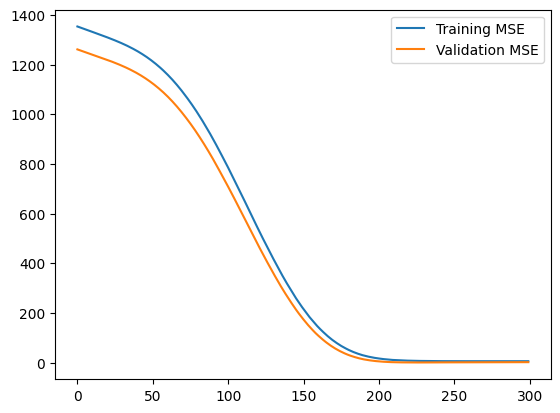

In [7]:
from matplotlib import pyplot as plt

mse_S = history.history['mse']
val_mse_S = history.history['val_mse']
loss_S = history.history['loss']
val_loss_S =  history.history['val_loss']

#plt.subplot(1,2,1)
plt.plot(mse_S,label='Training MSE')
plt.plot(val_mse_S,label='Validation MSE')
plt.legend()
plt.savefig('Sdomain_loss.png',bbox_inches = 'tight',dpi=600)
plt.savefig('Sdomain_loss.svg',bbox_inches = 'tight',dpi=600)

# transfer to target domain

## define L2 Loss :

In [8]:

if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------loading the param. of source domain-----------------')
    Smodel.load_weights(filepath=checkpoint_save_path)
    # Print the weights of each layer
    for layer in Smodel.layers:
        if len(layer.get_weights()) > 0:
            print(f"Layer: {layer.name}")
            weights = layer.get_weights() 
            # Get the weights (assuming weights are the first element) 
            # weights = layer.get_weights()[0] 
            print(weights)
            print("--------------------------------------------------")

-------------loading the param. of source domain-----------------
Layer: dense
[array([[-1.4991595 ,  2.6635475 ,  1.0278542 , -1.7998044 ],
       [-1.8269482 ,  1.1425062 ,  3.1675317 ,  0.16922665],
       [ 0.10313631,  0.7004749 ,  0.8891627 , -0.15022126]],
      dtype=float32), array([-1.1099403 ,  1.0126255 ,  0.87590355, -0.8496216 ], dtype=float32)]
--------------------------------------------------
Layer: dense_1
[array([[-1.2130995 , -1.541604  , -1.1141932 ],
       [ 2.7016797 ,  1.9198126 ,  0.5121494 ],
       [ 1.2966318 ,  3.77212   ,  0.09696086],
       [-0.8903979 ,  1.531695  , -2.9293997 ]], dtype=float32), array([0.7908309, 1.0010245, 0.7351754], dtype=float32)]
--------------------------------------------------
Layer: dense_2
[array([[1.3971769],
       [1.0204301],
       [1.6852666]], dtype=float32), array([0.5939082], dtype=float32)]
--------------------------------------------------


In [9]:
class KernelRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, initial_weights, l2_factor):
        self.initial_weights = initial_weights
        self.l2_factor = l2_factor
    
    def __call__(self, weights):
        initial_weights_flat = tf.reshape(tf.convert_to_tensor(self.initial_weights), shape=(-1,))
        weights_flat = tf.reshape(weights, shape=(-1,))
        regularization = tf.reduce_sum(tf.square(weights_flat - initial_weights_flat))
        l2_regularization = self.l2_factor * tf.reduce_sum(tf.square(weights))
        return regularization + l2_regularization
    
    def get_config(self):
        return {'initial_weights': self.initial_weights, 'l2_factor': self.l2_factor}


## define model on target domain :

In [10]:

# Adjust the strength of L2 regularization as needed
l2_reg_factor = 0.1  


class Transfer_FEDA_NN(Model):
    def __init__(self):
        super(Transfer_FEDA_NN, self).__init__()
        self.f1 = Dense(4,kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1),
                        bias_initializer='zeros',
                        kernel_regularizer=KernelRegularizer(initial_weights=Smodel.layers[0].get_weights()[0] , l2_factor=l2_reg_factor))
        self.f2 = Dense(3,kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1),
                        bias_initializer='zeros',
                        kernel_regularizer=KernelRegularizer(initial_weights=Smodel.layers[1].get_weights()[0] , l2_factor=l2_reg_factor))
        self.f3 = Dense(1,kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1),
                        bias_initializer='zeros',
                        kernel_regularizer=KernelRegularizer(initial_weights=Smodel.layers[2].get_weights()[0] , l2_factor=l2_reg_factor))
    def call(self, x):
        x = self.f1(x)
        x = self.f2(x)
        y = self.f3(x)
        return y



In [14]:
# Create the model
Tmodel = Transfer_FEDA_NN()

Tmodel.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse'],
             )


checkpoint_save_path = "./checkpoint/target_weights.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True)

# Train the model
Transfer_history = Tmodel.fit(T_x_train, T_y_train, batch_size=3, epochs=900, validation_data=(T_x_val, T_y_val),
                     validation_freq=1,callbacks=[cp_callback])

# Print model summary
Tmodel.summary()

Epoch 1/900
1/1 [==============================] - 0s 219ms/step - loss: 1858.4861 - mse: 1774.1968 - val_loss: 1367.8035 - val_mse: 1283.5280
Epoch 2/900
1/1 [==============================] - 0s 16ms/step - loss: 1857.0729 - mse: 1772.7974 - val_loss: 1366.6373 - val_mse: 1282.3756
Epoch 3/900
1/1 [==============================] - 0s 17ms/step - loss: 1855.6606 - mse: 1771.3989 - val_loss: 1365.4720 - val_mse: 1281.2242
Epoch 4/900
1/1 [==============================] - 0s 16ms/step - loss: 1854.2490 - mse: 1770.0012 - val_loss: 1364.3079 - val_mse: 1280.0737
Epoch 5/900
1/1 [==============================] - 0s 17ms/step - loss: 1852.8386 - mse: 1768.6045 - val_loss: 1363.1444 - val_mse: 1278.9237
Epoch 6/900
1/1 [==============================] - 0s 17ms/step - loss: 1851.4294 - mse: 1767.2087 - val_loss: 1361.9821 - val_mse: 1277.7748
Epoch 7/900
1/1 [==============================] - 0s 16ms/step - loss: 1850.0211 - mse: 1765.8138 - val_loss: 1360.8203 - val_mse: 1276.6263
Epoch

1/1 [==============================] - 0s 15ms/step - loss: 1694.5735 - mse: 1610.1965 - val_loss: 1232.8541 - val_mse: 1148.4579
Epoch 116/900
1/1 [==============================] - 0s 15ms/step - loss: 1692.9929 - mse: 1608.5967 - val_loss: 1231.5549 - val_mse: 1147.1392
Epoch 117/900
1/1 [==============================] - 0s 15ms/step - loss: 1691.4075 - mse: 1606.9917 - val_loss: 1230.2527 - val_mse: 1145.8168
Epoch 118/900
1/1 [==============================] - 0s 15ms/step - loss: 1689.8181 - mse: 1605.3822 - val_loss: 1228.9464 - val_mse: 1144.4900
Epoch 119/900
1/1 [==============================] - 0s 15ms/step - loss: 1688.2238 - mse: 1603.7673 - val_loss: 1227.6370 - val_mse: 1143.1593
Epoch 120/900
1/1 [==============================] - 0s 15ms/step - loss: 1686.6252 - mse: 1602.1477 - val_loss: 1226.3232 - val_mse: 1141.8245
Epoch 121/900
1/1 [==============================] - 0s 16ms/step - loss: 1685.0216 - mse: 1600.5228 - val_loss: 1225.0065 - val_mse: 1140.4856
Epoch 

Epoch 172/900
1/1 [==============================] - 0s 16ms/step - loss: 1596.2388 - mse: 1510.1348 - val_loss: 1152.2213 - val_mse: 1066.0771
Epoch 173/900
1/1 [==============================] - 0s 16ms/step - loss: 1594.3462 - mse: 1508.2020 - val_loss: 1150.6727 - val_mse: 1064.4882
Epoch 174/900
1/1 [==============================] - 0s 16ms/step - loss: 1592.4473 - mse: 1506.2627 - val_loss: 1149.1194 - val_mse: 1062.8942
Epoch 175/900
1/1 [==============================] - 0s 16ms/step - loss: 1590.5419 - mse: 1504.3167 - val_loss: 1147.5607 - val_mse: 1061.2947
Epoch 176/900
1/1 [==============================] - 0s 15ms/step - loss: 1588.6301 - mse: 1502.3641 - val_loss: 1145.9972 - val_mse: 1059.6899
Epoch 177/900
1/1 [==============================] - 0s 15ms/step - loss: 1586.7120 - mse: 1500.4048 - val_loss: 1144.4286 - val_mse: 1058.0800
Epoch 178/900
1/1 [==============================] - 0s 15ms/step - loss: 1584.7876 - mse: 1498.4390 - val_loss: 1142.8547 - val_mse: 10

1/1 [==============================] - 0s 16ms/step - loss: 1477.8188 - mse: 1389.0874 - val_loss: 1055.6127 - val_mse: 966.8302
Epoch 230/900
1/1 [==============================] - 0s 16ms/step - loss: 1475.5428 - mse: 1386.7605 - val_loss: 1053.7617 - val_mse: 964.9283
Epoch 231/900
1/1 [==============================] - 0s 15ms/step - loss: 1473.2601 - mse: 1384.4268 - val_loss: 1051.9056 - val_mse: 963.0209
Epoch 232/900
1/1 [==============================] - 0s 15ms/step - loss: 1470.9705 - mse: 1382.0857 - val_loss: 1050.0439 - val_mse: 961.1078
Epoch 233/900
1/1 [==============================] - 0s 15ms/step - loss: 1468.6738 - mse: 1379.7378 - val_loss: 1048.1768 - val_mse: 959.1891
Epoch 234/900
1/1 [==============================] - 0s 16ms/step - loss: 1466.3702 - mse: 1377.3826 - val_loss: 1046.3043 - val_mse: 957.2650
Epoch 235/900
1/1 [==============================] - 0s 16ms/step - loss: 1464.0594 - mse: 1375.0201 - val_loss: 1044.4263 - val_mse: 955.3352
Epoch 236/900

Epoch 344/900
1/1 [==============================] - 0s 16ms/step - loss: 1170.6375 - mse: 1075.2928 - val_loss: 808.3583 - val_mse: 712.9501
Epoch 345/900
1/1 [==============================] - 0s 16ms/step - loss: 1167.5834 - mse: 1072.1752 - val_loss: 805.9308 - val_mse: 710.4590
Epoch 346/900
1/1 [==============================] - 0s 16ms/step - loss: 1164.5234 - mse: 1069.0518 - val_loss: 803.4994 - val_mse: 707.9638
Epoch 347/900
1/1 [==============================] - 0s 16ms/step - loss: 1161.4576 - mse: 1065.9220 - val_loss: 801.0641 - val_mse: 705.4647
Epoch 348/900
1/1 [==============================] - 0s 15ms/step - loss: 1158.3860 - mse: 1062.7865 - val_loss: 798.6249 - val_mse: 702.9614
Epoch 349/900
1/1 [==============================] - 0s 15ms/step - loss: 1155.3085 - mse: 1059.6450 - val_loss: 796.1817 - val_mse: 700.4542
Epoch 350/900
1/1 [==============================] - 0s 16ms/step - loss: 1152.2256 - mse: 1056.4979 - val_loss: 793.7349 - val_mse: 697.9431
Epoch 

Epoch 402/900
1/1 [==============================] - 0s 15ms/step - loss: 984.9629 - mse: 885.7833 - val_loss: 662.2124 - val_mse: 562.9645
Epoch 403/900
1/1 [==============================] - 0s 16ms/step - loss: 981.6364 - mse: 882.3885 - val_loss: 659.6238 - val_mse: 560.3074
Epoch 404/900
1/1 [==============================] - 0s 15ms/step - loss: 978.3070 - mse: 878.9907 - val_loss: 657.0340 - val_mse: 557.6490
Epoch 405/900
1/1 [==============================] - 0s 16ms/step - loss: 974.9747 - mse: 875.5897 - val_loss: 654.4429 - val_mse: 554.9894
Epoch 406/900
1/1 [==============================] - 0s 15ms/step - loss: 971.6393 - mse: 872.1858 - val_loss: 651.8508 - val_mse: 552.3286
Epoch 407/900
1/1 [==============================] - 0s 16ms/step - loss: 968.3010 - mse: 868.7788 - val_loss: 649.2575 - val_mse: 549.6666
Epoch 408/900
1/1 [==============================] - 0s 15ms/step - loss: 964.9599 - mse: 865.3690 - val_loss: 646.6634 - val_mse: 547.0037
Epoch 409/900
1/1 [=

1/1 [==============================] - 0s 15ms/step - loss: 599.1779 - mse: 491.8516 - val_loss: 372.2333 - val_mse: 264.8371
Epoch 519/900
1/1 [==============================] - 0s 16ms/step - loss: 596.0571 - mse: 488.6609 - val_loss: 370.0018 - val_mse: 262.5358
Epoch 520/900
1/1 [==============================] - 0s 16ms/step - loss: 592.9436 - mse: 485.4777 - val_loss: 367.7778 - val_mse: 260.2421
Epoch 521/900
1/1 [==============================] - 0s 16ms/step - loss: 589.8372 - mse: 482.3014 - val_loss: 365.5616 - val_mse: 257.9562
Epoch 522/900
1/1 [==============================] - 0s 15ms/step - loss: 586.7381 - mse: 479.1327 - val_loss: 363.3532 - val_mse: 255.6782
Epoch 523/900
1/1 [==============================] - 0s 15ms/step - loss: 583.6465 - mse: 475.9716 - val_loss: 361.1527 - val_mse: 253.4081
Epoch 524/900
1/1 [==============================] - 0s 16ms/step - loss: 580.5624 - mse: 472.8178 - val_loss: 358.9601 - val_mse: 251.1460
Epoch 525/900
1/1 [===============

Epoch 635/900
1/1 [==============================] - 0s 16ms/step - loss: 301.5566 - mse: 186.7458 - val_loss: 177.0127 - val_mse: 62.1470
Epoch 636/900
1/1 [==============================] - 0s 15ms/step - loss: 299.7156 - mse: 184.8500 - val_loss: 175.9871 - val_mse: 61.0667
Epoch 637/900
1/1 [==============================] - 0s 16ms/step - loss: 297.8875 - mse: 182.9672 - val_loss: 174.9725 - val_mse: 59.9976
Epoch 638/900
1/1 [==============================] - 0s 15ms/step - loss: 296.0723 - mse: 181.0974 - val_loss: 173.9689 - val_mse: 58.9398
Epoch 639/900
1/1 [==============================] - 0s 15ms/step - loss: 294.2700 - mse: 179.2408 - val_loss: 172.9763 - val_mse: 57.8931
Epoch 640/900
1/1 [==============================] - 0s 15ms/step - loss: 292.4805 - mse: 177.3972 - val_loss: 171.9948 - val_mse: 56.8577
Epoch 641/900
1/1 [==============================] - 0s 15ms/step - loss: 290.7038 - mse: 175.5667 - val_loss: 171.0243 - val_mse: 55.8335
Epoch 642/900
1/1 [========

Epoch 694/900
1/1 [==============================] - 0s 16ms/step - loss: 214.3311 - mse: 96.6682 - val_loss: 134.2907 - val_mse: 16.5868
Epoch 695/900
1/1 [==============================] - 0s 16ms/step - loss: 213.2093 - mse: 95.5054 - val_loss: 133.8515 - val_mse: 16.1069
Epoch 696/900
1/1 [==============================] - 0s 15ms/step - loss: 212.0984 - mse: 94.3539 - val_loss: 133.4207 - val_mse: 15.6356
Epoch 697/900
1/1 [==============================] - 0s 15ms/step - loss: 210.9986 - mse: 93.2136 - val_loss: 132.9981 - val_mse: 15.1730
Epoch 698/900
1/1 [==============================] - 0s 16ms/step - loss: 209.9096 - mse: 92.0844 - val_loss: 132.5838 - val_mse: 14.7188
Epoch 699/900
1/1 [==============================] - 0s 15ms/step - loss: 208.8315 - mse: 90.9664 - val_loss: 132.1777 - val_mse: 14.2731
Epoch 700/900
1/1 [==============================] - 0s 15ms/step - loss: 207.7641 - mse: 89.8594 - val_loss: 131.7797 - val_mse: 13.8357
Epoch 701/900
1/1 [===============

Epoch 754/900
1/1 [==============================] - 0s 16ms/step - loss: 164.4730 - mse: 44.8353 - val_loss: 120.4695 - val_mse: 0.8074
Epoch 755/900
1/1 [==============================] - 0s 15ms/step - loss: 163.9038 - mse: 44.2417 - val_loss: 120.4134 - val_mse: 0.7272
Epoch 756/900
1/1 [==============================] - 0s 15ms/step - loss: 163.3418 - mse: 43.6557 - val_loss: 120.3616 - val_mse: 0.6515
Epoch 757/900
1/1 [==============================] - 0s 15ms/step - loss: 162.7871 - mse: 43.0770 - val_loss: 120.3141 - val_mse: 0.5804
Epoch 758/900
1/1 [==============================] - 0s 15ms/step - loss: 162.2394 - mse: 42.5057 - val_loss: 120.2707 - val_mse: 0.5137
Epoch 759/900
1/1 [==============================] - 0s 15ms/step - loss: 161.6987 - mse: 41.9416 - val_loss: 120.2315 - val_mse: 0.4514
Epoch 760/900
1/1 [==============================] - 0s 16ms/step - loss: 161.1649 - mse: 41.3849 - val_loss: 120.1963 - val_mse: 0.3934
Epoch 761/900
1/1 [======================

Epoch 814/900
1/1 [==============================] - 0s 11ms/step - loss: 140.9079 - mse: 20.2844 - val_loss: 122.6675 - val_mse: 2.0354
Epoch 815/900
1/1 [==============================] - 0s 11ms/step - loss: 140.6611 - mse: 20.0291 - val_loss: 122.7669 - val_mse: 2.1267
Epoch 816/900
1/1 [==============================] - 0s 10ms/step - loss: 140.4178 - mse: 19.7775 - val_loss: 122.8675 - val_mse: 2.2192
Epoch 817/900
1/1 [==============================] - 0s 10ms/step - loss: 140.1782 - mse: 19.5299 - val_loss: 122.9691 - val_mse: 2.3130
Epoch 818/900
1/1 [==============================] - 0s 11ms/step - loss: 139.9420 - mse: 19.2859 - val_loss: 123.0717 - val_mse: 2.4081
Epoch 819/900
1/1 [==============================] - 0s 10ms/step - loss: 139.7094 - mse: 19.0458 - val_loss: 123.1753 - val_mse: 2.5044
Epoch 820/900
1/1 [==============================] - 0s 11ms/step - loss: 139.4802 - mse: 18.8093 - val_loss: 123.2798 - val_mse: 2.6019
Epoch 821/900
1/1 [======================

Epoch 874/900
1/1 [==============================] - 0s 10ms/step - loss: 131.0850 - mse: 10.3503 - val_loss: 129.4565 - val_mse: 8.7261
Epoch 875/900
1/1 [==============================] - 0s 11ms/step - loss: 130.9850 - mse: 10.2546 - val_loss: 129.5683 - val_mse: 8.8425
Epoch 876/900
1/1 [==============================] - 0s 11ms/step - loss: 130.8863 - mse: 10.1605 - val_loss: 129.6797 - val_mse: 8.9586
Epoch 877/900
1/1 [==============================] - 0s 10ms/step - loss: 130.7891 - mse: 10.0680 - val_loss: 129.7906 - val_mse: 9.0745
Epoch 878/900
1/1 [==============================] - 0s 11ms/step - loss: 130.6934 - mse: 9.9772 - val_loss: 129.9012 - val_mse: 9.1901
Epoch 879/900
1/1 [==============================] - 0s 11ms/step - loss: 130.5990 - mse: 9.8879 - val_loss: 130.0112 - val_mse: 9.3054
Epoch 880/900
1/1 [==============================] - 0s 10ms/step - loss: 130.5059 - mse: 9.8000 - val_loss: 130.1208 - val_mse: 9.4204
Epoch 881/900
1/1 [=========================

In [15]:
checkpoint_save_path = "./checkpoint/target_weights.ckpt"

if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------loading the param. of transfer domain-----------------')
    Smodel.load_weights(filepath=checkpoint_save_path)
    # Print the weights of each layer
    for layer in Smodel.layers:
        if len(layer.get_weights()) > 0:
            print(f"Layer: {layer.name}")
            weights = layer.get_weights() 
            # Get the weights (assuming weights are the first element) 
            # weights = layer.get_weights()[0] 
            print(weights)
            print("--------------------------------------------------")

-------------loading the param. of transfer domain-----------------
Layer: dense
[array([[-2.4419835 ,  1.0452218 ,  0.03550817, -1.0983334 ],
       [-0.5895215 , -0.41218024,  1.2093245 ,  0.16136958],
       [-1.8732526 ,  2.07237   , -0.9945138 , -2.2563884 ]],
      dtype=float32), array([-0.9715973 ,  0.5125024 , -0.74442214, -0.9069544 ], dtype=float32)]
--------------------------------------------------
Layer: dense_1
[array([[ 1.0340223 ,  1.9490347 , -0.10054011],
       [-1.509545  , -1.4946944 ,  0.9983297 ],
       [ 0.20673124,  2.0077188 ,  2.5072706 ],
       [ 1.8774416 ,  1.1954017 ,  0.36315027]], dtype=float32), array([-0.6684077 , -0.65233576, -0.57671916], dtype=float32)]
--------------------------------------------------
Layer: dense_2
[array([[-1.9879953],
       [-2.2959893],
       [-1.7467483]], dtype=float32), array([0.5723585], dtype=float32)]
--------------------------------------------------


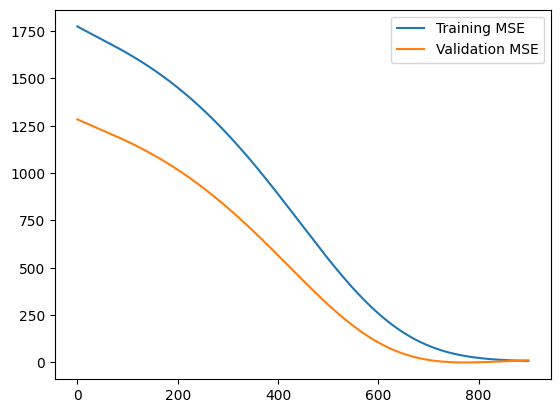

In [16]:
from matplotlib import pyplot as plt

mse_T = Transfer_history.history['mse']
val_mse_T = Transfer_history.history['val_mse']
loss_T = Transfer_history.history['loss']
val_loss_T =  Transfer_history.history['val_loss']

#plt.subplot(1,2,1)
plt.plot(mse_T,label='Training MSE')
plt.plot(val_mse_T,label='Validation MSE')
plt.legend()
plt.savefig('Tdomain_loss.png',bbox_inches = 'tight',dpi=600)
plt.savefig('Tdomain_loss.svg',bbox_inches = 'tight',dpi=600)

In [17]:
# test
from sklearn.metrics import mean_squared_error

x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
y_pred = Tmodel.predict(x_test)
print(y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"Root Mean Squared Error: {np.sqrt(mse)}")

1/1 [==============================] - 0s 61ms/step
[[39.996243]
 [39.486282]]
Root Mean Squared Error: 3.044639338348102


# compare to a base-line model

In [18]:

class base_NN(Model):
    def __init__(self):
        super(base_NN, self).__init__()
        self.f1 = Dense(4,kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1),
                        bias_initializer='zeros')
        self.f2 = Dense(3,kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1),
                        bias_initializer='zeros')
        self.f3 = Dense(1,kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1),
                        bias_initializer='zeros')
    def call(self, x):
        x = self.f1(x)
        x = self.f2(x)
        y = self.f3(x)
        return y

In [20]:
# train the model on target domain data directly and test on test data
model = base_NN()

# comolie the model 
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse'])

checkpoint_save_path = "./checkpoint/base_weights.ckpt"

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True)

history = model.fit(T_x_train, T_y_train, batch_size=3, epochs=900, validation_data=(T_x_val, T_y_val),
                     validation_freq=1,callbacks=[cp_callback])
model.summary()

Epoch 1/900
1/1 [==============================] - 0s 164ms/step - loss: 1724.0786 - mse: 1724.0786 - val_loss: 1245.0331 - val_mse: 1245.0331
Epoch 2/900
1/1 [==============================] - 0s 15ms/step - loss: 1723.4272 - mse: 1723.4272 - val_loss: 1244.4867 - val_mse: 1244.4867
Epoch 3/900
1/1 [==============================] - 0s 16ms/step - loss: 1722.7737 - mse: 1722.7737 - val_loss: 1243.9385 - val_mse: 1243.9385
Epoch 4/900
1/1 [==============================] - 0s 16ms/step - loss: 1722.1180 - mse: 1722.1180 - val_loss: 1243.3881 - val_mse: 1243.3881
Epoch 5/900
1/1 [==============================] - 0s 16ms/step - loss: 1721.4598 - mse: 1721.4598 - val_loss: 1242.8352 - val_mse: 1242.8352
Epoch 6/900
1/1 [==============================] - 0s 16ms/step - loss: 1720.7988 - mse: 1720.7988 - val_loss: 1242.2804 - val_mse: 1242.2804
Epoch 7/900
1/1 [==============================] - 0s 16ms/step - loss: 1720.1353 - mse: 1720.1353 - val_loss: 1241.7233 - val_mse: 1241.7233
Epoch

1/1 [==============================] - 0s 16ms/step - loss: 1613.7529 - mse: 1613.7529 - val_loss: 1152.4178 - val_mse: 1152.4178
Epoch 116/900
1/1 [==============================] - 0s 16ms/step - loss: 1612.3347 - mse: 1612.3347 - val_loss: 1151.2310 - val_mse: 1151.2310
Epoch 117/900
1/1 [==============================] - 0s 16ms/step - loss: 1610.9067 - mse: 1610.9067 - val_loss: 1150.0364 - val_mse: 1150.0364
Epoch 118/900
1/1 [==============================] - 0s 15ms/step - loss: 1609.4695 - mse: 1609.4695 - val_loss: 1148.8339 - val_mse: 1148.8339
Epoch 119/900
1/1 [==============================] - 0s 15ms/step - loss: 1608.0225 - mse: 1608.0225 - val_loss: 1147.6234 - val_mse: 1147.6234
Epoch 120/900
1/1 [==============================] - 0s 15ms/step - loss: 1606.5660 - mse: 1606.5660 - val_loss: 1146.4052 - val_mse: 1146.4052
Epoch 121/900
1/1 [==============================] - 0s 15ms/step - loss: 1605.1000 - mse: 1605.1000 - val_loss: 1145.1790 - val_mse: 1145.1790
Epoch 

Epoch 172/900
1/1 [==============================] - 0s 16ms/step - loss: 1516.9044 - mse: 1516.9044 - val_loss: 1071.6277 - val_mse: 1071.6277
Epoch 173/900
1/1 [==============================] - 0s 15ms/step - loss: 1514.9012 - mse: 1514.9012 - val_loss: 1069.9620 - val_mse: 1069.9620
Epoch 174/900
1/1 [==============================] - 0s 16ms/step - loss: 1512.8870 - mse: 1512.8870 - val_loss: 1068.2874 - val_mse: 1068.2874
Epoch 175/900
1/1 [==============================] - 0s 16ms/step - loss: 1510.8619 - mse: 1510.8619 - val_loss: 1066.6039 - val_mse: 1066.6039
Epoch 176/900
1/1 [==============================] - 0s 16ms/step - loss: 1508.8259 - mse: 1508.8259 - val_loss: 1064.9114 - val_mse: 1064.9114
Epoch 177/900
1/1 [==============================] - 0s 16ms/step - loss: 1506.7788 - mse: 1506.7788 - val_loss: 1063.2103 - val_mse: 1063.2103
Epoch 178/900
1/1 [==============================] - 0s 16ms/step - loss: 1504.7209 - mse: 1504.7209 - val_loss: 1061.5005 - val_mse: 10

Epoch 287/900
1/1 [==============================] - 0s 15ms/step - loss: 1215.4147 - mse: 1215.4147 - val_loss: 823.5555 - val_mse: 823.5555
Epoch 288/900
1/1 [==============================] - 0s 16ms/step - loss: 1212.1992 - mse: 1212.1992 - val_loss: 820.9406 - val_mse: 820.9406
Epoch 289/900
1/1 [==============================] - 0s 15ms/step - loss: 1208.9746 - mse: 1208.9746 - val_loss: 818.3190 - val_mse: 818.3190
Epoch 290/900
1/1 [==============================] - 0s 15ms/step - loss: 1205.7410 - mse: 1205.7410 - val_loss: 815.6911 - val_mse: 815.6911
Epoch 291/900
1/1 [==============================] - 0s 15ms/step - loss: 1202.4988 - mse: 1202.4988 - val_loss: 813.0565 - val_mse: 813.0565
Epoch 292/900
1/1 [==============================] - 0s 16ms/step - loss: 1199.2477 - mse: 1199.2477 - val_loss: 810.4155 - val_mse: 810.4155
Epoch 293/900
1/1 [==============================] - 0s 15ms/step - loss: 1195.9877 - mse: 1195.9877 - val_loss: 807.7683 - val_mse: 807.7683
Epoch 

Epoch 345/900
1/1 [==============================] - 0s 15ms/step - loss: 1015.8777 - mse: 1015.8777 - val_loss: 662.7643 - val_mse: 662.7643
Epoch 346/900
1/1 [==============================] - 0s 15ms/step - loss: 1012.2429 - mse: 1012.2429 - val_loss: 659.8655 - val_mse: 659.8655
Epoch 347/900
1/1 [==============================] - 0s 15ms/step - loss: 1008.6030 - mse: 1008.6030 - val_loss: 656.9638 - val_mse: 656.9638
Epoch 348/900
1/1 [==============================] - 0s 15ms/step - loss: 1004.9581 - mse: 1004.9581 - val_loss: 654.0593 - val_mse: 654.0593
Epoch 349/900
1/1 [==============================] - 0s 15ms/step - loss: 1001.3083 - mse: 1001.3083 - val_loss: 651.1520 - val_mse: 651.1520
Epoch 350/900
1/1 [==============================] - 0s 15ms/step - loss: 997.6537 - mse: 997.6537 - val_loss: 648.2421 - val_mse: 648.2421
Epoch 351/900
1/1 [==============================] - 0s 14ms/step - loss: 993.9943 - mse: 993.9943 - val_loss: 645.3298 - val_mse: 645.3298
Epoch 352/

1/1 [==============================] - 0s 16ms/step - loss: 584.1605 - mse: 584.1605 - val_loss: 328.9877 - val_mse: 328.9877
Epoch 462/900
1/1 [==============================] - 0s 16ms/step - loss: 580.5804 - mse: 580.5804 - val_loss: 326.3359 - val_mse: 326.3359
Epoch 463/900
1/1 [==============================] - 0s 15ms/step - loss: 577.0067 - mse: 577.0067 - val_loss: 323.6916 - val_mse: 323.6916
Epoch 464/900
1/1 [==============================] - 0s 15ms/step - loss: 573.4395 - mse: 573.4395 - val_loss: 321.0549 - val_mse: 321.0549
Epoch 465/900
1/1 [==============================] - 0s 15ms/step - loss: 569.8793 - mse: 569.8793 - val_loss: 318.4255 - val_mse: 318.4255
Epoch 466/900
1/1 [==============================] - 0s 15ms/step - loss: 566.3257 - mse: 566.3257 - val_loss: 315.8040 - val_mse: 315.8040
Epoch 467/900
1/1 [==============================] - 0s 15ms/step - loss: 562.7792 - mse: 562.7792 - val_loss: 313.1901 - val_mse: 313.1901
Epoch 468/900
1/1 [===============

Epoch 578/900
1/1 [==============================] - 0s 15ms/step - loss: 232.2327 - mse: 232.2327 - val_loss: 86.6766 - val_mse: 86.6766
Epoch 579/900
1/1 [==============================] - 0s 15ms/step - loss: 229.9606 - mse: 229.9606 - val_loss: 85.3032 - val_mse: 85.3032
Epoch 580/900
1/1 [==============================] - 0s 16ms/step - loss: 227.7027 - mse: 227.7027 - val_loss: 83.9425 - val_mse: 83.9425
Epoch 581/900
1/1 [==============================] - 0s 16ms/step - loss: 225.4590 - mse: 225.4590 - val_loss: 82.5944 - val_mse: 82.5944
Epoch 582/900
1/1 [==============================] - 0s 16ms/step - loss: 223.2293 - mse: 223.2293 - val_loss: 81.2589 - val_mse: 81.2589
Epoch 583/900
1/1 [==============================] - 0s 15ms/step - loss: 221.0138 - mse: 221.0138 - val_loss: 79.9361 - val_mse: 79.9361
Epoch 584/900
1/1 [==============================] - 0s 15ms/step - loss: 218.8124 - mse: 218.8124 - val_loss: 78.6258 - val_mse: 78.6258
Epoch 585/900
1/1 [===============

1/1 [==============================] - 0s 15ms/step - loss: 56.2070 - mse: 56.2070 - val_loss: 2.4629 - val_mse: 2.4629
Epoch 698/900
1/1 [==============================] - 0s 15ms/step - loss: 55.4342 - mse: 55.4342 - val_loss: 2.3001 - val_mse: 2.3001
Epoch 699/900
1/1 [==============================] - 0s 15ms/step - loss: 54.6708 - mse: 54.6708 - val_loss: 2.1436 - val_mse: 2.1436
Epoch 700/900
1/1 [==============================] - 0s 15ms/step - loss: 53.9166 - mse: 53.9166 - val_loss: 1.9933 - val_mse: 1.9933
Epoch 701/900
1/1 [==============================] - 0s 15ms/step - loss: 53.1715 - mse: 53.1715 - val_loss: 1.8491 - val_mse: 1.8491
Epoch 702/900
1/1 [==============================] - 0s 15ms/step - loss: 52.4356 - mse: 52.4356 - val_loss: 1.7109 - val_mse: 1.7109
Epoch 703/900
1/1 [==============================] - 0s 15ms/step - loss: 51.7087 - mse: 51.7087 - val_loss: 1.5787 - val_mse: 1.5787
Epoch 704/900
1/1 [==============================] - 0s 15ms/step - loss: 50

1/1 [==============================] - 0s 10ms/step - loss: 10.4924 - mse: 10.4924 - val_loss: 9.3948 - val_mse: 9.3948
Epoch 820/900
1/1 [==============================] - 0s 11ms/step - loss: 10.3729 - mse: 10.3729 - val_loss: 9.5424 - val_mse: 9.5424
Epoch 821/900
1/1 [==============================] - 0s 10ms/step - loss: 10.2555 - mse: 10.2555 - val_loss: 9.6898 - val_mse: 9.6898
Epoch 822/900
1/1 [==============================] - 0s 10ms/step - loss: 10.1403 - mse: 10.1403 - val_loss: 9.8372 - val_mse: 9.8372
Epoch 823/900
1/1 [==============================] - 0s 11ms/step - loss: 10.0272 - mse: 10.0272 - val_loss: 9.9844 - val_mse: 9.9844
Epoch 824/900
1/1 [==============================] - 0s 10ms/step - loss: 9.9161 - mse: 9.9161 - val_loss: 10.1315 - val_mse: 10.1315
Epoch 825/900
1/1 [==============================] - 0s 10ms/step - loss: 9.8071 - mse: 9.8071 - val_loss: 10.2785 - val_mse: 10.2785
Epoch 826/900
1/1 [==============================] - 0s 10ms/step - loss: 9.

In [21]:
checkpoint_save_path = "./checkpoint/base_weights.ckpt"

if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------loading the param. of transfer domain-----------------')
    Smodel.load_weights(filepath=checkpoint_save_path)
    # Print the weights of each layer
    for layer in Smodel.layers:
        if len(layer.get_weights()) > 0:
            print(f"Layer: {layer.name}")
            weights = layer.get_weights() 
            # Get the weights (assuming weights are the first element) 
            # weights = layer.get_weights()[0] 
            print(weights)
            print("--------------------------------------------------")

-------------loading the param. of transfer domain-----------------
Layer: dense
[array([[ 1.5900205 ,  0.43349168, -0.10656261, -1.9314315 ],
       [-1.3661724 , -0.24307795, -0.52149826, -2.6355495 ],
       [ 0.3268072 ,  1.2236819 , -2.5442488 , -0.4259405 ]],
      dtype=float32), array([ 0.9933263 ,  0.8314561 , -0.9642661 , -0.76830345], dtype=float32)]
--------------------------------------------------
Layer: dense_1
[array([[ 1.0837977 , -1.1772916 , -0.9728091 ],
       [ 1.2865251 , -1.3440601 , -2.2469766 ],
       [-0.25653574,  1.6874207 ,  1.1258876 ],
       [-2.3448632 ,  1.3316195 ,  2.5531275 ]], dtype=float32), array([ 0.6704736 , -0.655048  , -0.70068955], dtype=float32)]
--------------------------------------------------
Layer: dense_2
[array([[ 1.7008991],
       [-1.8051839],
       [-1.4356333]], dtype=float32), array([0.5421374], dtype=float32)]
--------------------------------------------------


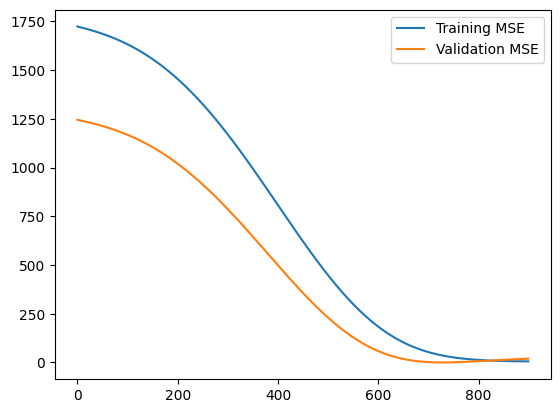

In [22]:
from matplotlib import pyplot as plt

mse_base = history.history['mse']
val_mse_base = history.history['val_mse']
loss_base = history.history['loss']
val_loss_base =  history.history['val_loss']

#plt.subplot(1,2,1)
plt.plot(mse_base,label='Training MSE')
plt.plot(val_mse_base,label='Validation MSE')
plt.legend()
plt.savefig('base_loss.png',bbox_inches = 'tight',dpi=600)
plt.savefig('base_loss.svg',bbox_inches = 'tight',dpi=600)

In [23]:
# test
from sklearn.metrics import mean_squared_error

x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
y_pred = model.predict(x_test)
print(y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"Root Mean Squared Error: {np.sqrt(mse)}")

1/1 [==============================] - 0s 20ms/step
[[40.86536 ]
 [40.437786]]
Root Mean Squared Error: 3.7558661484884266


# The following is an additional calculation （Aug 30 2023）

## search the best hyperparameter

In [3]:
import tensorflow as tf
from keras.callbacks import CSVLogger
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense,Flatten

In [4]:
class KernelRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, initial_weights, l2_factor):
        self.initial_weights = initial_weights
        self.l2_factor = l2_factor
    
    def __call__(self, weights):
        initial_weights_flat = tf.reshape(tf.convert_to_tensor(self.initial_weights), shape=(-1,))
        weights_flat = tf.reshape(weights, shape=(-1,))
        regularization = tf.reduce_sum(tf.square(weights_flat - initial_weights_flat))
        l2_regularization = self.l2_factor * tf.reduce_sum(tf.square(weights))
        return regularization + l2_regularization
    
    def get_config(self):
        return {'initial_weights': self.initial_weights, 'l2_factor': self.l2_factor}


In [73]:
import numpy as np
from sklearn.metrics import mean_squared_error

lammda_list = []
loss_list = []
tf.random.set_seed(420)
for lammda in np.arange(0.01, 1.0, 0.02):
    lammda_list.append(lammda)
    l2_reg_factor = lammda 
    class Transfer_FEDA_NN(Model):
        def __init__(self):
            super(Transfer_FEDA_NN, self).__init__()
            self.f1 = Dense(4,kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1),
                            bias_initializer='zeros',
                            kernel_regularizer=KernelRegularizer(initial_weights=Smodel.layers[0].get_weights()[0] , l2_factor=l2_reg_factor))
            self.f2 = Dense(3,kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1),
                            bias_initializer='zeros',
                            kernel_regularizer=KernelRegularizer(initial_weights=Smodel.layers[1].get_weights()[0] , l2_factor=l2_reg_factor))
            self.f3 = Dense(1,kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1),
                            bias_initializer='zeros',
                            kernel_regularizer=KernelRegularizer(initial_weights=Smodel.layers[2].get_weights()[0] , l2_factor=l2_reg_factor))
        def call(self, x):
            x = self.f1(x)
            x = self.f2(x)
            y = self.f3(x)
            return y

    # Create the model
    Tmodel = Transfer_FEDA_NN()

    Tmodel.compile(optimizer='adam',
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=['mse'],
                 )

    # Train the model
    Transfer_history = Tmodel.fit(T_x_train, T_y_train, batch_size=3, epochs=1100, validation_data=(T_x_val, T_y_val),
                         validation_freq=1,)
    loss = Transfer_history.history['val_mse'][-1]
    loss_list.append(loss)


Epoch 1/1100
1/1 [==============================] - 0s 217ms/step - loss: 1828.9473 - mse: 1753.6984 - val_loss: 1343.1884 - val_mse: 1267.9863
Epoch 2/1100
1/1 [==============================] - 0s 10ms/step - loss: 1828.0651 - mse: 1752.8630 - val_loss: 1342.4457 - val_mse: 1267.2906
Epoch 3/1100
1/1 [==============================] - 0s 10ms/step - loss: 1827.1836 - mse: 1752.0286 - val_loss: 1341.7041 - val_mse: 1266.5959
Epoch 4/1100
1/1 [==============================] - 0s 11ms/step - loss: 1826.3032 - mse: 1751.1951 - val_loss: 1340.9633 - val_mse: 1265.9021
Epoch 5/1100
1/1 [==============================] - 0s 10ms/step - loss: 1825.4237 - mse: 1750.3625 - val_loss: 1340.2231 - val_mse: 1265.2089
Epoch 6/1100
1/1 [==============================] - 0s 11ms/step - loss: 1824.5449 - mse: 1749.5308 - val_loss: 1339.4834 - val_mse: 1264.5161
Epoch 7/1100
1/1 [==============================] - 0s 10ms/step - loss: 1823.6674 - mse: 1748.7001 - val_loss: 1338.7444 - val_mse: 1263.824

Epoch 58/1100
1/1 [==============================] - 0s 10ms/step - loss: 1778.1838 - mse: 1705.0532 - val_loss: 1300.4772 - val_mse: 1227.3721
Epoch 59/1100
1/1 [==============================] - 0s 11ms/step - loss: 1777.2294 - mse: 1704.1243 - val_loss: 1299.6737 - val_mse: 1226.5939
Epoch 60/1100
1/1 [==============================] - 0s 11ms/step - loss: 1776.2705 - mse: 1703.1907 - val_loss: 1298.8667 - val_mse: 1225.8116
Epoch 61/1100
1/1 [==============================] - 0s 10ms/step - loss: 1775.3069 - mse: 1702.2518 - val_loss: 1298.0555 - val_mse: 1225.0251
Epoch 62/1100
1/1 [==============================] - 0s 10ms/step - loss: 1774.3387 - mse: 1701.3083 - val_loss: 1297.2407 - val_mse: 1224.2343
Epoch 63/1100
1/1 [==============================] - 0s 10ms/step - loss: 1773.3658 - mse: 1700.3594 - val_loss: 1296.4219 - val_mse: 1223.4392
Epoch 64/1100
1/1 [==============================] - 0s 10ms/step - loss: 1772.3877 - mse: 1699.4050 - val_loss: 1295.5984 - val_mse: 12

Epoch 115/1100
1/1 [==============================] - 0s 10ms/step - loss: 1714.8079 - mse: 1642.6821 - val_loss: 1247.2450 - val_mse: 1175.1299
Epoch 116/1100
1/1 [==============================] - 0s 10ms/step - loss: 1713.5106 - mse: 1641.3955 - val_loss: 1246.1580 - val_mse: 1174.0533
Epoch 117/1100
1/1 [==============================] - 0s 11ms/step - loss: 1712.2063 - mse: 1640.1017 - val_loss: 1245.0651 - val_mse: 1172.9711
Epoch 118/1100
1/1 [==============================] - 0s 10ms/step - loss: 1710.8945 - mse: 1638.8005 - val_loss: 1243.9670 - val_mse: 1171.8831
Epoch 119/1100
1/1 [==============================] - 0s 9ms/step - loss: 1709.5762 - mse: 1637.4922 - val_loss: 1242.8627 - val_mse: 1170.7887
Epoch 120/1100
1/1 [==============================] - 0s 11ms/step - loss: 1708.2506 - mse: 1636.1766 - val_loss: 1241.7524 - val_mse: 1169.6884
Epoch 121/1100
1/1 [==============================] - 0s 10ms/step - loss: 1706.9178 - mse: 1634.8538 - val_loss: 1240.6366 - val_m

1/1 [==============================] - 0s 10ms/step - loss: 1630.6830 - mse: 1558.9824 - val_loss: 1176.9613 - val_mse: 1105.2667
Epoch 172/1100
1/1 [==============================] - 0s 10ms/step - loss: 1628.9572 - mse: 1557.2626 - val_loss: 1175.5231 - val_mse: 1103.8344
Epoch 173/1100
1/1 [==============================] - 0s 11ms/step - loss: 1627.2229 - mse: 1555.5342 - val_loss: 1174.0781 - val_mse: 1102.3954
Epoch 174/1100
1/1 [==============================] - 0s 10ms/step - loss: 1625.4803 - mse: 1553.7976 - val_loss: 1172.6261 - val_mse: 1100.9493
Epoch 175/1100
1/1 [==============================] - 0s 10ms/step - loss: 1623.7295 - mse: 1552.0527 - val_loss: 1171.1678 - val_mse: 1099.4968
Epoch 176/1100
1/1 [==============================] - 0s 11ms/step - loss: 1621.9706 - mse: 1550.2996 - val_loss: 1169.7026 - val_mse: 1098.0374
Epoch 177/1100
1/1 [==============================] - 0s 10ms/step - loss: 1620.2034 - mse: 1548.5381 - val_loss: 1168.2305 - val_mse: 1096.5710


1/1 [==============================] - 0s 11ms/step - loss: 1520.7511 - mse: 1449.3621 - val_loss: 1085.6368 - val_mse: 1014.2529
Epoch 228/1100
1/1 [==============================] - 0s 10ms/step - loss: 1518.5316 - mse: 1447.1477 - val_loss: 1083.7992 - val_mse: 1012.4206
Epoch 229/1100
1/1 [==============================] - 0s 10ms/step - loss: 1516.3025 - mse: 1444.9238 - val_loss: 1081.9543 - val_mse: 1010.5807
Epoch 230/1100
1/1 [==============================] - 0s 11ms/step - loss: 1514.0646 - mse: 1442.6909 - val_loss: 1080.1018 - val_mse: 1008.7335
Epoch 231/1100
1/1 [==============================] - 0s 10ms/step - loss: 1511.8167 - mse: 1440.4484 - val_loss: 1078.2418 - val_mse: 1006.8787
Epoch 232/1100
1/1 [==============================] - 0s 9ms/step - loss: 1509.5598 - mse: 1438.1967 - val_loss: 1076.3745 - val_mse: 1005.0163
Epoch 233/1100
1/1 [==============================] - 0s 10ms/step - loss: 1507.2935 - mse: 1435.9353 - val_loss: 1074.4998 - val_mse: 1003.1465
E

1/1 [==============================] - 0s 10ms/step - loss: 1379.1642 - mse: 1308.0159 - val_loss: 969.0086 - val_mse: 897.8633
Epoch 285/1100
1/1 [==============================] - 0s 9ms/step - loss: 1376.4064 - mse: 1305.2610 - val_loss: 966.7496 - val_mse: 895.6071
Epoch 286/1100
1/1 [==============================] - 0s 11ms/step - loss: 1373.6390 - mse: 1302.4965 - val_loss: 964.4836 - val_mse: 893.3438
Epoch 287/1100
1/1 [==============================] - 0s 10ms/step - loss: 1370.8627 - mse: 1299.7229 - val_loss: 962.2103 - val_mse: 891.0732
Epoch 288/1100
1/1 [==============================] - 0s 9ms/step - loss: 1368.0769 - mse: 1296.9397 - val_loss: 959.9302 - val_mse: 888.7956
Epoch 289/1100
1/1 [==============================] - 0s 11ms/step - loss: 1365.2817 - mse: 1294.1473 - val_loss: 957.6428 - val_mse: 886.5107
Epoch 290/1100
1/1 [==============================] - 0s 10ms/step - loss: 1362.4775 - mse: 1291.3455 - val_loss: 955.3484 - val_mse: 884.2188
Epoch 291/1100
1

1/1 [==============================] - 0s 10ms/step - loss: 1207.3796 - mse: 1136.2870 - val_loss: 829.3353 - val_mse: 758.2416
Epoch 342/1100
1/1 [==============================] - 0s 11ms/step - loss: 1204.1074 - mse: 1133.0137 - val_loss: 826.6963 - val_mse: 755.6015
Epoch 343/1100
1/1 [==============================] - 0s 10ms/step - loss: 1200.8264 - mse: 1129.7317 - val_loss: 824.0510 - val_mse: 752.9553
Epoch 344/1100
1/1 [==============================] - 0s 10ms/step - loss: 1197.5370 - mse: 1126.4412 - val_loss: 821.3999 - val_mse: 750.3030
Epoch 345/1100
1/1 [==============================] - 0s 10ms/step - loss: 1194.2388 - mse: 1123.1420 - val_loss: 818.7425 - val_mse: 747.6446
Epoch 346/1100
1/1 [==============================] - 0s 10ms/step - loss: 1190.9321 - mse: 1119.8341 - val_loss: 816.0794 - val_mse: 744.9802
Epoch 347/1100
1/1 [==============================] - 0s 10ms/step - loss: 1187.6171 - mse: 1116.5178 - val_loss: 813.4100 - val_mse: 742.3096
Epoch 348/1100

1/1 [==============================] - 0s 10ms/step - loss: 1008.1301 - mse: 936.9373 - val_loss: 670.3015 - val_mse: 599.1064
Epoch 399/1100
1/1 [==============================] - 0s 10ms/step - loss: 1004.4317 - mse: 933.2366 - val_loss: 667.3842 - val_mse: 596.1868
Epoch 400/1100
1/1 [==============================] - 0s 11ms/step - loss: 1000.7274 - mse: 929.5300 - val_loss: 664.4637 - val_mse: 593.2641
Epoch 401/1100
1/1 [==============================] - 0s 11ms/step - loss: 997.0178 - mse: 925.8182 - val_loss: 661.5403 - val_mse: 590.3385
Epoch 402/1100
1/1 [==============================] - 0s 10ms/step - loss: 993.3028 - mse: 922.1010 - val_loss: 658.6143 - val_mse: 587.4100
Epoch 403/1100
1/1 [==============================] - 0s 10ms/step - loss: 989.5825 - mse: 918.3782 - val_loss: 655.6852 - val_mse: 584.4787
Epoch 404/1100
1/1 [==============================] - 0s 10ms/step - loss: 985.8567 - mse: 914.6501 - val_loss: 652.7536 - val_mse: 581.5447
Epoch 405/1100
1/1 [=====

1/1 [==============================] - 0s 10ms/step - loss: 787.6075 - mse: 716.2344 - val_loss: 499.0959 - val_mse: 427.7183
Epoch 457/1100
1/1 [==============================] - 0s 11ms/step - loss: 783.7661 - mse: 712.3885 - val_loss: 496.1700 - val_mse: 424.7878
Epoch 458/1100
1/1 [==============================] - 0s 10ms/step - loss: 779.9261 - mse: 708.5439 - val_loss: 493.2472 - val_mse: 421.8604
Epoch 459/1100
1/1 [==============================] - 0s 9ms/step - loss: 776.0874 - mse: 704.7007 - val_loss: 490.3278 - val_mse: 418.9363
Epoch 460/1100
1/1 [==============================] - 0s 11ms/step - loss: 772.2504 - mse: 700.8590 - val_loss: 487.4117 - val_mse: 416.0156
Epoch 461/1100
1/1 [==============================] - 0s 11ms/step - loss: 768.4149 - mse: 697.0187 - val_loss: 484.4991 - val_mse: 413.0982
Epoch 462/1100
1/1 [==============================] - 0s 10ms/step - loss: 764.5814 - mse: 693.1804 - val_loss: 481.5903 - val_mse: 410.1846
Epoch 463/1100
1/1 [=========

1/1 [==============================] - 0s 10ms/step - loss: 571.1528 - mse: 499.4124 - val_loss: 338.2937 - val_mse: 266.5450
Epoch 515/1100
1/1 [==============================] - 0s 13ms/step - loss: 567.6112 - mse: 495.8626 - val_loss: 335.7450 - val_mse: 263.9880
Epoch 516/1100
1/1 [==============================] - 0s 11ms/step - loss: 564.0786 - mse: 492.3216 - val_loss: 333.2058 - val_mse: 261.4405
Epoch 517/1100
1/1 [==============================] - 0s 10ms/step - loss: 560.5551 - mse: 488.7897 - val_loss: 330.6767 - val_mse: 258.9028
Epoch 518/1100
1/1 [==============================] - 0s 11ms/step - loss: 557.0409 - mse: 485.2671 - val_loss: 328.1574 - val_mse: 256.3751
Epoch 519/1100
1/1 [==============================] - 0s 10ms/step - loss: 553.5361 - mse: 481.7538 - val_loss: 325.6482 - val_mse: 253.8573
Epoch 520/1100
1/1 [==============================] - 0s 10ms/step - loss: 550.0409 - mse: 478.2501 - val_loss: 323.1489 - val_mse: 251.3494
Epoch 521/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 384.0623 - mse: 311.7595 - val_loss: 209.1036 - val_mse: 136.7901
Epoch 573/1100
1/1 [==============================] - 0s 10ms/step - loss: 381.2177 - mse: 308.9042 - val_loss: 207.2479 - val_mse: 134.9236
Epoch 574/1100
1/1 [==============================] - 0s 10ms/step - loss: 378.3877 - mse: 306.0634 - val_loss: 205.4057 - val_mse: 133.0706
Epoch 575/1100
1/1 [==============================] - 0s 11ms/step - loss: 375.5722 - mse: 303.2371 - val_loss: 203.5774 - val_mse: 131.2314
Epoch 576/1100
1/1 [==============================] - 0s 10ms/step - loss: 372.7714 - mse: 300.4253 - val_loss: 201.7627 - val_mse: 129.4057
Epoch 577/1100
1/1 [==============================] - 0s 9ms/step - loss: 369.9852 - mse: 297.6283 - val_loss: 199.9616 - val_mse: 127.5938
Epoch 578/1100
1/1 [==============================] - 0s 10ms/step - loss: 367.2137 - mse: 294.8459 - val_loss: 198.1743 - val_mse: 125.7956
Epoch 579/1100
1/1 [=========

1/1 [==============================] - 0s 10ms/step - loss: 244.2579 - mse: 171.3195 - val_loss: 124.4230 - val_mse: 51.4740
Epoch 631/1100
1/1 [==============================] - 0s 10ms/step - loss: 242.3081 - mse: 169.3592 - val_loss: 123.3696 - val_mse: 50.4101
Epoch 632/1100
1/1 [==============================] - 0s 10ms/step - loss: 240.3741 - mse: 167.4146 - val_loss: 122.3295 - val_mse: 49.3594
Epoch 633/1100
1/1 [==============================] - 0s 10ms/step - loss: 238.4556 - mse: 165.4855 - val_loss: 121.3026 - val_mse: 48.3220
Epoch 634/1100
1/1 [==============================] - 0s 10ms/step - loss: 236.5527 - mse: 163.5721 - val_loss: 120.2890 - val_mse: 47.2979
Epoch 635/1100
1/1 [==============================] - 0s 9ms/step - loss: 234.6653 - mse: 161.6742 - val_loss: 119.2885 - val_mse: 46.2869
Epoch 636/1100
1/1 [==============================] - 0s 10ms/step - loss: 232.7934 - mse: 159.7919 - val_loss: 118.3011 - val_mse: 45.2891
Epoch 637/1100
1/1 [================

1/1 [==============================] - 0s 10ms/step - loss: 154.6883 - mse: 81.2011 - val_loss: 83.1410 - val_mse: 9.6462
Epoch 690/1100
1/1 [==============================] - 0s 10ms/step - loss: 153.5850 - mse: 80.0903 - val_loss: 82.7658 - val_mse: 9.2636
Epoch 691/1100
1/1 [==============================] - 0s 10ms/step - loss: 152.4942 - mse: 78.9921 - val_loss: 82.3997 - val_mse: 8.8902
Epoch 692/1100
1/1 [==============================] - 0s 10ms/step - loss: 151.4159 - mse: 77.9064 - val_loss: 82.0428 - val_mse: 8.5260
Epoch 693/1100
1/1 [==============================] - 0s 10ms/step - loss: 150.3497 - mse: 76.8330 - val_loss: 81.6948 - val_mse: 8.1708
Epoch 694/1100
1/1 [==============================] - 0s 10ms/step - loss: 149.2958 - mse: 75.7718 - val_loss: 81.3558 - val_mse: 7.8246
Epoch 695/1100
1/1 [==============================] - 0s 10ms/step - loss: 148.2541 - mse: 74.7230 - val_loss: 81.0255 - val_mse: 7.4874
Epoch 696/1100
1/1 [==============================] - 0s

Epoch 749/1100
1/1 [==============================] - 0s 10ms/step - loss: 107.7089 - mse: 33.9177 - val_loss: 73.8165 - val_mse: 0.0229
Epoch 750/1100
1/1 [==============================] - 0s 10ms/step - loss: 107.2048 - mse: 33.4113 - val_loss: 73.8347 - val_mse: 0.0389
Epoch 751/1100
1/1 [==============================] - 0s 13ms/step - loss: 106.7082 - mse: 32.9124 - val_loss: 73.8568 - val_mse: 0.0589
Epoch 752/1100
1/1 [==============================] - 0s 11ms/step - loss: 106.2189 - mse: 32.4210 - val_loss: 73.8829 - val_mse: 0.0828
Epoch 753/1100
1/1 [==============================] - 0s 11ms/step - loss: 105.7368 - mse: 31.9368 - val_loss: 73.9127 - val_mse: 0.1107
Epoch 754/1100
1/1 [==============================] - 0s 12ms/step - loss: 105.2619 - mse: 31.4599 - val_loss: 73.9463 - val_mse: 0.1424
Epoch 755/1100
1/1 [==============================] - 0s 10ms/step - loss: 104.7940 - mse: 30.9901 - val_loss: 73.9835 - val_mse: 0.1778
Epoch 756/1100
1/1 [=====================

1/1 [==============================] - 0s 10ms/step - loss: 87.9359 - mse: 14.1683 - val_loss: 79.5721 - val_mse: 5.8076
Epoch 810/1100
1/1 [==============================] - 0s 10ms/step - loss: 87.7448 - mse: 13.9803 - val_loss: 79.7126 - val_mse: 5.9513
Epoch 811/1100
1/1 [==============================] - 0s 9ms/step - loss: 87.5569 - mse: 13.7956 - val_loss: 79.8537 - val_mse: 6.0957
Epoch 812/1100
1/1 [==============================] - 0s 10ms/step - loss: 87.3723 - mse: 13.6143 - val_loss: 79.9951 - val_mse: 6.2405
Epoch 813/1100
1/1 [==============================] - 0s 10ms/step - loss: 87.1908 - mse: 13.4363 - val_loss: 80.1369 - val_mse: 6.3858
Epoch 814/1100
1/1 [==============================] - 0s 10ms/step - loss: 87.0126 - mse: 13.2615 - val_loss: 80.2791 - val_mse: 6.5316
Epoch 815/1100
1/1 [==============================] - 0s 10ms/step - loss: 86.8373 - mse: 13.0898 - val_loss: 80.4216 - val_mse: 6.6778
Epoch 816/1100
1/1 [==============================] - 0s 10ms/st

1/1 [==============================] - 0s 12ms/step - loss: 80.7964 - mse: 7.3558 - val_loss: 87.8473 - val_mse: 14.4143
Epoch 870/1100
1/1 [==============================] - 0s 11ms/step - loss: 80.7301 - mse: 7.2971 - val_loss: 87.9699 - val_mse: 14.5446
Epoch 871/1100
1/1 [==============================] - 0s 10ms/step - loss: 80.6649 - mse: 7.2396 - val_loss: 88.0916 - val_mse: 14.6740
Epoch 872/1100
1/1 [==============================] - 0s 10ms/step - loss: 80.6008 - mse: 7.1832 - val_loss: 88.2125 - val_mse: 14.8027
Epoch 873/1100
1/1 [==============================] - 0s 10ms/step - loss: 80.5379 - mse: 7.1280 - val_loss: 88.3327 - val_mse: 14.9307
Epoch 874/1100
1/1 [==============================] - 0s 10ms/step - loss: 80.4759 - mse: 7.0740 - val_loss: 88.4520 - val_mse: 15.0580
Epoch 875/1100
1/1 [==============================] - 0s 10ms/step - loss: 80.4151 - mse: 7.0210 - val_loss: 88.5706 - val_mse: 15.1845
Epoch 876/1100
1/1 [==============================] - 0s 10ms/s

1/1 [==============================] - 0s 10ms/step - loss: 78.2227 - mse: 5.3333 - val_loss: 93.6911 - val_mse: 20.8123
Epoch 930/1100
1/1 [==============================] - 0s 10ms/step - loss: 78.1957 - mse: 5.3169 - val_loss: 93.7624 - val_mse: 20.8941
Epoch 931/1100
1/1 [==============================] - 0s 10ms/step - loss: 78.1691 - mse: 5.3009 - val_loss: 93.8328 - val_mse: 20.9753
Epoch 932/1100
1/1 [==============================] - 0s 9ms/step - loss: 78.1428 - mse: 5.2852 - val_loss: 93.9024 - val_mse: 21.0555
Epoch 933/1100
1/1 [==============================] - 0s 10ms/step - loss: 78.1168 - mse: 5.2699 - val_loss: 93.9712 - val_mse: 21.1351
Epoch 934/1100
1/1 [==============================] - 0s 10ms/step - loss: 78.0911 - mse: 5.2550 - val_loss: 94.0392 - val_mse: 21.2138
Epoch 935/1100
1/1 [==============================] - 0s 10ms/step - loss: 78.0657 - mse: 5.2403 - val_loss: 94.1064 - val_mse: 21.2919
Epoch 936/1100
1/1 [==============================] - 0s 10ms/st

1/1 [==============================] - 0s 11ms/step - loss: 76.9790 - mse: 4.7814 - val_loss: 96.6821 - val_mse: 24.4969
Epoch 990/1100
1/1 [==============================] - 0s 10ms/step - loss: 76.9622 - mse: 4.7770 - val_loss: 96.7129 - val_mse: 24.5400
Epoch 991/1100
1/1 [==============================] - 0s 10ms/step - loss: 76.9456 - mse: 4.7727 - val_loss: 96.7431 - val_mse: 24.5826
Epoch 992/1100
1/1 [==============================] - 0s 10ms/step - loss: 76.9290 - mse: 4.7685 - val_loss: 96.7728 - val_mse: 24.6247
Epoch 993/1100
1/1 [==============================] - 0s 10ms/step - loss: 76.9124 - mse: 4.7644 - val_loss: 96.8020 - val_mse: 24.6663
Epoch 994/1100
1/1 [==============================] - 0s 10ms/step - loss: 76.8960 - mse: 4.7603 - val_loss: 96.8307 - val_mse: 24.7075
Epoch 995/1100
1/1 [==============================] - 0s 10ms/step - loss: 76.8796 - mse: 4.7564 - val_loss: 96.8589 - val_mse: 24.7481
Epoch 996/1100
1/1 [==============================] - 0s 10ms/s

1/1 [==============================] - 0s 10ms/step - loss: 76.0566 - mse: 4.6306 - val_loss: 97.7565 - val_mse: 26.3438
Epoch 1050/1100
1/1 [==============================] - 0s 9ms/step - loss: 76.0420 - mse: 4.6293 - val_loss: 97.7637 - val_mse: 26.3643
Epoch 1051/1100
1/1 [==============================] - 0s 11ms/step - loss: 76.0275 - mse: 4.6281 - val_loss: 97.7706 - val_mse: 26.3845
Epoch 1052/1100
1/1 [==============================] - 0s 10ms/step - loss: 76.0130 - mse: 4.6269 - val_loss: 97.7771 - val_mse: 26.4044
Epoch 1053/1100
1/1 [==============================] - 0s 9ms/step - loss: 75.9984 - mse: 4.6257 - val_loss: 97.7835 - val_mse: 26.4241
Epoch 1054/1100
1/1 [==============================] - 0s 10ms/step - loss: 75.9839 - mse: 4.6245 - val_loss: 97.7895 - val_mse: 26.4435
Epoch 1055/1100
1/1 [==============================] - 0s 10ms/step - loss: 75.9694 - mse: 4.6234 - val_loss: 97.7954 - val_mse: 26.4627
Epoch 1056/1100
1/1 [==============================] - 0s 1

Epoch 9/1100
1/1 [==============================] - 0s 10ms/step - loss: 1868.9985 - mse: 1748.6245 - val_loss: 1383.4163 - val_mse: 1263.1057
Epoch 10/1100
1/1 [==============================] - 0s 10ms/step - loss: 1867.6265 - mse: 1747.3159 - val_loss: 1382.2673 - val_mse: 1262.0203
Epoch 11/1100
1/1 [==============================] - 0s 10ms/step - loss: 1866.2561 - mse: 1746.0090 - val_loss: 1381.1205 - val_mse: 1260.9364
Epoch 12/1100
1/1 [==============================] - 0s 11ms/step - loss: 1864.8877 - mse: 1744.7036 - val_loss: 1379.9751 - val_mse: 1259.8540
Epoch 13/1100
1/1 [==============================] - 0s 10ms/step - loss: 1863.5210 - mse: 1743.3999 - val_loss: 1378.8314 - val_mse: 1258.7729
Epoch 14/1100
1/1 [==============================] - 0s 11ms/step - loss: 1862.1566 - mse: 1742.0981 - val_loss: 1377.6895 - val_mse: 1257.6932
Epoch 15/1100
1/1 [==============================] - 0s 10ms/step - loss: 1860.7943 - mse: 1740.7981 - val_loss: 1376.5490 - val_mse: 125

Epoch 66/1100
1/1 [==============================] - 0s 10ms/step - loss: 1791.5798 - mse: 1673.8702 - val_loss: 1318.7131 - val_mse: 1201.0269
Epoch 67/1100
1/1 [==============================] - 0s 10ms/step - loss: 1790.1719 - mse: 1672.4856 - val_loss: 1317.5402 - val_mse: 1199.8759
Epoch 68/1100
1/1 [==============================] - 0s 10ms/step - loss: 1788.7607 - mse: 1671.0964 - val_loss: 1316.3638 - val_mse: 1198.7211
Epoch 69/1100
1/1 [==============================] - 0s 10ms/step - loss: 1787.3453 - mse: 1669.7026 - val_loss: 1315.1844 - val_mse: 1197.5625
Epoch 70/1100
1/1 [==============================] - 0s 10ms/step - loss: 1785.9261 - mse: 1668.3042 - val_loss: 1314.0018 - val_mse: 1196.4000
Epoch 71/1100
1/1 [==============================] - 0s 10ms/step - loss: 1784.5032 - mse: 1666.9014 - val_loss: 1312.8162 - val_mse: 1195.2339
Epoch 72/1100
1/1 [==============================] - 0s 10ms/step - loss: 1783.0759 - mse: 1665.4937 - val_loss: 1311.6276 - val_mse: 11

Epoch 123/1100
1/1 [==============================] - 0s 10ms/step - loss: 1704.2275 - mse: 1587.1278 - val_loss: 1246.1316 - val_mse: 1129.0342
Epoch 124/1100
1/1 [==============================] - 0s 10ms/step - loss: 1702.5518 - mse: 1585.4543 - val_loss: 1244.7427 - val_mse: 1127.6476
Epoch 125/1100
1/1 [==============================] - 0s 11ms/step - loss: 1700.8700 - mse: 1583.7749 - val_loss: 1243.3495 - val_mse: 1126.2562
Epoch 126/1100
1/1 [==============================] - 0s 10ms/step - loss: 1699.1835 - mse: 1582.0902 - val_loss: 1241.9518 - val_mse: 1124.8605
Epoch 127/1100
1/1 [==============================] - 0s 10ms/step - loss: 1697.4908 - mse: 1580.3995 - val_loss: 1240.5498 - val_mse: 1123.4600
Epoch 128/1100
1/1 [==============================] - 0s 9ms/step - loss: 1695.7931 - mse: 1578.7032 - val_loss: 1239.1433 - val_mse: 1122.0547
Epoch 129/1100
1/1 [==============================] - 0s 10ms/step - loss: 1694.0896 - mse: 1577.0010 - val_loss: 1237.7327 - val_m

1/1 [==============================] - 0s 10ms/step - loss: 1601.1736 - mse: 1483.8040 - val_loss: 1160.9653 - val_mse: 1043.5835
Epoch 180/1100
1/1 [==============================] - 0s 11ms/step - loss: 1599.1443 - mse: 1481.7625 - val_loss: 1159.2924 - val_mse: 1041.8981
Epoch 181/1100
1/1 [==============================] - 0s 10ms/step - loss: 1597.1072 - mse: 1479.7129 - val_loss: 1157.6138 - val_mse: 1040.2067
Epoch 182/1100
1/1 [==============================] - 0s 10ms/step - loss: 1595.0631 - mse: 1477.6560 - val_loss: 1155.9292 - val_mse: 1038.5090
Epoch 183/1100
1/1 [==============================] - 0s 10ms/step - loss: 1593.0115 - mse: 1475.5913 - val_loss: 1154.2388 - val_mse: 1036.8052
Epoch 184/1100
1/1 [==============================] - 0s 10ms/step - loss: 1590.9524 - mse: 1473.5188 - val_loss: 1152.5422 - val_mse: 1035.0951
Epoch 185/1100
1/1 [==============================] - 0s 10ms/step - loss: 1588.8855 - mse: 1471.4384 - val_loss: 1150.8396 - val_mse: 1033.3785


Epoch 236/1100
1/1 [==============================] - 0s 10ms/step - loss: 1472.4740 - mse: 1354.0227 - val_loss: 1055.2216 - val_mse: 936.7444
Epoch 237/1100
1/1 [==============================] - 0s 10ms/step - loss: 1469.9590 - mse: 1351.4819 - val_loss: 1053.1628 - val_mse: 934.6596
Epoch 238/1100
1/1 [==============================] - 0s 10ms/step - loss: 1467.4347 - mse: 1348.9314 - val_loss: 1051.0966 - val_mse: 932.5670
Epoch 239/1100
1/1 [==============================] - 0s 10ms/step - loss: 1464.9009 - mse: 1346.3713 - val_loss: 1049.0228 - val_mse: 930.4669
Epoch 240/1100
1/1 [==============================] - 0s 10ms/step - loss: 1462.3577 - mse: 1343.8016 - val_loss: 1046.9420 - val_mse: 928.3591
Epoch 241/1100
1/1 [==============================] - 0s 10ms/step - loss: 1459.8049 - mse: 1341.2222 - val_loss: 1044.8536 - val_mse: 926.2438
Epoch 242/1100
1/1 [==============================] - 0s 10ms/step - loss: 1457.2426 - mse: 1338.6328 - val_loss: 1042.7577 - val_mse: 9

1/1 [==============================] - 0s 10ms/step - loss: 1314.0607 - mse: 1193.7314 - val_loss: 926.2739 - val_mse: 805.9038
Epoch 294/1100
1/1 [==============================] - 0s 9ms/step - loss: 1311.0144 - mse: 1190.6443 - val_loss: 923.8107 - val_mse: 803.3995
Epoch 295/1100
1/1 [==============================] - 0s 10ms/step - loss: 1307.9596 - mse: 1187.5486 - val_loss: 921.3410 - val_mse: 800.8885
Epoch 296/1100
1/1 [==============================] - 0s 10ms/step - loss: 1304.8962 - mse: 1184.4437 - val_loss: 918.8651 - val_mse: 798.3710
Epoch 297/1100
1/1 [==============================] - 0s 10ms/step - loss: 1301.8241 - mse: 1181.3300 - val_loss: 916.3826 - val_mse: 795.8467
Epoch 298/1100
1/1 [==============================] - 0s 10ms/step - loss: 1298.7430 - mse: 1178.2070 - val_loss: 913.8941 - val_mse: 793.3159
Epoch 299/1100
1/1 [==============================] - 0s 10ms/step - loss: 1295.6538 - mse: 1175.0757 - val_loss: 911.3994 - val_mse: 790.7787
Epoch 300/1100


1/1 [==============================] - 0s 10ms/step - loss: 1127.8522 - mse: 1004.7615 - val_loss: 777.0464 - val_mse: 653.8998
Epoch 351/1100
1/1 [==============================] - 0s 10ms/step - loss: 1124.3877 - mse: 1001.2411 - val_loss: 774.2982 - val_mse: 651.0956
Epoch 352/1100
1/1 [==============================] - 0s 10ms/step - loss: 1120.9177 - mse: 997.7151 - val_loss: 771.5469 - val_mse: 648.2881
Epoch 353/1100
1/1 [==============================] - 0s 10ms/step - loss: 1117.4420 - mse: 994.1832 - val_loss: 768.7925 - val_mse: 645.4772
Epoch 354/1100
1/1 [==============================] - 0s 9ms/step - loss: 1113.9609 - mse: 990.6458 - val_loss: 766.0349 - val_mse: 642.6628
Epoch 355/1100
1/1 [==============================] - 0s 10ms/step - loss: 1110.4752 - mse: 987.1030 - val_loss: 763.2744 - val_mse: 639.8454
Epoch 356/1100
1/1 [==============================] - 0s 10ms/step - loss: 1106.9838 - mse: 983.5547 - val_loss: 760.5109 - val_mse: 637.0248
Epoch 357/1100
1/1 [

1/1 [==============================] - 0s 10ms/step - loss: 920.4278 - mse: 793.8021 - val_loss: 614.7505 - val_mse: 488.0600
Epoch 409/1100
1/1 [==============================] - 0s 9ms/step - loss: 916.7889 - mse: 790.0983 - val_loss: 611.9489 - val_mse: 485.1933
Epoch 410/1100
1/1 [==============================] - 0s 10ms/step - loss: 913.1500 - mse: 786.3943 - val_loss: 609.1487 - val_mse: 482.3280
Epoch 411/1100
1/1 [==============================] - 0s 10ms/step - loss: 909.5109 - mse: 782.6902 - val_loss: 606.3505 - val_mse: 479.4645
Epoch 412/1100
1/1 [==============================] - 0s 10ms/step - loss: 905.8719 - mse: 778.9860 - val_loss: 603.5540 - val_mse: 476.6028
Epoch 413/1100
1/1 [==============================] - 0s 10ms/step - loss: 902.2333 - mse: 775.2821 - val_loss: 600.7595 - val_mse: 473.7429
Epoch 414/1100
1/1 [==============================] - 0s 10ms/step - loss: 898.5948 - mse: 771.5782 - val_loss: 597.9670 - val_mse: 470.8850
Epoch 415/1100
1/1 [=========

1/1 [==============================] - 0s 10ms/step - loss: 712.4693 - mse: 581.9792 - val_loss: 457.9079 - val_mse: 327.3504
Epoch 467/1100
1/1 [==============================] - 0s 9ms/step - loss: 709.0004 - mse: 578.4429 - val_loss: 455.3575 - val_mse: 324.7326
Epoch 468/1100
1/1 [==============================] - 0s 10ms/step - loss: 705.5378 - mse: 574.9129 - val_loss: 452.8143 - val_mse: 322.1220
Epoch 469/1100
1/1 [==============================] - 0s 10ms/step - loss: 702.0813 - mse: 571.3889 - val_loss: 450.2782 - val_mse: 319.5184
Epoch 470/1100
1/1 [==============================] - 0s 10ms/step - loss: 698.6309 - mse: 567.8711 - val_loss: 447.7491 - val_mse: 316.9220
Epoch 471/1100
1/1 [==============================] - 0s 10ms/step - loss: 695.1868 - mse: 564.3597 - val_loss: 445.2274 - val_mse: 314.3329
Epoch 472/1100
1/1 [==============================] - 0s 10ms/step - loss: 691.7495 - mse: 560.8550 - val_loss: 442.7131 - val_mse: 311.7512
Epoch 473/1100
1/1 [=========

1/1 [==============================] - 0s 10ms/step - loss: 524.3627 - mse: 390.0142 - val_loss: 324.0456 - val_mse: 189.6324
Epoch 525/1100
1/1 [==============================] - 0s 10ms/step - loss: 521.4049 - mse: 386.9916 - val_loss: 322.0288 - val_mse: 187.5509
Epoch 526/1100
1/1 [==============================] - 0s 10ms/step - loss: 518.4581 - mse: 383.9803 - val_loss: 320.0233 - val_mse: 185.4808
Epoch 527/1100
1/1 [==============================] - 0s 9ms/step - loss: 515.5229 - mse: 380.9805 - val_loss: 318.0287 - val_mse: 183.4218
Epoch 528/1100
1/1 [==============================] - 0s 10ms/step - loss: 512.5992 - mse: 377.9922 - val_loss: 316.0454 - val_mse: 181.3741
Epoch 529/1100
1/1 [==============================] - 0s 10ms/step - loss: 509.6870 - mse: 375.0156 - val_loss: 314.0734 - val_mse: 179.3378
Epoch 530/1100
1/1 [==============================] - 0s 10ms/step - loss: 506.7863 - mse: 372.0506 - val_loss: 312.1127 - val_mse: 177.3129
Epoch 531/1100
1/1 [=========

1/1 [==============================] - 0s 10ms/step - loss: 373.2697 - mse: 235.3586 - val_loss: 226.5195 - val_mse: 88.5513
Epoch 583/1100
1/1 [==============================] - 0s 11ms/step - loss: 371.0549 - mse: 233.0866 - val_loss: 225.1975 - val_mse: 87.1723
Epoch 584/1100
1/1 [==============================] - 0s 10ms/step - loss: 368.8538 - mse: 230.8286 - val_loss: 223.8880 - val_mse: 85.8060
Epoch 585/1100
1/1 [==============================] - 0s 12ms/step - loss: 366.6665 - mse: 228.5846 - val_loss: 222.5907 - val_mse: 84.4521
Epoch 586/1100
1/1 [==============================] - 0s 12ms/step - loss: 364.4932 - mse: 226.3546 - val_loss: 221.3057 - val_mse: 83.1107
Epoch 587/1100
1/1 [==============================] - 0s 10ms/step - loss: 362.3336 - mse: 224.1385 - val_loss: 220.0330 - val_mse: 81.7817
Epoch 588/1100
1/1 [==============================] - 0s 10ms/step - loss: 360.1879 - mse: 221.9366 - val_loss: 218.7727 - val_mse: 80.4654
Epoch 589/1100
1/1 [===============

Epoch 641/1100
1/1 [==============================] - 0s 10ms/step - loss: 266.1200 - mse: 125.1824 - val_loss: 168.8905 - val_mse: 27.9085
Epoch 642/1100
1/1 [==============================] - 0s 10ms/step - loss: 264.7060 - mse: 123.7240 - val_loss: 168.2495 - val_mse: 27.2233
Epoch 643/1100
1/1 [==============================] - 0s 10ms/step - loss: 263.3048 - mse: 122.2786 - val_loss: 167.6188 - val_mse: 26.5486
Epoch 644/1100
1/1 [==============================] - 0s 10ms/step - loss: 261.9163 - mse: 120.8461 - val_loss: 166.9982 - val_mse: 25.8843
Epoch 645/1100
1/1 [==============================] - 0s 9ms/step - loss: 260.5405 - mse: 119.4265 - val_loss: 166.3877 - val_mse: 25.2303
Epoch 646/1100
1/1 [==============================] - 0s 9ms/step - loss: 259.1772 - mse: 118.0198 - val_loss: 165.7872 - val_mse: 24.5866
Epoch 647/1100
1/1 [==============================] - 0s 10ms/step - loss: 257.8265 - mse: 116.6258 - val_loss: 165.1967 - val_mse: 23.9531
Epoch 648/1100
1/1 [==

1/1 [==============================] - 0s 9ms/step - loss: 202.7190 - mse: 59.6167 - val_loss: 146.3519 - val_mse: 3.2214
Epoch 701/1100
1/1 [==============================] - 0s 10ms/step - loss: 201.9584 - mse: 58.8279 - val_loss: 146.1952 - val_mse: 3.0368
Epoch 702/1100
1/1 [==============================] - 0s 10ms/step - loss: 201.2068 - mse: 58.0485 - val_loss: 146.0445 - val_mse: 2.8585
Epoch 703/1100
1/1 [==============================] - 0s 10ms/step - loss: 200.4643 - mse: 57.2783 - val_loss: 145.8997 - val_mse: 2.6864
Epoch 704/1100
1/1 [==============================] - 0s 10ms/step - loss: 199.7307 - mse: 56.5174 - val_loss: 145.7608 - val_mse: 2.5204
Epoch 705/1100
1/1 [==============================] - 0s 10ms/step - loss: 199.0059 - mse: 55.7655 - val_loss: 145.6276 - val_mse: 2.3605
Epoch 706/1100
1/1 [==============================] - 0s 9ms/step - loss: 198.2899 - mse: 55.0228 - val_loss: 145.5001 - val_mse: 2.2066
Epoch 707/1100
1/1 [==============================]

1/1 [==============================] - 0s 10ms/step - loss: 171.0164 - mse: 26.7527 - val_loss: 145.0024 - val_mse: 0.7276
Epoch 760/1100
1/1 [==============================] - 0s 10ms/step - loss: 170.6687 - mse: 26.3940 - val_loss: 145.0781 - val_mse: 0.7927
Epoch 761/1100
1/1 [==============================] - 0s 9ms/step - loss: 170.3261 - mse: 26.0407 - val_loss: 145.1560 - val_mse: 0.8601
Epoch 762/1100
1/1 [==============================] - 0s 10ms/step - loss: 169.9883 - mse: 25.6925 - val_loss: 145.2358 - val_mse: 0.9297
Epoch 763/1100
1/1 [==============================] - 0s 10ms/step - loss: 169.6555 - mse: 25.3494 - val_loss: 145.3175 - val_mse: 1.0016
Epoch 764/1100
1/1 [==============================] - 0s 10ms/step - loss: 169.3274 - mse: 25.0115 - val_loss: 145.4012 - val_mse: 1.0757
Epoch 765/1100
1/1 [==============================] - 0s 10ms/step - loss: 169.0040 - mse: 24.6785 - val_loss: 145.4867 - val_mse: 1.1518
Epoch 766/1100
1/1 [==============================

1/1 [==============================] - 0s 11ms/step - loss: 157.2331 - mse: 12.7732 - val_loss: 151.4946 - val_mse: 7.0387
Epoch 819/1100
1/1 [==============================] - 0s 11ms/step - loss: 157.0889 - mse: 12.6330 - val_loss: 151.6180 - val_mse: 7.1663
Epoch 820/1100
1/1 [==============================] - 0s 10ms/step - loss: 156.9468 - mse: 12.4951 - val_loss: 151.7411 - val_mse: 7.2939
Epoch 821/1100
1/1 [==============================] - 0s 10ms/step - loss: 156.8068 - mse: 12.3596 - val_loss: 151.8642 - val_mse: 7.4216
Epoch 822/1100
1/1 [==============================] - 0s 10ms/step - loss: 156.6689 - mse: 12.2264 - val_loss: 151.9870 - val_mse: 7.5494
Epoch 823/1100
1/1 [==============================] - 0s 10ms/step - loss: 156.5330 - mse: 12.0954 - val_loss: 152.1096 - val_mse: 7.6771
Epoch 824/1100
1/1 [==============================] - 0s 10ms/step - loss: 156.3991 - mse: 11.9666 - val_loss: 152.2320 - val_mse: 7.8048
Epoch 825/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 151.4379 - mse: 7.5545 - val_loss: 157.9890 - val_mse: 14.1206
Epoch 878/1100
1/1 [==============================] - 0s 10ms/step - loss: 151.3733 - mse: 7.5049 - val_loss: 158.0791 - val_mse: 14.2258
Epoch 879/1100
1/1 [==============================] - 0s 10ms/step - loss: 151.3095 - mse: 7.4562 - val_loss: 158.1683 - val_mse: 14.3303
Epoch 880/1100
1/1 [==============================] - 0s 10ms/step - loss: 151.2464 - mse: 7.4083 - val_loss: 158.2567 - val_mse: 14.4342
Epoch 881/1100
1/1 [==============================] - 0s 10ms/step - loss: 151.1839 - mse: 7.3614 - val_loss: 158.3444 - val_mse: 14.5374
Epoch 882/1100
1/1 [==============================] - 0s 10ms/step - loss: 151.1222 - mse: 7.3152 - val_loss: 158.4313 - val_mse: 14.6400
Epoch 883/1100
1/1 [==============================] - 0s 9ms/step - loss: 151.0612 - mse: 7.2699 - val_loss: 158.5174 - val_mse: 14.7419
Epoch 884/1100
1/1 [==============================

1/1 [==============================] - 0s 10ms/step - loss: 148.5229 - mse: 5.7410 - val_loss: 161.9466 - val_mse: 19.1865
Epoch 937/1100
1/1 [==============================] - 0s 10ms/step - loss: 148.4840 - mse: 5.7239 - val_loss: 161.9910 - val_mse: 19.2528
Epoch 938/1100
1/1 [==============================] - 0s 10ms/step - loss: 148.4453 - mse: 5.7072 - val_loss: 162.0346 - val_mse: 19.3185
Epoch 939/1100
1/1 [==============================] - 0s 10ms/step - loss: 148.4068 - mse: 5.6908 - val_loss: 162.0777 - val_mse: 19.3837
Epoch 940/1100
1/1 [==============================] - 0s 9ms/step - loss: 148.3686 - mse: 5.6746 - val_loss: 162.1200 - val_mse: 19.4482
Epoch 941/1100
1/1 [==============================] - 0s 10ms/step - loss: 148.3305 - mse: 5.6587 - val_loss: 162.1616 - val_mse: 19.5121
Epoch 942/1100
1/1 [==============================] - 0s 10ms/step - loss: 148.2926 - mse: 5.6431 - val_loss: 162.2026 - val_mse: 19.5755
Epoch 943/1100
1/1 [==============================

1/1 [==============================] - 0s 10ms/step - loss: 146.4789 - mse: 5.1102 - val_loss: 163.5202 - val_mse: 22.1772
Epoch 996/1100
1/1 [==============================] - 0s 10ms/step - loss: 146.4471 - mse: 5.1041 - val_loss: 163.5311 - val_mse: 22.2139
Epoch 997/1100
1/1 [==============================] - 0s 10ms/step - loss: 146.4153 - mse: 5.0981 - val_loss: 163.5416 - val_mse: 22.2502
Epoch 998/1100
1/1 [==============================] - 0s 9ms/step - loss: 146.3836 - mse: 5.0922 - val_loss: 163.5516 - val_mse: 22.2861
Epoch 999/1100
1/1 [==============================] - 0s 11ms/step - loss: 146.3519 - mse: 5.0864 - val_loss: 163.5613 - val_mse: 22.3216
Epoch 1000/1100
1/1 [==============================] - 0s 10ms/step - loss: 146.3203 - mse: 5.0807 - val_loss: 163.5704 - val_mse: 22.3567
Epoch 1001/1100
1/1 [==============================] - 0s 10ms/step - loss: 146.2888 - mse: 5.0751 - val_loss: 163.5792 - val_mse: 22.3914
Epoch 1002/1100
1/1 [===========================

1/1 [==============================] - 0s 11ms/step - loss: 144.6647 - mse: 4.8763 - val_loss: 163.5398 - val_mse: 23.7790
Epoch 1055/1100
1/1 [==============================] - 0s 10ms/step - loss: 144.6347 - mse: 4.8739 - val_loss: 163.5311 - val_mse: 23.7981
Epoch 1056/1100
1/1 [==============================] - 0s 10ms/step - loss: 144.6046 - mse: 4.8716 - val_loss: 163.5224 - val_mse: 23.8170
Epoch 1057/1100
1/1 [==============================] - 0s 10ms/step - loss: 144.5746 - mse: 4.8693 - val_loss: 163.5132 - val_mse: 23.8356
Epoch 1058/1100
1/1 [==============================] - 0s 11ms/step - loss: 144.5446 - mse: 4.8670 - val_loss: 163.5039 - val_mse: 23.8540
Epoch 1059/1100
1/1 [==============================] - 0s 10ms/step - loss: 144.5146 - mse: 4.8647 - val_loss: 163.4944 - val_mse: 23.8723
Epoch 1060/1100
1/1 [==============================] - 0s 10ms/step - loss: 144.4846 - mse: 4.8625 - val_loss: 163.4846 - val_mse: 23.8902
Epoch 1061/1100
1/1 [======================

Epoch 13/1100
1/1 [==============================] - 0s 10ms/step - loss: 1809.6489 - mse: 1723.8562 - val_loss: 1329.5151 - val_mse: 1243.7642
Epoch 14/1100
1/1 [==============================] - 0s 10ms/step - loss: 1808.4774 - mse: 1722.7264 - val_loss: 1328.5331 - val_mse: 1242.8236
Epoch 15/1100
1/1 [==============================] - 0s 11ms/step - loss: 1807.3046 - mse: 1721.5952 - val_loss: 1327.5496 - val_mse: 1241.8820
Epoch 16/1100
1/1 [==============================] - 0s 10ms/step - loss: 1806.1309 - mse: 1720.4631 - val_loss: 1326.5657 - val_mse: 1240.9395
Epoch 17/1100
1/1 [==============================] - 0s 10ms/step - loss: 1804.9559 - mse: 1719.3297 - val_loss: 1325.5806 - val_mse: 1239.9960
Epoch 18/1100
1/1 [==============================] - 0s 10ms/step - loss: 1803.7795 - mse: 1718.1949 - val_loss: 1324.5945 - val_mse: 1239.0514
Epoch 19/1100
1/1 [==============================] - 0s 10ms/step - loss: 1802.6022 - mse: 1717.0591 - val_loss: 1323.6074 - val_mse: 12

Epoch 70/1100
1/1 [==============================] - 0s 11ms/step - loss: 1740.3258 - mse: 1656.8481 - val_loss: 1271.4478 - val_mse: 1188.0098
Epoch 71/1100
1/1 [==============================] - 0s 10ms/step - loss: 1739.0503 - mse: 1655.6123 - val_loss: 1270.3802 - val_mse: 1186.9821
Epoch 72/1100
1/1 [==============================] - 0s 11ms/step - loss: 1737.7722 - mse: 1654.3740 - val_loss: 1269.3107 - val_mse: 1185.9521
Epoch 73/1100
1/1 [==============================] - 0s 11ms/step - loss: 1736.4916 - mse: 1653.1331 - val_loss: 1268.2394 - val_mse: 1184.9204
Epoch 74/1100
1/1 [==============================] - 0s 10ms/step - loss: 1735.2087 - mse: 1651.8898 - val_loss: 1267.1653 - val_mse: 1183.8861
Epoch 75/1100
1/1 [==============================] - 0s 10ms/step - loss: 1733.9230 - mse: 1650.6438 - val_loss: 1266.0896 - val_mse: 1182.8500
Epoch 76/1100
1/1 [==============================] - 0s 10ms/step - loss: 1732.6348 - mse: 1649.3951 - val_loss: 1265.0116 - val_mse: 11

Epoch 127/1100
1/1 [==============================] - 0s 13ms/step - loss: 1662.8008 - mse: 1581.5546 - val_loss: 1206.6089 - val_mse: 1125.4005
Epoch 128/1100
1/1 [==============================] - 0s 11ms/step - loss: 1661.3357 - mse: 1580.1272 - val_loss: 1205.3845 - val_mse: 1124.2137
Epoch 129/1100
1/1 [==============================] - 0s 11ms/step - loss: 1659.8660 - mse: 1578.6952 - val_loss: 1204.1567 - val_mse: 1123.0236
Epoch 130/1100
1/1 [==============================] - 0s 10ms/step - loss: 1658.3922 - mse: 1577.2590 - val_loss: 1202.9252 - val_mse: 1121.8296
Epoch 131/1100
1/1 [==============================] - 0s 10ms/step - loss: 1656.9142 - mse: 1575.8186 - val_loss: 1201.6902 - val_mse: 1120.6320
Epoch 132/1100
1/1 [==============================] - 0s 10ms/step - loss: 1655.4318 - mse: 1574.3735 - val_loss: 1200.4518 - val_mse: 1119.4307
Epoch 133/1100
1/1 [==============================] - 0s 10ms/step - loss: 1653.9449 - mse: 1572.9238 - val_loss: 1199.2096 - val_

1/1 [==============================] - 0s 10ms/step - loss: 1573.3832 - mse: 1494.0120 - val_loss: 1132.0503 - val_mse: 1052.7073
Epoch 184/1100
1/1 [==============================] - 0s 10ms/step - loss: 1571.6367 - mse: 1492.2937 - val_loss: 1130.5979 - val_mse: 1051.2828
Epoch 185/1100
1/1 [==============================] - 0s 10ms/step - loss: 1569.8849 - mse: 1490.5698 - val_loss: 1129.1416 - val_mse: 1049.8538
Epoch 186/1100
1/1 [==============================] - 0s 11ms/step - loss: 1568.1277 - mse: 1488.8398 - val_loss: 1127.6803 - val_mse: 1048.4200
Epoch 187/1100
1/1 [==============================] - 0s 10ms/step - loss: 1566.3645 - mse: 1487.1042 - val_loss: 1126.2147 - val_mse: 1046.9816
Epoch 188/1100
1/1 [==============================] - 0s 10ms/step - loss: 1564.5957 - mse: 1485.3625 - val_loss: 1124.7441 - val_mse: 1045.5381
Epoch 189/1100
1/1 [==============================] - 0s 10ms/step - loss: 1562.8210 - mse: 1483.6150 - val_loss: 1123.2692 - val_mse: 1044.0900


Epoch 240/1100
1/1 [==============================] - 0s 10ms/step - loss: 1464.4211 - mse: 1386.3275 - val_loss: 1041.7582 - val_mse: 963.6813
Epoch 241/1100
1/1 [==============================] - 0s 10ms/step - loss: 1462.3320 - mse: 1384.2552 - val_loss: 1040.0338 - val_mse: 961.9734
Epoch 242/1100
1/1 [==============================] - 0s 10ms/step - loss: 1460.2371 - mse: 1382.1766 - val_loss: 1038.3044 - val_mse: 960.2604
Epoch 243/1100
1/1 [==============================] - 0s 11ms/step - loss: 1458.1353 - mse: 1380.0913 - val_loss: 1036.5704 - val_mse: 958.5424
Epoch 244/1100
1/1 [==============================] - 0s 10ms/step - loss: 1456.0280 - mse: 1377.9999 - val_loss: 1034.8315 - val_mse: 956.8194
Epoch 245/1100
1/1 [==============================] - 0s 10ms/step - loss: 1453.9137 - mse: 1375.9016 - val_loss: 1033.0875 - val_mse: 955.0911
Epoch 246/1100
1/1 [==============================] - 0s 10ms/step - loss: 1451.7936 - mse: 1373.7974 - val_loss: 1031.3386 - val_mse: 9

1/1 [==============================] - 0s 10ms/step - loss: 1335.3948 - mse: 1257.9480 - val_loss: 935.7700 - val_mse: 858.3291
Epoch 298/1100
1/1 [==============================] - 0s 10ms/step - loss: 1332.9535 - mse: 1255.5125 - val_loss: 933.7751 - val_mse: 856.3400
Epoch 299/1100
1/1 [==============================] - 0s 10ms/step - loss: 1330.5056 - mse: 1253.0706 - val_loss: 931.7755 - val_mse: 854.3461
Epoch 300/1100
1/1 [==============================] - 0s 10ms/step - loss: 1328.0520 - mse: 1250.6226 - val_loss: 929.7715 - val_mse: 852.3475
Epoch 301/1100
1/1 [==============================] - 0s 10ms/step - loss: 1325.5925 - mse: 1248.1686 - val_loss: 927.7632 - val_mse: 850.3445
Epoch 302/1100
1/1 [==============================] - 0s 10ms/step - loss: 1323.1271 - mse: 1245.7085 - val_loss: 925.7505 - val_mse: 848.3370
Epoch 303/1100
1/1 [==============================] - 0s 10ms/step - loss: 1320.6561 - mse: 1243.2424 - val_loss: 923.7332 - val_mse: 846.3246
Epoch 304/1100

1/1 [==============================] - 0s 11ms/step - loss: 1187.2510 - mse: 1109.8728 - val_loss: 815.5135 - val_mse: 738.1319
Epoch 355/1100
1/1 [==============================] - 0s 10ms/step - loss: 1184.5007 - mse: 1107.1191 - val_loss: 813.2973 - val_mse: 735.9120
Epoch 356/1100
1/1 [==============================] - 0s 10ms/step - loss: 1181.7462 - mse: 1104.3608 - val_loss: 811.0781 - val_mse: 733.6888
Epoch 357/1100
1/1 [==============================] - 0s 13ms/step - loss: 1178.9869 - mse: 1101.5977 - val_loss: 808.8557 - val_mse: 731.4623
Epoch 358/1100
1/1 [==============================] - 0s 11ms/step - loss: 1176.2231 - mse: 1098.8297 - val_loss: 806.6302 - val_mse: 729.2326
Epoch 359/1100
1/1 [==============================] - 0s 11ms/step - loss: 1173.4547 - mse: 1096.0571 - val_loss: 804.4014 - val_mse: 726.9995
Epoch 360/1100
1/1 [==============================] - 0s 10ms/step - loss: 1170.6815 - mse: 1093.2797 - val_loss: 802.1697 - val_mse: 724.7633
Epoch 361/1100

1/1 [==============================] - 0s 11ms/step - loss: 1023.9910 - mse: 946.1603 - val_loss: 685.0936 - val_mse: 607.2506
Epoch 412/1100
1/1 [==============================] - 0s 10ms/step - loss: 1021.0287 - mse: 943.1858 - val_loss: 682.7505 - val_mse: 604.8950
Epoch 413/1100
1/1 [==============================] - 0s 10ms/step - loss: 1018.0638 - mse: 940.2083 - val_loss: 680.4064 - val_mse: 602.5382
Epoch 414/1100
1/1 [==============================] - 0s 10ms/step - loss: 1015.0964 - mse: 937.2283 - val_loss: 678.0612 - val_mse: 600.1801
Epoch 415/1100
1/1 [==============================] - 0s 10ms/step - loss: 1012.1265 - mse: 934.2455 - val_loss: 675.7147 - val_mse: 597.8206
Epoch 416/1100
1/1 [==============================] - 0s 10ms/step - loss: 1009.1544 - mse: 931.2603 - val_loss: 673.3674 - val_mse: 595.4602
Epoch 417/1100
1/1 [==============================] - 0s 10ms/step - loss: 1006.1794 - mse: 928.2723 - val_loss: 671.0190 - val_mse: 593.0986
Epoch 418/1100
1/1 [=

1/1 [==============================] - 0s 10ms/step - loss: 849.3448 - mse: 770.5499 - val_loss: 548.6478 - val_mse: 469.8317
Epoch 470/1100
1/1 [==============================] - 0s 11ms/step - loss: 846.3115 - mse: 767.4955 - val_loss: 546.3114 - val_mse: 467.4742
Epoch 471/1100
1/1 [==============================] - 0s 10ms/step - loss: 843.2782 - mse: 764.4411 - val_loss: 543.9766 - val_mse: 465.1181
Epoch 472/1100
1/1 [==============================] - 0s 9ms/step - loss: 840.2455 - mse: 761.3870 - val_loss: 541.6433 - val_mse: 462.7634
Epoch 473/1100
1/1 [==============================] - 0s 11ms/step - loss: 837.2129 - mse: 758.3330 - val_loss: 539.3118 - val_mse: 460.4102
Epoch 474/1100
1/1 [==============================] - 0s 10ms/step - loss: 834.1810 - mse: 755.2794 - val_loss: 536.9817 - val_mse: 458.0584
Epoch 475/1100
1/1 [==============================] - 0s 10ms/step - loss: 831.1493 - mse: 752.2261 - val_loss: 534.6534 - val_mse: 455.7083
Epoch 476/1100
1/1 [=========

1/1 [==============================] - 0s 10ms/step - loss: 675.5825 - mse: 595.3243 - val_loss: 417.1506 - val_mse: 336.8629
Epoch 528/1100
1/1 [==============================] - 0s 10ms/step - loss: 672.6577 - mse: 592.3699 - val_loss: 414.9833 - val_mse: 334.6659
Epoch 529/1100
1/1 [==============================] - 0s 10ms/step - loss: 669.7361 - mse: 589.4187 - val_loss: 412.8205 - val_mse: 332.4732
Epoch 530/1100
1/1 [==============================] - 0s 10ms/step - loss: 666.8185 - mse: 586.4711 - val_loss: 410.6620 - val_mse: 330.2848
Epoch 531/1100
1/1 [==============================] - 0s 10ms/step - loss: 663.9044 - mse: 583.5270 - val_loss: 408.5081 - val_mse: 328.1006
Epoch 532/1100
1/1 [==============================] - 0s 10ms/step - loss: 660.9940 - mse: 580.5865 - val_loss: 406.3586 - val_mse: 325.9208
Epoch 533/1100
1/1 [==============================] - 0s 11ms/step - loss: 658.0873 - mse: 577.6494 - val_loss: 404.2138 - val_mse: 323.7455
Epoch 534/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 513.5005 - mse: 431.2913 - val_loss: 300.1389 - val_mse: 217.8921
Epoch 586/1100
1/1 [==============================] - 0s 10ms/step - loss: 510.8716 - mse: 428.6248 - val_loss: 298.3021 - val_mse: 216.0175
Epoch 587/1100
1/1 [==============================] - 0s 10ms/step - loss: 508.2494 - mse: 425.9648 - val_loss: 296.4723 - val_mse: 214.1497
Epoch 588/1100
1/1 [==============================] - 0s 10ms/step - loss: 505.6340 - mse: 423.3115 - val_loss: 294.6493 - val_mse: 212.2887
Epoch 589/1100
1/1 [==============================] - 0s 10ms/step - loss: 503.0251 - mse: 420.6646 - val_loss: 292.8334 - val_mse: 210.4347
Epoch 590/1100
1/1 [==============================] - 0s 10ms/step - loss: 500.4231 - mse: 418.0244 - val_loss: 291.0247 - val_mse: 208.5877
Epoch 591/1100
1/1 [==============================] - 0s 10ms/step - loss: 497.8280 - mse: 415.3910 - val_loss: 289.2231 - val_mse: 206.7477
Epoch 592/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 373.4228 - mse: 288.8464 - val_loss: 206.1744 - val_mse: 121.5545
Epoch 644/1100
1/1 [==============================] - 0s 10ms/step - loss: 371.2525 - mse: 286.6326 - val_loss: 204.7957 - val_mse: 120.1322
Epoch 645/1100
1/1 [==============================] - 0s 10ms/step - loss: 369.0913 - mse: 284.4279 - val_loss: 203.4256 - val_mse: 118.7185
Epoch 646/1100
1/1 [==============================] - 0s 11ms/step - loss: 366.9392 - mse: 282.2321 - val_loss: 202.0641 - val_mse: 117.3134
Epoch 647/1100
1/1 [==============================] - 0s 10ms/step - loss: 364.7962 - mse: 280.0454 - val_loss: 200.7113 - val_mse: 115.9169
Epoch 648/1100
1/1 [==============================] - 0s 10ms/step - loss: 362.6622 - mse: 277.8677 - val_loss: 199.3673 - val_mse: 114.5290
Epoch 649/1100
1/1 [==============================] - 0s 10ms/step - loss: 360.5375 - mse: 275.6992 - val_loss: 198.0320 - val_mse: 113.1499
Epoch 650/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 263.2617 - mse: 176.1072 - val_loss: 140.8680 - val_mse: 53.6691
Epoch 702/1100
1/1 [==============================] - 0s 11ms/step - loss: 261.6531 - mse: 174.4542 - val_loss: 140.0058 - val_mse: 52.7626
Epoch 703/1100
1/1 [==============================] - 0s 10ms/step - loss: 260.0547 - mse: 172.8114 - val_loss: 139.1524 - val_mse: 51.8648
Epoch 704/1100
1/1 [==============================] - 0s 10ms/step - loss: 258.4662 - mse: 171.1785 - val_loss: 138.3079 - val_mse: 50.9759
Epoch 705/1100
1/1 [==============================] - 0s 11ms/step - loss: 256.8877 - mse: 169.5558 - val_loss: 137.4721 - val_mse: 50.0959
Epoch 706/1100
1/1 [==============================] - 0s 10ms/step - loss: 255.3194 - mse: 167.9432 - val_loss: 136.6452 - val_mse: 49.2248
Epoch 707/1100
1/1 [==============================] - 0s 10ms/step - loss: 253.7612 - mse: 166.3408 - val_loss: 135.8270 - val_mse: 48.3625
Epoch 708/1100
1/1 [===============

Epoch 760/1100
1/1 [==============================] - 0s 10ms/step - loss: 185.3480 - mse: 95.7050 - val_loss: 104.4315 - val_mse: 14.7498
Epoch 761/1100
1/1 [==============================] - 0s 10ms/step - loss: 184.3163 - mse: 94.6346 - val_loss: 104.0495 - val_mse: 14.3292
Epoch 762/1100
1/1 [==============================] - 0s 10ms/step - loss: 183.2937 - mse: 93.5734 - val_loss: 103.6746 - val_mse: 13.9159
Epoch 763/1100
1/1 [==============================] - 0s 10ms/step - loss: 182.2802 - mse: 92.5215 - val_loss: 103.3067 - val_mse: 13.5098
Epoch 764/1100
1/1 [==============================] - 0s 11ms/step - loss: 181.2757 - mse: 91.4788 - val_loss: 102.9459 - val_mse: 13.1109
Epoch 765/1100
1/1 [==============================] - 0s 10ms/step - loss: 180.2803 - mse: 90.4453 - val_loss: 102.5920 - val_mse: 12.7191
Epoch 766/1100
1/1 [==============================] - 0s 10ms/step - loss: 179.2938 - mse: 89.4209 - val_loss: 102.2451 - val_mse: 12.3343
Epoch 767/1100
1/1 [=======

1/1 [==============================] - 0s 10ms/step - loss: 138.8404 - mse: 47.2254 - val_loss: 92.4278 - val_mse: 0.7857
Epoch 820/1100
1/1 [==============================] - 0s 10ms/step - loss: 138.2780 - mse: 46.6359 - val_loss: 92.3782 - val_mse: 0.7092
Epoch 821/1100
1/1 [==============================] - 0s 11ms/step - loss: 137.7222 - mse: 46.0532 - val_loss: 92.3325 - val_mse: 0.6368
Epoch 822/1100
1/1 [==============================] - 0s 10ms/step - loss: 137.1729 - mse: 45.4771 - val_loss: 92.2908 - val_mse: 0.5687
Epoch 823/1100
1/1 [==============================] - 0s 10ms/step - loss: 136.6300 - mse: 44.9078 - val_loss: 92.2531 - val_mse: 0.5047
Epoch 824/1100
1/1 [==============================] - 0s 11ms/step - loss: 136.0935 - mse: 44.3451 - val_loss: 92.2192 - val_mse: 0.4448
Epoch 825/1100
1/1 [==============================] - 0s 10ms/step - loss: 135.5634 - mse: 43.7891 - val_loss: 92.1891 - val_mse: 0.3889
Epoch 826/1100
1/1 [==============================] - 0s

Epoch 879/1100
1/1 [==============================] - 0s 10ms/step - loss: 114.9556 - mse: 22.1413 - val_loss: 94.7846 - val_mse: 1.9580
Epoch 880/1100
1/1 [==============================] - 0s 10ms/step - loss: 114.6971 - mse: 21.8704 - val_loss: 94.8863 - val_mse: 2.0475
Epoch 881/1100
1/1 [==============================] - 0s 10ms/step - loss: 114.4422 - mse: 21.6034 - val_loss: 94.9891 - val_mse: 2.1384
Epoch 882/1100
1/1 [==============================] - 0s 9ms/step - loss: 114.1909 - mse: 21.3402 - val_loss: 95.0930 - val_mse: 2.2307
Epoch 883/1100
1/1 [==============================] - 0s 10ms/step - loss: 113.9431 - mse: 21.0808 - val_loss: 95.1980 - val_mse: 2.3243
Epoch 884/1100
1/1 [==============================] - 0s 10ms/step - loss: 113.6987 - mse: 20.8250 - val_loss: 95.3040 - val_mse: 2.4191
Epoch 885/1100
1/1 [==============================] - 0s 10ms/step - loss: 113.4578 - mse: 20.5730 - val_loss: 95.4110 - val_mse: 2.5153
Epoch 886/1100
1/1 [======================

Epoch 939/1100
1/1 [==============================] - 0s 10ms/step - loss: 104.4746 - mse: 11.3410 - val_loss: 101.8124 - val_mse: 8.6804
Epoch 940/1100
1/1 [==============================] - 0s 11ms/step - loss: 104.3654 - mse: 11.2334 - val_loss: 101.9297 - val_mse: 8.7995
Epoch 941/1100
1/1 [==============================] - 0s 10ms/step - loss: 104.2577 - mse: 11.1275 - val_loss: 102.0466 - val_mse: 8.9184
Epoch 942/1100
1/1 [==============================] - 0s 10ms/step - loss: 104.1516 - mse: 11.0233 - val_loss: 102.1631 - val_mse: 9.0371
Epoch 943/1100
1/1 [==============================] - 0s 10ms/step - loss: 104.0469 - mse: 10.9208 - val_loss: 102.2792 - val_mse: 9.1555
Epoch 944/1100
1/1 [==============================] - 0s 10ms/step - loss: 103.9437 - mse: 10.8200 - val_loss: 102.3948 - val_mse: 9.2737
Epoch 945/1100
1/1 [==============================] - 0s 11ms/step - loss: 103.8419 - mse: 10.7209 - val_loss: 102.5100 - val_mse: 9.3917
Epoch 946/1100
1/1 [==============

1/1 [==============================] - 0s 11ms/step - loss: 99.9825 - mse: 7.2608 - val_loss: 107.7280 - val_mse: 15.0183
Epoch 999/1100
1/1 [==============================] - 0s 10ms/step - loss: 99.9306 - mse: 7.2208 - val_loss: 107.8072 - val_mse: 15.1095
Epoch 1000/1100
1/1 [==============================] - 0s 10ms/step - loss: 99.8792 - mse: 7.1815 - val_loss: 107.8856 - val_mse: 15.2000
Epoch 1001/1100
1/1 [==============================] - 0s 9ms/step - loss: 99.8283 - mse: 7.1428 - val_loss: 107.9632 - val_mse: 15.2900
Epoch 1002/1100
1/1 [==============================] - 0s 11ms/step - loss: 99.7780 - mse: 7.1048 - val_loss: 108.0401 - val_mse: 15.3793
Epoch 1003/1100
1/1 [==============================] - 0s 10ms/step - loss: 99.7282 - mse: 7.0675 - val_loss: 108.1161 - val_mse: 15.4680
Epoch 1004/1100
1/1 [==============================] - 0s 9ms/step - loss: 99.6788 - mse: 7.0307 - val_loss: 108.1915 - val_mse: 15.5561
Epoch 1005/1100
1/1 [==============================] 

1/1 [==============================] - 0s 10ms/step - loss: 97.5706 - mse: 5.7572 - val_loss: 111.1543 - val_mse: 19.3594
Epoch 1058/1100
1/1 [==============================] - 0s 10ms/step - loss: 97.5374 - mse: 5.7425 - val_loss: 111.1922 - val_mse: 19.4158
Epoch 1059/1100
1/1 [==============================] - 0s 10ms/step - loss: 97.5044 - mse: 5.7279 - val_loss: 111.2295 - val_mse: 19.4716
Epoch 1060/1100
1/1 [==============================] - 0s 10ms/step - loss: 97.4715 - mse: 5.7136 - val_loss: 111.2663 - val_mse: 19.5270
Epoch 1061/1100
1/1 [==============================] - 0s 13ms/step - loss: 97.4388 - mse: 5.6995 - val_loss: 111.3024 - val_mse: 19.5819
Epoch 1062/1100
1/1 [==============================] - 0s 12ms/step - loss: 97.4062 - mse: 5.6857 - val_loss: 111.3379 - val_mse: 19.6362
Epoch 1063/1100
1/1 [==============================] - 0s 11ms/step - loss: 97.3738 - mse: 5.6721 - val_loss: 111.3728 - val_mse: 19.6900
Epoch 1064/1100
1/1 [=============================

Epoch 16/1100
1/1 [==============================] - 0s 10ms/step - loss: 1817.7665 - mse: 1737.2725 - val_loss: 1335.5179 - val_mse: 1255.0568
Epoch 17/1100
1/1 [==============================] - 0s 9ms/step - loss: 1817.2520 - mse: 1736.7908 - val_loss: 1335.0820 - val_mse: 1254.6536
Epoch 18/1100
1/1 [==============================] - 0s 10ms/step - loss: 1816.7375 - mse: 1736.3091 - val_loss: 1334.6464 - val_mse: 1254.2501
Epoch 19/1100
1/1 [==============================] - 0s 10ms/step - loss: 1816.2227 - mse: 1735.8264 - val_loss: 1334.2100 - val_mse: 1253.8459
Epoch 20/1100
1/1 [==============================] - 0s 10ms/step - loss: 1815.7073 - mse: 1735.3433 - val_loss: 1333.7729 - val_mse: 1253.4410
Epoch 21/1100
1/1 [==============================] - 0s 10ms/step - loss: 1815.1914 - mse: 1734.8594 - val_loss: 1333.3352 - val_mse: 1253.0353
Epoch 22/1100
1/1 [==============================] - 0s 10ms/step - loss: 1814.6747 - mse: 1734.3748 - val_loss: 1332.8966 - val_mse: 125

Epoch 73/1100
1/1 [==============================] - 0s 10ms/step - loss: 1784.6639 - mse: 1705.5967 - val_loss: 1307.3995 - val_mse: 1228.3447
Epoch 74/1100
1/1 [==============================] - 0s 10ms/step - loss: 1783.9613 - mse: 1704.9065 - val_loss: 1306.8042 - val_mse: 1227.7614
Epoch 75/1100
1/1 [==============================] - 0s 10ms/step - loss: 1783.2531 - mse: 1704.2102 - val_loss: 1306.2039 - val_mse: 1227.1725
Epoch 76/1100
1/1 [==============================] - 0s 10ms/step - loss: 1782.5386 - mse: 1703.5073 - val_loss: 1305.5990 - val_mse: 1226.5784
Epoch 77/1100
1/1 [==============================] - 0s 10ms/step - loss: 1781.8190 - mse: 1702.7983 - val_loss: 1304.9895 - val_mse: 1225.9791
Epoch 78/1100
1/1 [==============================] - 0s 10ms/step - loss: 1781.0931 - mse: 1702.0828 - val_loss: 1304.3748 - val_mse: 1225.3741
Epoch 79/1100
1/1 [==============================] - 0s 10ms/step - loss: 1780.3612 - mse: 1701.3606 - val_loss: 1303.7555 - val_mse: 12

Epoch 130/1100
1/1 [==============================] - 0s 10ms/step - loss: 1733.7826 - mse: 1654.4625 - val_loss: 1264.5361 - val_mse: 1185.1932
Epoch 131/1100
1/1 [==============================] - 0s 10ms/step - loss: 1732.6587 - mse: 1653.3158 - val_loss: 1263.5944 - val_mse: 1184.2277
Epoch 132/1100
1/1 [==============================] - 0s 11ms/step - loss: 1731.5260 - mse: 1652.1593 - val_loss: 1262.6447 - val_mse: 1183.2538
Epoch 133/1100
1/1 [==============================] - 0s 10ms/step - loss: 1730.3835 - mse: 1650.9927 - val_loss: 1261.6874 - val_mse: 1182.2717
Epoch 134/1100
1/1 [==============================] - 0s 10ms/step - loss: 1729.2318 - mse: 1649.8162 - val_loss: 1260.7223 - val_mse: 1181.2811
Epoch 135/1100
1/1 [==============================] - 0s 10ms/step - loss: 1728.0710 - mse: 1648.6299 - val_loss: 1259.7496 - val_mse: 1180.2825
Epoch 136/1100
1/1 [==============================] - 0s 10ms/step - loss: 1726.9004 - mse: 1647.4332 - val_loss: 1258.7694 - val_

1/1 [==============================] - 0s 11ms/step - loss: 1655.2404 - mse: 1573.7747 - val_loss: 1198.9969 - val_mse: 1117.4797
Epoch 187/1100
1/1 [==============================] - 0s 10ms/step - loss: 1653.5270 - mse: 1572.0098 - val_loss: 1197.5729 - val_mse: 1116.0038
Epoch 188/1100
1/1 [==============================] - 0s 11ms/step - loss: 1651.8022 - mse: 1570.2332 - val_loss: 1196.1394 - val_mse: 1114.5181
Epoch 189/1100
1/1 [==============================] - 0s 11ms/step - loss: 1650.0657 - mse: 1568.4443 - val_loss: 1194.6964 - val_mse: 1113.0225
Epoch 190/1100
1/1 [==============================] - 0s 10ms/step - loss: 1648.3180 - mse: 1566.6440 - val_loss: 1193.2443 - val_mse: 1111.5175
Epoch 191/1100
1/1 [==============================] - 0s 10ms/step - loss: 1646.5583 - mse: 1564.8315 - val_loss: 1191.7823 - val_mse: 1110.0024
Epoch 192/1100
1/1 [==============================] - 0s 10ms/step - loss: 1644.7870 - mse: 1563.0071 - val_loss: 1190.3116 - val_mse: 1108.4779


1/1 [==============================] - 0s 10ms/step - loss: 1541.1666 - mse: 1456.3267 - val_loss: 1104.5957 - val_mse: 1019.6873
Epoch 243/1100
1/1 [==============================] - 0s 10ms/step - loss: 1538.7898 - mse: 1453.8813 - val_loss: 1102.6377 - val_mse: 1017.6603
Epoch 244/1100
1/1 [==============================] - 0s 10ms/step - loss: 1536.4014 - mse: 1451.4241 - val_loss: 1100.6702 - val_mse: 1015.6237
Epoch 245/1100
1/1 [==============================] - 0s 10ms/step - loss: 1534.0011 - mse: 1448.9546 - val_loss: 1098.6931 - val_mse: 1013.5772
Epoch 246/1100
1/1 [==============================] - 0s 11ms/step - loss: 1531.5886 - mse: 1446.4728 - val_loss: 1096.7067 - val_mse: 1011.5211
Epoch 247/1100
1/1 [==============================] - 0s 10ms/step - loss: 1529.1644 - mse: 1443.9788 - val_loss: 1094.7106 - val_mse: 1009.4551
Epoch 248/1100
1/1 [==============================] - 0s 10ms/step - loss: 1526.7281 - mse: 1441.4727 - val_loss: 1092.7052 - val_mse: 1007.3795


1/1 [==============================] - 0s 10ms/step - loss: 1387.0472 - mse: 1297.8574 - val_loss: 978.3577 - val_mse: 889.0836
Epoch 300/1100
1/1 [==============================] - 0s 10ms/step - loss: 1384.0162 - mse: 1294.7422 - val_loss: 975.8906 - val_mse: 886.5321
Epoch 301/1100
1/1 [==============================] - 0s 10ms/step - loss: 1380.9742 - mse: 1291.6157 - val_loss: 973.4153 - val_mse: 883.9721
Epoch 302/1100
1/1 [==============================] - 0s 10ms/step - loss: 1377.9218 - mse: 1288.4785 - val_loss: 970.9320 - val_mse: 881.4038
Epoch 303/1100
1/1 [==============================] - 0s 10ms/step - loss: 1374.8584 - mse: 1285.3303 - val_loss: 968.4408 - val_mse: 878.8274
Epoch 304/1100
1/1 [==============================] - 0s 10ms/step - loss: 1371.7848 - mse: 1282.1714 - val_loss: 965.9418 - val_mse: 876.2428
Epoch 305/1100
1/1 [==============================] - 0s 10ms/step - loss: 1368.7003 - mse: 1279.0015 - val_loss: 963.4346 - val_mse: 873.6499
Epoch 306/1100

1/1 [==============================] - 0s 10ms/step - loss: 1198.6411 - mse: 1104.2808 - val_loss: 826.2944 - val_mse: 731.8378
Epoch 357/1100
1/1 [==============================] - 0s 10ms/step - loss: 1195.0848 - mse: 1100.6281 - val_loss: 823.4513 - val_mse: 728.8980
Epoch 358/1100
1/1 [==============================] - 0s 10ms/step - loss: 1191.5212 - mse: 1096.9680 - val_loss: 820.6032 - val_mse: 725.9532
Epoch 359/1100
1/1 [==============================] - 0s 10ms/step - loss: 1187.9504 - mse: 1093.3005 - val_loss: 817.7505 - val_mse: 723.0035
Epoch 360/1100
1/1 [==============================] - 0s 11ms/step - loss: 1184.3728 - mse: 1089.6260 - val_loss: 814.8931 - val_mse: 720.0492
Epoch 361/1100
1/1 [==============================] - 0s 11ms/step - loss: 1180.7882 - mse: 1085.9442 - val_loss: 812.0314 - val_mse: 717.0903
Epoch 362/1100
1/1 [==============================] - 0s 10ms/step - loss: 1177.1963 - mse: 1082.2551 - val_loss: 809.1653 - val_mse: 714.1268
Epoch 363/1100

Epoch 414/1100
1/1 [==============================] - 0s 9ms/step - loss: 983.1688 - mse: 883.0151 - val_loss: 656.1601 - val_mse: 555.9041
Epoch 415/1100
1/1 [==============================] - 0s 11ms/step - loss: 979.3454 - mse: 879.0894 - val_loss: 653.1849 - val_mse: 552.8264
Epoch 416/1100
1/1 [==============================] - 0s 10ms/step - loss: 975.5204 - mse: 875.1619 - val_loss: 650.2105 - val_mse: 549.7494
Epoch 417/1100
1/1 [==============================] - 0s 10ms/step - loss: 971.6942 - mse: 871.2331 - val_loss: 647.2364 - val_mse: 546.6728
Epoch 418/1100
1/1 [==============================] - 0s 10ms/step - loss: 967.8664 - mse: 867.3028 - val_loss: 644.2631 - val_mse: 543.5970
Epoch 419/1100
1/1 [==============================] - 0s 10ms/step - loss: 964.0374 - mse: 863.3713 - val_loss: 641.2906 - val_mse: 540.5219
Epoch 420/1100
1/1 [==============================] - 0s 10ms/step - loss: 960.2074 - mse: 859.4386 - val_loss: 638.3190 - val_mse: 537.4475
Epoch 421/1100

1/1 [==============================] - 0s 10ms/step - loss: 762.3723 - mse: 656.2435 - val_loss: 487.5704 - val_mse: 381.3389
Epoch 473/1100
1/1 [==============================] - 0s 9ms/step - loss: 758.6492 - mse: 652.4177 - val_loss: 484.7927 - val_mse: 378.4585
Epoch 474/1100
1/1 [==============================] - 0s 10ms/step - loss: 754.9312 - mse: 648.5970 - val_loss: 482.0215 - val_mse: 375.5845
Epoch 475/1100
1/1 [==============================] - 0s 11ms/step - loss: 751.2186 - mse: 644.7816 - val_loss: 479.2567 - val_mse: 372.7171
Epoch 476/1100
1/1 [==============================] - 0s 10ms/step - loss: 747.5114 - mse: 640.9718 - val_loss: 476.4984 - val_mse: 369.8562
Epoch 477/1100
1/1 [==============================] - 0s 9ms/step - loss: 743.8098 - mse: 637.1675 - val_loss: 473.7468 - val_mse: 367.0020
Epoch 478/1100
1/1 [==============================] - 0s 10ms/step - loss: 740.1137 - mse: 633.3689 - val_loss: 471.0020 - val_mse: 364.1548
Epoch 479/1100
1/1 [==========

1/1 [==============================] - 0s 10ms/step - loss: 558.4245 - mse: 446.4489 - val_loss: 339.8665 - val_mse: 227.7930
Epoch 531/1100
1/1 [==============================] - 0s 10ms/step - loss: 555.1818 - mse: 443.1084 - val_loss: 337.6072 - val_mse: 225.4359
Epoch 532/1100
1/1 [==============================] - 0s 10ms/step - loss: 551.9505 - mse: 439.7793 - val_loss: 335.3590 - val_mse: 223.0902
Epoch 533/1100
1/1 [==============================] - 0s 9ms/step - loss: 548.7304 - mse: 436.4615 - val_loss: 333.1221 - val_mse: 220.7559
Epoch 534/1100
1/1 [==============================] - 0s 9ms/step - loss: 545.5216 - mse: 433.1553 - val_loss: 330.8967 - val_mse: 218.4331
Epoch 535/1100
1/1 [==============================] - 0s 10ms/step - loss: 542.3243 - mse: 429.8607 - val_loss: 328.6827 - val_mse: 216.1219
Epoch 536/1100
1/1 [==============================] - 0s 10ms/step - loss: 539.1385 - mse: 426.5778 - val_loss: 326.4801 - val_mse: 213.8223
Epoch 537/1100
1/1 [==========

1/1 [==============================] - 0s 11ms/step - loss: 391.1213 - mse: 273.7421 - val_loss: 228.9303 - val_mse: 111.4637
Epoch 589/1100
1/1 [==============================] - 0s 10ms/step - loss: 388.6408 - mse: 271.1742 - val_loss: 227.3966 - val_mse: 109.8429
Epoch 590/1100
1/1 [==============================] - 0s 10ms/step - loss: 386.1748 - mse: 268.6211 - val_loss: 225.8761 - val_mse: 108.2355
Epoch 591/1100
1/1 [==============================] - 0s 10ms/step - loss: 383.7235 - mse: 266.0829 - val_loss: 224.3688 - val_mse: 106.6416
Epoch 592/1100
1/1 [==============================] - 0s 10ms/step - loss: 381.2868 - mse: 263.5596 - val_loss: 222.8748 - val_mse: 105.0612
Epoch 593/1100
1/1 [==============================] - 0s 9ms/step - loss: 378.8647 - mse: 261.0511 - val_loss: 221.3940 - val_mse: 103.4942
Epoch 594/1100
1/1 [==============================] - 0s 10ms/step - loss: 376.4572 - mse: 258.5574 - val_loss: 219.9264 - val_mse: 101.9407
Epoch 595/1100
1/1 [=========

1/1 [==============================] - 0s 9ms/step - loss: 271.5865 - mse: 149.5735 - val_loss: 161.4467 - val_mse: 39.3624
Epoch 647/1100
1/1 [==============================] - 0s 10ms/step - loss: 269.9555 - mse: 147.8712 - val_loss: 160.6502 - val_mse: 38.4949
Epoch 648/1100
1/1 [==============================] - 0s 10ms/step - loss: 268.3386 - mse: 146.1833 - val_loss: 159.8652 - val_mse: 37.6393
Epoch 649/1100
1/1 [==============================] - 0s 10ms/step - loss: 266.7357 - mse: 144.5097 - val_loss: 159.0919 - val_mse: 36.7955
Epoch 650/1100
1/1 [==============================] - 0s 10ms/step - loss: 265.1469 - mse: 142.8505 - val_loss: 158.3299 - val_mse: 35.9635
Epoch 651/1100
1/1 [==============================] - 0s 10ms/step - loss: 263.5719 - mse: 141.2055 - val_loss: 157.5793 - val_mse: 35.1432
Epoch 652/1100
1/1 [==============================] - 0s 9ms/step - loss: 262.0110 - mse: 139.5749 - val_loss: 156.8400 - val_mse: 34.3346
Epoch 653/1100
1/1 [=================

Epoch 705/1100
1/1 [==============================] - 0s 10ms/step - loss: 197.7779 - mse: 72.1366 - val_loss: 132.0881 - val_mse: 6.3960
Epoch 706/1100
1/1 [==============================] - 0s 11ms/step - loss: 196.8833 - mse: 71.1912 - val_loss: 131.8560 - val_mse: 6.1134
Epoch 707/1100
1/1 [==============================] - 0s 10ms/step - loss: 195.9992 - mse: 70.2566 - val_loss: 131.6311 - val_mse: 5.8384
Epoch 708/1100
1/1 [==============================] - 0s 10ms/step - loss: 195.1254 - mse: 69.3327 - val_loss: 131.4134 - val_mse: 5.5710
Epoch 709/1100
1/1 [==============================] - 0s 10ms/step - loss: 194.2620 - mse: 68.4195 - val_loss: 131.2028 - val_mse: 5.3110
Epoch 710/1100
1/1 [==============================] - 0s 11ms/step - loss: 193.4087 - mse: 67.5168 - val_loss: 130.9991 - val_mse: 5.0583
Epoch 711/1100
1/1 [==============================] - 0s 10ms/step - loss: 192.5655 - mse: 66.6247 - val_loss: 130.8024 - val_mse: 4.8129
Epoch 712/1100
1/1 [==============

1/1 [==============================] - 0s 10ms/step - loss: 160.3351 - mse: 32.3238 - val_loss: 128.1688 - val_mse: 0.1283
Epoch 765/1100
1/1 [==============================] - 0s 10ms/step - loss: 159.9239 - mse: 31.8833 - val_loss: 128.2288 - val_mse: 0.1593
Epoch 766/1100
1/1 [==============================] - 0s 10ms/step - loss: 159.5186 - mse: 31.4492 - val_loss: 128.2915 - val_mse: 0.1935
Epoch 767/1100
1/1 [==============================] - 0s 10ms/step - loss: 159.1193 - mse: 31.0213 - val_loss: 128.3570 - val_mse: 0.2308
Epoch 768/1100
1/1 [==============================] - 0s 9ms/step - loss: 158.7257 - mse: 30.5995 - val_loss: 128.4251 - val_mse: 0.2710
Epoch 769/1100
1/1 [==============================] - 0s 10ms/step - loss: 158.3379 - mse: 30.1838 - val_loss: 128.4958 - val_mse: 0.3142
Epoch 770/1100
1/1 [==============================] - 0s 10ms/step - loss: 157.9556 - mse: 29.7741 - val_loss: 128.5690 - val_mse: 0.3603
Epoch 771/1100
1/1 [==============================

1/1 [==============================] - 0s 11ms/step - loss: 144.1673 - mse: 15.0017 - val_loss: 134.6869 - val_mse: 5.5111
Epoch 824/1100
1/1 [==============================] - 0s 10ms/step - loss: 144.0017 - mse: 14.8260 - val_loss: 134.8226 - val_mse: 5.6369
Epoch 825/1100
1/1 [==============================] - 0s 10ms/step - loss: 143.8388 - mse: 14.6531 - val_loss: 134.9583 - val_mse: 5.7629
Epoch 826/1100
1/1 [==============================] - 0s 11ms/step - loss: 143.6785 - mse: 14.4831 - val_loss: 135.0941 - val_mse: 5.8894
Epoch 827/1100
1/1 [==============================] - 0s 10ms/step - loss: 143.5207 - mse: 14.3159 - val_loss: 135.2299 - val_mse: 6.0161
Epoch 828/1100
1/1 [==============================] - 0s 10ms/step - loss: 143.3654 - mse: 14.1515 - val_loss: 135.3658 - val_mse: 6.1431
Epoch 829/1100
1/1 [==============================] - 0s 10ms/step - loss: 143.2125 - mse: 13.9898 - val_loss: 135.5016 - val_mse: 6.2704
Epoch 830/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 137.7447 - mse: 8.4145 - val_loss: 142.1516 - val_mse: 12.8254
Epoch 883/1100
1/1 [==============================] - 0s 10ms/step - loss: 137.6775 - mse: 8.3513 - val_loss: 142.2598 - val_mse: 12.9379
Epoch 884/1100
1/1 [==============================] - 0s 10ms/step - loss: 137.6112 - mse: 8.2893 - val_loss: 142.3673 - val_mse: 13.0497
Epoch 885/1100
1/1 [==============================] - 0s 10ms/step - loss: 137.5458 - mse: 8.2283 - val_loss: 142.4740 - val_mse: 13.1610
Epoch 886/1100
1/1 [==============================] - 0s 11ms/step - loss: 137.4813 - mse: 8.1684 - val_loss: 142.5798 - val_mse: 13.2716
Epoch 887/1100
1/1 [==============================] - 0s 10ms/step - loss: 137.4177 - mse: 8.1096 - val_loss: 142.6848 - val_mse: 13.3816
Epoch 888/1100
1/1 [==============================] - 0s 9ms/step - loss: 137.3549 - mse: 8.0518 - val_loss: 142.7891 - val_mse: 13.4910
Epoch 889/1100
1/1 [==============================

1/1 [==============================] - 0s 10ms/step - loss: 134.8951 - mse: 6.0918 - val_loss: 147.1191 - val_mse: 18.3291
Epoch 942/1100
1/1 [==============================] - 0s 11ms/step - loss: 134.8598 - mse: 6.0698 - val_loss: 147.1788 - val_mse: 18.4022
Epoch 943/1100
1/1 [==============================] - 0s 10ms/step - loss: 134.8248 - mse: 6.0482 - val_loss: 147.2378 - val_mse: 18.4746
Epoch 944/1100
1/1 [==============================] - 0s 9ms/step - loss: 134.7901 - mse: 6.0270 - val_loss: 147.2960 - val_mse: 18.5465
Epoch 945/1100
1/1 [==============================] - 0s 10ms/step - loss: 134.7556 - mse: 6.0061 - val_loss: 147.3535 - val_mse: 18.6177
Epoch 946/1100
1/1 [==============================] - 0s 10ms/step - loss: 134.7214 - mse: 5.9856 - val_loss: 147.4102 - val_mse: 18.6882
Epoch 947/1100
1/1 [==============================] - 0s 10ms/step - loss: 134.6875 - mse: 5.9655 - val_loss: 147.4661 - val_mse: 18.7581
Epoch 948/1100
1/1 [==============================

1/1 [==============================] - 0s 10ms/step - loss: 133.1232 - mse: 5.2744 - val_loss: 149.4771 - val_mse: 21.6470
Epoch 1001/1100
1/1 [==============================] - 0s 10ms/step - loss: 133.0966 - mse: 5.2665 - val_loss: 149.4993 - val_mse: 21.6879
Epoch 1002/1100
1/1 [==============================] - 0s 10ms/step - loss: 133.0700 - mse: 5.2586 - val_loss: 149.5210 - val_mse: 21.7285
Epoch 1003/1100
1/1 [==============================] - 0s 10ms/step - loss: 133.0435 - mse: 5.2509 - val_loss: 149.5422 - val_mse: 21.7686
Epoch 1004/1100
1/1 [==============================] - 0s 10ms/step - loss: 133.0170 - mse: 5.2434 - val_loss: 149.5630 - val_mse: 21.8083
Epoch 1005/1100
1/1 [==============================] - 0s 10ms/step - loss: 132.9906 - mse: 5.2359 - val_loss: 149.5832 - val_mse: 21.8475
Epoch 1006/1100
1/1 [==============================] - 0s 10ms/step - loss: 132.9643 - mse: 5.2286 - val_loss: 149.6030 - val_mse: 21.8864
Epoch 1007/1100
1/1 [======================

1/1 [==============================] - 0s 10ms/step - loss: 131.6201 - mse: 4.9687 - val_loss: 150.0714 - val_mse: 23.4416
Epoch 1060/1100
1/1 [==============================] - 0s 10ms/step - loss: 131.5954 - mse: 4.9655 - val_loss: 150.0712 - val_mse: 23.4631
Epoch 1061/1100
1/1 [==============================] - 0s 10ms/step - loss: 131.5705 - mse: 4.9624 - val_loss: 150.0707 - val_mse: 23.4844
Epoch 1062/1100
1/1 [==============================] - 0s 10ms/step - loss: 131.5458 - mse: 4.9594 - val_loss: 150.0699 - val_mse: 23.5053
Epoch 1063/1100
1/1 [==============================] - 0s 10ms/step - loss: 131.5210 - mse: 4.9564 - val_loss: 150.0689 - val_mse: 23.5261
Epoch 1064/1100
1/1 [==============================] - 0s 10ms/step - loss: 131.4963 - mse: 4.9534 - val_loss: 150.0676 - val_mse: 23.5466
Epoch 1065/1100
1/1 [==============================] - 0s 10ms/step - loss: 131.4715 - mse: 4.9505 - val_loss: 150.0660 - val_mse: 23.5668
Epoch 1066/1100
1/1 [======================

1/1 [==============================] - 0s 10ms/step - loss: 1834.1816 - mse: 1734.0948 - val_loss: 1352.2743 - val_mse: 1252.2040
Epoch 18/1100
1/1 [==============================] - 0s 10ms/step - loss: 1833.4446 - mse: 1733.3743 - val_loss: 1351.6593 - val_mse: 1251.6055
Epoch 19/1100
1/1 [==============================] - 0s 10ms/step - loss: 1832.7074 - mse: 1732.6536 - val_loss: 1351.0442 - val_mse: 1251.0068
Epoch 20/1100
1/1 [==============================] - 0s 10ms/step - loss: 1831.9703 - mse: 1731.9330 - val_loss: 1350.4294 - val_mse: 1250.4084
Epoch 21/1100
1/1 [==============================] - 0s 11ms/step - loss: 1831.2336 - mse: 1731.2126 - val_loss: 1349.8147 - val_mse: 1249.8101
Epoch 22/1100
1/1 [==============================] - 0s 10ms/step - loss: 1830.4968 - mse: 1730.4923 - val_loss: 1349.1998 - val_mse: 1249.2117
Epoch 23/1100
1/1 [==============================] - 0s 10ms/step - loss: 1829.7599 - mse: 1729.7717 - val_loss: 1348.5851 - val_mse: 1248.6134
Epoch 

1/1 [==============================] - 0s 11ms/step - loss: 1790.9943 - mse: 1691.9189 - val_loss: 1316.1582 - val_mse: 1217.1010
Epoch 75/1100
1/1 [==============================] - 0s 10ms/step - loss: 1790.1844 - mse: 1691.1272 - val_loss: 1315.4795 - val_mse: 1216.4404
Epoch 76/1100
1/1 [==============================] - 0s 10ms/step - loss: 1789.3718 - mse: 1690.3328 - val_loss: 1314.7987 - val_mse: 1215.7777
Epoch 77/1100
1/1 [==============================] - 0s 11ms/step - loss: 1788.5565 - mse: 1689.5354 - val_loss: 1314.1152 - val_mse: 1215.1122
Epoch 78/1100
1/1 [==============================] - 0s 10ms/step - loss: 1787.7379 - mse: 1688.7349 - val_loss: 1313.4296 - val_mse: 1214.4445
Epoch 79/1100
1/1 [==============================] - 0s 10ms/step - loss: 1786.9165 - mse: 1687.9314 - val_loss: 1312.7415 - val_mse: 1213.7740
Epoch 80/1100
1/1 [==============================] - 0s 11ms/step - loss: 1786.0924 - mse: 1687.1250 - val_loss: 1312.0511 - val_mse: 1213.1014
Epoch 

Epoch 131/1100
1/1 [==============================] - 0s 11ms/step - loss: 1739.4602 - mse: 1641.2222 - val_loss: 1273.0150 - val_mse: 1174.7875
Epoch 132/1100
1/1 [==============================] - 0s 10ms/step - loss: 1738.4421 - mse: 1640.2146 - val_loss: 1272.1636 - val_mse: 1173.9464
Epoch 133/1100
1/1 [==============================] - 0s 9ms/step - loss: 1737.4194 - mse: 1639.2023 - val_loss: 1271.3082 - val_mse: 1173.1017
Epoch 134/1100
1/1 [==============================] - 0s 10ms/step - loss: 1736.3921 - mse: 1638.1855 - val_loss: 1270.4497 - val_mse: 1172.2531
Epoch 135/1100
1/1 [==============================] - 0s 10ms/step - loss: 1735.3607 - mse: 1637.1641 - val_loss: 1269.5870 - val_mse: 1171.4006
Epoch 136/1100
1/1 [==============================] - 0s 10ms/step - loss: 1734.3243 - mse: 1636.1379 - val_loss: 1268.7207 - val_mse: 1170.5441
Epoch 137/1100
1/1 [==============================] - 0s 10ms/step - loss: 1733.2834 - mse: 1635.1068 - val_loss: 1267.8505 - val_m

1/1 [==============================] - 0s 10ms/step - loss: 1674.8175 - mse: 1576.9459 - val_loss: 1219.0525 - val_mse: 1121.1830
Epoch 188/1100
1/1 [==============================] - 0s 10ms/step - loss: 1673.5088 - mse: 1575.6393 - val_loss: 1217.9619 - val_mse: 1120.0944
Epoch 189/1100
1/1 [==============================] - 0s 10ms/step - loss: 1672.1940 - mse: 1574.3264 - val_loss: 1216.8666 - val_mse: 1119.0011
Epoch 190/1100
1/1 [==============================] - 0s 10ms/step - loss: 1670.8733 - mse: 1573.0078 - val_loss: 1215.7665 - val_mse: 1117.9023
Epoch 191/1100
1/1 [==============================] - 0s 10ms/step - loss: 1669.5470 - mse: 1571.6829 - val_loss: 1214.6613 - val_mse: 1116.7988
Epoch 192/1100
1/1 [==============================] - 0s 9ms/step - loss: 1668.2142 - mse: 1570.3518 - val_loss: 1213.5514 - val_mse: 1115.6903
Epoch 193/1100
1/1 [==============================] - 0s 11ms/step - loss: 1666.8757 - mse: 1569.0146 - val_loss: 1212.4368 - val_mse: 1114.5767
E

1/1 [==============================] - 0s 10ms/step - loss: 1591.7030 - mse: 1493.6622 - val_loss: 1149.9788 - val_mse: 1051.9288
Epoch 244/1100
1/1 [==============================] - 0s 10ms/step - loss: 1590.0211 - mse: 1491.9712 - val_loss: 1148.5851 - val_mse: 1050.5258
Epoch 245/1100
1/1 [==============================] - 0s 10ms/step - loss: 1588.3319 - mse: 1490.2726 - val_loss: 1147.1851 - val_mse: 1049.1160
Epoch 246/1100
1/1 [==============================] - 0s 10ms/step - loss: 1586.6350 - mse: 1488.5659 - val_loss: 1145.7793 - val_mse: 1047.7003
Epoch 247/1100
1/1 [==============================] - 0s 10ms/step - loss: 1584.9304 - mse: 1486.8516 - val_loss: 1144.3668 - val_mse: 1046.2778
Epoch 248/1100
1/1 [==============================] - 0s 10ms/step - loss: 1583.2183 - mse: 1485.1293 - val_loss: 1142.9485 - val_mse: 1044.8490
Epoch 249/1100
1/1 [==============================] - 0s 10ms/step - loss: 1581.4980 - mse: 1483.3987 - val_loss: 1141.5237 - val_mse: 1043.4137


Epoch 300/1100
1/1 [==============================] - 0s 10ms/step - loss: 1482.7365 - mse: 1383.7576 - val_loss: 1060.0060 - val_mse: 961.0032
Epoch 301/1100
1/1 [==============================] - 0s 10ms/step - loss: 1480.5691 - mse: 1381.5664 - val_loss: 1058.2241 - val_mse: 959.1968
Epoch 302/1100
1/1 [==============================] - 0s 10ms/step - loss: 1478.3931 - mse: 1379.3657 - val_loss: 1056.4347 - val_mse: 957.3829
Epoch 303/1100
1/1 [==============================] - 0s 10ms/step - loss: 1476.2074 - mse: 1377.1555 - val_loss: 1054.6379 - val_mse: 955.5612
Epoch 304/1100
1/1 [==============================] - 0s 10ms/step - loss: 1474.0122 - mse: 1374.9355 - val_loss: 1052.8339 - val_mse: 953.7321
Epoch 305/1100
1/1 [==============================] - 0s 10ms/step - loss: 1471.8081 - mse: 1372.7063 - val_loss: 1051.0226 - val_mse: 951.8952
Epoch 306/1100
1/1 [==============================] - 0s 9ms/step - loss: 1469.5945 - mse: 1370.4672 - val_loss: 1049.2037 - val_mse: 95

1/1 [==============================] - 0s 10ms/step - loss: 1344.0756 - mse: 1243.3110 - val_loss: 946.6107 - val_mse: 845.8074
Epoch 358/1100
1/1 [==============================] - 0s 10ms/step - loss: 1341.3663 - mse: 1240.5630 - val_loss: 944.4089 - val_mse: 843.5663
Epoch 359/1100
1/1 [==============================] - 0s 9ms/step - loss: 1338.6481 - mse: 1237.8055 - val_loss: 942.1998 - val_mse: 841.3177
Epoch 360/1100
1/1 [==============================] - 0s 9ms/step - loss: 1335.9203 - mse: 1235.0382 - val_loss: 939.9837 - val_mse: 839.0620
Epoch 361/1100
1/1 [==============================] - 0s 11ms/step - loss: 1333.1832 - mse: 1232.2615 - val_loss: 937.7606 - val_mse: 836.7988
Epoch 362/1100
1/1 [==============================] - 0s 10ms/step - loss: 1330.4369 - mse: 1229.4751 - val_loss: 935.5305 - val_mse: 834.5284
Epoch 363/1100
1/1 [==============================] - 0s 9ms/step - loss: 1327.6809 - mse: 1226.6790 - val_loss: 933.2932 - val_mse: 832.2507
Epoch 364/1100
1/

1/1 [==============================] - 0s 10ms/step - loss: 1175.3711 - mse: 1071.9535 - val_loss: 810.5833 - val_mse: 707.1113
Epoch 415/1100
1/1 [==============================] - 0s 10ms/step - loss: 1172.1699 - mse: 1068.6980 - val_loss: 808.0253 - val_mse: 704.4987
Epoch 416/1100
1/1 [==============================] - 0s 10ms/step - loss: 1168.9614 - mse: 1065.4348 - val_loss: 805.4623 - val_mse: 701.8809
Epoch 417/1100
1/1 [==============================] - 0s 10ms/step - loss: 1165.7454 - mse: 1062.1638 - val_loss: 802.8943 - val_mse: 699.2576
Epoch 418/1100
1/1 [==============================] - 0s 9ms/step - loss: 1162.5221 - mse: 1058.8855 - val_loss: 800.3212 - val_mse: 696.6292
Epoch 419/1100
1/1 [==============================] - 0s 9ms/step - loss: 1159.2913 - mse: 1055.5994 - val_loss: 797.7434 - val_mse: 693.9958
Epoch 420/1100
1/1 [==============================] - 0s 10ms/step - loss: 1156.0536 - mse: 1052.3058 - val_loss: 795.1608 - val_mse: 691.3572
Epoch 421/1100
1

Epoch 472/1100
1/1 [==============================] - 0s 10ms/step - loss: 979.3099 - mse: 872.3489 - val_loss: 655.7620 - val_mse: 548.7339
Epoch 473/1100
1/1 [==============================] - 0s 9ms/step - loss: 975.7855 - mse: 868.7574 - val_loss: 653.0169 - val_mse: 545.9214
Epoch 474/1100
1/1 [==============================] - 0s 11ms/step - loss: 972.2582 - mse: 865.1627 - val_loss: 650.2706 - val_mse: 543.1077
Epoch 475/1100
1/1 [==============================] - 0s 10ms/step - loss: 968.7275 - mse: 861.5646 - val_loss: 647.5235 - val_mse: 540.2929
Epoch 476/1100
1/1 [==============================] - 0s 9ms/step - loss: 965.1940 - mse: 857.9634 - val_loss: 644.7757 - val_mse: 537.4772
Epoch 477/1100
1/1 [==============================] - 0s 10ms/step - loss: 961.6576 - mse: 854.3591 - val_loss: 642.0269 - val_mse: 534.6605
Epoch 478/1100
1/1 [==============================] - 0s 10ms/step - loss: 958.1182 - mse: 850.7518 - val_loss: 639.2773 - val_mse: 531.8428
Epoch 479/1100


1/1 [==============================] - 0s 10ms/step - loss: 772.6425 - mse: 661.5647 - val_loss: 497.6012 - val_mse: 386.4495
Epoch 531/1100
1/1 [==============================] - 0s 10ms/step - loss: 769.0986 - mse: 657.9470 - val_loss: 494.9461 - val_mse: 383.7205
Epoch 532/1100
1/1 [==============================] - 0s 10ms/step - loss: 765.5576 - mse: 654.3320 - val_loss: 492.2954 - val_mse: 380.9959
Epoch 533/1100
1/1 [==============================] - 0s 9ms/step - loss: 762.0193 - mse: 650.7197 - val_loss: 489.6493 - val_mse: 378.2757
Epoch 534/1100
1/1 [==============================] - 0s 11ms/step - loss: 758.4844 - mse: 647.1108 - val_loss: 487.0076 - val_mse: 375.5599
Epoch 535/1100
1/1 [==============================] - 0s 10ms/step - loss: 754.9523 - mse: 643.5046 - val_loss: 484.3706 - val_mse: 372.8488
Epoch 536/1100
1/1 [==============================] - 0s 9ms/step - loss: 751.4238 - mse: 639.9020 - val_loss: 481.7384 - val_mse: 370.1424
Epoch 537/1100
1/1 [==========

1/1 [==============================] - 0s 10ms/step - loss: 575.2049 - mse: 459.7999 - val_loss: 353.6964 - val_mse: 238.2170
Epoch 589/1100
1/1 [==============================] - 0s 10ms/step - loss: 572.0074 - mse: 456.5279 - val_loss: 351.4463 - val_mse: 235.8926
Epoch 590/1100
1/1 [==============================] - 0s 9ms/step - loss: 568.8188 - mse: 453.2650 - val_loss: 349.2058 - val_mse: 233.5778
Epoch 591/1100
1/1 [==============================] - 0s 10ms/step - loss: 565.6395 - mse: 450.0114 - val_loss: 346.9748 - val_mse: 231.2725
Epoch 592/1100
1/1 [==============================] - 0s 10ms/step - loss: 562.4694 - mse: 446.7671 - val_loss: 344.7534 - val_mse: 228.9770
Epoch 593/1100
1/1 [==============================] - 0s 10ms/step - loss: 559.3087 - mse: 443.5321 - val_loss: 342.5419 - val_mse: 226.6913
Epoch 594/1100
1/1 [==============================] - 0s 10ms/step - loss: 556.1574 - mse: 440.3068 - val_loss: 340.3399 - val_mse: 224.4152
Epoch 595/1100
1/1 [=========

1/1 [==============================] - 0s 10ms/step - loss: 407.4065 - mse: 287.8139 - val_loss: 240.8590 - val_mse: 121.1974
Epoch 647/1100
1/1 [==============================] - 0s 10ms/step - loss: 404.8710 - mse: 285.2095 - val_loss: 239.2579 - val_mse: 119.5275
Epoch 648/1100
1/1 [==============================] - 0s 10ms/step - loss: 402.3489 - mse: 282.6186 - val_loss: 237.6691 - val_mse: 117.8701
Epoch 649/1100
1/1 [==============================] - 0s 10ms/step - loss: 399.8401 - mse: 280.0411 - val_loss: 236.0928 - val_mse: 116.2253
Epoch 650/1100
1/1 [==============================] - 0s 11ms/step - loss: 397.3447 - mse: 277.4772 - val_loss: 234.5289 - val_mse: 114.5931
Epoch 651/1100
1/1 [==============================] - 0s 12ms/step - loss: 394.8628 - mse: 274.9269 - val_loss: 232.9775 - val_mse: 112.9734
Epoch 652/1100
1/1 [==============================] - 0s 11ms/step - loss: 392.3945 - mse: 272.3904 - val_loss: 231.4386 - val_mse: 111.3665
Epoch 653/1100
1/1 [========

1/1 [==============================] - 0s 9ms/step - loss: 283.2438 - mse: 159.9454 - val_loss: 168.6306 - val_mse: 45.2744
Epoch 705/1100
1/1 [==============================] - 0s 10ms/step - loss: 281.5181 - mse: 158.1619 - val_loss: 167.7469 - val_mse: 44.3332
Epoch 706/1100
1/1 [==============================] - 0s 10ms/step - loss: 279.8062 - mse: 156.3926 - val_loss: 166.8750 - val_mse: 43.4041
Epoch 707/1100
1/1 [==============================] - 0s 9ms/step - loss: 278.1082 - mse: 154.6373 - val_loss: 166.0146 - val_mse: 42.4868
Epoch 708/1100
1/1 [==============================] - 0s 10ms/step - loss: 276.4241 - mse: 152.8963 - val_loss: 165.1660 - val_mse: 41.5814
Epoch 709/1100
1/1 [==============================] - 0s 10ms/step - loss: 274.7540 - mse: 151.1693 - val_loss: 164.3289 - val_mse: 40.6878
Epoch 710/1100
1/1 [==============================] - 0s 9ms/step - loss: 273.0975 - mse: 149.4564 - val_loss: 163.5033 - val_mse: 39.8059
Epoch 711/1100
1/1 [==================

Epoch 763/1100
1/1 [==============================] - 0s 10ms/step - loss: 204.0333 - mse: 77.7825 - val_loss: 134.7133 - val_mse: 8.4212
Epoch 764/1100
1/1 [==============================] - 0s 9ms/step - loss: 203.0572 - mse: 76.7650 - val_loss: 134.4191 - val_mse: 8.0858
Epoch 765/1100
1/1 [==============================] - 0s 10ms/step - loss: 202.0920 - mse: 75.7587 - val_loss: 134.1327 - val_mse: 7.7586
Epoch 766/1100
1/1 [==============================] - 0s 10ms/step - loss: 201.1377 - mse: 74.7636 - val_loss: 133.8542 - val_mse: 7.4396
Epoch 767/1100
1/1 [==============================] - 0s 10ms/step - loss: 200.1943 - mse: 73.7797 - val_loss: 133.5833 - val_mse: 7.1285
Epoch 768/1100
1/1 [==============================] - 0s 10ms/step - loss: 199.2615 - mse: 72.8067 - val_loss: 133.3200 - val_mse: 6.8253
Epoch 769/1100
1/1 [==============================] - 0s 10ms/step - loss: 198.3396 - mse: 71.8449 - val_loss: 133.0642 - val_mse: 6.5300
Epoch 770/1100
1/1 [===============

1/1 [==============================] - 0s 10ms/step - loss: 162.7578 - mse: 34.5995 - val_loss: 128.1922 - val_mse: 0.0110
Epoch 823/1100
1/1 [==============================] - 0s 10ms/step - loss: 162.2992 - mse: 34.1181 - val_loss: 128.2256 - val_mse: 0.0219
Epoch 824/1100
1/1 [==============================] - 0s 10ms/step - loss: 161.8472 - mse: 33.6435 - val_loss: 128.2623 - val_mse: 0.0364
Epoch 825/1100
1/1 [==============================] - 0s 9ms/step - loss: 161.4016 - mse: 33.1757 - val_loss: 128.3023 - val_mse: 0.0545
Epoch 826/1100
1/1 [==============================] - 0s 11ms/step - loss: 160.9624 - mse: 32.7146 - val_loss: 128.3454 - val_mse: 0.0760
Epoch 827/1100
1/1 [==============================] - 0s 10ms/step - loss: 160.5295 - mse: 32.2601 - val_loss: 128.3916 - val_mse: 0.1009
Epoch 828/1100
1/1 [==============================] - 0s 9ms/step - loss: 160.1027 - mse: 31.8120 - val_loss: 128.4408 - val_mse: 0.1292
Epoch 829/1100
1/1 [==============================]

1/1 [==============================] - 0s 10ms/step - loss: 144.6408 - mse: 15.6497 - val_loss: 133.8542 - val_mse: 4.8575
Epoch 882/1100
1/1 [==============================] - 0s 9ms/step - loss: 144.4546 - mse: 15.4579 - val_loss: 133.9847 - val_mse: 4.9826
Epoch 883/1100
1/1 [==============================] - 0s 10ms/step - loss: 144.2713 - mse: 15.2692 - val_loss: 134.1155 - val_mse: 5.1083
Epoch 884/1100
1/1 [==============================] - 0s 10ms/step - loss: 144.0909 - mse: 15.0837 - val_loss: 134.2465 - val_mse: 5.2345
Epoch 885/1100
1/1 [==============================] - 0s 9ms/step - loss: 143.9133 - mse: 14.9014 - val_loss: 134.3778 - val_mse: 5.3612
Epoch 886/1100
1/1 [==============================] - 0s 10ms/step - loss: 143.7386 - mse: 14.7221 - val_loss: 134.5092 - val_mse: 5.4884
Epoch 887/1100
1/1 [==============================] - 0s 10ms/step - loss: 143.5666 - mse: 14.5458 - val_loss: 134.6408 - val_mse: 5.6160
Epoch 888/1100
1/1 [==============================]

1/1 [==============================] - 0s 10ms/step - loss: 137.4237 - mse: 8.5076 - val_loss: 141.2453 - val_mse: 12.3368
Epoch 941/1100
1/1 [==============================] - 0s 10ms/step - loss: 137.3485 - mse: 8.4400 - val_loss: 141.3545 - val_mse: 12.4538
Epoch 942/1100
1/1 [==============================] - 0s 10ms/step - loss: 137.2743 - mse: 8.3737 - val_loss: 141.4630 - val_mse: 12.5702
Epoch 943/1100
1/1 [==============================] - 0s 9ms/step - loss: 137.2012 - mse: 8.3085 - val_loss: 141.5706 - val_mse: 12.6860
Epoch 944/1100
1/1 [==============================] - 0s 11ms/step - loss: 137.1291 - mse: 8.2445 - val_loss: 141.6775 - val_mse: 12.8012
Epoch 945/1100
1/1 [==============================] - 0s 10ms/step - loss: 137.0580 - mse: 8.1817 - val_loss: 141.7836 - val_mse: 12.9158
Epoch 946/1100
1/1 [==============================] - 0s 9ms/step - loss: 136.9878 - mse: 8.1200 - val_loss: 141.8889 - val_mse: 13.0297
Epoch 947/1100
1/1 [==============================]

1/1 [==============================] - 0s 9ms/step - loss: 134.2552 - mse: 6.0556 - val_loss: 146.2744 - val_mse: 18.0909
Epoch 1000/1100
1/1 [==============================] - 0s 10ms/step - loss: 134.2164 - mse: 6.0329 - val_loss: 146.3348 - val_mse: 18.1675
Epoch 1001/1100
1/1 [==============================] - 0s 10ms/step - loss: 134.1779 - mse: 6.0106 - val_loss: 146.3945 - val_mse: 18.2435
Epoch 1002/1100
1/1 [==============================] - 0s 10ms/step - loss: 134.1397 - mse: 5.9887 - val_loss: 146.4532 - val_mse: 18.3187
Epoch 1003/1100
1/1 [==============================] - 0s 10ms/step - loss: 134.1017 - mse: 5.9672 - val_loss: 146.5113 - val_mse: 18.3934
Epoch 1004/1100
1/1 [==============================] - 0s 10ms/step - loss: 134.0641 - mse: 5.9462 - val_loss: 146.5686 - val_mse: 18.4673
Epoch 1005/1100
1/1 [==============================] - 0s 10ms/step - loss: 134.0267 - mse: 5.9254 - val_loss: 146.6250 - val_mse: 18.5406
Epoch 1006/1100
1/1 [=======================

1/1 [==============================] - 0s 10ms/step - loss: 132.3181 - mse: 5.2259 - val_loss: 148.6358 - val_mse: 21.5646
Epoch 1059/1100
1/1 [==============================] - 0s 9ms/step - loss: 132.2893 - mse: 5.2181 - val_loss: 148.6575 - val_mse: 21.6074
Epoch 1060/1100
1/1 [==============================] - 0s 10ms/step - loss: 132.2604 - mse: 5.2103 - val_loss: 148.6787 - val_mse: 21.6496
Epoch 1061/1100
1/1 [==============================] - 0s 10ms/step - loss: 132.2317 - mse: 5.2027 - val_loss: 148.6993 - val_mse: 21.6915
Epoch 1062/1100
1/1 [==============================] - 0s 10ms/step - loss: 132.2031 - mse: 5.1952 - val_loss: 148.7195 - val_mse: 21.7328
Epoch 1063/1100
1/1 [==============================] - 0s 9ms/step - loss: 132.1745 - mse: 5.1879 - val_loss: 148.7392 - val_mse: 21.7738
Epoch 1064/1100
1/1 [==============================] - 0s 10ms/step - loss: 132.1460 - mse: 5.1806 - val_loss: 148.7583 - val_mse: 21.8143
Epoch 1065/1100
1/1 [========================

1/1 [==============================] - 0s 10ms/step - loss: 1735.3239 - mse: 1641.2915 - val_loss: 1273.3088 - val_mse: 1179.2770
Epoch 17/1100
1/1 [==============================] - 0s 10ms/step - loss: 1734.1743 - mse: 1640.1423 - val_loss: 1272.3538 - val_mse: 1178.3217
Epoch 18/1100
1/1 [==============================] - 0s 10ms/step - loss: 1733.0215 - mse: 1638.9894 - val_loss: 1271.3961 - val_mse: 1177.3636
Epoch 19/1100
1/1 [==============================] - 0s 10ms/step - loss: 1731.8654 - mse: 1637.8329 - val_loss: 1270.4357 - val_mse: 1176.4023
Epoch 20/1100
1/1 [==============================] - 0s 10ms/step - loss: 1730.7059 - mse: 1636.6726 - val_loss: 1269.4723 - val_mse: 1175.4376
Epoch 21/1100
1/1 [==============================] - 0s 11ms/step - loss: 1729.5428 - mse: 1635.5082 - val_loss: 1268.5062 - val_mse: 1174.4698
Epoch 22/1100
1/1 [==============================] - 0s 10ms/step - loss: 1728.3760 - mse: 1634.3396 - val_loss: 1267.5374 - val_mse: 1173.4987
Epoch 

1/1 [==============================] - 0s 10ms/step - loss: 1662.5276 - mse: 1567.8391 - val_loss: 1212.9886 - val_mse: 1118.2761
Epoch 74/1100
1/1 [==============================] - 0s 10ms/step - loss: 1661.0875 - mse: 1566.3750 - val_loss: 1211.7988 - val_mse: 1117.0620
Epoch 75/1100
1/1 [==============================] - 0s 10ms/step - loss: 1659.6405 - mse: 1564.9037 - val_loss: 1210.6035 - val_mse: 1115.8419
Epoch 76/1100
1/1 [==============================] - 0s 10ms/step - loss: 1658.1869 - mse: 1563.4253 - val_loss: 1209.4030 - val_mse: 1114.6160
Epoch 77/1100
1/1 [==============================] - 0s 10ms/step - loss: 1656.7269 - mse: 1561.9399 - val_loss: 1208.1968 - val_mse: 1113.3843
Epoch 78/1100
1/1 [==============================] - 0s 10ms/step - loss: 1655.2603 - mse: 1560.4478 - val_loss: 1206.9856 - val_mse: 1112.1469
Epoch 79/1100
1/1 [==============================] - 0s 10ms/step - loss: 1653.7867 - mse: 1558.9480 - val_loss: 1205.7686 - val_mse: 1110.9036
Epoch 

Epoch 130/1100
1/1 [==============================] - 0s 10ms/step - loss: 1569.0297 - mse: 1472.4171 - val_loss: 1135.9832 - val_mse: 1039.3289
Epoch 131/1100
1/1 [==============================] - 0s 9ms/step - loss: 1567.1694 - mse: 1470.5151 - val_loss: 1134.4561 - val_mse: 1037.7595
Epoch 132/1100
1/1 [==============================] - 0s 10ms/step - loss: 1565.3018 - mse: 1468.6052 - val_loss: 1132.9225 - val_mse: 1036.1835
Epoch 133/1100
1/1 [==============================] - 0s 10ms/step - loss: 1563.4258 - mse: 1466.6868 - val_loss: 1131.3826 - val_mse: 1034.6011
Epoch 134/1100
1/1 [==============================] - 0s 11ms/step - loss: 1561.5419 - mse: 1464.7604 - val_loss: 1129.8362 - val_mse: 1033.0120
Epoch 135/1100
1/1 [==============================] - 0s 11ms/step - loss: 1559.6499 - mse: 1462.8257 - val_loss: 1128.2836 - val_mse: 1031.4163
Epoch 136/1100
1/1 [==============================] - 0s 10ms/step - loss: 1557.7504 - mse: 1460.8831 - val_loss: 1126.7247 - val_m

Epoch 187/1100
1/1 [==============================] - 0s 10ms/step - loss: 1450.1118 - mse: 1350.7271 - val_loss: 1038.7062 - val_mse: 939.2656
Epoch 188/1100
1/1 [==============================] - 0s 10ms/step - loss: 1447.7876 - mse: 1348.3469 - val_loss: 1036.8126 - val_mse: 937.3159
Epoch 189/1100
1/1 [==============================] - 0s 10ms/step - loss: 1445.4552 - mse: 1345.9585 - val_loss: 1034.9128 - val_mse: 935.3596
Epoch 190/1100
1/1 [==============================] - 0s 10ms/step - loss: 1443.1147 - mse: 1343.5615 - val_loss: 1033.0062 - val_mse: 933.3965
Epoch 191/1100
1/1 [==============================] - 0s 10ms/step - loss: 1440.7657 - mse: 1341.1560 - val_loss: 1031.0936 - val_mse: 931.4269
Epoch 192/1100
1/1 [==============================] - 0s 10ms/step - loss: 1438.4086 - mse: 1338.7418 - val_loss: 1029.1746 - val_mse: 929.4505
Epoch 193/1100
1/1 [==============================] - 0s 10ms/step - loss: 1436.0435 - mse: 1336.3193 - val_loss: 1027.2489 - val_mse: 9

1/1 [==============================] - 0s 10ms/step - loss: 1304.6321 - mse: 1201.6560 - val_loss: 920.8046 - val_mse: 817.7586
Epoch 245/1100
1/1 [==============================] - 0s 10ms/step - loss: 1301.8503 - mse: 1198.8044 - val_loss: 918.5632 - val_mse: 815.4472
Epoch 246/1100
1/1 [==============================] - 0s 10ms/step - loss: 1299.0608 - mse: 1195.9448 - val_loss: 916.3161 - val_mse: 813.1299
Epoch 247/1100
1/1 [==============================] - 0s 10ms/step - loss: 1296.2639 - mse: 1193.0778 - val_loss: 914.0636 - val_mse: 810.8069
Epoch 248/1100
1/1 [==============================] - 0s 9ms/step - loss: 1293.4597 - mse: 1190.2030 - val_loss: 911.8055 - val_mse: 808.4781
Epoch 249/1100
1/1 [==============================] - 0s 11ms/step - loss: 1290.6477 - mse: 1187.3204 - val_loss: 909.5420 - val_mse: 806.1438
Epoch 250/1100
1/1 [==============================] - 0s 10ms/step - loss: 1287.8281 - mse: 1184.4302 - val_loss: 907.2730 - val_mse: 803.8038
Epoch 251/1100


1/1 [==============================] - 0s 10ms/step - loss: 1135.0358 - mse: 1027.7992 - val_loss: 785.1743 - val_mse: 677.8588
Epoch 302/1100
1/1 [==============================] - 0s 9ms/step - loss: 1131.8828 - mse: 1024.5673 - val_loss: 782.6743 - val_mse: 675.2795
Epoch 303/1100
1/1 [==============================] - 0s 10ms/step - loss: 1128.7247 - mse: 1021.3301 - val_loss: 780.1706 - val_mse: 672.6967
Epoch 304/1100
1/1 [==============================] - 0s 10ms/step - loss: 1125.5618 - mse: 1018.0876 - val_loss: 777.6641 - val_mse: 670.1108
Epoch 305/1100
1/1 [==============================] - 0s 9ms/step - loss: 1122.3932 - mse: 1014.8400 - val_loss: 775.1541 - val_mse: 667.5215
Epoch 306/1100
1/1 [==============================] - 0s 10ms/step - loss: 1119.2202 - mse: 1011.5874 - val_loss: 772.6414 - val_mse: 664.9291
Epoch 307/1100
1/1 [==============================] - 0s 10ms/step - loss: 1116.0419 - mse: 1008.3296 - val_loss: 770.1257 - val_mse: 662.3337
Epoch 308/1100
1

Epoch 359/1100
1/1 [==============================] - 0s 10ms/step - loss: 945.5528 - mse: 833.5706 - val_loss: 636.5797 - val_mse: 524.5133
Epoch 360/1100
1/1 [==============================] - 0s 10ms/step - loss: 942.2067 - mse: 830.1403 - val_loss: 633.9895 - val_mse: 521.8388
Epoch 361/1100
1/1 [==============================] - 0s 10ms/step - loss: 938.8594 - mse: 826.7087 - val_loss: 631.3997 - val_mse: 519.1647
Epoch 362/1100
1/1 [==============================] - 0s 9ms/step - loss: 935.5108 - mse: 823.2759 - val_loss: 628.8101 - val_mse: 516.4908
Epoch 363/1100
1/1 [==============================] - 0s 10ms/step - loss: 932.1610 - mse: 819.8418 - val_loss: 626.2211 - val_mse: 513.8174
Epoch 364/1100
1/1 [==============================] - 0s 10ms/step - loss: 928.8107 - mse: 816.4070 - val_loss: 623.6328 - val_mse: 511.1447
Epoch 365/1100
1/1 [==============================] - 0s 10ms/step - loss: 925.4592 - mse: 812.9711 - val_loss: 621.0450 - val_mse: 508.4725
Epoch 366/1100

1/1 [==============================] - 0s 10ms/step - loss: 751.9907 - mse: 635.0613 - val_loss: 489.2083 - val_mse: 372.1930
Epoch 418/1100
1/1 [==============================] - 0s 10ms/step - loss: 748.7108 - mse: 631.6956 - val_loss: 486.7608 - val_mse: 369.6597
Epoch 419/1100
1/1 [==============================] - 0s 9ms/step - loss: 745.4345 - mse: 628.3334 - val_loss: 484.3177 - val_mse: 367.1308
Epoch 420/1100
1/1 [==============================] - 0s 10ms/step - loss: 742.1618 - mse: 624.9749 - val_loss: 481.8796 - val_mse: 364.6068
Epoch 421/1100
1/1 [==============================] - 0s 10ms/step - loss: 738.8932 - mse: 621.6204 - val_loss: 479.4463 - val_mse: 362.0876
Epoch 422/1100
1/1 [==============================] - 0s 10ms/step - loss: 735.6282 - mse: 618.2697 - val_loss: 477.0177 - val_mse: 359.5733
Epoch 423/1100
1/1 [==============================] - 0s 10ms/step - loss: 732.3674 - mse: 614.9230 - val_loss: 474.5941 - val_mse: 357.0639
Epoch 424/1100
1/1 [=========

1/1 [==============================] - 0s 10ms/step - loss: 570.4125 - mse: 448.5472 - val_loss: 357.1205 - val_mse: 235.1715
Epoch 476/1100
1/1 [==============================] - 0s 10ms/step - loss: 567.4830 - mse: 445.5340 - val_loss: 355.0573 - val_mse: 233.0249
Epoch 477/1100
1/1 [==============================] - 0s 10ms/step - loss: 564.5617 - mse: 442.5292 - val_loss: 353.0027 - val_mse: 230.8868
Epoch 478/1100
1/1 [==============================] - 0s 10ms/step - loss: 561.6490 - mse: 439.5330 - val_loss: 350.9567 - val_mse: 228.7574
Epoch 479/1100
1/1 [==============================] - 0s 10ms/step - loss: 558.7448 - mse: 436.5455 - val_loss: 348.9191 - val_mse: 226.6366
Epoch 480/1100
1/1 [==============================] - 0s 10ms/step - loss: 555.8490 - mse: 433.5665 - val_loss: 346.8904 - val_mse: 224.5246
Epoch 481/1100
1/1 [==============================] - 0s 10ms/step - loss: 552.9620 - mse: 430.5963 - val_loss: 344.8703 - val_mse: 222.4214
Epoch 482/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 416.2871 - mse: 289.7448 - val_loss: 252.9355 - val_mse: 126.3164
Epoch 534/1100
1/1 [==============================] - 0s 10ms/step - loss: 413.9429 - mse: 287.3238 - val_loss: 251.4367 - val_mse: 124.7410
Epoch 535/1100
1/1 [==============================] - 0s 10ms/step - loss: 411.6101 - mse: 284.9144 - val_loss: 249.9484 - val_mse: 123.1763
Epoch 536/1100
1/1 [==============================] - 0s 9ms/step - loss: 409.2888 - mse: 282.5167 - val_loss: 248.4707 - val_mse: 121.6223
Epoch 537/1100
1/1 [==============================] - 0s 10ms/step - loss: 406.9790 - mse: 280.1306 - val_loss: 247.0037 - val_mse: 120.0792
Epoch 538/1100
1/1 [==============================] - 0s 10ms/step - loss: 404.6809 - mse: 277.7564 - val_loss: 245.5475 - val_mse: 118.5470
Epoch 539/1100
1/1 [==============================] - 0s 10ms/step - loss: 402.3945 - mse: 275.3940 - val_loss: 244.1018 - val_mse: 117.0256
Epoch 540/1100
1/1 [=========

1/1 [==============================] - 0s 10ms/step - loss: 299.9866 - mse: 169.3009 - val_loss: 183.6682 - val_mse: 52.9173
Epoch 592/1100
1/1 [==============================] - 0s 10ms/step - loss: 298.3377 - mse: 167.5868 - val_loss: 182.7849 - val_mse: 51.9691
Epoch 593/1100
1/1 [==============================] - 0s 10ms/step - loss: 296.7008 - mse: 165.8851 - val_loss: 181.9117 - val_mse: 51.0312
Epoch 594/1100
1/1 [==============================] - 0s 11ms/step - loss: 295.0760 - mse: 164.1955 - val_loss: 181.0487 - val_mse: 50.1038
Epoch 595/1100
1/1 [==============================] - 0s 10ms/step - loss: 293.4631 - mse: 162.5182 - val_loss: 180.1957 - val_mse: 49.1866
Epoch 596/1100
1/1 [==============================] - 0s 10ms/step - loss: 291.8621 - mse: 160.8530 - val_loss: 179.3528 - val_mse: 48.2798
Epoch 597/1100
1/1 [==============================] - 0s 11ms/step - loss: 290.2731 - mse: 159.2001 - val_loss: 178.5199 - val_mse: 47.3832
Epoch 598/1100
1/1 [===============

Epoch 650/1100
1/1 [==============================] - 0s 10ms/step - loss: 222.3866 - mse: 88.3026 - val_loss: 147.6232 - val_mse: 13.4900
Epoch 651/1100
1/1 [==============================] - 0s 11ms/step - loss: 221.3950 - mse: 87.2617 - val_loss: 147.2658 - val_mse: 13.0835
Epoch 652/1100
1/1 [==============================] - 0s 10ms/step - loss: 220.4133 - mse: 86.2310 - val_loss: 146.9155 - val_mse: 12.6847
Epoch 653/1100
1/1 [==============================] - 0s 9ms/step - loss: 219.4413 - mse: 85.2105 - val_loss: 146.5726 - val_mse: 12.2935
Epoch 654/1100
1/1 [==============================] - 0s 10ms/step - loss: 218.4790 - mse: 84.1999 - val_loss: 146.2369 - val_mse: 11.9097
Epoch 655/1100
1/1 [==============================] - 0s 10ms/step - loss: 217.5266 - mse: 83.1994 - val_loss: 145.9084 - val_mse: 11.5335
Epoch 656/1100
1/1 [==============================] - 0s 9ms/step - loss: 216.5836 - mse: 82.2087 - val_loss: 145.5869 - val_mse: 11.1646
Epoch 657/1100
1/1 [=========

1/1 [==============================] - 0s 10ms/step - loss: 178.9075 - mse: 42.4383 - val_loss: 137.0550 - val_mse: 0.5546
Epoch 710/1100
1/1 [==============================] - 0s 9ms/step - loss: 178.3990 - mse: 41.8985 - val_loss: 137.0237 - val_mse: 0.4924
Epoch 711/1100
1/1 [==============================] - 0s 10ms/step - loss: 177.8969 - mse: 41.3655 - val_loss: 136.9961 - val_mse: 0.4342
Epoch 712/1100
1/1 [==============================] - 0s 10ms/step - loss: 177.4011 - mse: 40.8391 - val_loss: 136.9722 - val_mse: 0.3799
Epoch 713/1100
1/1 [==============================] - 0s 9ms/step - loss: 176.9115 - mse: 40.3192 - val_loss: 136.9517 - val_mse: 0.3295
Epoch 714/1100
1/1 [==============================] - 0s 10ms/step - loss: 176.4282 - mse: 39.8060 - val_loss: 136.9349 - val_mse: 0.2830
Epoch 715/1100
1/1 [==============================] - 0s 10ms/step - loss: 175.9510 - mse: 39.2990 - val_loss: 136.9215 - val_mse: 0.2402
Epoch 716/1100
1/1 [==============================]

1/1 [==============================] - 0s 10ms/step - loss: 157.9791 - mse: 20.1791 - val_loss: 139.7993 - val_mse: 1.9853
Epoch 769/1100
1/1 [==============================] - 0s 10ms/step - loss: 157.7522 - mse: 19.9382 - val_loss: 139.8983 - val_mse: 2.0706
Epoch 770/1100
1/1 [==============================] - 0s 9ms/step - loss: 157.5285 - mse: 19.7008 - val_loss: 139.9982 - val_mse: 2.1571
Epoch 771/1100
1/1 [==============================] - 0s 9ms/step - loss: 157.3080 - mse: 19.4669 - val_loss: 140.0990 - val_mse: 2.2448
Epoch 772/1100
1/1 [==============================] - 0s 11ms/step - loss: 157.0907 - mse: 19.2365 - val_loss: 140.2007 - val_mse: 2.3335
Epoch 773/1100
1/1 [==============================] - 0s 10ms/step - loss: 156.8766 - mse: 19.0094 - val_loss: 140.3032 - val_mse: 2.4234
Epoch 774/1100
1/1 [==============================] - 0s 9ms/step - loss: 156.6656 - mse: 18.7858 - val_loss: 140.4064 - val_mse: 2.5143
Epoch 775/1100
1/1 [==============================] 

1/1 [==============================] - 0s 10ms/step - loss: 148.9543 - mse: 10.7586 - val_loss: 146.2850 - val_mse: 8.0895
Epoch 828/1100
1/1 [==============================] - 0s 10ms/step - loss: 148.8586 - mse: 10.6631 - val_loss: 146.3930 - val_mse: 8.1978
Epoch 829/1100
1/1 [==============================] - 0s 10ms/step - loss: 148.7643 - mse: 10.5691 - val_loss: 146.5006 - val_mse: 8.3060
Epoch 830/1100
1/1 [==============================] - 0s 10ms/step - loss: 148.6712 - mse: 10.4766 - val_loss: 146.6077 - val_mse: 8.4139
Epoch 831/1100
1/1 [==============================] - 0s 10ms/step - loss: 148.5795 - mse: 10.3857 - val_loss: 146.7144 - val_mse: 8.5215
Epoch 832/1100
1/1 [==============================] - 0s 10ms/step - loss: 148.4891 - mse: 10.2962 - val_loss: 146.8207 - val_mse: 8.6290
Epoch 833/1100
1/1 [==============================] - 0s 10ms/step - loss: 148.3999 - mse: 10.2082 - val_loss: 146.9265 - val_mse: 8.7362
Epoch 834/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 145.0156 - mse: 7.1405 - val_loss: 151.7003 - val_mse: 13.8355
Epoch 887/1100
1/1 [==============================] - 0s 10ms/step - loss: 144.9699 - mse: 7.1051 - val_loss: 151.7726 - val_mse: 13.9181
Epoch 888/1100
1/1 [==============================] - 0s 10ms/step - loss: 144.9246 - mse: 7.0702 - val_loss: 151.8441 - val_mse: 14.0001
Epoch 889/1100
1/1 [==============================] - 0s 10ms/step - loss: 144.8798 - mse: 7.0359 - val_loss: 151.9149 - val_mse: 14.0816
Epoch 890/1100
1/1 [==============================] - 0s 9ms/step - loss: 144.8354 - mse: 7.0021 - val_loss: 151.9851 - val_mse: 14.1626
Epoch 891/1100
1/1 [==============================] - 0s 10ms/step - loss: 144.7915 - mse: 6.9690 - val_loss: 152.0546 - val_mse: 14.2429
Epoch 892/1100
1/1 [==============================] - 0s 10ms/step - loss: 144.7480 - mse: 6.9364 - val_loss: 152.1234 - val_mse: 14.3228
Epoch 893/1100
1/1 [==============================

1/1 [==============================] - 0s 10ms/step - loss: 142.8733 - mse: 5.8043 - val_loss: 154.8283 - val_mse: 17.7759
Epoch 946/1100
1/1 [==============================] - 0s 10ms/step - loss: 142.8434 - mse: 5.7911 - val_loss: 154.8628 - val_mse: 17.8272
Epoch 947/1100
1/1 [==============================] - 0s 10ms/step - loss: 142.8137 - mse: 5.7781 - val_loss: 154.8969 - val_mse: 17.8781
Epoch 948/1100
1/1 [==============================] - 0s 10ms/step - loss: 142.7841 - mse: 5.7654 - val_loss: 154.9303 - val_mse: 17.9285
Epoch 949/1100
1/1 [==============================] - 0s 10ms/step - loss: 142.7547 - mse: 5.7529 - val_loss: 154.9633 - val_mse: 17.9785
Epoch 950/1100
1/1 [==============================] - 0s 10ms/step - loss: 142.7253 - mse: 5.7405 - val_loss: 154.9956 - val_mse: 18.0279
Epoch 951/1100
1/1 [==============================] - 0s 11ms/step - loss: 142.6961 - mse: 5.7284 - val_loss: 155.0274 - val_mse: 18.0769
Epoch 952/1100
1/1 [=============================

1/1 [==============================] - 0s 9ms/step - loss: 141.2621 - mse: 5.2993 - val_loss: 156.0406 - val_mse: 20.0983
Epoch 1005/1100
1/1 [==============================] - 0s 10ms/step - loss: 141.2365 - mse: 5.2941 - val_loss: 156.0487 - val_mse: 20.1269
Epoch 1006/1100
1/1 [==============================] - 0s 11ms/step - loss: 141.2108 - mse: 5.2891 - val_loss: 156.0565 - val_mse: 20.1554
Epoch 1007/1100
1/1 [==============================] - 0s 10ms/step - loss: 141.1852 - mse: 5.2841 - val_loss: 156.0640 - val_mse: 20.1835
Epoch 1008/1100
1/1 [==============================] - 0s 9ms/step - loss: 141.1596 - mse: 5.2792 - val_loss: 156.0711 - val_mse: 20.2114
Epoch 1009/1100
1/1 [==============================] - 0s 12ms/step - loss: 141.1340 - mse: 5.2743 - val_loss: 156.0779 - val_mse: 20.2389
Epoch 1010/1100
1/1 [==============================] - 0s 11ms/step - loss: 141.1085 - mse: 5.2695 - val_loss: 156.0842 - val_mse: 20.2661
Epoch 1011/1100
1/1 [========================

1/1 [==============================] - 0s 10ms/step - loss: 139.7764 - mse: 5.0951 - val_loss: 156.0251 - val_mse: 21.3666
Epoch 1064/1100
1/1 [==============================] - 0s 10ms/step - loss: 139.7515 - mse: 5.0929 - val_loss: 156.0178 - val_mse: 21.3820
Epoch 1065/1100
1/1 [==============================] - 0s 10ms/step - loss: 139.7265 - mse: 5.0907 - val_loss: 156.0102 - val_mse: 21.3972
Epoch 1066/1100
1/1 [==============================] - 0s 10ms/step - loss: 139.7016 - mse: 5.0886 - val_loss: 156.0024 - val_mse: 21.4123
Epoch 1067/1100
1/1 [==============================] - 0s 10ms/step - loss: 139.6767 - mse: 5.0865 - val_loss: 155.9945 - val_mse: 21.4272
Epoch 1068/1100
1/1 [==============================] - 0s 10ms/step - loss: 139.6518 - mse: 5.0844 - val_loss: 155.9864 - val_mse: 21.4419
Epoch 1069/1100
1/1 [==============================] - 0s 10ms/step - loss: 139.6269 - mse: 5.0824 - val_loss: 155.9780 - val_mse: 21.4564
Epoch 1070/1100
1/1 [======================

1/1 [==============================] - 0s 10ms/step - loss: 1736.0936 - mse: 1623.4700 - val_loss: 1276.9373 - val_mse: 1164.2777
Epoch 22/1100
1/1 [==============================] - 0s 11ms/step - loss: 1734.5125 - mse: 1621.8529 - val_loss: 1275.6307 - val_mse: 1162.9351
Epoch 23/1100
1/1 [==============================] - 0s 10ms/step - loss: 1732.9272 - mse: 1620.2316 - val_loss: 1274.3203 - val_mse: 1161.5883
Epoch 24/1100
1/1 [==============================] - 0s 10ms/step - loss: 1731.3378 - mse: 1618.6057 - val_loss: 1273.0070 - val_mse: 1160.2380
Epoch 25/1100
1/1 [==============================] - 0s 10ms/step - loss: 1729.7440 - mse: 1616.9751 - val_loss: 1271.6897 - val_mse: 1158.8840
Epoch 26/1100
1/1 [==============================] - 0s 10ms/step - loss: 1728.1453 - mse: 1615.3396 - val_loss: 1270.3687 - val_mse: 1157.5260
Epoch 27/1100
1/1 [==============================] - 0s 9ms/step - loss: 1726.5424 - mse: 1613.6997 - val_loss: 1269.0443 - val_mse: 1156.1642
Epoch 2

Epoch 78/1100
1/1 [==============================] - 0s 10ms/step - loss: 1637.7972 - mse: 1522.7949 - val_loss: 1195.8827 - val_mse: 1080.8336
Epoch 79/1100
1/1 [==============================] - 0s 10ms/step - loss: 1635.9062 - mse: 1520.8572 - val_loss: 1194.3274 - val_mse: 1079.2312
Epoch 80/1100
1/1 [==============================] - 0s 9ms/step - loss: 1634.0093 - mse: 1518.9131 - val_loss: 1192.7672 - val_mse: 1077.6239
Epoch 81/1100
1/1 [==============================] - 0s 11ms/step - loss: 1632.1060 - mse: 1516.9626 - val_loss: 1191.2021 - val_mse: 1076.0114
Epoch 82/1100
1/1 [==============================] - 0s 10ms/step - loss: 1630.1967 - mse: 1515.0059 - val_loss: 1189.6323 - val_mse: 1074.3938
Epoch 83/1100
1/1 [==============================] - 0s 10ms/step - loss: 1628.2812 - mse: 1513.0427 - val_loss: 1188.0571 - val_mse: 1072.7711
Epoch 84/1100
1/1 [==============================] - 0s 10ms/step - loss: 1626.3593 - mse: 1511.0732 - val_loss: 1186.4774 - val_mse: 107

Epoch 135/1100
1/1 [==============================] - 0s 11ms/step - loss: 1519.8276 - mse: 1401.9443 - val_loss: 1099.1445 - val_mse: 981.2075
Epoch 136/1100
1/1 [==============================] - 0s 10ms/step - loss: 1517.5686 - mse: 1399.6316 - val_loss: 1097.2980 - val_mse: 979.3072
Epoch 137/1100
1/1 [==============================] - 0s 11ms/step - loss: 1515.3026 - mse: 1397.3119 - val_loss: 1095.4463 - val_mse: 977.4016
Epoch 138/1100
1/1 [==============================] - 0s 10ms/step - loss: 1513.0303 - mse: 1394.9856 - val_loss: 1093.5895 - val_mse: 975.4906
Epoch 139/1100
1/1 [==============================] - 0s 10ms/step - loss: 1510.7515 - mse: 1392.6526 - val_loss: 1091.7275 - val_mse: 973.5745
Epoch 140/1100
1/1 [==============================] - 0s 11ms/step - loss: 1508.4659 - mse: 1390.3130 - val_loss: 1089.8602 - val_mse: 971.6530
Epoch 141/1100
1/1 [==============================] - 0s 10ms/step - loss: 1506.1738 - mse: 1387.9666 - val_loss: 1087.9880 - val_mse: 9

Epoch 192/1100
1/1 [==============================] - 0s 10ms/step - loss: 1380.6080 - mse: 1259.5278 - val_loss: 985.8196 - val_mse: 864.6811
Epoch 193/1100
1/1 [==============================] - 0s 11ms/step - loss: 1377.9800 - mse: 1256.8414 - val_loss: 983.6899 - val_mse: 862.4931
Epoch 194/1100
1/1 [==============================] - 0s 10ms/step - loss: 1375.3453 - mse: 1254.1487 - val_loss: 981.5557 - val_mse: 860.3005
Epoch 195/1100
1/1 [==============================] - 0s 10ms/step - loss: 1372.7047 - mse: 1251.4497 - val_loss: 979.4170 - val_mse: 858.1033
Epoch 196/1100
1/1 [==============================] - 0s 9ms/step - loss: 1370.0581 - mse: 1248.7444 - val_loss: 977.2735 - val_mse: 855.9013
Epoch 197/1100
1/1 [==============================] - 0s 11ms/step - loss: 1367.4053 - mse: 1246.0332 - val_loss: 975.1255 - val_mse: 853.6948
Epoch 198/1100
1/1 [==============================] - 0s 10ms/step - loss: 1364.7462 - mse: 1243.3154 - val_loss: 972.9729 - val_mse: 851.4835


1/1 [==============================] - 0s 9ms/step - loss: 1221.4636 - mse: 1096.9559 - val_loss: 857.6260 - val_mse: 733.0563
Epoch 250/1100
1/1 [==============================] - 0s 10ms/step - loss: 1218.5134 - mse: 1093.9436 - val_loss: 855.2656 - val_mse: 730.6336
Epoch 251/1100
1/1 [==============================] - 0s 10ms/step - loss: 1215.5586 - mse: 1090.9265 - val_loss: 852.9019 - val_mse: 728.2076
Epoch 252/1100
1/1 [==============================] - 0s 10ms/step - loss: 1212.5985 - mse: 1087.9043 - val_loss: 850.5347 - val_mse: 725.7780
Epoch 253/1100
1/1 [==============================] - 0s 9ms/step - loss: 1209.6337 - mse: 1084.8772 - val_loss: 848.1642 - val_mse: 723.3452
Epoch 254/1100
1/1 [==============================] - 0s 11ms/step - loss: 1206.6641 - mse: 1081.8450 - val_loss: 845.7903 - val_mse: 720.9087
Epoch 255/1100
1/1 [==============================] - 0s 10ms/step - loss: 1203.6895 - mse: 1078.8079 - val_loss: 843.4134 - val_mse: 718.4692
Epoch 256/1100
1

1/1 [==============================] - 0s 10ms/step - loss: 1046.1687 - mse: 917.9791 - val_loss: 718.5557 - val_mse: 590.2986
Epoch 307/1100
1/1 [==============================] - 0s 11ms/step - loss: 1042.9799 - mse: 914.7228 - val_loss: 716.0507 - val_mse: 587.7260
Epoch 308/1100
1/1 [==============================] - 0s 10ms/step - loss: 1039.7877 - mse: 911.4630 - val_loss: 713.5443 - val_mse: 585.1519
Epoch 309/1100
1/1 [==============================] - 0s 10ms/step - loss: 1036.5924 - mse: 908.1999 - val_loss: 711.0363 - val_mse: 582.5759
Epoch 310/1100
1/1 [==============================] - 0s 10ms/step - loss: 1033.3939 - mse: 904.9335 - val_loss: 708.5267 - val_mse: 579.9984
Epoch 311/1100
1/1 [==============================] - 0s 10ms/step - loss: 1030.1921 - mse: 901.6637 - val_loss: 706.0158 - val_mse: 577.4194
Epoch 312/1100
1/1 [==============================] - 0s 10ms/step - loss: 1026.9873 - mse: 898.3907 - val_loss: 703.5035 - val_mse: 574.8388
Epoch 313/1100
1/1 [=

1/1 [==============================] - 0s 10ms/step - loss: 857.2109 - mse: 724.9103 - val_loss: 572.0834 - val_mse: 439.7085
Epoch 365/1100
1/1 [==============================] - 0s 10ms/step - loss: 853.9128 - mse: 721.5380 - val_loss: 569.5671 - val_mse: 437.1180
Epoch 366/1100
1/1 [==============================] - 0s 10ms/step - loss: 850.6147 - mse: 718.1655 - val_loss: 567.0526 - val_mse: 434.5290
Epoch 367/1100
1/1 [==============================] - 0s 10ms/step - loss: 847.3164 - mse: 714.7928 - val_loss: 564.5397 - val_mse: 431.9415
Epoch 368/1100
1/1 [==============================] - 0s 10ms/step - loss: 844.0184 - mse: 711.4202 - val_loss: 562.0284 - val_mse: 429.3557
Epoch 369/1100
1/1 [==============================] - 0s 9ms/step - loss: 840.7205 - mse: 708.0479 - val_loss: 559.5188 - val_mse: 426.7715
Epoch 370/1100
1/1 [==============================] - 0s 10ms/step - loss: 837.4229 - mse: 704.6755 - val_loss: 557.0113 - val_mse: 424.1891
Epoch 371/1100
1/1 [=========

1/1 [==============================] - 0s 10ms/step - loss: 668.4528 - mse: 531.7235 - val_loss: 431.0778 - val_mse: 294.2709
Epoch 423/1100
1/1 [==============================] - 0s 11ms/step - loss: 665.2957 - mse: 528.4889 - val_loss: 428.7807 - val_mse: 291.8961
Epoch 424/1100
1/1 [==============================] - 0s 10ms/step - loss: 662.1443 - mse: 525.2596 - val_loss: 426.4897 - val_mse: 289.5274
Epoch 425/1100
1/1 [==============================] - 0s 10ms/step - loss: 658.9979 - mse: 522.0356 - val_loss: 424.2050 - val_mse: 287.1650
Epoch 426/1100
1/1 [==============================] - 0s 10ms/step - loss: 655.8569 - mse: 518.8170 - val_loss: 421.9267 - val_mse: 284.8089
Epoch 427/1100
1/1 [==============================] - 0s 10ms/step - loss: 652.7217 - mse: 515.6039 - val_loss: 419.6547 - val_mse: 282.4592
Epoch 428/1100
1/1 [==============================] - 0s 10ms/step - loss: 649.5918 - mse: 512.3964 - val_loss: 417.3894 - val_mse: 280.1161
Epoch 429/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 496.9224 - mse: 355.7249 - val_loss: 310.4367 - val_mse: 169.1640
Epoch 481/1100
1/1 [==============================] - 0s 10ms/step - loss: 494.2220 - mse: 352.9493 - val_loss: 308.6209 - val_mse: 167.2730
Epoch 482/1100
1/1 [==============================] - 0s 9ms/step - loss: 491.5318 - mse: 350.1839 - val_loss: 306.8154 - val_mse: 165.3924
Epoch 483/1100
1/1 [==============================] - 0s 10ms/step - loss: 488.8522 - mse: 347.4291 - val_loss: 305.0200 - val_mse: 163.5220
Epoch 484/1100
1/1 [==============================] - 0s 10ms/step - loss: 486.1829 - mse: 344.6849 - val_loss: 303.2348 - val_mse: 161.6619
Epoch 485/1100
1/1 [==============================] - 0s 10ms/step - loss: 483.5241 - mse: 341.9512 - val_loss: 301.4601 - val_mse: 159.8124
Epoch 486/1100
1/1 [==============================] - 0s 10ms/step - loss: 480.8760 - mse: 339.2283 - val_loss: 299.6956 - val_mse: 157.9731
Epoch 487/1100
1/1 [=========

1/1 [==============================] - 0s 10ms/step - loss: 359.1176 - mse: 213.7661 - val_loss: 223.0099 - val_mse: 77.5916
Epoch 539/1100
1/1 [==============================] - 0s 10ms/step - loss: 357.1022 - mse: 211.6839 - val_loss: 221.8341 - val_mse: 76.3492
Epoch 540/1100
1/1 [==============================] - 0s 10ms/step - loss: 355.0995 - mse: 209.6147 - val_loss: 220.6697 - val_mse: 75.1183
Epoch 541/1100
1/1 [==============================] - 0s 10ms/step - loss: 353.1097 - mse: 207.5583 - val_loss: 219.5167 - val_mse: 73.8991
Epoch 542/1100
1/1 [==============================] - 0s 10ms/step - loss: 351.1327 - mse: 205.5151 - val_loss: 218.3750 - val_mse: 72.6914
Epoch 543/1100
1/1 [==============================] - 0s 10ms/step - loss: 349.1685 - mse: 203.4849 - val_loss: 217.2446 - val_mse: 71.4952
Epoch 544/1100
1/1 [==============================] - 0s 10ms/step - loss: 347.2170 - mse: 201.4676 - val_loss: 216.1256 - val_mse: 70.3106
Epoch 545/1100
1/1 [===============

1/1 [==============================] - 0s 10ms/step - loss: 263.2796 - mse: 114.4239 - val_loss: 172.9492 - val_mse: 24.0405
Epoch 597/1100
1/1 [==============================] - 0s 10ms/step - loss: 261.9935 - mse: 113.0848 - val_loss: 172.3900 - val_mse: 23.4285
Epoch 598/1100
1/1 [==============================] - 0s 10ms/step - loss: 260.7191 - mse: 111.7577 - val_loss: 171.8402 - val_mse: 22.8263
Epoch 599/1100
1/1 [==============================] - 0s 10ms/step - loss: 259.4566 - mse: 110.4427 - val_loss: 171.2997 - val_mse: 22.2336
Epoch 600/1100
1/1 [==============================] - 0s 10ms/step - loss: 258.2057 - mse: 109.1397 - val_loss: 170.7684 - val_mse: 21.6505
Epoch 601/1100
1/1 [==============================] - 0s 10ms/step - loss: 256.9666 - mse: 107.8487 - val_loss: 170.2464 - val_mse: 21.0769
Epoch 602/1100
1/1 [==============================] - 0s 10ms/step - loss: 255.7390 - mse: 106.5695 - val_loss: 169.7335 - val_mse: 20.5127
Epoch 603/1100
1/1 [===============

1/1 [==============================] - 0s 10ms/step - loss: 205.8976 - mse: 54.4163 - val_loss: 153.9256 - val_mse: 2.4090
Epoch 656/1100
1/1 [==============================] - 0s 11ms/step - loss: 205.2143 - mse: 53.6977 - val_loss: 153.8079 - val_mse: 2.2562
Epoch 657/1100
1/1 [==============================] - 0s 10ms/step - loss: 204.5393 - mse: 52.9876 - val_loss: 153.6956 - val_mse: 2.1092
Epoch 658/1100
1/1 [==============================] - 0s 10ms/step - loss: 203.8726 - mse: 52.2862 - val_loss: 153.5886 - val_mse: 1.9678
Epoch 659/1100
1/1 [==============================] - 0s 10ms/step - loss: 203.2141 - mse: 51.5933 - val_loss: 153.4868 - val_mse: 1.8319
Epoch 660/1100
1/1 [==============================] - 0s 10ms/step - loss: 202.5636 - mse: 50.9087 - val_loss: 153.3902 - val_mse: 1.7016
Epoch 661/1100
1/1 [==============================] - 0s 9ms/step - loss: 201.9212 - mse: 50.2326 - val_loss: 153.2987 - val_mse: 1.5767
Epoch 662/1100
1/1 [==============================

1/1 [==============================] - 0s 10ms/step - loss: 177.6295 - mse: 24.5972 - val_loss: 154.0064 - val_mse: 0.9570
Epoch 715/1100
1/1 [==============================] - 0s 9ms/step - loss: 177.3230 - mse: 24.2736 - val_loss: 154.0940 - val_mse: 1.0278
Epoch 716/1100
1/1 [==============================] - 0s 10ms/step - loss: 177.0211 - mse: 23.9549 - val_loss: 154.1834 - val_mse: 1.1006
Epoch 717/1100
1/1 [==============================] - 0s 10ms/step - loss: 176.7236 - mse: 23.6408 - val_loss: 154.2744 - val_mse: 1.1754
Epoch 718/1100
1/1 [==============================] - 0s 10ms/step - loss: 176.4305 - mse: 23.3315 - val_loss: 154.3670 - val_mse: 1.2521
Epoch 719/1100
1/1 [==============================] - 0s 11ms/step - loss: 176.1417 - mse: 23.0268 - val_loss: 154.4613 - val_mse: 1.3307
Epoch 720/1100
1/1 [==============================] - 0s 10ms/step - loss: 175.8572 - mse: 22.7266 - val_loss: 154.5570 - val_mse: 1.4110
Epoch 721/1100
1/1 [==============================

1/1 [==============================] - 0s 10ms/step - loss: 165.6058 - mse: 12.0341 - val_loss: 160.7843 - val_mse: 7.2111
Epoch 774/1100
1/1 [==============================] - 0s 10ms/step - loss: 165.4820 - mse: 11.9088 - val_loss: 160.9074 - val_mse: 7.3329
Epoch 775/1100
1/1 [==============================] - 0s 10ms/step - loss: 165.3601 - mse: 11.7856 - val_loss: 161.0303 - val_mse: 7.4547
Epoch 776/1100
1/1 [==============================] - 0s 11ms/step - loss: 165.2400 - mse: 11.6645 - val_loss: 161.1528 - val_mse: 7.5764
Epoch 777/1100
1/1 [==============================] - 0s 10ms/step - loss: 165.1218 - mse: 11.5454 - val_loss: 161.2751 - val_mse: 7.6981
Epoch 778/1100
1/1 [==============================] - 0s 9ms/step - loss: 165.0054 - mse: 11.4283 - val_loss: 161.3971 - val_mse: 7.8196
Epoch 779/1100
1/1 [==============================] - 0s 11ms/step - loss: 164.8907 - mse: 11.3132 - val_loss: 161.5187 - val_mse: 7.9411
Epoch 780/1100
1/1 [==============================

1/1 [==============================] - 0s 11ms/step - loss: 160.6910 - mse: 7.3794 - val_loss: 167.1583 - val_mse: 13.8565
Epoch 833/1100
1/1 [==============================] - 0s 10ms/step - loss: 160.6370 - mse: 7.3352 - val_loss: 167.2456 - val_mse: 13.9536
Epoch 834/1100
1/1 [==============================] - 0s 9ms/step - loss: 160.5838 - mse: 7.2919 - val_loss: 167.3320 - val_mse: 14.0502
Epoch 835/1100
1/1 [==============================] - 0s 10ms/step - loss: 160.5311 - mse: 7.2493 - val_loss: 167.4176 - val_mse: 14.1460
Epoch 836/1100
1/1 [==============================] - 0s 10ms/step - loss: 160.4790 - mse: 7.2075 - val_loss: 167.5025 - val_mse: 14.2412
Epoch 837/1100
1/1 [==============================] - 0s 10ms/step - loss: 160.4276 - mse: 7.1664 - val_loss: 167.5865 - val_mse: 14.3358
Epoch 838/1100
1/1 [==============================] - 0s 11ms/step - loss: 160.3767 - mse: 7.1261 - val_loss: 167.6698 - val_mse: 14.4298
Epoch 839/1100
1/1 [==============================

1/1 [==============================] - 0s 11ms/step - loss: 158.2725 - mse: 5.7635 - val_loss: 170.9778 - val_mse: 18.4856
Epoch 892/1100
1/1 [==============================] - 0s 12ms/step - loss: 158.2404 - mse: 5.7482 - val_loss: 171.0206 - val_mse: 18.5455
Epoch 893/1100
1/1 [==============================] - 0s 11ms/step - loss: 158.2084 - mse: 5.7332 - val_loss: 171.0629 - val_mse: 18.6048
Epoch 894/1100
1/1 [==============================] - 0s 11ms/step - loss: 158.1766 - mse: 5.7185 - val_loss: 171.1044 - val_mse: 18.6636
Epoch 895/1100
1/1 [==============================] - 0s 11ms/step - loss: 158.1449 - mse: 5.7041 - val_loss: 171.1453 - val_mse: 18.7217
Epoch 896/1100
1/1 [==============================] - 0s 11ms/step - loss: 158.1134 - mse: 5.6899 - val_loss: 171.1855 - val_mse: 18.7794
Epoch 897/1100
1/1 [==============================] - 0s 12ms/step - loss: 158.0821 - mse: 5.6759 - val_loss: 171.2252 - val_mse: 18.8365
Epoch 898/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 156.5770 - mse: 5.1966 - val_loss: 172.5207 - val_mse: 21.1613
Epoch 951/1100
1/1 [==============================] - 0s 10ms/step - loss: 156.5504 - mse: 5.1910 - val_loss: 172.5322 - val_mse: 21.1938
Epoch 952/1100
1/1 [==============================] - 0s 11ms/step - loss: 156.5239 - mse: 5.1856 - val_loss: 172.5432 - val_mse: 21.2259
Epoch 953/1100
1/1 [==============================] - 0s 10ms/step - loss: 156.4975 - mse: 5.1802 - val_loss: 172.5538 - val_mse: 21.2577
Epoch 954/1100
1/1 [==============================] - 0s 10ms/step - loss: 156.4711 - mse: 5.1749 - val_loss: 172.5640 - val_mse: 21.2891
Epoch 955/1100
1/1 [==============================] - 0s 11ms/step - loss: 156.4447 - mse: 5.1697 - val_loss: 172.5738 - val_mse: 21.3201
Epoch 956/1100
1/1 [==============================] - 0s 10ms/step - loss: 156.4184 - mse: 5.1646 - val_loss: 172.5833 - val_mse: 21.3509
Epoch 957/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 155.0549 - mse: 4.9830 - val_loss: 172.6190 - val_mse: 22.5703
Epoch 1010/1100
1/1 [==============================] - 0s 10ms/step - loss: 155.0295 - mse: 4.9808 - val_loss: 172.6124 - val_mse: 22.5869
Epoch 1011/1100
1/1 [==============================] - 0s 10ms/step - loss: 155.0042 - mse: 4.9787 - val_loss: 172.6057 - val_mse: 22.6034
Epoch 1012/1100
1/1 [==============================] - 0s 10ms/step - loss: 154.9788 - mse: 4.9765 - val_loss: 172.5988 - val_mse: 22.6198
Epoch 1013/1100
1/1 [==============================] - 0s 10ms/step - loss: 154.9535 - mse: 4.9744 - val_loss: 172.5916 - val_mse: 22.6358
Epoch 1014/1100
1/1 [==============================] - 0s 10ms/step - loss: 154.9281 - mse: 4.9723 - val_loss: 172.5843 - val_mse: 22.6518
Epoch 1015/1100
1/1 [==============================] - 0s 10ms/step - loss: 154.9028 - mse: 4.9703 - val_loss: 172.5767 - val_mse: 22.6675
Epoch 1016/1100
1/1 [======================

1/1 [==============================] - 0s 10ms/step - loss: 153.5631 - mse: 4.8941 - val_loss: 171.9383 - val_mse: 23.2936
Epoch 1069/1100
1/1 [==============================] - 0s 10ms/step - loss: 153.5378 - mse: 4.8932 - val_loss: 171.9227 - val_mse: 23.3023
Epoch 1070/1100
1/1 [==============================] - 0s 10ms/step - loss: 153.5125 - mse: 4.8922 - val_loss: 171.9069 - val_mse: 23.3109
Epoch 1071/1100
1/1 [==============================] - 0s 10ms/step - loss: 153.4873 - mse: 4.8912 - val_loss: 171.8911 - val_mse: 23.3194
Epoch 1072/1100
1/1 [==============================] - 0s 10ms/step - loss: 153.4620 - mse: 4.8903 - val_loss: 171.8752 - val_mse: 23.3278
Epoch 1073/1100
1/1 [==============================] - 0s 10ms/step - loss: 153.4368 - mse: 4.8894 - val_loss: 171.8591 - val_mse: 23.3361
Epoch 1074/1100
1/1 [==============================] - 0s 10ms/step - loss: 153.4115 - mse: 4.8884 - val_loss: 171.8430 - val_mse: 23.3444
Epoch 1075/1100
1/1 [======================

1/1 [==============================] - 0s 10ms/step - loss: 1849.3994 - mse: 1767.0797 - val_loss: 1358.9343 - val_mse: 1276.6492
Epoch 27/1100
1/1 [==============================] - 0s 10ms/step - loss: 1848.1797 - mse: 1765.8945 - val_loss: 1357.9214 - val_mse: 1275.6703
Epoch 28/1100
1/1 [==============================] - 0s 11ms/step - loss: 1846.9642 - mse: 1764.7131 - val_loss: 1356.9113 - val_mse: 1274.6943
Epoch 29/1100
1/1 [==============================] - 0s 10ms/step - loss: 1845.7521 - mse: 1763.5352 - val_loss: 1355.9047 - val_mse: 1273.7213
Epoch 30/1100
1/1 [==============================] - 0s 10ms/step - loss: 1844.5446 - mse: 1762.3612 - val_loss: 1354.9014 - val_mse: 1272.7516
Epoch 31/1100
1/1 [==============================] - 0s 10ms/step - loss: 1843.3407 - mse: 1761.1909 - val_loss: 1353.9012 - val_mse: 1271.7847
Epoch 32/1100
1/1 [==============================] - 0s 10ms/step - loss: 1842.1405 - mse: 1760.0239 - val_loss: 1352.9041 - val_mse: 1270.8206
Epoch 

1/1 [==============================] - 0s 11ms/step - loss: 1783.7372 - mse: 1703.0186 - val_loss: 1304.2953 - val_mse: 1223.5988
Epoch 84/1100
1/1 [==============================] - 0s 10ms/step - loss: 1782.6040 - mse: 1701.9075 - val_loss: 1303.3510 - val_mse: 1222.6760
Epoch 85/1100
1/1 [==============================] - 0s 10ms/step - loss: 1781.4701 - mse: 1700.7952 - val_loss: 1302.4053 - val_mse: 1221.7522
Epoch 86/1100
1/1 [==============================] - 0s 10ms/step - loss: 1780.3347 - mse: 1699.6816 - val_loss: 1301.4591 - val_mse: 1220.8273
Epoch 87/1100
1/1 [==============================] - 0s 11ms/step - loss: 1779.1990 - mse: 1698.5671 - val_loss: 1300.5115 - val_mse: 1219.9010
Epoch 88/1100
1/1 [==============================] - 0s 10ms/step - loss: 1778.0618 - mse: 1697.4513 - val_loss: 1299.5637 - val_mse: 1218.9741
Epoch 89/1100
1/1 [==============================] - 0s 10ms/step - loss: 1776.9236 - mse: 1696.3340 - val_loss: 1298.6145 - val_mse: 1218.0458
Epoch 

Epoch 140/1100
1/1 [==============================] - 0s 10ms/step - loss: 1716.6084 - mse: 1636.9105 - val_loss: 1248.3218 - val_mse: 1168.6385
Epoch 141/1100
1/1 [==============================] - 0s 10ms/step - loss: 1715.3693 - mse: 1635.6860 - val_loss: 1247.2891 - val_mse: 1167.6201
Epoch 142/1100
1/1 [==============================] - 0s 11ms/step - loss: 1714.1277 - mse: 1634.4587 - val_loss: 1246.2538 - val_mse: 1166.5994
Epoch 143/1100
1/1 [==============================] - 0s 10ms/step - loss: 1712.8833 - mse: 1633.2289 - val_loss: 1245.2167 - val_mse: 1165.5765
Epoch 144/1100
1/1 [==============================] - 0s 10ms/step - loss: 1711.6362 - mse: 1631.9961 - val_loss: 1244.1770 - val_mse: 1164.5510
Epoch 145/1100
1/1 [==============================] - 0s 10ms/step - loss: 1710.3865 - mse: 1630.7605 - val_loss: 1243.1357 - val_mse: 1163.5237
Epoch 146/1100
1/1 [==============================] - 0s 10ms/step - loss: 1709.1343 - mse: 1629.5222 - val_loss: 1242.0914 - val_

1/1 [==============================] - 0s 10ms/step - loss: 1642.4202 - mse: 1563.3998 - val_loss: 1186.5100 - val_mse: 1107.4989
Epoch 197/1100
1/1 [==============================] - 0s 10ms/step - loss: 1640.9906 - mse: 1561.9795 - val_loss: 1185.3195 - val_mse: 1106.3179
Epoch 198/1100
1/1 [==============================] - 0s 10ms/step - loss: 1639.5563 - mse: 1560.5547 - val_loss: 1184.1257 - val_mse: 1105.1333
Epoch 199/1100
1/1 [==============================] - 0s 10ms/step - loss: 1638.1180 - mse: 1559.1256 - val_loss: 1182.9283 - val_mse: 1103.9452
Epoch 200/1100
1/1 [==============================] - 0s 10ms/step - loss: 1636.6754 - mse: 1557.6923 - val_loss: 1181.7274 - val_mse: 1102.7533
Epoch 201/1100
1/1 [==============================] - 0s 9ms/step - loss: 1635.2280 - mse: 1556.2539 - val_loss: 1180.5229 - val_mse: 1101.5577
Epoch 202/1100
1/1 [==============================] - 0s 11ms/step - loss: 1633.7766 - mse: 1554.8113 - val_loss: 1179.3148 - val_mse: 1100.3584
E

Epoch 253/1100
1/1 [==============================] - 0s 10ms/step - loss: 1553.0979 - mse: 1474.4409 - val_loss: 1112.2833 - val_mse: 1033.6293
Epoch 254/1100
1/1 [==============================] - 0s 10ms/step - loss: 1551.3705 - mse: 1472.7164 - val_loss: 1110.8511 - val_mse: 1032.2000
Epoch 255/1100
1/1 [==============================] - 0s 11ms/step - loss: 1549.6367 - mse: 1470.9856 - val_loss: 1109.4138 - val_mse: 1030.7655
Epoch 256/1100
1/1 [==============================] - 0s 10ms/step - loss: 1547.8969 - mse: 1469.2485 - val_loss: 1107.9719 - val_mse: 1029.3260
Epoch 257/1100
1/1 [==============================] - 0s 10ms/step - loss: 1546.1508 - mse: 1467.5049 - val_loss: 1106.5244 - val_mse: 1027.8813
Epoch 258/1100
1/1 [==============================] - 0s 11ms/step - loss: 1544.3982 - mse: 1465.7551 - val_loss: 1105.0721 - val_mse: 1026.4314
Epoch 259/1100
1/1 [==============================] - 0s 10ms/step - loss: 1542.6395 - mse: 1463.9988 - val_loss: 1103.6147 - val_

Epoch 310/1100
1/1 [==============================] - 0s 10ms/step - loss: 1443.8342 - mse: 1365.1714 - val_loss: 1022.0162 - val_mse: 943.3503
Epoch 311/1100
1/1 [==============================] - 0s 11ms/step - loss: 1441.7040 - mse: 1363.0381 - val_loss: 1020.2635 - val_mse: 941.5944
Epoch 312/1100
1/1 [==============================] - 0s 10ms/step - loss: 1439.5665 - mse: 1360.8972 - val_loss: 1018.5049 - val_mse: 939.8322
Epoch 313/1100
1/1 [==============================] - 0s 9ms/step - loss: 1437.4208 - mse: 1358.7483 - val_loss: 1016.7399 - val_mse: 938.0638
Epoch 314/1100
1/1 [==============================] - 0s 10ms/step - loss: 1435.2671 - mse: 1356.5911 - val_loss: 1014.9686 - val_mse: 936.2889
Epoch 315/1100
1/1 [==============================] - 0s 10ms/step - loss: 1433.1058 - mse: 1354.4260 - val_loss: 1013.1910 - val_mse: 934.5076
Epoch 316/1100
1/1 [==============================] - 0s 9ms/step - loss: 1430.9360 - mse: 1352.2527 - val_loss: 1011.4074 - val_mse: 932

1/1 [==============================] - 0s 10ms/step - loss: 1309.3329 - mse: 1230.3140 - val_loss: 911.9276 - val_mse: 832.8990
Epoch 368/1100
1/1 [==============================] - 0s 11ms/step - loss: 1306.7307 - mse: 1227.7021 - val_loss: 909.8102 - val_mse: 830.7717
Epoch 369/1100
1/1 [==============================] - 0s 10ms/step - loss: 1304.1202 - mse: 1225.0818 - val_loss: 907.6865 - val_mse: 828.6381
Epoch 370/1100
1/1 [==============================] - 0s 10ms/step - loss: 1301.5015 - mse: 1222.4531 - val_loss: 905.5566 - val_mse: 826.4981
Epoch 371/1100
1/1 [==============================] - 0s 11ms/step - loss: 1298.8746 - mse: 1219.8162 - val_loss: 903.4205 - val_mse: 824.3517
Epoch 372/1100
1/1 [==============================] - 0s 10ms/step - loss: 1296.2395 - mse: 1217.1707 - val_loss: 901.2784 - val_mse: 822.1992
Epoch 373/1100
1/1 [==============================] - 0s 9ms/step - loss: 1293.5961 - mse: 1214.5168 - val_loss: 899.1299 - val_mse: 820.0402
Epoch 374/1100


1/1 [==============================] - 0s 11ms/step - loss: 1148.5331 - mse: 1068.7334 - val_loss: 782.0780 - val_mse: 702.2603
Epoch 425/1100
1/1 [==============================] - 0s 10ms/step - loss: 1145.5052 - mse: 1065.6877 - val_loss: 779.6534 - val_mse: 699.8177
Epoch 426/1100
1/1 [==============================] - 0s 10ms/step - loss: 1142.4713 - mse: 1062.6356 - val_loss: 777.2250 - val_mse: 697.3709
Epoch 427/1100
1/1 [==============================] - 0s 10ms/step - loss: 1139.4314 - mse: 1059.5774 - val_loss: 774.7922 - val_mse: 694.9198
Epoch 428/1100
1/1 [==============================] - 0s 10ms/step - loss: 1136.3850 - mse: 1056.5126 - val_loss: 772.3555 - val_mse: 692.4645
Epoch 429/1100
1/1 [==============================] - 0s 10ms/step - loss: 1133.3326 - mse: 1053.4417 - val_loss: 769.9147 - val_mse: 690.0049
Epoch 430/1100
1/1 [==============================] - 0s 10ms/step - loss: 1130.2744 - mse: 1050.3646 - val_loss: 767.4700 - val_mse: 687.5414
Epoch 431/1100

Epoch 482/1100
1/1 [==============================] - 0s 10ms/step - loss: 964.4355 - mse: 883.3484 - val_loss: 636.2621 - val_mse: 555.1484
Epoch 483/1100
1/1 [==============================] - 0s 10ms/step - loss: 961.1458 - mse: 880.0321 - val_loss: 633.6885 - val_mse: 552.5482
Epoch 484/1100
1/1 [==============================] - 0s 10ms/step - loss: 957.8536 - mse: 876.7133 - val_loss: 631.1144 - val_mse: 549.9472
Epoch 485/1100
1/1 [==============================] - 0s 10ms/step - loss: 954.5588 - mse: 873.3915 - val_loss: 628.5394 - val_mse: 547.3453
Epoch 486/1100
1/1 [==============================] - 0s 10ms/step - loss: 951.2614 - mse: 870.0673 - val_loss: 625.9637 - val_mse: 544.7426
Epoch 487/1100
1/1 [==============================] - 0s 10ms/step - loss: 947.9617 - mse: 866.7405 - val_loss: 623.3875 - val_mse: 542.1392
Epoch 488/1100
1/1 [==============================] - 0s 9ms/step - loss: 944.6596 - mse: 863.4113 - val_loss: 620.8109 - val_mse: 539.5350
Epoch 489/1100

1/1 [==============================] - 0s 10ms/step - loss: 771.5746 - mse: 688.7087 - val_loss: 487.7469 - val_mse: 404.8461
Epoch 541/1100
1/1 [==============================] - 0s 10ms/step - loss: 768.2551 - mse: 685.3542 - val_loss: 485.2383 - val_mse: 402.3023
Epoch 542/1100
1/1 [==============================] - 0s 11ms/step - loss: 764.9376 - mse: 682.0015 - val_loss: 482.7328 - val_mse: 399.7615
Epoch 543/1100
1/1 [==============================] - 0s 10ms/step - loss: 761.6215 - mse: 678.6503 - val_loss: 480.2303 - val_mse: 397.2238
Epoch 544/1100
1/1 [==============================] - 0s 10ms/step - loss: 758.3074 - mse: 675.3009 - val_loss: 477.7312 - val_mse: 394.6891
Epoch 545/1100
1/1 [==============================] - 0s 10ms/step - loss: 754.9954 - mse: 671.9532 - val_loss: 475.2355 - val_mse: 392.1577
Epoch 546/1100
1/1 [==============================] - 0s 10ms/step - loss: 751.6854 - mse: 668.6076 - val_loss: 472.7433 - val_mse: 389.6297
Epoch 547/1100
1/1 [========

1/1 [==============================] - 0s 11ms/step - loss: 584.3994 - mse: 499.2847 - val_loss: 349.6213 - val_mse: 264.4643
Epoch 599/1100
1/1 [==============================] - 0s 10ms/step - loss: 581.3143 - mse: 496.1573 - val_loss: 347.4117 - val_mse: 262.2122
Epoch 600/1100
1/1 [==============================] - 0s 9ms/step - loss: 578.2357 - mse: 493.0362 - val_loss: 345.2091 - val_mse: 259.9671
Epoch 601/1100
1/1 [==============================] - 0s 11ms/step - loss: 575.1636 - mse: 489.9216 - val_loss: 343.0138 - val_mse: 257.7293
Epoch 602/1100
1/1 [==============================] - 0s 10ms/step - loss: 572.0982 - mse: 486.8135 - val_loss: 340.8259 - val_mse: 255.4985
Epoch 603/1100
1/1 [==============================] - 0s 10ms/step - loss: 569.0393 - mse: 483.7120 - val_loss: 338.6453 - val_mse: 253.2752
Epoch 604/1100
1/1 [==============================] - 0s 11ms/step - loss: 565.9873 - mse: 480.6171 - val_loss: 336.4722 - val_mse: 251.0592
Epoch 605/1100
1/1 [=========

1/1 [==============================] - 0s 10ms/step - loss: 418.4903 - mse: 330.7932 - val_loss: 235.2305 - val_mse: 147.4875
Epoch 657/1100
1/1 [==============================] - 0s 10ms/step - loss: 415.9030 - mse: 328.1599 - val_loss: 233.5350 - val_mse: 145.7459
Epoch 658/1100
1/1 [==============================] - 0s 10ms/step - loss: 413.3262 - mse: 325.5371 - val_loss: 231.8498 - val_mse: 144.0147
Epoch 659/1100
1/1 [==============================] - 0s 10ms/step - loss: 410.7601 - mse: 322.9250 - val_loss: 230.1750 - val_mse: 142.2938
Epoch 660/1100
1/1 [==============================] - 0s 11ms/step - loss: 408.2047 - mse: 320.3235 - val_loss: 228.5104 - val_mse: 140.5832
Epoch 661/1100
1/1 [==============================] - 0s 10ms/step - loss: 405.6598 - mse: 317.7326 - val_loss: 226.8563 - val_mse: 138.8830
Epoch 662/1100
1/1 [==============================] - 0s 10ms/step - loss: 403.1259 - mse: 315.1526 - val_loss: 225.2128 - val_mse: 137.1934
Epoch 663/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 287.2636 - mse: 196.9185 - val_loss: 154.6994 - val_mse: 64.3100
Epoch 715/1100
1/1 [==============================] - 0s 10ms/step - loss: 285.3563 - mse: 194.9668 - val_loss: 153.6362 - val_mse: 63.2025
Epoch 716/1100
1/1 [==============================] - 0s 10ms/step - loss: 283.4613 - mse: 193.0276 - val_loss: 152.5839 - val_mse: 62.1061
Epoch 717/1100
1/1 [==============================] - 0s 10ms/step - loss: 281.5789 - mse: 191.1010 - val_loss: 151.5427 - val_mse: 61.0208
Epoch 718/1100
1/1 [==============================] - 0s 10ms/step - loss: 279.7089 - mse: 189.1870 - val_loss: 150.5124 - val_mse: 59.9465
Epoch 719/1100
1/1 [==============================] - 0s 10ms/step - loss: 277.8513 - mse: 187.2853 - val_loss: 149.4931 - val_mse: 58.8833
Epoch 720/1100
1/1 [==============================] - 0s 11ms/step - loss: 276.0063 - mse: 185.3964 - val_loss: 148.4848 - val_mse: 57.8312
Epoch 721/1100
1/1 [===============

1/1 [==============================] - 0s 11ms/step - loss: 197.0006 - mse: 104.2645 - val_loss: 110.4450 - val_mse: 17.6717
Epoch 773/1100
1/1 [==============================] - 0s 10ms/step - loss: 195.7965 - mse: 103.0233 - val_loss: 109.9713 - val_mse: 17.1610
Epoch 774/1100
1/1 [==============================] - 0s 10ms/step - loss: 194.6037 - mse: 101.7935 - val_loss: 109.5064 - val_mse: 16.6594
Epoch 775/1100
1/1 [==============================] - 0s 9ms/step - loss: 193.4221 - mse: 100.5751 - val_loss: 109.0503 - val_mse: 16.1666
Epoch 776/1100
1/1 [==============================] - 0s 10ms/step - loss: 192.2518 - mse: 99.3681 - val_loss: 108.6029 - val_mse: 15.6828
Epoch 777/1100
1/1 [==============================] - 0s 10ms/step - loss: 191.0926 - mse: 98.1725 - val_loss: 108.1642 - val_mse: 15.2078
Epoch 778/1100
1/1 [==============================] - 0s 9ms/step - loss: 189.9445 - mse: 96.9881 - val_loss: 107.7340 - val_mse: 14.7415
Epoch 779/1100
1/1 [====================

1/1 [==============================] - 0s 10ms/step - loss: 143.5815 - mse: 48.9739 - val_loss: 95.5330 - val_mse: 0.8997
Epoch 832/1100
1/1 [==============================] - 0s 10ms/step - loss: 142.9503 - mse: 48.3171 - val_loss: 95.4689 - val_mse: 0.8103
Epoch 833/1100
1/1 [==============================] - 0s 10ms/step - loss: 142.3271 - mse: 47.6685 - val_loss: 95.4096 - val_mse: 0.7259
Epoch 834/1100
1/1 [==============================] - 0s 10ms/step - loss: 141.7117 - mse: 47.0280 - val_loss: 95.3552 - val_mse: 0.6465
Epoch 835/1100
1/1 [==============================] - 0s 10ms/step - loss: 141.1040 - mse: 46.3953 - val_loss: 95.3055 - val_mse: 0.5721
Epoch 836/1100
1/1 [==============================] - 0s 10ms/step - loss: 140.5040 - mse: 45.7706 - val_loss: 95.2605 - val_mse: 0.5026
Epoch 837/1100
1/1 [==============================] - 0s 10ms/step - loss: 139.9116 - mse: 45.1536 - val_loss: 95.2201 - val_mse: 0.4379
Epoch 838/1100
1/1 [==============================] - 0s

Epoch 891/1100
1/1 [==============================] - 0s 11ms/step - loss: 117.3911 - mse: 21.6379 - val_loss: 98.0924 - val_mse: 2.3268
Epoch 892/1100
1/1 [==============================] - 0s 10ms/step - loss: 117.1176 - mse: 21.3520 - val_loss: 98.2090 - val_mse: 2.4313
Epoch 893/1100
1/1 [==============================] - 0s 11ms/step - loss: 116.8482 - mse: 21.0704 - val_loss: 98.3270 - val_mse: 2.5373
Epoch 894/1100
1/1 [==============================] - 0s 11ms/step - loss: 116.5829 - mse: 20.7931 - val_loss: 98.4463 - val_mse: 2.6448
Epoch 895/1100
1/1 [==============================] - 0s 10ms/step - loss: 116.3216 - mse: 20.5200 - val_loss: 98.5668 - val_mse: 2.7537
Epoch 896/1100
1/1 [==============================] - 0s 10ms/step - loss: 116.0642 - mse: 20.2512 - val_loss: 98.6885 - val_mse: 2.8641
Epoch 897/1100
1/1 [==============================] - 0s 10ms/step - loss: 115.8109 - mse: 19.9865 - val_loss: 98.8113 - val_mse: 2.9758
Epoch 898/1100
1/1 [=====================

1/1 [==============================] - 0s 10ms/step - loss: 106.7816 - mse: 10.6416 - val_loss: 106.0289 - val_mse: 9.8881
Epoch 951/1100
1/1 [==============================] - 0s 10ms/step - loss: 106.6743 - mse: 10.5334 - val_loss: 106.1641 - val_mse: 10.0224
Epoch 952/1100
1/1 [==============================] - 0s 10ms/step - loss: 106.5688 - mse: 10.4271 - val_loss: 106.2989 - val_mse: 10.1566
Epoch 953/1100
1/1 [==============================] - 0s 10ms/step - loss: 106.4650 - mse: 10.3227 - val_loss: 106.4332 - val_mse: 10.2904
Epoch 954/1100
1/1 [==============================] - 0s 11ms/step - loss: 106.3628 - mse: 10.2200 - val_loss: 106.5670 - val_mse: 10.4240
Epoch 955/1100
1/1 [==============================] - 0s 10ms/step - loss: 106.2622 - mse: 10.1192 - val_loss: 106.7004 - val_mse: 10.5572
Epoch 956/1100
1/1 [==============================] - 0s 10ms/step - loss: 106.1632 - mse: 10.0201 - val_loss: 106.8332 - val_mse: 10.6901
Epoch 957/1100
1/1 [=======================

1/1 [==============================] - 0s 10ms/step - loss: 102.6039 - mse: 6.6649 - val_loss: 112.8932 - val_mse: 16.9616
Epoch 1010/1100
1/1 [==============================] - 0s 11ms/step - loss: 102.5594 - mse: 6.6277 - val_loss: 112.9862 - val_mse: 17.0620
Epoch 1011/1100
1/1 [==============================] - 0s 10ms/step - loss: 102.5154 - mse: 6.5913 - val_loss: 113.0783 - val_mse: 17.1617
Epoch 1012/1100
1/1 [==============================] - 0s 10ms/step - loss: 102.4721 - mse: 6.5555 - val_loss: 113.1695 - val_mse: 17.2607
Epoch 1013/1100
1/1 [==============================] - 0s 10ms/step - loss: 102.4293 - mse: 6.5204 - val_loss: 113.2600 - val_mse: 17.3589
Epoch 1014/1100
1/1 [==============================] - 0s 10ms/step - loss: 102.3870 - mse: 6.4859 - val_loss: 113.3496 - val_mse: 17.4564
Epoch 1015/1100
1/1 [==============================] - 0s 10ms/step - loss: 102.3453 - mse: 6.4521 - val_loss: 113.4383 - val_mse: 17.5531
Epoch 1016/1100
1/1 [======================

1/1 [==============================] - 0s 10ms/step - loss: 100.6623 - mse: 5.3214 - val_loss: 117.0049 - val_mse: 21.6766
Epoch 1069/1100
1/1 [==============================] - 0s 10ms/step - loss: 100.6373 - mse: 5.3090 - val_loss: 117.0524 - val_mse: 21.7367
Epoch 1070/1100
1/1 [==============================] - 0s 10ms/step - loss: 100.6124 - mse: 5.2968 - val_loss: 117.0992 - val_mse: 21.7962
Epoch 1071/1100
1/1 [==============================] - 0s 10ms/step - loss: 100.5878 - mse: 5.2848 - val_loss: 117.1453 - val_mse: 21.8551
Epoch 1072/1100
1/1 [==============================] - 0s 10ms/step - loss: 100.5632 - mse: 5.2730 - val_loss: 117.1909 - val_mse: 21.9134
Epoch 1073/1100
1/1 [==============================] - 0s 10ms/step - loss: 100.5389 - mse: 5.2614 - val_loss: 117.2357 - val_mse: 21.9712
Epoch 1074/1100
1/1 [==============================] - 0s 10ms/step - loss: 100.5146 - mse: 5.2501 - val_loss: 117.2800 - val_mse: 22.0284
Epoch 1075/1100
1/1 [======================

1/1 [==============================] - 0s 10ms/step - loss: 2045.8885 - mse: 1914.1255 - val_loss: 1522.3719 - val_mse: 1390.6565
Epoch 27/1100
1/1 [==============================] - 0s 11ms/step - loss: 2044.1409 - mse: 1912.4254 - val_loss: 1520.9235 - val_mse: 1389.2554
Epoch 28/1100
1/1 [==============================] - 0s 10ms/step - loss: 2042.3995 - mse: 1910.7314 - val_loss: 1519.4805 - val_mse: 1387.8597
Epoch 29/1100
1/1 [==============================] - 0s 10ms/step - loss: 2040.6649 - mse: 1909.0442 - val_loss: 1518.0426 - val_mse: 1386.4694
Epoch 30/1100
1/1 [==============================] - 0s 11ms/step - loss: 2038.9366 - mse: 1907.3634 - val_loss: 1516.6108 - val_mse: 1385.0848
Epoch 31/1100
1/1 [==============================] - 0s 10ms/step - loss: 2037.2150 - mse: 1905.6890 - val_loss: 1515.1843 - val_mse: 1383.7056
Epoch 32/1100
1/1 [==============================] - 0s 10ms/step - loss: 2035.4998 - mse: 1904.0210 - val_loss: 1513.7633 - val_mse: 1382.3317
Epoch 

1/1 [==============================] - 0s 10ms/step - loss: 1956.3474 - mse: 1827.2102 - val_loss: 1448.2537 - val_mse: 1319.1617
Epoch 84/1100
1/1 [==============================] - 0s 10ms/step - loss: 1954.9464 - mse: 1825.8545 - val_loss: 1447.0947 - val_mse: 1318.0481
Epoch 85/1100
1/1 [==============================] - 0s 11ms/step - loss: 1953.5507 - mse: 1824.5040 - val_loss: 1445.9399 - val_mse: 1316.9387
Epoch 86/1100
1/1 [==============================] - 0s 10ms/step - loss: 1952.1602 - mse: 1823.1589 - val_loss: 1444.7897 - val_mse: 1315.8336
Epoch 87/1100
1/1 [==============================] - 0s 10ms/step - loss: 1950.7749 - mse: 1821.8188 - val_loss: 1443.6433 - val_mse: 1314.7327
Epoch 88/1100
1/1 [==============================] - 0s 11ms/step - loss: 1949.3948 - mse: 1820.4841 - val_loss: 1442.5015 - val_mse: 1313.6361
Epoch 89/1100
1/1 [==============================] - 0s 10ms/step - loss: 1948.0198 - mse: 1819.1544 - val_loss: 1441.3638 - val_mse: 1312.5438
Epoch 

Epoch 140/1100
1/1 [==============================] - 0s 10ms/step - loss: 1883.8903 - mse: 1757.4019 - val_loss: 1388.2335 - val_mse: 1261.7935
Epoch 141/1100
1/1 [==============================] - 0s 10ms/step - loss: 1882.7350 - mse: 1756.2949 - val_loss: 1387.2743 - val_mse: 1260.8828
Epoch 142/1100
1/1 [==============================] - 0s 11ms/step - loss: 1881.5829 - mse: 1755.1914 - val_loss: 1386.3177 - val_mse: 1259.9749
Epoch 143/1100
1/1 [==============================] - 0s 10ms/step - loss: 1880.4342 - mse: 1754.0913 - val_loss: 1385.3634 - val_mse: 1259.0695
Epoch 144/1100
1/1 [==============================] - 0s 10ms/step - loss: 1879.2883 - mse: 1752.9944 - val_loss: 1384.4120 - val_mse: 1258.1667
Epoch 145/1100
1/1 [==============================] - 0s 10ms/step - loss: 1878.1461 - mse: 1751.9009 - val_loss: 1383.4631 - val_mse: 1257.2668
Epoch 146/1100
1/1 [==============================] - 0s 10ms/step - loss: 1877.0071 - mse: 1750.8108 - val_loss: 1382.5165 - val_

1/1 [==============================] - 0s 11ms/step - loss: 1823.4050 - mse: 1699.7365 - val_loss: 1337.8359 - val_mse: 1214.2188
Epoch 197/1100
1/1 [==============================] - 0s 10ms/step - loss: 1822.3861 - mse: 1698.7689 - val_loss: 1336.9834 - val_mse: 1213.4176
Epoch 198/1100
1/1 [==============================] - 0s 10ms/step - loss: 1821.3688 - mse: 1697.8030 - val_loss: 1336.1320 - val_mse: 1212.6176
Epoch 199/1100
1/1 [==============================] - 0s 11ms/step - loss: 1820.3529 - mse: 1696.8386 - val_loss: 1335.2814 - val_mse: 1211.8185
Epoch 200/1100
1/1 [==============================] - 0s 10ms/step - loss: 1819.3384 - mse: 1695.8755 - val_loss: 1334.4325 - val_mse: 1211.0209
Epoch 201/1100
1/1 [==============================] - 0s 10ms/step - loss: 1818.3257 - mse: 1694.9141 - val_loss: 1333.5844 - val_mse: 1210.2242
Epoch 202/1100
1/1 [==============================] - 0s 11ms/step - loss: 1817.3141 - mse: 1693.9539 - val_loss: 1332.7374 - val_mse: 1209.4286


1/1 [==============================] - 0s 11ms/step - loss: 1767.8436 - mse: 1646.9930 - val_loss: 1291.1448 - val_mse: 1170.3423
Epoch 253/1100
1/1 [==============================] - 0s 10ms/step - loss: 1766.8616 - mse: 1646.0591 - val_loss: 1290.3154 - val_mse: 1169.5613
Epoch 254/1100
1/1 [==============================] - 0s 9ms/step - loss: 1765.8792 - mse: 1645.1250 - val_loss: 1289.4860 - val_mse: 1168.7797
Epoch 255/1100
1/1 [==============================] - 0s 10ms/step - loss: 1764.8965 - mse: 1644.1902 - val_loss: 1288.6559 - val_mse: 1167.9976
Epoch 256/1100
1/1 [==============================] - 0s 10ms/step - loss: 1763.9130 - mse: 1643.2546 - val_loss: 1287.8259 - val_mse: 1167.2152
Epoch 257/1100
1/1 [==============================] - 0s 10ms/step - loss: 1762.9294 - mse: 1642.3188 - val_loss: 1286.9946 - val_mse: 1166.4319
Epoch 258/1100
1/1 [==============================] - 0s 10ms/step - loss: 1761.9453 - mse: 1641.3826 - val_loss: 1286.1632 - val_mse: 1165.6479
E

1/1 [==============================] - 0s 10ms/step - loss: 1711.1964 - mse: 1592.8510 - val_loss: 1243.1281 - val_mse: 1124.8231
Epoch 309/1100
1/1 [==============================] - 0s 10ms/step - loss: 1710.1301 - mse: 1591.8252 - val_loss: 1242.2216 - val_mse: 1123.9567
Epoch 310/1100
1/1 [==============================] - 0s 10ms/step - loss: 1709.0614 - mse: 1590.7966 - val_loss: 1241.3121 - val_mse: 1123.0874
Epoch 311/1100
1/1 [==============================] - 0s 10ms/step - loss: 1707.9897 - mse: 1589.7650 - val_loss: 1240.4004 - val_mse: 1122.2155
Epoch 312/1100
1/1 [==============================] - 0s 10ms/step - loss: 1706.9152 - mse: 1588.7302 - val_loss: 1239.4857 - val_mse: 1121.3406
Epoch 313/1100
1/1 [==============================] - 0s 11ms/step - loss: 1705.8370 - mse: 1587.6919 - val_loss: 1238.5686 - val_mse: 1120.4629
Epoch 314/1100
1/1 [==============================] - 0s 10ms/step - loss: 1704.7563 - mse: 1586.6506 - val_loss: 1237.6488 - val_mse: 1119.5823


1/1 [==============================] - 0s 11ms/step - loss: 1645.4924 - mse: 1529.0920 - val_loss: 1187.1448 - val_mse: 1070.7722
Epoch 365/1100
1/1 [==============================] - 0s 10ms/step - loss: 1644.1750 - mse: 1527.8025 - val_loss: 1186.0220 - val_mse: 1069.6772
Epoch 366/1100
1/1 [==============================] - 0s 10ms/step - loss: 1642.8513 - mse: 1526.5066 - val_loss: 1184.8939 - val_mse: 1068.5767
Epoch 367/1100
1/1 [==============================] - 0s 11ms/step - loss: 1641.5214 - mse: 1525.2041 - val_loss: 1183.7603 - val_mse: 1067.4701
Epoch 368/1100
1/1 [==============================] - 0s 10ms/step - loss: 1640.1848 - mse: 1523.8947 - val_loss: 1182.6215 - val_mse: 1066.3582
Epoch 369/1100
1/1 [==============================] - 0s 9ms/step - loss: 1638.8417 - mse: 1522.5784 - val_loss: 1181.4768 - val_mse: 1065.2404
Epoch 370/1100
1/1 [==============================] - 0s 11ms/step - loss: 1637.4919 - mse: 1521.2555 - val_loss: 1180.3267 - val_mse: 1064.1166
E

1/1 [==============================] - 0s 11ms/step - loss: 1560.0349 - mse: 1444.7482 - val_loss: 1114.4999 - val_mse: 999.2242
Epoch 421/1100
1/1 [==============================] - 0s 10ms/step - loss: 1558.2548 - mse: 1442.9791 - val_loss: 1112.9926 - val_mse: 997.7274
Epoch 422/1100
1/1 [==============================] - 0s 10ms/step - loss: 1556.4646 - mse: 1441.1995 - val_loss: 1111.4769 - val_mse: 996.2219
Epoch 423/1100
1/1 [==============================] - 0s 11ms/step - loss: 1554.6644 - mse: 1439.4093 - val_loss: 1109.9530 - val_mse: 994.7076
Epoch 424/1100
1/1 [==============================] - 0s 10ms/step - loss: 1552.8538 - mse: 1437.6084 - val_loss: 1108.4204 - val_mse: 993.1845
Epoch 425/1100
1/1 [==============================] - 0s 9ms/step - loss: 1551.0325 - mse: 1435.7966 - val_loss: 1106.8792 - val_mse: 991.6524
Epoch 426/1100
1/1 [==============================] - 0s 10ms/step - loss: 1549.2006 - mse: 1433.9739 - val_loss: 1105.3295 - val_mse: 990.1115
Epoch 42

1/1 [==============================] - 0s 10ms/step - loss: 1440.4789 - mse: 1325.2600 - val_loss: 1013.9359 - val_mse: 898.7082
Epoch 478/1100
1/1 [==============================] - 0s 10ms/step - loss: 1438.0245 - mse: 1322.7969 - val_loss: 1011.8865 - val_mse: 896.6498
Epoch 479/1100
1/1 [==============================] - 0s 10ms/step - loss: 1435.5571 - mse: 1320.3203 - val_loss: 1009.8271 - val_mse: 894.5807
Epoch 480/1100
1/1 [==============================] - 0s 10ms/step - loss: 1433.0768 - mse: 1317.8303 - val_loss: 1007.7574 - val_mse: 892.5013
Epoch 481/1100
1/1 [==============================] - 0s 10ms/step - loss: 1430.5833 - mse: 1315.3270 - val_loss: 1005.6774 - val_mse: 890.4109
Epoch 482/1100
1/1 [==============================] - 0s 10ms/step - loss: 1428.0764 - mse: 1312.8101 - val_loss: 1003.5870 - val_mse: 888.3101
Epoch 483/1100
1/1 [==============================] - 0s 10ms/step - loss: 1425.5565 - mse: 1310.2797 - val_loss: 1001.4864 - val_mse: 886.1985
Epoch 4

1/1 [==============================] - 0s 9ms/step - loss: 1279.5166 - mse: 1163.2753 - val_loss: 880.8972 - val_mse: 764.6291
Epoch 535/1100
1/1 [==============================] - 0s 11ms/step - loss: 1276.3158 - mse: 1160.0476 - val_loss: 878.2803 - val_mse: 761.9850
Epoch 536/1100
1/1 [==============================] - 0s 10ms/step - loss: 1273.1027 - mse: 1156.8076 - val_loss: 875.6544 - val_mse: 759.3317
Epoch 537/1100
1/1 [==============================] - 0s 10ms/step - loss: 1269.8777 - mse: 1153.5551 - val_loss: 873.0195 - val_mse: 756.6693
Epoch 538/1100
1/1 [==============================] - 0s 11ms/step - loss: 1266.6400 - mse: 1150.2897 - val_loss: 870.3757 - val_mse: 753.9975
Epoch 539/1100
1/1 [==============================] - 0s 10ms/step - loss: 1263.3901 - mse: 1147.0118 - val_loss: 867.7233 - val_mse: 751.3168
Epoch 540/1100
1/1 [==============================] - 0s 10ms/step - loss: 1260.1281 - mse: 1143.7216 - val_loss: 865.0619 - val_mse: 748.6270
Epoch 541/1100


1/1 [==============================] - 0s 10ms/step - loss: 1079.3619 - mse: 961.1777 - val_loss: 719.5206 - val_mse: 601.2957
Epoch 592/1100
1/1 [==============================] - 0s 10ms/step - loss: 1075.5768 - mse: 957.3518 - val_loss: 716.5160 - val_mse: 598.2499
Epoch 593/1100
1/1 [==============================] - 0s 10ms/step - loss: 1071.7844 - mse: 953.5183 - val_loss: 713.5072 - val_mse: 595.2000
Epoch 594/1100
1/1 [==============================] - 0s 10ms/step - loss: 1067.9844 - mse: 949.6772 - val_loss: 710.4948 - val_mse: 592.1461
Epoch 595/1100
1/1 [==============================] - 0s 10ms/step - loss: 1064.1776 - mse: 945.8289 - val_loss: 707.4785 - val_mse: 589.0882
Epoch 596/1100
1/1 [==============================] - 0s 10ms/step - loss: 1060.3638 - mse: 941.9734 - val_loss: 704.4585 - val_mse: 586.0264
Epoch 597/1100
1/1 [==============================] - 0s 10ms/step - loss: 1056.5431 - mse: 938.1110 - val_loss: 701.4352 - val_mse: 582.9610
Epoch 598/1100
1/1 [=

1/1 [==============================] - 0s 10ms/step - loss: 851.7532 - mse: 730.9088 - val_loss: 542.5085 - val_mse: 421.6138
Epoch 650/1100
1/1 [==============================] - 0s 10ms/step - loss: 847.7668 - mse: 726.8722 - val_loss: 539.4826 - val_mse: 418.5377
Epoch 651/1100
1/1 [==============================] - 0s 11ms/step - loss: 843.7813 - mse: 722.8364 - val_loss: 536.4606 - val_mse: 415.4652
Epoch 652/1100
1/1 [==============================] - 0s 10ms/step - loss: 839.7970 - mse: 718.8016 - val_loss: 533.4421 - val_mse: 412.3962
Epoch 653/1100
1/1 [==============================] - 0s 9ms/step - loss: 835.8138 - mse: 714.7679 - val_loss: 530.4277 - val_mse: 409.3310
Epoch 654/1100
1/1 [==============================] - 0s 10ms/step - loss: 831.8322 - mse: 710.7356 - val_loss: 527.4172 - val_mse: 406.2698
Epoch 655/1100
1/1 [==============================] - 0s 10ms/step - loss: 827.8519 - mse: 706.7045 - val_loss: 524.4108 - val_mse: 403.2125
Epoch 656/1100
1/1 [=========

1/1 [==============================] - 0s 11ms/step - loss: 626.9667 - mse: 503.0675 - val_loss: 377.2156 - val_mse: 253.2621
Epoch 708/1100
1/1 [==============================] - 0s 10ms/step - loss: 623.2942 - mse: 499.3408 - val_loss: 374.6225 - val_mse: 250.6147
Epoch 709/1100
1/1 [==============================] - 0s 9ms/step - loss: 619.6315 - mse: 495.6238 - val_loss: 372.0406 - val_mse: 247.9785
Epoch 710/1100
1/1 [==============================] - 0s 11ms/step - loss: 615.9791 - mse: 491.9171 - val_loss: 369.4697 - val_mse: 245.3534
Epoch 711/1100
1/1 [==============================] - 0s 10ms/step - loss: 612.3367 - mse: 488.2203 - val_loss: 366.9105 - val_mse: 242.7398
Epoch 712/1100
1/1 [==============================] - 0s 10ms/step - loss: 608.7047 - mse: 484.5340 - val_loss: 364.3626 - val_mse: 240.1376
Epoch 713/1100
1/1 [==============================] - 0s 10ms/step - loss: 605.0829 - mse: 480.8579 - val_loss: 361.8263 - val_mse: 237.5469
Epoch 714/1100
1/1 [=========

1/1 [==============================] - 0s 10ms/step - loss: 434.1333 - mse: 307.1088 - val_loss: 248.1071 - val_mse: 121.0300
Epoch 766/1100
1/1 [==============================] - 0s 11ms/step - loss: 431.2296 - mse: 304.1526 - val_loss: 246.3032 - val_mse: 119.1738
Epoch 767/1100
1/1 [==============================] - 0s 10ms/step - loss: 428.3419 - mse: 301.2125 - val_loss: 244.5146 - val_mse: 117.3329
Epoch 768/1100
1/1 [==============================] - 0s 10ms/step - loss: 425.4702 - mse: 298.2885 - val_loss: 242.7414 - val_mse: 115.5075
Epoch 769/1100
1/1 [==============================] - 0s 11ms/step - loss: 422.6146 - mse: 295.3806 - val_loss: 240.9834 - val_mse: 113.6974
Epoch 770/1100
1/1 [==============================] - 0s 10ms/step - loss: 419.7751 - mse: 292.4891 - val_loss: 239.2411 - val_mse: 111.9030
Epoch 771/1100
1/1 [==============================] - 0s 10ms/step - loss: 416.9520 - mse: 289.6139 - val_loss: 237.5141 - val_mse: 110.1241
Epoch 772/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 293.3717 - mse: 163.4936 - val_loss: 168.9856 - val_mse: 39.0626
Epoch 824/1100
1/1 [==============================] - 0s 10ms/step - loss: 291.4468 - mse: 161.5238 - val_loss: 168.0659 - val_mse: 38.0982
Epoch 825/1100
1/1 [==============================] - 0s 10ms/step - loss: 289.5387 - mse: 159.5710 - val_loss: 167.1604 - val_mse: 37.1482
Epoch 826/1100
1/1 [==============================] - 0s 11ms/step - loss: 287.6473 - mse: 157.6351 - val_loss: 166.2691 - val_mse: 36.2125
Epoch 827/1100
1/1 [==============================] - 0s 10ms/step - loss: 285.7727 - mse: 155.7162 - val_loss: 165.3918 - val_mse: 35.2911
Epoch 828/1100
1/1 [==============================] - 0s 10ms/step - loss: 283.9148 - mse: 153.8141 - val_loss: 164.5286 - val_mse: 34.3839
Epoch 829/1100
1/1 [==============================] - 0s 10ms/step - loss: 282.0736 - mse: 151.9289 - val_loss: 163.6793 - val_mse: 33.4909
Epoch 830/1100
1/1 [===============

Epoch 882/1100
1/1 [==============================] - 0s 10ms/step - loss: 206.8293 - mse: 74.6471 - val_loss: 136.4737 - val_mse: 4.2592
Epoch 883/1100
1/1 [==============================] - 0s 10ms/step - loss: 205.7950 - mse: 73.5804 - val_loss: 136.2497 - val_mse: 4.0030
Epoch 884/1100
1/1 [==============================] - 0s 10ms/step - loss: 204.7734 - mse: 72.5267 - val_loss: 136.0345 - val_mse: 3.7558
Epoch 885/1100
1/1 [==============================] - 0s 10ms/step - loss: 203.7646 - mse: 71.4859 - val_loss: 135.8281 - val_mse: 3.5177
Epoch 886/1100
1/1 [==============================] - 0s 10ms/step - loss: 202.7681 - mse: 70.4577 - val_loss: 135.6302 - val_mse: 3.2884
Epoch 887/1100
1/1 [==============================] - 0s 10ms/step - loss: 201.7841 - mse: 69.4422 - val_loss: 135.4410 - val_mse: 3.0679
Epoch 888/1100
1/1 [==============================] - 0s 11ms/step - loss: 200.8125 - mse: 68.4394 - val_loss: 135.2601 - val_mse: 2.8560
Epoch 889/1100
1/1 [==============

1/1 [==============================] - 0s 10ms/step - loss: 164.3988 - mse: 30.7195 - val_loss: 134.9846 - val_mse: 1.2872
Epoch 942/1100
1/1 [==============================] - 0s 11ms/step - loss: 163.9484 - mse: 30.2510 - val_loss: 135.1063 - val_mse: 1.3912
Epoch 943/1100
1/1 [==============================] - 0s 10ms/step - loss: 163.5050 - mse: 29.7898 - val_loss: 135.2311 - val_mse: 1.4984
Epoch 944/1100
1/1 [==============================] - 0s 10ms/step - loss: 163.0685 - mse: 29.3358 - val_loss: 135.3589 - val_mse: 1.6088
Epoch 945/1100
1/1 [==============================] - 0s 10ms/step - loss: 162.6389 - mse: 28.8889 - val_loss: 135.4895 - val_mse: 1.7224
Epoch 946/1100
1/1 [==============================] - 0s 10ms/step - loss: 162.2161 - mse: 28.4490 - val_loss: 135.6230 - val_mse: 1.8390
Epoch 947/1100
1/1 [==============================] - 0s 9ms/step - loss: 161.8001 - mse: 28.0160 - val_loss: 135.7592 - val_mse: 1.9585
Epoch 948/1100
1/1 [==============================

1/1 [==============================] - 0s 9ms/step - loss: 147.2926 - mse: 12.9375 - val_loss: 145.1351 - val_mse: 10.7749
Epoch 1001/1100
1/1 [==============================] - 0s 11ms/step - loss: 147.1272 - mse: 12.7671 - val_loss: 145.3258 - val_mse: 10.9607
Epoch 1002/1100
1/1 [==============================] - 0s 10ms/step - loss: 146.9648 - mse: 12.5998 - val_loss: 145.5162 - val_mse: 11.1464
Epoch 1003/1100
1/1 [==============================] - 0s 10ms/step - loss: 146.8053 - mse: 12.4355 - val_loss: 145.7063 - val_mse: 11.3320
Epoch 1004/1100
1/1 [==============================] - 0s 11ms/step - loss: 146.6486 - mse: 12.2743 - val_loss: 145.8961 - val_mse: 11.5175
Epoch 1005/1100
1/1 [==============================] - 0s 10ms/step - loss: 146.4947 - mse: 12.1161 - val_loss: 146.0854 - val_mse: 11.7027
Epoch 1006/1100
1/1 [==============================] - 0s 9ms/step - loss: 146.3435 - mse: 11.9608 - val_loss: 146.2745 - val_mse: 11.8877
Epoch 1007/1100
1/1 [=================

Epoch 1059/1100
1/1 [==============================] - 0s 10ms/step - loss: 141.2038 - mse: 6.8445 - val_loss: 155.1689 - val_mse: 20.8141
Epoch 1060/1100
1/1 [==============================] - 0s 11ms/step - loss: 141.1451 - mse: 6.7903 - val_loss: 155.3089 - val_mse: 20.9587
Epoch 1061/1100
1/1 [==============================] - 0s 10ms/step - loss: 141.0874 - mse: 6.7372 - val_loss: 155.4477 - val_mse: 21.1023
Epoch 1062/1100
1/1 [==============================] - 0s 10ms/step - loss: 141.0306 - mse: 6.6851 - val_loss: 155.5853 - val_mse: 21.2448
Epoch 1063/1100
1/1 [==============================] - 0s 10ms/step - loss: 140.9747 - mse: 6.6341 - val_loss: 155.7218 - val_mse: 21.3862
Epoch 1064/1100
1/1 [==============================] - 0s 10ms/step - loss: 140.9197 - mse: 6.5841 - val_loss: 155.8571 - val_mse: 21.5267
Epoch 1065/1100
1/1 [==============================] - 0s 10ms/step - loss: 140.8655 - mse: 6.5351 - val_loss: 155.9911 - val_mse: 21.6660
Epoch 1066/1100
1/1 [======

1/1 [==============================] - 0s 10ms/step - loss: 1831.9269 - mse: 1740.6665 - val_loss: 1348.5629 - val_mse: 1257.3618
Epoch 18/1100
1/1 [==============================] - 0s 11ms/step - loss: 1831.2126 - mse: 1740.0116 - val_loss: 1347.9561 - val_mse: 1256.8142
Epoch 19/1100
1/1 [==============================] - 0s 10ms/step - loss: 1830.4993 - mse: 1739.3574 - val_loss: 1347.3505 - val_mse: 1256.2671
Epoch 20/1100
1/1 [==============================] - 0s 10ms/step - loss: 1829.7872 - mse: 1738.7039 - val_loss: 1346.7451 - val_mse: 1255.7198
Epoch 21/1100
1/1 [==============================] - 0s 11ms/step - loss: 1829.0754 - mse: 1738.0502 - val_loss: 1346.1405 - val_mse: 1255.1730
Epoch 22/1100
1/1 [==============================] - 0s 10ms/step - loss: 1828.3640 - mse: 1737.3965 - val_loss: 1345.5364 - val_mse: 1254.6257
Epoch 23/1100
1/1 [==============================] - 0s 10ms/step - loss: 1827.6533 - mse: 1736.7427 - val_loss: 1344.9324 - val_mse: 1254.0780
Epoch 

1/1 [==============================] - 0s 10ms/step - loss: 1788.8123 - mse: 1700.2603 - val_loss: 1311.9067 - val_mse: 1223.3938
Epoch 75/1100
1/1 [==============================] - 0s 11ms/step - loss: 1787.9659 - mse: 1699.4530 - val_loss: 1311.1871 - val_mse: 1222.7134
Epoch 76/1100
1/1 [==============================] - 0s 11ms/step - loss: 1787.1149 - mse: 1698.6411 - val_loss: 1310.4642 - val_mse: 1222.0293
Epoch 77/1100
1/1 [==============================] - 0s 10ms/step - loss: 1786.2594 - mse: 1697.8245 - val_loss: 1309.7379 - val_mse: 1221.3412
Epoch 78/1100
1/1 [==============================] - 0s 11ms/step - loss: 1785.3999 - mse: 1697.0032 - val_loss: 1309.0076 - val_mse: 1220.6492
Epoch 79/1100
1/1 [==============================] - 0s 11ms/step - loss: 1784.5356 - mse: 1696.1772 - val_loss: 1308.2732 - val_mse: 1219.9528
Epoch 80/1100
1/1 [==============================] - 0s 10ms/step - loss: 1783.6666 - mse: 1695.3462 - val_loss: 1307.5355 - val_mse: 1219.2526
Epoch 

Epoch 131/1100
1/1 [==============================] - 0s 11ms/step - loss: 1731.5974 - mse: 1644.8186 - val_loss: 1263.3882 - val_mse: 1176.6312
Epoch 132/1100
1/1 [==============================] - 0s 10ms/step - loss: 1730.3929 - mse: 1643.6360 - val_loss: 1262.3696 - val_mse: 1175.6342
Epoch 133/1100
1/1 [==============================] - 0s 10ms/step - loss: 1729.1803 - mse: 1642.4448 - val_loss: 1261.3440 - val_mse: 1174.6298
Epoch 134/1100
1/1 [==============================] - 0s 11ms/step - loss: 1727.9594 - mse: 1641.2451 - val_loss: 1260.3115 - val_mse: 1173.6182
Epoch 135/1100
1/1 [==============================] - 0s 10ms/step - loss: 1726.7301 - mse: 1640.0367 - val_loss: 1259.2725 - val_mse: 1172.5995
Epoch 136/1100
1/1 [==============================] - 0s 10ms/step - loss: 1725.4928 - mse: 1638.8198 - val_loss: 1258.2263 - val_mse: 1171.5735
Epoch 137/1100
1/1 [==============================] - 0s 10ms/step - loss: 1724.2469 - mse: 1637.5941 - val_loss: 1257.1732 - val_

1/1 [==============================] - 0s 10ms/step - loss: 1650.1230 - mse: 1563.9421 - val_loss: 1194.7748 - val_mse: 1108.5909
Epoch 188/1100
1/1 [==============================] - 0s 10ms/step - loss: 1648.3824 - mse: 1562.1986 - val_loss: 1193.3154 - val_mse: 1107.1283
Epoch 189/1100
1/1 [==============================] - 0s 10ms/step - loss: 1646.6310 - mse: 1560.4438 - val_loss: 1191.8470 - val_mse: 1105.6561
Epoch 190/1100
1/1 [==============================] - 0s 11ms/step - loss: 1644.8683 - mse: 1558.6774 - val_loss: 1190.3698 - val_mse: 1104.1746
Epoch 191/1100
1/1 [==============================] - 0s 10ms/step - loss: 1643.0945 - mse: 1556.8993 - val_loss: 1188.8835 - val_mse: 1102.6833
Epoch 192/1100
1/1 [==============================] - 0s 10ms/step - loss: 1641.3101 - mse: 1555.1099 - val_loss: 1187.3882 - val_mse: 1101.1827
Epoch 193/1100
1/1 [==============================] - 0s 11ms/step - loss: 1639.5140 - mse: 1553.3086 - val_loss: 1185.8843 - val_mse: 1099.6729


1/1 [==============================] - 0s 10ms/step - loss: 1534.8931 - mse: 1447.7413 - val_loss: 1098.7014 - val_mse: 1011.5179
Epoch 244/1100
1/1 [==============================] - 0s 10ms/step - loss: 1532.4928 - mse: 1445.3093 - val_loss: 1096.7111 - val_mse: 1009.4954
Epoch 245/1100
1/1 [==============================] - 0s 10ms/step - loss: 1530.0800 - mse: 1442.8643 - val_loss: 1094.7108 - val_mse: 1007.4623
Epoch 246/1100
1/1 [==============================] - 0s 10ms/step - loss: 1527.6552 - mse: 1440.4066 - val_loss: 1092.7012 - val_mse: 1005.4192
Epoch 247/1100
1/1 [==============================] - 0s 10ms/step - loss: 1525.2179 - mse: 1437.9359 - val_loss: 1090.6813 - val_mse: 1003.3657
Epoch 248/1100
1/1 [==============================] - 0s 10ms/step - loss: 1522.7681 - mse: 1435.4525 - val_loss: 1088.6519 - val_mse: 1001.3020
Epoch 249/1100
1/1 [==============================] - 0s 11ms/step - loss: 1520.3060 - mse: 1432.9562 - val_loss: 1086.6124 - val_mse: 999.2280
E

1/1 [==============================] - 0s 9ms/step - loss: 1378.4774 - mse: 1288.8340 - val_loss: 969.8855 - val_mse: 880.1877
Epoch 301/1100
1/1 [==============================] - 0s 10ms/step - loss: 1375.3857 - mse: 1285.6880 - val_loss: 967.3578 - val_mse: 877.6052
Epoch 302/1100
1/1 [==============================] - 0s 10ms/step - loss: 1372.2831 - mse: 1282.5304 - val_loss: 964.8214 - val_mse: 875.0135
Epoch 303/1100
1/1 [==============================] - 0s 10ms/step - loss: 1369.1687 - mse: 1279.3608 - val_loss: 962.2763 - val_mse: 872.4131
Epoch 304/1100
1/1 [==============================] - 0s 10ms/step - loss: 1366.0431 - mse: 1276.1797 - val_loss: 959.7229 - val_mse: 869.8038
Epoch 305/1100
1/1 [==============================] - 0s 10ms/step - loss: 1362.9061 - mse: 1272.9871 - val_loss: 957.1609 - val_mse: 867.1859
Epoch 306/1100
1/1 [==============================] - 0s 10ms/step - loss: 1359.7578 - mse: 1269.7827 - val_loss: 954.5906 - val_mse: 864.5591
Epoch 307/1100


1/1 [==============================] - 0s 10ms/step - loss: 1185.6176 - mse: 1092.4231 - val_loss: 813.6468 - val_mse: 720.3832
Epoch 358/1100
1/1 [==============================] - 0s 11ms/step - loss: 1181.9683 - mse: 1088.7047 - val_loss: 810.7203 - val_mse: 717.3876
Epoch 359/1100
1/1 [==============================] - 0s 10ms/step - loss: 1178.3110 - mse: 1084.9783 - val_loss: 807.7892 - val_mse: 714.3870
Epoch 360/1100
1/1 [==============================] - 0s 10ms/step - loss: 1174.6464 - mse: 1081.2444 - val_loss: 804.8533 - val_mse: 711.3815
Epoch 361/1100
1/1 [==============================] - 0s 11ms/step - loss: 1170.9744 - mse: 1077.5027 - val_loss: 801.9125 - val_mse: 708.3710
Epoch 362/1100
1/1 [==============================] - 0s 10ms/step - loss: 1167.2950 - mse: 1073.7535 - val_loss: 798.9671 - val_mse: 705.3557
Epoch 363/1100
1/1 [==============================] - 0s 11ms/step - loss: 1163.6082 - mse: 1069.9968 - val_loss: 796.0172 - val_mse: 702.3355
Epoch 364/1100

Epoch 415/1100
1/1 [==============================] - 0s 10ms/step - loss: 964.4407 - mse: 866.9962 - val_loss: 638.6921 - val_mse: 541.1711
Epoch 416/1100
1/1 [==============================] - 0s 10ms/step - loss: 960.5197 - mse: 862.9987 - val_loss: 635.6393 - val_mse: 538.0416
Epoch 417/1100
1/1 [==============================] - 0s 10ms/step - loss: 956.5974 - mse: 858.9997 - val_loss: 632.5873 - val_mse: 534.9128
Epoch 418/1100
1/1 [==============================] - 0s 10ms/step - loss: 952.6738 - mse: 854.9994 - val_loss: 629.5365 - val_mse: 531.7852
Epoch 419/1100
1/1 [==============================] - 0s 10ms/step - loss: 948.7493 - mse: 850.9980 - val_loss: 626.4866 - val_mse: 528.6583
Epoch 420/1100
1/1 [==============================] - 0s 10ms/step - loss: 944.8239 - mse: 846.9956 - val_loss: 623.4377 - val_mse: 525.5325
Epoch 421/1100
1/1 [==============================] - 0s 10ms/step - loss: 940.8974 - mse: 842.9922 - val_loss: 620.3906 - val_mse: 522.4082
Epoch 422/110

1/1 [==============================] - 0s 10ms/step - loss: 738.7107 - mse: 636.7357 - val_loss: 466.4988 - val_mse: 364.4449
Epoch 474/1100
1/1 [==============================] - 0s 10ms/step - loss: 734.9208 - mse: 632.8670 - val_loss: 463.6796 - val_mse: 361.5469
Epoch 475/1100
1/1 [==============================] - 0s 11ms/step - loss: 731.1371 - mse: 629.0044 - val_loss: 460.8677 - val_mse: 358.6561
Epoch 476/1100
1/1 [==============================] - 0s 10ms/step - loss: 727.3596 - mse: 625.1479 - val_loss: 458.0631 - val_mse: 355.7727
Epoch 477/1100
1/1 [==============================] - 0s 10ms/step - loss: 723.5881 - mse: 621.2977 - val_loss: 455.2660 - val_mse: 352.8968
Epoch 478/1100
1/1 [==============================] - 0s 10ms/step - loss: 719.8230 - mse: 617.4537 - val_loss: 452.4765 - val_mse: 350.0284
Epoch 479/1100
1/1 [==============================] - 0s 10ms/step - loss: 716.0645 - mse: 613.6163 - val_loss: 449.6945 - val_mse: 347.1676
Epoch 480/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 532.3870 - mse: 425.8884 - val_loss: 317.8945 - val_mse: 211.3196
Epoch 532/1100
1/1 [==============================] - 0s 10ms/step - loss: 529.1322 - mse: 422.5573 - val_loss: 315.6475 - val_mse: 208.9964
Epoch 533/1100
1/1 [==============================] - 0s 11ms/step - loss: 525.8895 - mse: 419.2384 - val_loss: 313.4128 - val_mse: 206.6856
Epoch 534/1100
1/1 [==============================] - 0s 10ms/step - loss: 522.6594 - mse: 415.9322 - val_loss: 311.1903 - val_mse: 204.3871
Epoch 535/1100
1/1 [==============================] - 0s 9ms/step - loss: 519.4415 - mse: 412.6383 - val_loss: 308.9800 - val_mse: 202.1009
Epoch 536/1100
1/1 [==============================] - 0s 10ms/step - loss: 516.2361 - mse: 409.3570 - val_loss: 306.7822 - val_mse: 199.8273
Epoch 537/1100
1/1 [==============================] - 0s 10ms/step - loss: 513.0432 - mse: 406.0883 - val_loss: 304.5968 - val_mse: 197.5662
Epoch 538/1100
1/1 [=========

1/1 [==============================] - 0s 10ms/step - loss: 365.9916 - mse: 255.2639 - val_loss: 209.1230 - val_mse: 98.3267
Epoch 590/1100
1/1 [==============================] - 0s 10ms/step - loss: 363.5534 - mse: 252.7572 - val_loss: 207.6490 - val_mse: 96.7844
Epoch 591/1100
1/1 [==============================] - 0s 10ms/step - loss: 361.1304 - mse: 250.2658 - val_loss: 206.1889 - val_mse: 95.2561
Epoch 592/1100
1/1 [==============================] - 0s 11ms/step - loss: 358.7229 - mse: 247.7901 - val_loss: 204.7427 - val_mse: 93.7418
Epoch 593/1100
1/1 [==============================] - 0s 10ms/step - loss: 356.3305 - mse: 245.3297 - val_loss: 203.3103 - val_mse: 92.2417
Epoch 594/1100
1/1 [==============================] - 0s 10ms/step - loss: 353.9537 - mse: 242.8851 - val_loss: 201.8917 - val_mse: 90.7554
Epoch 595/1100
1/1 [==============================] - 0s 11ms/step - loss: 351.5923 - mse: 240.4559 - val_loss: 200.4870 - val_mse: 89.2832
Epoch 596/1100
1/1 [===============

1/1 [==============================] - 0s 10ms/step - loss: 249.9251 - mse: 135.5619 - val_loss: 145.8149 - val_mse: 31.3959
Epoch 648/1100
1/1 [==============================] - 0s 10ms/step - loss: 248.3667 - mse: 133.9476 - val_loss: 145.0971 - val_mse: 30.6225
Epoch 649/1100
1/1 [==============================] - 0s 10ms/step - loss: 246.8225 - mse: 132.3479 - val_loss: 144.3908 - val_mse: 29.8608
Epoch 650/1100
1/1 [==============================] - 0s 10ms/step - loss: 245.2927 - mse: 130.7628 - val_loss: 143.6960 - val_mse: 29.1111
Epoch 651/1100
1/1 [==============================] - 0s 11ms/step - loss: 243.7771 - mse: 129.1922 - val_loss: 143.0127 - val_mse: 28.3730
Epoch 652/1100
1/1 [==============================] - 0s 10ms/step - loss: 242.2757 - mse: 127.6359 - val_loss: 142.3408 - val_mse: 27.6466
Epoch 653/1100
1/1 [==============================] - 0s 10ms/step - loss: 240.7883 - mse: 126.0941 - val_loss: 141.6801 - val_mse: 26.9317
Epoch 654/1100
1/1 [===============

1/1 [==============================] - 0s 11ms/step - loss: 180.4815 - mse: 63.2982 - val_loss: 120.8139 - val_mse: 3.5915
Epoch 707/1100
1/1 [==============================] - 0s 10ms/step - loss: 179.6572 - mse: 62.4348 - val_loss: 120.6460 - val_mse: 3.3848
Epoch 708/1100
1/1 [==============================] - 0s 10ms/step - loss: 178.8431 - mse: 61.5820 - val_loss: 120.4848 - val_mse: 3.1851
Epoch 709/1100
1/1 [==============================] - 0s 10ms/step - loss: 178.0390 - mse: 60.7394 - val_loss: 120.3303 - val_mse: 2.9925
Epoch 710/1100
1/1 [==============================] - 0s 10ms/step - loss: 177.2450 - mse: 59.9072 - val_loss: 120.1824 - val_mse: 2.8067
Epoch 711/1100
1/1 [==============================] - 0s 10ms/step - loss: 176.4609 - mse: 59.0853 - val_loss: 120.0410 - val_mse: 2.6278
Epoch 712/1100
1/1 [==============================] - 0s 10ms/step - loss: 175.6866 - mse: 58.2734 - val_loss: 119.9061 - val_mse: 2.4556
Epoch 713/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 146.5800 - mse: 27.6084 - val_loss: 119.8095 - val_mse: 0.8166
Epoch 766/1100
1/1 [==============================] - 0s 10ms/step - loss: 146.2165 - mse: 27.2236 - val_loss: 119.9030 - val_mse: 0.8890
Epoch 767/1100
1/1 [==============================] - 0s 10ms/step - loss: 145.8587 - mse: 26.8447 - val_loss: 119.9988 - val_mse: 0.9640
Epoch 768/1100
1/1 [==============================] - 0s 10ms/step - loss: 145.5063 - mse: 26.4715 - val_loss: 120.0969 - val_mse: 1.0416
Epoch 769/1100
1/1 [==============================] - 0s 10ms/step - loss: 145.1592 - mse: 26.1039 - val_loss: 120.1970 - val_mse: 1.1215
Epoch 770/1100
1/1 [==============================] - 0s 10ms/step - loss: 144.8175 - mse: 25.7419 - val_loss: 120.2993 - val_mse: 1.2038
Epoch 771/1100
1/1 [==============================] - 0s 10ms/step - loss: 144.4810 - mse: 25.3855 - val_loss: 120.4036 - val_mse: 1.2885
Epoch 772/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 132.5412 - mse: 12.7730 - val_loss: 127.5320 - val_mse: 7.7578
Epoch 825/1100
1/1 [==============================] - 0s 10ms/step - loss: 132.4008 - mse: 12.6266 - val_loss: 127.6766 - val_mse: 7.8967
Epoch 826/1100
1/1 [==============================] - 0s 11ms/step - loss: 132.2628 - mse: 12.4829 - val_loss: 127.8210 - val_mse: 8.0356
Epoch 827/1100
1/1 [==============================] - 0s 10ms/step - loss: 132.1270 - mse: 12.3416 - val_loss: 127.9652 - val_mse: 8.1745
Epoch 828/1100
1/1 [==============================] - 0s 10ms/step - loss: 131.9934 - mse: 12.2027 - val_loss: 128.1091 - val_mse: 8.3134
Epoch 829/1100
1/1 [==============================] - 0s 11ms/step - loss: 131.8621 - mse: 12.0663 - val_loss: 128.2527 - val_mse: 8.4522
Epoch 830/1100
1/1 [==============================] - 0s 10ms/step - loss: 131.7329 - mse: 11.9323 - val_loss: 128.3961 - val_mse: 8.5909
Epoch 831/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 127.1672 - mse: 7.3969 - val_loss: 135.1409 - val_mse: 15.3759
Epoch 884/1100
1/1 [==============================] - 0s 10ms/step - loss: 127.1118 - mse: 7.3468 - val_loss: 135.2470 - val_mse: 15.4875
Epoch 885/1100
1/1 [==============================] - 0s 11ms/step - loss: 127.0571 - mse: 7.2976 - val_loss: 135.3521 - val_mse: 15.5983
Epoch 886/1100
1/1 [==============================] - 0s 10ms/step - loss: 127.0032 - mse: 7.2493 - val_loss: 135.4564 - val_mse: 15.7084
Epoch 887/1100
1/1 [==============================] - 0s 10ms/step - loss: 126.9500 - mse: 7.2020 - val_loss: 135.5598 - val_mse: 15.8177
Epoch 888/1100
1/1 [==============================] - 0s 11ms/step - loss: 126.8975 - mse: 7.1555 - val_loss: 135.6623 - val_mse: 15.9263
Epoch 889/1100
1/1 [==============================] - 0s 10ms/step - loss: 126.8458 - mse: 7.1098 - val_loss: 135.7639 - val_mse: 16.0342
Epoch 890/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 124.8182 - mse: 5.5902 - val_loss: 139.8913 - val_mse: 20.6758
Epoch 943/1100
1/1 [==============================] - 0s 10ms/step - loss: 124.7890 - mse: 5.5736 - val_loss: 139.9468 - val_mse: 20.7440
Epoch 944/1100
1/1 [==============================] - 0s 10ms/step - loss: 124.7601 - mse: 5.5573 - val_loss: 140.0015 - val_mse: 20.8115
Epoch 945/1100
1/1 [==============================] - 0s 10ms/step - loss: 124.7313 - mse: 5.5412 - val_loss: 140.0556 - val_mse: 20.8783
Epoch 946/1100
1/1 [==============================] - 0s 10ms/step - loss: 124.7027 - mse: 5.5255 - val_loss: 140.1088 - val_mse: 20.9445
Epoch 947/1100
1/1 [==============================] - 0s 10ms/step - loss: 124.6744 - mse: 5.5101 - val_loss: 140.1613 - val_mse: 21.0100
Epoch 948/1100
1/1 [==============================] - 0s 10ms/step - loss: 124.6462 - mse: 5.4949 - val_loss: 140.2131 - val_mse: 21.0749
Epoch 949/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 123.3385 - mse: 4.9833 - val_loss: 142.0331 - val_mse: 23.6946
Epoch 1002/1100
1/1 [==============================] - 0s 11ms/step - loss: 123.3161 - mse: 4.9776 - val_loss: 142.0524 - val_mse: 23.7307
Epoch 1003/1100
1/1 [==============================] - 0s 10ms/step - loss: 123.2937 - mse: 4.9719 - val_loss: 142.0713 - val_mse: 23.7663
Epoch 1004/1100
1/1 [==============================] - 0s 10ms/step - loss: 123.2713 - mse: 4.9664 - val_loss: 142.0897 - val_mse: 23.8016
Epoch 1005/1100
1/1 [==============================] - 0s 10ms/step - loss: 123.2490 - mse: 4.9609 - val_loss: 142.1077 - val_mse: 23.8365
Epoch 1006/1100
1/1 [==============================] - 0s 10ms/step - loss: 123.2267 - mse: 4.9555 - val_loss: 142.1252 - val_mse: 23.8710
Epoch 1007/1100
1/1 [==============================] - 0s 10ms/step - loss: 123.2045 - mse: 4.9503 - val_loss: 142.1423 - val_mse: 23.9051
Epoch 1008/1100
1/1 [======================

1/1 [==============================] - 0s 10ms/step - loss: 122.0644 - mse: 4.7669 - val_loss: 142.5109 - val_mse: 25.2323
Epoch 1061/1100
1/1 [==============================] - 0s 10ms/step - loss: 122.0433 - mse: 4.7647 - val_loss: 142.5096 - val_mse: 25.2500
Epoch 1062/1100
1/1 [==============================] - 0s 10ms/step - loss: 122.0222 - mse: 4.7626 - val_loss: 142.5080 - val_mse: 25.2674
Epoch 1063/1100
1/1 [==============================] - 0s 10ms/step - loss: 122.0012 - mse: 4.7605 - val_loss: 142.5061 - val_mse: 25.2845
Epoch 1064/1100
1/1 [==============================] - 0s 10ms/step - loss: 121.9801 - mse: 4.7585 - val_loss: 142.5040 - val_mse: 25.3015
Epoch 1065/1100
1/1 [==============================] - 0s 10ms/step - loss: 121.9590 - mse: 4.7564 - val_loss: 142.5017 - val_mse: 25.3183
Epoch 1066/1100
1/1 [==============================] - 0s 9ms/step - loss: 121.9379 - mse: 4.7545 - val_loss: 142.4991 - val_mse: 25.3348
Epoch 1067/1100
1/1 [=======================

1/1 [==============================] - 0s 11ms/step - loss: 1816.3622 - mse: 1753.0029 - val_loss: 1330.2495 - val_mse: 1266.9275
Epoch 19/1100
1/1 [==============================] - 0s 10ms/step - loss: 1815.6323 - mse: 1752.3103 - val_loss: 1329.6364 - val_mse: 1266.3516
Epoch 20/1100
1/1 [==============================] - 0s 11ms/step - loss: 1814.9037 - mse: 1751.6189 - val_loss: 1329.0245 - val_mse: 1265.7766
Epoch 21/1100
1/1 [==============================] - 0s 11ms/step - loss: 1814.1769 - mse: 1750.9290 - val_loss: 1328.4135 - val_mse: 1265.2026
Epoch 22/1100
1/1 [==============================] - 0s 10ms/step - loss: 1813.4513 - mse: 1750.2405 - val_loss: 1327.8040 - val_mse: 1264.6298
Epoch 23/1100
1/1 [==============================] - 0s 10ms/step - loss: 1812.7272 - mse: 1749.5530 - val_loss: 1327.1958 - val_mse: 1264.0580
Epoch 24/1100
1/1 [==============================] - 0s 11ms/step - loss: 1812.0045 - mse: 1748.8667 - val_loss: 1326.5889 - val_mse: 1263.4873
Epoch 

Epoch 75/1100
1/1 [==============================] - 0s 10ms/step - loss: 1775.8724 - mse: 1714.2246 - val_loss: 1296.1924 - val_mse: 1234.5643
Epoch 76/1100
1/1 [==============================] - 0s 10ms/step - loss: 1775.1410 - mse: 1713.5129 - val_loss: 1295.5756 - val_mse: 1233.9669
Epoch 77/1100
1/1 [==============================] - 0s 10ms/step - loss: 1774.4065 - mse: 1712.7979 - val_loss: 1294.9563 - val_mse: 1233.3669
Epoch 78/1100
1/1 [==============================] - 0s 11ms/step - loss: 1773.6689 - mse: 1712.0796 - val_loss: 1294.3350 - val_mse: 1232.7642
Epoch 79/1100
1/1 [==============================] - 0s 10ms/step - loss: 1772.9290 - mse: 1711.3582 - val_loss: 1293.7109 - val_mse: 1232.1586
Epoch 80/1100
1/1 [==============================] - 0s 10ms/step - loss: 1772.1862 - mse: 1710.6338 - val_loss: 1293.0848 - val_mse: 1231.5502
Epoch 81/1100
1/1 [==============================] - 0s 11ms/step - loss: 1771.4404 - mse: 1709.9058 - val_loss: 1292.4557 - val_mse: 12

Epoch 132/1100
1/1 [==============================] - 0s 10ms/step - loss: 1728.3049 - mse: 1667.2119 - val_loss: 1256.1635 - val_mse: 1195.0698
Epoch 133/1100
1/1 [==============================] - 0s 11ms/step - loss: 1727.3458 - mse: 1666.2522 - val_loss: 1255.3583 - val_mse: 1194.2639
Epoch 134/1100
1/1 [==============================] - 0s 10ms/step - loss: 1726.3816 - mse: 1665.2872 - val_loss: 1254.5494 - val_mse: 1193.4539
Epoch 135/1100
1/1 [==============================] - 0s 10ms/step - loss: 1725.4126 - mse: 1664.3170 - val_loss: 1253.7367 - val_mse: 1192.6396
Epoch 136/1100
1/1 [==============================] - 0s 11ms/step - loss: 1724.4386 - mse: 1663.3416 - val_loss: 1252.9196 - val_mse: 1191.8208
Epoch 137/1100
1/1 [==============================] - 0s 10ms/step - loss: 1723.4597 - mse: 1662.3610 - val_loss: 1252.0990 - val_mse: 1190.9979
Epoch 138/1100
1/1 [==============================] - 0s 10ms/step - loss: 1722.4764 - mse: 1661.3752 - val_loss: 1251.2743 - val_

1/1 [==============================] - 0s 11ms/step - loss: 1666.5487 - mse: 1604.8574 - val_loss: 1204.5262 - val_mse: 1142.8136
Epoch 189/1100
1/1 [==============================] - 0s 10ms/step - loss: 1665.2844 - mse: 1603.5718 - val_loss: 1203.4728 - val_mse: 1141.7384
Epoch 190/1100
1/1 [==============================] - 0s 10ms/step - loss: 1664.0144 - mse: 1602.2800 - val_loss: 1202.4138 - val_mse: 1140.6577
Epoch 191/1100
1/1 [==============================] - 0s 11ms/step - loss: 1662.7379 - mse: 1600.9818 - val_loss: 1201.3505 - val_mse: 1139.5719
Epoch 192/1100
1/1 [==============================] - 0s 10ms/step - loss: 1661.4554 - mse: 1599.6769 - val_loss: 1200.2820 - val_mse: 1138.4806
Epoch 193/1100
1/1 [==============================] - 0s 10ms/step - loss: 1660.1669 - mse: 1598.3655 - val_loss: 1199.2084 - val_mse: 1137.3840
Epoch 194/1100
1/1 [==============================] - 0s 11ms/step - loss: 1658.8717 - mse: 1597.0474 - val_loss: 1198.1295 - val_mse: 1136.2817


1/1 [==============================] - 0s 10ms/step - loss: 1585.7263 - mse: 1522.3015 - val_loss: 1137.3812 - val_mse: 1073.9154
Epoch 245/1100
1/1 [==============================] - 0s 10ms/step - loss: 1584.0853 - mse: 1520.6195 - val_loss: 1136.0219 - val_mse: 1072.5150
Epoch 246/1100
1/1 [==============================] - 0s 10ms/step - loss: 1582.4365 - mse: 1518.9297 - val_loss: 1134.6569 - val_mse: 1071.1085
Epoch 247/1100
1/1 [==============================] - 0s 10ms/step - loss: 1580.7805 - mse: 1517.2322 - val_loss: 1133.2858 - val_mse: 1069.6954
Epoch 248/1100
1/1 [==============================] - 0s 10ms/step - loss: 1579.1173 - mse: 1515.5270 - val_loss: 1131.9087 - val_mse: 1068.2761
Epoch 249/1100
1/1 [==============================] - 0s 10ms/step - loss: 1577.4464 - mse: 1513.8138 - val_loss: 1130.5254 - val_mse: 1066.8502
Epoch 250/1100
1/1 [==============================] - 0s 10ms/step - loss: 1575.7682 - mse: 1512.0930 - val_loss: 1129.1364 - val_mse: 1065.4183


Epoch 301/1100
1/1 [==============================] - 0s 11ms/step - loss: 1479.8014 - mse: 1413.5215 - val_loss: 1049.9795 - val_mse: 983.6403
Epoch 302/1100
1/1 [==============================] - 0s 10ms/step - loss: 1477.7090 - mse: 1411.3699 - val_loss: 1048.2598 - val_mse: 981.8611
Epoch 303/1100
1/1 [==============================] - 0s 10ms/step - loss: 1475.6085 - mse: 1409.2097 - val_loss: 1046.5334 - val_mse: 980.0750
Epoch 304/1100
1/1 [==============================] - 0s 11ms/step - loss: 1473.4995 - mse: 1407.0410 - val_loss: 1044.8009 - val_mse: 978.2820
Epoch 305/1100
1/1 [==============================] - 0s 10ms/step - loss: 1471.3823 - mse: 1404.8635 - val_loss: 1043.0615 - val_mse: 976.4822
Epoch 306/1100
1/1 [==============================] - 0s 10ms/step - loss: 1469.2567 - mse: 1402.6774 - val_loss: 1041.3156 - val_mse: 974.6754
Epoch 307/1100
1/1 [==============================] - 0s 11ms/step - loss: 1467.1230 - mse: 1400.4828 - val_loss: 1039.5631 - val_mse: 9

1/1 [==============================] - 0s 10ms/step - loss: 1347.1969 - mse: 1277.0581 - val_loss: 941.5413 - val_mse: 871.3263
Epoch 359/1100
1/1 [==============================] - 0s 11ms/step - loss: 1344.6293 - mse: 1274.4142 - val_loss: 939.4531 - val_mse: 869.1617
Epoch 360/1100
1/1 [==============================] - 0s 10ms/step - loss: 1342.0533 - mse: 1271.7620 - val_loss: 937.3587 - val_mse: 866.9907
Epoch 361/1100
1/1 [==============================] - 0s 10ms/step - loss: 1339.4694 - mse: 1269.1013 - val_loss: 935.2581 - val_mse: 864.8132
Epoch 362/1100
1/1 [==============================] - 0s 11ms/step - loss: 1336.8772 - mse: 1266.4323 - val_loss: 933.1515 - val_mse: 862.6295
Epoch 363/1100
1/1 [==============================] - 0s 10ms/step - loss: 1334.2771 - mse: 1263.7549 - val_loss: 931.0387 - val_mse: 860.4392
Epoch 364/1100
1/1 [==============================] - 0s 10ms/step - loss: 1331.6687 - mse: 1261.0692 - val_loss: 928.9200 - val_mse: 858.2427
Epoch 365/1100

1/1 [==============================] - 0s 11ms/step - loss: 1188.4567 - mse: 1113.5837 - val_loss: 813.3617 - val_mse: 738.3992
Epoch 416/1100
1/1 [==============================] - 0s 10ms/step - loss: 1185.4626 - mse: 1110.5004 - val_loss: 810.9632 - val_mse: 735.9111
Epoch 417/1100
1/1 [==============================] - 0s 11ms/step - loss: 1182.4626 - mse: 1107.4104 - val_loss: 808.5604 - val_mse: 733.4185
Epoch 418/1100
1/1 [==============================] - 0s 10ms/step - loss: 1179.4557 - mse: 1104.3137 - val_loss: 806.1533 - val_mse: 730.9211
Epoch 419/1100
1/1 [==============================] - 0s 10ms/step - loss: 1176.4426 - mse: 1101.2104 - val_loss: 803.7418 - val_mse: 728.4193
Epoch 420/1100
1/1 [==============================] - 0s 11ms/step - loss: 1173.4232 - mse: 1098.1007 - val_loss: 801.3259 - val_mse: 725.9130
Epoch 421/1100
1/1 [==============================] - 0s 10ms/step - loss: 1170.3975 - mse: 1094.9845 - val_loss: 798.9061 - val_mse: 723.4024
Epoch 422/1100

1/1 [==============================] - 0s 11ms/step - loss: 1008.9465 - mse: 928.6871 - val_loss: 671.0127 - val_mse: 590.6543
Epoch 473/1100
1/1 [==============================] - 0s 10ms/step - loss: 1005.6673 - mse: 925.3089 - val_loss: 668.4427 - val_mse: 587.9850
Epoch 474/1100
1/1 [==============================] - 0s 10ms/step - loss: 1002.3849 - mse: 921.9272 - val_loss: 665.8710 - val_mse: 585.3140
Epoch 475/1100
1/1 [==============================] - 0s 11ms/step - loss: 999.0994 - mse: 918.5424 - val_loss: 663.2983 - val_mse: 582.6418
Epoch 476/1100
1/1 [==============================] - 0s 10ms/step - loss: 995.8107 - mse: 915.1541 - val_loss: 660.7243 - val_mse: 579.9681
Epoch 477/1100
1/1 [==============================] - 0s 10ms/step - loss: 992.5190 - mse: 911.7628 - val_loss: 658.1490 - val_mse: 577.2931
Epoch 478/1100
1/1 [==============================] - 0s 10ms/step - loss: 989.2242 - mse: 908.3683 - val_loss: 655.5729 - val_mse: 574.6169
Epoch 479/1100
1/1 [=====

1/1 [==============================] - 0s 11ms/step - loss: 815.6119 - mse: 729.4010 - val_loss: 521.7620 - val_mse: 435.4453
Epoch 531/1100
1/1 [==============================] - 0s 10ms/step - loss: 812.2658 - mse: 725.9491 - val_loss: 519.2250 - val_mse: 432.8025
Epoch 532/1100
1/1 [==============================] - 0s 10ms/step - loss: 808.9207 - mse: 722.4983 - val_loss: 516.6906 - val_mse: 430.1622
Epoch 533/1100
1/1 [==============================] - 0s 10ms/step - loss: 805.5769 - mse: 719.0485 - val_loss: 514.1591 - val_mse: 427.5247
Epoch 534/1100
1/1 [==============================] - 0s 10ms/step - loss: 802.2344 - mse: 715.6001 - val_loss: 511.6303 - val_mse: 424.8899
Epoch 535/1100
1/1 [==============================] - 0s 10ms/step - loss: 798.8932 - mse: 712.1528 - val_loss: 509.1044 - val_mse: 422.2579
Epoch 536/1100
1/1 [==============================] - 0s 11ms/step - loss: 795.5537 - mse: 708.7072 - val_loss: 506.5815 - val_mse: 419.6287
Epoch 537/1100
1/1 [========

1/1 [==============================] - 0s 11ms/step - loss: 625.9987 - mse: 533.5526 - val_loss: 381.2870 - val_mse: 288.7324
Epoch 589/1100
1/1 [==============================] - 0s 10ms/step - loss: 622.8570 - mse: 530.3024 - val_loss: 379.0256 - val_mse: 286.3624
Epoch 590/1100
1/1 [==============================] - 0s 10ms/step - loss: 619.7214 - mse: 527.0582 - val_loss: 376.7712 - val_mse: 283.9994
Epoch 591/1100
1/1 [==============================] - 0s 11ms/step - loss: 616.5918 - mse: 523.8201 - val_loss: 374.5237 - val_mse: 281.6433
Epoch 592/1100
1/1 [==============================] - 0s 10ms/step - loss: 613.4685 - mse: 520.5881 - val_loss: 372.2831 - val_mse: 279.2942
Epoch 593/1100
1/1 [==============================] - 0s 10ms/step - loss: 610.3513 - mse: 517.3624 - val_loss: 370.0496 - val_mse: 276.9522
Epoch 594/1100
1/1 [==============================] - 0s 10ms/step - loss: 607.2405 - mse: 514.1431 - val_loss: 367.8234 - val_mse: 274.6174
Epoch 595/1100
1/1 [========

1/1 [==============================] - 0s 11ms/step - loss: 456.1535 - mse: 357.4598 - val_loss: 263.4715 - val_mse: 164.6720
Epoch 647/1100
1/1 [==============================] - 0s 10ms/step - loss: 453.4887 - mse: 354.6893 - val_loss: 261.7116 - val_mse: 162.8065
Epoch 648/1100
1/1 [==============================] - 0s 10ms/step - loss: 450.8341 - mse: 351.9290 - val_loss: 259.9619 - val_mse: 160.9513
Epoch 649/1100
1/1 [==============================] - 0s 10ms/step - loss: 448.1899 - mse: 349.1793 - val_loss: 258.2225 - val_mse: 159.1065
Epoch 650/1100
1/1 [==============================] - 0s 10ms/step - loss: 445.5562 - mse: 346.4402 - val_loss: 256.4934 - val_mse: 157.2722
Epoch 651/1100
1/1 [==============================] - 0s 10ms/step - loss: 442.9330 - mse: 343.7117 - val_loss: 254.7746 - val_mse: 155.4482
Epoch 652/1100
1/1 [==============================] - 0s 10ms/step - loss: 440.3202 - mse: 340.9938 - val_loss: 253.0661 - val_mse: 153.6347
Epoch 653/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 320.2086 - mse: 215.6335 - val_loss: 179.2349 - val_mse: 74.5640
Epoch 705/1100
1/1 [==============================] - 0s 11ms/step - loss: 318.2197 - mse: 213.5488 - val_loss: 178.1116 - val_mse: 73.3453
Epoch 706/1100
1/1 [==============================] - 0s 10ms/step - loss: 316.2433 - mse: 211.4770 - val_loss: 176.9995 - val_mse: 72.1380
Epoch 707/1100
1/1 [==============================] - 0s 10ms/step - loss: 314.2794 - mse: 209.4180 - val_loss: 175.8987 - val_mse: 70.9424
Epoch 708/1100
1/1 [==============================] - 0s 11ms/step - loss: 312.3283 - mse: 207.3719 - val_loss: 174.8092 - val_mse: 69.7582
Epoch 709/1100
1/1 [==============================] - 0s 10ms/step - loss: 310.3896 - mse: 205.3386 - val_loss: 173.7309 - val_mse: 68.5854
Epoch 710/1100
1/1 [==============================] - 0s 10ms/step - loss: 308.4636 - mse: 203.3181 - val_loss: 172.6638 - val_mse: 67.4241
Epoch 711/1100
1/1 [===============

1/1 [==============================] - 0s 10ms/step - loss: 225.5918 - mse: 115.9305 - val_loss: 132.0353 - val_mse: 22.2956
Epoch 763/1100
1/1 [==============================] - 0s 11ms/step - loss: 224.3223 - mse: 114.5826 - val_loss: 131.5223 - val_mse: 21.7046
Epoch 764/1100
1/1 [==============================] - 0s 11ms/step - loss: 223.0645 - mse: 113.2467 - val_loss: 131.0186 - val_mse: 21.1233
Epoch 765/1100
1/1 [==============================] - 0s 10ms/step - loss: 221.8182 - mse: 111.9229 - val_loss: 130.5241 - val_mse: 20.5515
Epoch 766/1100
1/1 [==============================] - 0s 11ms/step - loss: 220.5837 - mse: 110.6111 - val_loss: 130.0388 - val_mse: 19.9893
Epoch 767/1100
1/1 [==============================] - 0s 10ms/step - loss: 219.3606 - mse: 109.3111 - val_loss: 129.5626 - val_mse: 19.4365
Epoch 768/1100
1/1 [==============================] - 0s 10ms/step - loss: 218.1492 - mse: 108.0231 - val_loss: 129.0954 - val_mse: 18.8931
Epoch 769/1100
1/1 [===============

1/1 [==============================] - 0s 11ms/step - loss: 169.0538 - mse: 55.4152 - val_loss: 115.5435 - val_mse: 1.8495
Epoch 822/1100
1/1 [==============================] - 0s 11ms/step - loss: 168.3831 - mse: 54.6890 - val_loss: 115.4648 - val_mse: 1.7156
Epoch 823/1100
1/1 [==============================] - 0s 10ms/step - loss: 167.7207 - mse: 53.9715 - val_loss: 115.3913 - val_mse: 1.5874
Epoch 824/1100
1/1 [==============================] - 0s 10ms/step - loss: 167.0665 - mse: 53.2626 - val_loss: 115.3229 - val_mse: 1.4647
Epoch 825/1100
1/1 [==============================] - 0s 10ms/step - loss: 166.4205 - mse: 52.5623 - val_loss: 115.2597 - val_mse: 1.3476
Epoch 826/1100
1/1 [==============================] - 0s 10ms/step - loss: 165.7825 - mse: 51.8704 - val_loss: 115.2014 - val_mse: 1.2359
Epoch 827/1100
1/1 [==============================] - 0s 11ms/step - loss: 165.1525 - mse: 51.1870 - val_loss: 115.1481 - val_mse: 1.1295
Epoch 828/1100
1/1 [=============================

1/1 [==============================] - 0s 11ms/step - loss: 141.4537 - mse: 25.2381 - val_loss: 117.6200 - val_mse: 1.3728
Epoch 881/1100
1/1 [==============================] - 0s 10ms/step - loss: 141.1571 - mse: 24.9099 - val_loss: 117.7355 - val_mse: 1.4570
Epoch 882/1100
1/1 [==============================] - 0s 11ms/step - loss: 140.8649 - mse: 24.5865 - val_loss: 117.8526 - val_mse: 1.5432
Epoch 883/1100
1/1 [==============================] - 0s 10ms/step - loss: 140.5771 - mse: 24.2678 - val_loss: 117.9711 - val_mse: 1.6313
Epoch 884/1100
1/1 [==============================] - 0s 11ms/step - loss: 140.2938 - mse: 23.9539 - val_loss: 118.0911 - val_mse: 1.7211
Epoch 885/1100
1/1 [==============================] - 0s 11ms/step - loss: 140.0146 - mse: 23.6447 - val_loss: 118.2124 - val_mse: 1.8127
Epoch 886/1100
1/1 [==============================] - 0s 10ms/step - loss: 139.7397 - mse: 23.3400 - val_loss: 118.3350 - val_mse: 1.9060
Epoch 887/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 129.9120 - mse: 12.4482 - val_loss: 125.6952 - val_mse: 8.2202
Epoch 940/1100
1/1 [==============================] - 0s 11ms/step - loss: 129.7946 - mse: 12.3196 - val_loss: 125.8345 - val_mse: 8.3487
Epoch 941/1100
1/1 [==============================] - 0s 10ms/step - loss: 129.6791 - mse: 12.1932 - val_loss: 125.9733 - val_mse: 8.4769
Epoch 942/1100
1/1 [==============================] - 0s 10ms/step - loss: 129.5654 - mse: 12.0689 - val_loss: 126.1118 - val_mse: 8.6051
Epoch 943/1100
1/1 [==============================] - 0s 11ms/step - loss: 129.4534 - mse: 11.9467 - val_loss: 126.2497 - val_mse: 8.7331
Epoch 944/1100
1/1 [==============================] - 0s 10ms/step - loss: 129.3432 - mse: 11.8265 - val_loss: 126.3872 - val_mse: 8.8609
Epoch 945/1100
1/1 [==============================] - 0s 10ms/step - loss: 129.2347 - mse: 11.7084 - val_loss: 126.5241 - val_mse: 8.9884
Epoch 946/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 125.2950 - mse: 7.6299 - val_loss: 132.7681 - val_mse: 15.1066
Epoch 999/1100
1/1 [==============================] - 0s 10ms/step - loss: 125.2450 - mse: 7.5834 - val_loss: 132.8634 - val_mse: 15.2057
Epoch 1000/1100
1/1 [==============================] - 0s 10ms/step - loss: 125.1955 - mse: 7.5377 - val_loss: 132.9579 - val_mse: 15.3041
Epoch 1001/1100
1/1 [==============================] - 0s 11ms/step - loss: 125.1466 - mse: 7.4928 - val_loss: 133.0515 - val_mse: 15.4019
Epoch 1002/1100
1/1 [==============================] - 0s 10ms/step - loss: 125.0983 - mse: 7.4487 - val_loss: 133.1442 - val_mse: 15.4990
Epoch 1003/1100
1/1 [==============================] - 0s 10ms/step - loss: 125.0506 - mse: 7.4053 - val_loss: 133.2360 - val_mse: 15.5953
Epoch 1004/1100
1/1 [==============================] - 0s 11ms/step - loss: 125.0034 - mse: 7.3627 - val_loss: 133.3270 - val_mse: 15.6910
Epoch 1005/1100
1/1 [=======================

1/1 [==============================] - 0s 10ms/step - loss: 123.0624 - mse: 5.8982 - val_loss: 136.9406 - val_mse: 19.7892
Epoch 1058/1100
1/1 [==============================] - 0s 10ms/step - loss: 123.0329 - mse: 5.8814 - val_loss: 136.9878 - val_mse: 19.8492
Epoch 1059/1100
1/1 [==============================] - 0s 11ms/step - loss: 123.0035 - mse: 5.8649 - val_loss: 137.0343 - val_mse: 19.9087
Epoch 1060/1100
1/1 [==============================] - 0s 10ms/step - loss: 122.9743 - mse: 5.8486 - val_loss: 137.0801 - val_mse: 19.9675
Epoch 1061/1100
1/1 [==============================] - 0s 10ms/step - loss: 122.9452 - mse: 5.8327 - val_loss: 137.1252 - val_mse: 20.0258
Epoch 1062/1100
1/1 [==============================] - 0s 11ms/step - loss: 122.9163 - mse: 5.8170 - val_loss: 137.1696 - val_mse: 20.0836
Epoch 1063/1100
1/1 [==============================] - 0s 10ms/step - loss: 122.8876 - mse: 5.8015 - val_loss: 137.2134 - val_mse: 20.1407
Epoch 1064/1100
1/1 [======================

1/1 [==============================] - 0s 10ms/step - loss: 1773.0896 - mse: 1697.2170 - val_loss: 1299.3710 - val_mse: 1223.5286
Epoch 16/1100
1/1 [==============================] - 0s 11ms/step - loss: 1772.3473 - mse: 1696.5049 - val_loss: 1298.7483 - val_mse: 1222.9357
Epoch 17/1100
1/1 [==============================] - 0s 10ms/step - loss: 1771.6042 - mse: 1695.7916 - val_loss: 1298.1245 - val_mse: 1222.3418
Epoch 18/1100
1/1 [==============================] - 0s 11ms/step - loss: 1770.8602 - mse: 1695.0775 - val_loss: 1297.5004 - val_mse: 1221.7471
Epoch 19/1100
1/1 [==============================] - 0s 10ms/step - loss: 1770.1155 - mse: 1694.3622 - val_loss: 1296.8752 - val_mse: 1221.1514
Epoch 20/1100
1/1 [==============================] - 0s 10ms/step - loss: 1769.3696 - mse: 1693.6458 - val_loss: 1296.2495 - val_mse: 1220.5548
Epoch 21/1100
1/1 [==============================] - 0s 11ms/step - loss: 1768.6229 - mse: 1692.9282 - val_loss: 1295.6229 - val_mse: 1219.9573
Epoch 

Epoch 72/1100
1/1 [==============================] - 0s 11ms/step - loss: 1728.2231 - mse: 1653.6577 - val_loss: 1261.7579 - val_mse: 1187.2061
Epoch 73/1100
1/1 [==============================] - 0s 11ms/step - loss: 1727.3604 - mse: 1652.8085 - val_loss: 1261.0354 - val_mse: 1186.4969
Epoch 74/1100
1/1 [==============================] - 0s 10ms/step - loss: 1726.4933 - mse: 1651.9548 - val_loss: 1260.3096 - val_mse: 1185.7841
Epoch 75/1100
1/1 [==============================] - 0s 11ms/step - loss: 1725.6228 - mse: 1651.0973 - val_loss: 1259.5807 - val_mse: 1185.0680
Epoch 76/1100
1/1 [==============================] - 0s 11ms/step - loss: 1724.7483 - mse: 1650.2356 - val_loss: 1258.8488 - val_mse: 1184.3484
Epoch 77/1100
1/1 [==============================] - 0s 10ms/step - loss: 1723.8699 - mse: 1649.3695 - val_loss: 1258.1134 - val_mse: 1183.6252
Epoch 78/1100
1/1 [==============================] - 0s 10ms/step - loss: 1722.9874 - mse: 1648.4994 - val_loss: 1257.3748 - val_mse: 11

Epoch 129/1100
1/1 [==============================] - 0s 10ms/step - loss: 1671.5138 - mse: 1597.4014 - val_loss: 1214.3279 - val_mse: 1140.2189
Epoch 130/1100
1/1 [==============================] - 0s 11ms/step - loss: 1670.3549 - mse: 1596.2458 - val_loss: 1213.3601 - val_mse: 1139.2544
Epoch 131/1100
1/1 [==============================] - 0s 10ms/step - loss: 1669.1893 - mse: 1595.0836 - val_loss: 1212.3868 - val_mse: 1138.2839
Epoch 132/1100
1/1 [==============================] - 0s 10ms/step - loss: 1668.0177 - mse: 1593.9148 - val_loss: 1211.4077 - val_mse: 1137.3079
Epoch 133/1100
1/1 [==============================] - 0s 11ms/step - loss: 1666.8389 - mse: 1592.7390 - val_loss: 1210.4233 - val_mse: 1136.3262
Epoch 134/1100
1/1 [==============================] - 0s 10ms/step - loss: 1665.6533 - mse: 1591.5562 - val_loss: 1209.4335 - val_mse: 1135.3389
Epoch 135/1100
1/1 [==============================] - 0s 10ms/step - loss: 1664.4612 - mse: 1590.3666 - val_loss: 1208.4384 - val_

1/1 [==============================] - 0s 11ms/step - loss: 1595.3629 - mse: 1521.1061 - val_loss: 1150.8984 - val_mse: 1076.6313
Epoch 186/1100
1/1 [==============================] - 0s 10ms/step - loss: 1593.7722 - mse: 1519.5050 - val_loss: 1149.5779 - val_mse: 1075.3000
Epoch 187/1100
1/1 [==============================] - 0s 10ms/step - loss: 1592.1726 - mse: 1517.8948 - val_loss: 1148.2495 - val_mse: 1073.9609
Epoch 188/1100
1/1 [==============================] - 0s 11ms/step - loss: 1590.5640 - mse: 1516.2754 - val_loss: 1146.9144 - val_mse: 1072.6145
Epoch 189/1100
1/1 [==============================] - 0s 10ms/step - loss: 1588.9467 - mse: 1514.6467 - val_loss: 1145.5714 - val_mse: 1071.2601
Epoch 190/1100
1/1 [==============================] - 0s 10ms/step - loss: 1587.3196 - mse: 1513.0083 - val_loss: 1144.2212 - val_mse: 1069.8981
Epoch 191/1100
1/1 [==============================] - 0s 11ms/step - loss: 1585.6837 - mse: 1511.3606 - val_loss: 1142.8640 - val_mse: 1068.5286


1/1 [==============================] - 0s 10ms/step - loss: 1491.3481 - mse: 1416.0139 - val_loss: 1064.8754 - val_mse: 989.5124
Epoch 242/1100
1/1 [==============================] - 0s 10ms/step - loss: 1489.1965 - mse: 1413.8335 - val_loss: 1063.1029 - val_mse: 987.7111
Epoch 243/1100
1/1 [==============================] - 0s 11ms/step - loss: 1487.0334 - mse: 1411.6416 - val_loss: 1061.3219 - val_mse: 985.9009
Epoch 244/1100
1/1 [==============================] - 0s 10ms/step - loss: 1484.8597 - mse: 1409.4387 - val_loss: 1059.5326 - val_mse: 984.0818
Epoch 245/1100
1/1 [==============================] - 0s 10ms/step - loss: 1482.6755 - mse: 1407.2249 - val_loss: 1057.7343 - val_mse: 982.2537
Epoch 246/1100
1/1 [==============================] - 0s 11ms/step - loss: 1480.4802 - mse: 1404.9998 - val_loss: 1055.9272 - val_mse: 980.4165
Epoch 247/1100
1/1 [==============================] - 0s 11ms/step - loss: 1478.2739 - mse: 1402.7632 - val_loss: 1054.1118 - val_mse: 978.5706
Epoch 2

1/1 [==============================] - 0s 10ms/step - loss: 1351.2501 - mse: 1273.7773 - val_loss: 950.1172 - val_mse: 872.5981
Epoch 299/1100
1/1 [==============================] - 0s 10ms/step - loss: 1348.4777 - mse: 1270.9585 - val_loss: 947.8595 - val_mse: 870.2939
Epoch 300/1100
1/1 [==============================] - 0s 10ms/step - loss: 1345.6947 - mse: 1268.1290 - val_loss: 945.5937 - val_mse: 867.9812
Epoch 301/1100
1/1 [==============================] - 0s 10ms/step - loss: 1342.9010 - mse: 1265.2886 - val_loss: 943.3198 - val_mse: 865.6602
Epoch 302/1100
1/1 [==============================] - 0s 10ms/step - loss: 1340.0970 - mse: 1262.4375 - val_loss: 941.0379 - val_mse: 863.3309
Epoch 303/1100
1/1 [==============================] - 0s 11ms/step - loss: 1337.2826 - mse: 1259.5756 - val_loss: 938.7480 - val_mse: 860.9934
Epoch 304/1100
1/1 [==============================] - 0s 10ms/step - loss: 1334.4575 - mse: 1256.7029 - val_loss: 936.4503 - val_mse: 858.6478
Epoch 305/1100

1/1 [==============================] - 0s 10ms/step - loss: 1177.4359 - mse: 1096.9237 - val_loss: 809.6610 - val_mse: 729.0890
Epoch 356/1100
1/1 [==============================] - 0s 11ms/step - loss: 1174.1256 - mse: 1093.5536 - val_loss: 807.0090 - val_mse: 726.3769
Epoch 357/1100
1/1 [==============================] - 0s 10ms/step - loss: 1170.8073 - mse: 1090.1754 - val_loss: 804.3513 - val_mse: 723.6591
Epoch 358/1100
1/1 [==============================] - 0s 10ms/step - loss: 1167.4816 - mse: 1086.7896 - val_loss: 801.6886 - val_mse: 720.9360
Epoch 359/1100
1/1 [==============================] - 0s 10ms/step - loss: 1164.1478 - mse: 1083.3953 - val_loss: 799.0206 - val_mse: 718.2075
Epoch 360/1100
1/1 [==============================] - 0s 10ms/step - loss: 1160.8065 - mse: 1079.9934 - val_loss: 796.3474 - val_mse: 715.4735
Epoch 361/1100
1/1 [==============================] - 0s 11ms/step - loss: 1157.4578 - mse: 1076.5839 - val_loss: 793.6690 - val_mse: 712.7342
Epoch 362/1100

1/1 [==============================] - 0s 10ms/step - loss: 978.4628 - mse: 894.2731 - val_loss: 652.0278 - val_mse: 567.7695
Epoch 413/1100
1/1 [==============================] - 0s 11ms/step - loss: 974.8323 - mse: 890.5740 - val_loss: 649.1887 - val_mse: 564.8615
Epoch 414/1100
1/1 [==============================] - 0s 10ms/step - loss: 971.1989 - mse: 886.8717 - val_loss: 646.3485 - val_mse: 561.9525
Epoch 415/1100
1/1 [==============================] - 0s 10ms/step - loss: 967.5624 - mse: 883.1664 - val_loss: 643.5078 - val_mse: 559.0427
Epoch 416/1100
1/1 [==============================] - 0s 10ms/step - loss: 963.9234 - mse: 879.4583 - val_loss: 640.6662 - val_mse: 556.1320
Epoch 417/1100
1/1 [==============================] - 0s 10ms/step - loss: 960.2816 - mse: 875.7474 - val_loss: 637.8242 - val_mse: 553.2208
Epoch 418/1100
1/1 [==============================] - 0s 10ms/step - loss: 956.6372 - mse: 872.0338 - val_loss: 634.9816 - val_mse: 550.3089
Epoch 419/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 766.2252 - mse: 677.8988 - val_loss: 488.8499 - val_mse: 400.4501
Epoch 471/1100
1/1 [==============================] - 0s 10ms/step - loss: 762.5983 - mse: 674.1985 - val_loss: 486.1181 - val_mse: 397.6449
Epoch 472/1100
1/1 [==============================] - 0s 11ms/step - loss: 758.9748 - mse: 670.5016 - val_loss: 483.3912 - val_mse: 394.8446
Epoch 473/1100
1/1 [==============================] - 0s 10ms/step - loss: 755.3547 - mse: 666.8081 - val_loss: 480.6690 - val_mse: 392.0489
Epoch 474/1100
1/1 [==============================] - 0s 10ms/step - loss: 751.7382 - mse: 663.1182 - val_loss: 477.9517 - val_mse: 389.2581
Epoch 475/1100
1/1 [==============================] - 0s 11ms/step - loss: 748.1254 - mse: 659.4318 - val_loss: 475.2394 - val_mse: 386.4723
Epoch 476/1100
1/1 [==============================] - 0s 10ms/step - loss: 744.5162 - mse: 655.7490 - val_loss: 472.5323 - val_mse: 383.6916
Epoch 477/1100
1/1 [========

1/1 [==============================] - 0s 11ms/step - loss: 564.7580 - mse: 472.1491 - val_loss: 341.0665 - val_mse: 248.3841
Epoch 529/1100
1/1 [==============================] - 0s 11ms/step - loss: 561.5036 - mse: 468.8211 - val_loss: 338.7586 - val_mse: 246.0027
Epoch 530/1100
1/1 [==============================] - 0s 10ms/step - loss: 558.2587 - mse: 465.5027 - val_loss: 336.4605 - val_mse: 243.6311
Epoch 531/1100
1/1 [==============================] - 0s 10ms/step - loss: 555.0231 - mse: 462.1937 - val_loss: 334.1722 - val_mse: 241.2694
Epoch 532/1100
1/1 [==============================] - 0s 11ms/step - loss: 551.7972 - mse: 458.8944 - val_loss: 331.8938 - val_mse: 238.9176
Epoch 533/1100
1/1 [==============================] - 0s 10ms/step - loss: 548.5811 - mse: 455.6049 - val_loss: 329.6254 - val_mse: 236.5759
Epoch 534/1100
1/1 [==============================] - 0s 11ms/step - loss: 545.3748 - mse: 452.3253 - val_loss: 327.3670 - val_mse: 234.2443
Epoch 535/1100
1/1 [========

1/1 [==============================] - 0s 11ms/step - loss: 394.1264 - mse: 297.3661 - val_loss: 225.1949 - val_mse: 128.3659
Epoch 587/1100
1/1 [==============================] - 0s 10ms/step - loss: 391.5480 - mse: 294.7190 - val_loss: 223.5454 - val_mse: 126.6479
Epoch 588/1100
1/1 [==============================] - 0s 10ms/step - loss: 388.9829 - mse: 292.0854 - val_loss: 221.9084 - val_mse: 124.9425
Epoch 589/1100
1/1 [==============================] - 0s 11ms/step - loss: 386.4313 - mse: 289.4654 - val_loss: 220.2839 - val_mse: 123.2497
Epoch 590/1100
1/1 [==============================] - 0s 11ms/step - loss: 383.8932 - mse: 286.8591 - val_loss: 218.6719 - val_mse: 121.5697
Epoch 591/1100
1/1 [==============================] - 0s 10ms/step - loss: 381.3688 - mse: 284.2665 - val_loss: 217.0724 - val_mse: 119.9022
Epoch 592/1100
1/1 [==============================] - 0s 10ms/step - loss: 378.8579 - mse: 281.6876 - val_loss: 215.4856 - val_mse: 118.2475
Epoch 593/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 267.5823 - mse: 167.1045 - val_loss: 150.2671 - val_mse: 49.7308
Epoch 645/1100
1/1 [==============================] - 0s 10ms/step - loss: 265.8165 - mse: 165.2802 - val_loss: 149.3387 - val_mse: 48.7441
Epoch 646/1100
1/1 [==============================] - 0s 11ms/step - loss: 264.0647 - mse: 163.4701 - val_loss: 148.4220 - val_mse: 47.7693
Epoch 647/1100
1/1 [==============================] - 0s 11ms/step - loss: 262.3268 - mse: 161.6741 - val_loss: 147.5171 - val_mse: 46.8065
Epoch 648/1100
1/1 [==============================] - 0s 10ms/step - loss: 260.6027 - mse: 159.8922 - val_loss: 146.6238 - val_mse: 45.8557
Epoch 649/1100
1/1 [==============================] - 0s 10ms/step - loss: 258.8926 - mse: 158.1245 - val_loss: 145.7422 - val_mse: 44.9166
Epoch 650/1100
1/1 [==============================] - 0s 11ms/step - loss: 257.1963 - mse: 156.3707 - val_loss: 144.8722 - val_mse: 43.9895
Epoch 651/1100
1/1 [===============

Epoch 703/1100
1/1 [==============================] - 0s 10ms/step - loss: 186.0739 - mse: 82.5574 - val_loss: 113.8985 - val_mse: 10.3385
Epoch 704/1100
1/1 [==============================] - 0s 11ms/step - loss: 185.0609 - mse: 81.5008 - val_loss: 113.5676 - val_mse: 9.9642
Epoch 705/1100
1/1 [==============================] - 0s 10ms/step - loss: 184.0590 - mse: 80.4556 - val_loss: 113.2447 - val_mse: 9.5982
Epoch 706/1100
1/1 [==============================] - 0s 10ms/step - loss: 183.0681 - mse: 79.4216 - val_loss: 112.9299 - val_mse: 9.2406
Epoch 707/1100
1/1 [==============================] - 0s 11ms/step - loss: 182.0882 - mse: 78.3989 - val_loss: 112.6229 - val_mse: 8.8911
Epoch 708/1100
1/1 [==============================] - 0s 10ms/step - loss: 181.1190 - mse: 77.3872 - val_loss: 112.3238 - val_mse: 8.5498
Epoch 709/1100
1/1 [==============================] - 0s 10ms/step - loss: 180.1607 - mse: 76.3867 - val_loss: 112.0324 - val_mse: 8.2165
Epoch 710/1100
1/1 [=============

1/1 [==============================] - 0s 11ms/step - loss: 142.8870 - mse: 37.2883 - val_loss: 105.6551 - val_mse: 0.0299
Epoch 763/1100
1/1 [==============================] - 0s 10ms/step - loss: 142.4019 - mse: 36.7766 - val_loss: 105.6682 - val_mse: 0.0167
Epoch 764/1100
1/1 [==============================] - 0s 10ms/step - loss: 141.9234 - mse: 36.2719 - val_loss: 105.6848 - val_mse: 0.0073
Epoch 765/1100
1/1 [==============================] - 0s 11ms/step - loss: 141.4517 - mse: 35.7743 - val_loss: 105.7049 - val_mse: 0.0018
Epoch 766/1100
1/1 [==============================] - 0s 10ms/step - loss: 140.9866 - mse: 35.2834 - val_loss: 105.7286 - val_mse: 1.0065e-06
Epoch 767/1100
1/1 [==============================] - 0s 10ms/step - loss: 140.5279 - mse: 34.7993 - val_loss: 105.7556 - val_mse: 0.0019
Epoch 768/1100
1/1 [==============================] - 0s 11ms/step - loss: 140.0757 - mse: 34.3220 - val_loss: 105.7860 - val_mse: 0.0075
Epoch 769/1100
1/1 [=========================

1/1 [==============================] - 0s 11ms/step - loss: 123.5992 - mse: 16.9107 - val_loss: 110.6311 - val_mse: 3.9321
Epoch 822/1100
1/1 [==============================] - 0s 11ms/step - loss: 123.4000 - mse: 16.7010 - val_loss: 110.7583 - val_mse: 4.0490
Epoch 823/1100
1/1 [==============================] - 0s 11ms/step - loss: 123.2040 - mse: 16.4947 - val_loss: 110.8861 - val_mse: 4.1668
Epoch 824/1100
1/1 [==============================] - 0s 10ms/step - loss: 123.0111 - mse: 16.2918 - val_loss: 111.0144 - val_mse: 4.2852
Epoch 825/1100
1/1 [==============================] - 0s 10ms/step - loss: 122.8212 - mse: 16.0921 - val_loss: 111.1431 - val_mse: 4.4044
Epoch 826/1100
1/1 [==============================] - 0s 10ms/step - loss: 122.6344 - mse: 15.8957 - val_loss: 111.2723 - val_mse: 4.5243
Epoch 827/1100
1/1 [==============================] - 0s 10ms/step - loss: 122.4506 - mse: 15.7025 - val_loss: 111.4019 - val_mse: 4.6448
Epoch 828/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 115.9445 - mse: 9.0173 - val_loss: 118.1712 - val_mse: 11.2459
Epoch 881/1100
1/1 [==============================] - 0s 11ms/step - loss: 115.8668 - mse: 8.9415 - val_loss: 118.2875 - val_mse: 11.3644
Epoch 882/1100
1/1 [==============================] - 0s 10ms/step - loss: 115.7902 - mse: 8.8670 - val_loss: 118.4032 - val_mse: 11.4823
Epoch 883/1100
1/1 [==============================] - 0s 10ms/step - loss: 115.7147 - mse: 8.7939 - val_loss: 118.5181 - val_mse: 11.5998
Epoch 884/1100
1/1 [==============================] - 0s 11ms/step - loss: 115.6404 - mse: 8.7221 - val_loss: 118.6324 - val_mse: 11.7167
Epoch 885/1100
1/1 [==============================] - 0s 10ms/step - loss: 115.5672 - mse: 8.6516 - val_loss: 118.7459 - val_mse: 11.8330
Epoch 886/1100
1/1 [==============================] - 0s 10ms/step - loss: 115.4952 - mse: 8.5823 - val_loss: 118.8588 - val_mse: 11.9489
Epoch 887/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 112.7998 - mse: 6.2487 - val_loss: 123.7337 - val_mse: 17.1929
Epoch 940/1100
1/1 [==============================] - 0s 9ms/step - loss: 112.7637 - mse: 6.2229 - val_loss: 123.8042 - val_mse: 17.2737
Epoch 941/1100
1/1 [==============================] - 0s 11ms/step - loss: 112.7280 - mse: 6.1975 - val_loss: 123.8740 - val_mse: 17.3540
Epoch 942/1100
1/1 [==============================] - 0s 10ms/step - loss: 112.6926 - mse: 6.1726 - val_loss: 123.9429 - val_mse: 17.4336
Epoch 943/1100
1/1 [==============================] - 0s 10ms/step - loss: 112.6575 - mse: 6.1482 - val_loss: 124.0111 - val_mse: 17.5125
Epoch 944/1100
1/1 [==============================] - 0s 11ms/step - loss: 112.6228 - mse: 6.1242 - val_loss: 124.0786 - val_mse: 17.5907
Epoch 945/1100
1/1 [==============================] - 0s 11ms/step - loss: 112.5884 - mse: 6.1006 - val_loss: 124.1453 - val_mse: 17.6683
Epoch 946/1100
1/1 [==============================

1/1 [==============================] - 0s 11ms/step - loss: 111.0938 - mse: 5.3042 - val_loss: 126.6831 - val_mse: 20.9086
Epoch 999/1100
1/1 [==============================] - 0s 10ms/step - loss: 111.0697 - mse: 5.2953 - val_loss: 126.7143 - val_mse: 20.9551
Epoch 1000/1100
1/1 [==============================] - 0s 10ms/step - loss: 111.0457 - mse: 5.2865 - val_loss: 126.7449 - val_mse: 21.0010
Epoch 1001/1100
1/1 [==============================] - 0s 11ms/step - loss: 111.0217 - mse: 5.2778 - val_loss: 126.7750 - val_mse: 21.0464
Epoch 1002/1100
1/1 [==============================] - 0s 10ms/step - loss: 110.9979 - mse: 5.2693 - val_loss: 126.8046 - val_mse: 21.0914
Epoch 1003/1100
1/1 [==============================] - 0s 10ms/step - loss: 110.9742 - mse: 5.2610 - val_loss: 126.8336 - val_mse: 21.1358
Epoch 1004/1100
1/1 [==============================] - 0s 11ms/step - loss: 110.9505 - mse: 5.2527 - val_loss: 126.8622 - val_mse: 21.1799
Epoch 1005/1100
1/1 [=======================

1/1 [==============================] - 0s 10ms/step - loss: 109.7790 - mse: 4.9673 - val_loss: 127.7423 - val_mse: 22.9484
Epoch 1058/1100
1/1 [==============================] - 0s 10ms/step - loss: 109.7579 - mse: 4.9640 - val_loss: 127.7489 - val_mse: 22.9728
Epoch 1059/1100
1/1 [==============================] - 0s 11ms/step - loss: 109.7368 - mse: 4.9607 - val_loss: 127.7552 - val_mse: 22.9969
Epoch 1060/1100
1/1 [==============================] - 0s 10ms/step - loss: 109.7157 - mse: 4.9574 - val_loss: 127.7613 - val_mse: 23.0208
Epoch 1061/1100
1/1 [==============================] - 0s 11ms/step - loss: 109.6947 - mse: 4.9542 - val_loss: 127.7670 - val_mse: 23.0444
Epoch 1062/1100
1/1 [==============================] - 0s 10ms/step - loss: 109.6737 - mse: 4.9511 - val_loss: 127.7724 - val_mse: 23.0677
Epoch 1063/1100
1/1 [==============================] - 0s 10ms/step - loss: 109.6526 - mse: 4.9479 - val_loss: 127.7775 - val_mse: 23.0908
Epoch 1064/1100
1/1 [======================

1/1 [==============================] - 0s 10ms/step - loss: 1760.4210 - mse: 1694.4434 - val_loss: 1286.9261 - val_mse: 1220.9719
Epoch 16/1100
1/1 [==============================] - 0s 10ms/step - loss: 1759.4127 - mse: 1693.4585 - val_loss: 1286.0848 - val_mse: 1220.1526
Epoch 17/1100
1/1 [==============================] - 0s 11ms/step - loss: 1758.4027 - mse: 1692.4705 - val_loss: 1285.2422 - val_mse: 1219.3306
Epoch 18/1100
1/1 [==============================] - 0s 10ms/step - loss: 1757.3911 - mse: 1691.4795 - val_loss: 1284.3982 - val_mse: 1218.5060
Epoch 19/1100
1/1 [==============================] - 0s 10ms/step - loss: 1756.3773 - mse: 1690.4851 - val_loss: 1283.5527 - val_mse: 1217.6786
Epoch 20/1100
1/1 [==============================] - 0s 11ms/step - loss: 1755.3615 - mse: 1689.4873 - val_loss: 1282.7057 - val_mse: 1216.8484
Epoch 21/1100
1/1 [==============================] - 0s 10ms/step - loss: 1754.3434 - mse: 1688.4861 - val_loss: 1281.8569 - val_mse: 1216.0153
Epoch 

Epoch 72/1100
1/1 [==============================] - 0s 11ms/step - loss: 1697.8512 - mse: 1632.0985 - val_loss: 1234.8929 - val_mse: 1169.1362
Epoch 73/1100
1/1 [==============================] - 0s 10ms/step - loss: 1696.6241 - mse: 1630.8674 - val_loss: 1233.8735 - val_mse: 1168.1128
Epoch 74/1100
1/1 [==============================] - 0s 10ms/step - loss: 1695.3912 - mse: 1629.6305 - val_loss: 1232.8500 - val_mse: 1167.0846
Epoch 75/1100
1/1 [==============================] - 0s 11ms/step - loss: 1694.1531 - mse: 1628.3877 - val_loss: 1231.8213 - val_mse: 1166.0514
Epoch 76/1100
1/1 [==============================] - 0s 10ms/step - loss: 1692.9088 - mse: 1627.1389 - val_loss: 1230.7877 - val_mse: 1165.0132
Epoch 77/1100
1/1 [==============================] - 0s 10ms/step - loss: 1691.6587 - mse: 1625.8842 - val_loss: 1229.7496 - val_mse: 1163.9702
Epoch 78/1100
1/1 [==============================] - 0s 11ms/step - loss: 1690.4028 - mse: 1624.6234 - val_loss: 1228.7069 - val_mse: 11

Epoch 129/1100
1/1 [==============================] - 0s 10ms/step - loss: 1617.8337 - mse: 1551.5247 - val_loss: 1168.5702 - val_mse: 1102.2444
Epoch 130/1100
1/1 [==============================] - 0s 11ms/step - loss: 1616.2321 - mse: 1549.9062 - val_loss: 1167.2457 - val_mse: 1100.9031
Epoch 131/1100
1/1 [==============================] - 0s 10ms/step - loss: 1614.6229 - mse: 1548.2803 - val_loss: 1165.9155 - val_mse: 1099.5558
Epoch 132/1100
1/1 [==============================] - 0s 10ms/step - loss: 1613.0066 - mse: 1546.6469 - val_loss: 1164.5797 - val_mse: 1098.2024
Epoch 133/1100
1/1 [==============================] - 0s 11ms/step - loss: 1611.3831 - mse: 1545.0057 - val_loss: 1163.2377 - val_mse: 1096.8427
Epoch 134/1100
1/1 [==============================] - 0s 11ms/step - loss: 1609.7518 - mse: 1543.3569 - val_loss: 1161.8895 - val_mse: 1095.4766
Epoch 135/1100
1/1 [==============================] - 0s 10ms/step - loss: 1608.1136 - mse: 1541.7007 - val_loss: 1160.5359 - val_

1/1 [==============================] - 0s 11ms/step - loss: 1516.2902 - mse: 1448.5896 - val_loss: 1084.8740 - val_mse: 1017.1391
Epoch 186/1100
1/1 [==============================] - 0s 10ms/step - loss: 1514.2458 - mse: 1446.5109 - val_loss: 1083.1943 - val_mse: 1015.4247
Epoch 187/1100
1/1 [==============================] - 0s 10ms/step - loss: 1512.1930 - mse: 1444.4233 - val_loss: 1081.5079 - val_mse: 1013.7034
Epoch 188/1100
1/1 [==============================] - 0s 11ms/step - loss: 1510.1312 - mse: 1442.3267 - val_loss: 1079.8146 - val_mse: 1011.9747
Epoch 189/1100
1/1 [==============================] - 0s 10ms/step - loss: 1508.0614 - mse: 1440.2214 - val_loss: 1078.1146 - val_mse: 1010.2390
Epoch 190/1100
1/1 [==============================] - 0s 10ms/step - loss: 1505.9827 - mse: 1438.1071 - val_loss: 1076.4078 - val_mse: 1008.4960
Epoch 191/1100
1/1 [==============================] - 0s 10ms/step - loss: 1503.8955 - mse: 1435.9836 - val_loss: 1074.6940 - val_mse: 1006.7458


1/1 [==============================] - 0s 10ms/step - loss: 1385.6650 - mse: 1315.4148 - val_loss: 978.0162 - val_mse: 907.7105
Epoch 243/1100
1/1 [==============================] - 0s 11ms/step - loss: 1383.1112 - mse: 1312.8054 - val_loss: 975.9370 - val_mse: 905.5753
Epoch 244/1100
1/1 [==============================] - 0s 10ms/step - loss: 1380.5483 - mse: 1310.1864 - val_loss: 973.8506 - val_mse: 903.4326
Epoch 245/1100
1/1 [==============================] - 0s 10ms/step - loss: 1377.9763 - mse: 1307.5581 - val_loss: 971.7573 - val_mse: 901.2827
Epoch 246/1100
1/1 [==============================] - 0s 11ms/step - loss: 1375.3950 - mse: 1304.9203 - val_loss: 969.6570 - val_mse: 899.1252
Epoch 247/1100
1/1 [==============================] - 0s 10ms/step - loss: 1372.8046 - mse: 1302.2728 - val_loss: 967.5495 - val_mse: 896.9604
Epoch 248/1100
1/1 [==============================] - 0s 10ms/step - loss: 1370.2050 - mse: 1299.6160 - val_loss: 965.4351 - val_mse: 894.7883
Epoch 249/1100

1/1 [==============================] - 0s 10ms/step - loss: 1225.8882 - mse: 1151.9302 - val_loss: 848.7508 - val_mse: 774.7187
Epoch 300/1100
1/1 [==============================] - 0s 10ms/step - loss: 1222.8390 - mse: 1148.8066 - val_loss: 846.3012 - val_mse: 772.1949
Epoch 301/1100
1/1 [==============================] - 0s 10ms/step - loss: 1219.7816 - mse: 1145.6753 - val_loss: 843.8460 - val_mse: 769.6652
Epoch 302/1100
1/1 [==============================] - 0s 10ms/step - loss: 1216.7164 - mse: 1142.5356 - val_loss: 841.3852 - val_mse: 767.1295
Epoch 303/1100
1/1 [==============================] - 0s 10ms/step - loss: 1213.6438 - mse: 1139.3882 - val_loss: 838.9188 - val_mse: 764.5882
Epoch 304/1100
1/1 [==============================] - 0s 11ms/step - loss: 1210.5631 - mse: 1136.2325 - val_loss: 836.4469 - val_mse: 762.0411
Epoch 305/1100
1/1 [==============================] - 0s 10ms/step - loss: 1207.4746 - mse: 1133.0688 - val_loss: 833.9695 - val_mse: 759.4882
Epoch 306/1100

1/1 [==============================] - 0s 10ms/step - loss: 1041.0043 - mse: 962.4651 - val_loss: 701.6068 - val_mse: 622.9818
Epoch 357/1100
1/1 [==============================] - 0s 11ms/step - loss: 1037.5928 - mse: 958.9679 - val_loss: 698.9203 - val_mse: 620.2094
Epoch 358/1100
1/1 [==============================] - 0s 10ms/step - loss: 1034.1772 - mse: 955.4662 - val_loss: 696.2318 - val_mse: 617.4346
Epoch 359/1100
1/1 [==============================] - 0s 11ms/step - loss: 1030.7568 - mse: 951.9597 - val_loss: 693.5410 - val_mse: 614.6575
Epoch 360/1100
1/1 [==============================] - 0s 10ms/step - loss: 1027.3325 - mse: 948.4490 - val_loss: 690.8481 - val_mse: 611.8780
Epoch 361/1100
1/1 [==============================] - 0s 10ms/step - loss: 1023.9041 - mse: 944.9340 - val_loss: 688.1530 - val_mse: 609.0962
Epoch 362/1100
1/1 [==============================] - 0s 10ms/step - loss: 1020.4714 - mse: 941.4147 - val_loss: 685.4557 - val_mse: 606.3123
Epoch 363/1100
1/1 [=

1/1 [==============================] - 0s 11ms/step - loss: 838.4692 - mse: 754.7485 - val_loss: 544.3527 - val_mse: 460.5401
Epoch 415/1100
1/1 [==============================] - 0s 10ms/step - loss: 834.9456 - mse: 751.1331 - val_loss: 541.6623 - val_mse: 457.7576
Epoch 416/1100
1/1 [==============================] - 0s 10ms/step - loss: 831.4228 - mse: 747.5182 - val_loss: 538.9741 - val_mse: 454.9774
Epoch 417/1100
1/1 [==============================] - 0s 9ms/step - loss: 827.9009 - mse: 743.9043 - val_loss: 536.2885 - val_mse: 452.1996
Epoch 418/1100
1/1 [==============================] - 0s 11ms/step - loss: 824.3802 - mse: 740.2914 - val_loss: 533.6055 - val_mse: 449.4245
Epoch 419/1100
1/1 [==============================] - 0s 10ms/step - loss: 820.8606 - mse: 736.6796 - val_loss: 530.9250 - val_mse: 446.6519
Epoch 420/1100
1/1 [==============================] - 0s 10ms/step - loss: 817.3422 - mse: 733.0690 - val_loss: 528.2476 - val_mse: 443.8821
Epoch 421/1100
1/1 [=========

1/1 [==============================] - 0s 11ms/step - loss: 638.6023 - mse: 549.5013 - val_loss: 394.9819 - val_mse: 305.7881
Epoch 473/1100
1/1 [==============================] - 0s 10ms/step - loss: 635.2941 - mse: 546.1002 - val_loss: 392.5746 - val_mse: 303.2881
Epoch 474/1100
1/1 [==============================] - 0s 10ms/step - loss: 631.9924 - mse: 542.7059 - val_loss: 390.1747 - val_mse: 300.7955
Epoch 475/1100
1/1 [==============================] - 0s 11ms/step - loss: 628.6974 - mse: 539.3182 - val_loss: 387.7821 - val_mse: 298.3103
Epoch 476/1100
1/1 [==============================] - 0s 10ms/step - loss: 625.4092 - mse: 535.9374 - val_loss: 385.3970 - val_mse: 295.8326
Epoch 477/1100
1/1 [==============================] - 0s 10ms/step - loss: 622.1280 - mse: 532.5636 - val_loss: 383.0196 - val_mse: 293.3626
Epoch 478/1100
1/1 [==============================] - 0s 11ms/step - loss: 618.8539 - mse: 529.1968 - val_loss: 380.6499 - val_mse: 290.9004
Epoch 479/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 460.4409 - mse: 366.0624 - val_loss: 269.6839 - val_mse: 175.2172
Epoch 531/1100
1/1 [==============================] - 0s 10ms/step - loss: 457.6603 - mse: 363.1936 - val_loss: 267.8148 - val_mse: 173.2599
Epoch 532/1100
1/1 [==============================] - 0s 10ms/step - loss: 454.8912 - mse: 360.3364 - val_loss: 265.9564 - val_mse: 171.3135
Epoch 533/1100
1/1 [==============================] - 0s 11ms/step - loss: 452.1333 - mse: 357.4904 - val_loss: 264.1090 - val_mse: 169.3783
Epoch 534/1100
1/1 [==============================] - 0s 10ms/step - loss: 449.3869 - mse: 354.6561 - val_loss: 262.2727 - val_mse: 167.4542
Epoch 535/1100
1/1 [==============================] - 0s 10ms/step - loss: 446.6520 - mse: 351.8335 - val_loss: 260.4473 - val_mse: 165.5412
Epoch 536/1100
1/1 [==============================] - 0s 10ms/step - loss: 443.9286 - mse: 349.0224 - val_loss: 258.6331 - val_mse: 163.6395
Epoch 537/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 319.3532 - mse: 220.1118 - val_loss: 180.1528 - val_mse: 80.8330
Epoch 589/1100
1/1 [==============================] - 0s 11ms/step - loss: 317.3007 - mse: 217.9809 - val_loss: 178.9543 - val_mse: 79.5564
Epoch 590/1100
1/1 [==============================] - 0s 10ms/step - loss: 315.2614 - mse: 215.8634 - val_loss: 177.7675 - val_mse: 78.2917
Epoch 591/1100
1/1 [==============================] - 0s 10ms/step - loss: 313.2354 - mse: 213.7595 - val_loss: 176.5925 - val_mse: 77.0389
Epoch 592/1100
1/1 [==============================] - 0s 11ms/step - loss: 311.2227 - mse: 211.6691 - val_loss: 175.4291 - val_mse: 75.7981
Epoch 593/1100
1/1 [==============================] - 0s 10ms/step - loss: 309.2233 - mse: 209.5923 - val_loss: 174.2774 - val_mse: 74.5691
Epoch 594/1100
1/1 [==============================] - 0s 10ms/step - loss: 307.2371 - mse: 207.5288 - val_loss: 173.1373 - val_mse: 73.3520
Epoch 595/1100
1/1 [===============

1/1 [==============================] - 0s 10ms/step - loss: 221.9914 - mse: 118.6087 - val_loss: 129.1691 - val_mse: 25.7230
Epoch 647/1100
1/1 [==============================] - 0s 13ms/step - loss: 220.6871 - mse: 117.2410 - val_loss: 128.5987 - val_mse: 25.0894
Epoch 648/1100
1/1 [==============================] - 0s 12ms/step - loss: 219.3948 - mse: 115.8855 - val_loss: 128.0378 - val_mse: 24.4656
Epoch 649/1100
1/1 [==============================] - 0s 11ms/step - loss: 218.1146 - mse: 114.5424 - val_loss: 127.4863 - val_mse: 23.8515
Epoch 650/1100
1/1 [==============================] - 0s 10ms/step - loss: 216.8461 - mse: 113.2113 - val_loss: 126.9442 - val_mse: 23.2471
Epoch 651/1100
1/1 [==============================] - 0s 10ms/step - loss: 215.5896 - mse: 111.8926 - val_loss: 126.4113 - val_mse: 22.6522
Epoch 652/1100
1/1 [==============================] - 0s 11ms/step - loss: 214.3449 - mse: 110.5858 - val_loss: 125.8876 - val_mse: 22.0669
Epoch 653/1100
1/1 [===============

1/1 [==============================] - 0s 11ms/step - loss: 163.7744 - mse: 57.1734 - val_loss: 109.6092 - val_mse: 2.9633
Epoch 706/1100
1/1 [==============================] - 0s 10ms/step - loss: 163.0799 - mse: 56.4340 - val_loss: 109.4843 - val_mse: 2.7936
Epoch 707/1100
1/1 [==============================] - 0s 10ms/step - loss: 162.3939 - mse: 55.7033 - val_loss: 109.3647 - val_mse: 2.6298
Epoch 708/1100
1/1 [==============================] - 0s 11ms/step - loss: 161.7162 - mse: 54.9812 - val_loss: 109.2506 - val_mse: 2.4716
Epoch 709/1100
1/1 [==============================] - 0s 10ms/step - loss: 161.0467 - mse: 54.2677 - val_loss: 109.1418 - val_mse: 2.3191
Epoch 710/1100
1/1 [==============================] - 0s 10ms/step - loss: 160.3854 - mse: 53.5628 - val_loss: 109.0382 - val_mse: 2.1722
Epoch 711/1100
1/1 [==============================] - 0s 11ms/step - loss: 159.7323 - mse: 52.8663 - val_loss: 108.9398 - val_mse: 2.0308
Epoch 712/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 134.9763 - mse: 26.2733 - val_loss: 109.3898 - val_mse: 0.6606
Epoch 765/1100
1/1 [==============================] - 0s 10ms/step - loss: 134.6632 - mse: 25.9340 - val_loss: 109.4749 - val_mse: 0.7199
Epoch 766/1100
1/1 [==============================] - 0s 10ms/step - loss: 134.3547 - mse: 25.5996 - val_loss: 109.5620 - val_mse: 0.7814
Epoch 767/1100
1/1 [==============================] - 0s 10ms/step - loss: 134.0506 - mse: 25.2700 - val_loss: 109.6507 - val_mse: 0.8449
Epoch 768/1100
1/1 [==============================] - 0s 10ms/step - loss: 133.7511 - mse: 24.9452 - val_loss: 109.7413 - val_mse: 0.9104
Epoch 769/1100
1/1 [==============================] - 0s 10ms/step - loss: 133.4560 - mse: 24.6252 - val_loss: 109.8335 - val_mse: 0.9780
Epoch 770/1100
1/1 [==============================] - 0s 10ms/step - loss: 133.1652 - mse: 24.3098 - val_loss: 109.9273 - val_mse: 1.0475
Epoch 771/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 122.7035 - mse: 12.9435 - val_loss: 116.2038 - val_mse: 6.4337
Epoch 824/1100
1/1 [==============================] - 0s 10ms/step - loss: 122.5780 - mse: 12.8080 - val_loss: 116.3306 - val_mse: 6.5508
Epoch 825/1100
1/1 [==============================] - 0s 10ms/step - loss: 122.4545 - mse: 12.6747 - val_loss: 116.4573 - val_mse: 6.6679
Epoch 826/1100
1/1 [==============================] - 0s 10ms/step - loss: 122.3329 - mse: 12.5436 - val_loss: 116.5838 - val_mse: 6.7851
Epoch 827/1100
1/1 [==============================] - 0s 11ms/step - loss: 122.2133 - mse: 12.4146 - val_loss: 116.7101 - val_mse: 6.9023
Epoch 828/1100
1/1 [==============================] - 0s 10ms/step - loss: 122.0955 - mse: 12.2878 - val_loss: 116.8361 - val_mse: 7.0195
Epoch 829/1100
1/1 [==============================] - 0s 10ms/step - loss: 121.9796 - mse: 12.1630 - val_loss: 116.9619 - val_mse: 7.1367
Epoch 830/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 117.8202 - mse: 7.8349 - val_loss: 122.9380 - val_mse: 12.9547
Epoch 883/1100
1/1 [==============================] - 0s 10ms/step - loss: 117.7687 - mse: 7.7854 - val_loss: 123.0333 - val_mse: 13.0520
Epoch 884/1100
1/1 [==============================] - 0s 10ms/step - loss: 117.7180 - mse: 7.7367 - val_loss: 123.1278 - val_mse: 13.1487
Epoch 885/1100
1/1 [==============================] - 0s 10ms/step - loss: 117.6680 - mse: 7.6888 - val_loss: 123.2216 - val_mse: 13.2448
Epoch 886/1100
1/1 [==============================] - 0s 10ms/step - loss: 117.6186 - mse: 7.6418 - val_loss: 123.3146 - val_mse: 13.3403
Epoch 887/1100
1/1 [==============================] - 0s 10ms/step - loss: 117.5699 - mse: 7.5955 - val_loss: 123.4070 - val_mse: 13.4353
Epoch 888/1100
1/1 [==============================] - 0s 11ms/step - loss: 117.5218 - mse: 7.5501 - val_loss: 123.4985 - val_mse: 13.5296
Epoch 889/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 115.6273 - mse: 5.9926 - val_loss: 127.2846 - val_mse: 17.6595
Epoch 942/1100
1/1 [==============================] - 0s 10ms/step - loss: 115.6000 - mse: 5.9749 - val_loss: 127.3369 - val_mse: 17.7214
Epoch 943/1100
1/1 [==============================] - 0s 11ms/step - loss: 115.5729 - mse: 5.9574 - val_loss: 127.3884 - val_mse: 17.7827
Epoch 944/1100
1/1 [==============================] - 0s 10ms/step - loss: 115.5460 - mse: 5.9402 - val_loss: 127.4394 - val_mse: 17.8435
Epoch 945/1100
1/1 [==============================] - 0s 10ms/step - loss: 115.5193 - mse: 5.9234 - val_loss: 127.4897 - val_mse: 17.9037
Epoch 946/1100
1/1 [==============================] - 0s 10ms/step - loss: 115.4928 - mse: 5.9068 - val_loss: 127.5393 - val_mse: 17.9634
Epoch 947/1100
1/1 [==============================] - 0s 10ms/step - loss: 115.4664 - mse: 5.8905 - val_loss: 127.5883 - val_mse: 18.0225
Epoch 948/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 114.2513 - mse: 5.3244 - val_loss: 129.3700 - val_mse: 20.4572
Epoch 1001/1100
1/1 [==============================] - 0s 11ms/step - loss: 114.2305 - mse: 5.3177 - val_loss: 129.3903 - val_mse: 20.4916
Epoch 1002/1100
1/1 [==============================] - 0s 11ms/step - loss: 114.2098 - mse: 5.3112 - val_loss: 129.4101 - val_mse: 20.5257
Epoch 1003/1100
1/1 [==============================] - 0s 10ms/step - loss: 114.1892 - mse: 5.3048 - val_loss: 129.4294 - val_mse: 20.5593
Epoch 1004/1100
1/1 [==============================] - 0s 10ms/step - loss: 114.1686 - mse: 5.2985 - val_loss: 129.4484 - val_mse: 20.5926
Epoch 1005/1100
1/1 [==============================] - 0s 11ms/step - loss: 114.1481 - mse: 5.2923 - val_loss: 129.4670 - val_mse: 20.6255
Epoch 1006/1100
1/1 [==============================] - 0s 10ms/step - loss: 114.1276 - mse: 5.2862 - val_loss: 129.4851 - val_mse: 20.6581
Epoch 1007/1100
1/1 [======================

1/1 [==============================] - 0s 10ms/step - loss: 113.0810 - mse: 5.0676 - val_loss: 129.9544 - val_mse: 21.9577
Epoch 1060/1100
1/1 [==============================] - 0s 11ms/step - loss: 113.0617 - mse: 5.0650 - val_loss: 129.9555 - val_mse: 21.9755
Epoch 1061/1100
1/1 [==============================] - 0s 10ms/step - loss: 113.0424 - mse: 5.0624 - val_loss: 129.9564 - val_mse: 21.9931
Epoch 1062/1100
1/1 [==============================] - 0s 9ms/step - loss: 113.0231 - mse: 5.0598 - val_loss: 129.9571 - val_mse: 22.0105
Epoch 1063/1100
1/1 [==============================] - 0s 11ms/step - loss: 113.0038 - mse: 5.0572 - val_loss: 129.9575 - val_mse: 22.0277
Epoch 1064/1100
1/1 [==============================] - 0s 10ms/step - loss: 112.9845 - mse: 5.0547 - val_loss: 129.9577 - val_mse: 22.0447
Epoch 1065/1100
1/1 [==============================] - 0s 9ms/step - loss: 112.9652 - mse: 5.0523 - val_loss: 129.9577 - val_mse: 22.0615
Epoch 1066/1100
1/1 [========================

1/1 [==============================] - 0s 10ms/step - loss: 1825.0255 - mse: 1726.4773 - val_loss: 1344.6274 - val_mse: 1246.1304
Epoch 18/1100
1/1 [==============================] - 0s 11ms/step - loss: 1824.2114 - mse: 1725.7144 - val_loss: 1343.9390 - val_mse: 1245.4929
Epoch 19/1100
1/1 [==============================] - 0s 10ms/step - loss: 1823.3975 - mse: 1724.9514 - val_loss: 1343.2511 - val_mse: 1244.8555
Epoch 20/1100
1/1 [==============================] - 0s 10ms/step - loss: 1822.5842 - mse: 1724.1886 - val_loss: 1342.5634 - val_mse: 1244.2181
Epoch 21/1100
1/1 [==============================] - 0s 12ms/step - loss: 1821.7706 - mse: 1723.4254 - val_loss: 1341.8754 - val_mse: 1243.5803
Epoch 22/1100
1/1 [==============================] - 0s 11ms/step - loss: 1820.9573 - mse: 1722.6622 - val_loss: 1341.1880 - val_mse: 1242.9425
Epoch 23/1100
1/1 [==============================] - 0s 10ms/step - loss: 1820.1447 - mse: 1721.8992 - val_loss: 1340.5006 - val_mse: 1242.3046
Epoch 

Epoch 74/1100
1/1 [==============================] - 0s 10ms/step - loss: 1777.1598 - mse: 1680.7031 - val_loss: 1304.2057 - val_mse: 1207.7656
Epoch 75/1100
1/1 [==============================] - 0s 11ms/step - loss: 1776.2408 - mse: 1679.8008 - val_loss: 1303.4316 - val_mse: 1207.0074
Epoch 76/1100
1/1 [==============================] - 0s 10ms/step - loss: 1775.3177 - mse: 1678.8936 - val_loss: 1302.6533 - val_mse: 1206.2444
Epoch 77/1100
1/1 [==============================] - 0s 10ms/step - loss: 1774.3895 - mse: 1677.9806 - val_loss: 1301.8718 - val_mse: 1205.4772
Epoch 78/1100
1/1 [==============================] - 0s 11ms/step - loss: 1773.4569 - mse: 1677.0623 - val_loss: 1301.0857 - val_mse: 1204.7051
Epoch 79/1100
1/1 [==============================] - 0s 10ms/step - loss: 1772.5190 - mse: 1676.1384 - val_loss: 1300.2963 - val_mse: 1203.9286
Epoch 80/1100
1/1 [==============================] - 0s 11ms/step - loss: 1771.5767 - mse: 1675.2090 - val_loss: 1299.5023 - val_mse: 12

Epoch 131/1100
1/1 [==============================] - 0s 11ms/step - loss: 1715.7853 - mse: 1619.1404 - val_loss: 1252.7373 - val_mse: 1156.0671
Epoch 132/1100
1/1 [==============================] - 0s 12ms/step - loss: 1714.5156 - mse: 1617.8455 - val_loss: 1251.6780 - val_mse: 1154.9816
Epoch 133/1100
1/1 [==============================] - 0s 11ms/step - loss: 1713.2386 - mse: 1616.5422 - val_loss: 1250.6124 - val_mse: 1153.8889
Epoch 134/1100
1/1 [==============================] - 0s 10ms/step - loss: 1711.9539 - mse: 1615.2303 - val_loss: 1249.5403 - val_mse: 1152.7891
Epoch 135/1100
1/1 [==============================] - 0s 11ms/step - loss: 1710.6613 - mse: 1613.9100 - val_loss: 1248.4620 - val_mse: 1151.6821
Epoch 136/1100
1/1 [==============================] - 0s 11ms/step - loss: 1709.3607 - mse: 1612.5808 - val_loss: 1247.3773 - val_mse: 1150.5681
Epoch 137/1100
1/1 [==============================] - 0s 10ms/step - loss: 1708.0521 - mse: 1611.2429 - val_loss: 1246.2859 - val_

1/1 [==============================] - 0s 10ms/step - loss: 1631.1617 - mse: 1531.9827 - val_loss: 1182.4163 - val_mse: 1083.1753
Epoch 188/1100
1/1 [==============================] - 0s 10ms/step - loss: 1629.3708 - mse: 1530.1299 - val_loss: 1180.9337 - val_mse: 1081.6299
Epoch 189/1100
1/1 [==============================] - 0s 11ms/step - loss: 1627.5695 - mse: 1528.2656 - val_loss: 1179.4421 - val_mse: 1080.0754
Epoch 190/1100
1/1 [==============================] - 0s 10ms/step - loss: 1625.7573 - mse: 1526.3906 - val_loss: 1177.9420 - val_mse: 1078.5120
Epoch 191/1100
1/1 [==============================] - 0s 10ms/step - loss: 1623.9342 - mse: 1524.5042 - val_loss: 1176.4330 - val_mse: 1076.9391
Epoch 192/1100
1/1 [==============================] - 0s 11ms/step - loss: 1622.1002 - mse: 1522.6063 - val_loss: 1174.9154 - val_mse: 1075.3573
Epoch 193/1100
1/1 [==============================] - 0s 11ms/step - loss: 1620.2555 - mse: 1520.6974 - val_loss: 1173.3892 - val_mse: 1073.7662


1/1 [==============================] - 0s 10ms/step - loss: 1513.6038 - mse: 1410.4053 - val_loss: 1085.4750 - val_mse: 982.1968
Epoch 244/1100
1/1 [==============================] - 0s 11ms/step - loss: 1511.1764 - mse: 1407.8982 - val_loss: 1083.4818 - val_mse: 980.1237
Epoch 245/1100
1/1 [==============================] - 0s 10ms/step - loss: 1508.7374 - mse: 1405.3792 - val_loss: 1081.4797 - val_mse: 978.0413
Epoch 246/1100
1/1 [==============================] - 0s 10ms/step - loss: 1506.2865 - mse: 1402.8481 - val_loss: 1079.4684 - val_mse: 975.9493
Epoch 247/1100
1/1 [==============================] - 0s 11ms/step - loss: 1503.8248 - mse: 1400.3057 - val_loss: 1077.4476 - val_mse: 973.8481
Epoch 248/1100
1/1 [==============================] - 0s 11ms/step - loss: 1501.3508 - mse: 1397.7512 - val_loss: 1075.4180 - val_mse: 971.7374
Epoch 249/1100
1/1 [==============================] - 0s 10ms/step - loss: 1498.8652 - mse: 1395.1848 - val_loss: 1073.3790 - val_mse: 969.6175
Epoch 2

1/1 [==============================] - 0s 10ms/step - loss: 1357.2183 - mse: 1249.1572 - val_loss: 957.8420 - val_mse: 849.6906
Epoch 301/1100
1/1 [==============================] - 0s 10ms/step - loss: 1354.1625 - mse: 1246.0110 - val_loss: 955.3644 - val_mse: 847.1224
Epoch 302/1100
1/1 [==============================] - 0s 11ms/step - loss: 1351.0963 - mse: 1242.8542 - val_loss: 952.8793 - val_mse: 844.5466
Epoch 303/1100
1/1 [==============================] - 0s 10ms/step - loss: 1348.0204 - mse: 1239.6877 - val_loss: 950.3867 - val_mse: 841.9633
Epoch 304/1100
1/1 [==============================] - 0s 10ms/step - loss: 1344.9344 - mse: 1236.5110 - val_loss: 947.8868 - val_mse: 839.3724
Epoch 305/1100
1/1 [==============================] - 0s 11ms/step - loss: 1341.8384 - mse: 1233.3240 - val_loss: 945.3795 - val_mse: 836.7741
Epoch 306/1100
1/1 [==============================] - 0s 10ms/step - loss: 1338.7327 - mse: 1230.1272 - val_loss: 942.8651 - val_mse: 834.1684
Epoch 307/1100

1/1 [==============================] - 0s 10ms/step - loss: 1168.6847 - mse: 1055.2571 - val_loss: 806.3346 - val_mse: 692.8094
Epoch 358/1100
1/1 [==============================] - 0s 10ms/step - loss: 1165.1528 - mse: 1051.6277 - val_loss: 803.5249 - val_mse: 689.9020
Epoch 359/1100
1/1 [==============================] - 0s 11ms/step - loss: 1161.6151 - mse: 1047.9923 - val_loss: 800.7113 - val_mse: 686.9907
Epoch 360/1100
1/1 [==============================] - 0s 10ms/step - loss: 1158.0712 - mse: 1044.3506 - val_loss: 797.8939 - val_mse: 684.0754
Epoch 361/1100
1/1 [==============================] - 0s 10ms/step - loss: 1154.5212 - mse: 1040.7026 - val_loss: 795.0729 - val_mse: 681.1564
Epoch 362/1100
1/1 [==============================] - 0s 11ms/step - loss: 1150.9652 - mse: 1037.0486 - val_loss: 792.2482 - val_mse: 678.2336
Epoch 363/1100
1/1 [==============================] - 0s 10ms/step - loss: 1147.4033 - mse: 1033.3885 - val_loss: 789.4202 - val_mse: 675.3073
Epoch 364/1100

Epoch 415/1100
1/1 [==============================] - 0s 10ms/step - loss: 956.3669 - mse: 837.1436 - val_loss: 639.6431 - val_mse: 520.3181
Epoch 416/1100
1/1 [==============================] - 0s 11ms/step - loss: 952.6285 - mse: 833.3036 - val_loss: 636.7537 - val_mse: 517.3269
Epoch 417/1100
1/1 [==============================] - 0s 10ms/step - loss: 948.8897 - mse: 829.4630 - val_loss: 633.8657 - val_mse: 514.3371
Epoch 418/1100
1/1 [==============================] - 0s 10ms/step - loss: 945.1505 - mse: 825.6219 - val_loss: 630.9789 - val_mse: 511.3486
Epoch 419/1100
1/1 [==============================] - 0s 11ms/step - loss: 941.4109 - mse: 821.7805 - val_loss: 628.0939 - val_mse: 508.3616
Epoch 420/1100
1/1 [==============================] - 0s 10ms/step - loss: 937.6711 - mse: 817.9388 - val_loss: 625.2103 - val_mse: 505.3763
Epoch 421/1100
1/1 [==============================] - 0s 10ms/step - loss: 933.9311 - mse: 814.0970 - val_loss: 622.3287 - val_mse: 502.3927
Epoch 422/110

1/1 [==============================] - 0s 10ms/step - loss: 742.0596 - mse: 616.9147 - val_loss: 477.2984 - val_mse: 352.0518
Epoch 474/1100
1/1 [==============================] - 0s 11ms/step - loss: 738.4733 - mse: 613.2267 - val_loss: 474.6482 - val_mse: 349.2999
Epoch 475/1100
1/1 [==============================] - 0s 10ms/step - loss: 734.8927 - mse: 609.5445 - val_loss: 472.0048 - val_mse: 346.5549
Epoch 476/1100
1/1 [==============================] - 0s 10ms/step - loss: 731.3182 - mse: 605.8683 - val_loss: 469.3685 - val_mse: 343.8171
Epoch 477/1100
1/1 [==============================] - 0s 10ms/step - loss: 727.7499 - mse: 602.1984 - val_loss: 466.7393 - val_mse: 341.0863
Epoch 478/1100
1/1 [==============================] - 0s 10ms/step - loss: 724.1877 - mse: 598.5348 - val_loss: 464.1172 - val_mse: 338.3628
Epoch 479/1100
1/1 [==============================] - 0s 10ms/step - loss: 720.6318 - mse: 594.8774 - val_loss: 461.5025 - val_mse: 335.6467
Epoch 480/1100
1/1 [========

1/1 [==============================] - 0s 11ms/step - loss: 546.9783 - mse: 416.0571 - val_loss: 337.6355 - val_mse: 206.6179
Epoch 532/1100
1/1 [==============================] - 0s 11ms/step - loss: 543.9001 - mse: 412.8826 - val_loss: 335.5215 - val_mse: 204.4076
Epoch 533/1100
1/1 [==============================] - 0s 10ms/step - loss: 540.8337 - mse: 409.7198 - val_loss: 333.4188 - val_mse: 202.2087
Epoch 534/1100
1/1 [==============================] - 0s 10ms/step - loss: 537.7787 - mse: 406.5687 - val_loss: 331.3273 - val_mse: 200.0213
Epoch 535/1100
1/1 [==============================] - 0s 10ms/step - loss: 534.7351 - mse: 403.4290 - val_loss: 329.2474 - val_mse: 197.8454
Epoch 536/1100
1/1 [==============================] - 0s 10ms/step - loss: 531.7032 - mse: 400.3012 - val_loss: 327.1787 - val_mse: 195.6811
Epoch 537/1100
1/1 [==============================] - 0s 10ms/step - loss: 528.6829 - mse: 397.1853 - val_loss: 325.1218 - val_mse: 193.5285
Epoch 538/1100
1/1 [========

1/1 [==============================] - 0s 11ms/step - loss: 389.2596 - mse: 253.0352 - val_loss: 234.9146 - val_mse: 98.6051
Epoch 590/1100
1/1 [==============================] - 0s 10ms/step - loss: 386.9393 - mse: 250.6298 - val_loss: 233.5134 - val_mse: 97.1190
Epoch 591/1100
1/1 [==============================] - 0s 10ms/step - loss: 384.6332 - mse: 248.2388 - val_loss: 232.1250 - val_mse: 95.6459
Epoch 592/1100
1/1 [==============================] - 0s 11ms/step - loss: 382.3413 - mse: 245.8622 - val_loss: 230.7493 - val_mse: 94.1857
Epoch 593/1100
1/1 [==============================] - 0s 10ms/step - loss: 380.0637 - mse: 243.5001 - val_loss: 229.3864 - val_mse: 92.7386
Epoch 594/1100
1/1 [==============================] - 0s 10ms/step - loss: 377.8002 - mse: 241.1524 - val_loss: 228.0362 - val_mse: 91.3045
Epoch 595/1100
1/1 [==============================] - 0s 11ms/step - loss: 375.5511 - mse: 238.8194 - val_loss: 226.6987 - val_mse: 89.8833
Epoch 596/1100
1/1 [===============

1/1 [==============================] - 0s 10ms/step - loss: 278.1606 - mse: 137.4576 - val_loss: 174.1085 - val_mse: 33.3376
Epoch 648/1100
1/1 [==============================] - 0s 10ms/step - loss: 276.6557 - mse: 135.8847 - val_loss: 173.4059 - val_mse: 32.5672
Epoch 649/1100
1/1 [==============================] - 0s 11ms/step - loss: 275.1641 - mse: 134.3254 - val_loss: 172.7140 - val_mse: 31.8080
Epoch 650/1100
1/1 [==============================] - 0s 10ms/step - loss: 273.6858 - mse: 132.7798 - val_loss: 172.0328 - val_mse: 31.0598
Epoch 651/1100
1/1 [==============================] - 0s 10ms/step - loss: 272.2208 - mse: 131.2477 - val_loss: 171.3623 - val_mse: 30.3226
Epoch 652/1100
1/1 [==============================] - 0s 11ms/step - loss: 270.7689 - mse: 129.7292 - val_loss: 170.7024 - val_mse: 29.5963
Epoch 653/1100
1/1 [==============================] - 0s 10ms/step - loss: 269.3301 - mse: 128.2241 - val_loss: 170.0529 - val_mse: 28.8809
Epoch 654/1100
1/1 [===============

Epoch 706/1100
1/1 [==============================] - 0s 10ms/step - loss: 210.3923 - mse: 66.2922 - val_loss: 148.8831 - val_mse: 4.7368
Epoch 707/1100
1/1 [==============================] - 0s 11ms/step - loss: 209.5749 - mse: 65.4285 - val_loss: 148.6969 - val_mse: 4.5046
Epoch 708/1100
1/1 [==============================] - 0s 10ms/step - loss: 208.7672 - mse: 64.5750 - val_loss: 148.5171 - val_mse: 4.2793
Epoch 709/1100
1/1 [==============================] - 0s 10ms/step - loss: 207.9690 - mse: 63.7313 - val_loss: 148.3437 - val_mse: 4.0609
Epoch 710/1100
1/1 [==============================] - 0s 11ms/step - loss: 207.1804 - mse: 62.8975 - val_loss: 148.1767 - val_mse: 3.8491
Epoch 711/1100
1/1 [==============================] - 0s 10ms/step - loss: 206.4010 - mse: 62.0735 - val_loss: 148.0158 - val_mse: 3.6439
Epoch 712/1100
1/1 [==============================] - 0s 9ms/step - loss: 205.6310 - mse: 61.2591 - val_loss: 147.8612 - val_mse: 3.4453
Epoch 713/1100
1/1 [===============

1/1 [==============================] - 0s 11ms/step - loss: 176.2059 - mse: 30.0378 - val_loss: 146.5193 - val_mse: 0.3276
Epoch 766/1100
1/1 [==============================] - 0s 10ms/step - loss: 175.8295 - mse: 29.6378 - val_loss: 146.5887 - val_mse: 0.3737
Epoch 767/1100
1/1 [==============================] - 0s 10ms/step - loss: 175.4586 - mse: 29.2436 - val_loss: 146.6603 - val_mse: 0.4224
Epoch 768/1100
1/1 [==============================] - 0s 12ms/step - loss: 175.0929 - mse: 28.8550 - val_loss: 146.7342 - val_mse: 0.4737
Epoch 769/1100
1/1 [==============================] - 0s 10ms/step - loss: 174.7324 - mse: 28.4719 - val_loss: 146.8103 - val_mse: 0.5277
Epoch 770/1100
1/1 [==============================] - 0s 11ms/step - loss: 174.3771 - mse: 28.0945 - val_loss: 146.8886 - val_mse: 0.5842
Epoch 771/1100
1/1 [==============================] - 0s 10ms/step - loss: 174.0269 - mse: 27.7224 - val_loss: 146.9690 - val_mse: 0.6431
Epoch 772/1100
1/1 [=============================

1/1 [==============================] - 0s 11ms/step - loss: 161.2718 - mse: 14.2988 - val_loss: 153.0012 - val_mse: 6.0240
Epoch 825/1100
1/1 [==============================] - 0s 12ms/step - loss: 161.1158 - mse: 14.1386 - val_loss: 153.1290 - val_mse: 6.1480
Epoch 826/1100
1/1 [==============================] - 0s 11ms/step - loss: 160.9620 - mse: 13.9811 - val_loss: 153.2567 - val_mse: 6.2723
Epoch 827/1100
1/1 [==============================] - 0s 11ms/step - loss: 160.8105 - mse: 13.8261 - val_loss: 153.3843 - val_mse: 6.3967
Epoch 828/1100
1/1 [==============================] - 0s 11ms/step - loss: 160.6613 - mse: 13.6737 - val_loss: 153.5119 - val_mse: 6.5213
Epoch 829/1100
1/1 [==============================] - 0s 11ms/step - loss: 160.5144 - mse: 13.5239 - val_loss: 153.6393 - val_mse: 6.6461
Epoch 830/1100
1/1 [==============================] - 0s 10ms/step - loss: 160.3696 - mse: 13.3764 - val_loss: 153.7665 - val_mse: 6.7710
Epoch 831/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 155.0377 - mse: 8.2663 - val_loss: 159.8546 - val_mse: 13.0934
Epoch 884/1100
1/1 [==============================] - 0s 10ms/step - loss: 154.9691 - mse: 8.2078 - val_loss: 159.9514 - val_mse: 13.2006
Epoch 885/1100
1/1 [==============================] - 0s 11ms/step - loss: 154.9012 - mse: 8.1504 - val_loss: 160.0475 - val_mse: 13.3073
Epoch 886/1100
1/1 [==============================] - 0s 10ms/step - loss: 154.8342 - mse: 8.0940 - val_loss: 160.1427 - val_mse: 13.4133
Epoch 887/1100
1/1 [==============================] - 0s 10ms/step - loss: 154.7680 - mse: 8.0385 - val_loss: 160.2372 - val_mse: 13.5187
Epoch 888/1100
1/1 [==============================] - 0s 11ms/step - loss: 154.7025 - mse: 7.9841 - val_loss: 160.3308 - val_mse: 13.6235
Epoch 889/1100
1/1 [==============================] - 0s 10ms/step - loss: 154.6378 - mse: 7.9305 - val_loss: 160.4237 - val_mse: 13.7277
Epoch 890/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 151.9821 - mse: 6.0977 - val_loss: 164.1872 - val_mse: 18.3220
Epoch 943/1100
1/1 [==============================] - 0s 11ms/step - loss: 151.9420 - mse: 6.0768 - val_loss: 164.2372 - val_mse: 18.3914
Epoch 944/1100
1/1 [==============================] - 0s 12ms/step - loss: 151.9022 - mse: 6.0563 - val_loss: 164.2866 - val_mse: 18.4602
Epoch 945/1100
1/1 [==============================] - 0s 10ms/step - loss: 151.8626 - mse: 6.0362 - val_loss: 164.3351 - val_mse: 18.5283
Epoch 946/1100
1/1 [==============================] - 0s 10ms/step - loss: 151.8232 - mse: 6.0163 - val_loss: 164.3830 - val_mse: 18.5958
Epoch 947/1100
1/1 [==============================] - 0s 10ms/step - loss: 151.7840 - mse: 5.9969 - val_loss: 164.4301 - val_mse: 18.6627
Epoch 948/1100
1/1 [==============================] - 0s 10ms/step - loss: 151.7451 - mse: 5.9777 - val_loss: 164.4765 - val_mse: 18.7290
Epoch 949/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 149.8999 - mse: 5.3125 - val_loss: 166.0405 - val_mse: 21.4773
Epoch 1002/1100
1/1 [==============================] - 0s 11ms/step - loss: 149.8679 - mse: 5.3047 - val_loss: 166.0552 - val_mse: 21.5164
Epoch 1003/1100
1/1 [==============================] - 0s 10ms/step - loss: 149.8358 - mse: 5.2970 - val_loss: 166.0695 - val_mse: 21.5552
Epoch 1004/1100
1/1 [==============================] - 0s 10ms/step - loss: 149.8039 - mse: 5.2895 - val_loss: 166.0835 - val_mse: 21.5935
Epoch 1005/1100
1/1 [==============================] - 0s 10ms/step - loss: 149.7720 - mse: 5.2820 - val_loss: 166.0968 - val_mse: 21.6315
Epoch 1006/1100
1/1 [==============================] - 0s 10ms/step - loss: 149.7401 - mse: 5.2747 - val_loss: 166.1098 - val_mse: 21.6690
Epoch 1007/1100
1/1 [==============================] - 0s 10ms/step - loss: 149.7083 - mse: 5.2675 - val_loss: 166.1224 - val_mse: 21.7062
Epoch 1008/1100
1/1 [======================

1/1 [==============================] - 0s 11ms/step - loss: 148.0781 - mse: 5.0089 - val_loss: 166.2482 - val_mse: 23.2059
Epoch 1061/1100
1/1 [==============================] - 0s 10ms/step - loss: 148.0480 - mse: 5.0057 - val_loss: 166.2422 - val_mse: 23.2268
Epoch 1062/1100
1/1 [==============================] - 0s 10ms/step - loss: 148.0180 - mse: 5.0026 - val_loss: 166.2359 - val_mse: 23.2475
Epoch 1063/1100
1/1 [==============================] - 0s 11ms/step - loss: 147.9879 - mse: 4.9995 - val_loss: 166.2293 - val_mse: 23.2679
Epoch 1064/1100
1/1 [==============================] - 0s 10ms/step - loss: 147.9579 - mse: 4.9965 - val_loss: 166.2225 - val_mse: 23.2882
Epoch 1065/1100
1/1 [==============================] - 0s 10ms/step - loss: 147.9278 - mse: 4.9935 - val_loss: 166.2154 - val_mse: 23.3081
Epoch 1066/1100
1/1 [==============================] - 0s 11ms/step - loss: 147.8978 - mse: 4.9905 - val_loss: 166.2082 - val_mse: 23.3280
Epoch 1067/1100
1/1 [======================

1/1 [==============================] - 0s 10ms/step - loss: 1837.8770 - mse: 1748.2556 - val_loss: 1352.3805 - val_mse: 1262.8164
Epoch 19/1100
1/1 [==============================] - 0s 11ms/step - loss: 1836.8705 - mse: 1747.3064 - val_loss: 1351.5356 - val_mse: 1262.0287
Epoch 20/1100
1/1 [==============================] - 0s 10ms/step - loss: 1835.8656 - mse: 1746.3586 - val_loss: 1350.6919 - val_mse: 1261.2421
Epoch 21/1100
1/1 [==============================] - 0s 10ms/step - loss: 1834.8616 - mse: 1745.4117 - val_loss: 1349.8495 - val_mse: 1260.4562
Epoch 22/1100
1/1 [==============================] - 0s 11ms/step - loss: 1833.8595 - mse: 1744.4662 - val_loss: 1349.0079 - val_mse: 1259.6710
Epoch 23/1100
1/1 [==============================] - 0s 10ms/step - loss: 1832.8582 - mse: 1743.5212 - val_loss: 1348.1676 - val_mse: 1258.8867
Epoch 24/1100
1/1 [==============================] - 0s 11ms/step - loss: 1831.8583 - mse: 1742.5774 - val_loss: 1347.3278 - val_mse: 1258.1029
Epoch 

Epoch 75/1100
1/1 [==============================] - 0s 10ms/step - loss: 1779.4680 - mse: 1692.4561 - val_loss: 1303.2986 - val_mse: 1216.3218
Epoch 76/1100
1/1 [==============================] - 0s 11ms/step - loss: 1778.3640 - mse: 1691.3872 - val_loss: 1302.3705 - val_mse: 1215.4287
Epoch 77/1100
1/1 [==============================] - 0s 10ms/step - loss: 1777.2555 - mse: 1690.3137 - val_loss: 1301.4393 - val_mse: 1214.5322
Epoch 78/1100
1/1 [==============================] - 0s 10ms/step - loss: 1776.1432 - mse: 1689.2361 - val_loss: 1300.5042 - val_mse: 1213.6318
Epoch 79/1100
1/1 [==============================] - 0s 10ms/step - loss: 1775.0260 - mse: 1688.1537 - val_loss: 1299.5659 - val_mse: 1212.7280
Epoch 80/1100
1/1 [==============================] - 0s 11ms/step - loss: 1773.9049 - mse: 1687.0670 - val_loss: 1298.6237 - val_mse: 1211.8201
Epoch 81/1100
1/1 [==============================] - 0s 10ms/step - loss: 1772.7794 - mse: 1685.9758 - val_loss: 1297.6785 - val_mse: 12

Epoch 132/1100
1/1 [==============================] - 0s 10ms/step - loss: 1709.0745 - mse: 1623.7349 - val_loss: 1244.2662 - val_mse: 1158.9492
Epoch 133/1100
1/1 [==============================] - 0s 11ms/step - loss: 1707.6910 - mse: 1622.3740 - val_loss: 1243.1084 - val_mse: 1157.8142
Epoch 134/1100
1/1 [==============================] - 0s 11ms/step - loss: 1706.3014 - mse: 1621.0072 - val_loss: 1241.9465 - val_mse: 1156.6746
Epoch 135/1100
1/1 [==============================] - 0s 10ms/step - loss: 1704.9066 - mse: 1619.6346 - val_loss: 1240.7797 - val_mse: 1155.5298
Epoch 136/1100
1/1 [==============================] - 0s 11ms/step - loss: 1703.5060 - mse: 1618.2561 - val_loss: 1239.6083 - val_mse: 1154.3801
Epoch 137/1100
1/1 [==============================] - 0s 11ms/step - loss: 1702.0999 - mse: 1616.8717 - val_loss: 1238.4320 - val_mse: 1153.2256
Epoch 138/1100
1/1 [==============================] - 0s 10ms/step - loss: 1700.6876 - mse: 1615.4812 - val_loss: 1237.2511 - val_

1/1 [==============================] - 0s 10ms/step - loss: 1622.0652 - mse: 1537.6375 - val_loss: 1171.6844 - val_mse: 1087.2667
Epoch 189/1100
1/1 [==============================] - 0s 11ms/step - loss: 1620.3173 - mse: 1535.8995 - val_loss: 1170.2311 - val_mse: 1085.8230
Epoch 190/1100
1/1 [==============================] - 0s 10ms/step - loss: 1618.5620 - mse: 1534.1539 - val_loss: 1168.7709 - val_mse: 1084.3726
Epoch 191/1100
1/1 [==============================] - 0s 10ms/step - loss: 1616.7991 - mse: 1532.4008 - val_loss: 1167.3052 - val_mse: 1082.9161
Epoch 192/1100
1/1 [==============================] - 0s 11ms/step - loss: 1615.0287 - mse: 1530.6396 - val_loss: 1165.8333 - val_mse: 1081.4532
Epoch 193/1100
1/1 [==============================] - 0s 10ms/step - loss: 1613.2509 - mse: 1528.8708 - val_loss: 1164.3549 - val_mse: 1079.9840
Epoch 194/1100
1/1 [==============================] - 0s 10ms/step - loss: 1611.4650 - mse: 1527.0941 - val_loss: 1162.8702 - val_mse: 1078.5082


1/1 [==============================] - 0s 11ms/step - loss: 1511.6215 - mse: 1427.4586 - val_loss: 1080.1514 - val_mse: 995.9880
Epoch 245/1100
1/1 [==============================] - 0s 11ms/step - loss: 1509.3981 - mse: 1425.2349 - val_loss: 1078.3160 - val_mse: 994.1518
Epoch 246/1100
1/1 [==============================] - 0s 10ms/step - loss: 1507.1655 - mse: 1423.0012 - val_loss: 1076.4727 - val_mse: 992.3077
Epoch 247/1100
1/1 [==============================] - 0s 11ms/step - loss: 1504.9230 - mse: 1420.7581 - val_loss: 1074.6219 - val_mse: 990.4561
Epoch 248/1100
1/1 [==============================] - 0s 10ms/step - loss: 1502.6711 - mse: 1418.5051 - val_loss: 1072.7638 - val_mse: 988.5966
Epoch 249/1100
1/1 [==============================] - 0s 10ms/step - loss: 1500.4099 - mse: 1416.2427 - val_loss: 1070.8982 - val_mse: 986.7295
Epoch 250/1100
1/1 [==============================] - 0s 11ms/step - loss: 1498.1389 - mse: 1413.9702 - val_loss: 1069.0248 - val_mse: 984.8546
Epoch 2

1/1 [==============================] - 0s 11ms/step - loss: 1369.2784 - mse: 1284.7993 - val_loss: 963.2564 - val_mse: 878.7665
Epoch 302/1100
1/1 [==============================] - 0s 10ms/step - loss: 1366.4926 - mse: 1282.0024 - val_loss: 960.9818 - val_mse: 876.4807
Epoch 303/1100
1/1 [==============================] - 0s 10ms/step - loss: 1363.6965 - mse: 1279.1956 - val_loss: 958.6995 - val_mse: 874.1871
Epoch 304/1100
1/1 [==============================] - 0s 11ms/step - loss: 1360.8905 - mse: 1276.3782 - val_loss: 956.4096 - val_mse: 871.8859
Epoch 305/1100
1/1 [==============================] - 0s 10ms/step - loss: 1358.0747 - mse: 1273.5510 - val_loss: 954.1123 - val_mse: 869.5770
Epoch 306/1100
1/1 [==============================] - 0s 10ms/step - loss: 1355.2490 - mse: 1270.7137 - val_loss: 951.8074 - val_mse: 867.2602
Epoch 307/1100
1/1 [==============================] - 0s 11ms/step - loss: 1352.4133 - mse: 1267.8662 - val_loss: 949.4951 - val_mse: 864.9359
Epoch 308/1100

1/1 [==============================] - 0s 11ms/step - loss: 1195.3364 - mse: 1109.9169 - val_loss: 822.3338 - val_mse: 736.8914
Epoch 359/1100
1/1 [==============================] - 0s 11ms/step - loss: 1192.0298 - mse: 1106.5873 - val_loss: 819.6774 - val_mse: 734.2120
Epoch 360/1100
1/1 [==============================] - 0s 11ms/step - loss: 1188.7148 - mse: 1103.2494 - val_loss: 817.0159 - val_mse: 731.5273
Epoch 361/1100
1/1 [==============================] - 0s 10ms/step - loss: 1185.3923 - mse: 1099.9037 - val_loss: 814.3489 - val_mse: 728.8369
Epoch 362/1100
1/1 [==============================] - 0s 10ms/step - loss: 1182.0620 - mse: 1096.5499 - val_loss: 811.6766 - val_mse: 726.1408
Epoch 363/1100
1/1 [==============================] - 0s 10ms/step - loss: 1178.7239 - mse: 1093.1881 - val_loss: 808.9992 - val_mse: 723.4396
Epoch 364/1100
1/1 [==============================] - 0s 10ms/step - loss: 1175.3781 - mse: 1089.8184 - val_loss: 806.3165 - val_mse: 720.7327
Epoch 365/1100

1/1 [==============================] - 0s 10ms/step - loss: 996.2138 - mse: 909.1218 - val_loss: 664.1707 - val_mse: 577.0425
Epoch 416/1100
1/1 [==============================] - 0s 10ms/step - loss: 992.5692 - mse: 905.4410 - val_loss: 661.3126 - val_mse: 574.1480
Epoch 417/1100
1/1 [==============================] - 0s 11ms/step - loss: 988.9207 - mse: 901.7560 - val_loss: 658.4534 - val_mse: 571.2520
Epoch 418/1100
1/1 [==============================] - 0s 10ms/step - loss: 985.2690 - mse: 898.0676 - val_loss: 655.5927 - val_mse: 568.3545
Epoch 419/1100
1/1 [==============================] - 0s 10ms/step - loss: 981.6139 - mse: 894.3757 - val_loss: 652.7311 - val_mse: 565.4557
Epoch 420/1100
1/1 [==============================] - 0s 11ms/step - loss: 977.9554 - mse: 890.6801 - val_loss: 649.8681 - val_mse: 562.5554
Epoch 421/1100
1/1 [==============================] - 0s 10ms/step - loss: 974.2938 - mse: 886.9811 - val_loss: 647.0044 - val_mse: 559.6541
Epoch 422/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 782.0562 - mse: 692.5042 - val_loss: 499.0529 - val_mse: 409.4527
Epoch 474/1100
1/1 [==============================] - 0s 10ms/step - loss: 778.3755 - mse: 688.7753 - val_loss: 496.2721 - val_mse: 406.6236
Epoch 475/1100
1/1 [==============================] - 0s 11ms/step - loss: 774.6973 - mse: 685.0488 - val_loss: 493.4955 - val_mse: 403.7985
Epoch 476/1100
1/1 [==============================] - 0s 10ms/step - loss: 771.0220 - mse: 681.3249 - val_loss: 490.7233 - val_mse: 400.9775
Epoch 477/1100
1/1 [==============================] - 0s 10ms/step - loss: 767.3495 - mse: 677.6038 - val_loss: 487.9555 - val_mse: 398.1609
Epoch 478/1100
1/1 [==============================] - 0s 10ms/step - loss: 763.6799 - mse: 673.8854 - val_loss: 485.1921 - val_mse: 395.3485
Epoch 479/1100
1/1 [==============================] - 0s 10ms/step - loss: 760.0135 - mse: 670.1699 - val_loss: 482.4333 - val_mse: 392.5406
Epoch 480/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 576.4591 - mse: 483.8936 - val_loss: 347.7396 - val_mse: 255.1194
Epoch 532/1100
1/1 [==============================] - 0s 10ms/step - loss: 573.1192 - mse: 480.4990 - val_loss: 345.3621 - val_mse: 252.6871
Epoch 533/1100
1/1 [==============================] - 0s 11ms/step - loss: 569.7885 - mse: 477.1134 - val_loss: 342.9943 - val_mse: 250.2644
Epoch 534/1100
1/1 [==============================] - 0s 10ms/step - loss: 566.4669 - mse: 473.7371 - val_loss: 340.6361 - val_mse: 247.8513
Epoch 535/1100
1/1 [==============================] - 0s 10ms/step - loss: 563.1545 - mse: 470.3698 - val_loss: 338.2876 - val_mse: 245.4480
Epoch 536/1100
1/1 [==============================] - 0s 11ms/step - loss: 559.8517 - mse: 467.0121 - val_loss: 335.9491 - val_mse: 243.0544
Epoch 537/1100
1/1 [==============================] - 0s 10ms/step - loss: 556.5583 - mse: 463.6636 - val_loss: 333.6205 - val_mse: 240.6707
Epoch 538/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 400.6109 - mse: 304.8467 - val_loss: 227.8207 - val_mse: 132.0021
Epoch 590/1100
1/1 [==============================] - 0s 10ms/step - loss: 397.9431 - mse: 302.1244 - val_loss: 226.1055 - val_mse: 130.2326
Epoch 591/1100
1/1 [==============================] - 0s 11ms/step - loss: 395.2887 - mse: 299.4158 - val_loss: 224.4030 - val_mse: 128.4758
Epoch 592/1100
1/1 [==============================] - 0s 10ms/step - loss: 392.6480 - mse: 296.7208 - val_loss: 222.7133 - val_mse: 126.7320
Epoch 593/1100
1/1 [==============================] - 0s 10ms/step - loss: 390.0211 - mse: 294.0397 - val_loss: 221.0365 - val_mse: 125.0011
Epoch 594/1100
1/1 [==============================] - 0s 11ms/step - loss: 387.4080 - mse: 291.3726 - val_loss: 219.3725 - val_mse: 123.2830
Epoch 595/1100
1/1 [==============================] - 0s 10ms/step - loss: 384.8087 - mse: 288.7192 - val_loss: 217.7213 - val_mse: 121.5779
Epoch 596/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 269.3937 - mse: 170.6478 - val_loss: 149.6792 - val_mse: 50.8861
Epoch 648/1100
1/1 [==============================] - 0s 10ms/step - loss: 267.5595 - mse: 168.7664 - val_loss: 148.7080 - val_mse: 49.8678
Epoch 649/1100
1/1 [==============================] - 0s 11ms/step - loss: 265.7398 - mse: 166.8996 - val_loss: 147.7491 - val_mse: 48.8619
Epoch 650/1100
1/1 [==============================] - 0s 10ms/step - loss: 263.9345 - mse: 165.0474 - val_loss: 146.8023 - val_mse: 47.8684
Epoch 651/1100
1/1 [==============================] - 0s 10ms/step - loss: 262.1436 - mse: 163.2097 - val_loss: 145.8676 - val_mse: 46.8872
Epoch 652/1100
1/1 [==============================] - 0s 11ms/step - loss: 260.3671 - mse: 161.3867 - val_loss: 144.9452 - val_mse: 45.9184
Epoch 653/1100
1/1 [==============================] - 0s 10ms/step - loss: 258.6049 - mse: 159.5781 - val_loss: 144.0347 - val_mse: 44.9617
Epoch 654/1100
1/1 [===============

Epoch 706/1100
1/1 [==============================] - 0s 10ms/step - loss: 184.7229 - mse: 83.5385 - val_loss: 111.5636 - val_mse: 10.3448
Epoch 707/1100
1/1 [==============================] - 0s 11ms/step - loss: 183.6713 - mse: 82.4525 - val_loss: 111.2156 - val_mse: 9.9626
Epoch 708/1100
1/1 [==============================] - 0s 10ms/step - loss: 182.6314 - mse: 81.3784 - val_loss: 110.8759 - val_mse: 9.5891
Epoch 709/1100
1/1 [==============================] - 0s 10ms/step - loss: 181.6028 - mse: 80.3159 - val_loss: 110.5447 - val_mse: 9.2241
Epoch 710/1100
1/1 [==============================] - 0s 10ms/step - loss: 180.5856 - mse: 79.2651 - val_loss: 110.2217 - val_mse: 8.8678
Epoch 711/1100
1/1 [==============================] - 0s 10ms/step - loss: 179.5798 - mse: 78.2259 - val_loss: 109.9069 - val_mse: 8.5198
Epoch 712/1100
1/1 [==============================] - 0s 10ms/step - loss: 178.5853 - mse: 77.1982 - val_loss: 109.6001 - val_mse: 8.1802
Epoch 713/1100
1/1 [=============

1/1 [==============================] - 0s 10ms/step - loss: 139.9542 - mse: 37.1939 - val_loss: 102.7917 - val_mse: 0.0130
Epoch 766/1100
1/1 [==============================] - 0s 10ms/step - loss: 139.4523 - mse: 36.6735 - val_loss: 102.8018 - val_mse: 0.0048
Epoch 767/1100
1/1 [==============================] - 0s 11ms/step - loss: 138.9573 - mse: 36.1603 - val_loss: 102.8156 - val_mse: 6.1747e-04
Epoch 768/1100
1/1 [==============================] - 0s 10ms/step - loss: 138.4694 - mse: 35.6544 - val_loss: 102.8331 - val_mse: 3.7140e-04
Epoch 769/1100
1/1 [==============================] - 0s 10ms/step - loss: 137.9882 - mse: 35.1555 - val_loss: 102.8541 - val_mse: 0.0040
Epoch 770/1100
1/1 [==============================] - 0s 10ms/step - loss: 137.5137 - mse: 34.6636 - val_loss: 102.8787 - val_mse: 0.0114
Epoch 771/1100
1/1 [==============================] - 0s 10ms/step - loss: 137.0460 - mse: 34.1787 - val_loss: 102.9066 - val_mse: 0.0225
Epoch 772/1100
1/1 [=====================

1/1 [==============================] - 0s 10ms/step - loss: 120.0023 - mse: 16.6060 - val_loss: 107.6955 - val_mse: 4.2961
Epoch 825/1100
1/1 [==============================] - 0s 11ms/step - loss: 119.7958 - mse: 16.3964 - val_loss: 107.8218 - val_mse: 4.4194
Epoch 826/1100
1/1 [==============================] - 0s 10ms/step - loss: 119.5925 - mse: 16.1902 - val_loss: 107.9486 - val_mse: 4.5436
Epoch 827/1100
1/1 [==============================] - 0s 10ms/step - loss: 119.3924 - mse: 15.9874 - val_loss: 108.0758 - val_mse: 4.6684
Epoch 828/1100
1/1 [==============================] - 0s 10ms/step - loss: 119.1955 - mse: 15.7880 - val_loss: 108.2035 - val_mse: 4.7939
Epoch 829/1100
1/1 [==============================] - 0s 11ms/step - loss: 119.0016 - mse: 15.5919 - val_loss: 108.3317 - val_mse: 4.9200
Epoch 830/1100
1/1 [==============================] - 0s 10ms/step - loss: 118.8108 - mse: 15.3991 - val_loss: 108.4602 - val_mse: 5.0468
Epoch 831/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 111.9963 - mse: 8.7827 - val_loss: 115.1054 - val_mse: 11.9007
Epoch 884/1100
1/1 [==============================] - 0s 11ms/step - loss: 111.9133 - mse: 8.7086 - val_loss: 115.2180 - val_mse: 12.0223
Epoch 885/1100
1/1 [==============================] - 0s 10ms/step - loss: 111.8315 - mse: 8.6358 - val_loss: 115.3299 - val_mse: 12.1434
Epoch 886/1100
1/1 [==============================] - 0s 11ms/step - loss: 111.7509 - mse: 8.5643 - val_loss: 115.4411 - val_mse: 12.2639
Epoch 887/1100
1/1 [==============================] - 0s 11ms/step - loss: 111.6713 - mse: 8.4942 - val_loss: 115.5515 - val_mse: 12.3838
Epoch 888/1100
1/1 [==============================] - 0s 10ms/step - loss: 111.5930 - mse: 8.4253 - val_loss: 115.6612 - val_mse: 12.5032
Epoch 889/1100
1/1 [==============================] - 0s 11ms/step - loss: 111.5157 - mse: 8.3577 - val_loss: 115.7701 - val_mse: 12.6219
Epoch 890/1100
1/1 [=============================

1/1 [==============================] - 0s 11ms/step - loss: 108.5466 - mse: 6.1003 - val_loss: 120.3804 - val_mse: 17.9508
Epoch 943/1100
1/1 [==============================] - 0s 10ms/step - loss: 108.5053 - mse: 6.0757 - val_loss: 120.4451 - val_mse: 18.0323
Epoch 944/1100
1/1 [==============================] - 0s 11ms/step - loss: 108.4643 - mse: 6.0514 - val_loss: 120.5091 - val_mse: 18.1131
Epoch 945/1100
1/1 [==============================] - 0s 11ms/step - loss: 108.4237 - mse: 6.0277 - val_loss: 120.5722 - val_mse: 18.1931
Epoch 946/1100
1/1 [==============================] - 0s 10ms/step - loss: 108.3835 - mse: 6.0043 - val_loss: 120.6346 - val_mse: 18.2724
Epoch 947/1100
1/1 [==============================] - 0s 11ms/step - loss: 108.3436 - mse: 5.9814 - val_loss: 120.6961 - val_mse: 18.3511
Epoch 948/1100
1/1 [==============================] - 0s 10ms/step - loss: 108.3040 - mse: 5.9590 - val_loss: 120.7570 - val_mse: 18.4291
Epoch 949/1100
1/1 [=============================

1/1 [==============================] - 0s 11ms/step - loss: 106.5331 - mse: 5.2060 - val_loss: 122.9685 - val_mse: 21.6623
Epoch 1002/1100
1/1 [==============================] - 0s 10ms/step - loss: 106.5038 - mse: 5.1976 - val_loss: 122.9934 - val_mse: 21.7081
Epoch 1003/1100
1/1 [==============================] - 0s 10ms/step - loss: 106.4746 - mse: 5.1894 - val_loss: 123.0177 - val_mse: 21.7535
Epoch 1004/1100
1/1 [==============================] - 0s 10ms/step - loss: 106.4456 - mse: 5.1813 - val_loss: 123.0416 - val_mse: 21.7984
Epoch 1005/1100
1/1 [==============================] - 0s 10ms/step - loss: 106.4165 - mse: 5.1734 - val_loss: 123.0649 - val_mse: 21.8429
Epoch 1006/1100
1/1 [==============================] - 0s 10ms/step - loss: 106.3876 - mse: 5.1656 - val_loss: 123.0878 - val_mse: 21.8869
Epoch 1007/1100
1/1 [==============================] - 0s 11ms/step - loss: 106.3588 - mse: 5.1579 - val_loss: 123.1101 - val_mse: 21.9304
Epoch 1008/1100
1/1 [======================

1/1 [==============================] - 0s 10ms/step - loss: 104.9193 - mse: 4.8935 - val_loss: 123.6686 - val_mse: 23.6658
Epoch 1061/1100
1/1 [==============================] - 0s 10ms/step - loss: 104.8932 - mse: 4.8904 - val_loss: 123.6694 - val_mse: 23.6896
Epoch 1062/1100
1/1 [==============================] - 0s 11ms/step - loss: 104.8672 - mse: 4.8874 - val_loss: 123.6699 - val_mse: 23.7131
Epoch 1063/1100
1/1 [==============================] - 0s 10ms/step - loss: 104.8412 - mse: 4.8844 - val_loss: 123.6701 - val_mse: 23.7363
Epoch 1064/1100
1/1 [==============================] - 0s 10ms/step - loss: 104.8153 - mse: 4.8815 - val_loss: 123.6700 - val_mse: 23.7592
Epoch 1065/1100
1/1 [==============================] - 0s 11ms/step - loss: 104.7894 - mse: 4.8786 - val_loss: 123.6697 - val_mse: 23.7820
Epoch 1066/1100
1/1 [==============================] - 0s 10ms/step - loss: 104.7634 - mse: 4.8757 - val_loss: 123.6690 - val_mse: 23.8043
Epoch 1067/1100
1/1 [======================

1/1 [==============================] - 0s 11ms/step - loss: 1769.1027 - mse: 1697.5676 - val_loss: 1294.6212 - val_mse: 1223.1040
Epoch 19/1100
1/1 [==============================] - 0s 11ms/step - loss: 1768.0543 - mse: 1696.5371 - val_loss: 1293.7433 - val_mse: 1222.2439
Epoch 20/1100
1/1 [==============================] - 0s 10ms/step - loss: 1767.0048 - mse: 1695.5054 - val_loss: 1292.8650 - val_mse: 1221.3831
Epoch 21/1100
1/1 [==============================] - 0s 11ms/step - loss: 1765.9543 - mse: 1694.4724 - val_loss: 1291.9851 - val_mse: 1220.5206
Epoch 22/1100
1/1 [==============================] - 0s 10ms/step - loss: 1764.9027 - mse: 1693.4382 - val_loss: 1291.1047 - val_mse: 1219.6572
Epoch 23/1100
1/1 [==============================] - 0s 11ms/step - loss: 1763.8501 - mse: 1692.4026 - val_loss: 1290.2231 - val_mse: 1218.7925
Epoch 24/1100
1/1 [==============================] - 0s 11ms/step - loss: 1762.7955 - mse: 1691.3649 - val_loss: 1289.3401 - val_mse: 1217.9263
Epoch 

Epoch 75/1100
1/1 [==============================] - 0s 10ms/step - loss: 1704.1929 - mse: 1632.9688 - val_loss: 1240.3105 - val_mse: 1169.0763
Epoch 76/1100
1/1 [==============================] - 0s 10ms/step - loss: 1702.9017 - mse: 1631.6675 - val_loss: 1239.2325 - val_mse: 1167.9874
Epoch 77/1100
1/1 [==============================] - 0s 11ms/step - loss: 1701.6036 - mse: 1630.3585 - val_loss: 1238.1487 - val_mse: 1166.8923
Epoch 78/1100
1/1 [==============================] - 0s 10ms/step - loss: 1700.2986 - mse: 1629.0422 - val_loss: 1237.0590 - val_mse: 1165.7909
Epoch 79/1100
1/1 [==============================] - 0s 10ms/step - loss: 1698.9863 - mse: 1627.7183 - val_loss: 1235.9633 - val_mse: 1164.6833
Epoch 80/1100
1/1 [==============================] - 0s 11ms/step - loss: 1697.6664 - mse: 1626.3865 - val_loss: 1234.8616 - val_mse: 1163.5695
Epoch 81/1100
1/1 [==============================] - 0s 10ms/step - loss: 1696.3394 - mse: 1625.0472 - val_loss: 1233.7537 - val_mse: 11

Epoch 132/1100
1/1 [==============================] - 0s 10ms/step - loss: 1617.6534 - mse: 1545.3353 - val_loss: 1168.2299 - val_mse: 1095.8844
Epoch 133/1100
1/1 [==============================] - 0s 10ms/step - loss: 1615.8751 - mse: 1543.5297 - val_loss: 1166.7527 - val_mse: 1094.3796
Epoch 134/1100
1/1 [==============================] - 0s 11ms/step - loss: 1614.0869 - mse: 1541.7139 - val_loss: 1165.2677 - val_mse: 1092.8668
Epoch 135/1100
1/1 [==============================] - 0s 10ms/step - loss: 1612.2889 - mse: 1539.8881 - val_loss: 1163.7749 - val_mse: 1091.3457
Epoch 136/1100
1/1 [==============================] - 0s 10ms/step - loss: 1610.4814 - mse: 1538.0522 - val_loss: 1162.2740 - val_mse: 1089.8164
Epoch 137/1100
1/1 [==============================] - 0s 11ms/step - loss: 1608.6638 - mse: 1536.2062 - val_loss: 1160.7651 - val_mse: 1088.2788
Epoch 138/1100
1/1 [==============================] - 0s 10ms/step - loss: 1606.8364 - mse: 1534.3501 - val_loss: 1159.2484 - val_

1/1 [==============================] - 0s 10ms/step - loss: 1502.4154 - mse: 1428.1300 - val_loss: 1072.8918 - val_mse: 998.5634
Epoch 189/1100
1/1 [==============================] - 0s 11ms/step - loss: 1500.0580 - mse: 1425.7295 - val_loss: 1070.9496 - val_mse: 996.5779
Epoch 190/1100
1/1 [==============================] - 0s 11ms/step - loss: 1497.6901 - mse: 1423.3184 - val_loss: 1068.9991 - val_mse: 994.5839
Epoch 191/1100
1/1 [==============================] - 0s 10ms/step - loss: 1495.3113 - mse: 1420.8960 - val_loss: 1067.0399 - val_mse: 992.5809
Epoch 192/1100
1/1 [==============================] - 0s 11ms/step - loss: 1492.9216 - mse: 1418.4626 - val_loss: 1065.0724 - val_mse: 990.5693
Epoch 193/1100
1/1 [==============================] - 0s 10ms/step - loss: 1490.5217 - mse: 1416.0186 - val_loss: 1063.0961 - val_mse: 988.5488
Epoch 194/1100
1/1 [==============================] - 0s 10ms/step - loss: 1488.1105 - mse: 1413.5632 - val_loss: 1061.1117 - val_mse: 986.5198
Epoch 1

1/1 [==============================] - 0s 10ms/step - loss: 1351.1562 - mse: 1274.0508 - val_loss: 948.9764 - val_mse: 871.8155
Epoch 246/1100
1/1 [==============================] - 0s 11ms/step - loss: 1348.2051 - mse: 1271.0442 - val_loss: 946.5737 - val_mse: 869.3572
Epoch 247/1100
1/1 [==============================] - 0s 10ms/step - loss: 1345.2443 - mse: 1268.0278 - val_loss: 944.1635 - val_mse: 866.8913
Epoch 248/1100
1/1 [==============================] - 0s 10ms/step - loss: 1342.2740 - mse: 1265.0017 - val_loss: 941.7462 - val_mse: 864.4180
Epoch 249/1100
1/1 [==============================] - 0s 11ms/step - loss: 1339.2937 - mse: 1261.9656 - val_loss: 939.3215 - val_mse: 861.9373
Epoch 250/1100
1/1 [==============================] - 0s 10ms/step - loss: 1336.3041 - mse: 1258.9198 - val_loss: 936.8896 - val_mse: 859.4491
Epoch 251/1100
1/1 [==============================] - 0s 10ms/step - loss: 1333.3047 - mse: 1255.8643 - val_loss: 934.4507 - val_mse: 856.9538
Epoch 252/1100

1/1 [==============================] - 0s 10ms/step - loss: 1168.7693 - mse: 1088.2509 - val_loss: 801.6690 - val_mse: 721.0865
Epoch 303/1100
1/1 [==============================] - 0s 11ms/step - loss: 1165.3423 - mse: 1084.7595 - val_loss: 798.9259 - val_mse: 718.2791
Epoch 304/1100
1/1 [==============================] - 0s 10ms/step - loss: 1161.9082 - mse: 1081.2614 - val_loss: 796.1784 - val_mse: 715.4672
Epoch 305/1100
1/1 [==============================] - 0s 10ms/step - loss: 1158.4678 - mse: 1077.7566 - val_loss: 793.4267 - val_mse: 712.6511
Epoch 306/1100
1/1 [==============================] - 0s 11ms/step - loss: 1155.0208 - mse: 1074.2451 - val_loss: 790.6708 - val_mse: 709.8306
Epoch 307/1100
1/1 [==============================] - 0s 10ms/step - loss: 1151.5674 - mse: 1070.7273 - val_loss: 787.9109 - val_mse: 707.0060
Epoch 308/1100
1/1 [==============================] - 0s 10ms/step - loss: 1148.1079 - mse: 1067.2030 - val_loss: 785.1471 - val_mse: 704.1773
Epoch 309/1100

Epoch 360/1100
1/1 [==============================] - 0s 10ms/step - loss: 961.5101 - mse: 877.0847 - val_loss: 637.7482 - val_mse: 553.2524
Epoch 361/1100
1/1 [==============================] - 0s 11ms/step - loss: 957.8344 - mse: 873.3386 - val_loss: 634.8812 - val_mse: 550.3150
Epoch 362/1100
1/1 [==============================] - 0s 10ms/step - loss: 954.1572 - mse: 869.5911 - val_loss: 632.0144 - val_mse: 547.3778
Epoch 363/1100
1/1 [==============================] - 0s 10ms/step - loss: 950.4782 - mse: 865.8416 - val_loss: 629.1479 - val_mse: 544.4408
Epoch 364/1100
1/1 [==============================] - 0s 11ms/step - loss: 946.7980 - mse: 862.0909 - val_loss: 626.2820 - val_mse: 541.5043
Epoch 365/1100
1/1 [==============================] - 0s 10ms/step - loss: 943.1164 - mse: 858.3386 - val_loss: 623.4169 - val_mse: 538.5684
Epoch 366/1100
1/1 [==============================] - 0s 10ms/step - loss: 939.4337 - mse: 854.5851 - val_loss: 620.5521 - val_mse: 535.6328
Epoch 367/110

1/1 [==============================] - 0s 11ms/step - loss: 748.7654 - mse: 660.1514 - val_loss: 474.7377 - val_mse: 386.0501
Epoch 419/1100
1/1 [==============================] - 0s 10ms/step - loss: 745.1646 - mse: 656.4769 - val_loss: 472.0376 - val_mse: 383.2764
Epoch 420/1100
1/1 [==============================] - 0s 10ms/step - loss: 741.5679 - mse: 652.8066 - val_loss: 469.3432 - val_mse: 380.5083
Epoch 421/1100
1/1 [==============================] - 0s 11ms/step - loss: 737.9758 - mse: 649.1409 - val_loss: 466.6544 - val_mse: 377.7458
Epoch 422/1100
1/1 [==============================] - 0s 11ms/step - loss: 734.3882 - mse: 645.4796 - val_loss: 463.9712 - val_mse: 374.9889
Epoch 423/1100
1/1 [==============================] - 0s 10ms/step - loss: 730.8055 - mse: 641.8231 - val_loss: 461.2939 - val_mse: 372.2379
Epoch 424/1100
1/1 [==============================] - 0s 11ms/step - loss: 727.2272 - mse: 638.1711 - val_loss: 458.6225 - val_mse: 369.4928
Epoch 425/1100
1/1 [========

1/1 [==============================] - 0s 11ms/step - loss: 550.2596 - mse: 457.3696 - val_loss: 329.9418 - val_mse: 236.9785
Epoch 477/1100
1/1 [==============================] - 0s 10ms/step - loss: 547.0771 - mse: 454.1138 - val_loss: 327.7010 - val_mse: 234.6646
Epoch 478/1100
1/1 [==============================] - 0s 11ms/step - loss: 543.9043 - mse: 450.8680 - val_loss: 325.4703 - val_mse: 232.3610
Epoch 479/1100
1/1 [==============================] - 0s 10ms/step - loss: 540.7418 - mse: 447.6323 - val_loss: 323.2499 - val_mse: 230.0676
Epoch 480/1100
1/1 [==============================] - 0s 10ms/step - loss: 537.5893 - mse: 444.4069 - val_loss: 321.0397 - val_mse: 227.7844
Epoch 481/1100
1/1 [==============================] - 0s 10ms/step - loss: 534.4468 - mse: 441.1916 - val_loss: 318.8398 - val_mse: 225.5116
Epoch 482/1100
1/1 [==============================] - 0s 11ms/step - loss: 531.3147 - mse: 437.9866 - val_loss: 316.6501 - val_mse: 223.2491
Epoch 483/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 384.3206 - mse: 287.3095 - val_loss: 218.2620 - val_mse: 121.1827
Epoch 535/1100
1/1 [==============================] - 0s 10ms/step - loss: 381.8268 - mse: 284.7476 - val_loss: 216.6851 - val_mse: 119.5378
Epoch 536/1100
1/1 [==============================] - 0s 11ms/step - loss: 379.3464 - mse: 282.1992 - val_loss: 215.1205 - val_mse: 117.9055
Epoch 537/1100
1/1 [==============================] - 0s 10ms/step - loss: 376.8794 - mse: 279.6644 - val_loss: 213.5683 - val_mse: 116.2856
Epoch 538/1100
1/1 [==============================] - 0s 11ms/step - loss: 374.4258 - mse: 277.1431 - val_loss: 212.0285 - val_mse: 114.6782
Epoch 539/1100
1/1 [==============================] - 0s 10ms/step - loss: 371.9857 - mse: 274.6354 - val_loss: 210.5009 - val_mse: 113.0832
Epoch 540/1100
1/1 [==============================] - 0s 10ms/step - loss: 369.5591 - mse: 272.1414 - val_loss: 208.9858 - val_mse: 111.5008
Epoch 541/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 262.3520 - mse: 161.6497 - val_loss: 147.0996 - val_mse: 46.3391
Epoch 593/1100
1/1 [==============================] - 0s 11ms/step - loss: 260.6554 - mse: 159.8949 - val_loss: 146.2252 - val_mse: 45.4067
Epoch 594/1100
1/1 [==============================] - 0s 10ms/step - loss: 258.9721 - mse: 158.1536 - val_loss: 145.3622 - val_mse: 44.4858
Epoch 595/1100
1/1 [==============================] - 0s 10ms/step - loss: 257.3025 - mse: 156.4261 - val_loss: 144.5105 - val_mse: 43.5765
Epoch 596/1100
1/1 [==============================] - 0s 11ms/step - loss: 255.6463 - mse: 154.7124 - val_loss: 143.6699 - val_mse: 42.6786
Epoch 597/1100
1/1 [==============================] - 0s 10ms/step - loss: 254.0035 - mse: 153.0122 - val_loss: 142.8407 - val_mse: 41.7921
Epoch 598/1100
1/1 [==============================] - 0s 11ms/step - loss: 252.3743 - mse: 151.3257 - val_loss: 142.0225 - val_mse: 40.9170
Epoch 599/1100
1/1 [===============

Epoch 651/1100
1/1 [==============================] - 0s 10ms/step - loss: 184.1116 - mse: 80.3653 - val_loss: 113.1413 - val_mse: 9.3510
Epoch 652/1100
1/1 [==============================] - 0s 10ms/step - loss: 183.1393 - mse: 79.3489 - val_loss: 112.8379 - val_mse: 9.0036
Epoch 653/1100
1/1 [==============================] - 0s 11ms/step - loss: 182.1777 - mse: 78.3434 - val_loss: 112.5421 - val_mse: 8.6642
Epoch 654/1100
1/1 [==============================] - 0s 10ms/step - loss: 181.2265 - mse: 77.3486 - val_loss: 112.2539 - val_mse: 8.3326
Epoch 655/1100
1/1 [==============================] - 0s 10ms/step - loss: 180.2858 - mse: 76.3645 - val_loss: 111.9732 - val_mse: 8.0088
Epoch 656/1100
1/1 [==============================] - 0s 11ms/step - loss: 179.3554 - mse: 75.3911 - val_loss: 111.6999 - val_mse: 7.6927
Epoch 657/1100
1/1 [==============================] - 0s 10ms/step - loss: 178.4355 - mse: 74.4283 - val_loss: 111.4340 - val_mse: 7.3842
Epoch 658/1100
1/1 [==============

1/1 [==============================] - 0s 11ms/step - loss: 142.5943 - mse: 36.7047 - val_loss: 105.9253 - val_mse: 0.0076
Epoch 711/1100
1/1 [==============================] - 0s 10ms/step - loss: 142.1265 - mse: 36.2088 - val_loss: 105.9476 - val_mse: 0.0020
Epoch 712/1100
1/1 [==============================] - 0s 11ms/step - loss: 141.6652 - mse: 35.7196 - val_loss: 105.9732 - val_mse: 2.8173e-06
Epoch 713/1100
1/1 [==============================] - 0s 11ms/step - loss: 141.2103 - mse: 35.2371 - val_loss: 106.0022 - val_mse: 0.0017
Epoch 714/1100
1/1 [==============================] - 0s 10ms/step - loss: 140.7617 - mse: 34.7611 - val_loss: 106.0345 - val_mse: 0.0069
Epoch 715/1100
1/1 [==============================] - 0s 10ms/step - loss: 140.3193 - mse: 34.2917 - val_loss: 106.0700 - val_mse: 0.0156
Epoch 716/1100
1/1 [==============================] - 0s 11ms/step - loss: 139.8830 - mse: 33.8286 - val_loss: 106.1087 - val_mse: 0.0277
Epoch 717/1100
1/1 [=========================

1/1 [==============================] - 0s 10ms/step - loss: 123.9509 - mse: 16.8474 - val_loss: 111.2227 - val_mse: 4.1060
Epoch 770/1100
1/1 [==============================] - 0s 11ms/step - loss: 123.7579 - mse: 16.6412 - val_loss: 111.3531 - val_mse: 4.2236
Epoch 771/1100
1/1 [==============================] - 0s 10ms/step - loss: 123.5679 - mse: 16.4384 - val_loss: 111.4841 - val_mse: 4.3419
Epoch 772/1100
1/1 [==============================] - 0s 10ms/step - loss: 123.3810 - mse: 16.2387 - val_loss: 111.6156 - val_mse: 4.4610
Epoch 773/1100
1/1 [==============================] - 0s 11ms/step - loss: 123.1970 - mse: 16.0423 - val_loss: 111.7476 - val_mse: 4.5807
Epoch 774/1100
1/1 [==============================] - 0s 10ms/step - loss: 123.0160 - mse: 15.8491 - val_loss: 111.8799 - val_mse: 4.7010
Epoch 775/1100
1/1 [==============================] - 0s 10ms/step - loss: 122.8378 - mse: 15.6589 - val_loss: 112.0126 - val_mse: 4.8220
Epoch 776/1100
1/1 [=============================

1/1 [==============================] - 0s 11ms/step - loss: 116.5490 - mse: 9.0333 - val_loss: 118.9504 - val_mse: 11.4335
Epoch 829/1100
1/1 [==============================] - 0s 11ms/step - loss: 116.4744 - mse: 8.9574 - val_loss: 119.0702 - val_mse: 11.5522
Epoch 830/1100
1/1 [==============================] - 0s 11ms/step - loss: 116.4010 - mse: 8.8830 - val_loss: 119.1895 - val_mse: 11.6705
Epoch 831/1100
1/1 [==============================] - 0s 10ms/step - loss: 116.3287 - mse: 8.8098 - val_loss: 119.3080 - val_mse: 11.7883
Epoch 832/1100
1/1 [==============================] - 0s 10ms/step - loss: 116.2576 - mse: 8.7379 - val_loss: 119.4259 - val_mse: 11.9056
Epoch 833/1100
1/1 [==============================] - 0s 12ms/step - loss: 116.1875 - mse: 8.6672 - val_loss: 119.5431 - val_mse: 12.0224
Epoch 834/1100
1/1 [==============================] - 0s 10ms/step - loss: 116.1186 - mse: 8.5978 - val_loss: 119.6596 - val_mse: 12.1386
Epoch 835/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 113.5828 - mse: 6.2462 - val_loss: 124.7519 - val_mse: 17.4221
Epoch 888/1100
1/1 [==============================] - 0s 12ms/step - loss: 113.5497 - mse: 6.2199 - val_loss: 124.8268 - val_mse: 17.5041
Epoch 889/1100
1/1 [==============================] - 0s 10ms/step - loss: 113.5170 - mse: 6.1942 - val_loss: 124.9011 - val_mse: 17.5854
Epoch 890/1100
1/1 [==============================] - 0s 11ms/step - loss: 113.4846 - mse: 6.1689 - val_loss: 124.9744 - val_mse: 17.6659
Epoch 891/1100
1/1 [==============================] - 0s 10ms/step - loss: 113.4526 - mse: 6.1440 - val_loss: 125.0471 - val_mse: 17.7458
Epoch 892/1100
1/1 [==============================] - 0s 10ms/step - loss: 113.4209 - mse: 6.1197 - val_loss: 125.1189 - val_mse: 17.8251
Epoch 893/1100
1/1 [==============================] - 0s 11ms/step - loss: 113.3895 - mse: 6.0957 - val_loss: 125.1900 - val_mse: 17.9037
Epoch 894/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 112.0569 - mse: 5.2839 - val_loss: 127.9625 - val_mse: 21.2013
Epoch 947/1100
1/1 [==============================] - 0s 11ms/step - loss: 112.0359 - mse: 5.2747 - val_loss: 127.9980 - val_mse: 21.2488
Epoch 948/1100
1/1 [==============================] - 0s 11ms/step - loss: 112.0150 - mse: 5.2658 - val_loss: 128.0329 - val_mse: 21.2957
Epoch 949/1100
1/1 [==============================] - 0s 10ms/step - loss: 111.9941 - mse: 5.2569 - val_loss: 128.0673 - val_mse: 21.3422
Epoch 950/1100
1/1 [==============================] - 0s 11ms/step - loss: 111.9733 - mse: 5.2482 - val_loss: 128.1011 - val_mse: 21.3881
Epoch 951/1100
1/1 [==============================] - 0s 10ms/step - loss: 111.9527 - mse: 5.2397 - val_loss: 128.1344 - val_mse: 21.4336
Epoch 952/1100
1/1 [==============================] - 0s 10ms/step - loss: 111.9321 - mse: 5.2313 - val_loss: 128.1672 - val_mse: 21.4786
Epoch 953/1100
1/1 [=============================

1/1 [==============================] - 0s 11ms/step - loss: 110.9201 - mse: 4.9397 - val_loss: 129.2542 - val_mse: 23.2886
Epoch 1006/1100
1/1 [==============================] - 0s 10ms/step - loss: 110.9019 - mse: 4.9363 - val_loss: 129.2644 - val_mse: 23.3136
Epoch 1007/1100
1/1 [==============================] - 0s 10ms/step - loss: 110.8837 - mse: 4.9329 - val_loss: 129.2742 - val_mse: 23.3383
Epoch 1008/1100
1/1 [==============================] - 0s 11ms/step - loss: 110.8656 - mse: 4.9296 - val_loss: 129.2838 - val_mse: 23.3627
Epoch 1009/1100
1/1 [==============================] - 0s 10ms/step - loss: 110.8475 - mse: 4.9264 - val_loss: 129.2930 - val_mse: 23.3868
Epoch 1010/1100
1/1 [==============================] - 0s 11ms/step - loss: 110.8293 - mse: 4.9232 - val_loss: 129.3019 - val_mse: 23.4106
Epoch 1011/1100
1/1 [==============================] - 0s 11ms/step - loss: 110.8112 - mse: 4.9200 - val_loss: 129.3105 - val_mse: 23.4343
Epoch 1012/1100
1/1 [======================

1/1 [==============================] - 0s 10ms/step - loss: 109.8639 - mse: 4.8063 - val_loss: 129.4058 - val_mse: 24.3646
Epoch 1065/1100
1/1 [==============================] - 0s 11ms/step - loss: 109.8461 - mse: 4.8049 - val_loss: 129.4020 - val_mse: 24.3772
Epoch 1066/1100
1/1 [==============================] - 0s 10ms/step - loss: 109.8283 - mse: 4.8035 - val_loss: 129.3981 - val_mse: 24.3897
Epoch 1067/1100
1/1 [==============================] - 0s 10ms/step - loss: 109.8105 - mse: 4.8022 - val_loss: 129.3941 - val_mse: 24.4022
Epoch 1068/1100
1/1 [==============================] - 0s 11ms/step - loss: 109.7928 - mse: 4.8008 - val_loss: 129.3898 - val_mse: 24.4143
Epoch 1069/1100
1/1 [==============================] - 0s 10ms/step - loss: 109.7750 - mse: 4.7995 - val_loss: 129.3854 - val_mse: 24.4264
Epoch 1070/1100
1/1 [==============================] - 0s 10ms/step - loss: 109.7572 - mse: 4.7982 - val_loss: 129.3808 - val_mse: 24.4383
Epoch 1071/1100
1/1 [======================

1/1 [==============================] - 0s 10ms/step - loss: 1824.4481 - mse: 1738.0244 - val_loss: 1342.0098 - val_mse: 1255.6272
Epoch 23/1100
1/1 [==============================] - 0s 11ms/step - loss: 1823.9545 - mse: 1737.5719 - val_loss: 1341.5938 - val_mse: 1255.2520
Epoch 24/1100
1/1 [==============================] - 0s 10ms/step - loss: 1823.4608 - mse: 1737.1190 - val_loss: 1341.1776 - val_mse: 1254.8765
Epoch 25/1100
1/1 [==============================] - 0s 9ms/step - loss: 1822.9667 - mse: 1736.6655 - val_loss: 1340.7611 - val_mse: 1254.5006
Epoch 26/1100
1/1 [==============================] - 0s 11ms/step - loss: 1822.4722 - mse: 1736.2117 - val_loss: 1340.3440 - val_mse: 1254.1243
Epoch 27/1100
1/1 [==============================] - 0s 10ms/step - loss: 1821.9768 - mse: 1735.7571 - val_loss: 1339.9264 - val_mse: 1253.7471
Epoch 28/1100
1/1 [==============================] - 0s 10ms/step - loss: 1821.4808 - mse: 1735.3015 - val_loss: 1339.5083 - val_mse: 1253.3694
Epoch 2

Epoch 79/1100
1/1 [==============================] - 0s 11ms/step - loss: 1794.6826 - mse: 1710.3258 - val_loss: 1316.9209 - val_mse: 1232.5938
Epoch 80/1100
1/1 [==============================] - 0s 11ms/step - loss: 1794.1163 - mse: 1709.7892 - val_loss: 1316.4448 - val_mse: 1232.1467
Epoch 81/1100
1/1 [==============================] - 0s 10ms/step - loss: 1793.5486 - mse: 1709.2505 - val_loss: 1315.9667 - val_mse: 1231.6976
Epoch 82/1100
1/1 [==============================] - 0s 10ms/step - loss: 1792.9788 - mse: 1708.7097 - val_loss: 1315.4873 - val_mse: 1231.2468
Epoch 83/1100
1/1 [==============================] - 0s 11ms/step - loss: 1792.4070 - mse: 1708.1665 - val_loss: 1315.0059 - val_mse: 1230.7938
Epoch 84/1100
1/1 [==============================] - 0s 10ms/step - loss: 1791.8329 - mse: 1707.6208 - val_loss: 1314.5231 - val_mse: 1230.3391
Epoch 85/1100
1/1 [==============================] - 0s 10ms/step - loss: 1791.2570 - mse: 1707.0730 - val_loss: 1314.0386 - val_mse: 12

1/1 [==============================] - 0s 11ms/step - loss: 1759.3397 - mse: 1676.2345 - val_loss: 1287.2196 - val_mse: 1204.1302
Epoch 136/1100
1/1 [==============================] - 0s 11ms/step - loss: 1758.6282 - mse: 1675.5388 - val_loss: 1286.6222 - val_mse: 1203.5485
Epoch 137/1100
1/1 [==============================] - 0s 11ms/step - loss: 1757.9133 - mse: 1674.8396 - val_loss: 1286.0219 - val_mse: 1202.9636
Epoch 138/1100
1/1 [==============================] - 0s 11ms/step - loss: 1757.1949 - mse: 1674.1367 - val_loss: 1285.4185 - val_mse: 1202.3757
Epoch 139/1100
1/1 [==============================] - 0s 10ms/step - loss: 1756.4730 - mse: 1673.4303 - val_loss: 1284.8124 - val_mse: 1201.7848
Epoch 140/1100
1/1 [==============================] - 0s 10ms/step - loss: 1755.7477 - mse: 1672.7201 - val_loss: 1284.2035 - val_mse: 1201.1908
Epoch 141/1100
1/1 [==============================] - 0s 10ms/step - loss: 1755.0190 - mse: 1672.0063 - val_loss: 1283.5918 - val_mse: 1200.5938


1/1 [==============================] - 0s 10ms/step - loss: 1713.2749 - mse: 1630.7815 - val_loss: 1248.5389 - val_mse: 1166.0516
Epoch 192/1100
1/1 [==============================] - 0s 11ms/step - loss: 1712.3125 - mse: 1629.8252 - val_loss: 1247.7312 - val_mse: 1165.2494
Epoch 193/1100
1/1 [==============================] - 0s 10ms/step - loss: 1711.3446 - mse: 1628.8628 - val_loss: 1246.9180 - val_mse: 1164.4419
Epoch 194/1100
1/1 [==============================] - 0s 9ms/step - loss: 1710.3701 - mse: 1627.8940 - val_loss: 1246.1000 - val_mse: 1163.6293
Epoch 195/1100
1/1 [==============================] - 0s 11ms/step - loss: 1709.3901 - mse: 1626.9194 - val_loss: 1245.2769 - val_mse: 1162.8114
Epoch 196/1100
1/1 [==============================] - 0s 10ms/step - loss: 1708.4037 - mse: 1625.9382 - val_loss: 1244.4487 - val_mse: 1161.9882
Epoch 197/1100
1/1 [==============================] - 0s 10ms/step - loss: 1707.4113 - mse: 1624.9507 - val_loss: 1243.6154 - val_mse: 1161.1598
E

1/1 [==============================] - 0s 10ms/step - loss: 1648.5969 - mse: 1566.1714 - val_loss: 1194.2891 - val_mse: 1111.8596
Epoch 248/1100
1/1 [==============================] - 0s 10ms/step - loss: 1647.2115 - mse: 1564.7821 - val_loss: 1193.1293 - val_mse: 1110.6958
Epoch 249/1100
1/1 [==============================] - 0s 11ms/step - loss: 1645.8169 - mse: 1563.3834 - val_loss: 1191.9615 - val_mse: 1109.5239
Epoch 250/1100
1/1 [==============================] - 0s 10ms/step - loss: 1644.4130 - mse: 1561.9753 - val_loss: 1190.7867 - val_mse: 1108.3446
Epoch 251/1100
1/1 [==============================] - 0s 10ms/step - loss: 1643.0000 - mse: 1560.5579 - val_loss: 1189.6040 - val_mse: 1107.1572
Epoch 252/1100
1/1 [==============================] - 0s 11ms/step - loss: 1641.5776 - mse: 1559.1309 - val_loss: 1188.4135 - val_mse: 1105.9620
Epoch 253/1100
1/1 [==============================] - 0s 10ms/step - loss: 1640.1456 - mse: 1557.6941 - val_loss: 1187.2157 - val_mse: 1104.7590


1/1 [==============================] - 0s 10ms/step - loss: 1555.6282 - mse: 1472.6133 - val_loss: 1116.7523 - val_mse: 1033.7188
Epoch 304/1100
1/1 [==============================] - 0s 11ms/step - loss: 1553.6609 - mse: 1470.6273 - val_loss: 1115.1184 - val_mse: 1032.0659
Epoch 305/1100
1/1 [==============================] - 0s 10ms/step - loss: 1551.6819 - mse: 1468.6294 - val_loss: 1113.4747 - val_mse: 1030.4031
Epoch 306/1100
1/1 [==============================] - 0s 10ms/step - loss: 1549.6914 - mse: 1466.6198 - val_loss: 1111.8223 - val_mse: 1028.7308
Epoch 307/1100
1/1 [==============================] - 0s 11ms/step - loss: 1547.6895 - mse: 1464.5979 - val_loss: 1110.1603 - val_mse: 1027.0490
Epoch 308/1100
1/1 [==============================] - 0s 11ms/step - loss: 1545.6758 - mse: 1462.5645 - val_loss: 1108.4886 - val_mse: 1025.3572
Epoch 309/1100
1/1 [==============================] - 0s 10ms/step - loss: 1543.6503 - mse: 1460.5188 - val_loss: 1106.8080 - val_mse: 1023.6559


Epoch 360/1100
1/1 [==============================] - 0s 10ms/step - loss: 1424.2733 - mse: 1339.6566 - val_loss: 1008.2572 - val_mse: 923.6022
Epoch 361/1100
1/1 [==============================] - 0s 11ms/step - loss: 1421.6080 - mse: 1336.9529 - val_loss: 1006.0684 - val_mse: 921.3747
Epoch 362/1100
1/1 [==============================] - 0s 10ms/step - loss: 1418.9297 - mse: 1334.2361 - val_loss: 1003.8697 - val_mse: 919.1370
Epoch 363/1100
1/1 [==============================] - 0s 10ms/step - loss: 1416.2391 - mse: 1331.5063 - val_loss: 1001.6613 - val_mse: 916.8892
Epoch 364/1100
1/1 [==============================] - 0s 11ms/step - loss: 1413.5355 - mse: 1328.7634 - val_loss: 999.4428 - val_mse: 914.6310
Epoch 365/1100
1/1 [==============================] - 0s 10ms/step - loss: 1410.8195 - mse: 1326.0077 - val_loss: 997.2146 - val_mse: 912.3627
Epoch 366/1100
1/1 [==============================] - 0s 10ms/step - loss: 1408.0906 - mse: 1323.2388 - val_loss: 994.9764 - val_mse: 910.

1/1 [==============================] - 0s 10ms/step - loss: 1252.5201 - mse: 1165.1707 - val_loss: 868.3121 - val_mse: 780.9054
Epoch 418/1100
1/1 [==============================] - 0s 10ms/step - loss: 1249.1639 - mse: 1161.7572 - val_loss: 865.6005 - val_mse: 778.1363
Epoch 419/1100
1/1 [==============================] - 0s 14ms/step - loss: 1245.7968 - mse: 1158.3325 - val_loss: 862.8812 - val_mse: 775.3591
Epoch 420/1100
1/1 [==============================] - 0s 13ms/step - loss: 1242.4188 - mse: 1154.8967 - val_loss: 860.1539 - val_mse: 772.5737
Epoch 421/1100
1/1 [==============================] - 0s 11ms/step - loss: 1239.0299 - mse: 1151.4500 - val_loss: 857.4189 - val_mse: 769.7803
Epoch 422/1100
1/1 [==============================] - 0s 10ms/step - loss: 1235.6307 - mse: 1147.9922 - val_loss: 854.6764 - val_mse: 766.9792
Epoch 423/1100
1/1 [==============================] - 0s 10ms/step - loss: 1232.2207 - mse: 1144.5234 - val_loss: 851.9262 - val_mse: 764.1701
Epoch 424/1100

1/1 [==============================] - 0s 10ms/step - loss: 1046.3004 - mse: 955.2878 - val_loss: 703.5725 - val_mse: 612.4894
Epoch 475/1100
1/1 [==============================] - 0s 10ms/step - loss: 1042.4653 - mse: 951.3823 - val_loss: 700.5480 - val_mse: 609.3943
Epoch 476/1100
1/1 [==============================] - 0s 10ms/step - loss: 1038.6250 - mse: 947.4713 - val_loss: 697.5210 - val_mse: 606.2965
Epoch 477/1100
1/1 [==============================] - 0s 10ms/step - loss: 1034.7795 - mse: 943.5551 - val_loss: 694.4913 - val_mse: 603.1959
Epoch 478/1100
1/1 [==============================] - 0s 10ms/step - loss: 1030.9290 - mse: 939.6337 - val_loss: 691.4592 - val_mse: 600.0927
Epoch 479/1100
1/1 [==============================] - 0s 11ms/step - loss: 1027.0735 - mse: 935.7070 - val_loss: 688.4249 - val_mse: 596.9871
Epoch 480/1100
1/1 [==============================] - 0s 10ms/step - loss: 1023.2131 - mse: 931.7753 - val_loss: 685.3884 - val_mse: 593.8792
Epoch 481/1100
1/1 [=

1/1 [==============================] - 0s 10ms/step - loss: 819.1076 - mse: 723.7810 - val_loss: 527.4448 - val_mse: 432.0407
Epoch 533/1100
1/1 [==============================] - 0s 10ms/step - loss: 815.1829 - mse: 719.7789 - val_loss: 524.4645 - val_mse: 428.9829
Epoch 534/1100
1/1 [==============================] - 0s 11ms/step - loss: 811.2607 - mse: 715.7792 - val_loss: 521.4883 - val_mse: 425.9293
Epoch 535/1100
1/1 [==============================] - 0s 10ms/step - loss: 807.3412 - mse: 711.7822 - val_loss: 518.5168 - val_mse: 422.8801
Epoch 536/1100
1/1 [==============================] - 0s 10ms/step - loss: 803.4245 - mse: 707.7878 - val_loss: 515.5498 - val_mse: 419.8355
Epoch 537/1100
1/1 [==============================] - 0s 11ms/step - loss: 799.5106 - mse: 703.7964 - val_loss: 512.5875 - val_mse: 416.7955
Epoch 538/1100
1/1 [==============================] - 0s 10ms/step - loss: 795.5999 - mse: 699.8079 - val_loss: 509.6300 - val_mse: 413.7602
Epoch 539/1100
1/1 [========

1/1 [==============================] - 0s 11ms/step - loss: 599.9167 - mse: 500.0498 - val_loss: 365.4054 - val_mse: 265.4603
Epoch 591/1100
1/1 [==============================] - 0s 10ms/step - loss: 596.3643 - mse: 496.4191 - val_loss: 362.8681 - val_mse: 262.8450
Epoch 592/1100
1/1 [==============================] - 0s 10ms/step - loss: 592.8220 - mse: 492.7989 - val_loss: 360.3415 - val_mse: 260.2404
Epoch 593/1100
1/1 [==============================] - 0s 11ms/step - loss: 589.2901 - mse: 489.1890 - val_loss: 357.8257 - val_mse: 257.6467
Epoch 594/1100
1/1 [==============================] - 0s 10ms/step - loss: 585.7686 - mse: 485.5895 - val_loss: 355.3208 - val_mse: 255.0638
Epoch 595/1100
1/1 [==============================] - 0s 10ms/step - loss: 582.2574 - mse: 482.0005 - val_loss: 352.8269 - val_mse: 252.4921
Epoch 596/1100
1/1 [==============================] - 0s 10ms/step - loss: 578.7571 - mse: 478.4224 - val_loss: 350.3442 - val_mse: 249.9316
Epoch 597/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 413.8909 - mse: 309.6326 - val_loss: 238.3318 - val_mse: 134.0015
Epoch 649/1100
1/1 [==============================] - 0s 10ms/step - loss: 411.0905 - mse: 306.7601 - val_loss: 236.5337 - val_mse: 132.1315
Epoch 650/1100
1/1 [==============================] - 0s 10ms/step - loss: 408.3051 - mse: 303.9028 - val_loss: 234.7498 - val_mse: 130.2759
Epoch 651/1100
1/1 [==============================] - 0s 10ms/step - loss: 405.5349 - mse: 301.0609 - val_loss: 232.9802 - val_mse: 128.4346
Epoch 652/1100
1/1 [==============================] - 0s 10ms/step - loss: 402.7801 - mse: 298.2346 - val_loss: 231.2247 - val_mse: 126.6077
Epoch 653/1100
1/1 [==============================] - 0s 11ms/step - loss: 400.0406 - mse: 295.4236 - val_loss: 229.4834 - val_mse: 124.7952
Epoch 654/1100
1/1 [==============================] - 0s 10ms/step - loss: 397.3165 - mse: 292.6283 - val_loss: 227.7564 - val_mse: 122.9971
Epoch 655/1100
1/1 [========

1/1 [==============================] - 0s 11ms/step - loss: 277.4721 - mse: 169.3668 - val_loss: 157.5572 - val_mse: 49.3926
Epoch 707/1100
1/1 [==============================] - 0s 10ms/step - loss: 275.5898 - mse: 167.4252 - val_loss: 156.5751 - val_mse: 48.3516
Epoch 708/1100
1/1 [==============================] - 0s 10ms/step - loss: 273.7231 - mse: 165.4996 - val_loss: 155.6064 - val_mse: 47.3241
Epoch 709/1100
1/1 [==============================] - 0s 11ms/step - loss: 271.8722 - mse: 163.5899 - val_loss: 154.6508 - val_mse: 46.3100
Epoch 710/1100
1/1 [==============================] - 0s 10ms/step - loss: 270.0370 - mse: 161.6962 - val_loss: 153.7082 - val_mse: 45.3093
Epoch 711/1100
1/1 [==============================] - 0s 10ms/step - loss: 268.2172 - mse: 159.8183 - val_loss: 152.7788 - val_mse: 44.3220
Epoch 712/1100
1/1 [==============================] - 0s 11ms/step - loss: 266.4131 - mse: 157.9563 - val_loss: 151.8623 - val_mse: 43.3479
Epoch 713/1100
1/1 [===============

Epoch 765/1100
1/1 [==============================] - 0s 10ms/step - loss: 191.7430 - mse: 80.6596 - val_loss: 120.0797 - val_mse: 8.9556
Epoch 766/1100
1/1 [==============================] - 0s 11ms/step - loss: 190.6976 - mse: 79.5736 - val_loss: 119.7573 - val_mse: 8.5930
Epoch 767/1100
1/1 [==============================] - 0s 10ms/step - loss: 189.6643 - mse: 78.5000 - val_loss: 119.4437 - val_mse: 8.2394
Epoch 768/1100
1/1 [==============================] - 0s 10ms/step - loss: 188.6429 - mse: 77.4386 - val_loss: 119.1386 - val_mse: 7.8947
Epoch 769/1100
1/1 [==============================] - 0s 11ms/step - loss: 187.6335 - mse: 76.3897 - val_loss: 118.8420 - val_mse: 7.5588
Epoch 770/1100
1/1 [==============================] - 0s 10ms/step - loss: 186.6360 - mse: 75.3529 - val_loss: 118.5538 - val_mse: 7.2317
Epoch 771/1100
1/1 [==============================] - 0s 10ms/step - loss: 185.6501 - mse: 74.3282 - val_loss: 118.2739 - val_mse: 6.9133
Epoch 772/1100
1/1 [==============

1/1 [==============================] - 0s 10ms/step - loss: 147.9159 - mse: 35.0410 - val_loss: 112.9148 - val_mse: 0.0203
Epoch 825/1100
1/1 [==============================] - 0s 10ms/step - loss: 147.4344 - mse: 34.5398 - val_loss: 112.9489 - val_mse: 0.0350
Epoch 826/1100
1/1 [==============================] - 0s 11ms/step - loss: 146.9599 - mse: 34.0459 - val_loss: 112.9865 - val_mse: 0.0535
Epoch 827/1100
1/1 [==============================] - 0s 10ms/step - loss: 146.4922 - mse: 33.5592 - val_loss: 113.0274 - val_mse: 0.0758
Epoch 828/1100
1/1 [==============================] - 0s 10ms/step - loss: 146.0314 - mse: 33.0797 - val_loss: 113.0717 - val_mse: 0.1017
Epoch 829/1100
1/1 [==============================] - 0s 11ms/step - loss: 145.5772 - mse: 32.6072 - val_loss: 113.1193 - val_mse: 0.1313
Epoch 830/1100
1/1 [==============================] - 0s 10ms/step - loss: 145.1297 - mse: 32.1417 - val_loss: 113.1701 - val_mse: 0.1645
Epoch 831/1100
1/1 [=============================

1/1 [==============================] - 0s 12ms/step - loss: 128.9978 - mse: 15.5248 - val_loss: 118.7643 - val_mse: 5.2904
Epoch 884/1100
1/1 [==============================] - 0s 10ms/step - loss: 128.8041 - mse: 15.3302 - val_loss: 118.8980 - val_mse: 5.4235
Epoch 885/1100
1/1 [==============================] - 0s 10ms/step - loss: 128.6135 - mse: 15.1390 - val_loss: 119.0320 - val_mse: 5.5572
Epoch 886/1100
1/1 [==============================] - 0s 11ms/step - loss: 128.4259 - mse: 14.9510 - val_loss: 119.1662 - val_mse: 5.6913
Epoch 887/1100
1/1 [==============================] - 0s 12ms/step - loss: 128.2413 - mse: 14.7663 - val_loss: 119.3006 - val_mse: 5.8259
Epoch 888/1100
1/1 [==============================] - 0s 11ms/step - loss: 128.0595 - mse: 14.5848 - val_loss: 119.4351 - val_mse: 5.9609
Epoch 889/1100
1/1 [==============================] - 0s 14ms/step - loss: 127.8807 - mse: 14.4064 - val_loss: 119.5697 - val_mse: 6.0963
Epoch 890/1100
1/1 [=============================

1/1 [==============================] - 0s 11ms/step - loss: 121.4510 - mse: 8.3534 - val_loss: 126.2266 - val_mse: 13.1420
Epoch 943/1100
1/1 [==============================] - 0s 11ms/step - loss: 121.3711 - mse: 8.2864 - val_loss: 126.3348 - val_mse: 13.2633
Epoch 944/1100
1/1 [==============================] - 0s 10ms/step - loss: 121.2922 - mse: 8.2207 - val_loss: 126.4422 - val_mse: 13.3840
Epoch 945/1100
1/1 [==============================] - 0s 11ms/step - loss: 121.2144 - mse: 8.1562 - val_loss: 126.5487 - val_mse: 13.5039
Epoch 946/1100
1/1 [==============================] - 0s 10ms/step - loss: 121.1377 - mse: 8.0929 - val_loss: 126.6543 - val_mse: 13.6232
Epoch 947/1100
1/1 [==============================] - 0s 10ms/step - loss: 121.0619 - mse: 8.0308 - val_loss: 126.7592 - val_mse: 13.7419
Epoch 948/1100
1/1 [==============================] - 0s 10ms/step - loss: 120.9871 - mse: 7.9698 - val_loss: 126.8630 - val_mse: 13.8598
Epoch 949/1100
1/1 [=============================

1/1 [==============================] - 0s 11ms/step - loss: 118.0070 - mse: 5.9426 - val_loss: 131.0996 - val_mse: 19.0567
Epoch 1002/1100
1/1 [==============================] - 0s 10ms/step - loss: 117.9634 - mse: 5.9205 - val_loss: 131.1561 - val_mse: 19.1347
Epoch 1003/1100
1/1 [==============================] - 0s 11ms/step - loss: 117.9202 - mse: 5.8988 - val_loss: 131.2118 - val_mse: 19.2121
Epoch 1004/1100
1/1 [==============================] - 0s 10ms/step - loss: 117.8772 - mse: 5.8775 - val_loss: 131.2666 - val_mse: 19.2886
Epoch 1005/1100
1/1 [==============================] - 0s 11ms/step - loss: 117.8345 - mse: 5.8566 - val_loss: 131.3207 - val_mse: 19.3646
Epoch 1006/1100
1/1 [==============================] - 0s 11ms/step - loss: 117.7922 - mse: 5.8360 - val_loss: 131.3740 - val_mse: 19.4399
Epoch 1007/1100
1/1 [==============================] - 0s 10ms/step - loss: 117.7500 - mse: 5.8159 - val_loss: 131.4265 - val_mse: 19.5144
Epoch 1008/1100
1/1 [======================

1/1 [==============================] - 0s 11ms/step - loss: 115.7904 - mse: 5.1376 - val_loss: 133.2017 - val_mse: 22.5749
Epoch 1061/1100
1/1 [==============================] - 0s 10ms/step - loss: 115.7568 - mse: 5.1300 - val_loss: 133.2188 - val_mse: 22.6180
Epoch 1062/1100
1/1 [==============================] - 0s 10ms/step - loss: 115.7233 - mse: 5.1225 - val_loss: 133.2353 - val_mse: 22.6606
Epoch 1063/1100
1/1 [==============================] - 0s 10ms/step - loss: 115.6899 - mse: 5.1152 - val_loss: 133.2513 - val_mse: 22.7027
Epoch 1064/1100
1/1 [==============================] - 0s 11ms/step - loss: 115.6566 - mse: 5.1079 - val_loss: 133.2668 - val_mse: 22.7444
Epoch 1065/1100
1/1 [==============================] - 0s 10ms/step - loss: 115.6233 - mse: 5.1008 - val_loss: 133.2819 - val_mse: 22.7856
Epoch 1066/1100
1/1 [==============================] - 0s 11ms/step - loss: 115.5901 - mse: 5.0938 - val_loss: 133.2964 - val_mse: 22.8264
Epoch 1067/1100
1/1 [======================

1/1 [==============================] - 0s 11ms/step - loss: 1886.3000 - mse: 1796.2009 - val_loss: 1390.3331 - val_mse: 1300.2972
Epoch 19/1100
1/1 [==============================] - 0s 10ms/step - loss: 1885.3507 - mse: 1795.3148 - val_loss: 1389.5334 - val_mse: 1299.5615
Epoch 20/1100
1/1 [==============================] - 0s 10ms/step - loss: 1884.4043 - mse: 1794.4324 - val_loss: 1388.7365 - val_mse: 1298.8289
Epoch 21/1100
1/1 [==============================] - 0s 11ms/step - loss: 1883.4613 - mse: 1793.5537 - val_loss: 1387.9420 - val_mse: 1298.0992
Epoch 22/1100
1/1 [==============================] - 0s 10ms/step - loss: 1882.5217 - mse: 1792.6790 - val_loss: 1387.1506 - val_mse: 1297.3728
Epoch 23/1100
1/1 [==============================] - 0s 10ms/step - loss: 1881.5859 - mse: 1791.8081 - val_loss: 1386.3623 - val_mse: 1296.6497
Epoch 24/1100
1/1 [==============================] - 0s 11ms/step - loss: 1880.6533 - mse: 1790.9407 - val_loss: 1385.5767 - val_mse: 1295.9294
Epoch 

1/1 [==============================] - 0s 11ms/step - loss: 1836.6973 - mse: 1750.5471 - val_loss: 1348.3586 - val_mse: 1262.2830
Epoch 76/1100
1/1 [==============================] - 0s 10ms/step - loss: 1835.8772 - mse: 1749.8015 - val_loss: 1347.6598 - val_mse: 1261.6588
Epoch 77/1100
1/1 [==============================] - 0s 11ms/step - loss: 1835.0576 - mse: 1749.0566 - val_loss: 1346.9609 - val_mse: 1261.0348
Epoch 78/1100
1/1 [==============================] - 0s 10ms/step - loss: 1834.2380 - mse: 1748.3120 - val_loss: 1346.2621 - val_mse: 1260.4109
Epoch 79/1100
1/1 [==============================] - 0s 10ms/step - loss: 1833.4188 - mse: 1747.5676 - val_loss: 1345.5632 - val_mse: 1259.7872
Epoch 80/1100
1/1 [==============================] - 0s 10ms/step - loss: 1832.5995 - mse: 1746.8235 - val_loss: 1344.8641 - val_mse: 1259.1633
Epoch 81/1100
1/1 [==============================] - 0s 11ms/step - loss: 1831.7802 - mse: 1746.0793 - val_loss: 1344.1653 - val_mse: 1258.5397
Epoch 

Epoch 132/1100
1/1 [==============================] - 0s 11ms/step - loss: 1788.2421 - mse: 1706.4381 - val_loss: 1306.8363 - val_mse: 1225.1082
Epoch 133/1100
1/1 [==============================] - 0s 10ms/step - loss: 1787.3193 - mse: 1705.5912 - val_loss: 1306.0427 - val_mse: 1224.3905
Epoch 134/1100
1/1 [==============================] - 0s 10ms/step - loss: 1786.3925 - mse: 1704.7402 - val_loss: 1305.2457 - val_mse: 1223.6692
Epoch 135/1100
1/1 [==============================] - 0s 11ms/step - loss: 1785.4617 - mse: 1703.8851 - val_loss: 1304.4452 - val_mse: 1222.9442
Epoch 136/1100
1/1 [==============================] - 0s 10ms/step - loss: 1784.5266 - mse: 1703.0256 - val_loss: 1303.6411 - val_mse: 1222.2157
Epoch 137/1100
1/1 [==============================] - 0s 10ms/step - loss: 1783.5870 - mse: 1702.1616 - val_loss: 1302.8330 - val_mse: 1221.4830
Epoch 138/1100
1/1 [==============================] - 0s 11ms/step - loss: 1782.6436 - mse: 1701.2936 - val_loss: 1302.0212 - val_

1/1 [==============================] - 0s 10ms/step - loss: 1728.3184 - mse: 1650.5813 - val_loss: 1255.3422 - val_mse: 1177.6733
Epoch 189/1100
1/1 [==============================] - 0s 10ms/step - loss: 1727.0602 - mse: 1649.3914 - val_loss: 1254.2634 - val_mse: 1176.6627
Epoch 190/1100
1/1 [==============================] - 0s 11ms/step - loss: 1725.7943 - mse: 1648.1936 - val_loss: 1253.1785 - val_mse: 1175.6456
Epoch 191/1100
1/1 [==============================] - 0s 10ms/step - loss: 1724.5206 - mse: 1646.9878 - val_loss: 1252.0868 - val_mse: 1174.6217
Epoch 192/1100
1/1 [==============================] - 0s 11ms/step - loss: 1723.2390 - mse: 1645.7739 - val_loss: 1250.9888 - val_mse: 1173.5912
Epoch 193/1100
1/1 [==============================] - 0s 10ms/step - loss: 1721.9497 - mse: 1644.5521 - val_loss: 1249.8840 - val_mse: 1172.5538
Epoch 194/1100
1/1 [==============================] - 0s 10ms/step - loss: 1720.6523 - mse: 1643.3221 - val_loss: 1248.7723 - val_mse: 1171.5095


1/1 [==============================] - 0s 11ms/step - loss: 1644.8373 - mse: 1570.6748 - val_loss: 1184.1067 - val_mse: 1110.0038
Epoch 245/1100
1/1 [==============================] - 0s 10ms/step - loss: 1643.0878 - mse: 1568.9849 - val_loss: 1182.6211 - val_mse: 1108.5778
Epoch 246/1100
1/1 [==============================] - 0s 10ms/step - loss: 1641.3289 - mse: 1567.2855 - val_loss: 1181.1273 - val_mse: 1107.1434
Epoch 247/1100
1/1 [==============================] - 0s 11ms/step - loss: 1639.5602 - mse: 1565.5763 - val_loss: 1179.6254 - val_mse: 1105.7010
Epoch 248/1100
1/1 [==============================] - 0s 10ms/step - loss: 1637.7817 - mse: 1563.8574 - val_loss: 1178.1160 - val_mse: 1104.2509
Epoch 249/1100
1/1 [==============================] - 0s 11ms/step - loss: 1635.9938 - mse: 1562.1287 - val_loss: 1176.5985 - val_mse: 1102.7924
Epoch 250/1100
1/1 [==============================] - 0s 11ms/step - loss: 1634.1963 - mse: 1560.3901 - val_loss: 1175.0731 - val_mse: 1101.3260


1/1 [==============================] - 0s 10ms/step - loss: 1531.6627 - mse: 1460.6707 - val_loss: 1088.5135 - val_mse: 1017.5751
Epoch 301/1100
1/1 [==============================] - 0s 11ms/step - loss: 1529.3550 - mse: 1458.4165 - val_loss: 1086.5748 - val_mse: 1015.6901
Epoch 302/1100
1/1 [==============================] - 0s 10ms/step - loss: 1527.0369 - mse: 1456.1522 - val_loss: 1084.6279 - val_mse: 1013.7969
Epoch 303/1100
1/1 [==============================] - 0s 10ms/step - loss: 1524.7086 - mse: 1453.8777 - val_loss: 1082.6730 - val_mse: 1011.8956
Epoch 304/1100
1/1 [==============================] - 0s 11ms/step - loss: 1522.3701 - mse: 1451.5928 - val_loss: 1080.7098 - val_mse: 1009.9860
Epoch 305/1100
1/1 [==============================] - 0s 10ms/step - loss: 1520.0216 - mse: 1449.2979 - val_loss: 1078.7383 - val_mse: 1008.0682
Epoch 306/1100
1/1 [==============================] - 0s 10ms/step - loss: 1517.6626 - mse: 1446.9924 - val_loss: 1076.7590 - val_mse: 1006.1423


1/1 [==============================] - 0s 10ms/step - loss: 1383.8806 - mse: 1315.8726 - val_loss: 965.1799 - val_mse: 897.2231
Epoch 358/1100
1/1 [==============================] - 0s 10ms/step - loss: 1380.9939 - mse: 1313.0371 - val_loss: 962.7868 - val_mse: 894.8813
Epoch 359/1100
1/1 [==============================] - 0s 11ms/step - loss: 1378.0968 - mse: 1310.1914 - val_loss: 960.3859 - val_mse: 892.5318
Epoch 360/1100
1/1 [==============================] - 0s 10ms/step - loss: 1375.1898 - mse: 1307.3357 - val_loss: 957.9774 - val_mse: 890.1745
Epoch 361/1100
1/1 [==============================] - 0s 11ms/step - loss: 1372.2729 - mse: 1304.4700 - val_loss: 955.5610 - val_mse: 887.8094
Epoch 362/1100
1/1 [==============================] - 0s 11ms/step - loss: 1369.3453 - mse: 1301.5938 - val_loss: 953.1369 - val_mse: 885.4366
Epoch 363/1100
1/1 [==============================] - 0s 10ms/step - loss: 1366.4081 - mse: 1298.7076 - val_loss: 950.7051 - val_mse: 883.0560
Epoch 364/1100

1/1 [==============================] - 0s 10ms/step - loss: 1203.3824 - mse: 1138.2334 - val_loss: 816.8149 - val_mse: 751.7135
Epoch 415/1100
1/1 [==============================] - 0s 11ms/step - loss: 1199.9351 - mse: 1134.8335 - val_loss: 814.0076 - val_mse: 748.9537
Epoch 416/1100
1/1 [==============================] - 0s 11ms/step - loss: 1196.4783 - mse: 1131.4243 - val_loss: 811.1939 - val_mse: 746.1875
Epoch 417/1100
1/1 [==============================] - 0s 10ms/step - loss: 1193.0121 - mse: 1128.0056 - val_loss: 808.3739 - val_mse: 743.4149
Epoch 418/1100
1/1 [==============================] - 0s 11ms/step - loss: 1189.5372 - mse: 1124.5780 - val_loss: 805.5476 - val_mse: 740.6357
Epoch 419/1100
1/1 [==============================] - 0s 10ms/step - loss: 1186.0531 - mse: 1121.1412 - val_loss: 802.7151 - val_mse: 737.8502
Epoch 420/1100
1/1 [==============================] - 0s 10ms/step - loss: 1182.5602 - mse: 1117.6953 - val_loss: 799.8765 - val_mse: 735.0585
Epoch 421/1100

1/1 [==============================] - 0s 10ms/step - loss: 994.1264 - mse: 931.4036 - val_loss: 648.5394 - val_mse: 585.8527
Epoch 472/1100
1/1 [==============================] - 0s 10ms/step - loss: 990.2676 - mse: 927.5809 - val_loss: 645.4802 - val_mse: 582.8295
Epoch 473/1100
1/1 [==============================] - 0s 11ms/step - loss: 986.4042 - mse: 923.7535 - val_loss: 642.4193 - val_mse: 579.8043
Epoch 474/1100
1/1 [==============================] - 0s 10ms/step - loss: 982.5362 - mse: 919.9211 - val_loss: 639.3566 - val_mse: 576.7770
Epoch 475/1100
1/1 [==============================] - 0s 10ms/step - loss: 978.6641 - mse: 916.0845 - val_loss: 636.2922 - val_mse: 573.7477
Epoch 476/1100
1/1 [==============================] - 0s 11ms/step - loss: 974.7875 - mse: 912.2430 - val_loss: 633.2261 - val_mse: 570.7166
Epoch 477/1100
1/1 [==============================] - 0s 10ms/step - loss: 970.9068 - mse: 908.3973 - val_loss: 630.1586 - val_mse: 567.6838
Epoch 478/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 766.4122 - mse: 705.3902 - val_loss: 471.3734 - val_mse: 410.3739
Epoch 530/1100
1/1 [==============================] - 0s 10ms/step - loss: 762.4889 - mse: 701.4894 - val_loss: 468.3889 - val_mse: 407.4117
Epoch 531/1100
1/1 [==============================] - 0s 11ms/step - loss: 758.5686 - mse: 697.5913 - val_loss: 465.4089 - val_mse: 404.4539
Epoch 532/1100
1/1 [==============================] - 0s 10ms/step - loss: 754.6509 - mse: 693.6957 - val_loss: 462.4340 - val_mse: 401.5007
Epoch 533/1100
1/1 [==============================] - 0s 10ms/step - loss: 750.7363 - mse: 689.8030 - val_loss: 459.4638 - val_mse: 398.5522
Epoch 534/1100
1/1 [==============================] - 0s 11ms/step - loss: 746.8249 - mse: 685.9133 - val_loss: 456.4989 - val_mse: 395.6087
Epoch 535/1100
1/1 [==============================] - 0s 11ms/step - loss: 742.9168 - mse: 682.0266 - val_loss: 453.5389 - val_mse: 392.6700
Epoch 536/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 547.4960 - mse: 487.4495 - val_loss: 309.5530 - val_mse: 249.5179
Epoch 588/1100
1/1 [==============================] - 0s 11ms/step - loss: 543.9486 - mse: 483.9136 - val_loss: 307.0252 - val_mse: 247.0015
Epoch 589/1100
1/1 [==============================] - 0s 10ms/step - loss: 540.4114 - mse: 480.3877 - val_loss: 304.5084 - val_mse: 244.4958
Epoch 590/1100
1/1 [==============================] - 0s 10ms/step - loss: 536.8843 - mse: 476.8718 - val_loss: 302.0024 - val_mse: 242.0008
Epoch 591/1100
1/1 [==============================] - 0s 11ms/step - loss: 533.3677 - mse: 473.3660 - val_loss: 299.5074 - val_mse: 239.5166
Epoch 592/1100
1/1 [==============================] - 0s 10ms/step - loss: 529.8615 - mse: 469.8707 - val_loss: 297.0237 - val_mse: 237.0435
Epoch 593/1100
1/1 [==============================] - 0s 10ms/step - loss: 526.3659 - mse: 466.3856 - val_loss: 294.5511 - val_mse: 234.5813
Epoch 594/1100
1/1 [========

1/1 [==============================] - 0s 11ms/step - loss: 361.5232 - mse: 301.9023 - val_loss: 183.1340 - val_mse: 123.5168
Epoch 646/1100
1/1 [==============================] - 0s 10ms/step - loss: 358.7176 - mse: 299.1004 - val_loss: 181.3476 - val_mse: 121.7339
Epoch 647/1100
1/1 [==============================] - 0s 10ms/step - loss: 355.9270 - mse: 296.3134 - val_loss: 179.5752 - val_mse: 119.9650
Epoch 648/1100
1/1 [==============================] - 0s 11ms/step - loss: 353.1514 - mse: 293.5412 - val_loss: 177.8169 - val_mse: 118.2101
Epoch 649/1100
1/1 [==============================] - 0s 10ms/step - loss: 350.3907 - mse: 290.7839 - val_loss: 176.0728 - val_mse: 116.4692
Epoch 650/1100
1/1 [==============================] - 0s 10ms/step - loss: 347.6451 - mse: 288.0416 - val_loss: 174.3429 - val_mse: 114.7426
Epoch 651/1100
1/1 [==============================] - 0s 11ms/step - loss: 344.9148 - mse: 285.3145 - val_loss: 172.6273 - val_mse: 113.0300
Epoch 652/1100
1/1 [========

1/1 [==============================] - 0s 11ms/step - loss: 224.4167 - mse: 164.8725 - val_loss: 102.9662 - val_mse: 43.4216
Epoch 704/1100
1/1 [==============================] - 0s 10ms/step - loss: 222.5161 - mse: 162.9715 - val_loss: 101.9938 - val_mse: 42.4486
Epoch 705/1100
1/1 [==============================] - 0s 10ms/step - loss: 220.6311 - mse: 161.0860 - val_loss: 101.0346 - val_mse: 41.4889
Epoch 706/1100
1/1 [==============================] - 0s 11ms/step - loss: 218.7616 - mse: 159.2159 - val_loss: 100.0886 - val_mse: 40.5422
Epoch 707/1100
1/1 [==============================] - 0s 10ms/step - loss: 216.9076 - mse: 157.3613 - val_loss: 99.1557 - val_mse: 39.6087
Epoch 708/1100
1/1 [==============================] - 0s 11ms/step - loss: 215.0691 - mse: 155.5221 - val_loss: 98.2359 - val_mse: 38.6882
Epoch 709/1100
1/1 [==============================] - 0s 11ms/step - loss: 213.2459 - mse: 153.6982 - val_loss: 97.3290 - val_mse: 37.7806
Epoch 710/1100
1/1 [==================

1/1 [==============================] - 0s 10ms/step - loss: 137.4415 - mse: 77.8333 - val_loss: 66.1200 - val_mse: 6.5107
Epoch 763/1100
1/1 [==============================] - 0s 11ms/step - loss: 136.3744 - mse: 76.7652 - val_loss: 65.8108 - val_mse: 6.2004
Epoch 764/1100
1/1 [==============================] - 0s 10ms/step - loss: 135.3195 - mse: 75.7091 - val_loss: 65.5105 - val_mse: 5.8990
Epoch 765/1100
1/1 [==============================] - 0s 10ms/step - loss: 134.2766 - mse: 74.6651 - val_loss: 65.2189 - val_mse: 5.6063
Epoch 766/1100
1/1 [==============================] - 0s 11ms/step - loss: 133.2457 - mse: 73.6331 - val_loss: 64.9359 - val_mse: 5.3222
Epoch 767/1100
1/1 [==============================] - 0s 10ms/step - loss: 132.2267 - mse: 72.6130 - val_loss: 64.6615 - val_mse: 5.0467
Epoch 768/1100
1/1 [==============================] - 0s 10ms/step - loss: 131.2195 - mse: 71.6048 - val_loss: 64.3954 - val_mse: 4.7797
Epoch 769/1100
1/1 [==============================] - 0s

Epoch 822/1100
1/1 [==============================] - 0s 11ms/step - loss: 92.0708 - mse: 32.4462 - val_loss: 60.0626 - val_mse: 0.4390
Epoch 823/1100
1/1 [==============================] - 0s 11ms/step - loss: 91.5844 - mse: 31.9608 - val_loss: 60.1233 - val_mse: 0.5007
Epoch 824/1100
1/1 [==============================] - 0s 10ms/step - loss: 91.1052 - mse: 31.4826 - val_loss: 60.1877 - val_mse: 0.5661
Epoch 825/1100
1/1 [==============================] - 0s 10ms/step - loss: 90.6331 - mse: 31.0115 - val_loss: 60.2556 - val_mse: 0.6351
Epoch 826/1100
1/1 [==============================] - 0s 10ms/step - loss: 90.1679 - mse: 30.5474 - val_loss: 60.3269 - val_mse: 0.7076
Epoch 827/1100
1/1 [==============================] - 0s 10ms/step - loss: 89.7095 - mse: 30.0903 - val_loss: 60.4015 - val_mse: 0.7835
Epoch 828/1100
1/1 [==============================] - 0s 10ms/step - loss: 89.2580 - mse: 29.6400 - val_loss: 60.4795 - val_mse: 0.8627
Epoch 829/1100
1/1 [============================

1/1 [==============================] - 0s 10ms/step - loss: 72.9755 - mse: 13.5044 - val_loss: 67.8005 - val_mse: 8.3337
Epoch 883/1100
1/1 [==============================] - 0s 11ms/step - loss: 72.7906 - mse: 13.3237 - val_loss: 67.9657 - val_mse: 8.5032
Epoch 884/1100
1/1 [==============================] - 0s 11ms/step - loss: 72.6088 - mse: 13.1463 - val_loss: 68.1311 - val_mse: 8.6730
Epoch 885/1100
1/1 [==============================] - 0s 10ms/step - loss: 72.4302 - mse: 12.9720 - val_loss: 68.2968 - val_mse: 8.8431
Epoch 886/1100
1/1 [==============================] - 0s 11ms/step - loss: 72.2546 - mse: 12.8009 - val_loss: 68.4626 - val_mse: 9.0133
Epoch 887/1100
1/1 [==============================] - 0s 10ms/step - loss: 72.0821 - mse: 12.6328 - val_loss: 68.6286 - val_mse: 9.1839
Epoch 888/1100
1/1 [==============================] - 0s 9ms/step - loss: 71.9125 - mse: 12.4678 - val_loss: 68.7947 - val_mse: 9.3546
Epoch 889/1100
1/1 [==============================] - 0s 10ms/st

1/1 [==============================] - 0s 10ms/step - loss: 66.0638 - mse: 6.9423 - val_loss: 77.2269 - val_mse: 18.1127
Epoch 943/1100
1/1 [==============================] - 0s 10ms/step - loss: 65.9997 - mse: 6.8855 - val_loss: 77.3640 - val_mse: 18.2571
Epoch 944/1100
1/1 [==============================] - 0s 11ms/step - loss: 65.9367 - mse: 6.8299 - val_loss: 77.5003 - val_mse: 18.4008
Epoch 945/1100
1/1 [==============================] - 0s 10ms/step - loss: 65.8748 - mse: 6.7754 - val_loss: 77.6356 - val_mse: 18.5435
Epoch 946/1100
1/1 [==============================] - 0s 10ms/step - loss: 65.8140 - mse: 6.7220 - val_loss: 77.7699 - val_mse: 18.6854
Epoch 947/1100
1/1 [==============================] - 0s 11ms/step - loss: 65.7542 - mse: 6.6697 - val_loss: 77.9034 - val_mse: 18.8265
Epoch 948/1100
1/1 [==============================] - 0s 10ms/step - loss: 65.6954 - mse: 6.6184 - val_loss: 78.0360 - val_mse: 18.9666
Epoch 949/1100
1/1 [==============================] - 0s 10ms/s

1/1 [==============================] - 0s 10ms/step - loss: 63.5969 - mse: 4.9828 - val_loss: 83.7729 - val_mse: 25.1682
Epoch 1003/1100
1/1 [==============================] - 0s 10ms/step - loss: 63.5716 - mse: 4.9669 - val_loss: 83.8534 - val_mse: 25.2582
Epoch 1004/1100
1/1 [==============================] - 0s 11ms/step - loss: 63.5466 - mse: 4.9514 - val_loss: 83.9330 - val_mse: 25.3473
Epoch 1005/1100
1/1 [==============================] - 0s 10ms/step - loss: 63.5219 - mse: 4.9362 - val_loss: 84.0117 - val_mse: 25.4356
Epoch 1006/1100
1/1 [==============================] - 0s 10ms/step - loss: 63.4975 - mse: 4.9213 - val_loss: 84.0895 - val_mse: 25.5230
Epoch 1007/1100
1/1 [==============================] - 0s 11ms/step - loss: 63.4734 - mse: 4.9068 - val_loss: 84.1665 - val_mse: 25.6096
Epoch 1008/1100
1/1 [==============================] - 0s 10ms/step - loss: 63.4495 - mse: 4.8926 - val_loss: 84.2426 - val_mse: 25.6953
Epoch 1009/1100
1/1 [==============================] - 0s

Epoch 1062/1100
1/1 [==============================] - 0s 10ms/step - loss: 62.4539 - mse: 4.4491 - val_loss: 87.2164 - val_mse: 29.2223
Epoch 1063/1100
1/1 [==============================] - 0s 10ms/step - loss: 62.4389 - mse: 4.4449 - val_loss: 87.2531 - val_mse: 29.2698
Epoch 1064/1100
1/1 [==============================] - 0s 10ms/step - loss: 62.4240 - mse: 4.4407 - val_loss: 87.2894 - val_mse: 29.3169
Epoch 1065/1100
1/1 [==============================] - 0s 11ms/step - loss: 62.4092 - mse: 4.4367 - val_loss: 87.3251 - val_mse: 29.3634
Epoch 1066/1100
1/1 [==============================] - 0s 10ms/step - loss: 62.3945 - mse: 4.4328 - val_loss: 87.3602 - val_mse: 29.4093
Epoch 1067/1100
1/1 [==============================] - 0s 10ms/step - loss: 62.3799 - mse: 4.4289 - val_loss: 87.3948 - val_mse: 29.4547
Epoch 1068/1100
1/1 [==============================] - 0s 10ms/step - loss: 62.3653 - mse: 4.4251 - val_loss: 87.4289 - val_mse: 29.4996
Epoch 1069/1100
1/1 [====================

Epoch 21/1100
1/1 [==============================] - 0s 10ms/step - loss: 1812.4196 - mse: 1739.7725 - val_loss: 1327.7244 - val_mse: 1255.0841
Epoch 22/1100
1/1 [==============================] - 0s 11ms/step - loss: 1810.9430 - mse: 1738.3027 - val_loss: 1326.4982 - val_mse: 1253.8646
Epoch 23/1100
1/1 [==============================] - 0s 10ms/step - loss: 1809.4680 - mse: 1736.8345 - val_loss: 1325.2732 - val_mse: 1252.6462
Epoch 24/1100
1/1 [==============================] - 0s 10ms/step - loss: 1807.9944 - mse: 1735.3674 - val_loss: 1324.0490 - val_mse: 1251.4287
Epoch 25/1100
1/1 [==============================] - 0s 11ms/step - loss: 1806.5221 - mse: 1733.9017 - val_loss: 1322.8263 - val_mse: 1250.2123
Epoch 26/1100
1/1 [==============================] - 0s 10ms/step - loss: 1805.0513 - mse: 1732.4373 - val_loss: 1321.6044 - val_mse: 1248.9968
Epoch 27/1100
1/1 [==============================] - 0s 10ms/step - loss: 1803.5812 - mse: 1730.9736 - val_loss: 1320.3833 - val_mse: 12

Epoch 78/1100
1/1 [==============================] - 0s 10ms/step - loss: 1728.3297 - mse: 1655.8236 - val_loss: 1257.8774 - val_mse: 1185.3687
Epoch 79/1100
1/1 [==============================] - 0s 11ms/step - loss: 1726.8257 - mse: 1654.3169 - val_loss: 1256.6292 - val_mse: 1184.1174
Epoch 80/1100
1/1 [==============================] - 0s 10ms/step - loss: 1725.3201 - mse: 1652.8083 - val_loss: 1255.3789 - val_mse: 1182.8641
Epoch 81/1100
1/1 [==============================] - 0s 10ms/step - loss: 1723.8124 - mse: 1651.2976 - val_loss: 1254.1277 - val_mse: 1181.6094
Epoch 82/1100
1/1 [==============================] - 0s 11ms/step - loss: 1722.3032 - mse: 1649.7849 - val_loss: 1252.8749 - val_mse: 1180.3530
Epoch 83/1100
1/1 [==============================] - 0s 10ms/step - loss: 1720.7919 - mse: 1648.2700 - val_loss: 1251.6200 - val_mse: 1179.0946
Epoch 84/1100
1/1 [==============================] - 0s 11ms/step - loss: 1719.2784 - mse: 1646.7531 - val_loss: 1250.3640 - val_mse: 11

1/1 [==============================] - 0s 10ms/step - loss: 1640.1611 - mse: 1567.1744 - val_loss: 1184.7271 - val_mse: 1111.7247
Epoch 135/1100
1/1 [==============================] - 0s 10ms/step - loss: 1638.4891 - mse: 1565.4868 - val_loss: 1183.3408 - val_mse: 1110.3225
Epoch 136/1100
1/1 [==============================] - 0s 11ms/step - loss: 1636.8132 - mse: 1563.7949 - val_loss: 1181.9512 - val_mse: 1108.9166
Epoch 137/1100
1/1 [==============================] - 0s 10ms/step - loss: 1635.1326 - mse: 1562.0980 - val_loss: 1180.5582 - val_mse: 1107.5071
Epoch 138/1100
1/1 [==============================] - 0s 10ms/step - loss: 1633.4476 - mse: 1560.3965 - val_loss: 1179.1614 - val_mse: 1106.0933
Epoch 139/1100
1/1 [==============================] - 0s 10ms/step - loss: 1631.7581 - mse: 1558.6899 - val_loss: 1177.7604 - val_mse: 1104.6753
Epoch 140/1100
1/1 [==============================] - 0s 10ms/step - loss: 1630.0638 - mse: 1556.9788 - val_loss: 1176.3561 - val_mse: 1103.2534


1/1 [==============================] - 0s 10ms/step - loss: 1538.2689 - mse: 1463.8910 - val_loss: 1100.3656 - val_mse: 1025.9524
Epoch 191/1100
1/1 [==============================] - 0s 10ms/step - loss: 1536.2668 - mse: 1461.8536 - val_loss: 1098.7108 - val_mse: 1024.2622
Epoch 192/1100
1/1 [==============================] - 0s 11ms/step - loss: 1534.2571 - mse: 1459.8085 - val_loss: 1097.0507 - val_mse: 1022.5660
Epoch 193/1100
1/1 [==============================] - 0s 10ms/step - loss: 1532.2402 - mse: 1457.7556 - val_loss: 1095.3843 - val_mse: 1020.8633
Epoch 194/1100
1/1 [==============================] - 0s 10ms/step - loss: 1530.2157 - mse: 1455.6948 - val_loss: 1093.7117 - val_mse: 1019.1542
Epoch 195/1100
1/1 [==============================] - 0s 11ms/step - loss: 1528.1835 - mse: 1453.6260 - val_loss: 1092.0330 - val_mse: 1017.4387
Epoch 196/1100
1/1 [==============================] - 0s 10ms/step - loss: 1526.1434 - mse: 1451.5491 - val_loss: 1090.3483 - val_mse: 1015.7166


Epoch 247/1100
1/1 [==============================] - 0s 10ms/step - loss: 1411.1403 - mse: 1334.1919 - val_loss: 995.7032 - val_mse: 918.7003
Epoch 248/1100
1/1 [==============================] - 0s 10ms/step - loss: 1408.6571 - mse: 1331.6542 - val_loss: 993.6681 - val_mse: 916.6104
Epoch 249/1100
1/1 [==============================] - 0s 12ms/step - loss: 1406.1648 - mse: 1329.1072 - val_loss: 991.6260 - val_mse: 914.5131
Epoch 250/1100
1/1 [==============================] - 0s 10ms/step - loss: 1403.6639 - mse: 1326.5510 - val_loss: 989.5769 - val_mse: 912.4084
Epoch 251/1100
1/1 [==============================] - 0s 10ms/step - loss: 1401.1539 - mse: 1323.9855 - val_loss: 987.5206 - val_mse: 910.2963
Epoch 252/1100
1/1 [==============================] - 0s 11ms/step - loss: 1398.6346 - mse: 1321.4104 - val_loss: 985.4573 - val_mse: 908.1770
Epoch 253/1100
1/1 [==============================] - 0s 10ms/step - loss: 1396.1062 - mse: 1318.8259 - val_loss: 983.3870 - val_mse: 906.0504

1/1 [==============================] - 0s 10ms/step - loss: 1255.2529 - mse: 1174.7744 - val_loss: 868.7439 - val_mse: 788.1970
Epoch 305/1100
1/1 [==============================] - 0s 10ms/step - loss: 1252.2655 - mse: 1171.7185 - val_loss: 866.3284 - val_mse: 785.7127
Epoch 306/1100
1/1 [==============================] - 0s 10ms/step - loss: 1249.2703 - mse: 1168.6545 - val_loss: 863.9069 - val_mse: 783.2224
Epoch 307/1100
1/1 [==============================] - 0s 11ms/step - loss: 1246.2666 - mse: 1165.5820 - val_loss: 861.4796 - val_mse: 780.7259
Epoch 308/1100
1/1 [==============================] - 0s 10ms/step - loss: 1243.2550 - mse: 1162.5013 - val_loss: 859.0464 - val_mse: 778.2234
Epoch 309/1100
1/1 [==============================] - 0s 10ms/step - loss: 1240.2356 - mse: 1159.4125 - val_loss: 856.6075 - val_mse: 775.7150
Epoch 310/1100
1/1 [==============================] - 0s 11ms/step - loss: 1237.2078 - mse: 1156.3152 - val_loss: 854.1629 - val_mse: 773.2006
Epoch 311/1100

1/1 [==============================] - 0s 10ms/step - loss: 1073.3185 - mse: 988.6586 - val_loss: 723.0039 - val_mse: 638.2662
Epoch 362/1100
1/1 [==============================] - 0s 10ms/step - loss: 1069.9454 - mse: 985.2076 - val_loss: 720.3307 - val_mse: 635.5152
Epoch 363/1100
1/1 [==============================] - 0s 10ms/step - loss: 1066.5673 - mse: 981.7518 - val_loss: 717.6545 - val_mse: 632.7611
Epoch 364/1100
1/1 [==============================] - 0s 11ms/step - loss: 1063.1840 - mse: 978.2906 - val_loss: 714.9755 - val_mse: 630.0042
Epoch 365/1100
1/1 [==============================] - 0s 10ms/step - loss: 1059.7961 - mse: 974.8247 - val_loss: 712.2939 - val_mse: 627.2445
Epoch 366/1100
1/1 [==============================] - 0s 10ms/step - loss: 1056.4034 - mse: 971.3539 - val_loss: 709.6098 - val_mse: 624.4821
Epoch 367/1100
1/1 [==============================] - 0s 11ms/step - loss: 1053.0061 - mse: 967.8783 - val_loss: 706.9230 - val_mse: 621.7169
Epoch 368/1100
1/1 [=

1/1 [==============================] - 0s 11ms/step - loss: 871.8210 - mse: 782.4867 - val_loss: 565.5507 - val_mse: 476.1334
Epoch 420/1100
1/1 [==============================] - 0s 10ms/step - loss: 868.2903 - mse: 778.8730 - val_loss: 562.8374 - val_mse: 473.3370
Epoch 421/1100
1/1 [==============================] - 0s 10ms/step - loss: 864.7595 - mse: 775.2592 - val_loss: 560.1258 - val_mse: 470.5423
Epoch 422/1100
1/1 [==============================] - 0s 10ms/step - loss: 861.2287 - mse: 771.6451 - val_loss: 557.4162 - val_mse: 467.7494
Epoch 423/1100
1/1 [==============================] - 0s 10ms/step - loss: 857.6981 - mse: 768.0313 - val_loss: 554.7082 - val_mse: 464.9581
Epoch 424/1100
1/1 [==============================] - 0s 10ms/step - loss: 854.1674 - mse: 764.4174 - val_loss: 552.0022 - val_mse: 462.1688
Epoch 425/1100
1/1 [==============================] - 0s 11ms/step - loss: 850.6373 - mse: 760.8038 - val_loss: 549.2982 - val_mse: 459.3814
Epoch 426/1100
1/1 [========

1/1 [==============================] - 0s 11ms/step - loss: 669.8445 - mse: 575.6262 - val_loss: 413.6436 - val_mse: 319.3405
Epoch 478/1100
1/1 [==============================] - 0s 10ms/step - loss: 666.4688 - mse: 572.1657 - val_loss: 411.1716 - val_mse: 316.7838
Epoch 479/1100
1/1 [==============================] - 0s 10ms/step - loss: 663.0987 - mse: 568.7108 - val_loss: 408.7062 - val_mse: 314.2336
Epoch 480/1100
1/1 [==============================] - 0s 11ms/step - loss: 659.7341 - mse: 565.2615 - val_loss: 406.2475 - val_mse: 311.6902
Epoch 481/1100
1/1 [==============================] - 0s 10ms/step - loss: 656.3755 - mse: 561.8182 - val_loss: 403.7959 - val_mse: 309.1538
Epoch 482/1100
1/1 [==============================] - 0s 10ms/step - loss: 653.0228 - mse: 558.3808 - val_loss: 401.3511 - val_mse: 306.6244
Epoch 483/1100
1/1 [==============================] - 0s 11ms/step - loss: 649.6761 - mse: 554.9493 - val_loss: 398.9133 - val_mse: 304.1019
Epoch 484/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 486.2560 - mse: 387.1738 - val_loss: 283.7387 - val_mse: 184.5744
Epoch 536/1100
1/1 [==============================] - 0s 10ms/step - loss: 483.3596 - mse: 384.1953 - val_loss: 281.7798 - val_mse: 182.5335
Epoch 537/1100
1/1 [==============================] - 0s 11ms/step - loss: 480.4738 - mse: 381.2275 - val_loss: 279.8317 - val_mse: 180.5035
Epoch 538/1100
1/1 [==============================] - 0s 10ms/step - loss: 477.5989 - mse: 378.2707 - val_loss: 277.8944 - val_mse: 178.4843
Epoch 539/1100
1/1 [==============================] - 0s 11ms/step - loss: 474.7349 - mse: 375.3248 - val_loss: 275.9678 - val_mse: 176.4760
Epoch 540/1100
1/1 [==============================] - 0s 10ms/step - loss: 471.8818 - mse: 372.3900 - val_loss: 274.0523 - val_mse: 174.4788
Epoch 541/1100
1/1 [==============================] - 0s 10ms/step - loss: 469.0399 - mse: 369.4664 - val_loss: 272.1477 - val_mse: 172.4927
Epoch 542/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 337.9048 - mse: 234.2556 - val_loss: 189.0985 - val_mse: 85.3749
Epoch 594/1100
1/1 [==============================] - 0s 10ms/step - loss: 335.7246 - mse: 232.0010 - val_loss: 187.8197 - val_mse: 84.0220
Epoch 595/1100
1/1 [==============================] - 0s 11ms/step - loss: 333.5579 - mse: 229.7602 - val_loss: 186.5530 - val_mse: 82.6813
Epoch 596/1100
1/1 [==============================] - 0s 10ms/step - loss: 331.4047 - mse: 227.5330 - val_loss: 185.2985 - val_mse: 81.3530
Epoch 597/1100
1/1 [==============================] - 0s 10ms/step - loss: 329.2648 - mse: 225.3194 - val_loss: 184.0561 - val_mse: 80.0370
Epoch 598/1100
1/1 [==============================] - 0s 11ms/step - loss: 327.1385 - mse: 223.1195 - val_loss: 182.8259 - val_mse: 78.7334
Epoch 599/1100
1/1 [==============================] - 0s 10ms/step - loss: 325.0258 - mse: 220.9333 - val_loss: 181.6078 - val_mse: 77.4421
Epoch 600/1100
1/1 [===============

1/1 [==============================] - 0s 10ms/step - loss: 233.7497 - mse: 126.1340 - val_loss: 134.4280 - val_mse: 26.7509
Epoch 652/1100
1/1 [==============================] - 0s 11ms/step - loss: 232.3442 - mse: 124.6671 - val_loss: 133.8143 - val_mse: 26.0760
Epoch 653/1100
1/1 [==============================] - 0s 10ms/step - loss: 230.9514 - mse: 123.2132 - val_loss: 133.2109 - val_mse: 25.4117
Epoch 654/1100
1/1 [==============================] - 0s 10ms/step - loss: 229.5712 - mse: 121.7721 - val_loss: 132.6176 - val_mse: 24.7577
Epoch 655/1100
1/1 [==============================] - 0s 11ms/step - loss: 228.2037 - mse: 120.3439 - val_loss: 132.0343 - val_mse: 24.1141
Epoch 656/1100
1/1 [==============================] - 0s 10ms/step - loss: 226.8487 - mse: 118.9285 - val_loss: 131.4612 - val_mse: 23.4809
Epoch 657/1100
1/1 [==============================] - 0s 10ms/step - loss: 225.5062 - mse: 117.5259 - val_loss: 130.8980 - val_mse: 22.8579
Epoch 658/1100
1/1 [===============

1/1 [==============================] - 0s 11ms/step - loss: 170.8111 - mse: 60.0478 - val_loss: 113.5502 - val_mse: 2.7423
Epoch 711/1100
1/1 [==============================] - 0s 10ms/step - loss: 170.0590 - mse: 59.2511 - val_loss: 113.4228 - val_mse: 2.5706
Epoch 712/1100
1/1 [==============================] - 0s 10ms/step - loss: 169.3160 - mse: 58.4638 - val_loss: 113.3013 - val_mse: 2.4052
Epoch 713/1100
1/1 [==============================] - 0s 11ms/step - loss: 168.5820 - mse: 57.6858 - val_loss: 113.1858 - val_mse: 2.2460
Epoch 714/1100
1/1 [==============================] - 0s 10ms/step - loss: 167.8569 - mse: 56.9171 - val_loss: 113.0762 - val_mse: 2.0930
Epoch 715/1100
1/1 [==============================] - 0s 10ms/step - loss: 167.1408 - mse: 56.1576 - val_loss: 112.9723 - val_mse: 1.9461
Epoch 716/1100
1/1 [==============================] - 0s 10ms/step - loss: 166.4335 - mse: 55.4073 - val_loss: 112.8742 - val_mse: 1.8052
Epoch 717/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 139.7089 - mse: 26.8314 - val_loss: 113.9442 - val_mse: 1.0398
Epoch 770/1100
1/1 [==============================] - 0s 11ms/step - loss: 139.3733 - mse: 26.4689 - val_loss: 114.0492 - val_mse: 1.1181
Epoch 771/1100
1/1 [==============================] - 0s 11ms/step - loss: 139.0426 - mse: 26.1116 - val_loss: 114.1562 - val_mse: 1.1988
Epoch 772/1100
1/1 [==============================] - 0s 10ms/step - loss: 138.7170 - mse: 25.7596 - val_loss: 114.2653 - val_mse: 1.2817
Epoch 773/1100
1/1 [==============================] - 0s 9ms/step - loss: 138.3963 - mse: 25.4128 - val_loss: 114.3761 - val_mse: 1.3668
Epoch 774/1100
1/1 [==============================] - 0s 11ms/step - loss: 138.0805 - mse: 25.0711 - val_loss: 114.4889 - val_mse: 1.4541
Epoch 775/1100
1/1 [==============================] - 0s 11ms/step - loss: 137.7693 - mse: 24.7345 - val_loss: 114.6035 - val_mse: 1.5434
Epoch 776/1100
1/1 [==============================

1/1 [==============================] - 0s 11ms/step - loss: 126.7128 - mse: 12.7051 - val_loss: 122.0786 - val_mse: 8.0593
Epoch 829/1100
1/1 [==============================] - 0s 10ms/step - loss: 126.5830 - mse: 12.5636 - val_loss: 122.2279 - val_mse: 8.1971
Epoch 830/1100
1/1 [==============================] - 0s 10ms/step - loss: 126.4553 - mse: 12.4245 - val_loss: 122.3770 - val_mse: 8.3349
Epoch 831/1100
1/1 [==============================] - 0s 11ms/step - loss: 126.3298 - mse: 12.2877 - val_loss: 122.5258 - val_mse: 8.4727
Epoch 832/1100
1/1 [==============================] - 0s 10ms/step - loss: 126.2064 - mse: 12.1533 - val_loss: 122.6744 - val_mse: 8.6105
Epoch 833/1100
1/1 [==============================] - 0s 10ms/step - loss: 126.0850 - mse: 12.0211 - val_loss: 122.8227 - val_mse: 8.7482
Epoch 834/1100
1/1 [==============================] - 0s 11ms/step - loss: 125.9656 - mse: 11.8911 - val_loss: 122.9706 - val_mse: 8.8858
Epoch 835/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 121.7973 - mse: 7.4439 - val_loss: 129.9778 - val_mse: 15.6238
Epoch 888/1100
1/1 [==============================] - 0s 10ms/step - loss: 121.7480 - mse: 7.3940 - val_loss: 130.0894 - val_mse: 15.7350
Epoch 889/1100
1/1 [==============================] - 0s 11ms/step - loss: 121.6994 - mse: 7.3449 - val_loss: 130.2002 - val_mse: 15.8456
Epoch 890/1100
1/1 [==============================] - 0s 10ms/step - loss: 121.6515 - mse: 7.2968 - val_loss: 130.3102 - val_mse: 15.9554
Epoch 891/1100
1/1 [==============================] - 0s 10ms/step - loss: 121.6043 - mse: 7.2495 - val_loss: 130.4192 - val_mse: 16.0645
Epoch 892/1100
1/1 [==============================] - 0s 11ms/step - loss: 121.5578 - mse: 7.2031 - val_loss: 130.5274 - val_mse: 16.1729
Epoch 893/1100
1/1 [==============================] - 0s 10ms/step - loss: 121.5120 - mse: 7.1575 - val_loss: 130.6348 - val_mse: 16.2806
Epoch 894/1100
1/1 [=============================

1/1 [==============================] - 0s 11ms/step - loss: 119.7835 - mse: 5.6210 - val_loss: 135.1032 - val_mse: 20.9473
Epoch 947/1100
1/1 [==============================] - 0s 10ms/step - loss: 119.7598 - mse: 5.6039 - val_loss: 135.1658 - val_mse: 21.0164
Epoch 948/1100
1/1 [==============================] - 0s 10ms/step - loss: 119.7364 - mse: 5.5871 - val_loss: 135.2275 - val_mse: 21.0849
Epoch 949/1100
1/1 [==============================] - 0s 11ms/step - loss: 119.7131 - mse: 5.5706 - val_loss: 135.2885 - val_mse: 21.1528
Epoch 950/1100
1/1 [==============================] - 0s 10ms/step - loss: 119.6901 - mse: 5.5544 - val_loss: 135.3489 - val_mse: 21.2200
Epoch 951/1100
1/1 [==============================] - 0s 10ms/step - loss: 119.6673 - mse: 5.5384 - val_loss: 135.4085 - val_mse: 21.2866
Epoch 952/1100
1/1 [==============================] - 0s 11ms/step - loss: 119.6447 - mse: 5.5228 - val_loss: 135.4673 - val_mse: 21.3525
Epoch 953/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 118.6349 - mse: 4.9885 - val_loss: 137.6784 - val_mse: 24.0427
Epoch 1006/1100
1/1 [==============================] - 0s 10ms/step - loss: 118.6181 - mse: 4.9824 - val_loss: 137.7054 - val_mse: 24.0804
Epoch 1007/1100
1/1 [==============================] - 0s 11ms/step - loss: 118.6014 - mse: 4.9764 - val_loss: 137.7319 - val_mse: 24.1175
Epoch 1008/1100
1/1 [==============================] - 0s 10ms/step - loss: 118.5848 - mse: 4.9705 - val_loss: 137.7579 - val_mse: 24.1543
Epoch 1009/1100
1/1 [==============================] - 0s 10ms/step - loss: 118.5682 - mse: 4.9647 - val_loss: 137.7834 - val_mse: 24.1907
Epoch 1010/1100
1/1 [==============================] - 0s 11ms/step - loss: 118.5517 - mse: 4.9589 - val_loss: 137.8085 - val_mse: 24.2267
Epoch 1011/1100
1/1 [==============================] - 0s 10ms/step - loss: 118.5352 - mse: 4.9533 - val_loss: 137.8332 - val_mse: 24.2622
Epoch 1012/1100
1/1 [======================

1/1 [==============================] - 0s 10ms/step - loss: 117.7052 - mse: 4.7550 - val_loss: 138.6061 - val_mse: 25.6687
Epoch 1065/1100
1/1 [==============================] - 0s 11ms/step - loss: 117.6900 - mse: 4.7526 - val_loss: 138.6124 - val_mse: 25.6878
Epoch 1066/1100
1/1 [==============================] - 0s 10ms/step - loss: 117.6749 - mse: 4.7503 - val_loss: 138.6185 - val_mse: 25.7067
Epoch 1067/1100
1/1 [==============================] - 0s 10ms/step - loss: 117.6597 - mse: 4.7480 - val_loss: 138.6242 - val_mse: 25.7254
Epoch 1068/1100
1/1 [==============================] - 0s 11ms/step - loss: 117.6446 - mse: 4.7457 - val_loss: 138.6298 - val_mse: 25.7437
Epoch 1069/1100
1/1 [==============================] - 0s 10ms/step - loss: 117.6295 - mse: 4.7435 - val_loss: 138.6351 - val_mse: 25.7620
Epoch 1070/1100
1/1 [==============================] - 0s 10ms/step - loss: 117.6144 - mse: 4.7413 - val_loss: 138.6402 - val_mse: 25.7800
Epoch 1071/1100
1/1 [======================

1/1 [==============================] - 0s 10ms/step - loss: 1799.5345 - mse: 1729.1685 - val_loss: 1318.2472 - val_mse: 1247.9225
Epoch 23/1100
1/1 [==============================] - 0s 11ms/step - loss: 1798.7245 - mse: 1728.3998 - val_loss: 1317.5592 - val_mse: 1247.2755
Epoch 24/1100
1/1 [==============================] - 0s 10ms/step - loss: 1797.9135 - mse: 1727.6298 - val_loss: 1316.8704 - val_mse: 1246.6271
Epoch 25/1100
1/1 [==============================] - 0s 11ms/step - loss: 1797.1019 - mse: 1726.8586 - val_loss: 1316.1807 - val_mse: 1245.9777
Epoch 26/1100
1/1 [==============================] - 0s 12ms/step - loss: 1796.2887 - mse: 1726.0857 - val_loss: 1315.4896 - val_mse: 1245.3265
Epoch 27/1100
1/1 [==============================] - 0s 10ms/step - loss: 1795.4744 - mse: 1725.3113 - val_loss: 1314.7976 - val_mse: 1244.6740
Epoch 28/1100
1/1 [==============================] - 0s 10ms/step - loss: 1794.6588 - mse: 1724.5352 - val_loss: 1314.1045 - val_mse: 1244.0200
Epoch 

Epoch 79/1100
1/1 [==============================] - 0s 10ms/step - loss: 1748.3469 - mse: 1679.9120 - val_loss: 1274.7269 - val_mse: 1206.3197
Epoch 80/1100
1/1 [==============================] - 0s 11ms/step - loss: 1747.2954 - mse: 1678.8882 - val_loss: 1273.8335 - val_mse: 1205.4539
Epoch 81/1100
1/1 [==============================] - 0s 10ms/step - loss: 1746.2368 - mse: 1677.8572 - val_loss: 1272.9342 - val_mse: 1204.5820
Epoch 82/1100
1/1 [==============================] - 0s 11ms/step - loss: 1745.1705 - mse: 1676.8184 - val_loss: 1272.0286 - val_mse: 1203.7036
Epoch 83/1100
1/1 [==============================] - 0s 11ms/step - loss: 1744.0968 - mse: 1675.7719 - val_loss: 1271.1168 - val_mse: 1202.8188
Epoch 84/1100
1/1 [==============================] - 0s 10ms/step - loss: 1743.0157 - mse: 1674.7178 - val_loss: 1270.1986 - val_mse: 1201.9276
Epoch 85/1100
1/1 [==============================] - 0s 10ms/step - loss: 1741.9268 - mse: 1673.6558 - val_loss: 1269.2742 - val_mse: 12

1/1 [==============================] - 0s 10ms/step - loss: 1676.9270 - mse: 1609.7781 - val_loss: 1214.3112 - val_mse: 1147.1804
Epoch 136/1100
1/1 [==============================] - 0s 10ms/step - loss: 1675.4091 - mse: 1608.2783 - val_loss: 1213.0326 - val_mse: 1145.9200
Epoch 137/1100
1/1 [==============================] - 0s 11ms/step - loss: 1673.8823 - mse: 1606.7698 - val_loss: 1211.7474 - val_mse: 1144.6526
Epoch 138/1100
1/1 [==============================] - 0s 10ms/step - loss: 1672.3473 - mse: 1605.2524 - val_loss: 1210.4546 - val_mse: 1143.3778
Epoch 139/1100
1/1 [==============================] - 0s 10ms/step - loss: 1670.8032 - mse: 1603.7264 - val_loss: 1209.1550 - val_mse: 1142.0959
Epoch 140/1100
1/1 [==============================] - 0s 11ms/step - loss: 1669.2507 - mse: 1602.1917 - val_loss: 1207.8485 - val_mse: 1140.8069
Epoch 141/1100
1/1 [==============================] - 0s 10ms/step - loss: 1667.6893 - mse: 1600.6477 - val_loss: 1206.5348 - val_mse: 1139.5106


1/1 [==============================] - 0s 11ms/step - loss: 1578.6443 - mse: 1512.3043 - val_loss: 1131.9279 - val_mse: 1065.5986
Epoch 192/1100
1/1 [==============================] - 0s 10ms/step - loss: 1576.6444 - mse: 1510.3152 - val_loss: 1130.2588 - val_mse: 1063.9404
Epoch 193/1100
1/1 [==============================] - 0s 10ms/step - loss: 1574.6360 - mse: 1508.3176 - val_loss: 1128.5826 - val_mse: 1062.2751
Epoch 194/1100
1/1 [==============================] - 0s 11ms/step - loss: 1572.6189 - mse: 1506.3114 - val_loss: 1126.9001 - val_mse: 1060.6031
Epoch 195/1100
1/1 [==============================] - 0s 10ms/step - loss: 1570.5934 - mse: 1504.2964 - val_loss: 1125.2106 - val_mse: 1058.9242
Epoch 196/1100
1/1 [==============================] - 0s 10ms/step - loss: 1568.5593 - mse: 1502.2729 - val_loss: 1123.5142 - val_mse: 1057.2380
Epoch 197/1100
1/1 [==============================] - 0s 11ms/step - loss: 1566.5168 - mse: 1500.2407 - val_loss: 1121.8110 - val_mse: 1055.5454


Epoch 248/1100
1/1 [==============================] - 0s 11ms/step - loss: 1451.2380 - mse: 1385.4058 - val_loss: 1026.1285 - val_mse: 960.3041
Epoch 249/1100
1/1 [==============================] - 0s 10ms/step - loss: 1448.7643 - mse: 1382.9399 - val_loss: 1024.0847 - val_mse: 958.2681
Epoch 250/1100
1/1 [==============================] - 0s 10ms/step - loss: 1446.2830 - mse: 1380.4663 - val_loss: 1022.0347 - val_mse: 956.2261
Epoch 251/1100
1/1 [==============================] - 0s 11ms/step - loss: 1443.7932 - mse: 1377.9846 - val_loss: 1019.9784 - val_mse: 954.1777
Epoch 252/1100
1/1 [==============================] - 0s 10ms/step - loss: 1441.2957 - mse: 1375.4949 - val_loss: 1017.9161 - val_mse: 952.1232
Epoch 253/1100
1/1 [==============================] - 0s 10ms/step - loss: 1438.7902 - mse: 1372.9973 - val_loss: 1015.8474 - val_mse: 950.0625
Epoch 254/1100
1/1 [==============================] - 0s 11ms/step - loss: 1436.2765 - mse: 1370.4917 - val_loss: 1013.7725 - val_mse: 9

1/1 [==============================] - 0s 10ms/step - loss: 1297.9004 - mse: 1232.6001 - val_loss: 900.1750 - val_mse: 834.8865
Epoch 306/1100
1/1 [==============================] - 0s 11ms/step - loss: 1294.9949 - mse: 1229.7065 - val_loss: 897.8033 - val_mse: 832.5269
Epoch 307/1100
1/1 [==============================] - 0s 10ms/step - loss: 1292.0825 - mse: 1226.8060 - val_loss: 895.4264 - val_mse: 830.1620
Epoch 308/1100
1/1 [==============================] - 0s 10ms/step - loss: 1289.1628 - mse: 1223.8984 - val_loss: 893.0443 - val_mse: 827.7922
Epoch 309/1100
1/1 [==============================] - 0s 11ms/step - loss: 1286.2362 - mse: 1220.9840 - val_loss: 890.6570 - val_mse: 825.4172
Epoch 310/1100
1/1 [==============================] - 0s 10ms/step - loss: 1283.3026 - mse: 1218.0627 - val_loss: 888.2649 - val_mse: 823.0374
Epoch 311/1100
1/1 [==============================] - 0s 10ms/step - loss: 1280.3618 - mse: 1215.1344 - val_loss: 885.8675 - val_mse: 820.6525
Epoch 312/1100

1/1 [==============================] - 0s 10ms/step - loss: 1121.7239 - mse: 1057.2217 - val_loss: 757.4931 - val_mse: 693.0055
Epoch 363/1100
1/1 [==============================] - 0s 10ms/step - loss: 1118.4579 - mse: 1053.9705 - val_loss: 754.8718 - val_mse: 690.3987
Epoch 364/1100
1/1 [==============================] - 0s 11ms/step - loss: 1115.1866 - mse: 1050.7136 - val_loss: 752.2472 - val_mse: 687.7886
Epoch 365/1100
1/1 [==============================] - 0s 10ms/step - loss: 1111.9103 - mse: 1047.4518 - val_loss: 749.6193 - val_mse: 685.1751
Epoch 366/1100
1/1 [==============================] - 0s 11ms/step - loss: 1108.6288 - mse: 1044.1846 - val_loss: 746.9880 - val_mse: 682.5583
Epoch 367/1100
1/1 [==============================] - 0s 11ms/step - loss: 1105.3419 - mse: 1040.9121 - val_loss: 744.3538 - val_mse: 679.9383
Epoch 368/1100
1/1 [==============================] - 0s 10ms/step - loss: 1102.0502 - mse: 1037.6348 - val_loss: 741.7162 - val_mse: 677.3150
Epoch 369/1100

Epoch 420/1100
1/1 [==============================] - 0s 10ms/step - loss: 925.1860 - mse: 861.3553 - val_loss: 601.5874 - val_mse: 537.7640
Epoch 421/1100
1/1 [==============================] - 0s 11ms/step - loss: 921.7044 - mse: 857.8810 - val_loss: 598.8632 - val_mse: 535.0468
Epoch 422/1100
1/1 [==============================] - 0s 10ms/step - loss: 918.2211 - mse: 854.4047 - val_loss: 596.1389 - val_mse: 532.3293
Epoch 423/1100
1/1 [==============================] - 0s 13ms/step - loss: 914.7359 - mse: 850.9263 - val_loss: 593.4148 - val_mse: 529.6119
Epoch 424/1100
1/1 [==============================] - 0s 11ms/step - loss: 911.2491 - mse: 847.4462 - val_loss: 590.6907 - val_mse: 526.8943
Epoch 425/1100
1/1 [==============================] - 0s 10ms/step - loss: 907.7607 - mse: 843.9642 - val_loss: 587.9670 - val_mse: 524.1768
Epoch 426/1100
1/1 [==============================] - 0s 11ms/step - loss: 904.2709 - mse: 840.4806 - val_loss: 585.2437 - val_mse: 521.4595
Epoch 427/110

1/1 [==============================] - 0s 11ms/step - loss: 722.6566 - mse: 658.9304 - val_loss: 445.8347 - val_mse: 382.1046
Epoch 479/1100
1/1 [==============================] - 0s 10ms/step - loss: 719.2012 - mse: 655.4711 - val_loss: 443.2321 - val_mse: 379.4980
Epoch 480/1100
1/1 [==============================] - 0s 11ms/step - loss: 715.7487 - mse: 652.0146 - val_loss: 440.6338 - val_mse: 376.8956
Epoch 481/1100
1/1 [==============================] - 0s 10ms/step - loss: 712.2992 - mse: 648.5609 - val_loss: 438.0400 - val_mse: 374.2974
Epoch 482/1100
1/1 [==============================] - 0s 10ms/step - loss: 708.8528 - mse: 645.1102 - val_loss: 435.4507 - val_mse: 371.7036
Epoch 483/1100
1/1 [==============================] - 0s 11ms/step - loss: 705.4097 - mse: 641.6626 - val_loss: 432.8659 - val_mse: 369.1140
Epoch 484/1100
1/1 [==============================] - 0s 10ms/step - loss: 701.9700 - mse: 638.2181 - val_loss: 430.2859 - val_mse: 366.5291
Epoch 485/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 529.9403 - mse: 465.7147 - val_loss: 304.4649 - val_mse: 240.2263
Epoch 537/1100
1/1 [==============================] - 0s 10ms/step - loss: 526.8064 - mse: 462.5678 - val_loss: 302.2416 - val_mse: 237.9898
Epoch 538/1100
1/1 [==============================] - 0s 11ms/step - loss: 523.6808 - mse: 459.4291 - val_loss: 300.0268 - val_mse: 235.7618
Epoch 539/1100
1/1 [==============================] - 0s 10ms/step - loss: 520.5633 - mse: 456.2983 - val_loss: 297.8209 - val_mse: 233.5425
Epoch 540/1100
1/1 [==============================] - 0s 10ms/step - loss: 517.4542 - mse: 453.1758 - val_loss: 295.6237 - val_mse: 231.3319
Epoch 541/1100
1/1 [==============================] - 0s 11ms/step - loss: 514.3535 - mse: 450.0616 - val_loss: 293.4355 - val_mse: 229.1301
Epoch 542/1100
1/1 [==============================] - 0s 10ms/step - loss: 511.2613 - mse: 446.9558 - val_loss: 291.2562 - val_mse: 226.9371
Epoch 543/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 364.0371 - mse: 298.8909 - val_loss: 191.6581 - val_mse: 126.4939
Epoch 595/1100
1/1 [==============================] - 0s 11ms/step - loss: 361.4986 - mse: 296.3344 - val_loss: 190.0290 - val_mse: 124.8466
Epoch 596/1100
1/1 [==============================] - 0s 10ms/step - loss: 358.9723 - mse: 293.7899 - val_loss: 188.4112 - val_mse: 123.2107
Epoch 597/1100
1/1 [==============================] - 0s 10ms/step - loss: 356.4580 - mse: 291.2574 - val_loss: 186.8049 - val_mse: 121.5862
Epoch 598/1100
1/1 [==============================] - 0s 10ms/step - loss: 353.9560 - mse: 288.7372 - val_loss: 185.2101 - val_mse: 119.9731
Epoch 599/1100
1/1 [==============================] - 0s 10ms/step - loss: 351.4662 - mse: 286.2291 - val_loss: 183.6268 - val_mse: 118.3716
Epoch 600/1100
1/1 [==============================] - 0s 10ms/step - loss: 348.9884 - mse: 283.7331 - val_loss: 182.0552 - val_mse: 116.7815
Epoch 601/1100
1/1 [========

1/1 [==============================] - 0s 13ms/step - loss: 237.7568 - mse: 171.5279 - val_loss: 116.4227 - val_mse: 50.1753
Epoch 653/1100
1/1 [==============================] - 0s 12ms/step - loss: 235.9639 - mse: 169.7165 - val_loss: 115.4677 - val_mse: 49.2018
Epoch 654/1100
1/1 [==============================] - 0s 10ms/step - loss: 234.1840 - mse: 167.9182 - val_loss: 114.5240 - val_mse: 48.2397
Epoch 655/1100
1/1 [==============================] - 0s 10ms/step - loss: 232.4173 - mse: 166.1329 - val_loss: 113.5916 - val_mse: 47.2889
Epoch 656/1100
1/1 [==============================] - 0s 11ms/step - loss: 230.6637 - mse: 164.3609 - val_loss: 112.6703 - val_mse: 46.3492
Epoch 657/1100
1/1 [==============================] - 0s 10ms/step - loss: 228.9230 - mse: 162.6019 - val_loss: 111.7603 - val_mse: 45.4208
Epoch 658/1100
1/1 [==============================] - 0s 10ms/step - loss: 227.1954 - mse: 160.8560 - val_loss: 110.8614 - val_mse: 44.5036
Epoch 659/1100
1/1 [===============

Epoch 711/1100
1/1 [==============================] - 0s 11ms/step - loss: 153.5844 - mse: 86.3572 - val_loss: 77.9853 - val_mse: 10.7435
Epoch 712/1100
1/1 [==============================] - 0s 10ms/step - loss: 152.5150 - mse: 85.2731 - val_loss: 77.6169 - val_mse: 10.3605
Epoch 713/1100
1/1 [==============================] - 0s 10ms/step - loss: 151.4565 - mse: 84.2001 - val_loss: 77.2566 - val_mse: 9.9857
Epoch 714/1100
1/1 [==============================] - 0s 11ms/step - loss: 150.4088 - mse: 83.1379 - val_loss: 76.9044 - val_mse: 9.6192
Epoch 715/1100
1/1 [==============================] - 0s 10ms/step - loss: 149.3721 - mse: 82.0869 - val_loss: 76.5603 - val_mse: 9.2609
Epoch 716/1100
1/1 [==============================] - 0s 10ms/step - loss: 148.3459 - mse: 81.0466 - val_loss: 76.2241 - val_mse: 8.9106
Epoch 717/1100
1/1 [==============================] - 0s 10ms/step - loss: 147.3306 - mse: 80.0171 - val_loss: 75.8958 - val_mse: 8.5683
Epoch 718/1100
1/1 [===================

Epoch 771/1100
1/1 [==============================] - 0s 10ms/step - loss: 106.6045 - mse: 38.6959 - val_loss: 67.9365 - val_mse: 0.0203
Epoch 772/1100
1/1 [==============================] - 0s 10ms/step - loss: 106.0771 - mse: 38.1609 - val_loss: 67.9332 - val_mse: 0.0095
Epoch 773/1100
1/1 [==============================] - 0s 10ms/step - loss: 105.5566 - mse: 37.6329 - val_loss: 67.9339 - val_mse: 0.0028
Epoch 774/1100
1/1 [==============================] - 0s 11ms/step - loss: 105.0430 - mse: 37.1119 - val_loss: 67.9384 - val_mse: 6.7831e-05
Epoch 775/1100
1/1 [==============================] - 0s 10ms/step - loss: 104.5362 - mse: 36.5979 - val_loss: 67.9467 - val_mse: 0.0013
Epoch 776/1100
1/1 [==============================] - 0s 10ms/step - loss: 104.0362 - mse: 36.0908 - val_loss: 67.9588 - val_mse: 0.0064
Epoch 777/1100
1/1 [==============================] - 0s 10ms/step - loss: 103.5429 - mse: 35.5905 - val_loss: 67.9746 - val_mse: 0.0153
Epoch 778/1100
1/1 [=================

1/1 [==============================] - 0s 11ms/step - loss: 85.0930 - mse: 16.9599 - val_loss: 72.6417 - val_mse: 4.5088
Epoch 832/1100
1/1 [==============================] - 0s 11ms/step - loss: 84.8728 - mse: 16.7399 - val_loss: 72.7720 - val_mse: 4.6395
Epoch 833/1100
1/1 [==============================] - 0s 10ms/step - loss: 84.6560 - mse: 16.5234 - val_loss: 72.9031 - val_mse: 4.7710
Epoch 834/1100
1/1 [==============================] - 0s 11ms/step - loss: 84.4425 - mse: 16.3104 - val_loss: 73.0349 - val_mse: 4.9034
Epoch 835/1100
1/1 [==============================] - 0s 11ms/step - loss: 84.2324 - mse: 16.1009 - val_loss: 73.1673 - val_mse: 5.0366
Epoch 836/1100
1/1 [==============================] - 0s 10ms/step - loss: 84.0256 - mse: 15.8948 - val_loss: 73.3004 - val_mse: 5.1705
Epoch 837/1100
1/1 [==============================] - 0s 10ms/step - loss: 83.8220 - mse: 15.6920 - val_loss: 73.4342 - val_mse: 5.3052
Epoch 838/1100
1/1 [==============================] - 0s 11ms/s

1/1 [==============================] - 0s 10ms/step - loss: 76.5151 - mse: 8.6034 - val_loss: 80.7769 - val_mse: 12.8723
Epoch 892/1100
1/1 [==============================] - 0s 11ms/step - loss: 76.4306 - mse: 8.5260 - val_loss: 80.9040 - val_mse: 13.0064
Epoch 893/1100
1/1 [==============================] - 0s 10ms/step - loss: 76.3474 - mse: 8.4499 - val_loss: 81.0305 - val_mse: 13.1400
Epoch 894/1100
1/1 [==============================] - 0s 10ms/step - loss: 76.2656 - mse: 8.3752 - val_loss: 81.1562 - val_mse: 13.2731
Epoch 895/1100
1/1 [==============================] - 0s 11ms/step - loss: 76.1850 - mse: 8.3018 - val_loss: 81.2814 - val_mse: 13.4056
Epoch 896/1100
1/1 [==============================] - 0s 10ms/step - loss: 76.1057 - mse: 8.2298 - val_loss: 81.4059 - val_mse: 13.5375
Epoch 897/1100
1/1 [==============================] - 0s 10ms/step - loss: 76.0275 - mse: 8.1592 - val_loss: 81.5298 - val_mse: 13.6689
Epoch 898/1100
1/1 [==============================] - 0s 11ms/s

1/1 [==============================] - 0s 10ms/step - loss: 73.1353 - mse: 5.7912 - val_loss: 87.0876 - val_mse: 19.7552
Epoch 952/1100
1/1 [==============================] - 0s 11ms/step - loss: 73.0989 - mse: 5.7665 - val_loss: 87.1684 - val_mse: 19.8478
Epoch 953/1100
1/1 [==============================] - 0s 10ms/step - loss: 73.0629 - mse: 5.7423 - val_loss: 87.2483 - val_mse: 19.9394
Epoch 954/1100
1/1 [==============================] - 0s 10ms/step - loss: 73.0274 - mse: 5.7186 - val_loss: 87.3274 - val_mse: 20.0305
Epoch 955/1100
1/1 [==============================] - 0s 11ms/step - loss: 72.9923 - mse: 5.6953 - val_loss: 87.4058 - val_mse: 20.1207
Epoch 956/1100
1/1 [==============================] - 0s 10ms/step - loss: 72.9575 - mse: 5.6724 - val_loss: 87.4833 - val_mse: 20.2102
Epoch 957/1100
1/1 [==============================] - 0s 10ms/step - loss: 72.9231 - mse: 5.6501 - val_loss: 87.5601 - val_mse: 20.2991
Epoch 958/1100
1/1 [==============================] - 0s 10ms/s

1/1 [==============================] - 0s 10ms/step - loss: 71.4624 - mse: 4.9104 - val_loss: 90.6177 - val_mse: 24.0802
Epoch 1012/1100
1/1 [==============================] - 0s 10ms/step - loss: 71.4402 - mse: 4.9028 - val_loss: 90.6562 - val_mse: 24.1333
Epoch 1013/1100
1/1 [==============================] - 0s 11ms/step - loss: 71.4182 - mse: 4.8953 - val_loss: 90.6942 - val_mse: 24.1859
Epoch 1014/1100
1/1 [==============================] - 0s 10ms/step - loss: 71.3962 - mse: 4.8879 - val_loss: 90.7315 - val_mse: 24.2378
Epoch 1015/1100
1/1 [==============================] - 0s 11ms/step - loss: 71.3744 - mse: 4.8807 - val_loss: 90.7684 - val_mse: 24.2893
Epoch 1016/1100
1/1 [==============================] - 0s 11ms/step - loss: 71.3527 - mse: 4.8736 - val_loss: 90.8046 - val_mse: 24.3402
Epoch 1017/1100
1/1 [==============================] - 0s 10ms/step - loss: 71.3310 - mse: 4.8666 - val_loss: 90.8403 - val_mse: 24.3906
Epoch 1018/1100
1/1 [==============================] - 0s

Epoch 1071/1100
1/1 [==============================] - 0s 10ms/step - loss: 70.2660 - mse: 4.6328 - val_loss: 92.0602 - val_mse: 26.4430
Epoch 1072/1100
1/1 [==============================] - 0s 10ms/step - loss: 70.2475 - mse: 4.6303 - val_loss: 92.0717 - val_mse: 26.4705
Epoch 1073/1100
1/1 [==============================] - 0s 11ms/step - loss: 70.2290 - mse: 4.6278 - val_loss: 92.0830 - val_mse: 26.4978
Epoch 1074/1100
1/1 [==============================] - 0s 10ms/step - loss: 70.2106 - mse: 4.6254 - val_loss: 92.0939 - val_mse: 26.5248
Epoch 1075/1100
1/1 [==============================] - 0s 10ms/step - loss: 70.1922 - mse: 4.6230 - val_loss: 92.1045 - val_mse: 26.5514
Epoch 1076/1100
1/1 [==============================] - 0s 11ms/step - loss: 70.1738 - mse: 4.6207 - val_loss: 92.1148 - val_mse: 26.5777
Epoch 1077/1100
1/1 [==============================] - 0s 10ms/step - loss: 70.1555 - mse: 4.6184 - val_loss: 92.1247 - val_mse: 26.6038
Epoch 1078/1100
1/1 [====================

1/1 [==============================] - 0s 11ms/step - loss: 1789.7479 - mse: 1707.1030 - val_loss: 1313.0311 - val_mse: 1230.4117
Epoch 30/1100
1/1 [==============================] - 0s 11ms/step - loss: 1788.8164 - mse: 1706.1970 - val_loss: 1312.2590 - val_mse: 1229.6649
Epoch 31/1100
1/1 [==============================] - 0s 10ms/step - loss: 1787.8859 - mse: 1705.2917 - val_loss: 1311.4878 - val_mse: 1228.9186
Epoch 32/1100
1/1 [==============================] - 0s 10ms/step - loss: 1786.9564 - mse: 1704.3872 - val_loss: 1310.7169 - val_mse: 1228.1727
Epoch 33/1100
1/1 [==============================] - 0s 11ms/step - loss: 1786.0276 - mse: 1703.4834 - val_loss: 1309.9471 - val_mse: 1227.4274
Epoch 34/1100
1/1 [==============================] - 0s 10ms/step - loss: 1785.1000 - mse: 1702.5802 - val_loss: 1309.1782 - val_mse: 1226.6829
Epoch 35/1100
1/1 [==============================] - 0s 10ms/step - loss: 1784.1729 - mse: 1701.6775 - val_loss: 1308.4094 - val_mse: 1225.9382
Epoch 

Epoch 86/1100
1/1 [==============================] - 0s 11ms/step - loss: 1735.3481 - mse: 1653.8313 - val_loss: 1267.8270 - val_mse: 1186.3251
Epoch 87/1100
1/1 [==============================] - 0s 10ms/step - loss: 1734.3148 - mse: 1652.8129 - val_loss: 1266.9669 - val_mse: 1185.4799
Epoch 88/1100
1/1 [==============================] - 0s 10ms/step - loss: 1733.2772 - mse: 1651.7902 - val_loss: 1266.1039 - val_mse: 1184.6312
Epoch 89/1100
1/1 [==============================] - 0s 11ms/step - loss: 1732.2360 - mse: 1650.7633 - val_loss: 1265.2372 - val_mse: 1183.7791
Epoch 90/1100
1/1 [==============================] - 0s 10ms/step - loss: 1731.1903 - mse: 1649.7322 - val_loss: 1264.3669 - val_mse: 1182.9229
Epoch 91/1100
1/1 [==============================] - 0s 10ms/step - loss: 1730.1406 - mse: 1648.6965 - val_loss: 1263.4933 - val_mse: 1182.0635
Epoch 92/1100
1/1 [==============================] - 0s 11ms/step - loss: 1729.0863 - mse: 1647.6565 - val_loss: 1262.6157 - val_mse: 11

1/1 [==============================] - 0s 10ms/step - loss: 1670.2192 - mse: 1589.3666 - val_loss: 1213.6737 - val_mse: 1132.8302
Epoch 143/1100
1/1 [==============================] - 0s 11ms/step - loss: 1668.9060 - mse: 1588.0625 - val_loss: 1212.5833 - val_mse: 1131.7487
Epoch 144/1100
1/1 [==============================] - 0s 10ms/step - loss: 1667.5873 - mse: 1586.7527 - val_loss: 1211.4880 - val_mse: 1130.6622
Epoch 145/1100
1/1 [==============================] - 0s 10ms/step - loss: 1666.2626 - mse: 1585.4368 - val_loss: 1210.3877 - val_mse: 1129.5708
Epoch 146/1100
1/1 [==============================] - 0s 11ms/step - loss: 1664.9319 - mse: 1584.1150 - val_loss: 1209.2830 - val_mse: 1128.4747
Epoch 147/1100
1/1 [==============================] - 0s 10ms/step - loss: 1663.5953 - mse: 1582.7871 - val_loss: 1208.1733 - val_mse: 1127.3734
Epoch 148/1100
1/1 [==============================] - 0s 10ms/step - loss: 1662.2532 - mse: 1581.4532 - val_loss: 1207.0585 - val_mse: 1126.2673


1/1 [==============================] - 0s 11ms/step - loss: 1586.7510 - mse: 1506.2515 - val_loss: 1144.4601 - val_mse: 1063.9637
Epoch 199/1100
1/1 [==============================] - 0s 10ms/step - loss: 1585.0542 - mse: 1504.5579 - val_loss: 1143.0552 - val_mse: 1062.5619
Epoch 200/1100
1/1 [==============================] - 0s 11ms/step - loss: 1583.3492 - mse: 1502.8560 - val_loss: 1141.6438 - val_mse: 1061.1533
Epoch 201/1100
1/1 [==============================] - 0s 11ms/step - loss: 1581.6357 - mse: 1501.1454 - val_loss: 1140.2252 - val_mse: 1059.7377
Epoch 202/1100
1/1 [==============================] - 0s 10ms/step - loss: 1579.9137 - mse: 1499.4263 - val_loss: 1138.7996 - val_mse: 1058.3149
Epoch 203/1100
1/1 [==============================] - 0s 10ms/step - loss: 1578.1835 - mse: 1497.6989 - val_loss: 1137.3676 - val_mse: 1056.8854
Epoch 204/1100
1/1 [==============================] - 0s 10ms/step - loss: 1576.4448 - mse: 1495.9626 - val_loss: 1135.9285 - val_mse: 1055.4487


Epoch 255/1100
1/1 [==============================] - 0s 11ms/step - loss: 1474.5709 - mse: 1394.0137 - val_loss: 1051.7881 - val_mse: 971.2242
Epoch 256/1100
1/1 [==============================] - 0s 10ms/step - loss: 1472.2744 - mse: 1391.7107 - val_loss: 1049.8964 - val_mse: 969.3259
Epoch 257/1100
1/1 [==============================] - 0s 10ms/step - loss: 1469.9652 - mse: 1389.3947 - val_loss: 1047.9940 - val_mse: 967.4168
Epoch 258/1100
1/1 [==============================] - 0s 11ms/step - loss: 1467.6427 - mse: 1387.0653 - val_loss: 1046.0815 - val_mse: 965.4971
Epoch 259/1100
1/1 [==============================] - 0s 10ms/step - loss: 1465.3070 - mse: 1384.7225 - val_loss: 1044.1584 - val_mse: 963.5665
Epoch 260/1100
1/1 [==============================] - 0s 10ms/step - loss: 1462.9585 - mse: 1382.3665 - val_loss: 1042.2249 - val_mse: 961.6252
Epoch 261/1100
1/1 [==============================] - 0s 11ms/step - loss: 1460.5964 - mse: 1379.9967 - val_loss: 1040.2803 - val_mse: 9

1/1 [==============================] - 0s 11ms/step - loss: 1321.7164 - mse: 1240.3766 - val_loss: 926.5700 - val_mse: 845.2083
Epoch 313/1100
1/1 [==============================] - 0s 10ms/step - loss: 1318.6301 - mse: 1237.2682 - val_loss: 924.0582 - val_mse: 842.6742
Epoch 314/1100
1/1 [==============================] - 0s 10ms/step - loss: 1315.5299 - mse: 1234.1460 - val_loss: 921.5359 - val_mse: 840.1294
Epoch 315/1100
1/1 [==============================] - 0s 10ms/step - loss: 1312.4165 - mse: 1231.0100 - val_loss: 919.0034 - val_mse: 837.5740
Epoch 316/1100
1/1 [==============================] - 0s 11ms/step - loss: 1309.2898 - mse: 1227.8604 - val_loss: 916.4606 - val_mse: 835.0081
Epoch 317/1100
1/1 [==============================] - 0s 10ms/step - loss: 1306.1494 - mse: 1224.6969 - val_loss: 913.9079 - val_mse: 832.4319
Epoch 318/1100
1/1 [==============================] - 0s 11ms/step - loss: 1302.9957 - mse: 1221.5198 - val_loss: 911.3450 - val_mse: 829.8453
Epoch 319/1100

1/1 [==============================] - 0s 11ms/step - loss: 1126.2704 - mse: 1043.2047 - val_loss: 768.9871 - val_mse: 685.8829
Epoch 370/1100
1/1 [==============================] - 0s 10ms/step - loss: 1122.5361 - mse: 1039.4318 - val_loss: 766.0077 - val_mse: 682.8645
Epoch 371/1100
1/1 [==============================] - 0s 10ms/step - loss: 1118.7930 - mse: 1035.6499 - val_loss: 763.0227 - val_mse: 679.8403
Epoch 372/1100
1/1 [==============================] - 0s 11ms/step - loss: 1115.0420 - mse: 1031.8596 - val_loss: 760.0324 - val_mse: 676.8105
Epoch 373/1100
1/1 [==============================] - 0s 10ms/step - loss: 1111.2826 - mse: 1028.0607 - val_loss: 757.0369 - val_mse: 673.7752
Epoch 374/1100
1/1 [==============================] - 0s 10ms/step - loss: 1107.5150 - mse: 1024.2535 - val_loss: 754.0361 - val_mse: 670.7345
Epoch 375/1100
1/1 [==============================] - 0s 11ms/step - loss: 1103.7396 - mse: 1020.4380 - val_loss: 751.0303 - val_mse: 667.6885
Epoch 376/1100

Epoch 427/1100
1/1 [==============================] - 0s 11ms/step - loss: 899.6508 - mse: 813.9377 - val_loss: 590.7273 - val_mse: 504.9624
Epoch 428/1100
1/1 [==============================] - 0s 10ms/step - loss: 895.6422 - mse: 809.8773 - val_loss: 587.6265 - val_mse: 501.8094
Epoch 429/1100
1/1 [==============================] - 0s 10ms/step - loss: 891.6332 - mse: 805.8162 - val_loss: 584.5270 - val_mse: 498.6578
Epoch 430/1100
1/1 [==============================] - 0s 11ms/step - loss: 887.6237 - mse: 801.7544 - val_loss: 581.4297 - val_mse: 495.5079
Epoch 431/1100
1/1 [==============================] - 0s 10ms/step - loss: 883.6138 - mse: 797.6920 - val_loss: 578.3339 - val_mse: 492.3596
Epoch 432/1100
1/1 [==============================] - 0s 10ms/step - loss: 879.6039 - mse: 793.6295 - val_loss: 575.2402 - val_mse: 489.2130
Epoch 433/1100
1/1 [==============================] - 0s 11ms/step - loss: 875.5939 - mse: 789.5667 - val_loss: 572.1486 - val_mse: 486.0685
Epoch 434/110

1/1 [==============================] - 0s 10ms/step - loss: 670.7184 - mse: 581.7627 - val_loss: 417.4537 - val_mse: 328.4391
Epoch 486/1100
1/1 [==============================] - 0s 10ms/step - loss: 666.9174 - mse: 577.9028 - val_loss: 414.6542 - val_mse: 325.5807
Epoch 487/1100
1/1 [==============================] - 0s 10ms/step - loss: 663.1242 - mse: 574.0506 - val_loss: 411.8636 - val_mse: 322.7310
Epoch 488/1100
1/1 [==============================] - 0s 11ms/step - loss: 659.3390 - mse: 570.2064 - val_loss: 409.0816 - val_mse: 319.8900
Epoch 489/1100
1/1 [==============================] - 0s 10ms/step - loss: 655.5617 - mse: 566.3700 - val_loss: 406.3087 - val_mse: 317.0579
Epoch 490/1100
1/1 [==============================] - 0s 11ms/step - loss: 651.7928 - mse: 562.5419 - val_loss: 403.5449 - val_mse: 314.2348
Epoch 491/1100
1/1 [==============================] - 0s 10ms/step - loss: 648.0319 - mse: 558.7218 - val_loss: 400.7901 - val_mse: 311.4208
Epoch 492/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 466.9160 - mse: 374.5016 - val_loss: 272.5615 - val_mse: 180.0878
Epoch 544/1100
1/1 [==============================] - 0s 11ms/step - loss: 463.7626 - mse: 371.2889 - val_loss: 270.4237 - val_mse: 177.8908
Epoch 545/1100
1/1 [==============================] - 0s 11ms/step - loss: 460.6234 - mse: 368.0905 - val_loss: 268.2996 - val_mse: 175.7075
Epoch 546/1100
1/1 [==============================] - 0s 10ms/step - loss: 457.4985 - mse: 364.9064 - val_loss: 266.1891 - val_mse: 173.5379
Epoch 547/1100
1/1 [==============================] - 0s 11ms/step - loss: 454.3878 - mse: 361.7366 - val_loss: 264.0922 - val_mse: 171.3820
Epoch 548/1100
1/1 [==============================] - 0s 10ms/step - loss: 451.2914 - mse: 358.5811 - val_loss: 262.0092 - val_mse: 169.2399
Epoch 549/1100
1/1 [==============================] - 0s 10ms/step - loss: 448.2095 - mse: 355.4402 - val_loss: 259.9399 - val_mse: 167.1117
Epoch 550/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 309.2340 - mse: 213.5233 - val_loss: 172.0675 - val_mse: 76.3035
Epoch 602/1100
1/1 [==============================] - 0s 11ms/step - loss: 306.9879 - mse: 211.2239 - val_loss: 170.7618 - val_mse: 74.9447
Epoch 603/1100
1/1 [==============================] - 0s 10ms/step - loss: 304.7581 - mse: 208.9412 - val_loss: 169.4704 - val_mse: 73.6004
Epoch 604/1100
1/1 [==============================] - 0s 10ms/step - loss: 302.5450 - mse: 206.6750 - val_loss: 168.1932 - val_mse: 72.2705
Epoch 605/1100
1/1 [==============================] - 0s 10ms/step - loss: 300.3480 - mse: 204.4253 - val_loss: 166.9304 - val_mse: 70.9551
Epoch 606/1100
1/1 [==============================] - 0s 10ms/step - loss: 298.1674 - mse: 202.1921 - val_loss: 165.6819 - val_mse: 69.6541
Epoch 607/1100
1/1 [==============================] - 0s 10ms/step - loss: 296.0033 - mse: 199.9755 - val_loss: 164.4475 - val_mse: 68.3674
Epoch 608/1100
1/1 [===============

1/1 [==============================] - 0s 11ms/step - loss: 205.3646 - mse: 106.8740 - val_loss: 118.6567 - val_mse: 20.1245
Epoch 660/1100
1/1 [==============================] - 0s 10ms/step - loss: 204.0220 - mse: 105.4898 - val_loss: 118.1001 - val_mse: 19.5265
Epoch 661/1100
1/1 [==============================] - 0s 10ms/step - loss: 202.6935 - mse: 104.1199 - val_loss: 117.5543 - val_mse: 18.9395
Epoch 662/1100
1/1 [==============================] - 0s 11ms/step - loss: 201.3789 - mse: 102.7641 - val_loss: 117.0193 - val_mse: 18.3637
Epoch 663/1100
1/1 [==============================] - 0s 10ms/step - loss: 200.0783 - mse: 101.4226 - val_loss: 116.4950 - val_mse: 17.7987
Epoch 664/1100
1/1 [==============================] - 0s 10ms/step - loss: 198.7914 - mse: 100.0952 - val_loss: 115.9813 - val_mse: 17.2446
Epoch 665/1100
1/1 [==============================] - 0s 11ms/step - loss: 197.5184 - mse: 98.7817 - val_loss: 115.4781 - val_mse: 16.7013
Epoch 666/1100
1/1 [================

1/1 [==============================] - 0s 10ms/step - loss: 147.5898 - mse: 47.0809 - val_loss: 101.4813 - val_mse: 0.9462
Epoch 719/1100
1/1 [==============================] - 0s 11ms/step - loss: 146.9355 - mse: 46.4004 - val_loss: 101.4103 - val_mse: 0.8492
Epoch 720/1100
1/1 [==============================] - 0s 10ms/step - loss: 146.2903 - mse: 45.7293 - val_loss: 101.3448 - val_mse: 0.7580
Epoch 721/1100
1/1 [==============================] - 0s 10ms/step - loss: 145.6540 - mse: 45.0673 - val_loss: 101.2846 - val_mse: 0.6725
Epoch 722/1100
1/1 [==============================] - 0s 11ms/step - loss: 145.0265 - mse: 44.4144 - val_loss: 101.2298 - val_mse: 0.5925
Epoch 723/1100
1/1 [==============================] - 0s 10ms/step - loss: 144.4078 - mse: 43.7705 - val_loss: 101.1802 - val_mse: 0.5181
Epoch 724/1100
1/1 [==============================] - 0s 10ms/step - loss: 143.7977 - mse: 43.1356 - val_loss: 101.1357 - val_mse: 0.4489
Epoch 725/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 121.6270 - mse: 20.0278 - val_loss: 104.0249 - val_mse: 2.4148
Epoch 778/1100
1/1 [==============================] - 0s 10ms/step - loss: 121.3615 - mse: 19.7515 - val_loss: 104.1436 - val_mse: 2.5230
Epoch 779/1100
1/1 [==============================] - 0s 10ms/step - loss: 121.1004 - mse: 19.4799 - val_loss: 104.2636 - val_mse: 2.6327
Epoch 780/1100
1/1 [==============================] - 0s 11ms/step - loss: 120.8435 - mse: 19.2127 - val_loss: 104.3848 - val_mse: 2.7439
Epoch 781/1100
1/1 [==============================] - 0s 10ms/step - loss: 120.5909 - mse: 18.9501 - val_loss: 104.5071 - val_mse: 2.8565
Epoch 782/1100
1/1 [==============================] - 0s 10ms/step - loss: 120.3425 - mse: 18.6918 - val_loss: 104.6306 - val_mse: 2.9704
Epoch 783/1100
1/1 [==============================] - 0s 11ms/step - loss: 120.0981 - mse: 18.4379 - val_loss: 104.7552 - val_mse: 3.0856
Epoch 784/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 111.6240 - mse: 9.7692 - val_loss: 111.8713 - val_mse: 10.0181
Epoch 837/1100
1/1 [==============================] - 0s 11ms/step - loss: 111.5264 - mse: 9.6732 - val_loss: 112.0005 - val_mse: 10.1492
Epoch 838/1100
1/1 [==============================] - 0s 10ms/step - loss: 111.4303 - mse: 9.5790 - val_loss: 112.1292 - val_mse: 10.2799
Epoch 839/1100
1/1 [==============================] - 0s 10ms/step - loss: 111.3359 - mse: 9.4865 - val_loss: 112.2573 - val_mse: 10.4101
Epoch 840/1100
1/1 [==============================] - 0s 11ms/step - loss: 111.2430 - mse: 9.3958 - val_loss: 112.3848 - val_mse: 10.5399
Epoch 841/1100
1/1 [==============================] - 0s 11ms/step - loss: 111.1516 - mse: 9.3068 - val_loss: 112.5116 - val_mse: 10.6693
Epoch 842/1100
1/1 [==============================] - 0s 10ms/step - loss: 111.0618 - mse: 9.2195 - val_loss: 112.6378 - val_mse: 10.7981
Epoch 843/1100
1/1 [=============================

1/1 [==============================] - 0s 11ms/step - loss: 107.8486 - mse: 6.3493 - val_loss: 118.2075 - val_mse: 16.7180
Epoch 896/1100
1/1 [==============================] - 0s 10ms/step - loss: 107.8082 - mse: 6.3187 - val_loss: 118.2896 - val_mse: 16.8101
Epoch 897/1100
1/1 [==============================] - 0s 10ms/step - loss: 107.7683 - mse: 6.2888 - val_loss: 118.3708 - val_mse: 16.9014
Epoch 898/1100
1/1 [==============================] - 0s 11ms/step - loss: 107.7288 - mse: 6.2594 - val_loss: 118.4511 - val_mse: 16.9919
Epoch 899/1100
1/1 [==============================] - 0s 10ms/step - loss: 107.6898 - mse: 6.2305 - val_loss: 118.5306 - val_mse: 17.0817
Epoch 900/1100
1/1 [==============================] - 0s 11ms/step - loss: 107.6513 - mse: 6.2023 - val_loss: 118.6093 - val_mse: 17.1707
Epoch 901/1100
1/1 [==============================] - 0s 10ms/step - loss: 107.6132 - mse: 6.1746 - val_loss: 118.6871 - val_mse: 17.2589
Epoch 902/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 106.0370 - mse: 5.2685 - val_loss: 121.6867 - val_mse: 20.9328
Epoch 955/1100
1/1 [==============================] - 0s 11ms/step - loss: 106.0128 - mse: 5.2588 - val_loss: 121.7244 - val_mse: 20.9850
Epoch 956/1100
1/1 [==============================] - 0s 10ms/step - loss: 105.9886 - mse: 5.2493 - val_loss: 121.7614 - val_mse: 21.0366
Epoch 957/1100
1/1 [==============================] - 0s 11ms/step - loss: 105.9647 - mse: 5.2399 - val_loss: 121.7978 - val_mse: 21.0877
Epoch 958/1100
1/1 [==============================] - 0s 10ms/step - loss: 105.9408 - mse: 5.2307 - val_loss: 121.8337 - val_mse: 21.1382
Epoch 959/1100
1/1 [==============================] - 0s 10ms/step - loss: 105.9171 - mse: 5.2217 - val_loss: 121.8689 - val_mse: 21.1882
Epoch 960/1100
1/1 [==============================] - 0s 11ms/step - loss: 105.8935 - mse: 5.2128 - val_loss: 121.9035 - val_mse: 21.2377
Epoch 961/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 104.7540 - mse: 4.9158 - val_loss: 123.0207 - val_mse: 23.1993
Epoch 1014/1100
1/1 [==============================] - 0s 11ms/step - loss: 104.7339 - mse: 4.9125 - val_loss: 123.0306 - val_mse: 23.2259
Epoch 1015/1100
1/1 [==============================] - 0s 10ms/step - loss: 104.7138 - mse: 4.9092 - val_loss: 123.0400 - val_mse: 23.2522
Epoch 1016/1100
1/1 [==============================] - 0s 10ms/step - loss: 104.6938 - mse: 4.9060 - val_loss: 123.0491 - val_mse: 23.2782
Epoch 1017/1100
1/1 [==============================] - 0s 11ms/step - loss: 104.6738 - mse: 4.9028 - val_loss: 123.0580 - val_mse: 23.3039
Epoch 1018/1100
1/1 [==============================] - 0s 10ms/step - loss: 104.6538 - mse: 4.8997 - val_loss: 123.0664 - val_mse: 23.3292
Epoch 1019/1100
1/1 [==============================] - 0s 10ms/step - loss: 104.6338 - mse: 4.8966 - val_loss: 123.0746 - val_mse: 23.3543
Epoch 1020/1100
1/1 [======================

1/1 [==============================] - 0s 11ms/step - loss: 103.6046 - mse: 4.7889 - val_loss: 123.1287 - val_mse: 24.3307
Epoch 1073/1100
1/1 [==============================] - 0s 11ms/step - loss: 103.5856 - mse: 4.7876 - val_loss: 123.1240 - val_mse: 24.3438
Epoch 1074/1100
1/1 [==============================] - 0s 11ms/step - loss: 103.5666 - mse: 4.7863 - val_loss: 123.1192 - val_mse: 24.3567
Epoch 1075/1100
1/1 [==============================] - 0s 11ms/step - loss: 103.5476 - mse: 4.7851 - val_loss: 123.1142 - val_mse: 24.3695
Epoch 1076/1100
1/1 [==============================] - 0s 10ms/step - loss: 103.5286 - mse: 4.7839 - val_loss: 123.1090 - val_mse: 24.3821
Epoch 1077/1100
1/1 [==============================] - 0s 11ms/step - loss: 103.5096 - mse: 4.7826 - val_loss: 123.1036 - val_mse: 24.3945
Epoch 1078/1100
1/1 [==============================] - 0s 10ms/step - loss: 103.4906 - mse: 4.7814 - val_loss: 123.0982 - val_mse: 24.4069
Epoch 1079/1100
1/1 [======================

1/1 [==============================] - 0s 10ms/step - loss: 1750.4679 - mse: 1619.3029 - val_loss: 1292.7228 - val_mse: 1161.5352
Epoch 31/1100
1/1 [==============================] - 0s 10ms/step - loss: 1749.2831 - mse: 1618.0955 - val_loss: 1291.7496 - val_mse: 1160.5385
Epoch 32/1100
1/1 [==============================] - 0s 11ms/step - loss: 1748.0933 - mse: 1616.8821 - val_loss: 1290.7719 - val_mse: 1159.5367
Epoch 33/1100
1/1 [==============================] - 0s 10ms/step - loss: 1746.8982 - mse: 1615.6631 - val_loss: 1289.7903 - val_mse: 1158.5305
Epoch 34/1100
1/1 [==============================] - 0s 10ms/step - loss: 1745.6978 - mse: 1614.4380 - val_loss: 1288.8044 - val_mse: 1157.5193
Epoch 35/1100
1/1 [==============================] - 0s 11ms/step - loss: 1744.4922 - mse: 1613.2070 - val_loss: 1287.8147 - val_mse: 1156.5033
Epoch 36/1100
1/1 [==============================] - 0s 10ms/step - loss: 1743.2814 - mse: 1611.9700 - val_loss: 1286.8203 - val_mse: 1155.4821
Epoch 

Epoch 87/1100
1/1 [==============================] - 0s 10ms/step - loss: 1673.0083 - mse: 1539.5981 - val_loss: 1229.2788 - val_mse: 1095.8152
Epoch 88/1100
1/1 [==============================] - 0s 10ms/step - loss: 1671.4446 - mse: 1537.9810 - val_loss: 1228.0013 - val_mse: 1094.4839
Epoch 89/1100
1/1 [==============================] - 0s 11ms/step - loss: 1669.8729 - mse: 1536.3555 - val_loss: 1226.7175 - val_mse: 1093.1458
Epoch 90/1100
1/1 [==============================] - 0s 10ms/step - loss: 1668.2935 - mse: 1534.7217 - val_loss: 1225.4280 - val_mse: 1091.8013
Epoch 91/1100
1/1 [==============================] - 0s 10ms/step - loss: 1666.7065 - mse: 1533.0798 - val_loss: 1224.1316 - val_mse: 1090.4500
Epoch 92/1100
1/1 [==============================] - 0s 11ms/step - loss: 1665.1113 - mse: 1531.4297 - val_loss: 1222.8291 - val_mse: 1089.0919
Epoch 93/1100
1/1 [==============================] - 0s 10ms/step - loss: 1663.5084 - mse: 1529.7712 - val_loss: 1221.5206 - val_mse: 10

1/1 [==============================] - 0s 11ms/step - loss: 1572.8418 - mse: 1435.7339 - val_loss: 1147.7078 - val_mse: 1010.5209
Epoch 144/1100
1/1 [==============================] - 0s 10ms/step - loss: 1570.8092 - mse: 1433.6223 - val_loss: 1146.0576 - val_mse: 1008.7915
Epoch 145/1100
1/1 [==============================] - 0s 10ms/step - loss: 1568.7676 - mse: 1431.5015 - val_loss: 1144.4004 - val_mse: 1007.0547
Epoch 146/1100
1/1 [==============================] - 0s 11ms/step - loss: 1566.7170 - mse: 1429.3713 - val_loss: 1142.7362 - val_mse: 1005.3105
Epoch 147/1100
1/1 [==============================] - 0s 11ms/step - loss: 1564.6573 - mse: 1427.2317 - val_loss: 1141.0651 - val_mse: 1003.5590
Epoch 148/1100
1/1 [==============================] - 0s 10ms/step - loss: 1562.5891 - mse: 1425.0830 - val_loss: 1139.3870 - val_mse: 1001.8000
Epoch 149/1100
1/1 [==============================] - 0s 12ms/step - loss: 1560.5122 - mse: 1422.9253 - val_loss: 1137.7018 - val_mse: 1000.0336


Epoch 200/1100
1/1 [==============================] - 0s 12ms/step - loss: 1442.7156 - mse: 1300.5852 - val_loss: 1042.4779 - val_mse: 900.2516
Epoch 201/1100
1/1 [==============================] - 0s 10ms/step - loss: 1440.1755 - mse: 1297.9492 - val_loss: 1040.4320 - val_mse: 898.1095
Epoch 202/1100
1/1 [==============================] - 0s 10ms/step - loss: 1437.6268 - mse: 1295.3042 - val_loss: 1038.3793 - val_mse: 895.9606
Epoch 203/1100
1/1 [==============================] - 0s 10ms/step - loss: 1435.0690 - mse: 1292.6503 - val_loss: 1036.3202 - val_mse: 893.8049
Epoch 204/1100
1/1 [==============================] - 0s 10ms/step - loss: 1432.5026 - mse: 1289.9873 - val_loss: 1034.2544 - val_mse: 891.6423
Epoch 205/1100
1/1 [==============================] - 0s 10ms/step - loss: 1429.9277 - mse: 1287.3158 - val_loss: 1032.1818 - val_mse: 889.4729
Epoch 206/1100
1/1 [==============================] - 0s 11ms/step - loss: 1427.3445 - mse: 1284.6355 - val_loss: 1030.1029 - val_mse: 8

1/1 [==============================] - 0s 11ms/step - loss: 1284.7642 - mse: 1136.8641 - val_loss: 915.9499 - val_mse: 767.9436
Epoch 258/1100
1/1 [==============================] - 0s 10ms/step - loss: 1281.7708 - mse: 1133.7646 - val_loss: 913.5667 - val_mse: 765.4542
Epoch 259/1100
1/1 [==============================] - 0s 10ms/step - loss: 1278.7704 - mse: 1130.6580 - val_loss: 911.1785 - val_mse: 762.9597
Epoch 260/1100
1/1 [==============================] - 0s 11ms/step - loss: 1275.7633 - mse: 1127.5446 - val_loss: 908.7856 - val_mse: 760.4602
Epoch 261/1100
1/1 [==============================] - 0s 10ms/step - loss: 1272.7493 - mse: 1124.4238 - val_loss: 906.3876 - val_mse: 757.9556
Epoch 262/1100
1/1 [==============================] - 0s 10ms/step - loss: 1269.7284 - mse: 1121.2964 - val_loss: 903.9850 - val_mse: 755.4462
Epoch 263/1100
1/1 [==============================] - 0s 10ms/step - loss: 1266.7006 - mse: 1118.1619 - val_loss: 901.5776 - val_mse: 752.9319
Epoch 264/1100

1/1 [==============================] - 0s 10ms/step - loss: 1104.5942 - mse: 950.4433 - val_loss: 773.6801 - val_mse: 619.4164
Epoch 315/1100
1/1 [==============================] - 0s 11ms/step - loss: 1101.2920 - mse: 947.0283 - val_loss: 771.0972 - val_mse: 616.7206
Epoch 316/1100
1/1 [==============================] - 0s 10ms/step - loss: 1097.9863 - mse: 943.6096 - val_loss: 768.5125 - val_mse: 614.0229
Epoch 317/1100
1/1 [==============================] - 0s 10ms/step - loss: 1094.6765 - mse: 940.1870 - val_loss: 765.9261 - val_mse: 611.3233
Epoch 318/1100
1/1 [==============================] - 0s 11ms/step - loss: 1091.3640 - mse: 936.7612 - val_loss: 763.3379 - val_mse: 608.6220
Epoch 319/1100
1/1 [==============================] - 0s 10ms/step - loss: 1088.0475 - mse: 933.3318 - val_loss: 760.7480 - val_mse: 605.9189
Epoch 320/1100
1/1 [==============================] - 0s 10ms/step - loss: 1084.7281 - mse: 929.8990 - val_loss: 758.1567 - val_mse: 603.2143
Epoch 321/1100
1/1 [=

Epoch 372/1100
1/1 [==============================] - 0s 11ms/step - loss: 909.4615 - mse: 748.6589 - val_loss: 622.9753 - val_mse: 462.0568
Epoch 373/1100
1/1 [==============================] - 0s 10ms/step - loss: 906.0789 - mse: 745.1603 - val_loss: 620.4022 - val_mse: 459.3677
Epoch 374/1100
1/1 [==============================] - 0s 10ms/step - loss: 902.6975 - mse: 741.6630 - val_loss: 617.8312 - val_mse: 456.6808
Epoch 375/1100
1/1 [==============================] - 0s 11ms/step - loss: 899.3171 - mse: 738.1667 - val_loss: 615.2627 - val_mse: 453.9963
Epoch 376/1100
1/1 [==============================] - 0s 10ms/step - loss: 895.9380 - mse: 734.6717 - val_loss: 612.6967 - val_mse: 451.3144
Epoch 377/1100
1/1 [==============================] - 0s 10ms/step - loss: 892.5601 - mse: 731.1779 - val_loss: 610.1332 - val_mse: 448.6350
Epoch 378/1100
1/1 [==============================] - 0s 11ms/step - loss: 889.1838 - mse: 727.6855 - val_loss: 607.5725 - val_mse: 445.9583
Epoch 379/110

1/1 [==============================] - 0s 10ms/step - loss: 717.7787 - mse: 550.2795 - val_loss: 479.9554 - val_mse: 312.3421
Epoch 431/1100
1/1 [==============================] - 0s 10ms/step - loss: 714.6049 - mse: 546.9916 - val_loss: 477.6436 - val_mse: 309.9163
Epoch 432/1100
1/1 [==============================] - 0s 11ms/step - loss: 711.4372 - mse: 543.7098 - val_loss: 475.3383 - val_mse: 307.4971
Epoch 433/1100
1/1 [==============================] - 0s 10ms/step - loss: 708.2755 - mse: 540.4343 - val_loss: 473.0399 - val_mse: 305.0849
Epoch 434/1100
1/1 [==============================] - 0s 10ms/step - loss: 705.1204 - mse: 537.1653 - val_loss: 470.7484 - val_mse: 302.6795
Epoch 435/1100
1/1 [==============================] - 0s 10ms/step - loss: 701.9716 - mse: 533.9028 - val_loss: 468.4636 - val_mse: 300.2812
Epoch 436/1100
1/1 [==============================] - 0s 10ms/step - loss: 698.8293 - mse: 530.6469 - val_loss: 466.1859 - val_mse: 297.8898
Epoch 437/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 546.3493 - mse: 372.4264 - val_loss: 358.8480 - val_mse: 184.8188
Epoch 489/1100
1/1 [==============================] - 0s 10ms/step - loss: 543.6611 - mse: 369.6320 - val_loss: 357.0235 - val_mse: 182.8884
Epoch 490/1100
1/1 [==============================] - 0s 11ms/step - loss: 540.9835 - mse: 366.8483 - val_loss: 355.2089 - val_mse: 180.9679
Epoch 491/1100
1/1 [==============================] - 0s 10ms/step - loss: 538.3160 - mse: 364.0751 - val_loss: 353.4043 - val_mse: 179.0577
Epoch 492/1100
1/1 [==============================] - 0s 11ms/step - loss: 535.6592 - mse: 361.3126 - val_loss: 351.6096 - val_mse: 177.1576
Epoch 493/1100
1/1 [==============================] - 0s 11ms/step - loss: 533.0129 - mse: 358.5609 - val_loss: 349.8250 - val_mse: 175.2678
Epoch 494/1100
1/1 [==============================] - 0s 10ms/step - loss: 530.3773 - mse: 355.8200 - val_loss: 348.0503 - val_mse: 173.3881
Epoch 495/1100
1/1 [========

1/1 [==============================] - 0s 12ms/step - loss: 408.9750 - mse: 229.2792 - val_loss: 270.2178 - val_mse: 90.4306
Epoch 547/1100
1/1 [==============================] - 0s 10ms/step - loss: 406.9564 - mse: 227.1692 - val_loss: 269.0055 - val_mse: 89.1272
Epoch 548/1100
1/1 [==============================] - 0s 10ms/step - loss: 404.9502 - mse: 225.0718 - val_loss: 267.8040 - val_mse: 87.8349
Epoch 549/1100
1/1 [==============================] - 0s 11ms/step - loss: 402.9562 - mse: 222.9871 - val_loss: 266.6133 - val_mse: 86.5536
Epoch 550/1100
1/1 [==============================] - 0s 10ms/step - loss: 400.9745 - mse: 220.9149 - val_loss: 265.4333 - val_mse: 85.2835
Epoch 551/1100
1/1 [==============================] - 0s 10ms/step - loss: 399.0051 - mse: 218.8553 - val_loss: 264.2641 - val_mse: 84.0244
Epoch 552/1100
1/1 [==============================] - 0s 11ms/step - loss: 397.0480 - mse: 216.8084 - val_loss: 263.1055 - val_mse: 82.7764
Epoch 553/1100
1/1 [===============

1/1 [==============================] - 0s 10ms/step - loss: 312.0636 - mse: 127.6457 - val_loss: 217.1031 - val_mse: 32.6152
Epoch 605/1100
1/1 [==============================] - 0s 11ms/step - loss: 310.7432 - mse: 126.2553 - val_loss: 216.4767 - val_mse: 31.9192
Epoch 606/1100
1/1 [==============================] - 0s 11ms/step - loss: 309.4340 - mse: 124.8765 - val_loss: 215.8593 - val_mse: 31.2326
Epoch 607/1100
1/1 [==============================] - 0s 10ms/step - loss: 308.1362 - mse: 123.5095 - val_loss: 215.2508 - val_mse: 30.5554
Epoch 608/1100
1/1 [==============================] - 0s 10ms/step - loss: 306.8496 - mse: 122.1542 - val_loss: 214.6512 - val_mse: 29.8874
Epoch 609/1100
1/1 [==============================] - 0s 11ms/step - loss: 305.5742 - mse: 120.8104 - val_loss: 214.0605 - val_mse: 29.2288
Epoch 610/1100
1/1 [==============================] - 0s 10ms/step - loss: 304.3099 - mse: 119.4782 - val_loss: 213.4785 - val_mse: 28.5793
Epoch 611/1100
1/1 [===============

Epoch 663/1100
1/1 [==============================] - 0s 11ms/step - loss: 251.9814 - mse: 64.1864 - val_loss: 193.7066 - val_mse: 5.8680
Epoch 664/1100
1/1 [==============================] - 0s 10ms/step - loss: 251.2439 - mse: 63.4053 - val_loss: 193.5123 - val_mse: 5.6307
Epoch 665/1100
1/1 [==============================] - 0s 10ms/step - loss: 250.5146 - mse: 62.6330 - val_loss: 193.3234 - val_mse: 5.3992
Epoch 666/1100
1/1 [==============================] - 0s 11ms/step - loss: 249.7933 - mse: 61.8692 - val_loss: 193.1400 - val_mse: 5.1737
Epoch 667/1100
1/1 [==============================] - 0s 10ms/step - loss: 249.0801 - mse: 61.1139 - val_loss: 192.9618 - val_mse: 4.9539
Epoch 668/1100
1/1 [==============================] - 0s 10ms/step - loss: 248.3750 - mse: 60.3671 - val_loss: 192.7890 - val_mse: 4.7399
Epoch 669/1100
1/1 [==============================] - 0s 11ms/step - loss: 247.6777 - mse: 59.6286 - val_loss: 192.6214 - val_mse: 4.5316
Epoch 670/1100
1/1 [==============

1/1 [==============================] - 0s 10ms/step - loss: 220.4333 - mse: 30.8668 - val_loss: 189.5950 - val_mse: 0.0121
Epoch 723/1100
1/1 [==============================] - 0s 10ms/step - loss: 220.0727 - mse: 30.4898 - val_loss: 189.6202 - val_mse: 0.0213
Epoch 724/1100
1/1 [==============================] - 0s 11ms/step - loss: 219.7168 - mse: 30.1179 - val_loss: 189.6475 - val_mse: 0.0331
Epoch 725/1100
1/1 [==============================] - 0s 10ms/step - loss: 219.3654 - mse: 29.7510 - val_loss: 189.6768 - val_mse: 0.0473
Epoch 726/1100
1/1 [==============================] - 0s 10ms/step - loss: 219.0186 - mse: 29.3891 - val_loss: 189.7081 - val_mse: 0.0639
Epoch 727/1100
1/1 [==============================] - 0s 11ms/step - loss: 218.6762 - mse: 29.0321 - val_loss: 189.7414 - val_mse: 0.0830
Epoch 728/1100
1/1 [==============================] - 0s 10ms/step - loss: 218.3383 - mse: 28.6799 - val_loss: 189.7765 - val_mse: 0.1043
Epoch 729/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 205.5053 - mse: 15.6715 - val_loss: 193.3332 - val_mse: 3.5062
Epoch 782/1100
1/1 [==============================] - 0s 10ms/step - loss: 205.3380 - mse: 15.5110 - val_loss: 193.4159 - val_mse: 3.5960
Epoch 783/1100
1/1 [==============================] - 0s 11ms/step - loss: 205.1728 - mse: 15.3529 - val_loss: 193.4988 - val_mse: 3.6863
Epoch 784/1100
1/1 [==============================] - 0s 10ms/step - loss: 205.0098 - mse: 15.1973 - val_loss: 193.5817 - val_mse: 3.7770
Epoch 785/1100
1/1 [==============================] - 0s 10ms/step - loss: 204.8487 - mse: 15.0440 - val_loss: 193.6646 - val_mse: 3.8680
Epoch 786/1100
1/1 [==============================] - 0s 11ms/step - loss: 204.6897 - mse: 14.8930 - val_loss: 193.7476 - val_mse: 3.9594
Epoch 787/1100
1/1 [==============================] - 0s 10ms/step - loss: 204.5326 - mse: 14.7444 - val_loss: 193.8306 - val_mse: 4.0511
Epoch 788/1100
1/1 [=============================

1/1 [==============================] - 0s 11ms/step - loss: 198.3525 - mse: 9.4326 - val_loss: 197.8451 - val_mse: 8.9486
Epoch 841/1100
1/1 [==============================] - 0s 10ms/step - loss: 198.2657 - mse: 9.3692 - val_loss: 197.9084 - val_mse: 9.0354
Epoch 842/1100
1/1 [==============================] - 0s 10ms/step - loss: 198.1798 - mse: 9.3068 - val_loss: 197.9711 - val_mse: 9.1219
Epoch 843/1100
1/1 [==============================] - 0s 10ms/step - loss: 198.0946 - mse: 9.2454 - val_loss: 198.0331 - val_mse: 9.2079
Epoch 844/1100
1/1 [==============================] - 0s 11ms/step - loss: 198.0102 - mse: 9.1850 - val_loss: 198.0945 - val_mse: 9.2936
Epoch 845/1100
1/1 [==============================] - 0s 10ms/step - loss: 197.9265 - mse: 9.1255 - val_loss: 198.1554 - val_mse: 9.3789
Epoch 846/1100
1/1 [==============================] - 0s 10ms/step - loss: 197.8435 - mse: 9.0670 - val_loss: 198.2156 - val_mse: 9.4638
Epoch 847/1100
1/1 [==============================] - 0s

1/1 [==============================] - 0s 10ms/step - loss: 194.2101 - mse: 6.9926 - val_loss: 200.5128 - val_mse: 13.3289
Epoch 900/1100
1/1 [==============================] - 0s 10ms/step - loss: 194.1517 - mse: 6.9679 - val_loss: 200.5394 - val_mse: 13.3893
Epoch 901/1100
1/1 [==============================] - 0s 11ms/step - loss: 194.0936 - mse: 6.9435 - val_loss: 200.5655 - val_mse: 13.4492
Epoch 902/1100
1/1 [==============================] - 0s 10ms/step - loss: 194.0358 - mse: 6.9195 - val_loss: 200.5910 - val_mse: 13.5087
Epoch 903/1100
1/1 [==============================] - 0s 11ms/step - loss: 193.9782 - mse: 6.8959 - val_loss: 200.6159 - val_mse: 13.5677
Epoch 904/1100
1/1 [==============================] - 0s 10ms/step - loss: 193.9209 - mse: 6.8727 - val_loss: 200.6402 - val_mse: 13.6263
Epoch 905/1100
1/1 [==============================] - 0s 10ms/step - loss: 193.8638 - mse: 6.8498 - val_loss: 200.6640 - val_mse: 13.6843
Epoch 906/1100
1/1 [=============================

1/1 [==============================] - 0s 18ms/step - loss: 191.0822 - mse: 6.0256 - val_loss: 201.1808 - val_mse: 16.1633
Epoch 959/1100
1/1 [==============================] - 0s 11ms/step - loss: 191.0330 - mse: 6.0155 - val_loss: 201.1782 - val_mse: 16.1998
Epoch 960/1100
1/1 [==============================] - 0s 11ms/step - loss: 190.9838 - mse: 6.0055 - val_loss: 201.1752 - val_mse: 16.2361
Epoch 961/1100
1/1 [==============================] - 0s 10ms/step - loss: 190.9347 - mse: 5.9957 - val_loss: 201.1718 - val_mse: 16.2720
Epoch 962/1100
1/1 [==============================] - 0s 11ms/step - loss: 190.8857 - mse: 5.9860 - val_loss: 201.1680 - val_mse: 16.3076
Epoch 963/1100
1/1 [==============================] - 0s 11ms/step - loss: 190.8368 - mse: 5.9764 - val_loss: 201.1639 - val_mse: 16.3429
Epoch 964/1100
1/1 [==============================] - 0s 10ms/step - loss: 190.7880 - mse: 5.9671 - val_loss: 201.1593 - val_mse: 16.3779
Epoch 965/1100
1/1 [=============================

1/1 [==============================] - 0s 11ms/step - loss: 188.2793 - mse: 5.6177 - val_loss: 200.4540 - val_mse: 17.8342
Epoch 1018/1100
1/1 [==============================] - 0s 10ms/step - loss: 188.2331 - mse: 5.6133 - val_loss: 200.4334 - val_mse: 17.8554
Epoch 1019/1100
1/1 [==============================] - 0s 10ms/step - loss: 188.1869 - mse: 5.6089 - val_loss: 200.4126 - val_mse: 17.8763
Epoch 1020/1100
1/1 [==============================] - 0s 11ms/step - loss: 188.1407 - mse: 5.6045 - val_loss: 200.3915 - val_mse: 17.8971
Epoch 1021/1100
1/1 [==============================] - 0s 10ms/step - loss: 188.0946 - mse: 5.6002 - val_loss: 200.3702 - val_mse: 17.9177
Epoch 1022/1100
1/1 [==============================] - 0s 10ms/step - loss: 188.0485 - mse: 5.5959 - val_loss: 200.3487 - val_mse: 17.9380
Epoch 1023/1100
1/1 [==============================] - 0s 11ms/step - loss: 188.0024 - mse: 5.5917 - val_loss: 200.3270 - val_mse: 17.9582
Epoch 1024/1100
1/1 [======================

1/1 [==============================] - 0s 10ms/step - loss: 185.5937 - mse: 5.4294 - val_loss: 198.9259 - val_mse: 18.8044
Epoch 1077/1100
1/1 [==============================] - 0s 10ms/step - loss: 185.5487 - mse: 5.4272 - val_loss: 198.8957 - val_mse: 18.8169
Epoch 1078/1100
1/1 [==============================] - 0s 11ms/step - loss: 185.5038 - mse: 5.4250 - val_loss: 198.8654 - val_mse: 18.8293
Epoch 1079/1100
1/1 [==============================] - 0s 10ms/step - loss: 185.4589 - mse: 5.4229 - val_loss: 198.8349 - val_mse: 18.8416
Epoch 1080/1100
1/1 [==============================] - 0s 11ms/step - loss: 185.4140 - mse: 5.4207 - val_loss: 198.8044 - val_mse: 18.8538
Epoch 1081/1100
1/1 [==============================] - 0s 10ms/step - loss: 185.3692 - mse: 5.4186 - val_loss: 198.7737 - val_mse: 18.8659
Epoch 1082/1100
1/1 [==============================] - 0s 10ms/step - loss: 185.3243 - mse: 5.4165 - val_loss: 198.7429 - val_mse: 18.8779
Epoch 1083/1100
1/1 [======================

Epoch 34/1100
1/1 [==============================] - 0s 10ms/step - loss: 1743.6909 - mse: 1656.4520 - val_loss: 1276.0037 - val_mse: 1188.7449
Epoch 35/1100
1/1 [==============================] - 0s 11ms/step - loss: 1742.0488 - mse: 1654.7900 - val_loss: 1274.6415 - val_mse: 1187.3619
Epoch 36/1100
1/1 [==============================] - 0s 10ms/step - loss: 1740.4031 - mse: 1653.1235 - val_loss: 1273.2760 - val_mse: 1185.9753
Epoch 37/1100
1/1 [==============================] - 0s 10ms/step - loss: 1738.7533 - mse: 1651.4526 - val_loss: 1271.9082 - val_mse: 1184.5853
Epoch 38/1100
1/1 [==============================] - 0s 11ms/step - loss: 1737.1001 - mse: 1649.7773 - val_loss: 1270.5367 - val_mse: 1183.1914
Epoch 39/1100
1/1 [==============================] - 0s 10ms/step - loss: 1735.4430 - mse: 1648.0977 - val_loss: 1269.1628 - val_mse: 1181.7941
Epoch 40/1100
1/1 [==============================] - 0s 10ms/step - loss: 1733.7821 - mse: 1646.4133 - val_loss: 1267.7860 - val_mse: 11

Epoch 91/1100
1/1 [==============================] - 0s 11ms/step - loss: 1643.1680 - mse: 1554.0271 - val_loss: 1192.8925 - val_mse: 1103.7100
Epoch 92/1100
1/1 [==============================] - 0s 10ms/step - loss: 1641.2660 - mse: 1552.0835 - val_loss: 1191.3245 - val_mse: 1102.1002
Epoch 93/1100
1/1 [==============================] - 0s 10ms/step - loss: 1639.3588 - mse: 1550.1345 - val_loss: 1189.7524 - val_mse: 1100.4862
Epoch 94/1100
1/1 [==============================] - 0s 11ms/step - loss: 1637.4468 - mse: 1548.1805 - val_loss: 1188.1766 - val_mse: 1098.8683
Epoch 95/1100
1/1 [==============================] - 0s 11ms/step - loss: 1635.5294 - mse: 1546.2211 - val_loss: 1186.5966 - val_mse: 1097.2460
Epoch 96/1100
1/1 [==============================] - 0s 10ms/step - loss: 1633.6073 - mse: 1544.2566 - val_loss: 1185.0127 - val_mse: 1095.6195
Epoch 97/1100
1/1 [==============================] - 0s 11ms/step - loss: 1631.6802 - mse: 1542.2869 - val_loss: 1183.4248 - val_mse: 10

1/1 [==============================] - 0s 10ms/step - loss: 1528.7423 - mse: 1437.0101 - val_loss: 1098.8516 - val_mse: 1007.0685
Epoch 148/1100
1/1 [==============================] - 0s 12ms/step - loss: 1526.5511 - mse: 1434.7681 - val_loss: 1097.0564 - val_mse: 1005.2226
Epoch 149/1100
1/1 [==============================] - 0s 10ms/step - loss: 1524.3545 - mse: 1432.5208 - val_loss: 1095.2573 - val_mse: 1003.3725
Epoch 150/1100
1/1 [==============================] - 0s 10ms/step - loss: 1522.1530 - mse: 1430.2681 - val_loss: 1093.4542 - val_mse: 1001.5182
Epoch 151/1100
1/1 [==============================] - 0s 11ms/step - loss: 1519.9460 - mse: 1428.0100 - val_loss: 1091.6471 - val_mse: 999.6598
Epoch 152/1100
1/1 [==============================] - 0s 10ms/step - loss: 1517.7340 - mse: 1425.7468 - val_loss: 1089.8361 - val_mse: 997.7972
Epoch 153/1100
1/1 [==============================] - 0s 10ms/step - loss: 1515.5167 - mse: 1423.4780 - val_loss: 1088.0206 - val_mse: 995.9304
Epo

Epoch 204/1100
1/1 [==============================] - 0s 10ms/step - loss: 1395.6484 - mse: 1300.8021 - val_loss: 990.2588 - val_mse: 895.3539
Epoch 205/1100
1/1 [==============================] - 0s 11ms/step - loss: 1393.1677 - mse: 1298.2629 - val_loss: 988.2437 - val_mse: 893.2800
Epoch 206/1100
1/1 [==============================] - 0s 10ms/step - loss: 1390.6824 - mse: 1295.7185 - val_loss: 986.2249 - val_mse: 891.2023
Epoch 207/1100
1/1 [==============================] - 0s 10ms/step - loss: 1388.1917 - mse: 1293.1692 - val_loss: 984.2026 - val_mse: 889.1209
Epoch 208/1100
1/1 [==============================] - 0s 11ms/step - loss: 1385.6965 - mse: 1290.6150 - val_loss: 982.1765 - val_mse: 887.0358
Epoch 209/1100
1/1 [==============================] - 0s 10ms/step - loss: 1383.1963 - mse: 1288.0557 - val_loss: 980.1471 - val_mse: 884.9470
Epoch 210/1100
1/1 [==============================] - 0s 10ms/step - loss: 1380.6913 - mse: 1285.4912 - val_loss: 978.1140 - val_mse: 882.8545

1/1 [==============================] - 0s 10ms/step - loss: 1246.7783 - mse: 1148.3676 - val_loss: 869.9845 - val_mse: 771.5070
Epoch 262/1100
1/1 [==============================] - 0s 11ms/step - loss: 1244.0375 - mse: 1145.5601 - val_loss: 867.7834 - val_mse: 769.2391
Epoch 263/1100
1/1 [==============================] - 0s 10ms/step - loss: 1241.2925 - mse: 1142.7482 - val_loss: 865.5797 - val_mse: 766.9684
Epoch 264/1100
1/1 [==============================] - 0s 11ms/step - loss: 1238.5432 - mse: 1139.9319 - val_loss: 863.3730 - val_mse: 764.6947
Epoch 265/1100
1/1 [==============================] - 0s 10ms/step - loss: 1235.7902 - mse: 1137.1116 - val_loss: 861.1636 - val_mse: 762.4180
Epoch 266/1100
1/1 [==============================] - 0s 10ms/step - loss: 1233.0322 - mse: 1134.2866 - val_loss: 858.9515 - val_mse: 760.1384
Epoch 267/1100
1/1 [==============================] - 0s 11ms/step - loss: 1230.2708 - mse: 1131.4576 - val_loss: 856.7365 - val_mse: 757.8559
Epoch 268/1100

1/1 [==============================] - 0s 11ms/step - loss: 1084.3359 - mse: 981.8911 - val_loss: 740.5241 - val_mse: 638.0043
Epoch 319/1100
1/1 [==============================] - 0s 11ms/step - loss: 1081.3832 - mse: 978.8634 - val_loss: 738.1910 - val_mse: 635.5962
Epoch 320/1100
1/1 [==============================] - 0s 10ms/step - loss: 1078.4274 - mse: 975.8325 - val_loss: 735.8564 - val_mse: 633.1863
Epoch 321/1100
1/1 [==============================] - 0s 11ms/step - loss: 1075.4684 - mse: 972.7982 - val_loss: 733.5202 - val_mse: 630.7746
Epoch 322/1100
1/1 [==============================] - 0s 10ms/step - loss: 1072.5065 - mse: 969.7608 - val_loss: 731.1823 - val_mse: 628.3611
Epoch 323/1100
1/1 [==============================] - 0s 10ms/step - loss: 1069.5413 - mse: 966.7202 - val_loss: 728.8428 - val_mse: 625.9460
Epoch 324/1100
1/1 [==============================] - 0s 11ms/step - loss: 1066.5731 - mse: 963.6763 - val_loss: 726.5018 - val_mse: 623.5292
Epoch 325/1100
1/1 [=

1/1 [==============================] - 0s 10ms/step - loss: 908.8171 - mse: 801.8095 - val_loss: 603.3873 - val_mse: 496.2975
Epoch 377/1100
1/1 [==============================] - 0s 10ms/step - loss: 905.7353 - mse: 798.6456 - val_loss: 601.0107 - val_mse: 493.8388
Epoch 378/1100
1/1 [==============================] - 0s 11ms/step - loss: 902.6523 - mse: 795.4805 - val_loss: 598.6346 - val_mse: 491.3804
Epoch 379/1100
1/1 [==============================] - 0s 10ms/step - loss: 899.5685 - mse: 792.3143 - val_loss: 596.2590 - val_mse: 488.9225
Epoch 380/1100
1/1 [==============================] - 0s 10ms/step - loss: 896.4836 - mse: 789.1471 - val_loss: 593.8839 - val_mse: 486.4649
Epoch 381/1100
1/1 [==============================] - 0s 11ms/step - loss: 893.3978 - mse: 785.9789 - val_loss: 591.5093 - val_mse: 484.0078
Epoch 382/1100
1/1 [==============================] - 0s 10ms/step - loss: 890.3112 - mse: 782.8098 - val_loss: 589.1353 - val_mse: 481.5512
Epoch 383/1100
1/1 [========

1/1 [==============================] - 0s 11ms/step - loss: 730.0757 - mse: 618.1771 - val_loss: 467.8604 - val_mse: 355.8757
Epoch 435/1100
1/1 [==============================] - 0s 11ms/step - loss: 727.0294 - mse: 615.0447 - val_loss: 465.5974 - val_mse: 353.5266
Epoch 436/1100
1/1 [==============================] - 0s 10ms/step - loss: 723.9855 - mse: 611.9147 - val_loss: 463.3380 - val_mse: 351.1810
Epoch 437/1100
1/1 [==============================] - 0s 11ms/step - loss: 720.9445 - mse: 608.7875 - val_loss: 461.0823 - val_mse: 348.8392
Epoch 438/1100
1/1 [==============================] - 0s 10ms/step - loss: 717.9059 - mse: 605.6627 - val_loss: 458.8305 - val_mse: 346.5012
Epoch 439/1100
1/1 [==============================] - 0s 10ms/step - loss: 714.8702 - mse: 602.5407 - val_loss: 456.5826 - val_mse: 344.1669
Epoch 440/1100
1/1 [==============================] - 0s 11ms/step - loss: 711.8372 - mse: 599.4215 - val_loss: 454.3387 - val_mse: 341.8367
Epoch 441/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 559.8597 - mse: 442.9416 - val_loss: 344.6756 - val_mse: 227.6712
Epoch 493/1100
1/1 [==============================] - 0s 10ms/step - loss: 557.0828 - mse: 440.0784 - val_loss: 342.7316 - val_mse: 225.6409
Epoch 494/1100
1/1 [==============================] - 0s 11ms/step - loss: 554.3127 - mse: 437.2220 - val_loss: 340.7948 - val_mse: 223.6179
Epoch 495/1100
1/1 [==============================] - 0s 10ms/step - loss: 551.5496 - mse: 434.3727 - val_loss: 338.8652 - val_mse: 221.6021
Epoch 496/1100
1/1 [==============================] - 0s 10ms/step - loss: 548.7933 - mse: 431.5301 - val_loss: 336.9433 - val_mse: 219.5939
Epoch 497/1100
1/1 [==============================] - 0s 11ms/step - loss: 546.0442 - mse: 428.6948 - val_loss: 335.0287 - val_mse: 217.5932
Epoch 498/1100
1/1 [==============================] - 0s 10ms/step - loss: 543.3021 - mse: 425.8666 - val_loss: 333.1216 - val_mse: 215.6000
Epoch 499/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 412.1151 - mse: 290.2897 - val_loss: 245.5310 - val_mse: 123.6236
Epoch 551/1100
1/1 [==============================] - 0s 11ms/step - loss: 409.8393 - mse: 287.9319 - val_loss: 244.0889 - val_mse: 122.0997
Epoch 552/1100
1/1 [==============================] - 0s 10ms/step - loss: 407.5738 - mse: 285.5846 - val_loss: 242.6566 - val_mse: 120.5856
Epoch 553/1100
1/1 [==============================] - 0s 10ms/step - loss: 405.3188 - mse: 283.2478 - val_loss: 241.2341 - val_mse: 119.0815
Epoch 554/1100
1/1 [==============================] - 0s 11ms/step - loss: 403.0739 - mse: 280.9213 - val_loss: 239.8214 - val_mse: 117.5872
Epoch 555/1100
1/1 [==============================] - 0s 10ms/step - loss: 400.8394 - mse: 278.6053 - val_loss: 238.4184 - val_mse: 116.1029
Epoch 556/1100
1/1 [==============================] - 0s 10ms/step - loss: 398.6154 - mse: 276.2999 - val_loss: 237.0252 - val_mse: 114.6285
Epoch 557/1100
1/1 [========

1/1 [==============================] - 0s 11ms/step - loss: 298.0215 - mse: 171.6848 - val_loss: 178.3920 - val_mse: 51.9828
Epoch 609/1100
1/1 [==============================] - 0s 10ms/step - loss: 296.3851 - mse: 169.9759 - val_loss: 177.5298 - val_mse: 51.0483
Epoch 610/1100
1/1 [==============================] - 0s 10ms/step - loss: 294.7601 - mse: 168.2786 - val_loss: 176.6774 - val_mse: 50.1237
Epoch 611/1100
1/1 [==============================] - 0s 11ms/step - loss: 293.1464 - mse: 166.5927 - val_loss: 175.8348 - val_mse: 49.2091
Epoch 612/1100
1/1 [==============================] - 0s 10ms/step - loss: 291.5441 - mse: 164.9184 - val_loss: 175.0018 - val_mse: 48.3045
Epoch 613/1100
1/1 [==============================] - 0s 10ms/step - loss: 289.9530 - mse: 163.2557 - val_loss: 174.1787 - val_mse: 47.4099
Epoch 614/1100
1/1 [==============================] - 0s 11ms/step - loss: 288.3734 - mse: 161.6046 - val_loss: 173.3653 - val_mse: 46.5252
Epoch 615/1100
1/1 [===============

Epoch 667/1100
1/1 [==============================] - 0s 10ms/step - loss: 220.3875 - mse: 90.1658 - val_loss: 143.2503 - val_mse: 12.9704
Epoch 668/1100
1/1 [==============================] - 0s 11ms/step - loss: 219.3872 - mse: 89.1073 - val_loss: 142.9060 - val_mse: 12.5681
Epoch 669/1100
1/1 [==============================] - 0s 10ms/step - loss: 218.3968 - mse: 88.0589 - val_loss: 142.5691 - val_mse: 12.1735
Epoch 670/1100
1/1 [==============================] - 0s 11ms/step - loss: 217.4161 - mse: 87.0206 - val_loss: 142.2394 - val_mse: 11.7865
Epoch 671/1100
1/1 [==============================] - 0s 10ms/step - loss: 216.4451 - mse: 85.9921 - val_loss: 141.9170 - val_mse: 11.4070
Epoch 672/1100
1/1 [==============================] - 0s 10ms/step - loss: 215.4837 - mse: 84.9736 - val_loss: 141.6018 - val_mse: 11.0349
Epoch 673/1100
1/1 [==============================] - 0s 10ms/step - loss: 214.5319 - mse: 83.9650 - val_loss: 141.2938 - val_mse: 10.6703
Epoch 674/1100
1/1 [=======

1/1 [==============================] - 0s 10ms/step - loss: 176.4129 - mse: 43.2455 - val_loss: 133.6036 - val_mse: 0.3951
Epoch 727/1100
1/1 [==============================] - 0s 11ms/step - loss: 175.8986 - mse: 42.6900 - val_loss: 133.5912 - val_mse: 0.3418
Epoch 728/1100
1/1 [==============================] - 0s 10ms/step - loss: 175.3908 - mse: 42.1414 - val_loss: 133.5825 - val_mse: 0.2927
Epoch 729/1100
1/1 [==============================] - 0s 10ms/step - loss: 174.8894 - mse: 41.5995 - val_loss: 133.5777 - val_mse: 0.2475
Epoch 730/1100
1/1 [==============================] - 0s 11ms/step - loss: 174.3944 - mse: 41.0643 - val_loss: 133.5764 - val_mse: 0.2064
Epoch 731/1100
1/1 [==============================] - 0s 10ms/step - loss: 173.9058 - mse: 40.5358 - val_loss: 133.5788 - val_mse: 0.1692
Epoch 732/1100
1/1 [==============================] - 0s 10ms/step - loss: 173.4235 - mse: 40.0139 - val_loss: 133.5848 - val_mse: 0.1358
Epoch 733/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 155.3947 - mse: 20.3001 - val_loss: 137.6023 - val_mse: 2.4835
Epoch 786/1100
1/1 [==============================] - 0s 10ms/step - loss: 155.1705 - mse: 20.0518 - val_loss: 137.7241 - val_mse: 2.5813
Epoch 787/1100
1/1 [==============================] - 0s 11ms/step - loss: 154.9498 - mse: 19.8071 - val_loss: 137.8467 - val_mse: 2.6803
Epoch 788/1100
1/1 [==============================] - 0s 11ms/step - loss: 154.7324 - mse: 19.5660 - val_loss: 137.9703 - val_mse: 2.7804
Epoch 789/1100
1/1 [==============================] - 0s 10ms/step - loss: 154.5184 - mse: 19.3286 - val_loss: 138.0947 - val_mse: 2.8817
Epoch 790/1100
1/1 [==============================] - 0s 11ms/step - loss: 154.3076 - mse: 19.0946 - val_loss: 138.2199 - val_mse: 2.9840
Epoch 791/1100
1/1 [==============================] - 0s 10ms/step - loss: 154.1001 - mse: 18.8642 - val_loss: 138.3459 - val_mse: 3.0874
Epoch 792/1100
1/1 [=============================

1/1 [==============================] - 0s 11ms/step - loss: 146.7179 - mse: 10.6206 - val_loss: 145.3892 - val_mse: 9.2817
Epoch 845/1100
1/1 [==============================] - 0s 10ms/step - loss: 146.6306 - mse: 10.5231 - val_loss: 145.5177 - val_mse: 9.4003
Epoch 846/1100
1/1 [==============================] - 0s 10ms/step - loss: 146.5446 - mse: 10.4271 - val_loss: 145.6458 - val_mse: 9.5186
Epoch 847/1100
1/1 [==============================] - 0s 11ms/step - loss: 146.4600 - mse: 10.3328 - val_loss: 145.7733 - val_mse: 9.6366
Epoch 848/1100
1/1 [==============================] - 0s 10ms/step - loss: 146.3768 - mse: 10.2401 - val_loss: 145.9004 - val_mse: 9.7543
Epoch 849/1100
1/1 [==============================] - 0s 11ms/step - loss: 146.2949 - mse: 10.1488 - val_loss: 146.0269 - val_mse: 9.8717
Epoch 850/1100
1/1 [==============================] - 0s 10ms/step - loss: 146.2144 - mse: 10.0592 - val_loss: 146.1530 - val_mse: 9.9888
Epoch 851/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 143.3383 - mse: 6.9537 - val_loss: 151.8858 - val_mse: 15.5011
Epoch 904/1100
1/1 [==============================] - 0s 11ms/step - loss: 143.3029 - mse: 6.9181 - val_loss: 151.9740 - val_mse: 15.5893
Epoch 905/1100
1/1 [==============================] - 0s 10ms/step - loss: 143.2679 - mse: 6.8832 - val_loss: 152.0615 - val_mse: 15.6770
Epoch 906/1100
1/1 [==============================] - 0s 11ms/step - loss: 143.2334 - mse: 6.8489 - val_loss: 152.1482 - val_mse: 15.7640
Epoch 907/1100
1/1 [==============================] - 0s 11ms/step - loss: 143.1993 - mse: 6.8151 - val_loss: 152.2341 - val_mse: 15.8504
Epoch 908/1100
1/1 [==============================] - 0s 10ms/step - loss: 143.1656 - mse: 6.7819 - val_loss: 152.3192 - val_mse: 15.9361
Epoch 909/1100
1/1 [==============================] - 0s 11ms/step - loss: 143.1325 - mse: 6.7493 - val_loss: 152.4036 - val_mse: 16.0212
Epoch 910/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 141.8152 - mse: 5.6276 - val_loss: 155.8418 - val_mse: 19.6606
Epoch 963/1100
1/1 [==============================] - 0s 11ms/step - loss: 141.7960 - mse: 5.6147 - val_loss: 155.8887 - val_mse: 19.7139
Epoch 964/1100
1/1 [==============================] - 0s 10ms/step - loss: 141.7769 - mse: 5.6021 - val_loss: 155.9349 - val_mse: 19.7666
Epoch 965/1100
1/1 [==============================] - 0s 10ms/step - loss: 141.7580 - mse: 5.5896 - val_loss: 155.9807 - val_mse: 19.8189
Epoch 966/1100
1/1 [==============================] - 0s 11ms/step - loss: 141.7391 - mse: 5.5774 - val_loss: 156.0258 - val_mse: 19.8707
Epoch 967/1100
1/1 [==============================] - 0s 10ms/step - loss: 141.7204 - mse: 5.5654 - val_loss: 156.0703 - val_mse: 19.9220
Epoch 968/1100
1/1 [==============================] - 0s 10ms/step - loss: 141.7019 - mse: 5.5535 - val_loss: 156.1142 - val_mse: 19.9727
Epoch 969/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 140.8336 - mse: 5.1394 - val_loss: 157.7166 - val_mse: 22.0324
Epoch 1022/1100
1/1 [==============================] - 0s 10ms/step - loss: 140.8186 - mse: 5.1345 - val_loss: 157.7351 - val_mse: 22.0611
Epoch 1023/1100
1/1 [==============================] - 0s 11ms/step - loss: 140.8036 - mse: 5.1297 - val_loss: 157.7532 - val_mse: 22.0894
Epoch 1024/1100
1/1 [==============================] - 0s 10ms/step - loss: 140.7887 - mse: 5.1249 - val_loss: 157.7709 - val_mse: 22.1173
Epoch 1025/1100
1/1 [==============================] - 0s 10ms/step - loss: 140.7738 - mse: 5.1203 - val_loss: 157.7883 - val_mse: 22.1450
Epoch 1026/1100
1/1 [==============================] - 0s 11ms/step - loss: 140.7589 - mse: 5.1157 - val_loss: 157.8054 - val_mse: 22.1724
Epoch 1027/1100
1/1 [==============================] - 0s 10ms/step - loss: 140.7441 - mse: 5.1111 - val_loss: 157.8221 - val_mse: 22.1995
Epoch 1028/1100
1/1 [======================

1/1 [==============================] - 0s 11ms/step - loss: 139.9802 - mse: 4.9486 - val_loss: 158.2862 - val_mse: 23.2668
Epoch 1081/1100
1/1 [==============================] - 0s 10ms/step - loss: 139.9660 - mse: 4.9466 - val_loss: 158.2885 - val_mse: 23.2813
Epoch 1082/1100
1/1 [==============================] - 0s 10ms/step - loss: 139.9519 - mse: 4.9447 - val_loss: 158.2904 - val_mse: 23.2955
Epoch 1083/1100
1/1 [==============================] - 0s 11ms/step - loss: 139.9377 - mse: 4.9427 - val_loss: 158.2923 - val_mse: 23.3096
Epoch 1084/1100
1/1 [==============================] - 0s 10ms/step - loss: 139.9235 - mse: 4.9409 - val_loss: 158.2939 - val_mse: 23.3235
Epoch 1085/1100
1/1 [==============================] - 0s 10ms/step - loss: 139.9093 - mse: 4.9390 - val_loss: 158.2953 - val_mse: 23.3373
Epoch 1086/1100
1/1 [==============================] - 0s 11ms/step - loss: 139.8952 - mse: 4.9371 - val_loss: 158.2966 - val_mse: 23.3509
Epoch 1087/1100
1/1 [======================

Epoch 38/1100
1/1 [==============================] - 0s 11ms/step - loss: 1761.1927 - mse: 1670.3452 - val_loss: 1292.2236 - val_mse: 1201.3870
Epoch 39/1100
1/1 [==============================] - 0s 10ms/step - loss: 1760.2422 - mse: 1669.4055 - val_loss: 1291.4376 - val_mse: 1200.6115
Epoch 40/1100
1/1 [==============================] - 0s 11ms/step - loss: 1759.2908 - mse: 1668.4646 - val_loss: 1290.6510 - val_mse: 1199.8352
Epoch 41/1100
1/1 [==============================] - 0s 11ms/step - loss: 1758.3380 - mse: 1667.5222 - val_loss: 1289.8634 - val_mse: 1199.0579
Epoch 42/1100
1/1 [==============================] - 0s 10ms/step - loss: 1757.3844 - mse: 1666.5789 - val_loss: 1289.0751 - val_mse: 1198.2794
Epoch 43/1100
1/1 [==============================] - 0s 10ms/step - loss: 1756.4297 - mse: 1665.6340 - val_loss: 1288.2856 - val_mse: 1197.4999
Epoch 44/1100
1/1 [==============================] - 0s 11ms/step - loss: 1755.4738 - mse: 1664.6880 - val_loss: 1287.4951 - val_mse: 11

Epoch 95/1100
1/1 [==============================] - 0s 10ms/step - loss: 1703.3563 - mse: 1612.7915 - val_loss: 1244.3599 - val_mse: 1153.7928
Epoch 96/1100
1/1 [==============================] - 0s 11ms/step - loss: 1702.2303 - mse: 1611.6633 - val_loss: 1243.4271 - val_mse: 1152.8579
Epoch 97/1100
1/1 [==============================] - 0s 14ms/step - loss: 1701.0988 - mse: 1610.5295 - val_loss: 1242.4901 - val_mse: 1151.9183
Epoch 98/1100
1/1 [==============================] - 0s 11ms/step - loss: 1699.9617 - mse: 1609.3899 - val_loss: 1241.5485 - val_mse: 1150.9739
Epoch 99/1100
1/1 [==============================] - 0s 11ms/step - loss: 1698.8192 - mse: 1608.2446 - val_loss: 1240.6025 - val_mse: 1150.0249
Epoch 100/1100
1/1 [==============================] - 0s 10ms/step - loss: 1697.6711 - mse: 1607.0935 - val_loss: 1239.6519 - val_mse: 1149.0709
Epoch 101/1100
1/1 [==============================] - 0s 10ms/step - loss: 1696.5175 - mse: 1605.9365 - val_loss: 1238.6967 - val_mse: 

1/1 [==============================] - 0s 10ms/step - loss: 1630.6791 - mse: 1539.6526 - val_loss: 1184.2501 - val_mse: 1093.2101
Epoch 152/1100
1/1 [==============================] - 0s 10ms/step - loss: 1629.1826 - mse: 1538.1426 - val_loss: 1183.0144 - val_mse: 1091.9603
Epoch 153/1100
1/1 [==============================] - 0s 11ms/step - loss: 1627.6786 - mse: 1536.6245 - val_loss: 1181.7722 - val_mse: 1090.7041
Epoch 154/1100
1/1 [==============================] - 0s 10ms/step - loss: 1626.1667 - mse: 1535.0986 - val_loss: 1180.5240 - val_mse: 1089.4417
Epoch 155/1100
1/1 [==============================] - 0s 10ms/step - loss: 1624.6473 - mse: 1533.5649 - val_loss: 1179.2693 - val_mse: 1088.1726
Epoch 156/1100
1/1 [==============================] - 0s 11ms/step - loss: 1623.1201 - mse: 1532.0234 - val_loss: 1178.0083 - val_mse: 1086.8972
Epoch 157/1100
1/1 [==============================] - 0s 10ms/step - loss: 1621.5847 - mse: 1530.4736 - val_loss: 1176.7415 - val_mse: 1085.6154


1/1 [==============================] - 0s 11ms/step - loss: 1534.1470 - mse: 1442.0947 - val_loss: 1104.6885 - val_mse: 1012.6135
Epoch 208/1100
1/1 [==============================] - 0s 10ms/step - loss: 1532.1689 - mse: 1440.0940 - val_loss: 1103.0623 - val_mse: 1010.9640
Epoch 209/1100
1/1 [==============================] - 0s 11ms/step - loss: 1530.1819 - mse: 1438.0837 - val_loss: 1101.4281 - val_mse: 1009.3066
Epoch 210/1100
1/1 [==============================] - 0s 11ms/step - loss: 1528.1852 - mse: 1436.0637 - val_loss: 1099.7861 - val_mse: 1007.6413
Epoch 211/1100
1/1 [==============================] - 0s 10ms/step - loss: 1526.1787 - mse: 1434.0339 - val_loss: 1098.1365 - val_mse: 1005.9683
Epoch 212/1100
1/1 [==============================] - 0s 10ms/step - loss: 1524.1626 - mse: 1431.9944 - val_loss: 1096.4792 - val_mse: 1004.2872
Epoch 213/1100
1/1 [==============================] - 0s 11ms/step - loss: 1522.1371 - mse: 1429.9451 - val_loss: 1094.8142 - val_mse: 1002.5983


Epoch 264/1100
1/1 [==============================] - 0s 11ms/step - loss: 1405.5109 - mse: 1311.9360 - val_loss: 999.2603 - val_mse: 905.6552
Epoch 265/1100
1/1 [==============================] - 0s 10ms/step - loss: 1402.9567 - mse: 1309.3513 - val_loss: 997.1754 - val_mse: 903.5396
Epoch 266/1100
1/1 [==============================] - 0s 11ms/step - loss: 1400.3920 - mse: 1306.7563 - val_loss: 995.0821 - val_mse: 901.4158
Epoch 267/1100
1/1 [==============================] - 0s 10ms/step - loss: 1397.8169 - mse: 1304.1506 - val_loss: 992.9807 - val_mse: 899.2838
Epoch 268/1100
1/1 [==============================] - 0s 10ms/step - loss: 1395.2317 - mse: 1301.5345 - val_loss: 990.8713 - val_mse: 897.1436
Epoch 269/1100
1/1 [==============================] - 0s 11ms/step - loss: 1392.6359 - mse: 1298.9080 - val_loss: 988.7540 - val_mse: 894.9952
Epoch 270/1100
1/1 [==============================] - 0s 10ms/step - loss: 1390.0295 - mse: 1296.2708 - val_loss: 986.6285 - val_mse: 892.8386

1/1 [==============================] - 0s 10ms/step - loss: 1243.8427 - mse: 1148.3281 - val_loss: 868.0839 - val_mse: 772.5312
Epoch 322/1100
1/1 [==============================] - 0s 11ms/step - loss: 1240.7299 - mse: 1145.1771 - val_loss: 865.5754 - val_mse: 769.9847
Epoch 323/1100
1/1 [==============================] - 0s 10ms/step - loss: 1237.6084 - mse: 1142.0176 - val_loss: 863.0609 - val_mse: 767.4316
Epoch 324/1100
1/1 [==============================] - 0s 10ms/step - loss: 1234.4780 - mse: 1138.8489 - val_loss: 860.5399 - val_mse: 764.8723
Epoch 325/1100
1/1 [==============================] - 0s 11ms/step - loss: 1231.3392 - mse: 1135.6716 - val_loss: 858.0129 - val_mse: 762.3066
Epoch 326/1100
1/1 [==============================] - 0s 10ms/step - loss: 1228.1918 - mse: 1132.4855 - val_loss: 855.4795 - val_mse: 759.7344
Epoch 327/1100
1/1 [==============================] - 0s 10ms/step - loss: 1225.0358 - mse: 1129.2908 - val_loss: 852.9399 - val_mse: 757.1560
Epoch 328/1100

1/1 [==============================] - 0s 10ms/step - loss: 1054.2722 - mse: 956.3601 - val_loss: 716.7524 - val_mse: 618.7941
Epoch 379/1100
1/1 [==============================] - 0s 11ms/step - loss: 1050.7653 - mse: 952.8070 - val_loss: 713.9827 - val_mse: 615.9782
Epoch 380/1100
1/1 [==============================] - 0s 10ms/step - loss: 1047.2534 - mse: 949.2489 - val_loss: 711.2106 - val_mse: 613.1597
Epoch 381/1100
1/1 [==============================] - 0s 10ms/step - loss: 1043.7371 - mse: 945.6862 - val_loss: 708.4362 - val_mse: 610.3386
Epoch 382/1100
1/1 [==============================] - 0s 11ms/step - loss: 1040.2164 - mse: 942.1188 - val_loss: 705.6593 - val_mse: 607.5152
Epoch 383/1100
1/1 [==============================] - 0s 11ms/step - loss: 1036.6913 - mse: 938.5471 - val_loss: 702.8803 - val_mse: 604.6893
Epoch 384/1100
1/1 [==============================] - 0s 11ms/step - loss: 1033.1617 - mse: 934.9707 - val_loss: 700.0991 - val_mse: 601.8611
Epoch 385/1100
1/1 [=

1/1 [==============================] - 0s 11ms/step - loss: 846.0638 - mse: 745.2731 - val_loss: 554.6654 - val_mse: 453.8218
Epoch 437/1100
1/1 [==============================] - 0s 10ms/step - loss: 842.4456 - mse: 741.6021 - val_loss: 551.8961 - val_mse: 450.9997
Epoch 438/1100
1/1 [==============================] - 0s 10ms/step - loss: 838.8284 - mse: 737.9319 - val_loss: 549.1296 - val_mse: 448.1802
Epoch 439/1100
1/1 [==============================] - 0s 11ms/step - loss: 835.2124 - mse: 734.2629 - val_loss: 546.3660 - val_mse: 445.3634
Epoch 440/1100
1/1 [==============================] - 0s 10ms/step - loss: 831.5977 - mse: 730.5952 - val_loss: 543.6052 - val_mse: 442.5495
Epoch 441/1100
1/1 [==============================] - 0s 10ms/step - loss: 827.9844 - mse: 726.9286 - val_loss: 540.8474 - val_mse: 439.7384
Epoch 442/1100
1/1 [==============================] - 0s 11ms/step - loss: 824.3727 - mse: 723.2637 - val_loss: 538.0927 - val_mse: 436.9303
Epoch 443/1100
1/1 [========

1/1 [==============================] - 0s 11ms/step - loss: 641.3704 - mse: 537.4001 - val_loss: 401.4045 - val_mse: 297.3781
Epoch 495/1100
1/1 [==============================] - 0s 11ms/step - loss: 637.9941 - mse: 533.9677 - val_loss: 398.9449 - val_mse: 294.8622
Epoch 496/1100
1/1 [==============================] - 0s 10ms/step - loss: 634.6254 - mse: 530.5426 - val_loss: 396.4932 - val_mse: 292.3543
Epoch 497/1100
1/1 [==============================] - 0s 11ms/step - loss: 631.2637 - mse: 527.1248 - val_loss: 394.0497 - val_mse: 289.8545
Epoch 498/1100
1/1 [==============================] - 0s 11ms/step - loss: 627.9097 - mse: 523.7145 - val_loss: 391.6142 - val_mse: 287.3627
Epoch 499/1100
1/1 [==============================] - 0s 10ms/step - loss: 624.5632 - mse: 520.3117 - val_loss: 389.1867 - val_mse: 284.8789
Epoch 500/1100
1/1 [==============================] - 0s 10ms/step - loss: 621.2242 - mse: 516.9164 - val_loss: 386.7675 - val_mse: 282.4035
Epoch 501/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 460.3881 - mse: 353.1690 - val_loss: 274.0804 - val_mse: 166.8063
Epoch 553/1100
1/1 [==============================] - 0s 10ms/step - loss: 457.5798 - mse: 350.3058 - val_loss: 272.1944 - val_mse: 164.8655
Epoch 554/1100
1/1 [==============================] - 0s 11ms/step - loss: 454.7834 - mse: 347.4545 - val_loss: 270.3199 - val_mse: 162.9362
Epoch 555/1100
1/1 [==============================] - 0s 10ms/step - loss: 451.9992 - mse: 344.6155 - val_loss: 268.4570 - val_mse: 161.0185
Epoch 556/1100
1/1 [==============================] - 0s 10ms/step - loss: 449.2271 - mse: 341.7885 - val_loss: 266.6058 - val_mse: 159.1127
Epoch 557/1100
1/1 [==============================] - 0s 11ms/step - loss: 446.4671 - mse: 338.9739 - val_loss: 264.7661 - val_mse: 157.2184
Epoch 558/1100
1/1 [==============================] - 0s 10ms/step - loss: 443.7194 - mse: 336.1717 - val_loss: 262.9381 - val_mse: 155.3359
Epoch 559/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 318.7880 - mse: 208.5452 - val_loss: 184.4796 - val_mse: 74.1884
Epoch 611/1100
1/1 [==============================] - 0s 11ms/step - loss: 316.7444 - mse: 206.4533 - val_loss: 183.2937 - val_mse: 72.9544
Epoch 612/1100
1/1 [==============================] - 0s 11ms/step - loss: 314.7146 - mse: 204.3753 - val_loss: 182.1198 - val_mse: 71.7326
Epoch 613/1100
1/1 [==============================] - 0s 10ms/step - loss: 312.6984 - mse: 202.3112 - val_loss: 180.9579 - val_mse: 70.5230
Epoch 614/1100
1/1 [==============================] - 0s 11ms/step - loss: 310.6960 - mse: 200.2610 - val_loss: 179.8082 - val_mse: 69.3256
Epoch 615/1100
1/1 [==============================] - 0s 10ms/step - loss: 308.7076 - mse: 198.2250 - val_loss: 178.6704 - val_mse: 68.1404
Epoch 616/1100
1/1 [==============================] - 0s 10ms/step - loss: 306.7328 - mse: 196.2028 - val_loss: 177.5446 - val_mse: 66.9673
Epoch 617/1100
1/1 [===============

1/1 [==============================] - 0s 11ms/step - loss: 222.5958 - mse: 109.8683 - val_loss: 134.6324 - val_mse: 21.8685
Epoch 669/1100
1/1 [==============================] - 0s 10ms/step - loss: 221.3197 - mse: 108.5558 - val_loss: 134.0853 - val_mse: 21.2853
Epoch 670/1100
1/1 [==============================] - 0s 10ms/step - loss: 220.0557 - mse: 107.2556 - val_loss: 133.5477 - val_mse: 20.7117
Epoch 671/1100
1/1 [==============================] - 0s 15ms/step - loss: 218.8039 - mse: 105.9679 - val_loss: 133.0195 - val_mse: 20.1478
Epoch 672/1100
1/1 [==============================] - 0s 14ms/step - loss: 217.5640 - mse: 104.6924 - val_loss: 132.5006 - val_mse: 19.5935
Epoch 673/1100
1/1 [==============================] - 0s 11ms/step - loss: 216.3361 - mse: 103.4290 - val_loss: 131.9910 - val_mse: 19.0486
Epoch 674/1100
1/1 [==============================] - 0s 10ms/step - loss: 215.1202 - mse: 102.1779 - val_loss: 131.4906 - val_mse: 18.5133
Epoch 675/1100
1/1 [===============

1/1 [==============================] - 0s 11ms/step - loss: 166.0796 - mse: 51.6470 - val_loss: 116.2760 - val_mse: 1.8226
Epoch 728/1100
1/1 [==============================] - 0s 10ms/step - loss: 165.4115 - mse: 50.9581 - val_loss: 116.1659 - val_mse: 1.6920
Epoch 729/1100
1/1 [==============================] - 0s 10ms/step - loss: 164.7517 - mse: 50.2778 - val_loss: 116.0610 - val_mse: 1.5669
Epoch 730/1100
1/1 [==============================] - 0s 11ms/step - loss: 164.1000 - mse: 49.6059 - val_loss: 115.9612 - val_mse: 1.4472
Epoch 731/1100
1/1 [==============================] - 0s 10ms/step - loss: 163.4564 - mse: 48.9424 - val_loss: 115.8664 - val_mse: 1.3328
Epoch 732/1100
1/1 [==============================] - 0s 11ms/step - loss: 162.8207 - mse: 48.2872 - val_loss: 115.7766 - val_mse: 1.2237
Epoch 733/1100
1/1 [==============================] - 0s 12ms/step - loss: 162.1931 - mse: 47.6401 - val_loss: 115.6917 - val_mse: 1.1197
Epoch 734/1100
1/1 [=============================

1/1 [==============================] - 0s 11ms/step - loss: 138.4618 - mse: 23.2809 - val_loss: 116.4609 - val_mse: 1.2755
Epoch 787/1100
1/1 [==============================] - 0s 11ms/step - loss: 138.1612 - mse: 22.9759 - val_loss: 116.5446 - val_mse: 1.3550
Epoch 788/1100
1/1 [==============================] - 0s 10ms/step - loss: 137.8650 - mse: 22.6754 - val_loss: 116.6299 - val_mse: 1.4362
Epoch 789/1100
1/1 [==============================] - 0s 11ms/step - loss: 137.5730 - mse: 22.3794 - val_loss: 116.7167 - val_mse: 1.5192
Epoch 790/1100
1/1 [==============================] - 0s 10ms/step - loss: 137.2853 - mse: 22.0879 - val_loss: 116.8049 - val_mse: 1.6040
Epoch 791/1100
1/1 [==============================] - 0s 10ms/step - loss: 137.0017 - mse: 21.8008 - val_loss: 116.8946 - val_mse: 1.6905
Epoch 792/1100
1/1 [==============================] - 0s 11ms/step - loss: 136.7222 - mse: 21.5181 - val_loss: 116.9857 - val_mse: 1.7785
Epoch 793/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 126.5167 - mse: 11.4841 - val_loss: 122.8043 - val_mse: 7.7809
Epoch 846/1100
1/1 [==============================] - 0s 11ms/step - loss: 126.3903 - mse: 11.3669 - val_loss: 122.9178 - val_mse: 7.9038
Epoch 847/1100
1/1 [==============================] - 0s 10ms/step - loss: 126.2657 - mse: 11.2517 - val_loss: 123.0309 - val_mse: 8.0266
Epoch 848/1100
1/1 [==============================] - 0s 10ms/step - loss: 126.1428 - mse: 11.1384 - val_loss: 123.1438 - val_mse: 8.1492
Epoch 849/1100
1/1 [==============================] - 0s 12ms/step - loss: 126.0217 - mse: 11.0271 - val_loss: 123.2563 - val_mse: 8.2717
Epoch 850/1100
1/1 [==============================] - 0s 11ms/step - loss: 125.9023 - mse: 10.9177 - val_loss: 123.3685 - val_mse: 8.3941
Epoch 851/1100
1/1 [==============================] - 0s 10ms/step - loss: 125.7846 - mse: 10.8102 - val_loss: 123.4803 - val_mse: 8.5163
Epoch 852/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 121.3235 - mse: 7.1369 - val_loss: 128.5952 - val_mse: 14.4276
Epoch 905/1100
1/1 [==============================] - 0s 11ms/step - loss: 121.2634 - mse: 7.0957 - val_loss: 128.6729 - val_mse: 14.5243
Epoch 906/1100
1/1 [==============================] - 0s 10ms/step - loss: 121.2038 - mse: 7.0552 - val_loss: 128.7499 - val_mse: 14.6205
Epoch 907/1100
1/1 [==============================] - 0s 10ms/step - loss: 121.1448 - mse: 7.0155 - val_loss: 128.8261 - val_mse: 14.7161
Epoch 908/1100
1/1 [==============================] - 0s 11ms/step - loss: 121.0864 - mse: 6.9764 - val_loss: 128.9015 - val_mse: 14.8110
Epoch 909/1100
1/1 [==============================] - 0s 10ms/step - loss: 121.0286 - mse: 6.9381 - val_loss: 128.9762 - val_mse: 14.9053
Epoch 910/1100
1/1 [==============================] - 0s 11ms/step - loss: 120.9714 - mse: 6.9004 - val_loss: 129.0501 - val_mse: 14.9989
Epoch 911/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 118.5057 - mse: 5.6284 - val_loss: 131.9095 - val_mse: 19.0572
Epoch 964/1100
1/1 [==============================] - 0s 11ms/step - loss: 118.4665 - mse: 5.6142 - val_loss: 131.9448 - val_mse: 19.1175
Epoch 965/1100
1/1 [==============================] - 0s 10ms/step - loss: 118.4275 - mse: 5.6002 - val_loss: 131.9795 - val_mse: 19.1774
Epoch 966/1100
1/1 [==============================] - 0s 10ms/step - loss: 118.3886 - mse: 5.5864 - val_loss: 132.0135 - val_mse: 19.2366
Epoch 967/1100
1/1 [==============================] - 0s 11ms/step - loss: 118.3499 - mse: 5.5730 - val_loss: 132.0470 - val_mse: 19.2953
Epoch 968/1100
1/1 [==============================] - 0s 10ms/step - loss: 118.3113 - mse: 5.5597 - val_loss: 132.0797 - val_mse: 19.3534
Epoch 969/1100
1/1 [==============================] - 0s 10ms/step - loss: 118.2730 - mse: 5.5466 - val_loss: 132.1120 - val_mse: 19.4110
Epoch 970/1100
1/1 [=============================

1/1 [==============================] - 0s 11ms/step - loss: 116.3953 - mse: 5.0982 - val_loss: 133.0516 - val_mse: 21.7828
Epoch 1023/1100
1/1 [==============================] - 0s 10ms/step - loss: 116.3618 - mse: 5.0930 - val_loss: 133.0569 - val_mse: 21.8164
Epoch 1024/1100
1/1 [==============================] - 0s 10ms/step - loss: 116.3284 - mse: 5.0879 - val_loss: 133.0618 - val_mse: 21.8497
Epoch 1025/1100
1/1 [==============================] - 0s 11ms/step - loss: 116.2950 - mse: 5.0829 - val_loss: 133.0663 - val_mse: 21.8826
Epoch 1026/1100
1/1 [==============================] - 0s 10ms/step - loss: 116.2616 - mse: 5.0779 - val_loss: 133.0705 - val_mse: 21.9152
Epoch 1027/1100
1/1 [==============================] - 0s 10ms/step - loss: 116.2283 - mse: 5.0730 - val_loss: 133.0743 - val_mse: 21.9475
Epoch 1028/1100
1/1 [==============================] - 0s 11ms/step - loss: 116.1950 - mse: 5.0683 - val_loss: 133.0777 - val_mse: 21.9794
Epoch 1029/1100
1/1 [======================

1/1 [==============================] - 0s 10ms/step - loss: 114.4713 - mse: 4.8967 - val_loss: 132.8129 - val_mse: 23.2682
Epoch 1082/1100
1/1 [==============================] - 0s 12ms/step - loss: 114.4392 - mse: 4.8946 - val_loss: 132.8009 - val_mse: 23.2862
Epoch 1083/1100
1/1 [==============================] - 0s 10ms/step - loss: 114.4072 - mse: 4.8925 - val_loss: 132.7888 - val_mse: 23.3041
Epoch 1084/1100
1/1 [==============================] - 0s 10ms/step - loss: 114.3752 - mse: 4.8905 - val_loss: 132.7765 - val_mse: 23.3217
Epoch 1085/1100
1/1 [==============================] - 0s 11ms/step - loss: 114.3432 - mse: 4.8884 - val_loss: 132.7640 - val_mse: 23.3393
Epoch 1086/1100
1/1 [==============================] - 0s 10ms/step - loss: 114.3112 - mse: 4.8864 - val_loss: 132.7513 - val_mse: 23.3566
Epoch 1087/1100
1/1 [==============================] - 0s 11ms/step - loss: 114.2792 - mse: 4.8845 - val_loss: 132.7384 - val_mse: 23.3736
Epoch 1088/1100
1/1 [======================

Epoch 39/1100
1/1 [==============================] - 0s 10ms/step - loss: 1806.7413 - mse: 1680.1140 - val_loss: 1335.3303 - val_mse: 1208.7179
Epoch 40/1100
1/1 [==============================] - 0s 10ms/step - loss: 1805.6870 - mse: 1679.0746 - val_loss: 1334.4567 - val_mse: 1207.8582
Epoch 41/1100
1/1 [==============================] - 0s 15ms/step - loss: 1804.6305 - mse: 1678.0320 - val_loss: 1333.5808 - val_mse: 1206.9960
Epoch 42/1100
1/1 [==============================] - 0s 11ms/step - loss: 1803.5714 - mse: 1676.9866 - val_loss: 1332.7032 - val_mse: 1206.1312
Epoch 43/1100
1/1 [==============================] - 0s 10ms/step - loss: 1802.5100 - mse: 1675.9380 - val_loss: 1331.8241 - val_mse: 1205.2639
Epoch 44/1100
1/1 [==============================] - 0s 11ms/step - loss: 1801.4464 - mse: 1674.8862 - val_loss: 1330.9426 - val_mse: 1204.3940
Epoch 45/1100
1/1 [==============================] - 0s 10ms/step - loss: 1800.3799 - mse: 1673.8313 - val_loss: 1330.0593 - val_mse: 12

Epoch 96/1100
1/1 [==============================] - 0s 10ms/step - loss: 1741.4052 - mse: 1614.3600 - val_loss: 1281.4020 - val_mse: 1154.3290
Epoch 97/1100
1/1 [==============================] - 0s 11ms/step - loss: 1740.1370 - mse: 1613.0640 - val_loss: 1280.3589 - val_mse: 1153.2574
Epoch 98/1100
1/1 [==============================] - 0s 11ms/step - loss: 1738.8640 - mse: 1611.7626 - val_loss: 1279.3120 - val_mse: 1152.1816
Epoch 99/1100
1/1 [==============================] - 0s 10ms/step - loss: 1737.5859 - mse: 1610.4556 - val_loss: 1278.2611 - val_mse: 1151.1016
Epoch 100/1100
1/1 [==============================] - 0s 11ms/step - loss: 1736.3029 - mse: 1609.1433 - val_loss: 1277.2061 - val_mse: 1150.0167
Epoch 101/1100
1/1 [==============================] - 0s 10ms/step - loss: 1735.0150 - mse: 1607.8257 - val_loss: 1276.1470 - val_mse: 1148.9277
Epoch 102/1100
1/1 [==============================] - 0s 10ms/step - loss: 1733.7217 - mse: 1606.5024 - val_loss: 1275.0840 - val_mse:

1/1 [==============================] - 0s 10ms/step - loss: 1662.2368 - mse: 1533.1354 - val_loss: 1216.4081 - val_mse: 1087.2629
Epoch 153/1100
1/1 [==============================] - 0s 11ms/step - loss: 1660.6635 - mse: 1531.5184 - val_loss: 1215.1189 - val_mse: 1085.9298
Epoch 154/1100
1/1 [==============================] - 0s 10ms/step - loss: 1659.0844 - mse: 1529.8953 - val_loss: 1213.8243 - val_mse: 1084.5914
Epoch 155/1100
1/1 [==============================] - 0s 10ms/step - loss: 1657.4990 - mse: 1528.2661 - val_loss: 1212.5254 - val_mse: 1083.2482
Epoch 156/1100
1/1 [==============================] - 0s 11ms/step - loss: 1655.9080 - mse: 1526.6307 - val_loss: 1211.2218 - val_mse: 1081.9001
Epoch 157/1100
1/1 [==============================] - 0s 10ms/step - loss: 1654.3112 - mse: 1524.9895 - val_loss: 1209.9128 - val_mse: 1080.5469
Epoch 158/1100
1/1 [==============================] - 0s 10ms/step - loss: 1652.7079 - mse: 1523.3419 - val_loss: 1208.6000 - val_mse: 1079.1888


1/1 [==============================] - 0s 10ms/step - loss: 1564.8419 - mse: 1432.9636 - val_loss: 1136.7697 - val_mse: 1004.8353
Epoch 209/1100
1/1 [==============================] - 0s 10ms/step - loss: 1562.9276 - mse: 1430.9933 - val_loss: 1135.2085 - val_mse: 1003.2177
Epoch 210/1100
1/1 [==============================] - 0s 11ms/step - loss: 1561.0073 - mse: 1429.0164 - val_loss: 1133.6426 - val_mse: 1001.5950
Epoch 211/1100
1/1 [==============================] - 0s 11ms/step - loss: 1559.0803 - mse: 1427.0328 - val_loss: 1132.0718 - val_mse: 999.9672
Epoch 212/1100
1/1 [==============================] - 0s 10ms/step - loss: 1557.1476 - mse: 1425.0430 - val_loss: 1130.4957 - val_mse: 998.3341
Epoch 213/1100
1/1 [==============================] - 0s 11ms/step - loss: 1555.2081 - mse: 1423.0465 - val_loss: 1128.9148 - val_mse: 996.6959
Epoch 214/1100
1/1 [==============================] - 0s 10ms/step - loss: 1553.2626 - mse: 1421.0437 - val_loss: 1127.3292 - val_mse: 995.0526
Epoc

Epoch 265/1100
1/1 [==============================] - 0s 10ms/step - loss: 1445.7576 - mse: 1310.2544 - val_loss: 1040.0092 - val_mse: 904.4343
Epoch 266/1100
1/1 [==============================] - 0s 10ms/step - loss: 1443.4868 - mse: 1307.9117 - val_loss: 1038.1715 - val_mse: 902.5245
Epoch 267/1100
1/1 [==============================] - 0s 12ms/step - loss: 1441.2094 - mse: 1305.5624 - val_loss: 1036.3292 - val_mse: 900.6097
Epoch 268/1100
1/1 [==============================] - 0s 10ms/step - loss: 1438.9260 - mse: 1303.2065 - val_loss: 1034.4818 - val_mse: 898.6898
Epoch 269/1100
1/1 [==============================] - 0s 11ms/step - loss: 1436.6364 - mse: 1300.8442 - val_loss: 1032.6299 - val_mse: 896.7647
Epoch 270/1100
1/1 [==============================] - 0s 11ms/step - loss: 1434.3403 - mse: 1298.4751 - val_loss: 1030.7731 - val_mse: 894.8346
Epoch 271/1100
1/1 [==============================] - 0s 10ms/step - loss: 1432.0382 - mse: 1296.0996 - val_loss: 1028.9114 - val_mse: 8

1/1 [==============================] - 0s 10ms/step - loss: 1306.2708 - mse: 1166.1854 - val_loss: 927.7202 - val_mse: 787.5455
Epoch 323/1100
1/1 [==============================] - 0s 10ms/step - loss: 1303.6414 - mse: 1163.4667 - val_loss: 925.6154 - val_mse: 785.3511
Epoch 324/1100
1/1 [==============================] - 0s 11ms/step - loss: 1301.0056 - mse: 1160.7413 - val_loss: 923.5062 - val_mse: 783.1520
Epoch 325/1100
1/1 [==============================] - 0s 10ms/step - loss: 1298.3634 - mse: 1158.0092 - val_loss: 921.3925 - val_mse: 780.9482
Epoch 326/1100
1/1 [==============================] - 0s 11ms/step - loss: 1295.7151 - mse: 1155.2708 - val_loss: 919.2742 - val_mse: 778.7395
Epoch 327/1100
1/1 [==============================] - 0s 11ms/step - loss: 1293.0604 - mse: 1152.5256 - val_loss: 917.1514 - val_mse: 776.5260
Epoch 328/1100
1/1 [==============================] - 0s 13ms/step - loss: 1290.3998 - mse: 1149.7742 - val_loss: 915.0242 - val_mse: 774.3077
Epoch 329/1100

1/1 [==============================] - 0s 10ms/step - loss: 1146.6759 - mse: 1001.0746 - val_loss: 800.9179 - val_mse: 655.2131
Epoch 380/1100
1/1 [==============================] - 0s 11ms/step - loss: 1143.7084 - mse: 998.0034 - val_loss: 798.5795 - val_mse: 652.7709
Epoch 381/1100
1/1 [==============================] - 0s 10ms/step - loss: 1140.7354 - mse: 994.9266 - val_loss: 796.2377 - val_mse: 650.3252
Epoch 382/1100
1/1 [==============================] - 0s 10ms/step - loss: 1137.7571 - mse: 991.8444 - val_loss: 793.8926 - val_mse: 647.8759
Epoch 383/1100
1/1 [==============================] - 0s 11ms/step - loss: 1134.7736 - mse: 988.7568 - val_loss: 791.5441 - val_mse: 645.4231
Epoch 384/1100
1/1 [==============================] - 0s 10ms/step - loss: 1131.7848 - mse: 985.6638 - val_loss: 789.1923 - val_mse: 642.9667
Epoch 385/1100
1/1 [==============================] - 0s 10ms/step - loss: 1128.7910 - mse: 982.5654 - val_loss: 786.8371 - val_mse: 640.5068
Epoch 386/1100
1/1 [

Epoch 437/1100
1/1 [==============================] - 0s 11ms/step - loss: 967.0067 - mse: 815.1334 - val_loss: 660.8982 - val_mse: 508.9131
Epoch 438/1100
1/1 [==============================] - 0s 10ms/step - loss: 963.8031 - mse: 811.8179 - val_loss: 658.4335 - val_mse: 506.3363
Epoch 439/1100
1/1 [==============================] - 0s 10ms/step - loss: 960.5969 - mse: 808.4998 - val_loss: 655.9683 - val_mse: 503.7591
Epoch 440/1100
1/1 [==============================] - 0s 11ms/step - loss: 957.3884 - mse: 805.1792 - val_loss: 653.5025 - val_mse: 501.1812
Epoch 441/1100
1/1 [==============================] - 0s 10ms/step - loss: 954.1777 - mse: 801.8563 - val_loss: 651.0364 - val_mse: 498.6028
Epoch 442/1100
1/1 [==============================] - 0s 10ms/step - loss: 950.9647 - mse: 798.5311 - val_loss: 648.5698 - val_mse: 496.0239
Epoch 443/1100
1/1 [==============================] - 0s 11ms/step - loss: 947.7498 - mse: 795.2039 - val_loss: 646.1029 - val_mse: 493.4445
Epoch 444/110

1/1 [==============================] - 0s 11ms/step - loss: 779.6371 - mse: 621.1681 - val_loss: 519.1910 - val_mse: 360.6073
Epoch 496/1100
1/1 [==============================] - 0s 11ms/step - loss: 776.4274 - mse: 617.8436 - val_loss: 516.8134 - val_mse: 358.1150
Epoch 497/1100
1/1 [==============================] - 0s 11ms/step - loss: 773.2200 - mse: 614.5216 - val_loss: 514.4394 - val_mse: 355.6263
Epoch 498/1100
1/1 [==============================] - 0s 10ms/step - loss: 770.0151 - mse: 611.2021 - val_loss: 512.0695 - val_mse: 353.1416
Epoch 499/1100
1/1 [==============================] - 0s 11ms/step - loss: 766.8132 - mse: 607.8854 - val_loss: 509.7033 - val_mse: 350.6608
Epoch 500/1100
1/1 [==============================] - 0s 10ms/step - loss: 763.6137 - mse: 604.5713 - val_loss: 507.3414 - val_mse: 348.1842
Epoch 501/1100
1/1 [==============================] - 0s 10ms/step - loss: 760.4174 - mse: 601.2603 - val_loss: 504.9835 - val_mse: 345.7116
Epoch 502/1100
1/1 [========

1/1 [==============================] - 0s 11ms/step - loss: 600.5768 - mse: 435.5108 - val_loss: 390.0941 - val_mse: 224.9164
Epoch 554/1100
1/1 [==============================] - 0s 11ms/step - loss: 597.6705 - mse: 432.4928 - val_loss: 388.0700 - val_mse: 222.7809
Epoch 555/1100
1/1 [==============================] - 0s 10ms/step - loss: 594.7720 - mse: 429.4828 - val_loss: 386.0545 - val_mse: 220.6540
Epoch 556/1100
1/1 [==============================] - 0s 11ms/step - loss: 591.8817 - mse: 426.4811 - val_loss: 384.0473 - val_mse: 218.5355
Epoch 557/1100
1/1 [==============================] - 0s 10ms/step - loss: 588.9996 - mse: 423.4878 - val_loss: 382.0485 - val_mse: 216.4255
Epoch 558/1100
1/1 [==============================] - 0s 10ms/step - loss: 586.1258 - mse: 420.5027 - val_loss: 380.0583 - val_mse: 214.3243
Epoch 559/1100
1/1 [==============================] - 0s 11ms/step - loss: 583.2603 - mse: 417.5261 - val_loss: 378.0766 - val_mse: 212.2317
Epoch 560/1100
1/1 [========

1/1 [==============================] - 0s 11ms/step - loss: 447.5867 - mse: 276.2999 - val_loss: 288.2327 - val_mse: 116.8444
Epoch 612/1100
1/1 [==============================] - 0s 10ms/step - loss: 445.2655 - mse: 273.8773 - val_loss: 286.7801 - val_mse: 115.2907
Epoch 613/1100
1/1 [==============================] - 0s 11ms/step - loss: 442.9562 - mse: 271.4667 - val_loss: 285.3384 - val_mse: 113.7481
Epoch 614/1100
1/1 [==============================] - 0s 10ms/step - loss: 440.6586 - mse: 269.0683 - val_loss: 283.9078 - val_mse: 112.2168
Epoch 615/1100
1/1 [==============================] - 0s 10ms/step - loss: 438.3733 - mse: 266.6822 - val_loss: 282.4882 - val_mse: 110.6967
Epoch 616/1100
1/1 [==============================] - 0s 11ms/step - loss: 436.0996 - mse: 264.3081 - val_loss: 281.0797 - val_mse: 109.1880
Epoch 617/1100
1/1 [==============================] - 0s 10ms/step - loss: 433.8381 - mse: 261.9464 - val_loss: 279.6820 - val_mse: 107.6904
Epoch 618/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 333.3763 - mse: 156.6805 - val_loss: 222.3026 - val_mse: 45.5233
Epoch 670/1100
1/1 [==============================] - 0s 11ms/step - loss: 331.7785 - mse: 154.9992 - val_loss: 221.4880 - val_mse: 44.6256
Epoch 671/1100
1/1 [==============================] - 0s 10ms/step - loss: 330.1933 - mse: 153.3308 - val_loss: 220.6839 - val_mse: 43.7387
Epoch 672/1100
1/1 [==============================] - 0s 10ms/step - loss: 328.6205 - mse: 151.6752 - val_loss: 219.8903 - val_mse: 42.8626
Epoch 673/1100
1/1 [==============================] - 0s 11ms/step - loss: 327.0602 - mse: 150.0325 - val_loss: 219.1070 - val_mse: 41.9974
Epoch 674/1100
1/1 [==============================] - 0s 10ms/step - loss: 325.5123 - mse: 148.4027 - val_loss: 218.3341 - val_mse: 41.1427
Epoch 675/1100
1/1 [==============================] - 0s 11ms/step - loss: 323.9769 - mse: 146.7856 - val_loss: 217.5715 - val_mse: 40.2989
Epoch 676/1100
1/1 [===============

Epoch 728/1100
1/1 [==============================] - 0s 11ms/step - loss: 259.4885 - mse: 78.5591 - val_loss: 190.5904 - val_mse: 9.6023
Epoch 729/1100
1/1 [==============================] - 0s 10ms/step - loss: 258.5677 - mse: 77.5797 - val_loss: 190.3058 - val_mse: 9.2595
Epoch 730/1100
1/1 [==============================] - 0s 10ms/step - loss: 257.6570 - mse: 76.6107 - val_loss: 190.0283 - val_mse: 8.9242
Epoch 731/1100
1/1 [==============================] - 0s 11ms/step - loss: 256.7561 - mse: 75.6521 - val_loss: 189.7578 - val_mse: 8.5965
Epoch 732/1100
1/1 [==============================] - 0s 10ms/step - loss: 255.8651 - mse: 74.7038 - val_loss: 189.4944 - val_mse: 8.2762
Epoch 733/1100
1/1 [==============================] - 0s 10ms/step - loss: 254.9839 - mse: 73.7657 - val_loss: 189.2378 - val_mse: 7.9632
Epoch 734/1100
1/1 [==============================] - 0s 11ms/step - loss: 254.1123 - mse: 72.8377 - val_loss: 188.9880 - val_mse: 7.6576
Epoch 735/1100
1/1 [==============

1/1 [==============================] - 0s 10ms/step - loss: 220.0572 - mse: 36.4691 - val_loss: 183.6643 - val_mse: 0.0453
Epoch 788/1100
1/1 [==============================] - 0s 11ms/step - loss: 219.6099 - mse: 35.9909 - val_loss: 183.6788 - val_mse: 0.0293
Epoch 789/1100
1/1 [==============================] - 0s 10ms/step - loss: 219.1687 - mse: 35.5192 - val_loss: 183.6963 - val_mse: 0.0169
Epoch 790/1100
1/1 [==============================] - 0s 10ms/step - loss: 218.7334 - mse: 35.0540 - val_loss: 183.7168 - val_mse: 0.0079
Epoch 791/1100
1/1 [==============================] - 0s 11ms/step - loss: 218.3040 - mse: 34.5951 - val_loss: 183.7403 - val_mse: 0.0023
Epoch 792/1100
1/1 [==============================] - 0s 10ms/step - loss: 217.8803 - mse: 34.1423 - val_loss: 183.7666 - val_mse: 5.9613e-05
Epoch 793/1100
1/1 [==============================] - 0s 10ms/step - loss: 217.4624 - mse: 33.6958 - val_loss: 183.7957 - val_mse: 0.0011
Epoch 794/1100
1/1 [=========================

1/1 [==============================] - 0s 10ms/step - loss: 201.9519 - mse: 17.3051 - val_loss: 187.9645 - val_mse: 3.3123
Epoch 847/1100
1/1 [==============================] - 0s 10ms/step - loss: 201.7577 - mse: 17.1055 - val_loss: 188.0702 - val_mse: 3.4131
Epoch 848/1100
1/1 [==============================] - 0s 11ms/step - loss: 201.5662 - mse: 16.9091 - val_loss: 188.1762 - val_mse: 3.5146
Epoch 849/1100
1/1 [==============================] - 0s 11ms/step - loss: 201.3774 - mse: 16.7158 - val_loss: 188.2825 - val_mse: 3.6167
Epoch 850/1100
1/1 [==============================] - 0s 10ms/step - loss: 201.1913 - mse: 16.5255 - val_loss: 188.3890 - val_mse: 3.7194
Epoch 851/1100
1/1 [==============================] - 0s 11ms/step - loss: 201.0078 - mse: 16.3383 - val_loss: 188.4958 - val_mse: 3.8228
Epoch 852/1100
1/1 [==============================] - 0s 10ms/step - loss: 200.8270 - mse: 16.1540 - val_loss: 188.6027 - val_mse: 3.9267
Epoch 853/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 194.0456 - mse: 9.6874 - val_loss: 193.9635 - val_mse: 9.6196
Epoch 906/1100
1/1 [==============================] - 0s 10ms/step - loss: 193.9563 - mse: 9.6124 - val_loss: 194.0509 - val_mse: 9.7215
Epoch 907/1100
1/1 [==============================] - 0s 12ms/step - loss: 193.8680 - mse: 9.5386 - val_loss: 194.1376 - val_mse: 9.8230
Epoch 908/1100
1/1 [==============================] - 0s 11ms/step - loss: 193.7806 - mse: 9.4661 - val_loss: 194.2236 - val_mse: 9.9241
Epoch 909/1100
1/1 [==============================] - 0s 10ms/step - loss: 193.6943 - mse: 9.3948 - val_loss: 194.3088 - val_mse: 10.0247
Epoch 910/1100
1/1 [==============================] - 0s 11ms/step - loss: 193.6088 - mse: 9.3247 - val_loss: 194.3933 - val_mse: 10.1248
Epoch 911/1100
1/1 [==============================] - 0s 11ms/step - loss: 193.5243 - mse: 9.2558 - val_loss: 194.4771 - val_mse: 10.2245
Epoch 912/1100
1/1 [==============================] -

1/1 [==============================] - 0s 11ms/step - loss: 189.9894 - mse: 6.8758 - val_loss: 197.8112 - val_mse: 14.7246
Epoch 965/1100
1/1 [==============================] - 0s 11ms/step - loss: 189.9349 - mse: 6.8484 - val_loss: 197.8532 - val_mse: 14.7939
Epoch 966/1100
1/1 [==============================] - 0s 10ms/step - loss: 189.8808 - mse: 6.8215 - val_loss: 197.8945 - val_mse: 14.8626
Epoch 967/1100
1/1 [==============================] - 0s 11ms/step - loss: 189.8269 - mse: 6.7950 - val_loss: 197.9350 - val_mse: 14.9307
Epoch 968/1100
1/1 [==============================] - 0s 10ms/step - loss: 189.7733 - mse: 6.7689 - val_loss: 197.9748 - val_mse: 14.9982
Epoch 969/1100
1/1 [==============================] - 0s 11ms/step - loss: 189.7200 - mse: 6.7433 - val_loss: 198.0139 - val_mse: 15.0652
Epoch 970/1100
1/1 [==============================] - 0s 11ms/step - loss: 189.6669 - mse: 6.7182 - val_loss: 198.0523 - val_mse: 15.1316
Epoch 971/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 187.1174 - mse: 5.8374 - val_loss: 199.1526 - val_mse: 17.9071
Epoch 1024/1100
1/1 [==============================] - 0s 12ms/step - loss: 187.0725 - mse: 5.8270 - val_loss: 199.1579 - val_mse: 17.9470
Epoch 1025/1100
1/1 [==============================] - 0s 10ms/step - loss: 187.0277 - mse: 5.8168 - val_loss: 199.1626 - val_mse: 17.9863
Epoch 1026/1100
1/1 [==============================] - 0s 11ms/step - loss: 186.9830 - mse: 5.8067 - val_loss: 199.1670 - val_mse: 18.0255
Epoch 1027/1100
1/1 [==============================] - 0s 11ms/step - loss: 186.9383 - mse: 5.7968 - val_loss: 199.1708 - val_mse: 18.0641
Epoch 1028/1100
1/1 [==============================] - 0s 10ms/step - loss: 186.8937 - mse: 5.7870 - val_loss: 199.1742 - val_mse: 18.1024
Epoch 1029/1100
1/1 [==============================] - 0s 10ms/step - loss: 186.8492 - mse: 5.7774 - val_loss: 199.1770 - val_mse: 18.1402
Epoch 1030/1100
1/1 [======================

1/1 [==============================] - 0s 11ms/step - loss: 184.5495 - mse: 5.4301 - val_loss: 198.7537 - val_mse: 19.6728
Epoch 1083/1100
1/1 [==============================] - 0s 11ms/step - loss: 184.5068 - mse: 5.4258 - val_loss: 198.7368 - val_mse: 19.6943
Epoch 1084/1100
1/1 [==============================] - 0s 10ms/step - loss: 184.4641 - mse: 5.4216 - val_loss: 198.7195 - val_mse: 19.7155
Epoch 1085/1100
1/1 [==============================] - 0s 11ms/step - loss: 184.4214 - mse: 5.4174 - val_loss: 198.7019 - val_mse: 19.7365
Epoch 1086/1100
1/1 [==============================] - 0s 11ms/step - loss: 184.3788 - mse: 5.4133 - val_loss: 198.6842 - val_mse: 19.7573
Epoch 1087/1100
1/1 [==============================] - 0s 10ms/step - loss: 184.3361 - mse: 5.4092 - val_loss: 198.6661 - val_mse: 19.7778
Epoch 1088/1100
1/1 [==============================] - 0s 11ms/step - loss: 184.2935 - mse: 5.4052 - val_loss: 198.6478 - val_mse: 19.7982
Epoch 1089/1100
1/1 [======================

Epoch 40/1100
1/1 [==============================] - 0s 10ms/step - loss: 1812.9208 - mse: 1724.3586 - val_loss: 1331.7679 - val_mse: 1243.2538
Epoch 41/1100
1/1 [==============================] - 0s 10ms/step - loss: 1812.0989 - mse: 1723.5847 - val_loss: 1331.0725 - val_mse: 1242.6056
Epoch 42/1100
1/1 [==============================] - 0s 11ms/step - loss: 1811.2792 - mse: 1722.8123 - val_loss: 1330.3787 - val_mse: 1241.9583
Epoch 43/1100
1/1 [==============================] - 0s 10ms/step - loss: 1810.4613 - mse: 1722.0409 - val_loss: 1329.6866 - val_mse: 1241.3120
Epoch 44/1100
1/1 [==============================] - 0s 11ms/step - loss: 1809.6454 - mse: 1721.2708 - val_loss: 1328.9958 - val_mse: 1240.6661
Epoch 45/1100
1/1 [==============================] - 0s 11ms/step - loss: 1808.8311 - mse: 1720.5013 - val_loss: 1328.3064 - val_mse: 1240.0210
Epoch 46/1100
1/1 [==============================] - 0s 10ms/step - loss: 1808.0181 - mse: 1719.7327 - val_loss: 1327.6182 - val_mse: 12

Epoch 97/1100
1/1 [==============================] - 0s 10ms/step - loss: 1764.7344 - mse: 1677.5823 - val_loss: 1290.9351 - val_mse: 1203.7859
Epoch 98/1100
1/1 [==============================] - 0s 11ms/step - loss: 1763.7903 - mse: 1676.6411 - val_loss: 1290.1355 - val_mse: 1202.9890
Epoch 99/1100
1/1 [==============================] - 0s 10ms/step - loss: 1762.8406 - mse: 1675.6941 - val_loss: 1289.3324 - val_mse: 1202.1874
Epoch 100/1100
1/1 [==============================] - 0s 10ms/step - loss: 1761.8865 - mse: 1674.7415 - val_loss: 1288.5238 - val_mse: 1201.3804
Epoch 101/1100
1/1 [==============================] - 0s 10ms/step - loss: 1760.9258 - mse: 1673.7823 - val_loss: 1287.7115 - val_mse: 1200.5687
Epoch 102/1100
1/1 [==============================] - 0s 10ms/step - loss: 1759.9603 - mse: 1672.8175 - val_loss: 1286.8943 - val_mse: 1199.7517
Epoch 103/1100
1/1 [==============================] - 0s 10ms/step - loss: 1758.9890 - mse: 1671.8464 - val_loss: 1286.0726 - val_mse

1/1 [==============================] - 0s 10ms/step - loss: 1702.2483 - mse: 1614.3735 - val_loss: 1238.2306 - val_mse: 1150.3246
Epoch 154/1100
1/1 [==============================] - 0s 10ms/step - loss: 1700.9250 - mse: 1613.0190 - val_loss: 1237.1185 - val_mse: 1149.1804
Epoch 155/1100
1/1 [==============================] - 0s 11ms/step - loss: 1699.5931 - mse: 1611.6550 - val_loss: 1235.9993 - val_mse: 1148.0284
Epoch 156/1100
1/1 [==============================] - 0s 10ms/step - loss: 1698.2527 - mse: 1610.2819 - val_loss: 1234.8733 - val_mse: 1146.8688
Epoch 157/1100
1/1 [==============================] - 0s 10ms/step - loss: 1696.9037 - mse: 1608.8992 - val_loss: 1233.7400 - val_mse: 1145.7013
Epoch 158/1100
1/1 [==============================] - 0s 11ms/step - loss: 1695.5457 - mse: 1607.5070 - val_loss: 1232.5994 - val_mse: 1144.5255
Epoch 159/1100
1/1 [==============================] - 0s 10ms/step - loss: 1694.1790 - mse: 1606.1051 - val_loss: 1231.4518 - val_mse: 1143.3422


1/1 [==============================] - 0s 10ms/step - loss: 1612.8889 - mse: 1522.1339 - val_loss: 1163.4651 - val_mse: 1072.6394
Epoch 210/1100
1/1 [==============================] - 0s 10ms/step - loss: 1610.9719 - mse: 1520.1462 - val_loss: 1161.8685 - val_mse: 1070.9712
Epoch 211/1100
1/1 [==============================] - 0s 11ms/step - loss: 1609.0431 - mse: 1518.1458 - val_loss: 1160.2616 - val_mse: 1069.2922
Epoch 212/1100
1/1 [==============================] - 0s 10ms/step - loss: 1607.1014 - mse: 1516.1321 - val_loss: 1158.6448 - val_mse: 1067.6028
Epoch 213/1100
1/1 [==============================] - 0s 10ms/step - loss: 1605.1470 - mse: 1514.1050 - val_loss: 1157.0176 - val_mse: 1065.9023
Epoch 214/1100
1/1 [==============================] - 0s 11ms/step - loss: 1603.1801 - mse: 1512.0648 - val_loss: 1155.3801 - val_mse: 1064.1910
Epoch 215/1100
1/1 [==============================] - 0s 10ms/step - loss: 1601.2006 - mse: 1510.0115 - val_loss: 1153.7325 - val_mse: 1062.4689


Epoch 266/1100
1/1 [==============================] - 0s 10ms/step - loss: 1482.6469 - mse: 1387.0151 - val_loss: 1055.5923 - val_mse: 959.8624
Epoch 267/1100
1/1 [==============================] - 0s 10ms/step - loss: 1479.9709 - mse: 1384.2410 - val_loss: 1053.3893 - val_mse: 957.5608
Epoch 268/1100
1/1 [==============================] - 0s 11ms/step - loss: 1477.2817 - mse: 1381.4532 - val_loss: 1051.1758 - val_mse: 955.2484
Epoch 269/1100
1/1 [==============================] - 0s 10ms/step - loss: 1474.5791 - mse: 1378.6516 - val_loss: 1048.9518 - val_mse: 952.9252
Epoch 270/1100
1/1 [==============================] - 0s 10ms/step - loss: 1471.8632 - mse: 1375.8364 - val_loss: 1046.7173 - val_mse: 950.5911
Epoch 271/1100
1/1 [==============================] - 0s 11ms/step - loss: 1469.1335 - mse: 1373.0073 - val_loss: 1044.4724 - val_mse: 948.2463
Epoch 272/1100
1/1 [==============================] - 0s 10ms/step - loss: 1466.3910 - mse: 1370.1648 - val_loss: 1042.2170 - val_mse: 9

1/1 [==============================] - 0s 10ms/step - loss: 1309.7992 - mse: 1208.1088 - val_loss: 914.4186 - val_mse: 812.6148
Epoch 324/1100
1/1 [==============================] - 0s 10ms/step - loss: 1306.4261 - mse: 1204.6224 - val_loss: 911.6871 - val_mse: 809.7700
Epoch 325/1100
1/1 [==============================] - 0s 11ms/step - loss: 1303.0426 - mse: 1201.1252 - val_loss: 908.9482 - val_mse: 806.9174
Epoch 326/1100
1/1 [==============================] - 0s 10ms/step - loss: 1299.6484 - mse: 1197.6177 - val_loss: 906.2018 - val_mse: 804.0573
Epoch 327/1100
1/1 [==============================] - 0s 10ms/step - loss: 1296.2439 - mse: 1194.0994 - val_loss: 903.4482 - val_mse: 801.1896
Epoch 328/1100
1/1 [==============================] - 0s 11ms/step - loss: 1292.8293 - mse: 1190.5708 - val_loss: 900.6870 - val_mse: 798.3143
Epoch 329/1100
1/1 [==============================] - 0s 10ms/step - loss: 1289.4049 - mse: 1187.0320 - val_loss: 897.9189 - val_mse: 795.4318
Epoch 330/1100

1/1 [==============================] - 0s 10ms/step - loss: 1103.3700 - mse: 994.9625 - val_loss: 749.1439 - val_mse: 640.6147
Epoch 381/1100
1/1 [==============================] - 0s 11ms/step - loss: 1099.5446 - mse: 991.0154 - val_loss: 746.1201 - val_mse: 637.4692
Epoch 382/1100
1/1 [==============================] - 0s 10ms/step - loss: 1095.7141 - mse: 987.0631 - val_loss: 743.0941 - val_mse: 634.3212
Epoch 383/1100
1/1 [==============================] - 0s 10ms/step - loss: 1091.8788 - mse: 983.1058 - val_loss: 740.0658 - val_mse: 631.1707
Epoch 384/1100
1/1 [==============================] - 0s 12ms/step - loss: 1088.0388 - mse: 979.1438 - val_loss: 737.0355 - val_mse: 628.0182
Epoch 385/1100
1/1 [==============================] - 0s 10ms/step - loss: 1084.1943 - mse: 975.1771 - val_loss: 734.0030 - val_mse: 624.8635
Epoch 386/1100
1/1 [==============================] - 0s 10ms/step - loss: 1080.3452 - mse: 971.2058 - val_loss: 730.9686 - val_mse: 621.7067
Epoch 387/1100
1/1 [=

1/1 [==============================] - 0s 11ms/step - loss: 877.0115 - mse: 761.4134 - val_loss: 573.2367 - val_mse: 457.5132
Epoch 439/1100
1/1 [==============================] - 0s 10ms/step - loss: 873.0997 - mse: 757.3762 - val_loss: 570.2579 - val_mse: 454.4090
Epoch 440/1100
1/1 [==============================] - 0s 10ms/step - loss: 869.1904 - mse: 753.3414 - val_loss: 567.2831 - val_mse: 451.3088
Epoch 441/1100
1/1 [==============================] - 0s 11ms/step - loss: 865.2832 - mse: 749.3088 - val_loss: 564.3127 - val_mse: 448.2129
Epoch 442/1100
1/1 [==============================] - 0s 10ms/step - loss: 861.3784 - mse: 745.2786 - val_loss: 561.3465 - val_mse: 445.1214
Epoch 443/1100
1/1 [==============================] - 0s 10ms/step - loss: 857.4764 - mse: 741.2513 - val_loss: 558.3848 - val_mse: 442.0342
Epoch 444/1100
1/1 [==============================] - 0s 11ms/step - loss: 853.5770 - mse: 737.2264 - val_loss: 555.4276 - val_mse: 438.9515
Epoch 445/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 657.7804 - mse: 534.9415 - val_loss: 410.6110 - val_mse: 287.6489
Epoch 497/1100
1/1 [==============================] - 0s 10ms/step - loss: 654.2079 - mse: 531.2458 - val_loss: 408.0477 - val_mse: 284.9625
Epoch 498/1100
1/1 [==============================] - 0s 11ms/step - loss: 650.6450 - mse: 527.5597 - val_loss: 405.4945 - val_mse: 282.2863
Epoch 499/1100
1/1 [==============================] - 0s 10ms/step - loss: 647.0914 - mse: 523.8831 - val_loss: 402.9515 - val_mse: 279.6203
Epoch 500/1100
1/1 [==============================] - 0s 11ms/step - loss: 643.5475 - mse: 520.2162 - val_loss: 400.4187 - val_mse: 276.9647
Epoch 501/1100
1/1 [==============================] - 0s 12ms/step - loss: 640.0132 - mse: 516.5591 - val_loss: 397.8965 - val_mse: 274.3197
Epoch 502/1100
1/1 [==============================] - 0s 11ms/step - loss: 636.4889 - mse: 512.9121 - val_loss: 395.3845 - val_mse: 271.6851
Epoch 503/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 469.1978 - mse: 339.4299 - val_loss: 280.9767 - val_mse: 151.0944
Epoch 555/1100
1/1 [==============================] - 0s 12ms/step - loss: 466.3283 - mse: 336.4460 - val_loss: 279.1168 - val_mse: 149.1204
Epoch 556/1100
1/1 [==============================] - 0s 10ms/step - loss: 463.4731 - mse: 333.4767 - val_loss: 277.2705 - val_mse: 147.1602
Epoch 557/1100
1/1 [==============================] - 0s 10ms/step - loss: 460.6324 - mse: 330.5221 - val_loss: 275.4380 - val_mse: 145.2139
Epoch 558/1100
1/1 [==============================] - 0s 11ms/step - loss: 457.8062 - mse: 327.5822 - val_loss: 273.6190 - val_mse: 143.2815
Epoch 559/1100
1/1 [==============================] - 0s 10ms/step - loss: 454.9945 - mse: 324.6570 - val_loss: 271.8138 - val_mse: 141.3630
Epoch 560/1100
1/1 [==============================] - 0s 10ms/step - loss: 452.1975 - mse: 321.7467 - val_loss: 270.0224 - val_mse: 139.4586
Epoch 561/1100
1/1 [========

1/1 [==============================] - 0s 11ms/step - loss: 327.6990 - mse: 191.7212 - val_loss: 196.0228 - val_mse: 59.9466
Epoch 613/1100
1/1 [==============================] - 0s 10ms/step - loss: 325.7154 - mse: 189.6392 - val_loss: 194.9637 - val_mse: 58.7895
Epoch 614/1100
1/1 [==============================] - 0s 10ms/step - loss: 323.7470 - mse: 187.5728 - val_loss: 193.9180 - val_mse: 57.6461
Epoch 615/1100
1/1 [==============================] - 0s 11ms/step - loss: 321.7942 - mse: 185.5224 - val_loss: 192.8853 - val_mse: 56.5162
Epoch 616/1100
1/1 [==============================] - 0s 10ms/step - loss: 319.8568 - mse: 183.4876 - val_loss: 191.8660 - val_mse: 55.3998
Epoch 617/1100
1/1 [==============================] - 0s 10ms/step - loss: 317.9348 - mse: 181.4686 - val_loss: 190.8597 - val_mse: 54.2969
Epoch 618/1100
1/1 [==============================] - 0s 12ms/step - loss: 316.0283 - mse: 179.4655 - val_loss: 189.8665 - val_mse: 53.2075
Epoch 619/1100
1/1 [===============

1/1 [==============================] - 0s 10ms/step - loss: 237.1103 - mse: 96.0366 - val_loss: 154.8138 - val_mse: 13.6639
Epoch 671/1100
1/1 [==============================] - 0s 10ms/step - loss: 235.9567 - mse: 94.8068 - val_loss: 154.4255 - val_mse: 13.1998
Epoch 672/1100
1/1 [==============================] - 0s 10ms/step - loss: 234.8157 - mse: 93.5900 - val_loss: 154.0464 - val_mse: 12.7454
Epoch 673/1100
1/1 [==============================] - 0s 11ms/step - loss: 233.6871 - mse: 92.3861 - val_loss: 153.6767 - val_mse: 12.3007
Epoch 674/1100
1/1 [==============================] - 0s 10ms/step - loss: 232.5711 - mse: 91.1952 - val_loss: 153.3161 - val_mse: 11.8657
Epoch 675/1100
1/1 [==============================] - 0s 12ms/step - loss: 231.4674 - mse: 90.0170 - val_loss: 152.9647 - val_mse: 11.4401
Epoch 676/1100
1/1 [==============================] - 0s 10ms/step - loss: 230.3759 - mse: 88.8514 - val_loss: 152.6222 - val_mse: 11.0240
Epoch 677/1100
1/1 [======================

1/1 [==============================] - 0s 11ms/step - loss: 187.9848 - mse: 43.1528 - val_loss: 145.0513 - val_mse: 0.1686
Epoch 730/1100
1/1 [==============================] - 0s 10ms/step - loss: 187.4353 - mse: 42.5527 - val_loss: 145.0648 - val_mse: 0.1319
Epoch 731/1100
1/1 [==============================] - 0s 11ms/step - loss: 186.8936 - mse: 41.9607 - val_loss: 145.0825 - val_mse: 0.0998
Epoch 732/1100
1/1 [==============================] - 0s 11ms/step - loss: 186.3595 - mse: 41.3768 - val_loss: 145.1044 - val_mse: 0.0724
Epoch 733/1100
1/1 [==============================] - 0s 10ms/step - loss: 185.8330 - mse: 40.8010 - val_loss: 145.1304 - val_mse: 0.0495
Epoch 734/1100
1/1 [==============================] - 0s 11ms/step - loss: 185.3140 - mse: 40.2331 - val_loss: 145.1605 - val_mse: 0.0310
Epoch 735/1100
1/1 [==============================] - 0s 10ms/step - loss: 184.8024 - mse: 39.6730 - val_loss: 145.1944 - val_mse: 0.0169
Epoch 736/1100
1/1 [=============================

1/1 [==============================] - 0s 12ms/step - loss: 166.3148 - mse: 19.2070 - val_loss: 150.8133 - val_mse: 3.6788
Epoch 789/1100
1/1 [==============================] - 0s 10ms/step - loss: 166.0946 - mse: 18.9600 - val_loss: 150.9617 - val_mse: 3.8007
Epoch 790/1100
1/1 [==============================] - 0s 10ms/step - loss: 165.8779 - mse: 18.7170 - val_loss: 151.1106 - val_mse: 3.9237
Epoch 791/1100
1/1 [==============================] - 0s 11ms/step - loss: 165.6648 - mse: 18.4779 - val_loss: 151.2602 - val_mse: 4.0476
Epoch 792/1100
1/1 [==============================] - 0s 10ms/step - loss: 165.4552 - mse: 18.2427 - val_loss: 151.4103 - val_mse: 4.1724
Epoch 793/1100
1/1 [==============================] - 0s 10ms/step - loss: 165.2491 - mse: 18.0113 - val_loss: 151.5609 - val_mse: 4.2981
Epoch 794/1100
1/1 [==============================] - 0s 11ms/step - loss: 165.0465 - mse: 17.7837 - val_loss: 151.7121 - val_mse: 4.4247
Epoch 795/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 158.0045 - mse: 9.8914 - val_loss: 159.6014 - val_mse: 11.4802
Epoch 848/1100
1/1 [==============================] - 0s 11ms/step - loss: 157.9228 - mse: 9.8016 - val_loss: 159.7367 - val_mse: 11.6077
Epoch 849/1100
1/1 [==============================] - 0s 10ms/step - loss: 157.8424 - mse: 9.7134 - val_loss: 159.8713 - val_mse: 11.7347
Epoch 850/1100
1/1 [==============================] - 0s 10ms/step - loss: 157.7632 - mse: 9.6267 - val_loss: 160.0050 - val_mse: 11.8612
Epoch 851/1100
1/1 [==============================] - 0s 11ms/step - loss: 157.6854 - mse: 9.5416 - val_loss: 160.1380 - val_mse: 11.9871
Epoch 852/1100
1/1 [==============================] - 0s 10ms/step - loss: 157.6088 - mse: 9.4579 - val_loss: 160.2701 - val_mse: 12.1124
Epoch 853/1100
1/1 [==============================] - 0s 11ms/step - loss: 157.5334 - mse: 9.3758 - val_loss: 160.4013 - val_mse: 12.2372
Epoch 854/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 154.7945 - mse: 6.5955 - val_loss: 166.0607 - val_mse: 17.8661
Epoch 907/1100
1/1 [==============================] - 0s 10ms/step - loss: 154.7591 - mse: 6.5644 - val_loss: 166.1424 - val_mse: 17.9523
Epoch 908/1100
1/1 [==============================] - 0s 16ms/step - loss: 154.7241 - mse: 6.5340 - val_loss: 166.2233 - val_mse: 18.0378
Epoch 909/1100
1/1 [==============================] - 0s 11ms/step - loss: 154.6894 - mse: 6.5040 - val_loss: 166.3032 - val_mse: 18.1226
Epoch 910/1100
1/1 [==============================] - 0s 11ms/step - loss: 154.6552 - mse: 6.4746 - val_loss: 166.3822 - val_mse: 18.2067
Epoch 911/1100
1/1 [==============================] - 0s 10ms/step - loss: 154.6212 - mse: 6.4457 - val_loss: 166.4603 - val_mse: 18.2900
Epoch 912/1100
1/1 [==============================] - 0s 10ms/step - loss: 154.5877 - mse: 6.4174 - val_loss: 166.5375 - val_mse: 18.3725
Epoch 913/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 153.1573 - mse: 5.4513 - val_loss: 169.4813 - val_mse: 21.7871
Epoch 966/1100
1/1 [==============================] - 0s 11ms/step - loss: 153.1346 - mse: 5.4403 - val_loss: 169.5177 - val_mse: 21.8353
Epoch 967/1100
1/1 [==============================] - 0s 11ms/step - loss: 153.1119 - mse: 5.4295 - val_loss: 169.5534 - val_mse: 21.8830
Epoch 968/1100
1/1 [==============================] - 0s 10ms/step - loss: 153.0894 - mse: 5.4189 - val_loss: 169.5886 - val_mse: 21.9302
Epoch 969/1100
1/1 [==============================] - 0s 11ms/step - loss: 153.0669 - mse: 5.4085 - val_loss: 169.6232 - val_mse: 21.9768
Epoch 970/1100
1/1 [==============================] - 0s 10ms/step - loss: 153.0446 - mse: 5.3982 - val_loss: 169.6571 - val_mse: 22.0229
Epoch 971/1100
1/1 [==============================] - 0s 10ms/step - loss: 153.0222 - mse: 5.3881 - val_loss: 169.6904 - val_mse: 22.0686
Epoch 972/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 151.9190 - mse: 5.0353 - val_loss: 170.7406 - val_mse: 23.8727
Epoch 1025/1100
1/1 [==============================] - 0s 10ms/step - loss: 151.8990 - mse: 5.0312 - val_loss: 170.7491 - val_mse: 23.8971
Epoch 1026/1100
1/1 [==============================] - 0s 11ms/step - loss: 151.8791 - mse: 5.0270 - val_loss: 170.7573 - val_mse: 23.9211
Epoch 1027/1100
1/1 [==============================] - 0s 10ms/step - loss: 151.8592 - mse: 5.0230 - val_loss: 170.7652 - val_mse: 23.9449
Epoch 1028/1100
1/1 [==============================] - 0s 10ms/step - loss: 151.8393 - mse: 5.0190 - val_loss: 170.7728 - val_mse: 23.9685
Epoch 1029/1100
1/1 [==============================] - 0s 11ms/step - loss: 151.8194 - mse: 5.0151 - val_loss: 170.7800 - val_mse: 23.9917
Epoch 1030/1100
1/1 [==============================] - 0s 10ms/step - loss: 151.7996 - mse: 5.0113 - val_loss: 170.7869 - val_mse: 24.0146
Epoch 1031/1100
1/1 [======================

1/1 [==============================] - 0s 11ms/step - loss: 150.7581 - mse: 4.8724 - val_loss: 170.7720 - val_mse: 24.9042
Epoch 1084/1100
1/1 [==============================] - 0s 10ms/step - loss: 150.7385 - mse: 4.8707 - val_loss: 170.7659 - val_mse: 24.9160
Epoch 1085/1100
1/1 [==============================] - 0s 10ms/step - loss: 150.7189 - mse: 4.8690 - val_loss: 170.7597 - val_mse: 24.9277
Epoch 1086/1100
1/1 [==============================] - 0s 11ms/step - loss: 150.6994 - mse: 4.8674 - val_loss: 170.7533 - val_mse: 24.9393
Epoch 1087/1100
1/1 [==============================] - 0s 10ms/step - loss: 150.6798 - mse: 4.8658 - val_loss: 170.7467 - val_mse: 24.9507
Epoch 1088/1100
1/1 [==============================] - 0s 10ms/step - loss: 150.6602 - mse: 4.8642 - val_loss: 170.7400 - val_mse: 24.9619
Epoch 1089/1100
1/1 [==============================] - 0s 12ms/step - loss: 150.6406 - mse: 4.8626 - val_loss: 170.7332 - val_mse: 24.9731
Epoch 1090/1100
1/1 [======================

Epoch 41/1100
1/1 [==============================] - 0s 11ms/step - loss: 1795.2887 - mse: 1701.8293 - val_loss: 1318.8994 - val_mse: 1225.4919
Epoch 42/1100
1/1 [==============================] - 0s 10ms/step - loss: 1794.3733 - mse: 1700.9658 - val_loss: 1318.1235 - val_mse: 1224.7675
Epoch 43/1100
1/1 [==============================] - 0s 10ms/step - loss: 1793.4573 - mse: 1700.1012 - val_loss: 1317.3473 - val_mse: 1224.0421
Epoch 44/1100
1/1 [==============================] - 0s 11ms/step - loss: 1792.5406 - mse: 1699.2355 - val_loss: 1316.5706 - val_mse: 1223.3157
Epoch 45/1100
1/1 [==============================] - 0s 10ms/step - loss: 1791.6234 - mse: 1698.3685 - val_loss: 1315.7931 - val_mse: 1222.5880
Epoch 46/1100
1/1 [==============================] - 0s 10ms/step - loss: 1790.7056 - mse: 1697.5005 - val_loss: 1315.0155 - val_mse: 1221.8594
Epoch 47/1100
1/1 [==============================] - 0s 11ms/step - loss: 1789.7871 - mse: 1696.6310 - val_loss: 1314.2373 - val_mse: 12

Epoch 98/1100
1/1 [==============================] - 0s 11ms/step - loss: 1739.6937 - mse: 1648.0175 - val_loss: 1271.8705 - val_mse: 1180.2010
Epoch 99/1100
1/1 [==============================] - 0s 10ms/step - loss: 1738.5988 - mse: 1646.9293 - val_loss: 1270.9465 - val_mse: 1179.2831
Epoch 100/1100
1/1 [==============================] - 0s 12ms/step - loss: 1737.4974 - mse: 1645.8340 - val_loss: 1270.0176 - val_mse: 1178.3591
Epoch 101/1100
1/1 [==============================] - 0s 10ms/step - loss: 1736.3899 - mse: 1644.7314 - val_loss: 1269.0834 - val_mse: 1177.4293
Epoch 102/1100
1/1 [==============================] - 0s 11ms/step - loss: 1735.2755 - mse: 1643.6215 - val_loss: 1268.1437 - val_mse: 1176.4930
Epoch 103/1100
1/1 [==============================] - 0s 11ms/step - loss: 1734.1548 - mse: 1642.5042 - val_loss: 1267.1985 - val_mse: 1175.5504
Epoch 104/1100
1/1 [==============================] - 0s 10ms/step - loss: 1733.0272 - mse: 1641.3792 - val_loss: 1266.2477 - val_ms

1/1 [==============================] - 0s 10ms/step - loss: 1665.6831 - mse: 1573.2201 - val_loss: 1209.6506 - val_mse: 1117.1548
Epoch 155/1100
1/1 [==============================] - 0s 10ms/step - loss: 1664.0728 - mse: 1571.5769 - val_loss: 1208.3015 - val_mse: 1115.7721
Epoch 156/1100
1/1 [==============================] - 0s 11ms/step - loss: 1662.4503 - mse: 1569.9209 - val_loss: 1206.9426 - val_mse: 1114.3790
Epoch 157/1100
1/1 [==============================] - 0s 10ms/step - loss: 1660.8163 - mse: 1568.2527 - val_loss: 1205.5741 - val_mse: 1112.9760
Epoch 158/1100
1/1 [==============================] - 0s 10ms/step - loss: 1659.1700 - mse: 1566.5719 - val_loss: 1204.1956 - val_mse: 1111.5623
Epoch 159/1100
1/1 [==============================] - 0s 11ms/step - loss: 1657.5120 - mse: 1564.8787 - val_loss: 1202.8070 - val_mse: 1110.1382
Epoch 160/1100
1/1 [==============================] - 0s 11ms/step - loss: 1655.8417 - mse: 1563.1729 - val_loss: 1201.4089 - val_mse: 1108.7040


1/1 [==============================] - 0s 10ms/step - loss: 1556.0283 - mse: 1461.0740 - val_loss: 1118.2218 - val_mse: 1023.2140
Epoch 211/1100
1/1 [==============================] - 0s 10ms/step - loss: 1553.6959 - mse: 1458.6881 - val_loss: 1116.2864 - val_mse: 1021.2248
Epoch 212/1100
1/1 [==============================] - 0s 11ms/step - loss: 1551.3501 - mse: 1456.2886 - val_loss: 1114.3403 - val_mse: 1019.2247
Epoch 213/1100
1/1 [==============================] - 0s 10ms/step - loss: 1548.9913 - mse: 1453.8756 - val_loss: 1112.3840 - val_mse: 1017.2138
Epoch 214/1100
1/1 [==============================] - 0s 10ms/step - loss: 1546.6191 - mse: 1451.4490 - val_loss: 1110.4166 - val_mse: 1015.1919
Epoch 215/1100
1/1 [==============================] - 0s 11ms/step - loss: 1544.2338 - mse: 1449.0090 - val_loss: 1108.4386 - val_mse: 1013.1592
Epoch 216/1100
1/1 [==============================] - 0s 10ms/step - loss: 1541.8348 - mse: 1446.5554 - val_loss: 1106.4500 - val_mse: 1011.1157


Epoch 267/1100
1/1 [==============================] - 0s 12ms/step - loss: 1402.3538 - mse: 1304.0017 - val_loss: 991.5253 - val_mse: 893.1082
Epoch 268/1100
1/1 [==============================] - 0s 11ms/step - loss: 1399.2965 - mse: 1300.8795 - val_loss: 989.0225 - val_mse: 890.5399
Epoch 269/1100
1/1 [==============================] - 0s 11ms/step - loss: 1396.2283 - mse: 1297.7458 - val_loss: 986.5106 - val_mse: 887.9626
Epoch 270/1100
1/1 [==============================] - 0s 11ms/step - loss: 1393.1482 - mse: 1294.6002 - val_loss: 983.9900 - val_mse: 885.3762
Epoch 271/1100
1/1 [==============================] - 0s 10ms/step - loss: 1390.0566 - mse: 1291.4429 - val_loss: 981.4608 - val_mse: 882.7811
Epoch 272/1100
1/1 [==============================] - 0s 11ms/step - loss: 1386.9536 - mse: 1288.2739 - val_loss: 978.9227 - val_mse: 880.1769
Epoch 273/1100
1/1 [==============================] - 0s 11ms/step - loss: 1383.8391 - mse: 1285.0934 - val_loss: 976.3760 - val_mse: 877.5640

1/1 [==============================] - 0s 11ms/step - loss: 1211.3197 - mse: 1108.9873 - val_loss: 836.5000 - val_mse: 734.0932
Epoch 325/1100
1/1 [==============================] - 0s 11ms/step - loss: 1207.7021 - mse: 1105.2954 - val_loss: 833.5933 - val_mse: 731.1121
Epoch 326/1100
1/1 [==============================] - 0s 11ms/step - loss: 1204.0770 - mse: 1101.5957 - val_loss: 830.6817 - val_mse: 728.1259
Epoch 327/1100
1/1 [==============================] - 0s 10ms/step - loss: 1200.4441 - mse: 1097.8883 - val_loss: 827.7653 - val_mse: 725.1347
Epoch 328/1100
1/1 [==============================] - 0s 10ms/step - loss: 1196.8041 - mse: 1094.1736 - val_loss: 824.8441 - val_mse: 722.1387
Epoch 329/1100
1/1 [==============================] - 0s 11ms/step - loss: 1193.1565 - mse: 1090.4510 - val_loss: 821.9182 - val_mse: 719.1378
Epoch 330/1100
1/1 [==============================] - 0s 10ms/step - loss: 1189.5016 - mse: 1086.7212 - val_loss: 818.9877 - val_mse: 716.1321
Epoch 331/1100

1/1 [==============================] - 0s 10ms/step - loss: 995.8367 - mse: 889.0648 - val_loss: 665.5876 - val_mse: 558.7346
Epoch 382/1100
1/1 [==============================] - 0s 11ms/step - loss: 991.9453 - mse: 885.0923 - val_loss: 662.5468 - val_mse: 555.6127
Epoch 383/1100
1/1 [==============================] - 0s 10ms/step - loss: 988.0521 - mse: 881.1179 - val_loss: 659.5068 - val_mse: 552.4913
Epoch 384/1100
1/1 [==============================] - 0s 10ms/step - loss: 984.1575 - mse: 877.1420 - val_loss: 656.4672 - val_mse: 549.3704
Epoch 385/1100
1/1 [==============================] - 0s 12ms/step - loss: 980.2614 - mse: 873.1646 - val_loss: 653.4286 - val_mse: 546.2503
Epoch 386/1100
1/1 [==============================] - 0s 10ms/step - loss: 976.3640 - mse: 869.1857 - val_loss: 650.3906 - val_mse: 543.1307
Epoch 387/1100
1/1 [==============================] - 0s 11ms/step - loss: 972.4654 - mse: 865.2054 - val_loss: 647.3538 - val_mse: 540.0121
Epoch 388/1100
1/1 [========

1/1 [==============================] - 0s 11ms/step - loss: 771.0793 - mse: 659.4819 - val_loss: 493.3754 - val_mse: 381.6933
Epoch 440/1100
1/1 [==============================] - 0s 11ms/step - loss: 767.2899 - mse: 655.6078 - val_loss: 490.5406 - val_mse: 378.7738
Epoch 441/1100
1/1 [==============================] - 0s 11ms/step - loss: 763.5059 - mse: 651.7390 - val_loss: 487.7125 - val_mse: 375.8610
Epoch 442/1100
1/1 [==============================] - 0s 14ms/step - loss: 759.7272 - mse: 647.8756 - val_loss: 484.8911 - val_mse: 372.9548
Epoch 443/1100
1/1 [==============================] - 0s 12ms/step - loss: 755.9542 - mse: 644.0179 - val_loss: 482.0765 - val_mse: 370.0555
Epoch 444/1100
1/1 [==============================] - 0s 12ms/step - loss: 752.1868 - mse: 640.1658 - val_loss: 479.2689 - val_mse: 367.1631
Epoch 445/1100
1/1 [==============================] - 0s 10ms/step - loss: 748.4252 - mse: 636.3195 - val_loss: 476.4684 - val_mse: 364.2778
Epoch 446/1100
1/1 [========

1/1 [==============================] - 0s 11ms/step - loss: 563.6151 - mse: 447.1130 - val_loss: 342.8603 - val_mse: 226.2747
Epoch 498/1100
1/1 [==============================] - 0s 10ms/step - loss: 560.3193 - mse: 443.7337 - val_loss: 340.5628 - val_mse: 223.8938
Epoch 499/1100
1/1 [==============================] - 0s 10ms/step - loss: 557.0350 - mse: 440.3659 - val_loss: 338.2769 - val_mse: 221.5243
Epoch 500/1100
1/1 [==============================] - 0s 11ms/step - loss: 553.7623 - mse: 437.0098 - val_loss: 336.0027 - val_mse: 219.1667
Epoch 501/1100
1/1 [==============================] - 0s 10ms/step - loss: 550.5012 - mse: 433.6653 - val_loss: 333.7402 - val_mse: 216.8210
Epoch 502/1100
1/1 [==============================] - 0s 10ms/step - loss: 547.2519 - mse: 430.3327 - val_loss: 331.4894 - val_mse: 214.4870
Epoch 503/1100
1/1 [==============================] - 0s 11ms/step - loss: 544.0145 - mse: 427.0120 - val_loss: 329.2507 - val_mse: 212.1651
Epoch 504/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 393.7766 - mse: 272.5880 - val_loss: 230.3777 - val_mse: 109.1122
Epoch 556/1100
1/1 [==============================] - 0s 10ms/step - loss: 391.2629 - mse: 269.9974 - val_loss: 228.8295 - val_mse: 107.4873
Epoch 557/1100
1/1 [==============================] - 0s 11ms/step - loss: 388.7642 - mse: 267.4219 - val_loss: 227.2949 - val_mse: 105.8760
Epoch 558/1100
1/1 [==============================] - 0s 10ms/step - loss: 386.2804 - mse: 264.8615 - val_loss: 225.7739 - val_mse: 104.2786
Epoch 559/1100
1/1 [==============================] - 0s 10ms/step - loss: 383.8115 - mse: 262.3162 - val_loss: 224.2666 - val_mse: 102.6950
Epoch 560/1100
1/1 [==============================] - 0s 11ms/step - loss: 381.3577 - mse: 259.7862 - val_loss: 222.7729 - val_mse: 101.1252
Epoch 561/1100
1/1 [==============================] - 0s 10ms/step - loss: 378.9190 - mse: 257.2713 - val_loss: 221.2929 - val_mse: 99.5693
Epoch 562/1100
1/1 [=========

1/1 [==============================] - 0s 11ms/step - loss: 272.9226 - mse: 147.5957 - val_loss: 162.6819 - val_mse: 37.2904
Epoch 614/1100
1/1 [==============================] - 0s 10ms/step - loss: 271.2791 - mse: 145.8876 - val_loss: 161.8919 - val_mse: 36.4359
Epoch 615/1100
1/1 [==============================] - 0s 10ms/step - loss: 269.6502 - mse: 144.1943 - val_loss: 161.1137 - val_mse: 35.5936
Epoch 616/1100
1/1 [==============================] - 0s 11ms/step - loss: 268.0356 - mse: 142.5155 - val_loss: 160.3473 - val_mse: 34.7633
Epoch 617/1100
1/1 [==============================] - 0s 10ms/step - loss: 266.4353 - mse: 140.8513 - val_loss: 159.5927 - val_mse: 33.9450
Epoch 618/1100
1/1 [==============================] - 0s 10ms/step - loss: 264.8493 - mse: 139.2017 - val_loss: 158.8497 - val_mse: 33.1387
Epoch 619/1100
1/1 [==============================] - 0s 11ms/step - loss: 263.2776 - mse: 137.5666 - val_loss: 158.1183 - val_mse: 32.3442
Epoch 620/1100
1/1 [===============

Epoch 672/1100
1/1 [==============================] - 0s 11ms/step - loss: 198.8705 - mse: 70.2031 - val_loss: 134.1012 - val_mse: 5.3861
Epoch 673/1100
1/1 [==============================] - 0s 10ms/step - loss: 197.9788 - mse: 69.2638 - val_loss: 133.8873 - val_mse: 5.1248
Epoch 674/1100
1/1 [==============================] - 0s 11ms/step - loss: 197.0979 - mse: 68.3354 - val_loss: 133.6807 - val_mse: 4.8710
Epoch 675/1100
1/1 [==============================] - 0s 10ms/step - loss: 196.2275 - mse: 67.4179 - val_loss: 133.4813 - val_mse: 4.6248
Epoch 676/1100
1/1 [==============================] - 0s 10ms/step - loss: 195.3676 - mse: 66.5111 - val_loss: 133.2891 - val_mse: 4.3861
Epoch 677/1100
1/1 [==============================] - 0s 11ms/step - loss: 194.5181 - mse: 65.6151 - val_loss: 133.1040 - val_mse: 4.1548
Epoch 678/1100
1/1 [==============================] - 0s 10ms/step - loss: 193.6788 - mse: 64.7297 - val_loss: 132.9259 - val_mse: 3.9308
Epoch 679/1100
1/1 [==============

1/1 [==============================] - 0s 11ms/step - loss: 161.8444 - mse: 30.8933 - val_loss: 131.3235 - val_mse: 0.3430
Epoch 732/1100
1/1 [==============================] - 0s 10ms/step - loss: 161.4431 - mse: 30.4626 - val_loss: 131.4025 - val_mse: 0.3929
Epoch 733/1100
1/1 [==============================] - 0s 10ms/step - loss: 161.0479 - mse: 30.0383 - val_loss: 131.4843 - val_mse: 0.4459
Epoch 734/1100
1/1 [==============================] - 0s 11ms/step - loss: 160.6584 - mse: 29.6200 - val_loss: 131.5686 - val_mse: 0.5017
Epoch 735/1100
1/1 [==============================] - 0s 10ms/step - loss: 160.2749 - mse: 29.2080 - val_loss: 131.6556 - val_mse: 0.5605
Epoch 736/1100
1/1 [==============================] - 0s 10ms/step - loss: 159.8971 - mse: 28.8020 - val_loss: 131.7451 - val_mse: 0.6221
Epoch 737/1100
1/1 [==============================] - 0s 12ms/step - loss: 159.5251 - mse: 28.4021 - val_loss: 131.8371 - val_mse: 0.6865
Epoch 738/1100
1/1 [=============================

1/1 [==============================] - 0s 11ms/step - loss: 146.3039 - mse: 14.1075 - val_loss: 138.8350 - val_mse: 6.6255
Epoch 791/1100
1/1 [==============================] - 0s 11ms/step - loss: 146.1492 - mse: 13.9396 - val_loss: 138.9849 - val_mse: 6.7625
Epoch 792/1100
1/1 [==============================] - 0s 10ms/step - loss: 145.9970 - mse: 13.7746 - val_loss: 139.1347 - val_mse: 6.8997
Epoch 793/1100
1/1 [==============================] - 0s 11ms/step - loss: 145.8474 - mse: 13.6124 - val_loss: 139.2844 - val_mse: 7.0371
Epoch 794/1100
1/1 [==============================] - 0s 10ms/step - loss: 145.7003 - mse: 13.4529 - val_loss: 139.4341 - val_mse: 7.1746
Epoch 795/1100
1/1 [==============================] - 0s 10ms/step - loss: 145.5557 - mse: 13.2962 - val_loss: 139.5837 - val_mse: 7.3123
Epoch 796/1100
1/1 [==============================] - 0s 12ms/step - loss: 145.4135 - mse: 13.1421 - val_loss: 139.7332 - val_mse: 7.4501
Epoch 797/1100
1/1 [=============================

1/1 [==============================] - 0s 12ms/step - loss: 140.4863 - mse: 7.8926 - val_loss: 146.9816 - val_mse: 14.3868
Epoch 850/1100
1/1 [==============================] - 0s 12ms/step - loss: 140.4288 - mse: 7.8341 - val_loss: 147.0990 - val_mse: 14.5036
Epoch 851/1100
1/1 [==============================] - 0s 13ms/step - loss: 140.3721 - mse: 7.7767 - val_loss: 147.2155 - val_mse: 14.6195
Epoch 852/1100
1/1 [==============================] - 0s 12ms/step - loss: 140.3164 - mse: 7.7204 - val_loss: 147.3313 - val_mse: 14.7348
Epoch 853/1100
1/1 [==============================] - 0s 11ms/step - loss: 140.2615 - mse: 7.6651 - val_loss: 147.4461 - val_mse: 14.8494
Epoch 854/1100
1/1 [==============================] - 0s 11ms/step - loss: 140.2075 - mse: 7.6108 - val_loss: 147.5600 - val_mse: 14.9632
Epoch 855/1100
1/1 [==============================] - 0s 10ms/step - loss: 140.1543 - mse: 7.5575 - val_loss: 147.6731 - val_mse: 15.0764
Epoch 856/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 138.1774 - mse: 5.7771 - val_loss: 152.3970 - val_mse: 20.0036
Epoch 909/1100
1/1 [==============================] - 0s 10ms/step - loss: 138.1509 - mse: 5.7576 - val_loss: 152.4630 - val_mse: 20.0768
Epoch 910/1100
1/1 [==============================] - 0s 11ms/step - loss: 138.1247 - mse: 5.7384 - val_loss: 152.5283 - val_mse: 20.1492
Epoch 911/1100
1/1 [==============================] - 0s 10ms/step - loss: 138.0987 - mse: 5.7196 - val_loss: 152.5928 - val_mse: 20.2210
Epoch 912/1100
1/1 [==============================] - 0s 11ms/step - loss: 138.0729 - mse: 5.7011 - val_loss: 152.6565 - val_mse: 20.2920
Epoch 913/1100
1/1 [==============================] - 0s 11ms/step - loss: 138.0474 - mse: 5.6829 - val_loss: 152.7194 - val_mse: 20.3624
Epoch 914/1100
1/1 [==============================] - 0s 10ms/step - loss: 138.0221 - mse: 5.6651 - val_loss: 152.7816 - val_mse: 20.4321
Epoch 915/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 136.9076 - mse: 5.0643 - val_loss: 155.0934 - val_mse: 23.2616
Epoch 968/1100
1/1 [==============================] - 0s 10ms/step - loss: 136.8893 - mse: 5.0575 - val_loss: 155.1210 - val_mse: 23.3008
Epoch 969/1100
1/1 [==============================] - 0s 11ms/step - loss: 136.8711 - mse: 5.0509 - val_loss: 155.1480 - val_mse: 23.3395
Epoch 970/1100
1/1 [==============================] - 0s 10ms/step - loss: 136.8529 - mse: 5.0444 - val_loss: 155.1746 - val_mse: 23.3778
Epoch 971/1100
1/1 [==============================] - 0s 11ms/step - loss: 136.8348 - mse: 5.0380 - val_loss: 155.2006 - val_mse: 23.4156
Epoch 972/1100
1/1 [==============================] - 0s 11ms/step - loss: 136.8167 - mse: 5.0317 - val_loss: 155.2262 - val_mse: 23.4530
Epoch 973/1100
1/1 [==============================] - 0s 10ms/step - loss: 136.7987 - mse: 5.0255 - val_loss: 155.2513 - val_mse: 23.4899
Epoch 974/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 135.8929 - mse: 4.8113 - val_loss: 155.9974 - val_mse: 24.9298
Epoch 1027/1100
1/1 [==============================] - 0s 12ms/step - loss: 135.8764 - mse: 4.8088 - val_loss: 156.0024 - val_mse: 24.9489
Epoch 1028/1100
1/1 [==============================] - 0s 10ms/step - loss: 135.8598 - mse: 4.8064 - val_loss: 156.0071 - val_mse: 24.9678
Epoch 1029/1100
1/1 [==============================] - 0s 10ms/step - loss: 135.8433 - mse: 4.8039 - val_loss: 156.0116 - val_mse: 24.9864
Epoch 1030/1100
1/1 [==============================] - 0s 12ms/step - loss: 135.8268 - mse: 4.8015 - val_loss: 156.0158 - val_mse: 25.0048
Epoch 1031/1100
1/1 [==============================] - 0s 10ms/step - loss: 135.8102 - mse: 4.7992 - val_loss: 156.0197 - val_mse: 25.0229
Epoch 1032/1100
1/1 [==============================] - 0s 10ms/step - loss: 135.7937 - mse: 4.7969 - val_loss: 156.0234 - val_mse: 25.0408
Epoch 1033/1100
1/1 [======================

1/1 [==============================] - 0s 10ms/step - loss: 134.9248 - mse: 4.7148 - val_loss: 155.9167 - val_mse: 25.7221
Epoch 1086/1100
1/1 [==============================] - 0s 10ms/step - loss: 134.9085 - mse: 4.7138 - val_loss: 155.9102 - val_mse: 25.7309
Epoch 1087/1100
1/1 [==============================] - 0s 11ms/step - loss: 134.8921 - mse: 4.7128 - val_loss: 155.9035 - val_mse: 25.7396
Epoch 1088/1100
1/1 [==============================] - 0s 10ms/step - loss: 134.8757 - mse: 4.7119 - val_loss: 155.8967 - val_mse: 25.7482
Epoch 1089/1100
1/1 [==============================] - 0s 11ms/step - loss: 134.8594 - mse: 4.7109 - val_loss: 155.8897 - val_mse: 25.7567
Epoch 1090/1100
1/1 [==============================] - 0s 11ms/step - loss: 134.8430 - mse: 4.7100 - val_loss: 155.8826 - val_mse: 25.7651
Epoch 1091/1100
1/1 [==============================] - 0s 10ms/step - loss: 134.8266 - mse: 4.7091 - val_loss: 155.8754 - val_mse: 25.7733
Epoch 1092/1100
1/1 [======================

1/1 [==============================] - 0s 11ms/step - loss: 1831.9491 - mse: 1733.9771 - val_loss: 1349.7467 - val_mse: 1251.8484
Epoch 43/1100
1/1 [==============================] - 0s 11ms/step - loss: 1831.4396 - mse: 1733.5413 - val_loss: 1349.3052 - val_mse: 1251.4802
Epoch 44/1100
1/1 [==============================] - 0s 11ms/step - loss: 1830.9287 - mse: 1733.1038 - val_loss: 1348.8617 - val_mse: 1251.1102
Epoch 45/1100
1/1 [==============================] - 0s 10ms/step - loss: 1830.4163 - mse: 1732.6648 - val_loss: 1348.4176 - val_mse: 1250.7389
Epoch 46/1100
1/1 [==============================] - 0s 11ms/step - loss: 1829.9027 - mse: 1732.2240 - val_loss: 1347.9713 - val_mse: 1250.3655
Epoch 47/1100
1/1 [==============================] - 0s 11ms/step - loss: 1829.3868 - mse: 1731.7810 - val_loss: 1347.5240 - val_mse: 1249.9906
Epoch 48/1100
1/1 [==============================] - 0s 10ms/step - loss: 1828.8694 - mse: 1731.3359 - val_loss: 1347.0746 - val_mse: 1249.6135
Epoch 

Epoch 99/1100
1/1 [==============================] - 0s 15ms/step - loss: 1797.8295 - mse: 1703.6609 - val_loss: 1320.1835 - val_mse: 1226.0724
Epoch 100/1100
1/1 [==============================] - 0s 13ms/step - loss: 1797.1003 - mse: 1702.9893 - val_loss: 1319.5548 - val_mse: 1225.5007
Epoch 101/1100
1/1 [==============================] - 0s 11ms/step - loss: 1796.3658 - mse: 1702.3118 - val_loss: 1318.9216 - val_mse: 1224.9242
Epoch 102/1100
1/1 [==============================] - 0s 11ms/step - loss: 1795.6256 - mse: 1701.6282 - val_loss: 1318.2839 - val_mse: 1224.3427
Epoch 103/1100
1/1 [==============================] - 0s 10ms/step - loss: 1794.8800 - mse: 1700.9387 - val_loss: 1317.6414 - val_mse: 1223.7557
Epoch 104/1100
1/1 [==============================] - 0s 11ms/step - loss: 1794.1284 - mse: 1700.2428 - val_loss: 1316.9941 - val_mse: 1223.1638
Epoch 105/1100
1/1 [==============================] - 0s 11ms/step - loss: 1793.3708 - mse: 1699.5405 - val_loss: 1316.3420 - val_m

1/1 [==============================] - 0s 11ms/step - loss: 1746.9268 - mse: 1655.1853 - val_loss: 1276.6165 - val_mse: 1184.9025
Epoch 156/1100
1/1 [==============================] - 0s 10ms/step - loss: 1745.7999 - mse: 1654.0859 - val_loss: 1275.6578 - val_mse: 1183.9707
Epoch 157/1100
1/1 [==============================] - 0s 10ms/step - loss: 1744.6639 - mse: 1652.9768 - val_loss: 1274.6919 - val_mse: 1183.0308
Epoch 158/1100
1/1 [==============================] - 0s 11ms/step - loss: 1743.5195 - mse: 1651.8584 - val_loss: 1273.7185 - val_mse: 1182.0831
Epoch 159/1100
1/1 [==============================] - 0s 10ms/step - loss: 1742.3655 - mse: 1650.7301 - val_loss: 1272.7375 - val_mse: 1181.1272
Epoch 160/1100
1/1 [==============================] - 0s 10ms/step - loss: 1741.2029 - mse: 1649.5925 - val_loss: 1271.7494 - val_mse: 1180.1635
Epoch 161/1100
1/1 [==============================] - 0s 11ms/step - loss: 1740.0310 - mse: 1648.4451 - val_loss: 1270.7537 - val_mse: 1179.1917


1/1 [==============================] - 0s 10ms/step - loss: 1668.5197 - mse: 1577.4561 - val_loss: 1210.3213 - val_mse: 1119.2552
Epoch 212/1100
1/1 [==============================] - 0s 11ms/step - loss: 1666.8077 - mse: 1575.7417 - val_loss: 1208.8817 - val_mse: 1117.8126
Epoch 213/1100
1/1 [==============================] - 0s 11ms/step - loss: 1665.0842 - mse: 1574.0151 - val_loss: 1207.4321 - val_mse: 1116.3599
Epoch 214/1100
1/1 [==============================] - 0s 10ms/step - loss: 1663.3486 - mse: 1572.2764 - val_loss: 1205.9730 - val_mse: 1114.8969
Epoch 215/1100
1/1 [==============================] - 0s 11ms/step - loss: 1661.6012 - mse: 1570.5250 - val_loss: 1204.5043 - val_mse: 1113.4240
Epoch 216/1100
1/1 [==============================] - 0s 10ms/step - loss: 1659.8419 - mse: 1568.7615 - val_loss: 1203.0259 - val_mse: 1111.9406
Epoch 217/1100
1/1 [==============================] - 0s 10ms/step - loss: 1658.0708 - mse: 1566.9855 - val_loss: 1201.5376 - val_mse: 1110.4471


1/1 [==============================] - 0s 10ms/step - loss: 1553.6603 - mse: 1461.8235 - val_loss: 1114.2786 - val_mse: 1022.4177
Epoch 268/1100
1/1 [==============================] - 0s 11ms/step - loss: 1551.2476 - mse: 1459.3867 - val_loss: 1112.2727 - val_mse: 1020.3873
Epoch 269/1100
1/1 [==============================] - 0s 10ms/step - loss: 1548.8224 - mse: 1456.9370 - val_loss: 1110.2563 - val_mse: 1018.3463
Epoch 270/1100
1/1 [==============================] - 0s 10ms/step - loss: 1546.3842 - mse: 1454.4741 - val_loss: 1108.2297 - val_mse: 1016.2948
Epoch 271/1100
1/1 [==============================] - 0s 11ms/step - loss: 1543.9332 - mse: 1451.9983 - val_loss: 1106.1931 - val_mse: 1014.2328
Epoch 272/1100
1/1 [==============================] - 0s 10ms/step - loss: 1541.4694 - mse: 1449.5090 - val_loss: 1104.1460 - val_mse: 1012.1604
Epoch 273/1100
1/1 [==============================] - 0s 10ms/step - loss: 1538.9927 - mse: 1447.0071 - val_loss: 1102.0890 - val_mse: 1010.0775


Epoch 324/1100
1/1 [==============================] - 0s 11ms/step - loss: 1396.0972 - mse: 1302.4614 - val_loss: 984.1617 - val_mse: 890.4875
Epoch 325/1100
1/1 [==============================] - 0s 10ms/step - loss: 1392.9828 - mse: 1299.3086 - val_loss: 981.6082 - val_mse: 887.8954
Epoch 326/1100
1/1 [==============================] - 0s 10ms/step - loss: 1389.8569 - mse: 1296.1440 - val_loss: 979.0462 - val_mse: 885.2945
Epoch 327/1100
1/1 [==============================] - 0s 11ms/step - loss: 1386.7196 - mse: 1292.9680 - val_loss: 976.4756 - val_mse: 882.6848
Epoch 328/1100
1/1 [==============================] - 0s 10ms/step - loss: 1383.5712 - mse: 1289.7805 - val_loss: 973.8965 - val_mse: 880.0665
Epoch 329/1100
1/1 [==============================] - 0s 10ms/step - loss: 1380.4116 - mse: 1286.5818 - val_loss: 971.3090 - val_mse: 877.4396
Epoch 330/1100
1/1 [==============================] - 0s 11ms/step - loss: 1377.2411 - mse: 1283.3716 - val_loss: 968.7132 - val_mse: 874.8041

1/1 [==============================] - 0s 11ms/step - loss: 1202.1660 - mse: 1106.0287 - val_loss: 826.6216 - val_mse: 730.4351
Epoch 382/1100
1/1 [==============================] - 0s 10ms/step - loss: 1198.5035 - mse: 1102.3170 - val_loss: 823.6765 - val_mse: 727.4406
Epoch 383/1100
1/1 [==============================] - 0s 10ms/step - loss: 1194.8334 - mse: 1098.5977 - val_loss: 820.7265 - val_mse: 724.4413
Epoch 384/1100
1/1 [==============================] - 0s 11ms/step - loss: 1191.1560 - mse: 1094.8708 - val_loss: 817.7722 - val_mse: 721.4373
Epoch 385/1100
1/1 [==============================] - 0s 10ms/step - loss: 1187.4713 - mse: 1091.1366 - val_loss: 814.8129 - val_mse: 718.4283
Epoch 386/1100
1/1 [==============================] - 0s 10ms/step - loss: 1183.7798 - mse: 1087.3951 - val_loss: 811.8492 - val_mse: 715.4147
Epoch 387/1100
1/1 [==============================] - 0s 11ms/step - loss: 1180.0808 - mse: 1083.6464 - val_loss: 808.8812 - val_mse: 712.3965
Epoch 388/1100

1/1 [==============================] - 0s 10ms/step - loss: 984.3768 - mse: 885.1990 - val_loss: 653.7786 - val_mse: 554.5435
Epoch 439/1100
1/1 [==============================] - 0s 10ms/step - loss: 980.4495 - mse: 881.2145 - val_loss: 650.7087 - val_mse: 551.4164
Epoch 440/1100
1/1 [==============================] - 0s 11ms/step - loss: 976.5206 - mse: 877.2283 - val_loss: 647.6397 - val_mse: 548.2899
Epoch 441/1100
1/1 [==============================] - 0s 10ms/step - loss: 972.5905 - mse: 873.2406 - val_loss: 644.5715 - val_mse: 545.1640
Epoch 442/1100
1/1 [==============================] - 0s 11ms/step - loss: 968.6591 - mse: 869.2516 - val_loss: 641.5040 - val_mse: 542.0389
Epoch 443/1100
1/1 [==============================] - 0s 11ms/step - loss: 964.7265 - mse: 865.2614 - val_loss: 638.4378 - val_mse: 538.9148
Epoch 444/1100
1/1 [==============================] - 0s 10ms/step - loss: 960.7929 - mse: 861.2699 - val_loss: 635.3727 - val_mse: 535.7917
Epoch 445/1100
1/1 [========

1/1 [==============================] - 0s 11ms/step - loss: 757.8388 - mse: 655.1784 - val_loss: 480.1794 - val_mse: 377.4567
Epoch 497/1100
1/1 [==============================] - 0s 10ms/step - loss: 754.0244 - mse: 651.3018 - val_loss: 477.3264 - val_mse: 374.5414
Epoch 498/1100
1/1 [==============================] - 0s 10ms/step - loss: 750.2157 - mse: 647.4307 - val_loss: 474.4803 - val_mse: 371.6329
Epoch 499/1100
1/1 [==============================] - 0s 11ms/step - loss: 746.4125 - mse: 643.5652 - val_loss: 471.6411 - val_mse: 368.7312
Epoch 500/1100
1/1 [==============================] - 0s 10ms/step - loss: 742.6152 - mse: 639.7054 - val_loss: 468.8088 - val_mse: 365.8365
Epoch 501/1100
1/1 [==============================] - 0s 11ms/step - loss: 738.8238 - mse: 635.8514 - val_loss: 465.9839 - val_mse: 362.9491
Epoch 502/1100
1/1 [==============================] - 0s 11ms/step - loss: 735.0383 - mse: 632.0035 - val_loss: 463.1661 - val_mse: 360.0687
Epoch 503/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 549.2928 - mse: 442.9782 - val_loss: 328.9453 - val_mse: 222.5678
Epoch 555/1100
1/1 [==============================] - 0s 12ms/step - loss: 545.9848 - mse: 439.6074 - val_loss: 326.6412 - val_mse: 220.2009
Epoch 556/1100
1/1 [==============================] - 0s 10ms/step - loss: 542.6887 - mse: 436.2484 - val_loss: 324.3489 - val_mse: 217.8457
Epoch 557/1100
1/1 [==============================] - 0s 10ms/step - loss: 539.4042 - mse: 432.9011 - val_loss: 322.0685 - val_mse: 215.5025
Epoch 558/1100
1/1 [==============================] - 0s 11ms/step - loss: 536.1318 - mse: 429.5658 - val_loss: 319.8000 - val_mse: 213.1713
Epoch 559/1100
1/1 [==============================] - 0s 11ms/step - loss: 532.8712 - mse: 426.2424 - val_loss: 317.5435 - val_mse: 210.8520
Epoch 560/1100
1/1 [==============================] - 0s 10ms/step - loss: 529.6228 - mse: 422.9313 - val_loss: 315.2991 - val_mse: 208.5449
Epoch 561/1100
1/1 [========

1/1 [==============================] - 0s 12ms/step - loss: 379.0777 - mse: 269.2208 - val_loss: 216.3479 - val_mse: 106.4328
Epoch 613/1100
1/1 [==============================] - 0s 11ms/step - loss: 376.5626 - mse: 266.6475 - val_loss: 214.8014 - val_mse: 104.8282
Epoch 614/1100
1/1 [==============================] - 0s 11ms/step - loss: 374.0624 - mse: 264.0893 - val_loss: 213.2686 - val_mse: 103.2375
Epoch 615/1100
1/1 [==============================] - 0s 10ms/step - loss: 371.5774 - mse: 261.5463 - val_loss: 211.7496 - val_mse: 101.6607
Epoch 616/1100
1/1 [==============================] - 0s 10ms/step - loss: 369.1075 - mse: 259.0186 - val_loss: 210.2444 - val_mse: 100.0977
Epoch 617/1100
1/1 [==============================] - 0s 11ms/step - loss: 366.6527 - mse: 256.5061 - val_loss: 208.7529 - val_mse: 98.5487
Epoch 618/1100
1/1 [==============================] - 0s 10ms/step - loss: 364.2131 - mse: 254.0089 - val_loss: 207.2751 - val_mse: 97.0134
Epoch 619/1100
1/1 [==========

1/1 [==============================] - 0s 12ms/step - loss: 258.2932 - mse: 145.3245 - val_loss: 148.8334 - val_mse: 35.8166
Epoch 671/1100
1/1 [==============================] - 0s 10ms/step - loss: 256.6526 - mse: 143.6358 - val_loss: 148.0466 - val_mse: 34.9820
Epoch 672/1100
1/1 [==============================] - 0s 10ms/step - loss: 255.0263 - mse: 141.9617 - val_loss: 147.2717 - val_mse: 34.1595
Epoch 673/1100
1/1 [==============================] - 0s 11ms/step - loss: 253.4144 - mse: 140.3022 - val_loss: 146.5085 - val_mse: 33.3489
Epoch 674/1100
1/1 [==============================] - 0s 10ms/step - loss: 251.8169 - mse: 138.6573 - val_loss: 145.7570 - val_mse: 32.5503
Epoch 675/1100
1/1 [==============================] - 0s 11ms/step - loss: 250.2336 - mse: 137.0269 - val_loss: 145.0172 - val_mse: 31.7635
Epoch 676/1100
1/1 [==============================] - 0s 11ms/step - loss: 248.6646 - mse: 135.4109 - val_loss: 144.2890 - val_mse: 30.9886
Epoch 677/1100
1/1 [===============

Epoch 729/1100
1/1 [==============================] - 0s 11ms/step - loss: 184.3550 - mse: 68.9629 - val_loss: 120.3393 - val_mse: 4.9138
Epoch 730/1100
1/1 [==============================] - 0s 10ms/step - loss: 183.4638 - mse: 68.0384 - val_loss: 120.1243 - val_mse: 4.6658
Epoch 731/1100
1/1 [==============================] - 0s 10ms/step - loss: 182.5831 - mse: 67.1246 - val_loss: 119.9166 - val_mse: 4.4254
Epoch 732/1100
1/1 [==============================] - 0s 11ms/step - loss: 181.7128 - mse: 66.2215 - val_loss: 119.7161 - val_mse: 4.1923
Epoch 733/1100
1/1 [==============================] - 0s 10ms/step - loss: 180.8530 - mse: 65.3292 - val_loss: 119.5226 - val_mse: 3.9666
Epoch 734/1100
1/1 [==============================] - 0s 10ms/step - loss: 180.0034 - mse: 64.4474 - val_loss: 119.3361 - val_mse: 3.7482
Epoch 735/1100
1/1 [==============================] - 0s 11ms/step - loss: 179.1641 - mse: 63.5762 - val_loss: 119.1565 - val_mse: 3.5369
Epoch 736/1100
1/1 [==============

1/1 [==============================] - 0s 10ms/step - loss: 147.2079 - mse: 30.3237 - val_loss: 117.3488 - val_mse: 0.4476
Epoch 789/1100
1/1 [==============================] - 0s 11ms/step - loss: 146.8022 - mse: 29.9010 - val_loss: 117.4218 - val_mse: 0.5039
Epoch 790/1100
1/1 [==============================] - 0s 10ms/step - loss: 146.4023 - mse: 29.4845 - val_loss: 117.4975 - val_mse: 0.5631
Epoch 791/1100
1/1 [==============================] - 0s 11ms/step - loss: 146.0084 - mse: 29.0741 - val_loss: 117.5758 - val_mse: 0.6252
Epoch 792/1100
1/1 [==============================] - 0s 11ms/step - loss: 145.6203 - mse: 28.6697 - val_loss: 117.6566 - val_mse: 0.6901
Epoch 793/1100
1/1 [==============================] - 0s 10ms/step - loss: 145.2378 - mse: 28.2713 - val_loss: 117.7399 - val_mse: 0.7578
Epoch 794/1100
1/1 [==============================] - 0s 11ms/step - loss: 144.8609 - mse: 27.8788 - val_loss: 117.8256 - val_mse: 0.8281
Epoch 795/1100
1/1 [=============================

1/1 [==============================] - 0s 12ms/step - loss: 131.3059 - mse: 13.8575 - val_loss: 124.4301 - val_mse: 6.9793
Epoch 848/1100
1/1 [==============================] - 0s 11ms/step - loss: 131.1437 - mse: 13.6929 - val_loss: 124.5718 - val_mse: 7.1189
Epoch 849/1100
1/1 [==============================] - 0s 10ms/step - loss: 130.9840 - mse: 13.5311 - val_loss: 124.7134 - val_mse: 7.2586
Epoch 850/1100
1/1 [==============================] - 0s 12ms/step - loss: 130.8268 - mse: 13.3720 - val_loss: 124.8551 - val_mse: 7.3984
Epoch 851/1100
1/1 [==============================] - 0s 10ms/step - loss: 130.6722 - mse: 13.2156 - val_loss: 124.9966 - val_mse: 7.5385
Epoch 852/1100
1/1 [==============================] - 0s 10ms/step - loss: 130.5200 - mse: 13.0619 - val_loss: 125.1381 - val_mse: 7.6787
Epoch 853/1100
1/1 [==============================] - 0s 11ms/step - loss: 130.3702 - mse: 12.9108 - val_loss: 125.2794 - val_mse: 7.8189
Epoch 854/1100
1/1 [=============================

1/1 [==============================] - 0s 11ms/step - loss: 125.0144 - mse: 7.7628 - val_loss: 132.0960 - val_mse: 14.8529
Epoch 907/1100
1/1 [==============================] - 0s 10ms/step - loss: 124.9486 - mse: 7.7055 - val_loss: 132.2055 - val_mse: 14.9711
Epoch 908/1100
1/1 [==============================] - 0s 11ms/step - loss: 124.8836 - mse: 7.6492 - val_loss: 132.3141 - val_mse: 15.0885
Epoch 909/1100
1/1 [==============================] - 0s 11ms/step - loss: 124.8195 - mse: 7.5939 - val_loss: 132.4218 - val_mse: 15.2053
Epoch 910/1100
1/1 [==============================] - 0s 10ms/step - loss: 124.7563 - mse: 7.5397 - val_loss: 132.5287 - val_mse: 15.3213
Epoch 911/1100
1/1 [==============================] - 0s 10ms/step - loss: 124.6939 - mse: 7.4865 - val_loss: 132.6348 - val_mse: 15.4367
Epoch 912/1100
1/1 [==============================] - 0s 11ms/step - loss: 124.6323 - mse: 7.4342 - val_loss: 132.7400 - val_mse: 15.5513
Epoch 913/1100
1/1 [=============================

1/1 [==============================] - 0s 12ms/step - loss: 122.2143 - mse: 5.6885 - val_loss: 137.0637 - val_mse: 20.5536
Epoch 966/1100
1/1 [==============================] - 0s 10ms/step - loss: 122.1796 - mse: 5.6694 - val_loss: 137.1226 - val_mse: 20.6281
Epoch 967/1100
1/1 [==============================] - 0s 11ms/step - loss: 122.1451 - mse: 5.6506 - val_loss: 137.1807 - val_mse: 20.7019
Epoch 968/1100
1/1 [==============================] - 0s 12ms/step - loss: 122.1109 - mse: 5.6321 - val_loss: 137.2379 - val_mse: 20.7751
Epoch 969/1100
1/1 [==============================] - 0s 10ms/step - loss: 122.0769 - mse: 5.6140 - val_loss: 137.2944 - val_mse: 20.8475
Epoch 970/1100
1/1 [==============================] - 0s 10ms/step - loss: 122.0432 - mse: 5.5962 - val_loss: 137.3502 - val_mse: 20.9193
Epoch 971/1100
1/1 [==============================] - 0s 11ms/step - loss: 122.0097 - mse: 5.5788 - val_loss: 137.4052 - val_mse: 20.9904
Epoch 972/1100
1/1 [=============================

1/1 [==============================] - 0s 11ms/step - loss: 120.4678 - mse: 4.9904 - val_loss: 139.3486 - val_mse: 23.8908
Epoch 1025/1100
1/1 [==============================] - 0s 11ms/step - loss: 120.4416 - mse: 4.9839 - val_loss: 139.3694 - val_mse: 23.9313
Epoch 1026/1100
1/1 [==============================] - 0s 10ms/step - loss: 120.4154 - mse: 4.9774 - val_loss: 139.3896 - val_mse: 23.9713
Epoch 1027/1100
1/1 [==============================] - 0s 15ms/step - loss: 120.3894 - mse: 4.9710 - val_loss: 139.4094 - val_mse: 24.0108
Epoch 1028/1100
1/1 [==============================] - 0s 14ms/step - loss: 120.3633 - mse: 4.9647 - val_loss: 139.4287 - val_mse: 24.0499
Epoch 1029/1100
1/1 [==============================] - 0s 11ms/step - loss: 120.3374 - mse: 4.9586 - val_loss: 139.4475 - val_mse: 24.0886
Epoch 1030/1100
1/1 [==============================] - 0s 10ms/step - loss: 120.3114 - mse: 4.9525 - val_loss: 139.4659 - val_mse: 24.1268
Epoch 1031/1100
1/1 [======================

1/1 [==============================] - 0s 11ms/step - loss: 118.9940 - mse: 4.7427 - val_loss: 139.8584 - val_mse: 25.6288
Epoch 1084/1100
1/1 [==============================] - 0s 10ms/step - loss: 118.9698 - mse: 4.7403 - val_loss: 139.8568 - val_mse: 25.6490
Epoch 1085/1100
1/1 [==============================] - 0s 10ms/step - loss: 118.9457 - mse: 4.7379 - val_loss: 139.8549 - val_mse: 25.6689
Epoch 1086/1100
1/1 [==============================] - 0s 11ms/step - loss: 118.9215 - mse: 4.7355 - val_loss: 139.8528 - val_mse: 25.6886
Epoch 1087/1100
1/1 [==============================] - 0s 10ms/step - loss: 118.8973 - mse: 4.7331 - val_loss: 139.8504 - val_mse: 25.7080
Epoch 1088/1100
1/1 [==============================] - 0s 10ms/step - loss: 118.8732 - mse: 4.7308 - val_loss: 139.8478 - val_mse: 25.7273
Epoch 1089/1100
1/1 [==============================] - 0s 11ms/step - loss: 118.8491 - mse: 4.7286 - val_loss: 139.8448 - val_mse: 25.7462
Epoch 1090/1100
1/1 [======================

Epoch 41/1100
1/1 [==============================] - 0s 11ms/step - loss: 1776.4423 - mse: 1673.8495 - val_loss: 1306.2921 - val_mse: 1203.7023
Epoch 42/1100
1/1 [==============================] - 0s 11ms/step - loss: 1775.4493 - mse: 1672.8595 - val_loss: 1305.4670 - val_mse: 1202.8798
Epoch 43/1100
1/1 [==============================] - 0s 10ms/step - loss: 1774.4542 - mse: 1671.8669 - val_loss: 1304.6395 - val_mse: 1202.0548
Epoch 44/1100
1/1 [==============================] - 0s 11ms/step - loss: 1773.4565 - mse: 1670.8718 - val_loss: 1303.8102 - val_mse: 1201.2278
Epoch 45/1100
1/1 [==============================] - 0s 11ms/step - loss: 1772.4562 - mse: 1669.8739 - val_loss: 1302.9792 - val_mse: 1200.3987
Epoch 46/1100
1/1 [==============================] - 0s 10ms/step - loss: 1771.4539 - mse: 1668.8733 - val_loss: 1302.1459 - val_mse: 1199.5673
Epoch 47/1100
1/1 [==============================] - 0s 12ms/step - loss: 1770.4486 - mse: 1667.8699 - val_loss: 1301.3107 - val_mse: 11

Epoch 98/1100
1/1 [==============================] - 0s 11ms/step - loss: 1715.2903 - mse: 1612.4221 - val_loss: 1255.5847 - val_mse: 1152.7018
Epoch 99/1100
1/1 [==============================] - 0s 10ms/step - loss: 1714.1202 - mse: 1611.2373 - val_loss: 1254.6172 - val_mse: 1151.7192
Epoch 100/1100
1/1 [==============================] - 0s 11ms/step - loss: 1712.9462 - mse: 1610.0482 - val_loss: 1253.6462 - val_mse: 1150.7329
Epoch 101/1100
1/1 [==============================] - 0s 10ms/step - loss: 1711.7681 - mse: 1608.8547 - val_loss: 1252.6721 - val_mse: 1149.7429
Epoch 102/1100
1/1 [==============================] - 0s 10ms/step - loss: 1710.5862 - mse: 1607.6570 - val_loss: 1251.6951 - val_mse: 1148.7495
Epoch 103/1100
1/1 [==============================] - 0s 11ms/step - loss: 1709.4000 - mse: 1606.4545 - val_loss: 1250.7148 - val_mse: 1147.7527
Epoch 104/1100
1/1 [==============================] - 0s 10ms/step - loss: 1708.2100 - mse: 1605.2478 - val_loss: 1249.7312 - val_ms

1/1 [==============================] - 0s 10ms/step - loss: 1642.5405 - mse: 1538.2073 - val_loss: 1195.5869 - val_mse: 1091.2147
Epoch 155/1100
1/1 [==============================] - 0s 10ms/step - loss: 1641.0785 - mse: 1536.7063 - val_loss: 1194.3835 - val_mse: 1089.9723
Epoch 156/1100
1/1 [==============================] - 0s 11ms/step - loss: 1639.6094 - mse: 1535.1981 - val_loss: 1193.1752 - val_mse: 1088.7241
Epoch 157/1100
1/1 [==============================] - 0s 10ms/step - loss: 1638.1332 - mse: 1533.6821 - val_loss: 1191.9604 - val_mse: 1087.4692
Epoch 158/1100
1/1 [==============================] - 0s 10ms/step - loss: 1636.6497 - mse: 1532.1584 - val_loss: 1190.7404 - val_mse: 1086.2084
Epoch 159/1100
1/1 [==============================] - 0s 11ms/step - loss: 1635.1591 - mse: 1530.6271 - val_loss: 1189.5145 - val_mse: 1084.9413
Epoch 160/1100
1/1 [==============================] - 0s 10ms/step - loss: 1633.6611 - mse: 1529.0879 - val_loss: 1188.2819 - val_mse: 1083.6672


1/1 [==============================] - 0s 11ms/step - loss: 1548.0360 - mse: 1440.8408 - val_loss: 1118.0309 - val_mse: 1010.7721
Epoch 211/1100
1/1 [==============================] - 0s 10ms/step - loss: 1546.0907 - mse: 1438.8319 - val_loss: 1116.4393 - val_mse: 1009.1164
Epoch 212/1100
1/1 [==============================] - 0s 11ms/step - loss: 1544.1357 - mse: 1436.8129 - val_loss: 1114.8395 - val_mse: 1007.4524
Epoch 213/1100
1/1 [==============================] - 0s 11ms/step - loss: 1542.1708 - mse: 1434.7837 - val_loss: 1113.2322 - val_mse: 1005.7804
Epoch 214/1100
1/1 [==============================] - 0s 10ms/step - loss: 1540.1964 - mse: 1432.7446 - val_loss: 1111.6172 - val_mse: 1004.1002
Epoch 215/1100
1/1 [==============================] - 0s 11ms/step - loss: 1538.2123 - mse: 1430.6953 - val_loss: 1109.9945 - val_mse: 1002.4119
Epoch 216/1100
1/1 [==============================] - 0s 11ms/step - loss: 1536.2184 - mse: 1428.6357 - val_loss: 1108.3641 - val_mse: 1000.7155


Epoch 267/1100
1/1 [==============================] - 0s 10ms/step - loss: 1421.3384 - mse: 1309.8997 - val_loss: 1014.7995 - val_mse: 903.2761
Epoch 268/1100
1/1 [==============================] - 0s 11ms/step - loss: 1418.8260 - mse: 1307.3027 - val_loss: 1012.7618 - val_mse: 901.1535
Epoch 269/1100
1/1 [==============================] - 0s 11ms/step - loss: 1416.3040 - mse: 1304.6956 - val_loss: 1010.7167 - val_mse: 899.0229
Epoch 270/1100
1/1 [==============================] - 0s 10ms/step - loss: 1413.7719 - mse: 1302.0781 - val_loss: 1008.6638 - val_mse: 896.8845
Epoch 271/1100
1/1 [==============================] - 0s 11ms/step - loss: 1411.2300 - mse: 1299.4506 - val_loss: 1006.6033 - val_mse: 894.7382
Epoch 272/1100
1/1 [==============================] - 0s 11ms/step - loss: 1408.6779 - mse: 1296.8127 - val_loss: 1004.5353 - val_mse: 892.5840
Epoch 273/1100
1/1 [==============================] - 0s 10ms/step - loss: 1406.1166 - mse: 1294.1650 - val_loss: 1002.4598 - val_mse: 8

1/1 [==============================] - 0s 11ms/step - loss: 1263.0958 - mse: 1146.3779 - val_loss: 887.2598 - val_mse: 770.4415
Epoch 325/1100
1/1 [==============================] - 0s 10ms/step - loss: 1260.0647 - mse: 1143.2463 - val_loss: 884.8337 - val_mse: 767.9150
Epoch 326/1100
1/1 [==============================] - 0s 10ms/step - loss: 1257.0256 - mse: 1140.1068 - val_loss: 882.4019 - val_mse: 765.3826
Epoch 327/1100
1/1 [==============================] - 0s 11ms/step - loss: 1253.9785 - mse: 1136.9591 - val_loss: 879.9644 - val_mse: 762.8441
Epoch 328/1100
1/1 [==============================] - 0s 10ms/step - loss: 1250.9232 - mse: 1133.8030 - val_loss: 877.5212 - val_mse: 760.2999
Epoch 329/1100
1/1 [==============================] - 0s 10ms/step - loss: 1247.8604 - mse: 1130.6390 - val_loss: 875.0727 - val_mse: 757.7499
Epoch 330/1100
1/1 [==============================] - 0s 11ms/step - loss: 1244.7898 - mse: 1127.4670 - val_loss: 872.6187 - val_mse: 755.1942
Epoch 331/1100

1/1 [==============================] - 0s 11ms/step - loss: 1079.2557 - mse: 956.4716 - val_loss: 741.4822 - val_mse: 618.5858
Epoch 382/1100
1/1 [==============================] - 0s 10ms/step - loss: 1075.8651 - mse: 952.9687 - val_loss: 738.8223 - val_mse: 615.8133
Epoch 383/1100
1/1 [==============================] - 0s 10ms/step - loss: 1072.4706 - mse: 949.4615 - val_loss: 736.1603 - val_mse: 613.0386
Epoch 384/1100
1/1 [==============================] - 0s 11ms/step - loss: 1069.0718 - mse: 945.9500 - val_loss: 733.4961 - val_mse: 610.2615
Epoch 385/1100
1/1 [==============================] - 0s 10ms/step - loss: 1065.6688 - mse: 942.4341 - val_loss: 730.8299 - val_mse: 607.4823
Epoch 386/1100
1/1 [==============================] - 0s 11ms/step - loss: 1062.2617 - mse: 938.9141 - val_loss: 728.1618 - val_mse: 604.7009
Epoch 387/1100
1/1 [==============================] - 0s 11ms/step - loss: 1058.8507 - mse: 935.3899 - val_loss: 725.4917 - val_mse: 601.9175
Epoch 388/1100
1/1 [=

1/1 [==============================] - 0s 10ms/step - loss: 878.2031 - mse: 748.6510 - val_loss: 585.9861 - val_mse: 456.3137
Epoch 440/1100
1/1 [==============================] - 0s 11ms/step - loss: 874.7100 - mse: 745.0376 - val_loss: 583.3300 - val_mse: 453.5372
Epoch 441/1100
1/1 [==============================] - 0s 10ms/step - loss: 871.2180 - mse: 741.4252 - val_loss: 580.6764 - val_mse: 450.7632
Epoch 442/1100
1/1 [==============================] - 0s 11ms/step - loss: 867.7270 - mse: 737.8138 - val_loss: 578.0254 - val_mse: 447.9917
Epoch 443/1100
1/1 [==============================] - 0s 11ms/step - loss: 864.2373 - mse: 734.2036 - val_loss: 575.3773 - val_mse: 445.2230
Epoch 444/1100
1/1 [==============================] - 0s 11ms/step - loss: 860.7487 - mse: 730.5944 - val_loss: 572.7319 - val_mse: 442.4569
Epoch 445/1100
1/1 [==============================] - 0s 10ms/step - loss: 857.2616 - mse: 726.9867 - val_loss: 570.0892 - val_mse: 439.6936
Epoch 446/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 680.3677 - mse: 543.7632 - val_loss: 438.8090 - val_mse: 302.0829
Epoch 498/1100
1/1 [==============================] - 0s 11ms/step - loss: 677.0987 - mse: 540.3725 - val_loss: 436.4427 - val_mse: 299.5949
Epoch 499/1100
1/1 [==============================] - 0s 10ms/step - loss: 673.8365 - mse: 536.9886 - val_loss: 434.0839 - val_mse: 297.1143
Epoch 500/1100
1/1 [==============================] - 0s 10ms/step - loss: 670.5812 - mse: 533.6118 - val_loss: 431.7324 - val_mse: 294.6413
Epoch 501/1100
1/1 [==============================] - 0s 12ms/step - loss: 667.3329 - mse: 530.2419 - val_loss: 429.3885 - val_mse: 292.1759
Epoch 502/1100
1/1 [==============================] - 0s 10ms/step - loss: 664.0918 - mse: 526.8790 - val_loss: 427.0524 - val_mse: 289.7183
Epoch 503/1100
1/1 [==============================] - 0s 10ms/step - loss: 660.8575 - mse: 523.5234 - val_loss: 424.7241 - val_mse: 287.2685
Epoch 504/1100
1/1 [========

1/1 [==============================] - 0s 12ms/step - loss: 504.6932 - mse: 361.1688 - val_loss: 315.9998 - val_mse: 172.3599
Epoch 556/1100
1/1 [==============================] - 0s 10ms/step - loss: 501.9588 - mse: 358.3189 - val_loss: 314.1747 - val_mse: 170.4196
Epoch 557/1100
1/1 [==============================] - 0s 11ms/step - loss: 499.2355 - mse: 355.4804 - val_loss: 312.3605 - val_mse: 168.4904
Epoch 558/1100
1/1 [==============================] - 0s 10ms/step - loss: 496.5236 - mse: 352.6535 - val_loss: 310.5575 - val_mse: 166.5724
Epoch 559/1100
1/1 [==============================] - 0s 10ms/step - loss: 493.8235 - mse: 349.8384 - val_loss: 308.7653 - val_mse: 164.6655
Epoch 560/1100
1/1 [==============================] - 0s 10ms/step - loss: 491.1347 - mse: 347.0350 - val_loss: 306.9841 - val_mse: 162.7699
Epoch 561/1100
1/1 [==============================] - 0s 11ms/step - loss: 488.4576 - mse: 344.2434 - val_loss: 305.2141 - val_mse: 160.8855
Epoch 562/1100
1/1 [========

1/1 [==============================] - 0s 11ms/step - loss: 366.3431 - mse: 216.4976 - val_loss: 228.9917 - val_mse: 79.0453
Epoch 614/1100
1/1 [==============================] - 0s 12ms/step - loss: 364.3380 - mse: 214.3915 - val_loss: 227.8348 - val_mse: 77.7877
Epoch 615/1100
1/1 [==============================] - 0s 10ms/step - loss: 362.3460 - mse: 212.2989 - val_loss: 226.6895 - val_mse: 76.5421
Epoch 616/1100
1/1 [==============================] - 0s 10ms/step - loss: 360.3674 - mse: 210.2200 - val_loss: 225.5559 - val_mse: 75.3085
Epoch 617/1100
1/1 [==============================] - 0s 11ms/step - loss: 358.4020 - mse: 208.1546 - val_loss: 224.4336 - val_mse: 74.0866
Epoch 618/1100
1/1 [==============================] - 0s 10ms/step - loss: 356.4497 - mse: 206.1027 - val_loss: 223.3230 - val_mse: 72.8766
Epoch 619/1100
1/1 [==============================] - 0s 10ms/step - loss: 354.5108 - mse: 204.0644 - val_loss: 222.2239 - val_mse: 71.6785
Epoch 620/1100
1/1 [===============

1/1 [==============================] - 0s 10ms/step - loss: 271.5854 - mse: 116.4768 - val_loss: 180.1515 - val_mse: 24.9638
Epoch 672/1100
1/1 [==============================] - 0s 11ms/step - loss: 270.3221 - mse: 115.1344 - val_loss: 179.6119 - val_mse: 24.3456
Epoch 673/1100
1/1 [==============================] - 0s 11ms/step - loss: 269.0704 - mse: 113.8041 - val_loss: 179.0815 - val_mse: 23.7369
Epoch 674/1100
1/1 [==============================] - 0s 10ms/step - loss: 267.8306 - mse: 112.4860 - val_loss: 178.5603 - val_mse: 23.1379
Epoch 675/1100
1/1 [==============================] - 0s 11ms/step - loss: 266.6024 - mse: 111.1800 - val_loss: 178.0481 - val_mse: 22.5483
Epoch 676/1100
1/1 [==============================] - 0s 10ms/step - loss: 265.3858 - mse: 109.8861 - val_loss: 177.5449 - val_mse: 21.9682
Epoch 677/1100
1/1 [==============================] - 0s 10ms/step - loss: 264.1809 - mse: 108.6043 - val_loss: 177.0508 - val_mse: 21.3976
Epoch 678/1100
1/1 [===============

1/1 [==============================] - 0s 10ms/step - loss: 215.3777 - mse: 56.3713 - val_loss: 161.9135 - val_mse: 2.8549
Epoch 731/1100
1/1 [==============================] - 0s 11ms/step - loss: 214.7093 - mse: 55.6507 - val_loss: 161.8016 - val_mse: 2.6914
Epoch 732/1100
1/1 [==============================] - 0s 11ms/step - loss: 214.0489 - mse: 54.9387 - val_loss: 161.6948 - val_mse: 2.5334
Epoch 733/1100
1/1 [==============================] - 0s 10ms/step - loss: 213.3966 - mse: 54.2352 - val_loss: 161.5931 - val_mse: 2.3810
Epoch 734/1100
1/1 [==============================] - 0s 12ms/step - loss: 212.7523 - mse: 53.5402 - val_loss: 161.4964 - val_mse: 2.2340
Epoch 735/1100
1/1 [==============================] - 0s 10ms/step - loss: 212.1159 - mse: 52.8535 - val_loss: 161.4046 - val_mse: 2.0924
Epoch 736/1100
1/1 [==============================] - 0s 10ms/step - loss: 211.4873 - mse: 52.1751 - val_loss: 161.3176 - val_mse: 1.9562
Epoch 737/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 187.6063 - mse: 26.3176 - val_loss: 161.9350 - val_mse: 0.6211
Epoch 790/1100
1/1 [==============================] - 0s 12ms/step - loss: 187.3019 - mse: 25.9880 - val_loss: 162.0157 - val_mse: 0.6770
Epoch 791/1100
1/1 [==============================] - 0s 10ms/step - loss: 187.0018 - mse: 25.6631 - val_loss: 162.0979 - val_mse: 0.7349
Epoch 792/1100
1/1 [==============================] - 0s 10ms/step - loss: 186.7060 - mse: 25.3429 - val_loss: 162.1817 - val_mse: 0.7948
Epoch 793/1100
1/1 [==============================] - 0s 11ms/step - loss: 186.4143 - mse: 25.0273 - val_loss: 162.2670 - val_mse: 0.8566
Epoch 794/1100
1/1 [==============================] - 0s 10ms/step - loss: 186.1268 - mse: 24.7163 - val_loss: 162.3537 - val_mse: 0.9202
Epoch 795/1100
1/1 [==============================] - 0s 10ms/step - loss: 185.8434 - mse: 24.4098 - val_loss: 162.4419 - val_mse: 0.9856
Epoch 796/1100
1/1 [=============================

1/1 [==============================] - 0s 14ms/step - loss: 175.4339 - mse: 13.3347 - val_loss: 168.1326 - val_mse: 6.0306
Epoch 849/1100
1/1 [==============================] - 0s 12ms/step - loss: 175.3039 - mse: 13.2018 - val_loss: 168.2443 - val_mse: 6.1396
Epoch 850/1100
1/1 [==============================] - 0s 10ms/step - loss: 175.1758 - mse: 13.0711 - val_loss: 168.3557 - val_mse: 6.2487
Epoch 851/1100
1/1 [==============================] - 0s 11ms/step - loss: 175.0494 - mse: 12.9424 - val_loss: 168.4668 - val_mse: 6.3578
Epoch 852/1100
1/1 [==============================] - 0s 11ms/step - loss: 174.9247 - mse: 12.8158 - val_loss: 168.5776 - val_mse: 6.4669
Epoch 853/1100
1/1 [==============================] - 0s 10ms/step - loss: 174.8019 - mse: 12.6912 - val_loss: 168.6881 - val_mse: 6.5760
Epoch 854/1100
1/1 [==============================] - 0s 11ms/step - loss: 174.6807 - mse: 12.5687 - val_loss: 168.7982 - val_mse: 6.6851
Epoch 855/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 170.0615 - mse: 8.2713 - val_loss: 173.8546 - val_mse: 12.0769
Epoch 908/1100
1/1 [==============================] - 0s 12ms/step - loss: 169.9989 - mse: 8.2212 - val_loss: 173.9317 - val_mse: 12.1668
Epoch 909/1100
1/1 [==============================] - 0s 10ms/step - loss: 169.9368 - mse: 8.1719 - val_loss: 174.0081 - val_mse: 12.2561
Epoch 910/1100
1/1 [==============================] - 0s 11ms/step - loss: 169.8754 - mse: 8.1234 - val_loss: 174.0836 - val_mse: 12.3448
Epoch 911/1100
1/1 [==============================] - 0s 11ms/step - loss: 169.8145 - mse: 8.0758 - val_loss: 174.1585 - val_mse: 12.4331
Epoch 912/1100
1/1 [==============================] - 0s 10ms/step - loss: 169.7543 - mse: 8.0288 - val_loss: 174.2327 - val_mse: 12.5208
Epoch 913/1100
1/1 [==============================] - 0s 11ms/step - loss: 169.6947 - mse: 7.9827 - val_loss: 174.3061 - val_mse: 12.6079
Epoch 914/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 167.1222 - mse: 6.3695 - val_loss: 177.1547 - val_mse: 16.4240
Epoch 967/1100
1/1 [==============================] - 0s 11ms/step - loss: 167.0813 - mse: 6.3506 - val_loss: 177.1900 - val_mse: 16.4813
Epoch 968/1100
1/1 [==============================] - 0s 10ms/step - loss: 167.0406 - mse: 6.3319 - val_loss: 177.2247 - val_mse: 16.5382
Epoch 969/1100
1/1 [==============================] - 0s 10ms/step - loss: 167.0001 - mse: 6.3136 - val_loss: 177.2589 - val_mse: 16.5946
Epoch 970/1100
1/1 [==============================] - 0s 12ms/step - loss: 166.9598 - mse: 6.2955 - val_loss: 177.2923 - val_mse: 16.6504
Epoch 971/1100
1/1 [==============================] - 0s 10ms/step - loss: 166.9196 - mse: 6.2777 - val_loss: 177.3252 - val_mse: 16.7058
Epoch 972/1100
1/1 [==============================] - 0s 11ms/step - loss: 166.8796 - mse: 6.2602 - val_loss: 177.3574 - val_mse: 16.7606
Epoch 973/1100
1/1 [=============================

1/1 [==============================] - 0s 11ms/step - loss: 164.9307 - mse: 5.6354 - val_loss: 178.3070 - val_mse: 19.0388
Epoch 1026/1100
1/1 [==============================] - 0s 15ms/step - loss: 164.8960 - mse: 5.6278 - val_loss: 178.3125 - val_mse: 19.0714
Epoch 1027/1100
1/1 [==============================] - 0s 12ms/step - loss: 164.8615 - mse: 5.6203 - val_loss: 178.3177 - val_mse: 19.1037
Epoch 1028/1100
1/1 [==============================] - 0s 11ms/step - loss: 164.8270 - mse: 5.6130 - val_loss: 178.3224 - val_mse: 19.1357
Epoch 1029/1100
1/1 [==============================] - 0s 10ms/step - loss: 164.7925 - mse: 5.6057 - val_loss: 178.3269 - val_mse: 19.1673
Epoch 1030/1100
1/1 [==============================] - 0s 10ms/step - loss: 164.7581 - mse: 5.5985 - val_loss: 178.3309 - val_mse: 19.1987
Epoch 1031/1100
1/1 [==============================] - 0s 11ms/step - loss: 164.7237 - mse: 5.5915 - val_loss: 178.3346 - val_mse: 19.2297
Epoch 1032/1100
1/1 [======================

1/1 [==============================] - 0s 10ms/step - loss: 162.9491 - mse: 5.3312 - val_loss: 178.0826 - val_mse: 20.4943
Epoch 1085/1100
1/1 [==============================] - 0s 10ms/step - loss: 162.9162 - mse: 5.3279 - val_loss: 178.0709 - val_mse: 20.5122
Epoch 1086/1100
1/1 [==============================] - 0s 11ms/step - loss: 162.8834 - mse: 5.3246 - val_loss: 178.0590 - val_mse: 20.5299
Epoch 1087/1100
1/1 [==============================] - 0s 11ms/step - loss: 162.8505 - mse: 5.3214 - val_loss: 178.0468 - val_mse: 20.5474
Epoch 1088/1100
1/1 [==============================] - 0s 10ms/step - loss: 162.8177 - mse: 5.3182 - val_loss: 178.0346 - val_mse: 20.5648
Epoch 1089/1100
1/1 [==============================] - 0s 11ms/step - loss: 162.7848 - mse: 5.3151 - val_loss: 178.0221 - val_mse: 20.5820
Epoch 1090/1100
1/1 [==============================] - 0s 11ms/step - loss: 162.7520 - mse: 5.3120 - val_loss: 178.0093 - val_mse: 20.5990
Epoch 1091/1100
1/1 [======================

1/1 [==============================] - 0s 11ms/step - loss: 1758.1890 - mse: 1648.3442 - val_loss: 1293.5488 - val_mse: 1183.6780
Epoch 42/1100
1/1 [==============================] - 0s 11ms/step - loss: 1757.0537 - mse: 1647.1829 - val_loss: 1292.6133 - val_mse: 1182.7156
Epoch 43/1100
1/1 [==============================] - 0s 10ms/step - loss: 1755.9128 - mse: 1646.0151 - val_loss: 1291.6729 - val_mse: 1181.7479
Epoch 44/1100
1/1 [==============================] - 0s 11ms/step - loss: 1754.7661 - mse: 1644.8412 - val_loss: 1290.7278 - val_mse: 1180.7748
Epoch 45/1100
1/1 [==============================] - 0s 11ms/step - loss: 1753.6136 - mse: 1643.6606 - val_loss: 1289.7778 - val_mse: 1179.7964
Epoch 46/1100
1/1 [==============================] - 0s 11ms/step - loss: 1752.4551 - mse: 1642.4736 - val_loss: 1288.8232 - val_mse: 1178.8127
Epoch 47/1100
1/1 [==============================] - 0s 11ms/step - loss: 1751.2905 - mse: 1641.2800 - val_loss: 1287.8639 - val_mse: 1177.8236
Epoch 

Epoch 98/1100
1/1 [==============================] - 0s 11ms/step - loss: 1682.5729 - mse: 1570.3928 - val_loss: 1231.3827 - val_mse: 1119.1493
Epoch 99/1100
1/1 [==============================] - 0s 11ms/step - loss: 1681.0203 - mse: 1568.7869 - val_loss: 1230.1093 - val_mse: 1117.8220
Epoch 100/1100
1/1 [==============================] - 0s 10ms/step - loss: 1679.4594 - mse: 1567.1721 - val_loss: 1228.8292 - val_mse: 1116.4878
Epoch 101/1100
1/1 [==============================] - 0s 11ms/step - loss: 1677.8899 - mse: 1565.5485 - val_loss: 1227.5422 - val_mse: 1115.1464
Epoch 102/1100
1/1 [==============================] - 0s 12ms/step - loss: 1676.3118 - mse: 1563.9159 - val_loss: 1226.2482 - val_mse: 1113.7975
Epoch 103/1100
1/1 [==============================] - 0s 10ms/step - loss: 1674.7251 - mse: 1562.2744 - val_loss: 1224.9469 - val_mse: 1112.4413
Epoch 104/1100
1/1 [==============================] - 0s 10ms/step - loss: 1673.1296 - mse: 1560.6240 - val_loss: 1223.6388 - val_ms

1/1 [==============================] - 0s 11ms/step - loss: 1581.8145 - mse: 1466.1675 - val_loss: 1148.9464 - val_mse: 1033.2290
Epoch 155/1100
1/1 [==============================] - 0s 11ms/step - loss: 1579.7489 - mse: 1464.0315 - val_loss: 1147.2609 - val_mse: 1031.4728
Epoch 156/1100
1/1 [==============================] - 0s 12ms/step - loss: 1577.6738 - mse: 1461.8857 - val_loss: 1145.5677 - val_mse: 1029.7089
Epoch 157/1100
1/1 [==============================] - 0s 11ms/step - loss: 1575.5889 - mse: 1459.7300 - val_loss: 1143.8672 - val_mse: 1027.9369
Epoch 158/1100
1/1 [==============================] - 0s 11ms/step - loss: 1573.4946 - mse: 1457.5645 - val_loss: 1142.1586 - val_mse: 1026.1569
Epoch 159/1100
1/1 [==============================] - 0s 11ms/step - loss: 1571.3906 - mse: 1455.3889 - val_loss: 1140.4423 - val_mse: 1024.3689
Epoch 160/1100
1/1 [==============================] - 0s 11ms/step - loss: 1569.2765 - mse: 1453.2031 - val_loss: 1138.7185 - val_mse: 1022.5729


Epoch 211/1100
1/1 [==============================] - 0s 12ms/step - loss: 1448.5989 - mse: 1328.4719 - val_loss: 1040.6589 - val_mse: 920.4448
Epoch 212/1100
1/1 [==============================] - 0s 11ms/step - loss: 1445.9818 - mse: 1325.7677 - val_loss: 1038.5405 - val_mse: 918.2390
Epoch 213/1100
1/1 [==============================] - 0s 11ms/step - loss: 1443.3550 - mse: 1323.0535 - val_loss: 1036.4148 - val_mse: 916.0255
Epoch 214/1100
1/1 [==============================] - 0s 11ms/step - loss: 1440.7189 - mse: 1320.3296 - val_loss: 1034.2819 - val_mse: 913.8044
Epoch 215/1100
1/1 [==============================] - 0s 10ms/step - loss: 1438.0732 - mse: 1317.5959 - val_loss: 1032.1417 - val_mse: 911.5759
Epoch 216/1100
1/1 [==============================] - 0s 12ms/step - loss: 1435.4182 - mse: 1314.8525 - val_loss: 1029.9943 - val_mse: 909.3398
Epoch 217/1100
1/1 [==============================] - 0s 11ms/step - loss: 1432.7540 - mse: 1312.0996 - val_loss: 1027.8396 - val_mse: 9

1/1 [==============================] - 0s 11ms/step - loss: 1284.9790 - mse: 1159.4177 - val_loss: 909.0098 - val_mse: 783.3450
Epoch 269/1100
1/1 [==============================] - 0s 11ms/step - loss: 1281.8634 - mse: 1156.1987 - val_loss: 906.5196 - val_mse: 780.7512
Epoch 270/1100
1/1 [==============================] - 0s 11ms/step - loss: 1278.7401 - mse: 1152.9717 - val_loss: 904.0242 - val_mse: 778.1517
Epoch 271/1100
1/1 [==============================] - 0s 11ms/step - loss: 1275.6094 - mse: 1149.7368 - val_loss: 901.5234 - val_mse: 775.5466
Epoch 272/1100
1/1 [==============================] - 0s 11ms/step - loss: 1272.4709 - mse: 1146.4941 - val_loss: 899.0171 - val_mse: 772.9359
Epoch 273/1100
1/1 [==============================] - 0s 12ms/step - loss: 1269.3250 - mse: 1143.2437 - val_loss: 896.5057 - val_mse: 770.3195
Epoch 274/1100
1/1 [==============================] - 0s 11ms/step - loss: 1266.1715 - mse: 1139.9855 - val_loss: 893.9889 - val_mse: 767.6978
Epoch 275/1100

1/1 [==============================] - 0s 10ms/step - loss: 1096.8127 - mse: 964.9725 - val_loss: 759.9670 - val_mse: 628.0106
Epoch 326/1100
1/1 [==============================] - 0s 11ms/step - loss: 1093.3550 - mse: 961.3987 - val_loss: 757.2563 - val_mse: 625.1836
Epoch 327/1100
1/1 [==============================] - 0s 12ms/step - loss: 1089.8933 - mse: 957.8206 - val_loss: 754.5436 - val_mse: 622.3544
Epoch 328/1100
1/1 [==============================] - 0s 11ms/step - loss: 1086.4277 - mse: 954.2385 - val_loss: 751.8292 - val_mse: 619.5233
Epoch 329/1100
1/1 [==============================] - 0s 11ms/step - loss: 1082.9581 - mse: 950.6523 - val_loss: 749.1124 - val_mse: 616.6898
Epoch 330/1100
1/1 [==============================] - 0s 11ms/step - loss: 1079.4851 - mse: 947.0623 - val_loss: 746.3943 - val_mse: 613.8547
Epoch 331/1100
1/1 [==============================] - 0s 11ms/step - loss: 1076.0083 - mse: 943.4687 - val_loss: 743.6744 - val_mse: 611.0178
Epoch 332/1100
1/1 [=

1/1 [==============================] - 0s 10ms/step - loss: 892.3624 - mse: 753.5681 - val_loss: 601.8661 - val_mse: 462.9491
Epoch 384/1100
1/1 [==============================] - 0s 12ms/step - loss: 888.8200 - mse: 749.9031 - val_loss: 599.1711 - val_mse: 460.1316
Epoch 385/1100
1/1 [==============================] - 0s 11ms/step - loss: 885.2790 - mse: 746.2394 - val_loss: 596.4789 - val_mse: 457.3167
Epoch 386/1100
1/1 [==============================] - 0s 10ms/step - loss: 881.7393 - mse: 742.5770 - val_loss: 593.7894 - val_mse: 454.5045
Epoch 387/1100
1/1 [==============================] - 0s 11ms/step - loss: 878.2012 - mse: 738.9163 - val_loss: 591.1030 - val_mse: 451.6953
Epoch 388/1100
1/1 [==============================] - 0s 11ms/step - loss: 874.6647 - mse: 735.2570 - val_loss: 588.4196 - val_mse: 448.8890
Epoch 389/1100
1/1 [==============================] - 0s 11ms/step - loss: 871.1300 - mse: 731.5995 - val_loss: 585.7392 - val_mse: 446.0857
Epoch 390/1100
1/1 [========

1/1 [==============================] - 0s 11ms/step - loss: 692.1915 - mse: 546.2699 - val_loss: 452.7465 - val_mse: 306.7030
Epoch 442/1100
1/1 [==============================] - 0s 11ms/step - loss: 688.8914 - mse: 542.8478 - val_loss: 450.3517 - val_mse: 304.1863
Epoch 443/1100
1/1 [==============================] - 0s 11ms/step - loss: 685.5983 - mse: 539.4329 - val_loss: 447.9645 - val_mse: 301.6773
Epoch 444/1100
1/1 [==============================] - 0s 11ms/step - loss: 682.3124 - mse: 536.0251 - val_loss: 445.5850 - val_mse: 299.1761
Epoch 445/1100
1/1 [==============================] - 0s 11ms/step - loss: 679.0337 - mse: 532.6249 - val_loss: 443.2133 - val_mse: 296.6827
Epoch 446/1100
1/1 [==============================] - 0s 10ms/step - loss: 675.7623 - mse: 529.2318 - val_loss: 440.8492 - val_mse: 294.1972
Epoch 447/1100
1/1 [==============================] - 0s 11ms/step - loss: 672.4982 - mse: 525.8462 - val_loss: 438.4931 - val_mse: 291.7196
Epoch 448/1100
1/1 [========

1/1 [==============================] - 0s 11ms/step - loss: 515.1342 - mse: 362.3383 - val_loss: 328.4997 - val_mse: 175.5902
Epoch 500/1100
1/1 [==============================] - 0s 11ms/step - loss: 512.3825 - mse: 359.4730 - val_loss: 326.6529 - val_mse: 173.6300
Epoch 501/1100
1/1 [==============================] - 0s 12ms/step - loss: 509.6425 - mse: 356.6196 - val_loss: 324.8171 - val_mse: 171.6810
Epoch 502/1100
1/1 [==============================] - 0s 10ms/step - loss: 506.9141 - mse: 353.7780 - val_loss: 322.9922 - val_mse: 169.7431
Epoch 503/1100
1/1 [==============================] - 0s 11ms/step - loss: 504.1972 - mse: 350.9481 - val_loss: 321.1786 - val_mse: 167.8168
Epoch 504/1100
1/1 [==============================] - 0s 11ms/step - loss: 501.4923 - mse: 348.1304 - val_loss: 319.3759 - val_mse: 165.9016
Epoch 505/1100
1/1 [==============================] - 0s 10ms/step - loss: 498.7990 - mse: 345.3246 - val_loss: 317.5845 - val_mse: 163.9978
Epoch 506/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 376.0573 - mse: 217.1012 - val_loss: 240.3108 - val_mse: 81.2575
Epoch 558/1100
1/1 [==============================] - 0s 12ms/step - loss: 374.0432 - mse: 214.9899 - val_loss: 239.1343 - val_mse: 79.9843
Epoch 559/1100
1/1 [==============================] - 0s 11ms/step - loss: 372.0423 - mse: 212.8923 - val_loss: 237.9694 - val_mse: 78.7229
Epoch 560/1100
1/1 [==============================] - 0s 10ms/step - loss: 370.0548 - mse: 210.8083 - val_loss: 236.8161 - val_mse: 77.4736
Epoch 561/1100
1/1 [==============================] - 0s 11ms/step - loss: 368.0807 - mse: 208.7382 - val_loss: 235.6743 - val_mse: 76.2361
Epoch 562/1100
1/1 [==============================] - 0s 11ms/step - loss: 366.1200 - mse: 206.6818 - val_loss: 234.5441 - val_mse: 75.0106
Epoch 563/1100
1/1 [==============================] - 0s 11ms/step - loss: 364.1725 - mse: 204.6389 - val_loss: 233.4254 - val_mse: 73.7969
Epoch 564/1100
1/1 [===============

1/1 [==============================] - 0s 11ms/step - loss: 280.8629 - mse: 116.9300 - val_loss: 190.3135 - val_mse: 26.3076
Epoch 616/1100
1/1 [==============================] - 0s 12ms/step - loss: 279.5925 - mse: 115.5866 - val_loss: 189.7532 - val_mse: 25.6749
Epoch 617/1100
1/1 [==============================] - 0s 10ms/step - loss: 278.3338 - mse: 114.2555 - val_loss: 189.2021 - val_mse: 25.0518
Epoch 618/1100
1/1 [==============================] - 0s 10ms/step - loss: 277.0869 - mse: 112.9366 - val_loss: 188.6601 - val_mse: 24.4383
Epoch 619/1100
1/1 [==============================] - 0s 12ms/step - loss: 275.8517 - mse: 111.6299 - val_loss: 188.1272 - val_mse: 23.8343
Epoch 620/1100
1/1 [==============================] - 0s 11ms/step - loss: 274.6282 - mse: 110.3354 - val_loss: 187.6032 - val_mse: 23.2398
Epoch 621/1100
1/1 [==============================] - 0s 11ms/step - loss: 273.4162 - mse: 109.0528 - val_loss: 187.0882 - val_mse: 22.6548
Epoch 622/1100
1/1 [===============

1/1 [==============================] - 0s 11ms/step - loss: 224.1939 - mse: 56.8027 - val_loss: 170.8034 - val_mse: 3.3687
Epoch 675/1100
1/1 [==============================] - 0s 11ms/step - loss: 223.5164 - mse: 56.0817 - val_loss: 170.6692 - val_mse: 3.1917
Epoch 676/1100
1/1 [==============================] - 0s 11ms/step - loss: 222.8469 - mse: 55.3694 - val_loss: 170.5401 - val_mse: 3.0202
Epoch 677/1100
1/1 [==============================] - 0s 10ms/step - loss: 222.1855 - mse: 54.6655 - val_loss: 170.4160 - val_mse: 2.8543
Epoch 678/1100
1/1 [==============================] - 0s 12ms/step - loss: 221.5318 - mse: 53.9701 - val_loss: 170.2970 - val_mse: 2.6938
Epoch 679/1100
1/1 [==============================] - 0s 11ms/step - loss: 220.8861 - mse: 53.2830 - val_loss: 170.1828 - val_mse: 2.5388
Epoch 680/1100
1/1 [==============================] - 0s 11ms/step - loss: 220.2482 - mse: 52.6042 - val_loss: 170.0735 - val_mse: 2.3892
Epoch 681/1100
1/1 [=============================

1/1 [==============================] - 0s 12ms/step - loss: 195.8018 - mse: 26.7022 - val_loss: 169.5132 - val_mse: 0.3989
Epoch 734/1100
1/1 [==============================] - 0s 11ms/step - loss: 195.4856 - mse: 26.3713 - val_loss: 169.5723 - val_mse: 0.4438
Epoch 735/1100
1/1 [==============================] - 0s 11ms/step - loss: 195.1736 - mse: 26.0451 - val_loss: 169.6331 - val_mse: 0.4907
Epoch 736/1100
1/1 [==============================] - 0s 12ms/step - loss: 194.8660 - mse: 25.7236 - val_loss: 169.6954 - val_mse: 0.5397
Epoch 737/1100
1/1 [==============================] - 0s 11ms/step - loss: 194.5625 - mse: 25.4067 - val_loss: 169.7593 - val_mse: 0.5906
Epoch 738/1100
1/1 [==============================] - 0s 12ms/step - loss: 194.2630 - mse: 25.0944 - val_loss: 169.8247 - val_mse: 0.6435
Epoch 739/1100
1/1 [==============================] - 0s 11ms/step - loss: 193.9678 - mse: 24.7866 - val_loss: 169.8916 - val_mse: 0.6982
Epoch 740/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 182.9077 - mse: 13.6272 - val_loss: 174.5476 - val_mse: 5.2748
Epoch 793/1100
1/1 [==============================] - 0s 12ms/step - loss: 182.7655 - mse: 13.4927 - val_loss: 174.6419 - val_mse: 5.3770
Epoch 794/1100
1/1 [==============================] - 0s 11ms/step - loss: 182.6251 - mse: 13.3602 - val_loss: 174.7360 - val_mse: 5.4793
Epoch 795/1100
1/1 [==============================] - 0s 11ms/step - loss: 182.4865 - mse: 13.2299 - val_loss: 174.8299 - val_mse: 5.5817
Epoch 796/1100
1/1 [==============================] - 0s 11ms/step - loss: 182.3497 - mse: 13.1016 - val_loss: 174.9236 - val_mse: 5.6843
Epoch 797/1100
1/1 [==============================] - 0s 11ms/step - loss: 182.2146 - mse: 12.9753 - val_loss: 175.0170 - val_mse: 5.7869
Epoch 798/1100
1/1 [==============================] - 0s 12ms/step - loss: 182.0812 - mse: 12.8511 - val_loss: 175.1102 - val_mse: 5.8895
Epoch 799/1100
1/1 [=============================

1/1 [==============================] - 0s 11ms/step - loss: 176.8469 - mse: 8.4723 - val_loss: 179.3963 - val_mse: 11.0438
Epoch 852/1100
1/1 [==============================] - 0s 12ms/step - loss: 176.7734 - mse: 8.4208 - val_loss: 179.4612 - val_mse: 11.1309
Epoch 853/1100
1/1 [==============================] - 0s 11ms/step - loss: 176.7005 - mse: 8.3702 - val_loss: 179.5255 - val_mse: 11.2177
Epoch 854/1100
1/1 [==============================] - 0s 11ms/step - loss: 176.6283 - mse: 8.3204 - val_loss: 179.5891 - val_mse: 11.3038
Epoch 855/1100
1/1 [==============================] - 0s 12ms/step - loss: 176.5567 - mse: 8.2714 - val_loss: 179.6520 - val_mse: 11.3895
Epoch 856/1100
1/1 [==============================] - 0s 10ms/step - loss: 176.4857 - mse: 8.2233 - val_loss: 179.7142 - val_mse: 11.4748
Epoch 857/1100
1/1 [==============================] - 0s 11ms/step - loss: 176.4153 - mse: 8.1759 - val_loss: 179.7758 - val_mse: 11.5595
Epoch 858/1100
1/1 [=============================

1/1 [==============================] - 0s 12ms/step - loss: 173.3195 - mse: 6.5074 - val_loss: 182.1002 - val_mse: 15.3183
Epoch 911/1100
1/1 [==============================] - 0s 11ms/step - loss: 173.2695 - mse: 6.4876 - val_loss: 182.1273 - val_mse: 15.3756
Epoch 912/1100
1/1 [==============================] - 0s 11ms/step - loss: 173.2198 - mse: 6.4682 - val_loss: 182.1537 - val_mse: 15.4325
Epoch 913/1100
1/1 [==============================] - 0s 11ms/step - loss: 173.1703 - mse: 6.4490 - val_loss: 182.1797 - val_mse: 15.4889
Epoch 914/1100
1/1 [==============================] - 0s 11ms/step - loss: 173.1210 - mse: 6.4301 - val_loss: 182.2052 - val_mse: 15.5448
Epoch 915/1100
1/1 [==============================] - 0s 11ms/step - loss: 173.0719 - mse: 6.4116 - val_loss: 182.2300 - val_mse: 15.6003
Epoch 916/1100
1/1 [==============================] - 0s 11ms/step - loss: 173.0230 - mse: 6.3933 - val_loss: 182.2543 - val_mse: 15.6553
Epoch 917/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 170.6378 - mse: 5.7356 - val_loss: 182.8418 - val_mse: 17.9736
Epoch 970/1100
1/1 [==============================] - 0s 12ms/step - loss: 170.5956 - mse: 5.7275 - val_loss: 182.8415 - val_mse: 18.0075
Epoch 971/1100
1/1 [==============================] - 0s 10ms/step - loss: 170.5535 - mse: 5.7195 - val_loss: 182.8408 - val_mse: 18.0410
Epoch 972/1100
1/1 [==============================] - 0s 11ms/step - loss: 170.5114 - mse: 5.7117 - val_loss: 182.8398 - val_mse: 18.0743
Epoch 973/1100
1/1 [==============================] - 0s 11ms/step - loss: 170.4694 - mse: 5.7039 - val_loss: 182.8384 - val_mse: 18.1072
Epoch 974/1100
1/1 [==============================] - 0s 11ms/step - loss: 170.4275 - mse: 5.6963 - val_loss: 182.8366 - val_mse: 18.1398
Epoch 975/1100
1/1 [==============================] - 0s 11ms/step - loss: 170.3857 - mse: 5.6888 - val_loss: 182.8346 - val_mse: 18.1721
Epoch 976/1100
1/1 [=============================

1/1 [==============================] - 0s 11ms/step - loss: 168.2415 - mse: 5.4081 - val_loss: 182.3122 - val_mse: 19.5146
Epoch 1029/1100
1/1 [==============================] - 0s 11ms/step - loss: 168.2021 - mse: 5.4045 - val_loss: 182.2960 - val_mse: 19.5341
Epoch 1030/1100
1/1 [==============================] - 0s 11ms/step - loss: 168.1628 - mse: 5.4009 - val_loss: 182.2795 - val_mse: 19.5535
Epoch 1031/1100
1/1 [==============================] - 0s 11ms/step - loss: 168.1234 - mse: 5.3974 - val_loss: 182.2629 - val_mse: 19.5727
Epoch 1032/1100
1/1 [==============================] - 0s 11ms/step - loss: 168.0842 - mse: 5.3939 - val_loss: 182.2460 - val_mse: 19.5916
Epoch 1033/1100
1/1 [==============================] - 0s 11ms/step - loss: 168.0449 - mse: 5.3904 - val_loss: 182.2290 - val_mse: 19.6104
Epoch 1034/1100
1/1 [==============================] - 0s 11ms/step - loss: 168.0057 - mse: 5.3870 - val_loss: 182.2118 - val_mse: 19.6290
Epoch 1035/1100
1/1 [======================

1/1 [==============================] - 0s 12ms/step - loss: 165.9613 - mse: 5.2538 - val_loss: 181.0879 - val_mse: 20.4166
Epoch 1088/1100
1/1 [==============================] - 0s 11ms/step - loss: 165.9232 - mse: 5.2519 - val_loss: 181.0635 - val_mse: 20.4284
Epoch 1089/1100
1/1 [==============================] - 0s 11ms/step - loss: 165.8853 - mse: 5.2501 - val_loss: 181.0391 - val_mse: 20.4401
Epoch 1090/1100
1/1 [==============================] - 0s 11ms/step - loss: 165.8473 - mse: 5.2483 - val_loss: 181.0145 - val_mse: 20.4517
Epoch 1091/1100
1/1 [==============================] - 0s 11ms/step - loss: 165.8093 - mse: 5.2466 - val_loss: 180.9899 - val_mse: 20.4632
Epoch 1092/1100
1/1 [==============================] - 0s 11ms/step - loss: 165.7714 - mse: 5.2448 - val_loss: 180.9651 - val_mse: 20.4747
Epoch 1093/1100
1/1 [==============================] - 0s 11ms/step - loss: 165.7335 - mse: 5.2431 - val_loss: 180.9402 - val_mse: 20.4860
Epoch 1094/1100
1/1 [======================

1/1 [==============================] - 0s 11ms/step - loss: 1861.6671 - mse: 1722.8384 - val_loss: 1380.8025 - val_mse: 1242.0266
Epoch 45/1100
1/1 [==============================] - 0s 10ms/step - loss: 1860.8547 - mse: 1722.0789 - val_loss: 1380.1117 - val_mse: 1241.3878
Epoch 46/1100
1/1 [==============================] - 0s 11ms/step - loss: 1860.0415 - mse: 1721.3176 - val_loss: 1379.4198 - val_mse: 1240.7473
Epoch 47/1100
1/1 [==============================] - 0s 11ms/step - loss: 1859.2274 - mse: 1720.5549 - val_loss: 1378.7267 - val_mse: 1240.1053
Epoch 48/1100
1/1 [==============================] - 0s 11ms/step - loss: 1858.4116 - mse: 1719.7903 - val_loss: 1378.0326 - val_mse: 1239.4617
Epoch 49/1100
1/1 [==============================] - 0s 11ms/step - loss: 1857.5944 - mse: 1719.0234 - val_loss: 1377.3372 - val_mse: 1238.8160
Epoch 50/1100
1/1 [==============================] - 0s 11ms/step - loss: 1856.7753 - mse: 1718.2542 - val_loss: 1376.6403 - val_mse: 1238.1682
Epoch 

Epoch 101/1100
1/1 [==============================] - 0s 11ms/step - loss: 1810.0787 - mse: 1673.2649 - val_loss: 1336.9573 - val_mse: 1200.1608
Epoch 102/1100
1/1 [==============================] - 0s 10ms/step - loss: 1809.0355 - mse: 1672.2390 - val_loss: 1336.0742 - val_mse: 1199.2946
Epoch 103/1100
1/1 [==============================] - 0s 10ms/step - loss: 1807.9865 - mse: 1671.2068 - val_loss: 1335.1864 - val_mse: 1198.4229
Epoch 104/1100
1/1 [==============================] - 0s 11ms/step - loss: 1806.9320 - mse: 1670.1685 - val_loss: 1334.2939 - val_mse: 1197.5459
Epoch 105/1100
1/1 [==============================] - 0s 10ms/step - loss: 1805.8717 - mse: 1669.1237 - val_loss: 1333.3969 - val_mse: 1196.6637
Epoch 106/1100
1/1 [==============================] - 0s 10ms/step - loss: 1804.8054 - mse: 1668.0723 - val_loss: 1332.4946 - val_mse: 1195.7758
Epoch 107/1100
1/1 [==============================] - 0s 11ms/step - loss: 1803.7333 - mse: 1667.0144 - val_loss: 1331.5880 - val_

1/1 [==============================] - 0s 11ms/step - loss: 1741.6719 - mse: 1604.7784 - val_loss: 1279.3353 - val_mse: 1142.4204
Epoch 158/1100
1/1 [==============================] - 0s 10ms/step - loss: 1740.2401 - mse: 1603.3252 - val_loss: 1278.1350 - val_mse: 1141.1979
Epoch 159/1100
1/1 [==============================] - 0s 11ms/step - loss: 1738.8000 - mse: 1601.8629 - val_loss: 1276.9276 - val_mse: 1139.9675
Epoch 160/1100
1/1 [==============================] - 0s 11ms/step - loss: 1737.3517 - mse: 1600.3916 - val_loss: 1275.7135 - val_mse: 1138.7299
Epoch 161/1100
1/1 [==============================] - 0s 10ms/step - loss: 1735.8949 - mse: 1598.9114 - val_loss: 1274.4928 - val_mse: 1137.4849
Epoch 162/1100
1/1 [==============================] - 0s 12ms/step - loss: 1734.4298 - mse: 1597.4219 - val_loss: 1273.2649 - val_mse: 1136.2321
Epoch 163/1100
1/1 [==============================] - 0s 10ms/step - loss: 1732.9559 - mse: 1595.9231 - val_loss: 1272.0302 - val_mse: 1134.9718


1/1 [==============================] - 0s 11ms/step - loss: 1647.6389 - mse: 1508.5596 - val_loss: 1200.8750 - val_mse: 1061.7399
Epoch 214/1100
1/1 [==============================] - 0s 10ms/step - loss: 1645.6871 - mse: 1506.5520 - val_loss: 1199.2537 - val_mse: 1060.0625
Epoch 215/1100
1/1 [==============================] - 0s 11ms/step - loss: 1643.7251 - mse: 1504.5339 - val_loss: 1197.6250 - val_mse: 1058.3771
Epoch 216/1100
1/1 [==============================] - 0s 11ms/step - loss: 1641.7533 - mse: 1502.5054 - val_loss: 1195.9878 - val_mse: 1056.6825
Epoch 217/1100
1/1 [==============================] - 0s 10ms/step - loss: 1639.7711 - mse: 1500.4658 - val_loss: 1194.3429 - val_mse: 1054.9799
Epoch 218/1100
1/1 [==============================] - 0s 11ms/step - loss: 1637.7791 - mse: 1498.4160 - val_loss: 1192.6896 - val_mse: 1053.2682
Epoch 219/1100
1/1 [==============================] - 0s 10ms/step - loss: 1635.7771 - mse: 1496.3557 - val_loss: 1191.0288 - val_mse: 1051.5483


Epoch 270/1100
1/1 [==============================] - 0s 11ms/step - loss: 1520.1329 - mse: 1377.0615 - val_loss: 1095.5880 - val_mse: 952.4324
Epoch 271/1100
1/1 [==============================] - 0s 12ms/step - loss: 1517.5990 - mse: 1374.4434 - val_loss: 1093.5079 - val_mse: 950.2675
Epoch 272/1100
1/1 [==============================] - 0s 10ms/step - loss: 1515.0551 - mse: 1371.8146 - val_loss: 1091.4200 - val_mse: 948.0943
Epoch 273/1100
1/1 [==============================] - 0s 11ms/step - loss: 1512.5011 - mse: 1369.1753 - val_loss: 1089.3242 - val_mse: 945.9128
Epoch 274/1100
1/1 [==============================] - 0s 11ms/step - loss: 1509.9365 - mse: 1366.5251 - val_loss: 1087.2205 - val_mse: 943.7228
Epoch 275/1100
1/1 [==============================] - 0s 10ms/step - loss: 1507.3622 - mse: 1363.8645 - val_loss: 1085.1091 - val_mse: 941.5247
Epoch 276/1100
1/1 [==============================] - 0s 11ms/step - loss: 1504.7778 - mse: 1361.1934 - val_loss: 1082.9900 - val_mse: 9

Epoch 327/1100
1/1 [==============================] - 0s 10ms/step - loss: 1359.9874 - mse: 1211.3591 - val_loss: 965.0852 - val_mse: 816.3463
Epoch 328/1100
1/1 [==============================] - 0s 11ms/step - loss: 1356.9056 - mse: 1208.1667 - val_loss: 962.5938 - val_mse: 813.7437
Epoch 329/1100
1/1 [==============================] - 0s 10ms/step - loss: 1353.8157 - mse: 1204.9653 - val_loss: 960.0964 - val_mse: 811.1345
Epoch 330/1100
1/1 [==============================] - 0s 10ms/step - loss: 1350.7161 - mse: 1201.7544 - val_loss: 957.5926 - val_mse: 808.5187
Epoch 331/1100
1/1 [==============================] - 0s 12ms/step - loss: 1347.6085 - mse: 1198.5347 - val_loss: 955.0826 - val_mse: 805.8962
Epoch 332/1100
1/1 [==============================] - 0s 11ms/step - loss: 1344.4922 - mse: 1195.3057 - val_loss: 952.5665 - val_mse: 803.2672
Epoch 333/1100
1/1 [==============================] - 0s 10ms/step - loss: 1341.3673 - mse: 1192.0681 - val_loss: 950.0442 - val_mse: 800.6315

1/1 [==============================] - 0s 11ms/step - loss: 1171.8607 - mse: 1016.2771 - val_loss: 814.5482 - val_mse: 658.8323
Epoch 385/1100
1/1 [==============================] - 0s 11ms/step - loss: 1168.3668 - mse: 1012.6509 - val_loss: 811.7844 - val_mse: 655.9359
Epoch 386/1100
1/1 [==============================] - 0s 10ms/step - loss: 1164.8674 - mse: 1009.0190 - val_loss: 809.0176 - val_mse: 653.0362
Epoch 387/1100
1/1 [==============================] - 0s 11ms/step - loss: 1161.3632 - mse: 1005.3816 - val_loss: 806.2483 - val_mse: 650.1335
Epoch 388/1100
1/1 [==============================] - 0s 10ms/step - loss: 1157.8535 - mse: 1001.7388 - val_loss: 803.4761 - val_mse: 647.2278
Epoch 389/1100
1/1 [==============================] - 0s 10ms/step - loss: 1154.3391 - mse: 998.0908 - val_loss: 800.7012 - val_mse: 644.3192
Epoch 390/1100
1/1 [==============================] - 0s 11ms/step - loss: 1150.8196 - mse: 994.4374 - val_loss: 797.9236 - val_mse: 641.4075
Epoch 391/1100
1

Epoch 442/1100
1/1 [==============================] - 0s 11ms/step - loss: 963.1885 - mse: 799.5378 - val_loss: 651.9501 - val_mse: 488.1552
Epoch 443/1100
1/1 [==============================] - 0s 11ms/step - loss: 959.5379 - mse: 795.7429 - val_loss: 649.1553 - val_mse: 485.2162
Epoch 444/1100
1/1 [==============================] - 0s 10ms/step - loss: 955.8873 - mse: 791.9481 - val_loss: 646.3629 - val_mse: 482.2792
Epoch 445/1100
1/1 [==============================] - 0s 10ms/step - loss: 952.2371 - mse: 788.1535 - val_loss: 643.5723 - val_mse: 479.3443
Epoch 446/1100
1/1 [==============================] - 0s 12ms/step - loss: 948.5873 - mse: 784.3593 - val_loss: 640.7844 - val_mse: 476.4116
Epoch 447/1100
1/1 [==============================] - 0s 10ms/step - loss: 944.9384 - mse: 780.5656 - val_loss: 637.9988 - val_mse: 473.4813
Epoch 448/1100
1/1 [==============================] - 0s 10ms/step - loss: 941.2900 - mse: 776.7725 - val_loss: 635.2156 - val_mse: 470.5533
Epoch 449/110

1/1 [==============================] - 0s 11ms/step - loss: 755.2238 - mse: 583.1255 - val_loss: 496.3227 - val_mse: 324.0790
Epoch 501/1100
1/1 [==============================] - 0s 11ms/step - loss: 751.7681 - mse: 579.5245 - val_loss: 493.8087 - val_mse: 321.4197
Epoch 502/1100
1/1 [==============================] - 0s 11ms/step - loss: 748.3192 - mse: 575.9302 - val_loss: 491.3022 - val_mse: 318.7680
Epoch 503/1100
1/1 [==============================] - 0s 11ms/step - loss: 744.8769 - mse: 572.3427 - val_loss: 488.8033 - val_mse: 316.1238
Epoch 504/1100
1/1 [==============================] - 0s 11ms/step - loss: 741.4414 - mse: 568.7618 - val_loss: 486.3122 - val_mse: 313.4876
Epoch 505/1100
1/1 [==============================] - 0s 10ms/step - loss: 738.0129 - mse: 565.1883 - val_loss: 483.8290 - val_mse: 310.8593
Epoch 506/1100
1/1 [==============================] - 0s 12ms/step - loss: 734.5912 - mse: 561.6215 - val_loss: 481.3536 - val_mse: 308.2389
Epoch 507/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 568.7281 - mse: 388.3950 - val_loss: 365.4428 - val_mse: 184.9729
Epoch 559/1100
1/1 [==============================] - 0s 12ms/step - loss: 565.8129 - mse: 385.3431 - val_loss: 363.4925 - val_mse: 182.8862
Epoch 560/1100
1/1 [==============================] - 0s 11ms/step - loss: 562.9097 - mse: 382.3033 - val_loss: 361.5537 - val_mse: 180.8111
Epoch 561/1100
1/1 [==============================] - 0s 10ms/step - loss: 560.0182 - mse: 379.2755 - val_loss: 359.6266 - val_mse: 178.7479
Epoch 562/1100
1/1 [==============================] - 0s 12ms/step - loss: 557.1386 - mse: 376.2600 - val_loss: 357.7111 - val_mse: 176.6966
Epoch 563/1100
1/1 [==============================] - 0s 11ms/step - loss: 554.2711 - mse: 373.2566 - val_loss: 355.8073 - val_mse: 174.6572
Epoch 564/1100
1/1 [==============================] - 0s 10ms/step - loss: 551.4157 - mse: 370.2656 - val_loss: 353.9152 - val_mse: 172.6298
Epoch 565/1100
1/1 [========

1/1 [==============================] - 0s 11ms/step - loss: 420.8317 - mse: 233.0415 - val_loss: 272.3863 - val_mse: 84.4776
Epoch 617/1100
1/1 [==============================] - 0s 11ms/step - loss: 418.6825 - mse: 230.7738 - val_loss: 271.1492 - val_mse: 83.1224
Epoch 618/1100
1/1 [==============================] - 0s 12ms/step - loss: 416.5472 - mse: 228.5204 - val_loss: 269.9247 - val_mse: 81.7802
Epoch 619/1100
1/1 [==============================] - 0s 10ms/step - loss: 414.4260 - mse: 226.2815 - val_loss: 268.7125 - val_mse: 80.4508
Epoch 620/1100
1/1 [==============================] - 0s 11ms/step - loss: 412.3189 - mse: 224.0572 - val_loss: 267.5128 - val_mse: 79.1342
Epoch 621/1100
1/1 [==============================] - 0s 10ms/step - loss: 410.2259 - mse: 221.8473 - val_loss: 266.3255 - val_mse: 77.8304
Epoch 622/1100
1/1 [==============================] - 0s 11ms/step - loss: 408.1470 - mse: 219.6518 - val_loss: 265.1506 - val_mse: 76.5394
Epoch 623/1100
1/1 [===============

1/1 [==============================] - 0s 10ms/step - loss: 319.1265 - mse: 125.1981 - val_loss: 220.3121 - val_mse: 26.2922
Epoch 675/1100
1/1 [==============================] - 0s 12ms/step - loss: 317.7690 - mse: 123.7491 - val_loss: 219.7406 - val_mse: 25.6298
Epoch 676/1100
1/1 [==============================] - 0s 11ms/step - loss: 316.4239 - mse: 122.3132 - val_loss: 219.1790 - val_mse: 24.9779
Epoch 677/1100
1/1 [==============================] - 0s 10ms/step - loss: 315.0916 - mse: 120.8905 - val_loss: 218.6273 - val_mse: 24.3364
Epoch 678/1100
1/1 [==============================] - 0s 11ms/step - loss: 313.7719 - mse: 119.4809 - val_loss: 218.0855 - val_mse: 23.7052
Epoch 679/1100
1/1 [==============================] - 0s 10ms/step - loss: 312.4646 - mse: 118.0843 - val_loss: 217.5534 - val_mse: 23.0843
Epoch 680/1100
1/1 [==============================] - 0s 10ms/step - loss: 311.1698 - mse: 116.7007 - val_loss: 217.0310 - val_mse: 22.4737
Epoch 681/1100
1/1 [===============

1/1 [==============================] - 0s 11ms/step - loss: 258.7084 - mse: 60.3371 - val_loss: 201.2433 - val_mse: 2.8139
Epoch 734/1100
1/1 [==============================] - 0s 11ms/step - loss: 257.9895 - mse: 59.5601 - val_loss: 201.1317 - val_mse: 2.6449
Epoch 735/1100
1/1 [==============================] - 0s 11ms/step - loss: 257.2793 - mse: 58.7925 - val_loss: 201.0255 - val_mse: 2.4819
Epoch 736/1100
1/1 [==============================] - 0s 11ms/step - loss: 256.5777 - mse: 58.0340 - val_loss: 200.9248 - val_mse: 2.3248
Epoch 737/1100
1/1 [==============================] - 0s 11ms/step - loss: 255.8847 - mse: 57.2848 - val_loss: 200.8293 - val_mse: 2.1737
Epoch 738/1100
1/1 [==============================] - 0s 10ms/step - loss: 255.2001 - mse: 56.5445 - val_loss: 200.7391 - val_mse: 2.0283
Epoch 739/1100
1/1 [==============================] - 0s 11ms/step - loss: 254.5240 - mse: 55.8132 - val_loss: 200.6540 - val_mse: 1.8887
Epoch 740/1100
1/1 [=============================

1/1 [==============================] - 0s 12ms/step - loss: 228.7808 - mse: 27.9773 - val_loss: 201.6321 - val_mse: 0.8043
Epoch 793/1100
1/1 [==============================] - 0s 11ms/step - loss: 228.4509 - mse: 27.6231 - val_loss: 201.7215 - val_mse: 0.8700
Epoch 794/1100
1/1 [==============================] - 0s 10ms/step - loss: 228.1256 - mse: 27.2740 - val_loss: 201.8126 - val_mse: 0.9378
Epoch 795/1100
1/1 [==============================] - 0s 11ms/step - loss: 227.8048 - mse: 26.9300 - val_loss: 201.9051 - val_mse: 1.0076
Epoch 796/1100
1/1 [==============================] - 0s 11ms/step - loss: 227.4884 - mse: 26.5909 - val_loss: 201.9991 - val_mse: 1.0794
Epoch 797/1100
1/1 [==============================] - 0s 10ms/step - loss: 227.1765 - mse: 26.2568 - val_loss: 202.0945 - val_mse: 1.1532
Epoch 798/1100
1/1 [==============================] - 0s 11ms/step - loss: 226.8689 - mse: 25.9276 - val_loss: 202.1913 - val_mse: 1.2288
Epoch 799/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 215.4222 - mse: 14.0420 - val_loss: 208.2061 - val_mse: 6.8297
Epoch 852/1100
1/1 [==============================] - 0s 10ms/step - loss: 215.2757 - mse: 13.8994 - val_loss: 208.3202 - val_mse: 6.9483
Epoch 853/1100
1/1 [==============================] - 0s 11ms/step - loss: 215.1311 - mse: 13.7592 - val_loss: 208.4340 - val_mse: 7.0669
Epoch 854/1100
1/1 [==============================] - 0s 11ms/step - loss: 214.9883 - mse: 13.6212 - val_loss: 208.5473 - val_mse: 7.1854
Epoch 855/1100
1/1 [==============================] - 0s 11ms/step - loss: 214.8473 - mse: 13.4854 - val_loss: 208.6602 - val_mse: 7.3039
Epoch 856/1100
1/1 [==============================] - 0s 11ms/step - loss: 214.7081 - mse: 13.3518 - val_loss: 208.7726 - val_mse: 7.4222
Epoch 857/1100
1/1 [==============================] - 0s 10ms/step - loss: 214.5706 - mse: 13.2203 - val_loss: 208.8844 - val_mse: 7.5405
Epoch 858/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 209.1296 - mse: 8.6040 - val_loss: 213.8086 - val_mse: 13.3070
Epoch 911/1100
1/1 [==============================] - 0s 12ms/step - loss: 209.0516 - mse: 8.5500 - val_loss: 213.8792 - val_mse: 13.4017
Epoch 912/1100
1/1 [==============================] - 0s 10ms/step - loss: 208.9743 - mse: 8.4969 - val_loss: 213.9489 - val_mse: 13.4959
Epoch 913/1100
1/1 [==============================] - 0s 11ms/step - loss: 208.8976 - mse: 8.4446 - val_loss: 214.0178 - val_mse: 13.5895
Epoch 914/1100
1/1 [==============================] - 0s 11ms/step - loss: 208.8215 - mse: 8.3932 - val_loss: 214.0857 - val_mse: 13.6824
Epoch 915/1100
1/1 [==============================] - 0s 10ms/step - loss: 208.7459 - mse: 8.3426 - val_loss: 214.1529 - val_mse: 13.7748
Epoch 916/1100
1/1 [==============================] - 0s 10ms/step - loss: 208.6710 - mse: 8.2929 - val_loss: 214.2190 - val_mse: 13.8664
Epoch 917/1100
1/1 [=============================

1/1 [==============================] - 0s 12ms/step - loss: 205.2732 - mse: 6.5443 - val_loss: 216.5299 - val_mse: 17.8370
Epoch 970/1100
1/1 [==============================] - 0s 11ms/step - loss: 205.2165 - mse: 6.5236 - val_loss: 216.5526 - val_mse: 17.8959
Epoch 971/1100
1/1 [==============================] - 0s 10ms/step - loss: 205.1599 - mse: 6.5032 - val_loss: 216.5747 - val_mse: 17.9543
Epoch 972/1100
1/1 [==============================] - 0s 11ms/step - loss: 205.1035 - mse: 6.4831 - val_loss: 216.5960 - val_mse: 18.0122
Epoch 973/1100
1/1 [==============================] - 0s 11ms/step - loss: 205.0472 - mse: 6.4634 - val_loss: 216.6166 - val_mse: 18.0695
Epoch 974/1100
1/1 [==============================] - 0s 10ms/step - loss: 204.9911 - mse: 6.4439 - val_loss: 216.6366 - val_mse: 18.1263
Epoch 975/1100
1/1 [==============================] - 0s 12ms/step - loss: 204.9351 - mse: 6.4248 - val_loss: 216.6559 - val_mse: 18.1825
Epoch 976/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 202.1255 - mse: 5.7371 - val_loss: 216.8400 - val_mse: 20.4943
Epoch 1029/1100
1/1 [==============================] - 0s 10ms/step - loss: 202.0744 - mse: 5.7287 - val_loss: 216.8300 - val_mse: 20.5270
Epoch 1030/1100
1/1 [==============================] - 0s 11ms/step - loss: 202.0233 - mse: 5.7204 - val_loss: 216.8195 - val_mse: 20.5594
Epoch 1031/1100
1/1 [==============================] - 0s 11ms/step - loss: 201.9723 - mse: 5.7122 - val_loss: 216.8087 - val_mse: 20.5915
Epoch 1032/1100
1/1 [==============================] - 0s 12ms/step - loss: 201.9214 - mse: 5.7041 - val_loss: 216.7975 - val_mse: 20.6233
Epoch 1033/1100
1/1 [==============================] - 0s 11ms/step - loss: 201.8704 - mse: 5.6962 - val_loss: 216.7858 - val_mse: 20.6546
Epoch 1034/1100
1/1 [==============================] - 0s 10ms/step - loss: 201.8195 - mse: 5.6884 - val_loss: 216.7738 - val_mse: 20.6857
Epoch 1035/1100
1/1 [======================

1/1 [==============================] - 0s 10ms/step - loss: 199.1620 - mse: 5.3978 - val_loss: 215.6600 - val_mse: 21.9417
Epoch 1088/1100
1/1 [==============================] - 0s 12ms/step - loss: 199.1124 - mse: 5.3941 - val_loss: 215.6317 - val_mse: 21.9594
Epoch 1089/1100
1/1 [==============================] - 0s 10ms/step - loss: 199.0627 - mse: 5.3904 - val_loss: 215.6031 - val_mse: 21.9769
Epoch 1090/1100
1/1 [==============================] - 0s 11ms/step - loss: 199.0130 - mse: 5.3868 - val_loss: 215.5743 - val_mse: 21.9941
Epoch 1091/1100
1/1 [==============================] - 0s 11ms/step - loss: 198.9635 - mse: 5.3832 - val_loss: 215.5453 - val_mse: 22.0112
Epoch 1092/1100
1/1 [==============================] - 0s 10ms/step - loss: 198.9138 - mse: 5.3797 - val_loss: 215.5162 - val_mse: 22.0282
Epoch 1093/1100
1/1 [==============================] - 0s 11ms/step - loss: 198.8643 - mse: 5.3762 - val_loss: 215.4868 - val_mse: 22.0449
Epoch 1094/1100
1/1 [======================

1/1 [==============================] - 0s 10ms/step - loss: 1797.1193 - mse: 1713.1014 - val_loss: 1317.3982 - val_mse: 1233.3693
Epoch 45/1100
1/1 [==============================] - 0s 12ms/step - loss: 1795.9329 - mse: 1711.9039 - val_loss: 1316.4144 - val_mse: 1232.3741
Epoch 46/1100
1/1 [==============================] - 0s 10ms/step - loss: 1794.7466 - mse: 1710.7063 - val_loss: 1315.4305 - val_mse: 1231.3785
Epoch 47/1100
1/1 [==============================] - 0s 10ms/step - loss: 1793.5598 - mse: 1709.5078 - val_loss: 1314.4462 - val_mse: 1230.3826
Epoch 48/1100
1/1 [==============================] - 0s 11ms/step - loss: 1792.3727 - mse: 1708.3091 - val_loss: 1313.4615 - val_mse: 1229.3859
Epoch 49/1100
1/1 [==============================] - 0s 10ms/step - loss: 1791.1855 - mse: 1707.1099 - val_loss: 1312.4771 - val_mse: 1228.3890
Epoch 50/1100
1/1 [==============================] - 0s 10ms/step - loss: 1789.9979 - mse: 1705.9099 - val_loss: 1311.4918 - val_mse: 1227.3914
Epoch 

Epoch 101/1100
1/1 [==============================] - 0s 11ms/step - loss: 1726.9384 - mse: 1641.9961 - val_loss: 1259.1061 - val_mse: 1174.1436
Epoch 102/1100
1/1 [==============================] - 0s 10ms/step - loss: 1725.6108 - mse: 1640.6483 - val_loss: 1258.0016 - val_mse: 1173.0186
Epoch 103/1100
1/1 [==============================] - 0s 11ms/step - loss: 1724.2787 - mse: 1639.2957 - val_loss: 1256.8929 - val_mse: 1171.8893
Epoch 104/1100
1/1 [==============================] - 0s 10ms/step - loss: 1722.9412 - mse: 1637.9375 - val_loss: 1255.7800 - val_mse: 1170.7557
Epoch 105/1100
1/1 [==============================] - 0s 10ms/step - loss: 1721.5985 - mse: 1636.5742 - val_loss: 1254.6627 - val_mse: 1169.6176
Epoch 106/1100
1/1 [==============================] - 0s 11ms/step - loss: 1720.2507 - mse: 1635.2056 - val_loss: 1253.5414 - val_mse: 1168.4753
Epoch 107/1100
1/1 [==============================] - 0s 11ms/step - loss: 1718.8976 - mse: 1633.8315 - val_loss: 1252.4153 - val_

1/1 [==============================] - 0s 12ms/step - loss: 1643.4410 - mse: 1557.1488 - val_loss: 1189.6691 - val_mse: 1103.3480
Epoch 158/1100
1/1 [==============================] - 0s 10ms/step - loss: 1641.7578 - mse: 1555.4368 - val_loss: 1188.2709 - val_mse: 1101.9211
Epoch 159/1100
1/1 [==============================] - 0s 10ms/step - loss: 1640.0668 - mse: 1553.7170 - val_loss: 1186.8671 - val_mse: 1100.4882
Epoch 160/1100
1/1 [==============================] - 0s 11ms/step - loss: 1638.3687 - mse: 1551.9897 - val_loss: 1185.4569 - val_mse: 1099.0488
Epoch 161/1100
1/1 [==============================] - 0s 10ms/step - loss: 1636.6626 - mse: 1550.2545 - val_loss: 1184.0405 - val_mse: 1097.6030
Epoch 162/1100
1/1 [==============================] - 0s 10ms/step - loss: 1634.9492 - mse: 1548.5118 - val_loss: 1182.6179 - val_mse: 1096.1509
Epoch 163/1100
1/1 [==============================] - 0s 12ms/step - loss: 1633.2280 - mse: 1546.7610 - val_loss: 1181.1892 - val_mse: 1094.6924


1/1 [==============================] - 0s 11ms/step - loss: 1536.7687 - mse: 1448.5209 - val_loss: 1101.3241 - val_mse: 1013.0333
Epoch 214/1100
1/1 [==============================] - 0s 11ms/step - loss: 1534.6190 - mse: 1446.3282 - val_loss: 1099.5494 - val_mse: 1011.2157
Epoch 215/1100
1/1 [==============================] - 0s 10ms/step - loss: 1532.4602 - mse: 1444.1265 - val_loss: 1097.7677 - val_mse: 1009.3905
Epoch 216/1100
1/1 [==============================] - 0s 10ms/step - loss: 1530.2925 - mse: 1441.9153 - val_loss: 1095.9785 - val_mse: 1007.5577
Epoch 217/1100
1/1 [==============================] - 0s 11ms/step - loss: 1528.1151 - mse: 1439.6943 - val_loss: 1094.1824 - val_mse: 1005.7175
Epoch 218/1100
1/1 [==============================] - 0s 10ms/step - loss: 1525.9293 - mse: 1437.4644 - val_loss: 1092.3790 - val_mse: 1003.8697
Epoch 219/1100
1/1 [==============================] - 0s 11ms/step - loss: 1523.7341 - mse: 1435.2249 - val_loss: 1090.5684 - val_mse: 1002.0142


Epoch 270/1100
1/1 [==============================] - 0s 10ms/step - loss: 1399.4435 - mse: 1308.1763 - val_loss: 988.5405 - val_mse: 897.2087
Epoch 271/1100
1/1 [==============================] - 0s 10ms/step - loss: 1396.7631 - mse: 1305.4313 - val_loss: 986.3515 - val_mse: 894.9548
Epoch 272/1100
1/1 [==============================] - 0s 12ms/step - loss: 1394.0732 - mse: 1302.6765 - val_loss: 984.1555 - val_mse: 892.6934
Epoch 273/1100
1/1 [==============================] - 0s 10ms/step - loss: 1391.3739 - mse: 1299.9119 - val_loss: 981.9522 - val_mse: 890.4244
Epoch 274/1100
1/1 [==============================] - 0s 10ms/step - loss: 1388.6656 - mse: 1297.1378 - val_loss: 979.7421 - val_mse: 888.1479
Epoch 275/1100
1/1 [==============================] - 0s 11ms/step - loss: 1385.9481 - mse: 1294.3540 - val_loss: 977.5247 - val_mse: 885.8640
Epoch 276/1100
1/1 [==============================] - 0s 10ms/step - loss: 1383.2211 - mse: 1291.5603 - val_loss: 975.3005 - val_mse: 883.5727

1/1 [==============================] - 0s 10ms/step - loss: 1232.3268 - mse: 1136.7109 - val_loss: 853.1041 - val_mse: 757.4002
Epoch 328/1100
1/1 [==============================] - 0s 11ms/step - loss: 1229.1493 - mse: 1133.4453 - val_loss: 850.5510 - val_mse: 754.7586
Epoch 329/1100
1/1 [==============================] - 0s 11ms/step - loss: 1225.9644 - mse: 1130.1718 - val_loss: 847.9924 - val_mse: 752.1110
Epoch 330/1100
1/1 [==============================] - 0s 10ms/step - loss: 1222.7714 - mse: 1126.8901 - val_loss: 845.4283 - val_mse: 749.4578
Epoch 331/1100
1/1 [==============================] - 0s 11ms/step - loss: 1219.5712 - mse: 1123.6005 - val_loss: 842.8591 - val_mse: 746.7989
Epoch 332/1100
1/1 [==============================] - 0s 11ms/step - loss: 1216.3630 - mse: 1120.3027 - val_loss: 840.2849 - val_mse: 744.1346
Epoch 333/1100
1/1 [==============================] - 0s 10ms/step - loss: 1213.1477 - mse: 1116.9973 - val_loss: 837.7053 - val_mse: 741.4647
Epoch 334/1100

1/1 [==============================] - 0s 11ms/step - loss: 1040.5408 - mse: 939.3539 - val_loss: 700.6760 - val_mse: 599.3828
Epoch 385/1100
1/1 [==============================] - 0s 10ms/step - loss: 1037.0194 - mse: 935.7262 - val_loss: 697.9122 - val_mse: 596.5124
Epoch 386/1100
1/1 [==============================] - 0s 10ms/step - loss: 1033.4941 - mse: 932.0943 - val_loss: 695.1468 - val_mse: 593.6402
Epoch 387/1100
1/1 [==============================] - 0s 11ms/step - loss: 1029.9648 - mse: 928.4583 - val_loss: 692.3799 - val_mse: 590.7662
Epoch 388/1100
1/1 [==============================] - 0s 10ms/step - loss: 1026.4321 - mse: 924.8185 - val_loss: 689.6113 - val_mse: 587.8904
Epoch 389/1100
1/1 [==============================] - 0s 10ms/step - loss: 1022.8956 - mse: 921.1747 - val_loss: 686.8414 - val_mse: 585.0131
Epoch 390/1100
1/1 [==============================] - 0s 12ms/step - loss: 1019.3555 - mse: 917.5272 - val_loss: 684.0703 - val_mse: 582.1342
Epoch 391/1100
1/1 [=

1/1 [==============================] - 0s 10ms/step - loss: 832.7918 - mse: 725.1218 - val_loss: 540.2998 - val_mse: 432.5138
Epoch 443/1100
1/1 [==============================] - 0s 11ms/step - loss: 829.2045 - mse: 721.4186 - val_loss: 537.5847 - val_mse: 429.6827
Epoch 444/1100
1/1 [==============================] - 0s 10ms/step - loss: 825.6192 - mse: 717.7172 - val_loss: 534.8732 - val_mse: 426.8551
Epoch 445/1100
1/1 [==============================] - 0s 10ms/step - loss: 822.0361 - mse: 714.0180 - val_loss: 532.1652 - val_mse: 424.0310
Epoch 446/1100
1/1 [==============================] - 0s 12ms/step - loss: 818.4549 - mse: 710.3207 - val_loss: 529.4611 - val_mse: 421.2105
Epoch 447/1100
1/1 [==============================] - 0s 10ms/step - loss: 814.8760 - mse: 706.6255 - val_loss: 526.7609 - val_mse: 418.3939
Epoch 448/1100
1/1 [==============================] - 0s 10ms/step - loss: 811.2995 - mse: 702.9326 - val_loss: 524.0645 - val_mse: 415.5812
Epoch 449/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 631.2502 - mse: 516.7837 - val_loss: 391.5686 - val_mse: 276.9849
Epoch 501/1100
1/1 [==============================] - 0s 10ms/step - loss: 627.9525 - mse: 513.3688 - val_loss: 389.2113 - val_mse: 274.5106
Epoch 502/1100
1/1 [==============================] - 0s 12ms/step - loss: 624.6627 - mse: 509.9620 - val_loss: 386.8628 - val_mse: 272.0451
Epoch 503/1100
1/1 [==============================] - 0s 10ms/step - loss: 621.3810 - mse: 506.5634 - val_loss: 384.5231 - val_mse: 269.5885
Epoch 504/1100
1/1 [==============================] - 0s 10ms/step - loss: 618.1077 - mse: 503.1731 - val_loss: 382.1924 - val_mse: 267.1408
Epoch 505/1100
1/1 [==============================] - 0s 11ms/step - loss: 614.8428 - mse: 499.7913 - val_loss: 379.8704 - val_mse: 264.7020
Epoch 506/1100
1/1 [==============================] - 0s 10ms/step - loss: 611.5861 - mse: 496.4178 - val_loss: 377.5574 - val_mse: 262.2723
Epoch 507/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 456.0376 - mse: 334.9379 - val_loss: 271.3412 - val_mse: 150.1313
Epoch 559/1100
1/1 [==============================] - 0s 11ms/step - loss: 453.3481 - mse: 332.1382 - val_loss: 269.5952 - val_mse: 148.2753
Epoch 560/1100
1/1 [==============================] - 0s 10ms/step - loss: 450.6713 - mse: 329.3514 - val_loss: 267.8610 - val_mse: 146.4314
Epoch 561/1100
1/1 [==============================] - 0s 11ms/step - loss: 448.0071 - mse: 326.5775 - val_loss: 266.1387 - val_mse: 144.5996
Epoch 562/1100
1/1 [==============================] - 0s 11ms/step - loss: 445.3554 - mse: 323.8162 - val_loss: 264.4286 - val_mse: 142.7800
Epoch 563/1100
1/1 [==============================] - 0s 10ms/step - loss: 442.7166 - mse: 321.0680 - val_loss: 262.7304 - val_mse: 140.9727
Epoch 564/1100
1/1 [==============================] - 0s 11ms/step - loss: 440.0905 - mse: 318.3328 - val_loss: 261.0443 - val_mse: 139.1776
Epoch 565/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 321.9935 - mse: 194.8947 - val_loss: 190.3004 - val_mse: 63.1065
Epoch 617/1100
1/1 [==============================] - 0s 11ms/step - loss: 320.0869 - mse: 192.8929 - val_loss: 189.2644 - val_mse: 61.9756
Epoch 618/1100
1/1 [==============================] - 0s 10ms/step - loss: 318.1941 - mse: 190.9053 - val_loss: 188.2404 - val_mse: 60.8571
Epoch 619/1100
1/1 [==============================] - 0s 10ms/step - loss: 316.3150 - mse: 188.9317 - val_loss: 187.2281 - val_mse: 59.7507
Epoch 620/1100
1/1 [==============================] - 0s 11ms/step - loss: 314.4498 - mse: 186.9724 - val_loss: 186.2279 - val_mse: 58.6566
Epoch 621/1100
1/1 [==============================] - 0s 10ms/step - loss: 312.5984 - mse: 185.0271 - val_loss: 185.2394 - val_mse: 57.5746
Epoch 622/1100
1/1 [==============================] - 0s 11ms/step - loss: 310.7608 - mse: 183.0960 - val_loss: 184.2627 - val_mse: 56.5048
Epoch 623/1100
1/1 [===============

1/1 [==============================] - 0s 10ms/step - loss: 233.5175 - mse: 101.4984 - val_loss: 148.6106 - val_mse: 16.5183
Epoch 675/1100
1/1 [==============================] - 0s 10ms/step - loss: 232.3651 - mse: 100.2728 - val_loss: 148.1891 - val_mse: 16.0241
Epoch 676/1100
1/1 [==============================] - 0s 12ms/step - loss: 231.2243 - mse: 99.0593 - val_loss: 147.7765 - val_mse: 15.5391
Epoch 677/1100
1/1 [==============================] - 0s 10ms/step - loss: 230.0952 - mse: 97.8579 - val_loss: 147.3726 - val_mse: 15.0633
Epoch 678/1100
1/1 [==============================] - 0s 10ms/step - loss: 228.9776 - mse: 96.6684 - val_loss: 146.9773 - val_mse: 14.5966
Epoch 679/1100
1/1 [==============================] - 0s 10ms/step - loss: 227.8715 - mse: 95.4908 - val_loss: 146.5906 - val_mse: 14.1389
Epoch 680/1100
1/1 [==============================] - 0s 10ms/step - loss: 226.7767 - mse: 94.3250 - val_loss: 146.2124 - val_mse: 13.6901
Epoch 681/1100
1/1 [====================

1/1 [==============================] - 0s 12ms/step - loss: 183.2935 - mse: 47.7135 - val_loss: 136.3538 - val_mse: 0.7270
Epoch 734/1100
1/1 [==============================] - 0s 10ms/step - loss: 182.7121 - mse: 47.0853 - val_loss: 136.3222 - val_mse: 0.6491
Epoch 735/1100
1/1 [==============================] - 0s 10ms/step - loss: 182.1382 - mse: 46.4650 - val_loss: 136.2950 - val_mse: 0.5760
Epoch 736/1100
1/1 [==============================] - 0s 11ms/step - loss: 181.5718 - mse: 45.8528 - val_loss: 136.2720 - val_mse: 0.5076
Epoch 737/1100
1/1 [==============================] - 0s 10ms/step - loss: 181.0126 - mse: 45.2482 - val_loss: 136.2533 - val_mse: 0.4439
Epoch 738/1100
1/1 [==============================] - 0s 10ms/step - loss: 180.4608 - mse: 44.6514 - val_loss: 136.2387 - val_mse: 0.3848
Epoch 739/1100
1/1 [==============================] - 0s 11ms/step - loss: 179.9163 - mse: 44.0623 - val_loss: 136.2282 - val_mse: 0.3302
Epoch 740/1100
1/1 [=============================

1/1 [==============================] - 0s 12ms/step - loss: 159.6050 - mse: 22.0219 - val_loss: 139.8080 - val_mse: 2.2038
Epoch 793/1100
1/1 [==============================] - 0s 10ms/step - loss: 159.3516 - mse: 21.7473 - val_loss: 139.9255 - val_mse: 2.3004
Epoch 794/1100
1/1 [==============================] - 0s 10ms/step - loss: 159.1019 - mse: 21.4769 - val_loss: 140.0439 - val_mse: 2.3984
Epoch 795/1100
1/1 [==============================] - 0s 11ms/step - loss: 158.8560 - mse: 21.2105 - val_loss: 140.1631 - val_mse: 2.4976
Epoch 796/1100
1/1 [==============================] - 0s 10ms/step - loss: 158.6137 - mse: 20.9482 - val_loss: 140.2833 - val_mse: 2.5982
Epoch 797/1100
1/1 [==============================] - 0s 12ms/step - loss: 158.3750 - mse: 20.6898 - val_loss: 140.4043 - val_mse: 2.6999
Epoch 798/1100
1/1 [==============================] - 0s 10ms/step - loss: 158.1397 - mse: 20.4354 - val_loss: 140.5260 - val_mse: 2.8028
Epoch 799/1100
1/1 [=============================

1/1 [==============================] - 0s 12ms/step - loss: 149.5905 - mse: 11.3845 - val_loss: 147.2656 - val_mse: 9.0589
Epoch 852/1100
1/1 [==============================] - 0s 10ms/step - loss: 149.4846 - mse: 11.2779 - val_loss: 147.3860 - val_mse: 9.1790
Epoch 853/1100
1/1 [==============================] - 0s 10ms/step - loss: 149.3801 - mse: 11.1731 - val_loss: 147.5058 - val_mse: 9.2987
Epoch 854/1100
1/1 [==============================] - 0s 10ms/step - loss: 149.2770 - mse: 11.0700 - val_loss: 147.6249 - val_mse: 9.4181
Epoch 855/1100
1/1 [==============================] - 0s 11ms/step - loss: 149.1754 - mse: 10.9686 - val_loss: 147.7435 - val_mse: 9.5372
Epoch 856/1100
1/1 [==============================] - 0s 11ms/step - loss: 149.0752 - mse: 10.8689 - val_loss: 147.8614 - val_mse: 9.6560
Epoch 857/1100
1/1 [==============================] - 0s 11ms/step - loss: 148.9763 - mse: 10.7709 - val_loss: 147.9787 - val_mse: 9.7744
Epoch 858/1100
1/1 [=============================

1/1 [==============================] - 0s 11ms/step - loss: 145.1727 - mse: 7.3693 - val_loss: 153.1092 - val_mse: 15.3192
Epoch 911/1100
1/1 [==============================] - 0s 11ms/step - loss: 145.1201 - mse: 7.3301 - val_loss: 153.1837 - val_mse: 15.4074
Epoch 912/1100
1/1 [==============================] - 0s 10ms/step - loss: 145.0679 - mse: 7.2915 - val_loss: 153.2575 - val_mse: 15.4949
Epoch 913/1100
1/1 [==============================] - 0s 10ms/step - loss: 145.0162 - mse: 7.2536 - val_loss: 153.3304 - val_mse: 15.5818
Epoch 914/1100
1/1 [==============================] - 0s 11ms/step - loss: 144.9649 - mse: 7.2163 - val_loss: 153.4025 - val_mse: 15.6681
Epoch 915/1100
1/1 [==============================] - 0s 10ms/step - loss: 144.9141 - mse: 7.1797 - val_loss: 153.4738 - val_mse: 15.7537
Epoch 916/1100
1/1 [==============================] - 0s 10ms/step - loss: 144.8638 - mse: 7.1437 - val_loss: 153.5443 - val_mse: 15.8386
Epoch 917/1100
1/1 [=============================

1/1 [==============================] - 0s 11ms/step - loss: 142.6351 - mse: 5.8898 - val_loss: 156.1772 - val_mse: 19.4536
Epoch 970/1100
1/1 [==============================] - 0s 10ms/step - loss: 142.5986 - mse: 5.8751 - val_loss: 156.2080 - val_mse: 19.5064
Epoch 971/1100
1/1 [==============================] - 0s 10ms/step - loss: 142.5623 - mse: 5.8607 - val_loss: 156.2383 - val_mse: 19.5586
Epoch 972/1100
1/1 [==============================] - 0s 12ms/step - loss: 142.5262 - mse: 5.8465 - val_loss: 156.2680 - val_mse: 19.6104
Epoch 973/1100
1/1 [==============================] - 0s 10ms/step - loss: 142.4901 - mse: 5.8325 - val_loss: 156.2970 - val_mse: 19.6616
Epoch 974/1100
1/1 [==============================] - 0s 10ms/step - loss: 142.4542 - mse: 5.8188 - val_loss: 156.3254 - val_mse: 19.7123
Epoch 975/1100
1/1 [==============================] - 0s 12ms/step - loss: 142.4184 - mse: 5.8052 - val_loss: 156.3532 - val_mse: 19.7625
Epoch 976/1100
1/1 [=============================

1/1 [==============================] - 0s 11ms/step - loss: 140.6399 - mse: 5.3232 - val_loss: 157.0942 - val_mse: 21.8037
Epoch 1029/1100
1/1 [==============================] - 0s 11ms/step - loss: 140.6079 - mse: 5.3174 - val_loss: 157.0964 - val_mse: 21.8322
Epoch 1030/1100
1/1 [==============================] - 0s 10ms/step - loss: 140.5758 - mse: 5.3116 - val_loss: 157.0983 - val_mse: 21.8605
Epoch 1031/1100
1/1 [==============================] - 0s 12ms/step - loss: 140.5438 - mse: 5.3060 - val_loss: 157.0999 - val_mse: 21.8884
Epoch 1032/1100
1/1 [==============================] - 0s 10ms/step - loss: 140.5119 - mse: 5.3004 - val_loss: 157.1011 - val_mse: 21.9160
Epoch 1033/1100
1/1 [==============================] - 0s 10ms/step - loss: 140.4799 - mse: 5.2949 - val_loss: 157.1019 - val_mse: 21.9434
Epoch 1034/1100
1/1 [==============================] - 0s 10ms/step - loss: 140.4480 - mse: 5.2895 - val_loss: 157.1025 - val_mse: 21.9704
Epoch 1035/1100
1/1 [======================

1/1 [==============================] - 0s 10ms/step - loss: 138.7891 - mse: 5.0898 - val_loss: 156.7216 - val_mse: 23.0507
Epoch 1088/1100
1/1 [==============================] - 0s 11ms/step - loss: 138.7582 - mse: 5.0873 - val_loss: 156.7081 - val_mse: 23.0656
Epoch 1089/1100
1/1 [==============================] - 0s 10ms/step - loss: 138.7273 - mse: 5.0848 - val_loss: 156.6945 - val_mse: 23.0804
Epoch 1090/1100
1/1 [==============================] - 0s 10ms/step - loss: 138.6964 - mse: 5.0823 - val_loss: 156.6806 - val_mse: 23.0950
Epoch 1091/1100
1/1 [==============================] - 0s 11ms/step - loss: 138.6656 - mse: 5.0799 - val_loss: 156.6667 - val_mse: 23.1094
Epoch 1092/1100
1/1 [==============================] - 0s 10ms/step - loss: 138.6348 - mse: 5.0775 - val_loss: 156.6525 - val_mse: 23.1238
Epoch 1093/1100
1/1 [==============================] - 0s 10ms/step - loss: 138.6039 - mse: 5.0752 - val_loss: 156.6382 - val_mse: 23.1379
Epoch 1094/1100
1/1 [======================

1/1 [==============================] - 0s 12ms/step - loss: 1808.0166 - mse: 1719.5405 - val_loss: 1329.1456 - val_mse: 1240.7019
Epoch 45/1100
1/1 [==============================] - 0s 10ms/step - loss: 1807.4952 - mse: 1719.0515 - val_loss: 1328.7086 - val_mse: 1240.2961
Epoch 46/1100
1/1 [==============================] - 0s 10ms/step - loss: 1806.9730 - mse: 1718.5605 - val_loss: 1328.2706 - val_mse: 1239.8888
Epoch 47/1100
1/1 [==============================] - 0s 12ms/step - loss: 1806.4500 - mse: 1718.0681 - val_loss: 1327.8322 - val_mse: 1239.4802
Epoch 48/1100
1/1 [==============================] - 0s 11ms/step - loss: 1805.9254 - mse: 1717.5735 - val_loss: 1327.3927 - val_mse: 1239.0698
Epoch 49/1100
1/1 [==============================] - 0s 10ms/step - loss: 1805.4000 - mse: 1717.0771 - val_loss: 1326.9524 - val_mse: 1238.6580
Epoch 50/1100
1/1 [==============================] - 0s 12ms/step - loss: 1804.8733 - mse: 1716.5789 - val_loss: 1326.5111 - val_mse: 1238.2445
Epoch 

Epoch 101/1100
1/1 [==============================] - 0s 11ms/step - loss: 1775.2034 - mse: 1687.8658 - val_loss: 1301.6628 - val_mse: 1214.3352
Epoch 102/1100
1/1 [==============================] - 0s 10ms/step - loss: 1774.5397 - mse: 1687.2120 - val_loss: 1301.1069 - val_mse: 1213.7889
Epoch 103/1100
1/1 [==============================] - 0s 12ms/step - loss: 1773.8717 - mse: 1686.5537 - val_loss: 1300.5477 - val_mse: 1213.2388
Epoch 104/1100
1/1 [==============================] - 0s 10ms/step - loss: 1773.1992 - mse: 1685.8903 - val_loss: 1299.9849 - val_mse: 1212.6844
Epoch 105/1100
1/1 [==============================] - 0s 11ms/step - loss: 1772.5226 - mse: 1685.2222 - val_loss: 1299.4182 - val_mse: 1212.1261
Epoch 106/1100
1/1 [==============================] - 0s 11ms/step - loss: 1771.8412 - mse: 1684.5491 - val_loss: 1298.8478 - val_mse: 1211.5636
Epoch 107/1100
1/1 [==============================] - 0s 10ms/step - loss: 1771.1554 - mse: 1683.8712 - val_loss: 1298.2734 - val_

1/1 [==============================] - 0s 10ms/step - loss: 1729.6013 - mse: 1642.2084 - val_loss: 1263.5549 - val_mse: 1176.1503
Epoch 158/1100
1/1 [==============================] - 0s 10ms/step - loss: 1728.5992 - mse: 1641.1946 - val_loss: 1262.7197 - val_mse: 1175.3027
Epoch 159/1100
1/1 [==============================] - 0s 12ms/step - loss: 1727.5896 - mse: 1640.1726 - val_loss: 1261.8778 - val_mse: 1174.4484
Epoch 160/1100
1/1 [==============================] - 0s 10ms/step - loss: 1726.5720 - mse: 1639.1426 - val_loss: 1261.0300 - val_mse: 1173.5875
Epoch 161/1100
1/1 [==============================] - 0s 10ms/step - loss: 1725.5472 - mse: 1638.1047 - val_loss: 1260.1758 - val_mse: 1172.7200
Epoch 162/1100
1/1 [==============================] - 0s 11ms/step - loss: 1724.5144 - mse: 1637.0586 - val_loss: 1259.3152 - val_mse: 1171.8457
Epoch 163/1100
1/1 [==============================] - 0s 10ms/step - loss: 1723.4739 - mse: 1636.0044 - val_loss: 1258.4481 - val_mse: 1170.9646


1/1 [==============================] - 0s 10ms/step - loss: 1660.5441 - mse: 1571.9088 - val_loss: 1206.1516 - val_mse: 1117.4828
Epoch 214/1100
1/1 [==============================] - 0s 10ms/step - loss: 1659.0490 - mse: 1570.3801 - val_loss: 1204.9124 - val_mse: 1116.2095
Epoch 215/1100
1/1 [==============================] - 0s 11ms/step - loss: 1657.5439 - mse: 1568.8411 - val_loss: 1203.6646 - val_mse: 1114.9275
Epoch 216/1100
1/1 [==============================] - 0s 10ms/step - loss: 1656.0286 - mse: 1567.2915 - val_loss: 1202.4092 - val_mse: 1113.6371
Epoch 217/1100
1/1 [==============================] - 0s 11ms/step - loss: 1654.5033 - mse: 1565.7312 - val_loss: 1201.1451 - val_mse: 1112.3379
Epoch 218/1100
1/1 [==============================] - 0s 11ms/step - loss: 1652.9679 - mse: 1564.1606 - val_loss: 1199.8733 - val_mse: 1111.0302
Epoch 219/1100
1/1 [==============================] - 0s 10ms/step - loss: 1651.4227 - mse: 1562.5796 - val_loss: 1198.5929 - val_mse: 1109.7135


1/1 [==============================] - 0s 10ms/step - loss: 1560.3689 - mse: 1469.1331 - val_loss: 1123.4155 - val_mse: 1032.1190
Epoch 270/1100
1/1 [==============================] - 0s 12ms/step - loss: 1558.2568 - mse: 1466.9603 - val_loss: 1121.6776 - val_mse: 1030.3201
Epoch 271/1100
1/1 [==============================] - 0s 10ms/step - loss: 1556.1327 - mse: 1464.7751 - val_loss: 1119.9298 - val_mse: 1028.5109
Epoch 272/1100
1/1 [==============================] - 0s 10ms/step - loss: 1553.9963 - mse: 1462.5774 - val_loss: 1118.1725 - val_mse: 1026.6917
Epoch 273/1100
1/1 [==============================] - 0s 10ms/step - loss: 1551.8480 - mse: 1460.3672 - val_loss: 1116.4060 - val_mse: 1024.8624
Epoch 274/1100
1/1 [==============================] - 0s 11ms/step - loss: 1549.6881 - mse: 1458.1445 - val_loss: 1114.6296 - val_mse: 1023.0231
Epoch 275/1100
1/1 [==============================] - 0s 10ms/step - loss: 1547.5160 - mse: 1455.9094 - val_loss: 1112.8436 - val_mse: 1021.1737


Epoch 326/1100
1/1 [==============================] - 0s 11ms/step - loss: 1420.5426 - mse: 1325.1084 - val_loss: 1008.9533 - val_mse: 913.4329
Epoch 327/1100
1/1 [==============================] - 0s 10ms/step - loss: 1417.7367 - mse: 1322.2162 - val_loss: 1006.6690 - val_mse: 911.0621
Epoch 328/1100
1/1 [==============================] - 0s 10ms/step - loss: 1414.9186 - mse: 1319.3118 - val_loss: 1004.3754 - val_mse: 908.6817
Epoch 329/1100
1/1 [==============================] - 0s 10ms/step - loss: 1412.0889 - mse: 1316.3951 - val_loss: 1002.0727 - val_mse: 906.2918
Epoch 330/1100
1/1 [==============================] - 0s 11ms/step - loss: 1409.2472 - mse: 1313.4662 - val_loss: 999.7608 - val_mse: 903.8925
Epoch 331/1100
1/1 [==============================] - 0s 10ms/step - loss: 1406.3936 - mse: 1310.5251 - val_loss: 997.4401 - val_mse: 901.4838
Epoch 332/1100
1/1 [==============================] - 0s 11ms/step - loss: 1403.5282 - mse: 1307.5720 - val_loss: 995.1101 - val_mse: 899.

1/1 [==============================] - 0s 10ms/step - loss: 1242.7874 - mse: 1141.9243 - val_loss: 865.3236 - val_mse: 764.3573
Epoch 384/1100
1/1 [==============================] - 0s 11ms/step - loss: 1239.3744 - mse: 1138.4081 - val_loss: 862.5889 - val_mse: 761.5189
Epoch 385/1100
1/1 [==============================] - 0s 11ms/step - loss: 1235.9525 - mse: 1134.8826 - val_loss: 859.8478 - val_mse: 758.6740
Epoch 386/1100
1/1 [==============================] - 0s 10ms/step - loss: 1232.5220 - mse: 1131.3481 - val_loss: 857.1007 - val_mse: 755.8229
Epoch 387/1100
1/1 [==============================] - 0s 11ms/step - loss: 1229.0826 - mse: 1127.8048 - val_loss: 854.3476 - val_mse: 752.9655
Epoch 388/1100
1/1 [==============================] - 0s 10ms/step - loss: 1225.6348 - mse: 1124.2524 - val_loss: 851.5884 - val_mse: 750.1017
Epoch 389/1100
1/1 [==============================] - 0s 10ms/step - loss: 1222.1782 - mse: 1120.6915 - val_loss: 848.8234 - val_mse: 747.2319
Epoch 390/1100

1/1 [==============================] - 0s 10ms/step - loss: 1036.6425 - mse: 929.5692 - val_loss: 701.9543 - val_mse: 594.7675
Epoch 441/1100
1/1 [==============================] - 0s 11ms/step - loss: 1032.8678 - mse: 925.6810 - val_loss: 699.0011 - val_mse: 591.7004
Epoch 442/1100
1/1 [==============================] - 0s 10ms/step - loss: 1029.0900 - mse: 921.7894 - val_loss: 696.0468 - val_mse: 588.6322
Epoch 443/1100
1/1 [==============================] - 0s 10ms/step - loss: 1025.3087 - mse: 917.8942 - val_loss: 693.0914 - val_mse: 585.5627
Epoch 444/1100
1/1 [==============================] - 0s 11ms/step - loss: 1021.5244 - mse: 913.9958 - val_loss: 690.1350 - val_mse: 582.4922
Epoch 445/1100
1/1 [==============================] - 0s 10ms/step - loss: 1017.7369 - mse: 910.0942 - val_loss: 687.1779 - val_mse: 579.4209
Epoch 446/1100
1/1 [==============================] - 0s 10ms/step - loss: 1013.9466 - mse: 906.1896 - val_loss: 684.2202 - val_mse: 576.3487
Epoch 447/1100
1/1 [=

1/1 [==============================] - 0s 10ms/step - loss: 815.7345 - mse: 701.9175 - val_loss: 532.0372 - val_mse: 418.1024
Epoch 499/1100
1/1 [==============================] - 0s 10ms/step - loss: 811.9592 - mse: 698.0243 - val_loss: 529.1928 - val_mse: 415.1400
Epoch 500/1100
1/1 [==============================] - 0s 10ms/step - loss: 808.1874 - mse: 694.1346 - val_loss: 526.3535 - val_mse: 412.1827
Epoch 501/1100
1/1 [==============================] - 0s 11ms/step - loss: 804.4193 - mse: 690.2487 - val_loss: 523.5192 - val_mse: 409.2305
Epoch 502/1100
1/1 [==============================] - 0s 10ms/step - loss: 800.6551 - mse: 686.3665 - val_loss: 520.6902 - val_mse: 406.2836
Epoch 503/1100
1/1 [==============================] - 0s 12ms/step - loss: 796.8950 - mse: 682.4883 - val_loss: 517.8665 - val_mse: 403.3420
Epoch 504/1100
1/1 [==============================] - 0s 10ms/step - loss: 793.1386 - mse: 678.6141 - val_loss: 515.0483 - val_mse: 400.4058
Epoch 505/1100
1/1 [========

1/1 [==============================] - 0s 11ms/step - loss: 606.4026 - mse: 485.7880 - val_loss: 378.4890 - val_mse: 257.7591
Epoch 557/1100
1/1 [==============================] - 0s 10ms/step - loss: 603.0310 - mse: 482.3011 - val_loss: 376.0997 - val_mse: 255.2547
Epoch 558/1100
1/1 [==============================] - 0s 10ms/step - loss: 599.6697 - mse: 478.8248 - val_loss: 373.7208 - val_mse: 252.7607
Epoch 559/1100
1/1 [==============================] - 0s 11ms/step - loss: 596.3187 - mse: 475.3587 - val_loss: 371.3523 - val_mse: 250.2774
Epoch 560/1100
1/1 [==============================] - 0s 10ms/step - loss: 592.9781 - mse: 471.9033 - val_loss: 368.9946 - val_mse: 247.8049
Epoch 561/1100
1/1 [==============================] - 0s 10ms/step - loss: 589.6481 - mse: 468.4584 - val_loss: 366.6476 - val_mse: 245.3432
Epoch 562/1100
1/1 [==============================] - 0s 11ms/step - loss: 586.3286 - mse: 465.0243 - val_loss: 364.3112 - val_mse: 242.8924
Epoch 563/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 430.4141 - mse: 303.3736 - val_loss: 259.1660 - val_mse: 132.0207
Epoch 615/1100
1/1 [==============================] - 0s 10ms/step - loss: 427.7704 - mse: 300.6251 - val_loss: 257.4803 - val_mse: 130.2305
Epoch 616/1100
1/1 [==============================] - 0s 11ms/step - loss: 425.1410 - mse: 297.8912 - val_loss: 255.8078 - val_mse: 128.4538
Epoch 617/1100
1/1 [==============================] - 0s 10ms/step - loss: 422.5261 - mse: 295.1720 - val_loss: 254.1487 - val_mse: 126.6906
Epoch 618/1100
1/1 [==============================] - 0s 11ms/step - loss: 419.9256 - mse: 292.4675 - val_loss: 252.5029 - val_mse: 124.9410
Epoch 619/1100
1/1 [==============================] - 0s 10ms/step - loss: 417.3396 - mse: 289.7778 - val_loss: 250.8703 - val_mse: 123.2049
Epoch 620/1100
1/1 [==============================] - 0s 10ms/step - loss: 414.7682 - mse: 287.1028 - val_loss: 249.2511 - val_mse: 121.4825
Epoch 621/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 301.5399 - mse: 168.9127 - val_loss: 183.2835 - val_mse: 50.5701
Epoch 673/1100
1/1 [==============================] - 0s 10ms/step - loss: 299.7570 - mse: 167.0437 - val_loss: 182.3558 - val_mse: 49.5566
Epoch 674/1100
1/1 [==============================] - 0s 11ms/step - loss: 297.9891 - mse: 165.1898 - val_loss: 181.4403 - val_mse: 48.5556
Epoch 675/1100
1/1 [==============================] - 0s 10ms/step - loss: 296.2355 - mse: 163.3508 - val_loss: 180.5370 - val_mse: 47.5672
Epoch 676/1100
1/1 [==============================] - 0s 10ms/step - loss: 294.4965 - mse: 161.5268 - val_loss: 179.6458 - val_mse: 46.5913
Epoch 677/1100
1/1 [==============================] - 0s 12ms/step - loss: 292.7721 - mse: 159.7177 - val_loss: 178.7666 - val_mse: 45.6279
Epoch 678/1100
1/1 [==============================] - 0s 10ms/step - loss: 291.0621 - mse: 157.9234 - val_loss: 177.8995 - val_mse: 44.6769
Epoch 679/1100
1/1 [===============

Epoch 731/1100
1/1 [==============================] - 0s 10ms/step - loss: 219.9175 - mse: 82.9190 - val_loss: 147.4637 - val_mse: 10.4047
Epoch 732/1100
1/1 [==============================] - 0s 10ms/step - loss: 218.9133 - mse: 81.8542 - val_loss: 147.1463 - val_mse: 10.0270
Epoch 733/1100
1/1 [==============================] - 0s 11ms/step - loss: 217.9203 - mse: 80.8010 - val_loss: 146.8370 - val_mse: 9.6580
Epoch 734/1100
1/1 [==============================] - 0s 10ms/step - loss: 216.9385 - mse: 79.7595 - val_loss: 146.5356 - val_mse: 9.2974
Epoch 735/1100
1/1 [==============================] - 0s 10ms/step - loss: 215.9677 - mse: 78.7295 - val_loss: 146.2422 - val_mse: 8.9452
Epoch 736/1100
1/1 [==============================] - 0s 11ms/step - loss: 215.0081 - mse: 77.7111 - val_loss: 145.9565 - val_mse: 8.6012
Epoch 737/1100
1/1 [==============================] - 0s 11ms/step - loss: 214.0593 - mse: 76.7040 - val_loss: 145.6786 - val_mse: 8.2655
Epoch 738/1100
1/1 [============

1/1 [==============================] - 0s 10ms/step - loss: 177.3550 - mse: 37.5940 - val_loss: 139.8290 - val_mse: 0.0355
Epoch 791/1100
1/1 [==============================] - 0s 10ms/step - loss: 176.8790 - mse: 37.0855 - val_loss: 139.8466 - val_mse: 0.0210
Epoch 792/1100
1/1 [==============================] - 0s 12ms/step - loss: 176.4097 - mse: 36.5841 - val_loss: 139.8676 - val_mse: 0.0104
Epoch 793/1100
1/1 [==============================] - 0s 10ms/step - loss: 175.9469 - mse: 36.0897 - val_loss: 139.8918 - val_mse: 0.0035
Epoch 794/1100
1/1 [==============================] - 0s 10ms/step - loss: 175.4905 - mse: 35.6022 - val_loss: 139.9193 - val_mse: 2.6545e-04
Epoch 795/1100
1/1 [==============================] - 0s 11ms/step - loss: 175.0405 - mse: 35.1215 - val_loss: 139.9500 - val_mse: 6.7923e-04
Epoch 796/1100
1/1 [==============================] - 0s 10ms/step - loss: 174.5968 - mse: 34.6475 - val_loss: 139.9837 - val_mse: 0.0046
Epoch 797/1100
1/1 [=====================

1/1 [==============================] - 0s 10ms/step - loss: 158.3206 - mse: 17.3933 - val_loss: 144.6565 - val_mse: 3.7217
Epoch 850/1100
1/1 [==============================] - 0s 10ms/step - loss: 158.1201 - mse: 17.1854 - val_loss: 144.7744 - val_mse: 3.8325
Epoch 851/1100
1/1 [==============================] - 0s 10ms/step - loss: 157.9227 - mse: 16.9808 - val_loss: 144.8926 - val_mse: 3.9440
Epoch 852/1100
1/1 [==============================] - 0s 11ms/step - loss: 157.7281 - mse: 16.7795 - val_loss: 145.0111 - val_mse: 4.0562
Epoch 853/1100
1/1 [==============================] - 0s 10ms/step - loss: 157.5365 - mse: 16.5816 - val_loss: 145.1299 - val_mse: 4.1690
Epoch 854/1100
1/1 [==============================] - 0s 12ms/step - loss: 157.3477 - mse: 16.3867 - val_loss: 145.2490 - val_mse: 4.2824
Epoch 855/1100
1/1 [==============================] - 0s 10ms/step - loss: 157.1616 - mse: 16.1951 - val_loss: 145.3683 - val_mse: 4.3965
Epoch 856/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 150.3163 - mse: 9.5186 - val_loss: 151.3871 - val_mse: 10.6002
Epoch 909/1100
1/1 [==============================] - 0s 11ms/step - loss: 150.2287 - mse: 9.4418 - val_loss: 151.4865 - val_mse: 10.7108
Epoch 910/1100
1/1 [==============================] - 0s 11ms/step - loss: 150.1420 - mse: 9.3664 - val_loss: 151.5852 - val_mse: 10.8210
Epoch 911/1100
1/1 [==============================] - 0s 10ms/step - loss: 150.0565 - mse: 9.2923 - val_loss: 151.6832 - val_mse: 10.9306
Epoch 912/1100
1/1 [==============================] - 0s 10ms/step - loss: 149.9720 - mse: 9.2194 - val_loss: 151.7804 - val_mse: 11.0398
Epoch 913/1100
1/1 [==============================] - 0s 11ms/step - loss: 149.8884 - mse: 9.1478 - val_loss: 151.8769 - val_mse: 11.1484
Epoch 914/1100
1/1 [==============================] - 0s 10ms/step - loss: 149.8059 - mse: 9.0775 - val_loss: 151.9726 - val_mse: 11.2565
Epoch 915/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 146.4541 - mse: 6.6626 - val_loss: 155.9049 - val_mse: 16.1357
Epoch 968/1100
1/1 [==============================] - 0s 10ms/step - loss: 146.4043 - mse: 6.6351 - val_loss: 155.9577 - val_mse: 16.2110
Epoch 969/1100
1/1 [==============================] - 0s 11ms/step - loss: 146.3547 - mse: 6.6080 - val_loss: 156.0097 - val_mse: 16.2855
Epoch 970/1100
1/1 [==============================] - 0s 10ms/step - loss: 146.3055 - mse: 6.5813 - val_loss: 156.0608 - val_mse: 16.3594
Epoch 971/1100
1/1 [==============================] - 0s 10ms/step - loss: 146.2566 - mse: 6.5552 - val_loss: 156.1113 - val_mse: 16.4328
Epoch 972/1100
1/1 [==============================] - 0s 12ms/step - loss: 146.2080 - mse: 6.5294 - val_loss: 156.1610 - val_mse: 16.5055
Epoch 973/1100
1/1 [==============================] - 0s 10ms/step - loss: 146.1597 - mse: 6.5041 - val_loss: 156.2100 - val_mse: 16.5776
Epoch 974/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 143.9001 - mse: 5.6241 - val_loss: 157.8492 - val_mse: 19.6016
Epoch 1027/1100
1/1 [==============================] - 0s 10ms/step - loss: 143.8613 - mse: 5.6137 - val_loss: 157.8643 - val_mse: 19.6452
Epoch 1028/1100
1/1 [==============================] - 0s 12ms/step - loss: 143.8226 - mse: 5.6036 - val_loss: 157.8789 - val_mse: 19.6884
Epoch 1029/1100
1/1 [==============================] - 0s 10ms/step - loss: 143.7840 - mse: 5.5936 - val_loss: 157.8930 - val_mse: 19.7312
Epoch 1030/1100
1/1 [==============================] - 0s 10ms/step - loss: 143.7455 - mse: 5.5837 - val_loss: 157.9066 - val_mse: 19.7736
Epoch 1031/1100
1/1 [==============================] - 0s 11ms/step - loss: 143.7071 - mse: 5.5740 - val_loss: 157.9198 - val_mse: 19.8155
Epoch 1032/1100
1/1 [==============================] - 0s 10ms/step - loss: 143.6687 - mse: 5.5644 - val_loss: 157.9324 - val_mse: 19.8570
Epoch 1033/1100
1/1 [======================

1/1 [==============================] - 0s 10ms/step - loss: 141.7212 - mse: 5.2209 - val_loss: 158.0171 - val_mse: 21.5482
Epoch 1086/1100
1/1 [==============================] - 0s 10ms/step - loss: 141.6855 - mse: 5.2167 - val_loss: 158.0095 - val_mse: 21.5721
Epoch 1087/1100
1/1 [==============================] - 0s 11ms/step - loss: 141.6499 - mse: 5.2125 - val_loss: 158.0017 - val_mse: 21.5957
Epoch 1088/1100
1/1 [==============================] - 0s 10ms/step - loss: 141.6144 - mse: 5.2084 - val_loss: 157.9936 - val_mse: 21.6191
Epoch 1089/1100
1/1 [==============================] - 0s 10ms/step - loss: 141.5788 - mse: 5.2043 - val_loss: 157.9853 - val_mse: 21.6422
Epoch 1090/1100
1/1 [==============================] - 0s 11ms/step - loss: 141.5433 - mse: 5.2003 - val_loss: 157.9766 - val_mse: 21.6651
Epoch 1091/1100
1/1 [==============================] - 0s 10ms/step - loss: 141.5078 - mse: 5.1963 - val_loss: 157.9677 - val_mse: 21.6878
Epoch 1092/1100
1/1 [======================

1/1 [==============================] - 0s 11ms/step - loss: 1813.2148 - mse: 1702.7424 - val_loss: 1337.8302 - val_mse: 1227.3774
Epoch 43/1100
1/1 [==============================] - 0s 11ms/step - loss: 1812.6056 - mse: 1702.1528 - val_loss: 1337.3181 - val_mse: 1226.8840
Epoch 44/1100
1/1 [==============================] - 0s 11ms/step - loss: 1811.9927 - mse: 1701.5586 - val_loss: 1336.8029 - val_mse: 1226.3866
Epoch 45/1100
1/1 [==============================] - 0s 10ms/step - loss: 1811.3761 - mse: 1700.9598 - val_loss: 1336.2850 - val_mse: 1225.8856
Epoch 46/1100
1/1 [==============================] - 0s 11ms/step - loss: 1810.7561 - mse: 1700.3567 - val_loss: 1335.7640 - val_mse: 1225.3805
Epoch 47/1100
1/1 [==============================] - 0s 10ms/step - loss: 1810.1321 - mse: 1699.7485 - val_loss: 1335.2406 - val_mse: 1224.8718
Epoch 48/1100
1/1 [==============================] - 0s 10ms/step - loss: 1809.5048 - mse: 1699.1360 - val_loss: 1334.7142 - val_mse: 1224.3593
Epoch 

Epoch 99/1100
1/1 [==============================] - 0s 12ms/step - loss: 1771.6605 - mse: 1660.7842 - val_loss: 1303.2065 - val_mse: 1192.2982
Epoch 100/1100
1/1 [==============================] - 0s 10ms/step - loss: 1770.7860 - mse: 1659.8777 - val_loss: 1302.4824 - val_mse: 1191.5414
Epoch 101/1100
1/1 [==============================] - 0s 10ms/step - loss: 1769.9059 - mse: 1658.9648 - val_loss: 1301.7533 - val_mse: 1190.7788
Epoch 102/1100
1/1 [==============================] - 0s 11ms/step - loss: 1769.0199 - mse: 1658.0454 - val_loss: 1301.0198 - val_mse: 1190.0110
Epoch 103/1100
1/1 [==============================] - 0s 10ms/step - loss: 1768.1282 - mse: 1657.1194 - val_loss: 1300.2814 - val_mse: 1189.2374
Epoch 104/1100
1/1 [==============================] - 0s 10ms/step - loss: 1767.2305 - mse: 1656.1865 - val_loss: 1299.5382 - val_mse: 1188.4585
Epoch 105/1100
1/1 [==============================] - 0s 10ms/step - loss: 1766.3267 - mse: 1655.2469 - val_loss: 1298.7900 - val_m

1/1 [==============================] - 0s 11ms/step - loss: 1712.7916 - mse: 1598.9855 - val_loss: 1254.6407 - val_mse: 1140.7633
Epoch 156/1100
1/1 [==============================] - 0s 10ms/step - loss: 1711.5413 - mse: 1597.6638 - val_loss: 1253.6128 - val_mse: 1139.6633
Epoch 157/1100
1/1 [==============================] - 0s 11ms/step - loss: 1710.2838 - mse: 1596.3344 - val_loss: 1252.5789 - val_mse: 1138.5569
Epoch 158/1100
1/1 [==============================] - 0s 11ms/step - loss: 1709.0188 - mse: 1594.9968 - val_loss: 1251.5391 - val_mse: 1137.4437
Epoch 159/1100
1/1 [==============================] - 0s 10ms/step - loss: 1707.7467 - mse: 1593.6514 - val_loss: 1250.4929 - val_mse: 1136.3240
Epoch 160/1100
1/1 [==============================] - 0s 12ms/step - loss: 1706.4669 - mse: 1592.2980 - val_loss: 1249.4409 - val_mse: 1135.1978
Epoch 161/1100
1/1 [==============================] - 0s 10ms/step - loss: 1705.1794 - mse: 1590.9363 - val_loss: 1248.3826 - val_mse: 1134.0647


1/1 [==============================] - 0s 11ms/step - loss: 1631.0543 - mse: 1512.4583 - val_loss: 1187.6145 - val_mse: 1068.9196
Epoch 212/1100
1/1 [==============================] - 0s 10ms/step - loss: 1629.3732 - mse: 1510.6782 - val_loss: 1186.2397 - val_mse: 1067.4454
Epoch 213/1100
1/1 [==============================] - 0s 12ms/step - loss: 1627.6842 - mse: 1508.8899 - val_loss: 1184.8586 - val_mse: 1065.9644
Epoch 214/1100
1/1 [==============================] - 0s 10ms/step - loss: 1625.9873 - mse: 1507.0930 - val_loss: 1183.4709 - val_mse: 1064.4764
Epoch 215/1100
1/1 [==============================] - 0s 10ms/step - loss: 1624.2823 - mse: 1505.2878 - val_loss: 1182.0771 - val_mse: 1062.9821
Epoch 216/1100
1/1 [==============================] - 0s 11ms/step - loss: 1622.5696 - mse: 1503.4745 - val_loss: 1180.6768 - val_mse: 1061.4806
Epoch 217/1100
1/1 [==============================] - 0s 10ms/step - loss: 1620.8488 - mse: 1501.6526 - val_loss: 1179.2704 - val_mse: 1059.9727


Epoch 268/1100
1/1 [==============================] - 0s 10ms/step - loss: 1522.4835 - mse: 1397.5417 - val_loss: 1099.1187 - val_mse: 974.0529
Epoch 269/1100
1/1 [==============================] - 0s 10ms/step - loss: 1520.3450 - mse: 1395.2792 - val_loss: 1097.3820 - val_mse: 972.1917
Epoch 270/1100
1/1 [==============================] - 0s 11ms/step - loss: 1518.1984 - mse: 1393.0081 - val_loss: 1095.6392 - val_mse: 970.3238
Epoch 271/1100
1/1 [==============================] - 0s 10ms/step - loss: 1516.0438 - mse: 1390.7285 - val_loss: 1093.8896 - val_mse: 968.4490
Epoch 272/1100
1/1 [==============================] - 0s 10ms/step - loss: 1513.8811 - mse: 1388.4406 - val_loss: 1092.1339 - val_mse: 966.5676
Epoch 273/1100
1/1 [==============================] - 0s 11ms/step - loss: 1511.7101 - mse: 1386.1438 - val_loss: 1090.3721 - val_mse: 964.6794
Epoch 274/1100
1/1 [==============================] - 0s 10ms/step - loss: 1509.5316 - mse: 1383.8389 - val_loss: 1088.6038 - val_mse: 9

Epoch 325/1100
1/1 [==============================] - 0s 12ms/step - loss: 1387.8032 - mse: 1255.1541 - val_loss: 990.2605 - val_mse: 857.4656
Epoch 326/1100
1/1 [==============================] - 0s 10ms/step - loss: 1385.2125 - mse: 1252.4177 - val_loss: 988.1774 - val_mse: 855.2365
Epoch 327/1100
1/1 [==============================] - 0s 11ms/step - loss: 1382.6144 - mse: 1249.6733 - val_loss: 986.0887 - val_mse: 853.0015
Epoch 328/1100
1/1 [==============================] - 0s 11ms/step - loss: 1380.0085 - mse: 1246.9213 - val_loss: 983.9944 - val_mse: 850.7605
Epoch 329/1100
1/1 [==============================] - 0s 10ms/step - loss: 1377.3951 - mse: 1244.1611 - val_loss: 981.8946 - val_mse: 848.5136
Epoch 330/1100
1/1 [==============================] - 0s 10ms/step - loss: 1374.7738 - mse: 1241.3929 - val_loss: 979.7888 - val_mse: 846.2605
Epoch 331/1100
1/1 [==============================] - 0s 12ms/step - loss: 1372.1454 - mse: 1238.6172 - val_loss: 977.6776 - val_mse: 844.0018

1/1 [==============================] - 0s 11ms/step - loss: 1228.4478 - mse: 1087.0144 - val_loss: 863.0031 - val_mse: 721.4072
Epoch 383/1100
1/1 [==============================] - 0s 10ms/step - loss: 1225.4491 - mse: 1083.8531 - val_loss: 860.6266 - val_mse: 718.8679
Epoch 384/1100
1/1 [==============================] - 0s 12ms/step - loss: 1222.4432 - mse: 1080.6846 - val_loss: 858.2453 - val_mse: 716.3237
Epoch 385/1100
1/1 [==============================] - 0s 10ms/step - loss: 1219.4310 - mse: 1077.5095 - val_loss: 855.8597 - val_mse: 713.7750
Epoch 386/1100
1/1 [==============================] - 0s 10ms/step - loss: 1216.4121 - mse: 1074.3273 - val_loss: 853.4694 - val_mse: 711.2213
Epoch 387/1100
1/1 [==============================] - 0s 11ms/step - loss: 1213.3866 - mse: 1071.1383 - val_loss: 851.0750 - val_mse: 708.6628
Epoch 388/1100
1/1 [==============================] - 0s 10ms/step - loss: 1210.3542 - mse: 1067.9421 - val_loss: 848.6758 - val_mse: 706.0997
Epoch 389/1100

1/1 [==============================] - 0s 10ms/step - loss: 1047.5994 - mse: 896.4683 - val_loss: 721.1539 - val_mse: 569.8452
Epoch 440/1100
1/1 [==============================] - 0s 11ms/step - loss: 1044.2672 - mse: 892.9584 - val_loss: 718.5716 - val_mse: 567.0850
Epoch 441/1100
1/1 [==============================] - 0s 11ms/step - loss: 1040.9305 - mse: 889.4439 - val_loss: 715.9873 - val_mse: 564.3226
Epoch 442/1100
1/1 [==============================] - 0s 10ms/step - loss: 1037.5897 - mse: 885.9249 - val_loss: 713.4010 - val_mse: 561.5579
Epoch 443/1100
1/1 [==============================] - 0s 11ms/step - loss: 1034.2445 - mse: 882.4012 - val_loss: 710.8126 - val_mse: 558.7909
Epoch 444/1100
1/1 [==============================] - 0s 11ms/step - loss: 1030.8949 - mse: 878.8733 - val_loss: 708.2222 - val_mse: 556.0217
Epoch 445/1100
1/1 [==============================] - 0s 10ms/step - loss: 1027.5415 - mse: 875.3410 - val_loss: 705.6298 - val_mse: 553.2504
Epoch 446/1100
1/1 [=

1/1 [==============================] - 0s 11ms/step - loss: 849.7007 - mse: 687.9921 - val_loss: 570.3268 - val_mse: 408.4331
Epoch 498/1100
1/1 [==============================] - 0s 10ms/step - loss: 846.2635 - mse: 684.3698 - val_loss: 567.7595 - val_mse: 405.6806
Epoch 499/1100
1/1 [==============================] - 0s 12ms/step - loss: 842.8276 - mse: 680.7487 - val_loss: 565.1950 - val_mse: 402.9310
Epoch 500/1100
1/1 [==============================] - 0s 10ms/step - loss: 839.3931 - mse: 677.1291 - val_loss: 562.6340 - val_mse: 400.1847
Epoch 501/1100
1/1 [==============================] - 0s 11ms/step - loss: 835.9604 - mse: 673.5111 - val_loss: 560.0760 - val_mse: 397.4415
Epoch 502/1100
1/1 [==============================] - 0s 11ms/step - loss: 832.5294 - mse: 669.8948 - val_loss: 557.5215 - val_mse: 394.7018
Epoch 503/1100
1/1 [==============================] - 0s 10ms/step - loss: 829.1001 - mse: 666.2804 - val_loss: 554.9706 - val_mse: 391.9656
Epoch 504/1100
1/1 [========

1/1 [==============================] - 0s 12ms/step - loss: 656.2900 - mse: 483.9284 - val_loss: 429.6495 - val_mse: 257.1079
Epoch 556/1100
1/1 [==============================] - 0s 10ms/step - loss: 653.1287 - mse: 480.5870 - val_loss: 427.4268 - val_mse: 254.7055
Epoch 557/1100
1/1 [==============================] - 0s 11ms/step - loss: 649.9755 - mse: 477.2542 - val_loss: 425.2130 - val_mse: 252.3121
Epoch 558/1100
1/1 [==============================] - 0s 11ms/step - loss: 646.8307 - mse: 473.9297 - val_loss: 423.0079 - val_mse: 249.9277
Epoch 559/1100
1/1 [==============================] - 0s 10ms/step - loss: 643.6940 - mse: 470.6136 - val_loss: 420.8117 - val_mse: 247.5522
Epoch 560/1100
1/1 [==============================] - 0s 10ms/step - loss: 640.5658 - mse: 467.3064 - val_loss: 418.6244 - val_mse: 245.1860
Epoch 561/1100
1/1 [==============================] - 0s 12ms/step - loss: 637.4462 - mse: 464.0079 - val_loss: 416.4463 - val_mse: 242.8292
Epoch 562/1100
1/1 [========

1/1 [==============================] - 0s 11ms/step - loss: 489.3580 - mse: 307.0029 - val_loss: 317.3756 - val_mse: 134.8583
Epoch 614/1100
1/1 [==============================] - 0s 11ms/step - loss: 486.8206 - mse: 304.3033 - val_loss: 315.7704 - val_mse: 133.0912
Epoch 615/1100
1/1 [==============================] - 0s 10ms/step - loss: 484.2961 - mse: 301.6169 - val_loss: 314.1771 - val_mse: 131.3365
Epoch 616/1100
1/1 [==============================] - 0s 11ms/step - loss: 481.7844 - mse: 298.9439 - val_loss: 312.5960 - val_mse: 129.5945
Epoch 617/1100
1/1 [==============================] - 0s 11ms/step - loss: 479.2859 - mse: 296.2844 - val_loss: 311.0269 - val_mse: 127.8648
Epoch 618/1100
1/1 [==============================] - 0s 10ms/step - loss: 476.8003 - mse: 293.6382 - val_loss: 309.4700 - val_mse: 126.1478
Epoch 619/1100
1/1 [==============================] - 0s 11ms/step - loss: 474.3280 - mse: 291.0058 - val_loss: 307.9253 - val_mse: 124.4434
Epoch 620/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 364.6067 - mse: 173.6384 - val_loss: 244.5290 - val_mse: 53.4283
Epoch 672/1100
1/1 [==============================] - 0s 12ms/step - loss: 362.8654 - mse: 171.7647 - val_loss: 243.6305 - val_mse: 52.3981
Epoch 673/1100
1/1 [==============================] - 0s 10ms/step - loss: 361.1381 - mse: 169.9057 - val_loss: 242.7437 - val_mse: 51.3802
Epoch 674/1100
1/1 [==============================] - 0s 10ms/step - loss: 359.4244 - mse: 168.0609 - val_loss: 241.8685 - val_mse: 50.3745
Epoch 675/1100
1/1 [==============================] - 0s 11ms/step - loss: 357.7247 - mse: 166.2307 - val_loss: 241.0047 - val_mse: 49.3809
Epoch 676/1100
1/1 [==============================] - 0s 11ms/step - loss: 356.0387 - mse: 164.4148 - val_loss: 240.1525 - val_mse: 48.3994
Epoch 677/1100
1/1 [==============================] - 0s 10ms/step - loss: 354.3665 - mse: 162.6133 - val_loss: 239.3118 - val_mse: 47.4301
Epoch 678/1100
1/1 [===============

Epoch 730/1100
1/1 [==============================] - 0s 10ms/step - loss: 284.4048 - mse: 86.7614 - val_loss: 209.6577 - val_mse: 11.9222
Epoch 731/1100
1/1 [==============================] - 0s 11ms/step - loss: 283.4113 - mse: 85.6759 - val_loss: 209.3462 - val_mse: 11.5196
Epoch 732/1100
1/1 [==============================] - 0s 10ms/step - loss: 282.4288 - mse: 84.6021 - val_loss: 209.0426 - val_mse: 11.1254
Epoch 733/1100
1/1 [==============================] - 0s 10ms/step - loss: 281.4571 - mse: 83.5399 - val_loss: 208.7467 - val_mse: 10.7398
Epoch 734/1100
1/1 [==============================] - 0s 11ms/step - loss: 280.4963 - mse: 82.4893 - val_loss: 208.4584 - val_mse: 10.3625
Epoch 735/1100
1/1 [==============================] - 0s 10ms/step - loss: 279.5461 - mse: 81.4501 - val_loss: 208.1777 - val_mse: 9.9935
Epoch 736/1100
1/1 [==============================] - 0s 10ms/step - loss: 278.6065 - mse: 80.4223 - val_loss: 207.9046 - val_mse: 9.6328
Epoch 737/1100
1/1 [=========

1/1 [==============================] - 0s 11ms/step - loss: 242.0627 - mse: 40.2731 - val_loss: 202.0201 - val_mse: 0.1825
Epoch 790/1100
1/1 [==============================] - 0s 12ms/step - loss: 241.5849 - mse: 39.7474 - val_loss: 202.0322 - val_mse: 0.1475
Epoch 791/1100
1/1 [==============================] - 0s 10ms/step - loss: 241.1135 - mse: 39.2287 - val_loss: 202.0475 - val_mse: 0.1163
Epoch 792/1100
1/1 [==============================] - 0s 10ms/step - loss: 240.6484 - mse: 38.7173 - val_loss: 202.0659 - val_mse: 0.0890
Epoch 793/1100
1/1 [==============================] - 0s 11ms/step - loss: 240.1897 - mse: 38.2128 - val_loss: 202.0874 - val_mse: 0.0655
Epoch 794/1100
1/1 [==============================] - 0s 10ms/step - loss: 239.7371 - mse: 37.7152 - val_loss: 202.1118 - val_mse: 0.0457
Epoch 795/1100
1/1 [==============================] - 0s 10ms/step - loss: 239.2907 - mse: 37.2245 - val_loss: 202.1392 - val_mse: 0.0296
Epoch 796/1100
1/1 [=============================

1/1 [==============================] - 0s 11ms/step - loss: 222.6729 - mse: 19.2412 - val_loss: 206.2390 - val_mse: 2.7988
Epoch 849/1100
1/1 [==============================] - 0s 10ms/step - loss: 222.4625 - mse: 19.0223 - val_loss: 206.3418 - val_mse: 2.8936
Epoch 850/1100
1/1 [==============================] - 0s 10ms/step - loss: 222.2549 - mse: 18.8068 - val_loss: 206.4447 - val_mse: 2.9892
Epoch 851/1100
1/1 [==============================] - 0s 12ms/step - loss: 222.0502 - mse: 18.5947 - val_loss: 206.5478 - val_mse: 3.0856
Epoch 852/1100
1/1 [==============================] - 0s 10ms/step - loss: 221.8482 - mse: 18.3860 - val_loss: 206.6511 - val_mse: 3.1827
Epoch 853/1100
1/1 [==============================] - 0s 10ms/step - loss: 221.6489 - mse: 18.1805 - val_loss: 206.7544 - val_mse: 3.2804
Epoch 854/1100
1/1 [==============================] - 0s 12ms/step - loss: 221.4523 - mse: 17.9783 - val_loss: 206.8578 - val_mse: 3.3788
Epoch 855/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 213.8890 - mse: 10.8503 - val_loss: 211.8519 - val_mse: 8.8335
Epoch 908/1100
1/1 [==============================] - 0s 11ms/step - loss: 213.7852 - mse: 10.7668 - val_loss: 211.9290 - val_mse: 8.9314
Epoch 909/1100
1/1 [==============================] - 0s 10ms/step - loss: 213.6823 - mse: 10.6846 - val_loss: 212.0055 - val_mse: 9.0290
Epoch 910/1100
1/1 [==============================] - 0s 10ms/step - loss: 213.5803 - mse: 10.6038 - val_loss: 212.0811 - val_mse: 9.1261
Epoch 911/1100
1/1 [==============================] - 0s 11ms/step - loss: 213.4794 - mse: 10.5244 - val_loss: 212.1558 - val_mse: 9.2227
Epoch 912/1100
1/1 [==============================] - 0s 10ms/step - loss: 213.3793 - mse: 10.4462 - val_loss: 212.2297 - val_mse: 9.3189
Epoch 913/1100
1/1 [==============================] - 0s 10ms/step - loss: 213.2802 - mse: 10.3694 - val_loss: 212.3028 - val_mse: 9.4147
Epoch 914/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 208.9506 - mse: 7.6792 - val_loss: 214.9540 - val_mse: 13.7208
Epoch 967/1100
1/1 [==============================] - 0s 11ms/step - loss: 208.8808 - mse: 7.6476 - val_loss: 214.9816 - val_mse: 13.7867
Epoch 968/1100
1/1 [==============================] - 0s 11ms/step - loss: 208.8113 - mse: 7.6165 - val_loss: 215.0084 - val_mse: 13.8522
Epoch 969/1100
1/1 [==============================] - 0s 10ms/step - loss: 208.7421 - mse: 7.5858 - val_loss: 215.0345 - val_mse: 13.9171
Epoch 970/1100
1/1 [==============================] - 0s 12ms/step - loss: 208.6731 - mse: 7.5557 - val_loss: 215.0597 - val_mse: 13.9814
Epoch 971/1100
1/1 [==============================] - 0s 10ms/step - loss: 208.6044 - mse: 7.5261 - val_loss: 215.0842 - val_mse: 14.0451
Epoch 972/1100
1/1 [==============================] - 0s 11ms/step - loss: 208.5360 - mse: 7.4969 - val_loss: 215.1080 - val_mse: 14.1084
Epoch 973/1100
1/1 [=============================

1/1 [==============================] - 0s 11ms/step - loss: 205.1669 - mse: 6.4559 - val_loss: 215.4099 - val_mse: 16.7466
Epoch 1026/1100
1/1 [==============================] - 0s 10ms/step - loss: 205.1066 - mse: 6.4433 - val_loss: 215.4000 - val_mse: 16.7845
Epoch 1027/1100
1/1 [==============================] - 0s 10ms/step - loss: 205.0463 - mse: 6.4308 - val_loss: 215.3896 - val_mse: 16.8221
Epoch 1028/1100
1/1 [==============================] - 0s 12ms/step - loss: 204.9861 - mse: 6.4186 - val_loss: 215.3788 - val_mse: 16.8592
Epoch 1029/1100
1/1 [==============================] - 0s 10ms/step - loss: 204.9261 - mse: 6.4065 - val_loss: 215.3675 - val_mse: 16.8960
Epoch 1030/1100
1/1 [==============================] - 0s 10ms/step - loss: 204.8660 - mse: 6.3946 - val_loss: 215.3557 - val_mse: 16.9325
Epoch 1031/1100
1/1 [==============================] - 0s 11ms/step - loss: 204.8061 - mse: 6.3828 - val_loss: 215.3434 - val_mse: 16.9685
Epoch 1032/1100
1/1 [======================

1/1 [==============================] - 0s 11ms/step - loss: 201.7003 - mse: 5.9502 - val_loss: 214.1375 - val_mse: 18.4395
Epoch 1085/1100
1/1 [==============================] - 0s 10ms/step - loss: 201.6426 - mse: 5.9447 - val_loss: 214.1061 - val_mse: 18.4604
Epoch 1086/1100
1/1 [==============================] - 0s 10ms/step - loss: 201.5850 - mse: 5.9392 - val_loss: 214.0746 - val_mse: 18.4811
Epoch 1087/1100
1/1 [==============================] - 0s 10ms/step - loss: 201.5274 - mse: 5.9339 - val_loss: 214.0428 - val_mse: 18.5016
Epoch 1088/1100
1/1 [==============================] - 0s 11ms/step - loss: 201.4698 - mse: 5.9286 - val_loss: 214.0108 - val_mse: 18.5219
Epoch 1089/1100
1/1 [==============================] - 0s 11ms/step - loss: 201.4123 - mse: 5.9234 - val_loss: 213.9785 - val_mse: 18.5419
Epoch 1090/1100
1/1 [==============================] - 0s 11ms/step - loss: 201.3547 - mse: 5.9182 - val_loss: 213.9459 - val_mse: 18.5618
Epoch 1091/1100
1/1 [======================

1/1 [==============================] - 0s 12ms/step - loss: 1809.8512 - mse: 1713.7384 - val_loss: 1331.8817 - val_mse: 1235.7806
Epoch 42/1100
1/1 [==============================] - 0s 11ms/step - loss: 1809.2217 - mse: 1713.1206 - val_loss: 1331.3557 - val_mse: 1235.2660
Epoch 43/1100
1/1 [==============================] - 0s 12ms/step - loss: 1808.5909 - mse: 1712.5012 - val_loss: 1330.8279 - val_mse: 1234.7493
Epoch 44/1100
1/1 [==============================] - 0s 11ms/step - loss: 1807.9585 - mse: 1711.8799 - val_loss: 1330.2992 - val_mse: 1234.2314
Epoch 45/1100
1/1 [==============================] - 0s 10ms/step - loss: 1807.3243 - mse: 1711.2566 - val_loss: 1329.7694 - val_mse: 1233.7115
Epoch 46/1100
1/1 [==============================] - 0s 12ms/step - loss: 1806.6888 - mse: 1710.6310 - val_loss: 1329.2375 - val_mse: 1233.1898
Epoch 47/1100
1/1 [==============================] - 0s 11ms/step - loss: 1806.0509 - mse: 1710.0032 - val_loss: 1328.7043 - val_mse: 1232.6660
Epoch 

Epoch 98/1100
1/1 [==============================] - 0s 11ms/step - loss: 1769.6342 - mse: 1673.5957 - val_loss: 1298.2808 - val_mse: 1202.2341
Epoch 99/1100
1/1 [==============================] - 0s 10ms/step - loss: 1768.8191 - mse: 1672.7725 - val_loss: 1297.6011 - val_mse: 1201.5459
Epoch 100/1100
1/1 [==============================] - 0s 11ms/step - loss: 1767.9998 - mse: 1671.9446 - val_loss: 1296.9175 - val_mse: 1200.8534
Epoch 101/1100
1/1 [==============================] - 0s 12ms/step - loss: 1767.1757 - mse: 1671.1116 - val_loss: 1296.2305 - val_mse: 1200.1569
Epoch 102/1100
1/1 [==============================] - 0s 10ms/step - loss: 1766.3475 - mse: 1670.2739 - val_loss: 1295.5392 - val_mse: 1199.4563
Epoch 103/1100
1/1 [==============================] - 0s 10ms/step - loss: 1765.5142 - mse: 1669.4313 - val_loss: 1294.8446 - val_mse: 1198.7515
Epoch 104/1100
1/1 [==============================] - 0s 11ms/step - loss: 1764.6766 - mse: 1668.5835 - val_loss: 1294.1459 - val_ms

1/1 [==============================] - 0s 11ms/step - loss: 1716.2194 - mse: 1619.1597 - val_loss: 1253.8286 - val_mse: 1156.7394
Epoch 155/1100
1/1 [==============================] - 0s 10ms/step - loss: 1715.1051 - mse: 1618.0159 - val_loss: 1252.9034 - val_mse: 1155.7842
Epoch 156/1100
1/1 [==============================] - 0s 12ms/step - loss: 1713.9845 - mse: 1616.8652 - val_loss: 1251.9729 - val_mse: 1154.8234
Epoch 157/1100
1/1 [==============================] - 0s 10ms/step - loss: 1712.8575 - mse: 1615.7080 - val_loss: 1251.0377 - val_mse: 1153.8573
Epoch 158/1100
1/1 [==============================] - 0s 10ms/step - loss: 1711.7244 - mse: 1614.5439 - val_loss: 1250.0968 - val_mse: 1152.8854
Epoch 159/1100
1/1 [==============================] - 0s 12ms/step - loss: 1710.5847 - mse: 1613.3733 - val_loss: 1249.1511 - val_mse: 1151.9080
Epoch 160/1100
1/1 [==============================] - 0s 10ms/step - loss: 1709.4387 - mse: 1612.1956 - val_loss: 1248.1998 - val_mse: 1150.9247


1/1 [==============================] - 0s 10ms/step - loss: 1643.2395 - mse: 1543.9766 - val_loss: 1193.3590 - val_mse: 1094.0483
Epoch 211/1100
1/1 [==============================] - 0s 10ms/step - loss: 1641.7240 - mse: 1542.4133 - val_loss: 1192.1058 - val_mse: 1092.7471
Epoch 212/1100
1/1 [==============================] - 0s 11ms/step - loss: 1640.2006 - mse: 1540.8418 - val_loss: 1190.8457 - val_mse: 1091.4387
Epoch 213/1100
1/1 [==============================] - 0s 10ms/step - loss: 1638.6689 - mse: 1539.2620 - val_loss: 1189.5797 - val_mse: 1090.1239
Epoch 214/1100
1/1 [==============================] - 0s 11ms/step - loss: 1637.1298 - mse: 1537.6740 - val_loss: 1188.3068 - val_mse: 1088.8021
Epoch 215/1100
1/1 [==============================] - 0s 12ms/step - loss: 1635.5823 - mse: 1536.0776 - val_loss: 1187.0275 - val_mse: 1087.4735
Epoch 216/1100
1/1 [==============================] - 0s 11ms/step - loss: 1634.0271 - mse: 1534.4731 - val_loss: 1185.7415 - val_mse: 1086.1383


1/1 [==============================] - 0s 11ms/step - loss: 1545.6017 - mse: 1443.2900 - val_loss: 1112.8232 - val_mse: 1010.4506
Epoch 267/1100
1/1 [==============================] - 0s 11ms/step - loss: 1543.6151 - mse: 1441.2424 - val_loss: 1111.1897 - val_mse: 1008.7558
Epoch 268/1100
1/1 [==============================] - 0s 10ms/step - loss: 1541.6200 - mse: 1439.1862 - val_loss: 1109.5494 - val_mse: 1007.0538
Epoch 269/1100
1/1 [==============================] - 0s 12ms/step - loss: 1539.6166 - mse: 1437.1210 - val_loss: 1107.9021 - val_mse: 1005.3447
Epoch 270/1100
1/1 [==============================] - 0s 11ms/step - loss: 1537.6041 - mse: 1435.0466 - val_loss: 1106.2480 - val_mse: 1003.6285
Epoch 271/1100
1/1 [==============================] - 0s 10ms/step - loss: 1535.5831 - mse: 1432.9636 - val_loss: 1104.5870 - val_mse: 1001.9050
Epoch 272/1100
1/1 [==============================] - 0s 12ms/step - loss: 1533.5536 - mse: 1430.8716 - val_loss: 1102.9189 - val_mse: 1000.1745


Epoch 323/1100
1/1 [==============================] - 0s 10ms/step - loss: 1418.6613 - mse: 1312.4689 - val_loss: 1008.9013 - val_mse: 902.6334
Epoch 324/1100
1/1 [==============================] - 0s 10ms/step - loss: 1416.1890 - mse: 1309.9209 - val_loss: 1006.8875 - val_mse: 900.5436
Epoch 325/1100
1/1 [==============================] - 0s 12ms/step - loss: 1413.7084 - mse: 1307.3645 - val_loss: 1004.8671 - val_mse: 898.4471
Epoch 326/1100
1/1 [==============================] - 0s 10ms/step - loss: 1411.2195 - mse: 1304.7996 - val_loss: 1002.8405 - val_mse: 896.3441
Epoch 327/1100
1/1 [==============================] - 0s 10ms/step - loss: 1408.7227 - mse: 1302.2263 - val_loss: 1000.8076 - val_mse: 894.2346
Epoch 328/1100
1/1 [==============================] - 0s 12ms/step - loss: 1406.2175 - mse: 1299.6445 - val_loss: 998.7684 - val_mse: 892.1185
Epoch 329/1100
1/1 [==============================] - 0s 10ms/step - loss: 1403.7042 - mse: 1297.0542 - val_loss: 996.7231 - val_mse: 889

1/1 [==============================] - 0s 10ms/step - loss: 1265.1819 - mse: 1154.2468 - val_loss: 884.6904 - val_mse: 773.6642
Epoch 381/1100
1/1 [==============================] - 0s 12ms/step - loss: 1262.2747 - mse: 1151.2484 - val_loss: 882.3546 - val_mse: 771.2371
Epoch 382/1100
1/1 [==============================] - 0s 10ms/step - loss: 1259.3605 - mse: 1148.2428 - val_loss: 880.0143 - val_mse: 768.8050
Epoch 383/1100
1/1 [==============================] - 0s 11ms/step - loss: 1256.4396 - mse: 1145.2302 - val_loss: 877.6689 - val_mse: 766.3677
Epoch 384/1100
1/1 [==============================] - 0s 11ms/step - loss: 1253.5120 - mse: 1142.2107 - val_loss: 875.3190 - val_mse: 763.9256
Epoch 385/1100
1/1 [==============================] - 0s 10ms/step - loss: 1250.5774 - mse: 1139.1841 - val_loss: 872.9643 - val_mse: 761.4784
Epoch 386/1100
1/1 [==============================] - 0s 10ms/step - loss: 1247.6365 - mse: 1136.1505 - val_loss: 870.6051 - val_mse: 759.0264
Epoch 387/1100

1/1 [==============================] - 0s 10ms/step - loss: 1089.6832 - mse: 973.1306 - val_loss: 745.0261 - val_mse: 628.3674
Epoch 438/1100
1/1 [==============================] - 0s 10ms/step - loss: 1086.4496 - mse: 969.7910 - val_loss: 742.4804 - val_mse: 625.7155
Epoch 439/1100
1/1 [==============================] - 0s 12ms/step - loss: 1083.2118 - mse: 966.4469 - val_loss: 739.9322 - val_mse: 623.0608
Epoch 440/1100
1/1 [==============================] - 0s 10ms/step - loss: 1079.9692 - mse: 963.0979 - val_loss: 737.3815 - val_mse: 620.4035
Epoch 441/1100
1/1 [==============================] - 0s 11ms/step - loss: 1076.7224 - mse: 959.7444 - val_loss: 734.8287 - val_mse: 617.7437
Epoch 442/1100
1/1 [==============================] - 0s 11ms/step - loss: 1073.4714 - mse: 956.3865 - val_loss: 732.2734 - val_mse: 615.0812
Epoch 443/1100
1/1 [==============================] - 0s 10ms/step - loss: 1070.2161 - mse: 953.0238 - val_loss: 729.7162 - val_mse: 612.4166
Epoch 444/1100
1/1 [=

1/1 [==============================] - 0s 10ms/step - loss: 896.5855 - mse: 773.5303 - val_loss: 595.1119 - val_mse: 471.9392
Epoch 496/1100
1/1 [==============================] - 0s 10ms/step - loss: 893.1945 - mse: 770.0217 - val_loss: 592.5222 - val_mse: 469.2318
Epoch 497/1100
1/1 [==============================] - 0s 12ms/step - loss: 889.8029 - mse: 766.5125 - val_loss: 589.9335 - val_mse: 466.5255
Epoch 498/1100
1/1 [==============================] - 0s 10ms/step - loss: 886.4107 - mse: 763.0027 - val_loss: 587.3461 - val_mse: 463.8201
Epoch 499/1100
1/1 [==============================] - 0s 10ms/step - loss: 883.0181 - mse: 759.4921 - val_loss: 584.7601 - val_mse: 461.1162
Epoch 500/1100
1/1 [==============================] - 0s 12ms/step - loss: 879.6252 - mse: 755.9812 - val_loss: 582.1757 - val_mse: 458.4134
Epoch 501/1100
1/1 [==============================] - 0s 10ms/step - loss: 876.2319 - mse: 752.4697 - val_loss: 579.5925 - val_mse: 455.7120
Epoch 502/1100
1/1 [========

1/1 [==============================] - 0s 11ms/step - loss: 701.6673 - mse: 571.6352 - val_loss: 449.3617 - val_mse: 319.2078
Epoch 554/1100
1/1 [==============================] - 0s 11ms/step - loss: 698.3925 - mse: 568.2386 - val_loss: 446.9759 - val_mse: 316.7002
Epoch 555/1100
1/1 [==============================] - 0s 11ms/step - loss: 695.1226 - mse: 564.8468 - val_loss: 444.5963 - val_mse: 314.1986
Epoch 556/1100
1/1 [==============================] - 0s 11ms/step - loss: 691.8577 - mse: 561.4600 - val_loss: 442.2227 - val_mse: 311.7032
Epoch 557/1100
1/1 [==============================] - 0s 10ms/step - loss: 688.5978 - mse: 558.0783 - val_loss: 439.8553 - val_mse: 309.2140
Epoch 558/1100
1/1 [==============================] - 0s 10ms/step - loss: 685.3431 - mse: 554.7017 - val_loss: 437.4942 - val_mse: 306.7310
Epoch 559/1100
1/1 [==============================] - 0s 10ms/step - loss: 682.0940 - mse: 551.3307 - val_loss: 435.1394 - val_mse: 304.2543
Epoch 560/1100
1/1 [========

1/1 [==============================] - 0s 11ms/step - loss: 522.8471 - mse: 385.8157 - val_loss: 323.4099 - val_mse: 186.2605
Epoch 612/1100
1/1 [==============================] - 0s 10ms/step - loss: 520.0156 - mse: 382.8663 - val_loss: 321.5022 - val_mse: 184.2349
Epoch 613/1100
1/1 [==============================] - 0s 10ms/step - loss: 517.1946 - mse: 379.9274 - val_loss: 319.6046 - val_mse: 182.2196
Epoch 614/1100
1/1 [==============================] - 0s 12ms/step - loss: 514.3839 - mse: 376.9988 - val_loss: 317.7174 - val_mse: 180.2148
Epoch 615/1100
1/1 [==============================] - 0s 10ms/step - loss: 511.5835 - mse: 374.0809 - val_loss: 315.8405 - val_mse: 178.2205
Epoch 616/1100
1/1 [==============================] - 0s 10ms/step - loss: 508.7936 - mse: 371.1736 - val_loss: 313.9741 - val_mse: 176.2368
Epoch 617/1100
1/1 [==============================] - 0s 11ms/step - loss: 506.0144 - mse: 368.2771 - val_loss: 312.1181 - val_mse: 174.2637
Epoch 618/1100
1/1 [========

1/1 [==============================] - 0s 11ms/step - loss: 377.5880 - mse: 234.0281 - val_loss: 231.0027 - val_mse: 87.3374
Epoch 670/1100
1/1 [==============================] - 0s 11ms/step - loss: 375.4510 - mse: 231.7858 - val_loss: 229.7511 - val_mse: 85.9807
Epoch 671/1100
1/1 [==============================] - 0s 10ms/step - loss: 373.3273 - mse: 229.5569 - val_loss: 228.5113 - val_mse: 84.6360
Epoch 672/1100
1/1 [==============================] - 0s 12ms/step - loss: 371.2168 - mse: 227.3414 - val_loss: 227.2834 - val_mse: 83.3035
Epoch 673/1100
1/1 [==============================] - 0s 10ms/step - loss: 369.1194 - mse: 225.1396 - val_loss: 226.0673 - val_mse: 81.9832
Epoch 674/1100
1/1 [==============================] - 0s 11ms/step - loss: 367.0353 - mse: 222.9512 - val_loss: 224.8630 - val_mse: 80.6750
Epoch 675/1100
1/1 [==============================] - 0s 11ms/step - loss: 364.9644 - mse: 220.7764 - val_loss: 223.6705 - val_mse: 79.3789
Epoch 676/1100
1/1 [===============

1/1 [==============================] - 0s 11ms/step - loss: 275.5404 - mse: 126.4233 - val_loss: 177.4223 - val_mse: 28.2206
Epoch 728/1100
1/1 [==============================] - 0s 11ms/step - loss: 274.1649 - mse: 124.9632 - val_loss: 176.8195 - val_mse: 27.5336
Epoch 729/1100
1/1 [==============================] - 0s 10ms/step - loss: 272.8018 - mse: 123.5160 - val_loss: 176.2266 - val_mse: 26.8570
Epoch 730/1100
1/1 [==============================] - 0s 11ms/step - loss: 271.4513 - mse: 122.0816 - val_loss: 175.6437 - val_mse: 26.1907
Epoch 731/1100
1/1 [==============================] - 0s 11ms/step - loss: 270.1131 - mse: 120.6601 - val_loss: 175.0706 - val_mse: 25.5347
Epoch 732/1100
1/1 [==============================] - 0s 10ms/step - loss: 268.7872 - mse: 119.2513 - val_loss: 174.5073 - val_mse: 24.8889
Epoch 733/1100
1/1 [==============================] - 0s 11ms/step - loss: 267.4736 - mse: 117.8553 - val_loss: 173.9537 - val_mse: 24.2533
Epoch 734/1100
1/1 [===============

1/1 [==============================] - 0s 12ms/step - loss: 214.0199 - mse: 60.6763 - val_loss: 156.7668 - val_mse: 3.3657
Epoch 787/1100
1/1 [==============================] - 0s 10ms/step - loss: 213.2854 - mse: 59.8843 - val_loss: 156.6360 - val_mse: 3.1777
Epoch 788/1100
1/1 [==============================] - 0s 10ms/step - loss: 212.5598 - mse: 59.1016 - val_loss: 156.5109 - val_mse: 2.9961
Epoch 789/1100
1/1 [==============================] - 0s 11ms/step - loss: 211.8432 - mse: 58.3283 - val_loss: 156.3916 - val_mse: 2.8206
Epoch 790/1100
1/1 [==============================] - 0s 10ms/step - loss: 211.1352 - mse: 57.5642 - val_loss: 156.2778 - val_mse: 2.6512
Epoch 791/1100
1/1 [==============================] - 0s 12ms/step - loss: 210.4359 - mse: 56.8093 - val_loss: 156.1696 - val_mse: 2.4878
Epoch 792/1100
1/1 [==============================] - 0s 10ms/step - loss: 209.7452 - mse: 56.0634 - val_loss: 156.0670 - val_mse: 2.3304
Epoch 793/1100
1/1 [=============================

1/1 [==============================] - 0s 11ms/step - loss: 183.5787 - mse: 27.6573 - val_loss: 156.5810 - val_mse: 0.6300
Epoch 846/1100
1/1 [==============================] - 0s 11ms/step - loss: 183.2475 - mse: 27.2965 - val_loss: 156.6700 - val_mse: 0.6899
Epoch 847/1100
1/1 [==============================] - 0s 11ms/step - loss: 182.9211 - mse: 26.9410 - val_loss: 156.7610 - val_mse: 0.7521
Epoch 848/1100
1/1 [==============================] - 0s 11ms/step - loss: 182.5995 - mse: 26.5906 - val_loss: 156.8536 - val_mse: 0.8164
Epoch 849/1100
1/1 [==============================] - 0s 10ms/step - loss: 182.2826 - mse: 26.2454 - val_loss: 156.9480 - val_mse: 0.8830
Epoch 850/1100
1/1 [==============================] - 0s 12ms/step - loss: 181.9703 - mse: 25.9053 - val_loss: 157.0441 - val_mse: 0.9517
Epoch 851/1100
1/1 [==============================] - 0s 11ms/step - loss: 181.6626 - mse: 25.5702 - val_loss: 157.1418 - val_mse: 1.0224
Epoch 852/1100
1/1 [=============================

1/1 [==============================] - 0s 11ms/step - loss: 170.4967 - mse: 13.5465 - val_loss: 163.5169 - val_mse: 6.5609
Epoch 905/1100
1/1 [==============================] - 0s 10ms/step - loss: 170.3599 - mse: 13.4039 - val_loss: 163.6425 - val_mse: 6.6809
Epoch 906/1100
1/1 [==============================] - 0s 11ms/step - loss: 170.2252 - mse: 13.2636 - val_loss: 163.7677 - val_mse: 6.8010
Epoch 907/1100
1/1 [==============================] - 0s 10ms/step - loss: 170.0924 - mse: 13.1257 - val_loss: 163.8926 - val_mse: 6.9211
Epoch 908/1100
1/1 [==============================] - 0s 10ms/step - loss: 169.9616 - mse: 12.9900 - val_loss: 164.0172 - val_mse: 7.0411
Epoch 909/1100
1/1 [==============================] - 0s 12ms/step - loss: 169.8327 - mse: 12.8566 - val_loss: 164.1414 - val_mse: 7.1612
Epoch 910/1100
1/1 [==============================] - 0s 10ms/step - loss: 169.7056 - mse: 12.7254 - val_loss: 164.2653 - val_mse: 7.2812
Epoch 911/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 164.9502 - mse: 8.1789 - val_loss: 169.9381 - val_mse: 13.1778
Epoch 964/1100
1/1 [==============================] - 0s 12ms/step - loss: 164.8870 - mse: 8.1267 - val_loss: 170.0243 - val_mse: 13.2752
Epoch 965/1100
1/1 [==============================] - 0s 10ms/step - loss: 164.8246 - mse: 8.0755 - val_loss: 170.1096 - val_mse: 13.3720
Epoch 966/1100
1/1 [==============================] - 0s 10ms/step - loss: 164.7627 - mse: 8.0251 - val_loss: 170.1941 - val_mse: 13.4682
Epoch 967/1100
1/1 [==============================] - 0s 12ms/step - loss: 164.7015 - mse: 7.9756 - val_loss: 170.2777 - val_mse: 13.5637
Epoch 968/1100
1/1 [==============================] - 0s 10ms/step - loss: 164.6410 - mse: 7.9270 - val_loss: 170.3604 - val_mse: 13.6586
Epoch 969/1100
1/1 [==============================] - 0s 10ms/step - loss: 164.5810 - mse: 7.8792 - val_loss: 170.4424 - val_mse: 13.7529
Epoch 970/1100
1/1 [=============================

1/1 [==============================] - 0s 12ms/step - loss: 162.0215 - mse: 6.2288 - val_loss: 173.6064 - val_mse: 17.8350
Epoch 1023/1100
1/1 [==============================] - 0s 11ms/step - loss: 161.9811 - mse: 6.2097 - val_loss: 173.6454 - val_mse: 17.8955
Epoch 1024/1100
1/1 [==============================] - 0s 10ms/step - loss: 161.9408 - mse: 6.1910 - val_loss: 173.6837 - val_mse: 17.9555
Epoch 1025/1100
1/1 [==============================] - 0s 12ms/step - loss: 161.9008 - mse: 6.1726 - val_loss: 173.7213 - val_mse: 18.0148
Epoch 1026/1100
1/1 [==============================] - 0s 10ms/step - loss: 161.8609 - mse: 6.1544 - val_loss: 173.7582 - val_mse: 18.0736
Epoch 1027/1100
1/1 [==============================] - 0s 10ms/step - loss: 161.8212 - mse: 6.1366 - val_loss: 173.7945 - val_mse: 18.1319
Epoch 1028/1100
1/1 [==============================] - 0s 12ms/step - loss: 161.7817 - mse: 6.1191 - val_loss: 173.8301 - val_mse: 18.1896
Epoch 1029/1100
1/1 [======================

1/1 [==============================] - 0s 11ms/step - loss: 159.8511 - mse: 5.5010 - val_loss: 174.8758 - val_mse: 20.5527
Epoch 1082/1100
1/1 [==============================] - 0s 10ms/step - loss: 159.8167 - mse: 5.4936 - val_loss: 174.8821 - val_mse: 20.5861
Epoch 1083/1100
1/1 [==============================] - 0s 10ms/step - loss: 159.7824 - mse: 5.4864 - val_loss: 174.8879 - val_mse: 20.6190
Epoch 1084/1100
1/1 [==============================] - 0s 12ms/step - loss: 159.7481 - mse: 5.4792 - val_loss: 174.8933 - val_mse: 20.6516
Epoch 1085/1100
1/1 [==============================] - 0s 11ms/step - loss: 159.7138 - mse: 5.4721 - val_loss: 174.8982 - val_mse: 20.6838
Epoch 1086/1100
1/1 [==============================] - 0s 10ms/step - loss: 159.6796 - mse: 5.4652 - val_loss: 174.9028 - val_mse: 20.7158
Epoch 1087/1100
1/1 [==============================] - 0s 11ms/step - loss: 159.6454 - mse: 5.4583 - val_loss: 174.9070 - val_mse: 20.7473
Epoch 1088/1100
1/1 [======================

Epoch 39/1100
1/1 [==============================] - 0s 12ms/step - loss: 1873.3890 - mse: 1739.0859 - val_loss: 1389.7268 - val_mse: 1255.4974
Epoch 40/1100
1/1 [==============================] - 0s 10ms/step - loss: 1872.6915 - mse: 1738.4622 - val_loss: 1389.1339 - val_mse: 1254.9781
Epoch 41/1100
1/1 [==============================] - 0s 10ms/step - loss: 1871.9943 - mse: 1737.8385 - val_loss: 1388.5406 - val_mse: 1254.4587
Epoch 42/1100
1/1 [==============================] - 0s 12ms/step - loss: 1871.2965 - mse: 1737.2147 - val_loss: 1387.9475 - val_mse: 1253.9391
Epoch 43/1100
1/1 [==============================] - 0s 11ms/step - loss: 1870.5988 - mse: 1736.5903 - val_loss: 1387.3539 - val_mse: 1253.4188
Epoch 44/1100
1/1 [==============================] - 0s 11ms/step - loss: 1869.9009 - mse: 1735.9658 - val_loss: 1386.7600 - val_mse: 1252.8982
Epoch 45/1100
1/1 [==============================] - 0s 12ms/step - loss: 1869.2023 - mse: 1735.3405 - val_loss: 1386.1649 - val_mse: 12

Epoch 96/1100
1/1 [==============================] - 0s 10ms/step - loss: 1830.5968 - mse: 1700.2148 - val_loss: 1353.2361 - val_mse: 1222.9156
Epoch 97/1100
1/1 [==============================] - 0s 11ms/step - loss: 1829.7462 - mse: 1699.4258 - val_loss: 1352.5109 - val_mse: 1222.2517
Epoch 98/1100
1/1 [==============================] - 0s 10ms/step - loss: 1828.8906 - mse: 1698.6315 - val_loss: 1351.7816 - val_mse: 1221.5834
Epoch 99/1100
1/1 [==============================] - 0s 10ms/step - loss: 1828.0300 - mse: 1697.8318 - val_loss: 1351.0482 - val_mse: 1220.9104
Epoch 100/1100
1/1 [==============================] - 0s 11ms/step - loss: 1827.1652 - mse: 1697.0273 - val_loss: 1350.3108 - val_mse: 1220.2332
Epoch 101/1100
1/1 [==============================] - 0s 10ms/step - loss: 1826.2947 - mse: 1696.2170 - val_loss: 1349.5691 - val_mse: 1219.5515
Epoch 102/1100
1/1 [==============================] - 0s 10ms/step - loss: 1825.4194 - mse: 1695.4019 - val_loss: 1348.8232 - val_mse:

1/1 [==============================] - 0s 10ms/step - loss: 1774.0880 - mse: 1646.5632 - val_loss: 1305.2396 - val_mse: 1177.7529
Epoch 153/1100
1/1 [==============================] - 0s 12ms/step - loss: 1772.8910 - mse: 1645.4043 - val_loss: 1304.2272 - val_mse: 1176.7781
Epoch 154/1100
1/1 [==============================] - 0s 10ms/step - loss: 1771.6862 - mse: 1644.2371 - val_loss: 1303.2084 - val_mse: 1175.7966
Epoch 155/1100
1/1 [==============================] - 0s 10ms/step - loss: 1770.4738 - mse: 1643.0620 - val_loss: 1302.1838 - val_mse: 1174.8085
Epoch 156/1100
1/1 [==============================] - 0s 11ms/step - loss: 1769.2545 - mse: 1641.8792 - val_loss: 1301.1532 - val_mse: 1173.8136
Epoch 157/1100
1/1 [==============================] - 0s 11ms/step - loss: 1768.0277 - mse: 1640.6882 - val_loss: 1300.1158 - val_mse: 1172.8119
Epoch 158/1100
1/1 [==============================] - 0s 10ms/step - loss: 1766.7931 - mse: 1639.4891 - val_loss: 1299.0731 - val_mse: 1171.8038


1/1 [==============================] - 0s 12ms/step - loss: 1694.5513 - mse: 1568.1924 - val_loss: 1238.3331 - val_mse: 1111.9746
Epoch 209/1100
1/1 [==============================] - 0s 10ms/step - loss: 1692.8759 - mse: 1566.5173 - val_loss: 1236.9310 - val_mse: 1110.5721
Epoch 210/1100
1/1 [==============================] - 0s 10ms/step - loss: 1691.1904 - mse: 1564.8315 - val_loss: 1235.5208 - val_mse: 1109.1608
Epoch 211/1100
1/1 [==============================] - 0s 12ms/step - loss: 1689.4952 - mse: 1563.1353 - val_loss: 1234.1027 - val_mse: 1107.7406
Epoch 212/1100
1/1 [==============================] - 0s 10ms/step - loss: 1687.7902 - mse: 1561.4280 - val_loss: 1232.6765 - val_mse: 1106.3118
Epoch 213/1100
1/1 [==============================] - 0s 10ms/step - loss: 1686.0748 - mse: 1559.7101 - val_loss: 1231.2423 - val_mse: 1104.8739
Epoch 214/1100
1/1 [==============================] - 0s 12ms/step - loss: 1684.3496 - mse: 1557.9812 - val_loss: 1229.7996 - val_mse: 1103.4270


1/1 [==============================] - 0s 11ms/step - loss: 1584.3069 - mse: 1456.8085 - val_loss: 1146.6080 - val_mse: 1019.0696
Epoch 265/1100
1/1 [==============================] - 0s 10ms/step - loss: 1582.0161 - mse: 1454.4778 - val_loss: 1144.7126 - val_mse: 1017.1337
Epoch 266/1100
1/1 [==============================] - 0s 10ms/step - loss: 1579.7134 - mse: 1452.1345 - val_loss: 1142.8077 - val_mse: 1015.1879
Epoch 267/1100
1/1 [==============================] - 0s 12ms/step - loss: 1577.3988 - mse: 1449.7789 - val_loss: 1140.8938 - val_mse: 1013.2321
Epoch 268/1100
1/1 [==============================] - 0s 10ms/step - loss: 1575.0729 - mse: 1447.4111 - val_loss: 1138.9703 - val_mse: 1011.2664
Epoch 269/1100
1/1 [==============================] - 0s 10ms/step - loss: 1572.7349 - mse: 1445.0309 - val_loss: 1137.0375 - val_mse: 1009.2909
Epoch 270/1100
1/1 [==============================] - 0s 11ms/step - loss: 1570.3851 - mse: 1442.6384 - val_loss: 1135.0955 - val_mse: 1007.3054


Epoch 321/1100
1/1 [==============================] - 0s 10ms/step - loss: 1435.0392 - mse: 1304.4885 - val_loss: 1023.9136 - val_mse: 893.2977
Epoch 322/1100
1/1 [==============================] - 0s 12ms/step - loss: 1432.0892 - mse: 1301.4734 - val_loss: 1021.5049 - val_mse: 890.8237
Epoch 323/1100
1/1 [==============================] - 0s 11ms/step - loss: 1429.1284 - mse: 1298.4470 - val_loss: 1019.0882 - val_mse: 888.3412
Epoch 324/1100
1/1 [==============================] - 0s 10ms/step - loss: 1426.1564 - mse: 1295.4094 - val_loss: 1016.6632 - val_mse: 885.8503
Epoch 325/1100
1/1 [==============================] - 0s 12ms/step - loss: 1423.1737 - mse: 1292.3608 - val_loss: 1014.2297 - val_mse: 883.3506
Epoch 326/1100
1/1 [==============================] - 0s 10ms/step - loss: 1420.1802 - mse: 1289.3010 - val_loss: 1011.7885 - val_mse: 880.8427
Epoch 327/1100
1/1 [==============================] - 0s 10ms/step - loss: 1417.1760 - mse: 1286.2302 - val_loss: 1009.3391 - val_mse: 8

1/1 [==============================] - 0s 10ms/step - loss: 1250.9327 - mse: 1116.2402 - val_loss: 874.8750 - val_mse: 740.1032
Epoch 379/1100
1/1 [==============================] - 0s 10ms/step - loss: 1247.4453 - mse: 1112.6736 - val_loss: 872.0784 - val_mse: 737.2270
Epoch 380/1100
1/1 [==============================] - 0s 12ms/step - loss: 1243.9504 - mse: 1109.0991 - val_loss: 869.2766 - val_mse: 734.3456
Epoch 381/1100
1/1 [==============================] - 0s 10ms/step - loss: 1240.4484 - mse: 1105.5171 - val_loss: 866.4703 - val_mse: 731.4593
Epoch 382/1100
1/1 [==============================] - 0s 10ms/step - loss: 1236.9384 - mse: 1101.9275 - val_loss: 863.6589 - val_mse: 728.5678
Epoch 383/1100
1/1 [==============================] - 0s 12ms/step - loss: 1233.4216 - mse: 1098.3306 - val_loss: 860.8429 - val_mse: 725.6714
Epoch 384/1100
1/1 [==============================] - 0s 11ms/step - loss: 1229.8975 - mse: 1094.7261 - val_loss: 858.0221 - val_mse: 722.7701
Epoch 385/1100

1/1 [==============================] - 0s 10ms/step - loss: 1042.6846 - mse: 903.1993 - val_loss: 709.8829 - val_mse: 570.3096
Epoch 436/1100
1/1 [==============================] - 0s 12ms/step - loss: 1038.9106 - mse: 899.3373 - val_loss: 706.9347 - val_mse: 567.2730
Epoch 437/1100
1/1 [==============================] - 0s 10ms/step - loss: 1035.1346 - mse: 895.4730 - val_loss: 703.9863 - val_mse: 564.2362
Epoch 438/1100
1/1 [==============================] - 0s 11ms/step - loss: 1031.3567 - mse: 891.6066 - val_loss: 701.0378 - val_mse: 561.1992
Epoch 439/1100
1/1 [==============================] - 0s 11ms/step - loss: 1027.5765 - mse: 887.7379 - val_loss: 698.0897 - val_mse: 558.1624
Epoch 440/1100
1/1 [==============================] - 0s 10ms/step - loss: 1023.7947 - mse: 883.8674 - val_loss: 695.1418 - val_mse: 555.1258
Epoch 441/1100
1/1 [==============================] - 0s 10ms/step - loss: 1020.0110 - mse: 879.9951 - val_loss: 692.1942 - val_mse: 552.0893
Epoch 442/1100
1/1 [=

1/1 [==============================] - 0s 11ms/step - loss: 823.6309 - mse: 678.8856 - val_loss: 541.8489 - val_mse: 397.0112
Epoch 494/1100
1/1 [==============================] - 0s 10ms/step - loss: 819.9155 - mse: 675.0778 - val_loss: 539.0616 - val_mse: 394.1313
Epoch 495/1100
1/1 [==============================] - 0s 11ms/step - loss: 816.2047 - mse: 671.2744 - val_loss: 536.2799 - val_mse: 391.2573
Epoch 496/1100
1/1 [==============================] - 0s 10ms/step - loss: 812.4981 - mse: 667.4755 - val_loss: 533.5039 - val_mse: 388.3889
Epoch 497/1100
1/1 [==============================] - 0s 10ms/step - loss: 808.7960 - mse: 663.6810 - val_loss: 530.7339 - val_mse: 385.5263
Epoch 498/1100
1/1 [==============================] - 0s 12ms/step - loss: 805.0988 - mse: 659.8912 - val_loss: 527.9698 - val_mse: 382.6698
Epoch 499/1100
1/1 [==============================] - 0s 10ms/step - loss: 801.4064 - mse: 656.1063 - val_loss: 525.2119 - val_mse: 379.8193
Epoch 500/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 618.7516 - mse: 468.6604 - val_loss: 392.4425 - val_mse: 242.2605
Epoch 552/1100
1/1 [==============================] - 0s 10ms/step - loss: 615.4683 - mse: 465.2862 - val_loss: 390.1341 - val_mse: 239.8613
Epoch 553/1100
1/1 [==============================] - 0s 11ms/step - loss: 612.1955 - mse: 461.9227 - val_loss: 387.8362 - val_mse: 237.4727
Epoch 554/1100
1/1 [==============================] - 0s 10ms/step - loss: 608.9331 - mse: 458.5696 - val_loss: 385.5492 - val_mse: 235.0950
Epoch 555/1100
1/1 [==============================] - 0s 10ms/step - loss: 605.6813 - mse: 455.2272 - val_loss: 383.2729 - val_mse: 232.7281
Epoch 556/1100
1/1 [==============================] - 0s 12ms/step - loss: 602.4403 - mse: 451.8956 - val_loss: 381.0072 - val_mse: 230.3721
Epoch 557/1100
1/1 [==============================] - 0s 10ms/step - loss: 599.2099 - mse: 448.5748 - val_loss: 378.7525 - val_mse: 228.0271
Epoch 558/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 447.8836 - mse: 292.7260 - val_loss: 277.7731 - val_mse: 122.5331
Epoch 610/1100
1/1 [==============================] - 0s 10ms/step - loss: 445.3229 - mse: 290.0829 - val_loss: 276.1623 - val_mse: 120.8400
Epoch 611/1100
1/1 [==============================] - 0s 11ms/step - loss: 442.7763 - mse: 287.4540 - val_loss: 274.5645 - val_mse: 119.1601
Epoch 612/1100
1/1 [==============================] - 0s 11ms/step - loss: 440.2439 - mse: 284.8395 - val_loss: 272.9795 - val_mse: 117.4933
Epoch 613/1100
1/1 [==============================] - 0s 10ms/step - loss: 437.7255 - mse: 282.2393 - val_loss: 271.4075 - val_mse: 115.8397
Epoch 614/1100
1/1 [==============================] - 0s 12ms/step - loss: 435.2212 - mse: 279.6533 - val_loss: 269.8485 - val_mse: 114.1993
Epoch 615/1100
1/1 [==============================] - 0s 10ms/step - loss: 432.7311 - mse: 277.0818 - val_loss: 268.3025 - val_mse: 112.5721
Epoch 616/1100
1/1 [========

1/1 [==============================] - 0s 12ms/step - loss: 323.0956 - mse: 163.5662 - val_loss: 205.5519 - val_mse: 45.9556
Epoch 668/1100
1/1 [==============================] - 0s 10ms/step - loss: 321.3678 - mse: 161.7715 - val_loss: 204.6733 - val_mse: 45.0105
Epoch 669/1100
1/1 [==============================] - 0s 10ms/step - loss: 319.6541 - mse: 159.9913 - val_loss: 203.8063 - val_mse: 44.0774
Epoch 670/1100
1/1 [==============================] - 0s 11ms/step - loss: 317.9544 - mse: 158.2254 - val_loss: 202.9510 - val_mse: 43.1562
Epoch 671/1100
1/1 [==============================] - 0s 10ms/step - loss: 316.2686 - mse: 156.4738 - val_loss: 202.1073 - val_mse: 42.2470
Epoch 672/1100
1/1 [==============================] - 0s 10ms/step - loss: 314.5968 - mse: 154.7365 - val_loss: 201.2752 - val_mse: 41.3497
Epoch 673/1100
1/1 [==============================] - 0s 12ms/step - loss: 312.9390 - mse: 153.0135 - val_loss: 200.4546 - val_mse: 40.4643
Epoch 674/1100
1/1 [===============

Epoch 726/1100
1/1 [==============================] - 0s 10ms/step - loss: 243.7386 - mse: 80.8831 - val_loss: 171.7724 - val_mse: 8.8721
Epoch 727/1100
1/1 [==============================] - 0s 12ms/step - loss: 242.7566 - mse: 79.8564 - val_loss: 171.4758 - val_mse: 8.5312
Epoch 728/1100
1/1 [==============================] - 0s 10ms/step - loss: 241.7854 - mse: 78.8408 - val_loss: 171.1868 - val_mse: 8.1983
Epoch 729/1100
1/1 [==============================] - 0s 10ms/step - loss: 240.8249 - mse: 77.8364 - val_loss: 170.9054 - val_mse: 7.8734
Epoch 730/1100
1/1 [==============================] - 0s 11ms/step - loss: 239.8750 - mse: 76.8430 - val_loss: 170.6315 - val_mse: 7.5564
Epoch 731/1100
1/1 [==============================] - 0s 10ms/step - loss: 238.9356 - mse: 75.8605 - val_loss: 170.3650 - val_mse: 7.2472
Epoch 732/1100
1/1 [==============================] - 0s 11ms/step - loss: 238.0068 - mse: 74.8890 - val_loss: 170.1059 - val_mse: 6.9458
Epoch 733/1100
1/1 [==============

1/1 [==============================] - 0s 11ms/step - loss: 201.7942 - mse: 37.0145 - val_loss: 164.7998 - val_mse: 4.2433e-06
Epoch 786/1100
1/1 [==============================] - 0s 11ms/step - loss: 201.3192 - mse: 36.5194 - val_loss: 164.8210 - val_mse: 0.0016
Epoch 787/1100
1/1 [==============================] - 0s 10ms/step - loss: 200.8504 - mse: 36.0311 - val_loss: 164.8455 - val_mse: 0.0069
Epoch 788/1100
1/1 [==============================] - 0s 12ms/step - loss: 200.3880 - mse: 35.5494 - val_loss: 164.8730 - val_mse: 0.0157
Epoch 789/1100
1/1 [==============================] - 0s 10ms/step - loss: 199.9318 - mse: 35.0744 - val_loss: 164.9036 - val_mse: 0.0279
Epoch 790/1100
1/1 [==============================] - 0s 10ms/step - loss: 199.4817 - mse: 34.6060 - val_loss: 164.9372 - val_mse: 0.0435
Epoch 791/1100
1/1 [==============================] - 0s 12ms/step - loss: 199.0377 - mse: 34.1440 - val_loss: 164.9738 - val_mse: 0.0625
Epoch 792/1100
1/1 [=========================

1/1 [==============================] - 0s 12ms/step - loss: 182.5217 - mse: 17.2362 - val_loss: 169.6308 - val_mse: 4.3478
Epoch 845/1100
1/1 [==============================] - 0s 10ms/step - loss: 182.3139 - mse: 17.0310 - val_loss: 169.7463 - val_mse: 4.4663
Epoch 846/1100
1/1 [==============================] - 0s 10ms/step - loss: 182.1091 - mse: 16.8290 - val_loss: 169.8622 - val_mse: 4.5854
Epoch 847/1100
1/1 [==============================] - 0s 12ms/step - loss: 181.9071 - mse: 16.6303 - val_loss: 169.9783 - val_mse: 4.7051
Epoch 848/1100
1/1 [==============================] - 0s 10ms/step - loss: 181.7079 - mse: 16.4347 - val_loss: 170.0946 - val_mse: 4.8253
Epoch 849/1100
1/1 [==============================] - 0s 10ms/step - loss: 181.5116 - mse: 16.2423 - val_loss: 170.2112 - val_mse: 4.9462
Epoch 850/1100
1/1 [==============================] - 0s 12ms/step - loss: 181.3180 - mse: 16.0529 - val_loss: 170.3279 - val_mse: 5.0675
Epoch 851/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 174.0282 - mse: 9.4210 - val_loss: 176.1713 - val_mse: 11.5837
Epoch 904/1100
1/1 [==============================] - 0s 12ms/step - loss: 173.9318 - mse: 9.3442 - val_loss: 176.2668 - val_mse: 11.6991
Epoch 905/1100
1/1 [==============================] - 0s 10ms/step - loss: 173.8364 - mse: 9.2688 - val_loss: 176.3616 - val_mse: 11.8141
Epoch 906/1100
1/1 [==============================] - 0s 10ms/step - loss: 173.7421 - mse: 9.1946 - val_loss: 176.4556 - val_mse: 11.9285
Epoch 907/1100
1/1 [==============================] - 0s 11ms/step - loss: 173.6488 - mse: 9.1217 - val_loss: 176.5489 - val_mse: 12.0424
Epoch 908/1100
1/1 [==============================] - 0s 10ms/step - loss: 173.5566 - mse: 9.0501 - val_loss: 176.6413 - val_mse: 12.1557
Epoch 909/1100
1/1 [==============================] - 0s 10ms/step - loss: 173.4653 - mse: 8.9797 - val_loss: 176.7331 - val_mse: 12.2685
Epoch 910/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 169.6529 - mse: 6.5547 - val_loss: 180.4232 - val_mse: 17.3558
Epoch 963/1100
1/1 [==============================] - 0s 11ms/step - loss: 169.5943 - mse: 6.5270 - val_loss: 180.4707 - val_mse: 17.4342
Epoch 964/1100
1/1 [==============================] - 0s 11ms/step - loss: 169.5362 - mse: 6.4997 - val_loss: 180.5174 - val_mse: 17.5119
Epoch 965/1100
1/1 [==============================] - 0s 10ms/step - loss: 169.4783 - mse: 6.4728 - val_loss: 180.5634 - val_mse: 17.5890
Epoch 966/1100
1/1 [==============================] - 0s 11ms/step - loss: 169.4208 - mse: 6.4465 - val_loss: 180.6086 - val_mse: 17.6655
Epoch 967/1100
1/1 [==============================] - 0s 10ms/step - loss: 169.3636 - mse: 6.4205 - val_loss: 180.6530 - val_mse: 17.7413
Epoch 968/1100
1/1 [==============================] - 0s 10ms/step - loss: 169.3067 - mse: 6.3950 - val_loss: 180.6966 - val_mse: 17.8165
Epoch 969/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 166.5924 - mse: 5.5075 - val_loss: 182.0173 - val_mse: 20.9693
Epoch 1022/1100
1/1 [==============================] - 0s 11ms/step - loss: 166.5451 - mse: 5.4971 - val_loss: 182.0257 - val_mse: 21.0147
Epoch 1023/1100
1/1 [==============================] - 0s 10ms/step - loss: 166.4978 - mse: 5.4868 - val_loss: 182.0335 - val_mse: 21.0597
Epoch 1024/1100
1/1 [==============================] - 0s 10ms/step - loss: 166.4506 - mse: 5.4767 - val_loss: 182.0408 - val_mse: 21.1042
Epoch 1025/1100
1/1 [==============================] - 0s 12ms/step - loss: 166.4034 - mse: 5.4668 - val_loss: 182.0477 - val_mse: 21.1483
Epoch 1026/1100
1/1 [==============================] - 0s 10ms/step - loss: 166.3564 - mse: 5.4570 - val_loss: 182.0540 - val_mse: 21.1919
Epoch 1027/1100
1/1 [==============================] - 0s 10ms/step - loss: 166.3095 - mse: 5.4474 - val_loss: 182.0598 - val_mse: 21.2352
Epoch 1028/1100
1/1 [======================

1/1 [==============================] - 0s 10ms/step - loss: 163.9036 - mse: 5.1024 - val_loss: 181.7503 - val_mse: 22.9893
Epoch 1081/1100
1/1 [==============================] - 0s 12ms/step - loss: 163.8592 - mse: 5.0982 - val_loss: 181.7348 - val_mse: 23.0139
Epoch 1082/1100
1/1 [==============================] - 0s 10ms/step - loss: 163.8149 - mse: 5.0940 - val_loss: 181.7189 - val_mse: 23.0382
Epoch 1083/1100
1/1 [==============================] - 0s 11ms/step - loss: 163.7706 - mse: 5.0899 - val_loss: 181.7028 - val_mse: 23.0623
Epoch 1084/1100
1/1 [==============================] - 0s 11ms/step - loss: 163.7263 - mse: 5.0859 - val_loss: 181.6864 - val_mse: 23.0862
Epoch 1085/1100
1/1 [==============================] - 0s 10ms/step - loss: 163.6821 - mse: 5.0819 - val_loss: 181.6697 - val_mse: 23.1097
Epoch 1086/1100
1/1 [==============================] - 0s 11ms/step - loss: 163.6379 - mse: 5.0779 - val_loss: 181.6527 - val_mse: 23.1330
Epoch 1087/1100
1/1 [======================

Epoch 38/1100
1/1 [==============================] - 0s 12ms/step - loss: 1846.6270 - mse: 1736.5604 - val_loss: 1362.9918 - val_mse: 1252.9838
Epoch 39/1100
1/1 [==============================] - 0s 11ms/step - loss: 1845.7743 - mse: 1735.7664 - val_loss: 1362.2720 - val_mse: 1252.3225
Epoch 40/1100
1/1 [==============================] - 0s 11ms/step - loss: 1844.9229 - mse: 1734.9734 - val_loss: 1361.5529 - val_mse: 1251.6619
Epoch 41/1100
1/1 [==============================] - 0s 11ms/step - loss: 1844.0729 - mse: 1734.1819 - val_loss: 1360.8351 - val_mse: 1251.0020
Epoch 42/1100
1/1 [==============================] - 0s 10ms/step - loss: 1843.2241 - mse: 1733.3910 - val_loss: 1360.1184 - val_mse: 1250.3429
Epoch 43/1100
1/1 [==============================] - 0s 10ms/step - loss: 1842.3766 - mse: 1732.6011 - val_loss: 1359.4022 - val_mse: 1249.6844
Epoch 44/1100
1/1 [==============================] - 0s 12ms/step - loss: 1841.5298 - mse: 1731.8120 - val_loss: 1358.6868 - val_mse: 12

Epoch 95/1100
1/1 [==============================] - 0s 10ms/step - loss: 1798.0806 - mse: 1691.0186 - val_loss: 1321.9106 - val_mse: 1214.8939
Epoch 96/1100
1/1 [==============================] - 0s 11ms/step - loss: 1797.1995 - mse: 1690.1827 - val_loss: 1321.1638 - val_mse: 1214.1921
Epoch 97/1100
1/1 [==============================] - 0s 10ms/step - loss: 1796.3162 - mse: 1689.3445 - val_loss: 1320.4153 - val_mse: 1213.4883
Epoch 98/1100
1/1 [==============================] - 0s 11ms/step - loss: 1795.4304 - mse: 1688.5034 - val_loss: 1319.6653 - val_mse: 1212.7826
Epoch 99/1100
1/1 [==============================] - 0s 11ms/step - loss: 1794.5426 - mse: 1687.6599 - val_loss: 1318.9131 - val_mse: 1212.0743
Epoch 100/1100
1/1 [==============================] - 0s 10ms/step - loss: 1793.6527 - mse: 1686.8140 - val_loss: 1318.1588 - val_mse: 1211.3636
Epoch 101/1100
1/1 [==============================] - 0s 12ms/step - loss: 1792.7605 - mse: 1685.9653 - val_loss: 1317.4026 - val_mse: 

1/1 [==============================] - 0s 12ms/step - loss: 1743.5596 - mse: 1638.3760 - val_loss: 1275.7290 - val_mse: 1170.5640
Epoch 152/1100
1/1 [==============================] - 0s 10ms/step - loss: 1742.4512 - mse: 1637.2861 - val_loss: 1274.7911 - val_mse: 1169.6445
Epoch 153/1100
1/1 [==============================] - 0s 10ms/step - loss: 1741.3359 - mse: 1636.1893 - val_loss: 1273.8486 - val_mse: 1168.7195
Epoch 154/1100
1/1 [==============================] - 0s 12ms/step - loss: 1740.2151 - mse: 1635.0859 - val_loss: 1272.9008 - val_mse: 1167.7885
Epoch 155/1100
1/1 [==============================] - 0s 10ms/step - loss: 1739.0879 - mse: 1633.9756 - val_loss: 1271.9478 - val_mse: 1166.8519
Epoch 156/1100
1/1 [==============================] - 0s 11ms/step - loss: 1737.9541 - mse: 1632.8583 - val_loss: 1270.9893 - val_mse: 1165.9092
Epoch 157/1100
1/1 [==============================] - 0s 11ms/step - loss: 1736.8142 - mse: 1631.7341 - val_loss: 1270.0256 - val_mse: 1164.9608


1/1 [==============================] - 0s 10ms/step - loss: 1670.4827 - mse: 1565.5055 - val_loss: 1214.1685 - val_mse: 1109.1809
Epoch 208/1100
1/1 [==============================] - 0s 10ms/step - loss: 1668.9507 - mse: 1563.9631 - val_loss: 1212.8833 - val_mse: 1107.8846
Epoch 209/1100
1/1 [==============================] - 0s 12ms/step - loss: 1667.4103 - mse: 1562.4116 - val_loss: 1211.5912 - val_mse: 1106.5807
Epoch 210/1100
1/1 [==============================] - 0s 10ms/step - loss: 1665.8613 - mse: 1560.8508 - val_loss: 1210.2919 - val_mse: 1105.2695
Epoch 211/1100
1/1 [==============================] - 0s 10ms/step - loss: 1664.3033 - mse: 1559.2810 - val_loss: 1208.9860 - val_mse: 1103.9509
Epoch 212/1100
1/1 [==============================] - 0s 12ms/step - loss: 1662.7372 - mse: 1557.7021 - val_loss: 1207.6726 - val_mse: 1102.6246
Epoch 213/1100
1/1 [==============================] - 0s 10ms/step - loss: 1661.1620 - mse: 1556.1140 - val_loss: 1206.3522 - val_mse: 1101.2909


1/1 [==============================] - 0s 10ms/step - loss: 1570.9575 - mse: 1464.7053 - val_loss: 1131.0974 - val_mse: 1024.8102
Epoch 264/1100
1/1 [==============================] - 0s 12ms/step - loss: 1568.9205 - mse: 1462.6333 - val_loss: 1129.4055 - val_mse: 1023.0831
Epoch 265/1100
1/1 [==============================] - 0s 10ms/step - loss: 1566.8738 - mse: 1460.5515 - val_loss: 1127.7063 - val_mse: 1021.3481
Epoch 266/1100
1/1 [==============================] - 0s 10ms/step - loss: 1564.8184 - mse: 1458.4602 - val_loss: 1126.0000 - val_mse: 1019.6055
Epoch 267/1100
1/1 [==============================] - 0s 12ms/step - loss: 1562.7535 - mse: 1456.3590 - val_loss: 1124.2860 - val_mse: 1017.8552
Epoch 268/1100
1/1 [==============================] - 0s 10ms/step - loss: 1560.6792 - mse: 1454.2484 - val_loss: 1122.5651 - val_mse: 1016.0971
Epoch 269/1100
1/1 [==============================] - 0s 10ms/step - loss: 1558.5962 - mse: 1452.1282 - val_loss: 1120.8365 - val_mse: 1014.3313


Epoch 320/1100
1/1 [==============================] - 0s 11ms/step - loss: 1440.1760 - mse: 1331.2681 - val_loss: 1023.1530 - val_mse: 914.1866
Epoch 321/1100
1/1 [==============================] - 0s 10ms/step - loss: 1437.6173 - mse: 1328.6509 - val_loss: 1021.0549 - val_mse: 912.0294
Epoch 322/1100
1/1 [==============================] - 0s 10ms/step - loss: 1435.0500 - mse: 1326.0244 - val_loss: 1018.9496 - val_mse: 909.8646
Epoch 323/1100
1/1 [==============================] - 0s 11ms/step - loss: 1432.4738 - mse: 1323.3887 - val_loss: 1016.8376 - val_mse: 907.6926
Epoch 324/1100
1/1 [==============================] - 0s 10ms/step - loss: 1429.8887 - mse: 1320.7434 - val_loss: 1014.7189 - val_mse: 905.5135
Epoch 325/1100
1/1 [==============================] - 0s 11ms/step - loss: 1427.2942 - mse: 1318.0889 - val_loss: 1012.5934 - val_mse: 903.3271
Epoch 326/1100
1/1 [==============================] - 0s 11ms/step - loss: 1424.6912 - mse: 1315.4249 - val_loss: 1010.4610 - val_mse: 9

1/1 [==============================] - 0s 12ms/step - loss: 1280.3406 - mse: 1167.4216 - val_loss: 893.0746 - val_mse: 780.0733
Epoch 378/1100
1/1 [==============================] - 0s 11ms/step - loss: 1277.2896 - mse: 1164.2881 - val_loss: 890.6122 - val_mse: 777.5280
Epoch 379/1100
1/1 [==============================] - 0s 10ms/step - loss: 1274.2301 - mse: 1161.1459 - val_loss: 888.1440 - val_mse: 774.9766
Epoch 380/1100
1/1 [==============================] - 0s 12ms/step - loss: 1271.1625 - mse: 1157.9950 - val_loss: 885.6700 - val_mse: 772.4190
Epoch 381/1100
1/1 [==============================] - 0s 10ms/step - loss: 1268.0867 - mse: 1154.8356 - val_loss: 883.1903 - val_mse: 769.8552
Epoch 382/1100
1/1 [==============================] - 0s 10ms/step - loss: 1265.0027 - mse: 1151.6676 - val_loss: 880.7048 - val_mse: 767.2853
Epoch 383/1100
1/1 [==============================] - 0s 12ms/step - loss: 1261.9108 - mse: 1148.4912 - val_loss: 878.2137 - val_mse: 764.7094
Epoch 384/1100

1/1 [==============================] - 0s 10ms/step - loss: 1094.2535 - mse: 975.9987 - val_loss: 744.4960 - val_mse: 626.1364
Epoch 435/1100
1/1 [==============================] - 0s 12ms/step - loss: 1090.7906 - mse: 972.4312 - val_loss: 741.7645 - val_mse: 623.2997
Epoch 436/1100
1/1 [==============================] - 0s 10ms/step - loss: 1087.3223 - mse: 968.8575 - val_loss: 739.0298 - val_mse: 620.4595
Epoch 437/1100
1/1 [==============================] - 0s 10ms/step - loss: 1083.8483 - mse: 965.2780 - val_loss: 736.2917 - val_mse: 617.6157
Epoch 438/1100
1/1 [==============================] - 0s 12ms/step - loss: 1080.3683 - mse: 961.6923 - val_loss: 733.5508 - val_mse: 614.7686
Epoch 439/1100
1/1 [==============================] - 0s 10ms/step - loss: 1076.8828 - mse: 958.1007 - val_loss: 730.8067 - val_mse: 611.9181
Epoch 440/1100
1/1 [==============================] - 0s 10ms/step - loss: 1073.3922 - mse: 954.5034 - val_loss: 728.0598 - val_mse: 609.0643
Epoch 441/1100
1/1 [=

1/1 [==============================] - 0s 10ms/step - loss: 886.4716 - mse: 761.6269 - val_loss: 583.1985 - val_mse: 458.2326
Epoch 493/1100
1/1 [==============================] - 0s 11ms/step - loss: 882.8205 - mse: 757.8546 - val_loss: 580.4176 - val_mse: 455.3303
Epoch 494/1100
1/1 [==============================] - 0s 11ms/step - loss: 879.1694 - mse: 754.0822 - val_loss: 577.6385 - val_mse: 452.4299
Epoch 495/1100
1/1 [==============================] - 0s 10ms/step - loss: 875.5179 - mse: 750.3093 - val_loss: 574.8619 - val_mse: 449.5314
Epoch 496/1100
1/1 [==============================] - 0s 11ms/step - loss: 871.8670 - mse: 746.5366 - val_loss: 572.0872 - val_mse: 446.6349
Epoch 497/1100
1/1 [==============================] - 0s 11ms/step - loss: 868.2161 - mse: 742.7638 - val_loss: 569.3148 - val_mse: 443.7404
Epoch 498/1100
1/1 [==============================] - 0s 10ms/step - loss: 864.5654 - mse: 738.9912 - val_loss: 566.5449 - val_mse: 440.8484
Epoch 499/1100
1/1 [========

1/1 [==============================] - 0s 14ms/step - loss: 678.2888 - mse: 546.2128 - val_loss: 428.5141 - val_mse: 296.3116
Epoch 551/1100
1/1 [==============================] - 0s 11ms/step - loss: 674.8348 - mse: 542.6324 - val_loss: 426.0262 - val_mse: 293.6973
Epoch 552/1100
1/1 [==============================] - 0s 10ms/step - loss: 671.3878 - mse: 539.0590 - val_loss: 423.5464 - val_mse: 291.0912
Epoch 553/1100
1/1 [==============================] - 0s 10ms/step - loss: 667.9479 - mse: 535.4927 - val_loss: 421.0748 - val_mse: 288.4932
Epoch 554/1100
1/1 [==============================] - 0s 12ms/step - loss: 664.5154 - mse: 531.9338 - val_loss: 418.6116 - val_mse: 285.9037
Epoch 555/1100
1/1 [==============================] - 0s 10ms/step - loss: 661.0904 - mse: 528.3824 - val_loss: 416.1570 - val_mse: 283.3227
Epoch 556/1100
1/1 [==============================] - 0s 11ms/step - loss: 657.6727 - mse: 524.8385 - val_loss: 413.7107 - val_mse: 280.7502
Epoch 557/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 493.0756 - mse: 353.7838 - val_loss: 300.3896 - val_mse: 160.9774
Epoch 609/1100
1/1 [==============================] - 0s 12ms/step - loss: 490.2095 - mse: 350.7973 - val_loss: 298.5124 - val_mse: 158.9798
Epoch 610/1100
1/1 [==============================] - 0s 10ms/step - loss: 487.3562 - mse: 347.8237 - val_loss: 296.6476 - val_mse: 156.9949
Epoch 611/1100
1/1 [==============================] - 0s 11ms/step - loss: 484.5160 - mse: 344.8634 - val_loss: 294.7954 - val_mse: 155.0228
Epoch 612/1100
1/1 [==============================] - 0s 11ms/step - loss: 481.6888 - mse: 341.9162 - val_loss: 292.9557 - val_mse: 153.0634
Epoch 613/1100
1/1 [==============================] - 0s 10ms/step - loss: 478.8745 - mse: 338.9823 - val_loss: 291.1286 - val_mse: 151.1169
Epoch 614/1100
1/1 [==============================] - 0s 11ms/step - loss: 476.0734 - mse: 336.0617 - val_loss: 289.3141 - val_mse: 149.1831
Epoch 615/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 349.7516 - mse: 203.8941 - val_loss: 212.9755 - val_mse: 67.0140
Epoch 667/1100
1/1 [==============================] - 0s 12ms/step - loss: 347.7099 - mse: 201.7484 - val_loss: 211.8568 - val_mse: 65.7918
Epoch 668/1100
1/1 [==============================] - 0s 10ms/step - loss: 345.6831 - mse: 199.6181 - val_loss: 210.7511 - val_mse: 64.5830
Epoch 669/1100
1/1 [==============================] - 0s 10ms/step - loss: 343.6710 - mse: 197.5029 - val_loss: 209.6582 - val_mse: 63.3874
Epoch 670/1100
1/1 [==============================] - 0s 12ms/step - loss: 341.6738 - mse: 195.4030 - val_loss: 208.5784 - val_mse: 62.2051
Epoch 671/1100
1/1 [==============================] - 0s 11ms/step - loss: 339.6916 - mse: 193.3184 - val_loss: 207.5114 - val_mse: 61.0362
Epoch 672/1100
1/1 [==============================] - 0s 10ms/step - loss: 337.7242 - mse: 191.2490 - val_loss: 206.4573 - val_mse: 59.8805
Epoch 673/1100
1/1 [===============

1/1 [==============================] - 0s 12ms/step - loss: 255.2735 - mse: 104.0909 - val_loss: 168.1807 - val_mse: 16.9202
Epoch 725/1100
1/1 [==============================] - 0s 10ms/step - loss: 254.0503 - mse: 102.7898 - val_loss: 167.7336 - val_mse: 16.3957
Epoch 726/1100
1/1 [==============================] - 0s 10ms/step - loss: 252.8399 - mse: 101.5020 - val_loss: 167.2963 - val_mse: 15.8814
Epoch 727/1100
1/1 [==============================] - 0s 12ms/step - loss: 251.6421 - mse: 100.2272 - val_loss: 166.8684 - val_mse: 15.3771
Epoch 728/1100
1/1 [==============================] - 0s 10ms/step - loss: 250.4569 - mse: 98.9656 - val_loss: 166.4500 - val_mse: 14.8828
Epoch 729/1100
1/1 [==============================] - 0s 11ms/step - loss: 249.2842 - mse: 97.7170 - val_loss: 166.0409 - val_mse: 14.3983
Epoch 730/1100
1/1 [==============================] - 0s 11ms/step - loss: 248.1238 - mse: 96.4812 - val_loss: 165.6412 - val_mse: 13.9237
Epoch 731/1100
1/1 [==================

1/1 [==============================] - 0s 12ms/step - loss: 202.4269 - mse: 47.5578 - val_loss: 155.4920 - val_mse: 0.5768
Epoch 784/1100
1/1 [==============================] - 0s 10ms/step - loss: 201.8230 - mse: 46.9078 - val_loss: 155.4659 - val_mse: 0.5052
Epoch 785/1100
1/1 [==============================] - 0s 12ms/step - loss: 201.2272 - mse: 46.2666 - val_loss: 155.4443 - val_mse: 0.4387
Epoch 786/1100
1/1 [==============================] - 0s 11ms/step - loss: 200.6394 - mse: 45.6338 - val_loss: 155.4272 - val_mse: 0.3772
Epoch 787/1100
1/1 [==============================] - 0s 10ms/step - loss: 200.0595 - mse: 45.0095 - val_loss: 155.4145 - val_mse: 0.3207
Epoch 788/1100
1/1 [==============================] - 0s 12ms/step - loss: 199.4873 - mse: 44.3935 - val_loss: 155.4062 - val_mse: 0.2691
Epoch 789/1100
1/1 [==============================] - 0s 10ms/step - loss: 198.9230 - mse: 43.7859 - val_loss: 155.4021 - val_mse: 0.2222
Epoch 790/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 178.0596 - mse: 21.3937 - val_loss: 159.3698 - val_mse: 2.6888
Epoch 843/1100
1/1 [==============================] - 0s 11ms/step - loss: 177.8015 - mse: 21.1205 - val_loss: 159.4923 - val_mse: 2.7967
Epoch 844/1100
1/1 [==============================] - 0s 11ms/step - loss: 177.5471 - mse: 20.8516 - val_loss: 159.6156 - val_mse: 2.9060
Epoch 845/1100
1/1 [==============================] - 0s 10ms/step - loss: 177.2966 - mse: 20.5869 - val_loss: 159.7397 - val_mse: 3.0164
Epoch 846/1100
1/1 [==============================] - 0s 10ms/step - loss: 177.0498 - mse: 20.3265 - val_loss: 159.8645 - val_mse: 3.1280
Epoch 847/1100
1/1 [==============================] - 0s 11ms/step - loss: 176.8067 - mse: 20.0702 - val_loss: 159.9898 - val_mse: 3.2407
Epoch 848/1100
1/1 [==============================] - 0s 10ms/step - loss: 176.5672 - mse: 19.8180 - val_loss: 160.1158 - val_mse: 3.3545
Epoch 849/1100
1/1 [=============================

1/1 [==============================] - 0s 12ms/step - loss: 167.8027 - mse: 10.9937 - val_loss: 166.7952 - val_mse: 9.9954
Epoch 902/1100
1/1 [==============================] - 0s 10ms/step - loss: 167.6918 - mse: 10.8919 - val_loss: 166.9091 - val_mse: 10.1187
Epoch 903/1100
1/1 [==============================] - 0s 10ms/step - loss: 167.5823 - mse: 10.7920 - val_loss: 167.0221 - val_mse: 10.2417
Epoch 904/1100
1/1 [==============================] - 0s 11ms/step - loss: 167.4741 - mse: 10.6937 - val_loss: 167.1344 - val_mse: 10.3642
Epoch 905/1100
1/1 [==============================] - 0s 11ms/step - loss: 167.3673 - mse: 10.5971 - val_loss: 167.2459 - val_mse: 10.4862
Epoch 906/1100
1/1 [==============================] - 0s 10ms/step - loss: 167.2619 - mse: 10.5022 - val_loss: 167.3565 - val_mse: 10.6077
Epoch 907/1100
1/1 [==============================] - 0s 12ms/step - loss: 167.1577 - mse: 10.4089 - val_loss: 167.4664 - val_mse: 10.7288
Epoch 908/1100
1/1 [=======================

1/1 [==============================] - 0s 11ms/step - loss: 162.9835 - mse: 7.2135 - val_loss: 171.9994 - val_mse: 16.2543
Epoch 961/1100
1/1 [==============================] - 0s 10ms/step - loss: 162.9223 - mse: 7.1772 - val_loss: 172.0599 - val_mse: 16.3399
Epoch 962/1100
1/1 [==============================] - 0s 12ms/step - loss: 162.8615 - mse: 7.1415 - val_loss: 172.1195 - val_mse: 16.4248
Epoch 963/1100
1/1 [==============================] - 0s 10ms/step - loss: 162.8011 - mse: 7.1064 - val_loss: 172.1782 - val_mse: 16.5090
Epoch 964/1100
1/1 [==============================] - 0s 10ms/step - loss: 162.7412 - mse: 7.0720 - val_loss: 172.2360 - val_mse: 16.5924
Epoch 965/1100
1/1 [==============================] - 0s 12ms/step - loss: 162.6816 - mse: 7.0381 - val_loss: 172.2929 - val_mse: 16.6752
Epoch 966/1100
1/1 [==============================] - 0s 10ms/step - loss: 162.6224 - mse: 7.0048 - val_loss: 172.3489 - val_mse: 16.7573
Epoch 967/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 159.8749 - mse: 5.8518 - val_loss: 174.1691 - val_mse: 20.1795
Epoch 1020/1100
1/1 [==============================] - 0s 13ms/step - loss: 159.8280 - mse: 5.8384 - val_loss: 174.1844 - val_mse: 20.2284
Epoch 1021/1100
1/1 [==============================] - 0s 11ms/step - loss: 159.7812 - mse: 5.8252 - val_loss: 174.1991 - val_mse: 20.2768
Epoch 1022/1100
1/1 [==============================] - 0s 11ms/step - loss: 159.7345 - mse: 5.8121 - val_loss: 174.2132 - val_mse: 20.3246
Epoch 1023/1100
1/1 [==============================] - 0s 12ms/step - loss: 159.6879 - mse: 5.7994 - val_loss: 174.2266 - val_mse: 20.3720
Epoch 1024/1100
1/1 [==============================] - 0s 10ms/step - loss: 159.6414 - mse: 5.7868 - val_loss: 174.2395 - val_mse: 20.4189
Epoch 1025/1100
1/1 [==============================] - 0s 11ms/step - loss: 159.5951 - mse: 5.7744 - val_loss: 174.2518 - val_mse: 20.4652
Epoch 1026/1100
1/1 [======================

1/1 [==============================] - 0s 12ms/step - loss: 157.2457 - mse: 5.3326 - val_loss: 174.2015 - val_mse: 22.3260
Epoch 1079/1100
1/1 [==============================] - 0s 11ms/step - loss: 157.2028 - mse: 5.3272 - val_loss: 174.1897 - val_mse: 22.3517
Epoch 1080/1100
1/1 [==============================] - 0s 11ms/step - loss: 157.1599 - mse: 5.3219 - val_loss: 174.1775 - val_mse: 22.3772
Epoch 1081/1100
1/1 [==============================] - 0s 11ms/step - loss: 157.1170 - mse: 5.3167 - val_loss: 174.1650 - val_mse: 22.4023
Epoch 1082/1100
1/1 [==============================] - 0s 10ms/step - loss: 157.0742 - mse: 5.3115 - val_loss: 174.1522 - val_mse: 22.4272
Epoch 1083/1100
1/1 [==============================] - 0s 10ms/step - loss: 157.0314 - mse: 5.3064 - val_loss: 174.1390 - val_mse: 22.4517
Epoch 1084/1100
1/1 [==============================] - 0s 12ms/step - loss: 156.9888 - mse: 5.3015 - val_loss: 174.1255 - val_mse: 22.4761
Epoch 1085/1100
1/1 [======================

Epoch 36/1100
1/1 [==============================] - 0s 10ms/step - loss: 1804.0905 - mse: 1699.4326 - val_loss: 1328.4700 - val_mse: 1223.8512
Epoch 37/1100
1/1 [==============================] - 0s 12ms/step - loss: 1803.1475 - mse: 1698.5287 - val_loss: 1327.6705 - val_mse: 1223.0902
Epoch 38/1100
1/1 [==============================] - 0s 10ms/step - loss: 1802.2004 - mse: 1697.6201 - val_loss: 1326.8683 - val_mse: 1222.3253
Epoch 39/1100
1/1 [==============================] - 0s 12ms/step - loss: 1801.2498 - mse: 1696.7068 - val_loss: 1326.0624 - val_mse: 1221.5559
Epoch 40/1100
1/1 [==============================] - 0s 11ms/step - loss: 1800.2949 - mse: 1695.7885 - val_loss: 1325.2539 - val_mse: 1220.7827
Epoch 41/1100
1/1 [==============================] - 0s 10ms/step - loss: 1799.3362 - mse: 1694.8650 - val_loss: 1324.4419 - val_mse: 1220.0050
Epoch 42/1100
1/1 [==============================] - 0s 12ms/step - loss: 1798.3734 - mse: 1693.9365 - val_loss: 1323.6265 - val_mse: 12

Epoch 93/1100
1/1 [==============================] - 0s 10ms/step - loss: 1741.9875 - mse: 1637.9348 - val_loss: 1276.1947 - val_mse: 1172.1251
Epoch 94/1100
1/1 [==============================] - 0s 11ms/step - loss: 1740.7092 - mse: 1636.6396 - val_loss: 1275.1252 - val_mse: 1171.0380
Epoch 95/1100
1/1 [==============================] - 0s 12ms/step - loss: 1739.4237 - mse: 1635.3364 - val_loss: 1274.0492 - val_mse: 1169.9438
Epoch 96/1100
1/1 [==============================] - 0s 10ms/step - loss: 1738.1300 - mse: 1634.0245 - val_loss: 1272.9673 - val_mse: 1168.8428
Epoch 97/1100
1/1 [==============================] - 0s 11ms/step - loss: 1736.8289 - mse: 1632.7043 - val_loss: 1271.8790 - val_mse: 1167.7350
Epoch 98/1100
1/1 [==============================] - 0s 11ms/step - loss: 1735.5198 - mse: 1631.3757 - val_loss: 1270.7844 - val_mse: 1166.6200
Epoch 99/1100
1/1 [==============================] - 0s 10ms/step - loss: 1734.2030 - mse: 1630.0386 - val_loss: 1269.6837 - val_mse: 11

1/1 [==============================] - 0s 12ms/step - loss: 1657.7566 - mse: 1551.8958 - val_loss: 1206.0149 - val_mse: 1100.1083
Epoch 150/1100
1/1 [==============================] - 0s 47ms/step - loss: 1656.0043 - mse: 1550.0977 - val_loss: 1204.5604 - val_mse: 1098.6075
Epoch 151/1100
1/1 [==============================] - 0s 15ms/step - loss: 1654.2428 - mse: 1548.2899 - val_loss: 1203.0984 - val_mse: 1097.0989
Epoch 152/1100
1/1 [==============================] - 0s 12ms/step - loss: 1652.4719 - mse: 1546.4724 - val_loss: 1201.6290 - val_mse: 1095.5824
Epoch 153/1100
1/1 [==============================] - 0s 11ms/step - loss: 1650.6920 - mse: 1544.6454 - val_loss: 1200.1522 - val_mse: 1094.0579
Epoch 154/1100
1/1 [==============================] - 0s 11ms/step - loss: 1648.9032 - mse: 1542.8088 - val_loss: 1198.6678 - val_mse: 1092.5256
Epoch 155/1100
1/1 [==============================] - 0s 10ms/step - loss: 1647.1046 - mse: 1540.9624 - val_loss: 1197.1763 - val_mse: 1090.9854


1/1 [==============================] - 0s 10ms/step - loss: 1545.0752 - mse: 1435.9075 - val_loss: 1112.8914 - val_mse: 1003.6501
Epoch 206/1100
1/1 [==============================] - 0s 11ms/step - loss: 1542.7875 - mse: 1433.5461 - val_loss: 1111.0096 - val_mse: 1001.6941
Epoch 207/1100
1/1 [==============================] - 0s 11ms/step - loss: 1540.4900 - mse: 1431.1743 - val_loss: 1109.1200 - val_mse: 999.7297
Epoch 208/1100
1/1 [==============================] - 0s 10ms/step - loss: 1538.1826 - mse: 1428.7922 - val_loss: 1107.2229 - val_mse: 997.7571
Epoch 209/1100
1/1 [==============================] - 0s 12ms/step - loss: 1535.8657 - mse: 1426.3999 - val_loss: 1105.3179 - val_mse: 995.7763
Epoch 210/1100
1/1 [==============================] - 0s 10ms/step - loss: 1533.5386 - mse: 1423.9971 - val_loss: 1103.4054 - val_mse: 993.7874
Epoch 211/1100
1/1 [==============================] - 0s 10ms/step - loss: 1531.2023 - mse: 1421.5842 - val_loss: 1101.4851 - val_mse: 991.7900
Epoch

Epoch 262/1100
1/1 [==============================] - 0s 12ms/step - loss: 1399.1743 - mse: 1284.9460 - val_loss: 993.5980 - val_mse: 879.2656
Epoch 263/1100
1/1 [==============================] - 0s 10ms/step - loss: 1396.3386 - mse: 1282.0061 - val_loss: 991.2944 - val_mse: 876.8573
Epoch 264/1100
1/1 [==============================] - 0s 12ms/step - loss: 1393.4935 - mse: 1279.0564 - val_loss: 988.9838 - val_mse: 874.4417
Epoch 265/1100
1/1 [==============================] - 0s 10ms/step - loss: 1390.6394 - mse: 1276.0970 - val_loss: 986.6664 - val_mse: 872.0186
Epoch 266/1100
1/1 [==============================] - 0s 10ms/step - loss: 1387.7759 - mse: 1273.1279 - val_loss: 984.3421 - val_mse: 869.5882
Epoch 267/1100
1/1 [==============================] - 0s 12ms/step - loss: 1384.9033 - mse: 1270.1494 - val_loss: 982.0112 - val_mse: 867.1506
Epoch 268/1100
1/1 [==============================] - 0s 10ms/step - loss: 1382.0217 - mse: 1267.1611 - val_loss: 979.6733 - val_mse: 864.7056

1/1 [==============================] - 0s 11ms/step - loss: 1223.7462 - mse: 1102.8257 - val_loss: 852.2742 - val_mse: 731.2238
Epoch 320/1100
1/1 [==============================] - 0s 11ms/step - loss: 1220.4402 - mse: 1099.3895 - val_loss: 849.6352 - val_mse: 728.4544
Epoch 321/1100
1/1 [==============================] - 0s 10ms/step - loss: 1217.1267 - mse: 1095.9460 - val_loss: 846.9917 - val_mse: 725.6804
Epoch 322/1100
1/1 [==============================] - 0s 11ms/step - loss: 1213.8066 - mse: 1092.4954 - val_loss: 844.3438 - val_mse: 722.9014
Epoch 323/1100
1/1 [==============================] - 0s 10ms/step - loss: 1210.4797 - mse: 1089.0374 - val_loss: 841.6913 - val_mse: 720.1176
Epoch 324/1100
1/1 [==============================] - 0s 10ms/step - loss: 1207.1462 - mse: 1085.5725 - val_loss: 839.0344 - val_mse: 717.3290
Epoch 325/1100
1/1 [==============================] - 0s 11ms/step - loss: 1203.8059 - mse: 1082.1003 - val_loss: 836.3734 - val_mse: 714.5359
Epoch 326/1100

1/1 [==============================] - 0s 10ms/step - loss: 1026.2896 - mse: 897.4739 - val_loss: 696.5390 - val_mse: 567.5779
Epoch 377/1100
1/1 [==============================] - 0s 12ms/step - loss: 1022.7053 - mse: 893.7442 - val_loss: 693.7509 - val_mse: 564.6441
Epoch 378/1100
1/1 [==============================] - 0s 10ms/step - loss: 1019.1189 - mse: 890.0121 - val_loss: 690.9623 - val_mse: 561.7097
Epoch 379/1100
1/1 [==============================] - 0s 10ms/step - loss: 1015.5301 - mse: 886.2775 - val_loss: 688.1738 - val_mse: 558.7751
Epoch 380/1100
1/1 [==============================] - 0s 12ms/step - loss: 1011.9391 - mse: 882.5404 - val_loss: 685.3848 - val_mse: 555.8400
Epoch 381/1100
1/1 [==============================] - 0s 10ms/step - loss: 1008.3458 - mse: 878.8010 - val_loss: 682.5959 - val_mse: 552.9048
Epoch 382/1100
1/1 [==============================] - 0s 10ms/step - loss: 1004.7507 - mse: 875.0595 - val_loss: 679.8070 - val_mse: 549.9693
Epoch 383/1100
1/1 [=

1/1 [==============================] - 0s 10ms/step - loss: 817.5432 - mse: 680.0948 - val_loss: 537.0520 - val_mse: 399.4529
Epoch 435/1100
1/1 [==============================] - 0s 11ms/step - loss: 813.9884 - mse: 676.3892 - val_loss: 534.3946 - val_mse: 396.6448
Epoch 436/1100
1/1 [==============================] - 0s 11ms/step - loss: 810.4370 - mse: 672.6871 - val_loss: 531.7422 - val_mse: 393.8416
Epoch 437/1100
1/1 [==============================] - 0s 10ms/step - loss: 806.8896 - mse: 668.9890 - val_loss: 529.0949 - val_mse: 391.0437
Epoch 438/1100
1/1 [==============================] - 0s 12ms/step - loss: 803.3457 - mse: 665.2946 - val_loss: 526.4528 - val_mse: 388.2509
Epoch 439/1100
1/1 [==============================] - 0s 11ms/step - loss: 799.8059 - mse: 661.6040 - val_loss: 523.8161 - val_mse: 385.4634
Epoch 440/1100
1/1 [==============================] - 0s 10ms/step - loss: 796.2703 - mse: 657.9177 - val_loss: 521.1846 - val_mse: 382.6812
Epoch 441/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 620.6207 - mse: 474.4953 - val_loss: 393.9189 - val_mse: 247.6464
Epoch 493/1100
1/1 [==============================] - 0s 12ms/step - loss: 617.4487 - mse: 471.1762 - val_loss: 391.6948 - val_mse: 245.2754
Epoch 494/1100
1/1 [==============================] - 0s 11ms/step - loss: 614.2859 - mse: 467.8667 - val_loss: 389.4804 - val_mse: 242.9143
Epoch 495/1100
1/1 [==============================] - 0s 10ms/step - loss: 611.1331 - mse: 464.5670 - val_loss: 387.2760 - val_mse: 240.5632
Epoch 496/1100
1/1 [==============================] - 0s 12ms/step - loss: 607.9897 - mse: 461.2770 - val_loss: 385.0814 - val_mse: 238.2222
Epoch 497/1100
1/1 [==============================] - 0s 10ms/step - loss: 604.8561 - mse: 457.9971 - val_loss: 382.8968 - val_mse: 235.8914
Epoch 498/1100
1/1 [==============================] - 0s 10ms/step - loss: 601.7324 - mse: 454.7270 - val_loss: 380.7223 - val_mse: 233.5707
Epoch 499/1100
1/1 [========

1/1 [==============================] - 0s 11ms/step - loss: 454.6991 - mse: 300.3560 - val_loss: 282.8240 - val_mse: 128.3463
Epoch 551/1100
1/1 [==============================] - 0s 11ms/step - loss: 452.1980 - mse: 297.7203 - val_loss: 281.2530 - val_mse: 126.6409
Epoch 552/1100
1/1 [==============================] - 0s 11ms/step - loss: 449.7103 - mse: 295.0982 - val_loss: 279.6942 - val_mse: 124.9481
Epoch 553/1100
1/1 [==============================] - 0s 10ms/step - loss: 447.2357 - mse: 292.4896 - val_loss: 278.1478 - val_mse: 123.2679
Epoch 554/1100
1/1 [==============================] - 0s 11ms/step - loss: 444.7745 - mse: 289.8946 - val_loss: 276.6137 - val_mse: 121.6003
Epoch 555/1100
1/1 [==============================] - 0s 10ms/step - loss: 442.3267 - mse: 287.3133 - val_loss: 275.0919 - val_mse: 119.9453
Epoch 556/1100
1/1 [==============================] - 0s 10ms/step - loss: 439.8922 - mse: 284.7456 - val_loss: 273.5824 - val_mse: 118.3029
Epoch 557/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 332.1975 - mse: 170.6039 - val_loss: 211.9904 - val_mse: 50.2831
Epoch 609/1100
1/1 [==============================] - 0s 10ms/step - loss: 330.4917 - mse: 168.7844 - val_loss: 211.1227 - val_mse: 49.3022
Epoch 610/1100
1/1 [==============================] - 0s 11ms/step - loss: 328.7995 - mse: 166.9790 - val_loss: 210.2663 - val_mse: 48.3331
Epoch 611/1100
1/1 [==============================] - 0s 10ms/step - loss: 327.1207 - mse: 165.1875 - val_loss: 209.4213 - val_mse: 47.3758
Epoch 612/1100
1/1 [==============================] - 0s 10ms/step - loss: 325.4555 - mse: 163.4099 - val_loss: 208.5877 - val_mse: 46.4302
Epoch 613/1100
1/1 [==============================] - 0s 12ms/step - loss: 323.8038 - mse: 161.6464 - val_loss: 207.7652 - val_mse: 45.4964
Epoch 614/1100
1/1 [==============================] - 0s 11ms/step - loss: 322.1656 - mse: 159.8967 - val_loss: 206.9540 - val_mse: 44.5742
Epoch 615/1100
1/1 [===============

Epoch 667/1100
1/1 [==============================] - 0s 12ms/step - loss: 253.5465 - mse: 86.0529 - val_loss: 178.5092 - val_mse: 10.9306
Epoch 668/1100
1/1 [==============================] - 0s 10ms/step - loss: 252.5697 - mse: 84.9911 - val_loss: 178.2146 - val_mse: 10.5517
Epoch 669/1100
1/1 [==============================] - 0s 10ms/step - loss: 251.6036 - mse: 83.9406 - val_loss: 177.9278 - val_mse: 10.1810
Epoch 670/1100
1/1 [==============================] - 0s 12ms/step - loss: 250.6481 - mse: 82.9013 - val_loss: 177.6485 - val_mse: 9.8183
Epoch 671/1100
1/1 [==============================] - 0s 10ms/step - loss: 249.7031 - mse: 81.8729 - val_loss: 177.3767 - val_mse: 9.4637
Epoch 672/1100
1/1 [==============================] - 0s 10ms/step - loss: 248.7686 - mse: 80.8556 - val_loss: 177.1123 - val_mse: 9.1170
Epoch 673/1100
1/1 [==============================] - 0s 12ms/step - loss: 247.8445 - mse: 79.8492 - val_loss: 176.8553 - val_mse: 8.7782
Epoch 674/1100
1/1 [===========

1/1 [==============================] - 0s 11ms/step - loss: 211.8452 - mse: 40.2628 - val_loss: 171.7368 - val_mse: 0.1013
Epoch 727/1100
1/1 [==============================] - 0s 10ms/step - loss: 211.3748 - mse: 39.7393 - val_loss: 171.7637 - val_mse: 0.0758
Epoch 728/1100
1/1 [==============================] - 0s 12ms/step - loss: 210.9109 - mse: 39.2229 - val_loss: 171.7940 - val_mse: 0.0541
Epoch 729/1100
1/1 [==============================] - 0s 10ms/step - loss: 210.4532 - mse: 38.7133 - val_loss: 171.8275 - val_mse: 0.0361
Epoch 730/1100
1/1 [==============================] - 0s 10ms/step - loss: 210.0019 - mse: 38.2105 - val_loss: 171.8642 - val_mse: 0.0219
Epoch 731/1100
1/1 [==============================] - 0s 12ms/step - loss: 209.5567 - mse: 37.7144 - val_loss: 171.9039 - val_mse: 0.0112
Epoch 732/1100
1/1 [==============================] - 0s 10ms/step - loss: 209.1177 - mse: 37.2250 - val_loss: 171.9467 - val_mse: 0.0041
Epoch 733/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 192.9679 - mse: 19.1364 - val_loss: 177.0531 - val_mse: 3.1981
Epoch 786/1100
1/1 [==============================] - 0s 12ms/step - loss: 192.7689 - mse: 18.9139 - val_loss: 177.1789 - val_mse: 3.3008
Epoch 787/1100
1/1 [==============================] - 0s 11ms/step - loss: 192.5730 - mse: 18.6949 - val_loss: 177.3051 - val_mse: 3.4044
Epoch 788/1100
1/1 [==============================] - 0s 11ms/step - loss: 192.3799 - mse: 18.4792 - val_loss: 177.4316 - val_mse: 3.5088
Epoch 789/1100
1/1 [==============================] - 0s 11ms/step - loss: 192.1898 - mse: 18.2669 - val_loss: 177.5584 - val_mse: 3.6138
Epoch 790/1100
1/1 [==============================] - 0s 11ms/step - loss: 192.0024 - mse: 18.0578 - val_loss: 177.6855 - val_mse: 3.7196
Epoch 791/1100
1/1 [==============================] - 0s 11ms/step - loss: 191.8180 - mse: 17.8521 - val_loss: 177.8128 - val_mse: 3.8260
Epoch 792/1100
1/1 [=============================

1/1 [==============================] - 0s 12ms/step - loss: 185.0773 - mse: 10.5612 - val_loss: 184.2474 - val_mse: 9.7308
Epoch 845/1100
1/1 [==============================] - 0s 10ms/step - loss: 184.9921 - mse: 10.4755 - val_loss: 184.3543 - val_mse: 9.8374
Epoch 846/1100
1/1 [==============================] - 0s 10ms/step - loss: 184.9080 - mse: 10.3911 - val_loss: 184.4604 - val_mse: 9.9436
Epoch 847/1100
1/1 [==============================] - 0s 12ms/step - loss: 184.8249 - mse: 10.3081 - val_loss: 184.5658 - val_mse: 10.0494
Epoch 848/1100
1/1 [==============================] - 0s 10ms/step - loss: 184.7430 - mse: 10.2266 - val_loss: 184.6703 - val_mse: 10.1546
Epoch 849/1100
1/1 [==============================] - 0s 10ms/step - loss: 184.6620 - mse: 10.1463 - val_loss: 184.7741 - val_mse: 10.2594
Epoch 850/1100
1/1 [==============================] - 0s 12ms/step - loss: 184.5821 - mse: 10.0674 - val_loss: 184.8772 - val_mse: 10.3637
Epoch 851/1100
1/1 [=========================

1/1 [==============================] - 0s 10ms/step - loss: 181.3834 - mse: 7.3122 - val_loss: 189.1424 - val_mse: 15.0859
Epoch 904/1100
1/1 [==============================] - 0s 10ms/step - loss: 181.3365 - mse: 7.2800 - val_loss: 189.2002 - val_mse: 15.1586
Epoch 905/1100
1/1 [==============================] - 0s 11ms/step - loss: 181.2900 - mse: 7.2484 - val_loss: 189.2573 - val_mse: 15.2308
Epoch 906/1100
1/1 [==============================] - 0s 12ms/step - loss: 181.2437 - mse: 7.2173 - val_loss: 189.3134 - val_mse: 15.3023
Epoch 907/1100
1/1 [==============================] - 0s 10ms/step - loss: 181.1978 - mse: 7.1867 - val_loss: 189.3689 - val_mse: 15.3732
Epoch 908/1100
1/1 [==============================] - 0s 12ms/step - loss: 181.1522 - mse: 7.1566 - val_loss: 189.4235 - val_mse: 15.4436
Epoch 909/1100
1/1 [==============================] - 0s 10ms/step - loss: 181.1069 - mse: 7.1269 - val_loss: 189.4774 - val_mse: 15.5133
Epoch 910/1100
1/1 [=============================

1/1 [==============================] - 0s 11ms/step - loss: 178.9977 - mse: 6.0820 - val_loss: 191.3089 - val_mse: 18.4169
Epoch 963/1100
1/1 [==============================] - 0s 11ms/step - loss: 178.9615 - mse: 6.0695 - val_loss: 191.3264 - val_mse: 18.4583
Epoch 964/1100
1/1 [==============================] - 0s 11ms/step - loss: 178.9254 - mse: 6.0573 - val_loss: 191.3435 - val_mse: 18.4993
Epoch 965/1100
1/1 [==============================] - 0s 10ms/step - loss: 178.8894 - mse: 6.0452 - val_loss: 191.3599 - val_mse: 18.5398
Epoch 966/1100
1/1 [==============================] - 0s 10ms/step - loss: 178.8534 - mse: 6.0333 - val_loss: 191.3758 - val_mse: 18.5799
Epoch 967/1100
1/1 [==============================] - 0s 11ms/step - loss: 178.8175 - mse: 6.0216 - val_loss: 191.3912 - val_mse: 18.6196
Epoch 968/1100
1/1 [==============================] - 0s 10ms/step - loss: 178.7817 - mse: 6.0101 - val_loss: 191.4061 - val_mse: 18.6588
Epoch 969/1100
1/1 [=============================

1/1 [==============================] - 0s 11ms/step - loss: 176.9513 - mse: 5.5938 - val_loss: 191.5568 - val_mse: 20.2279
Epoch 1022/1100
1/1 [==============================] - 0s 10ms/step - loss: 176.9175 - mse: 5.5887 - val_loss: 191.5496 - val_mse: 20.2494
Epoch 1023/1100
1/1 [==============================] - 0s 10ms/step - loss: 176.8838 - mse: 5.5836 - val_loss: 191.5421 - val_mse: 20.2707
Epoch 1024/1100
1/1 [==============================] - 0s 12ms/step - loss: 176.8501 - mse: 5.5786 - val_loss: 191.5343 - val_mse: 20.2917
Epoch 1025/1100
1/1 [==============================] - 0s 10ms/step - loss: 176.8164 - mse: 5.5737 - val_loss: 191.5263 - val_mse: 20.3125
Epoch 1026/1100
1/1 [==============================] - 0s 10ms/step - loss: 176.7827 - mse: 5.5689 - val_loss: 191.5179 - val_mse: 20.3331
Epoch 1027/1100
1/1 [==============================] - 0s 11ms/step - loss: 176.7490 - mse: 5.5641 - val_loss: 191.5092 - val_mse: 20.3533
Epoch 1028/1100
1/1 [======================

1/1 [==============================] - 0s 10ms/step - loss: 174.9754 - mse: 5.3877 - val_loss: 190.7096 - val_mse: 21.1530
Epoch 1081/1100
1/1 [==============================] - 0s 10ms/step - loss: 174.9420 - mse: 5.3855 - val_loss: 190.6893 - val_mse: 21.1639
Epoch 1082/1100
1/1 [==============================] - 0s 11ms/step - loss: 174.9086 - mse: 5.3833 - val_loss: 190.6689 - val_mse: 21.1747
Epoch 1083/1100
1/1 [==============================] - 0s 11ms/step - loss: 174.8753 - mse: 5.3811 - val_loss: 190.6483 - val_mse: 21.1853
Epoch 1084/1100
1/1 [==============================] - 0s 10ms/step - loss: 174.8419 - mse: 5.3789 - val_loss: 190.6276 - val_mse: 21.1958
Epoch 1085/1100
1/1 [==============================] - 0s 12ms/step - loss: 174.8086 - mse: 5.3768 - val_loss: 190.6067 - val_mse: 21.2062
Epoch 1086/1100
1/1 [==============================] - 0s 10ms/step - loss: 174.7752 - mse: 5.3747 - val_loss: 190.5857 - val_mse: 21.2165
Epoch 1087/1100
1/1 [======================

Epoch 38/1100
1/1 [==============================] - 0s 10ms/step - loss: 1824.2717 - mse: 1704.8497 - val_loss: 1347.9312 - val_mse: 1228.5471
Epoch 39/1100
1/1 [==============================] - 0s 10ms/step - loss: 1823.4375 - mse: 1704.0535 - val_loss: 1347.2321 - val_mse: 1227.8851
Epoch 40/1100
1/1 [==============================] - 0s 12ms/step - loss: 1822.6006 - mse: 1703.2537 - val_loss: 1346.5316 - val_mse: 1227.2206
Epoch 41/1100
1/1 [==============================] - 0s 11ms/step - loss: 1821.7622 - mse: 1702.4512 - val_loss: 1345.8291 - val_mse: 1226.5532
Epoch 42/1100
1/1 [==============================] - 0s 11ms/step - loss: 1820.9211 - mse: 1701.6453 - val_loss: 1345.1248 - val_mse: 1225.8829
Epoch 43/1100
1/1 [==============================] - 0s 11ms/step - loss: 1820.0775 - mse: 1700.8357 - val_loss: 1344.4186 - val_mse: 1225.2098
Epoch 44/1100
1/1 [==============================] - 0s 10ms/step - loss: 1819.2314 - mse: 1700.0227 - val_loss: 1343.7104 - val_mse: 12

Epoch 95/1100
1/1 [==============================] - 0s 10ms/step - loss: 1770.3008 - mse: 1651.8624 - val_loss: 1302.8617 - val_mse: 1184.4259
Epoch 96/1100
1/1 [==============================] - 0s 11ms/step - loss: 1769.2019 - mse: 1650.7661 - val_loss: 1301.9470 - val_mse: 1183.5134
Epoch 97/1100
1/1 [==============================] - 0s 11ms/step - loss: 1768.0972 - mse: 1649.6636 - val_loss: 1301.0275 - val_mse: 1182.5957
Epoch 98/1100
1/1 [==============================] - 0s 10ms/step - loss: 1766.9862 - mse: 1648.5544 - val_loss: 1300.1031 - val_mse: 1181.6729
Epoch 99/1100
1/1 [==============================] - 0s 11ms/step - loss: 1765.8695 - mse: 1647.4392 - val_loss: 1299.1741 - val_mse: 1180.7446
Epoch 100/1100
1/1 [==============================] - 0s 11ms/step - loss: 1764.7471 - mse: 1646.3176 - val_loss: 1298.2404 - val_mse: 1179.8113
Epoch 101/1100
1/1 [==============================] - 0s 10ms/step - loss: 1763.6185 - mse: 1645.1895 - val_loss: 1297.3014 - val_mse: 

1/1 [==============================] - 0s 10ms/step - loss: 1699.0309 - mse: 1580.0802 - val_loss: 1243.7438 - val_mse: 1124.7710
Epoch 152/1100
1/1 [==============================] - 0s 12ms/step - loss: 1697.5656 - mse: 1578.5928 - val_loss: 1242.5321 - val_mse: 1123.5367
Epoch 153/1100
1/1 [==============================] - 0s 10ms/step - loss: 1696.0928 - mse: 1577.0974 - val_loss: 1241.3145 - val_mse: 1122.2960
Epoch 154/1100
1/1 [==============================] - 0s 10ms/step - loss: 1694.6127 - mse: 1575.5942 - val_loss: 1240.0913 - val_mse: 1121.0493
Epoch 155/1100
1/1 [==============================] - 0s 12ms/step - loss: 1693.1255 - mse: 1574.0835 - val_loss: 1238.8621 - val_mse: 1119.7961
Epoch 156/1100
1/1 [==============================] - 0s 11ms/step - loss: 1691.6310 - mse: 1572.5651 - val_loss: 1237.6271 - val_mse: 1118.5366
Epoch 157/1100
1/1 [==============================] - 0s 10ms/step - loss: 1690.1290 - mse: 1571.0386 - val_loss: 1236.3860 - val_mse: 1117.2706


1/1 [==============================] - 0s 11ms/step - loss: 1605.1896 - mse: 1484.3103 - val_loss: 1166.4249 - val_mse: 1045.4999
Epoch 208/1100
1/1 [==============================] - 0s 11ms/step - loss: 1603.2854 - mse: 1482.3604 - val_loss: 1164.8615 - val_mse: 1043.8899
Epoch 209/1100
1/1 [==============================] - 0s 10ms/step - loss: 1601.3733 - mse: 1480.4017 - val_loss: 1163.2911 - val_mse: 1042.2729
Epoch 210/1100
1/1 [==============================] - 0s 11ms/step - loss: 1599.4526 - mse: 1478.4344 - val_loss: 1161.7141 - val_mse: 1040.6489
Epoch 211/1100
1/1 [==============================] - 0s 12ms/step - loss: 1597.5236 - mse: 1476.4584 - val_loss: 1160.1304 - val_mse: 1039.0181
Epoch 212/1100
1/1 [==============================] - 0s 10ms/step - loss: 1595.5858 - mse: 1474.4735 - val_loss: 1158.5402 - val_mse: 1037.3801
Epoch 213/1100
1/1 [==============================] - 0s 11ms/step - loss: 1593.6401 - mse: 1472.4801 - val_loss: 1156.9432 - val_mse: 1035.7354


Epoch 264/1100
1/1 [==============================] - 0s 10ms/step - loss: 1483.2142 - mse: 1359.2561 - val_loss: 1066.6357 - val_mse: 942.6168
Epoch 265/1100
1/1 [==============================] - 0s 11ms/step - loss: 1480.8298 - mse: 1356.8108 - val_loss: 1064.6926 - val_mse: 940.6125
Epoch 266/1100
1/1 [==============================] - 0s 10ms/step - loss: 1478.4368 - mse: 1354.3567 - val_loss: 1062.7429 - val_mse: 938.6017
Epoch 267/1100
1/1 [==============================] - 0s 10ms/step - loss: 1476.0355 - mse: 1351.8943 - val_loss: 1060.7871 - val_mse: 936.5843
Epoch 268/1100
1/1 [==============================] - 0s 12ms/step - loss: 1473.6260 - mse: 1349.4232 - val_loss: 1058.8246 - val_mse: 934.5601
Epoch 269/1100
1/1 [==============================] - 0s 10ms/step - loss: 1471.2084 - mse: 1346.9438 - val_loss: 1056.8557 - val_mse: 932.5292
Epoch 270/1100
1/1 [==============================] - 0s 10ms/step - loss: 1468.7822 - mse: 1344.4558 - val_loss: 1054.8802 - val_mse: 9

1/1 [==============================] - 0s 12ms/step - loss: 1334.4468 - mse: 1206.7454 - val_loss: 946.0302 - val_mse: 818.2587
Epoch 322/1100
1/1 [==============================] - 0s 11ms/step - loss: 1331.6149 - mse: 1203.8434 - val_loss: 943.7473 - val_mse: 815.9058
Epoch 323/1100
1/1 [==============================] - 0s 10ms/step - loss: 1328.7760 - mse: 1200.9344 - val_loss: 941.4593 - val_mse: 813.5475
Epoch 324/1100
1/1 [==============================] - 0s 12ms/step - loss: 1325.9298 - mse: 1198.0179 - val_loss: 939.1660 - val_mse: 811.1839
Epoch 325/1100
1/1 [==============================] - 0s 10ms/step - loss: 1323.0767 - mse: 1195.0945 - val_loss: 936.8676 - val_mse: 808.8151
Epoch 326/1100
1/1 [==============================] - 0s 11ms/step - loss: 1320.2164 - mse: 1192.1637 - val_loss: 934.5642 - val_mse: 806.4409
Epoch 327/1100
1/1 [==============================] - 0s 11ms/step - loss: 1317.3492 - mse: 1189.2258 - val_loss: 932.2556 - val_mse: 804.0616
Epoch 328/1100

1/1 [==============================] - 0s 11ms/step - loss: 1162.7423 - mse: 1030.8698 - val_loss: 808.6419 - val_mse: 676.6932
Epoch 379/1100
1/1 [==============================] - 0s 11ms/step - loss: 1159.5667 - mse: 1027.6179 - val_loss: 806.1223 - val_mse: 674.0972
Epoch 380/1100
1/1 [==============================] - 0s 10ms/step - loss: 1156.3862 - mse: 1024.3612 - val_loss: 803.5996 - val_mse: 671.4984
Epoch 381/1100
1/1 [==============================] - 0s 10ms/step - loss: 1153.2010 - mse: 1021.0997 - val_loss: 801.0742 - val_mse: 668.8967
Epoch 382/1100
1/1 [==============================] - 0s 12ms/step - loss: 1150.0114 - mse: 1017.8337 - val_loss: 798.5460 - val_mse: 666.2921
Epoch 383/1100
1/1 [==============================] - 0s 10ms/step - loss: 1146.8169 - mse: 1014.5630 - val_loss: 796.0150 - val_mse: 663.6846
Epoch 384/1100
1/1 [==============================] - 0s 11ms/step - loss: 1143.6183 - mse: 1011.2878 - val_loss: 793.4814 - val_mse: 661.0745
Epoch 385/1100

Epoch 436/1100
1/1 [==============================] - 0s 10ms/step - loss: 972.5566 - mse: 836.1504 - val_loss: 659.4148 - val_mse: 522.9286
Epoch 437/1100
1/1 [==============================] - 0s 12ms/step - loss: 969.2059 - mse: 832.7198 - val_loss: 656.8199 - val_mse: 520.2537
Epoch 438/1100
1/1 [==============================] - 0s 10ms/step - loss: 965.8541 - mse: 829.2880 - val_loss: 654.2253 - val_mse: 517.5792
Epoch 439/1100
1/1 [==============================] - 0s 10ms/step - loss: 962.5013 - mse: 825.8551 - val_loss: 651.6313 - val_mse: 514.9050
Epoch 440/1100
1/1 [==============================] - 0s 12ms/step - loss: 959.1475 - mse: 822.4213 - val_loss: 649.0380 - val_mse: 512.2314
Epoch 441/1100
1/1 [==============================] - 0s 10ms/step - loss: 955.7930 - mse: 818.9865 - val_loss: 646.4452 - val_mse: 509.5585
Epoch 442/1100
1/1 [==============================] - 0s 12ms/step - loss: 952.4375 - mse: 815.5508 - val_loss: 643.8533 - val_mse: 506.8863
Epoch 443/110

1/1 [==============================] - 0s 10ms/step - loss: 778.6694 - mse: 637.5662 - val_loss: 511.7522 - val_mse: 370.5674
Epoch 495/1100
1/1 [==============================] - 0s 11ms/step - loss: 775.3782 - mse: 634.1935 - val_loss: 509.2962 - val_mse: 368.0299
Epoch 496/1100
1/1 [==============================] - 0s 10ms/step - loss: 772.0903 - mse: 630.8240 - val_loss: 506.8449 - val_mse: 365.4969
Epoch 497/1100
1/1 [==============================] - 0s 11ms/step - loss: 768.8061 - mse: 627.4581 - val_loss: 504.3980 - val_mse: 362.9684
Epoch 498/1100
1/1 [==============================] - 0s 11ms/step - loss: 765.5252 - mse: 624.0956 - val_loss: 501.9558 - val_mse: 360.4446
Epoch 499/1100
1/1 [==============================] - 0s 10ms/step - loss: 762.2480 - mse: 620.7368 - val_loss: 499.5184 - val_mse: 357.9255
Epoch 500/1100
1/1 [==============================] - 0s 12ms/step - loss: 758.9745 - mse: 617.3817 - val_loss: 497.0854 - val_mse: 355.4110
Epoch 501/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 595.8375 - mse: 450.0257 - val_loss: 378.8500 - val_mse: 232.9581
Epoch 553/1100
1/1 [==============================] - 0s 12ms/step - loss: 592.8751 - mse: 446.9832 - val_loss: 376.7676 - val_mse: 230.7957
Epoch 554/1100
1/1 [==============================] - 0s 11ms/step - loss: 589.9208 - mse: 443.9490 - val_loss: 374.6937 - val_mse: 228.6418
Epoch 555/1100
1/1 [==============================] - 0s 10ms/step - loss: 586.9749 - mse: 440.9230 - val_loss: 372.6280 - val_mse: 226.4963
Epoch 556/1100
1/1 [==============================] - 0s 11ms/step - loss: 584.0367 - mse: 437.9050 - val_loss: 370.5709 - val_mse: 224.3594
Epoch 557/1100
1/1 [==============================] - 0s 11ms/step - loss: 581.1071 - mse: 434.8956 - val_loss: 368.5223 - val_mse: 222.2311
Epoch 558/1100
1/1 [==============================] - 0s 10ms/step - loss: 578.1857 - mse: 431.8944 - val_loss: 366.4824 - val_mse: 220.1115
Epoch 559/1100
1/1 [========

1/1 [==============================] - 0s 11ms/step - loss: 439.4383 - mse: 289.1369 - val_loss: 273.5268 - val_mse: 123.1517
Epoch 611/1100
1/1 [==============================] - 0s 11ms/step - loss: 437.0520 - mse: 286.6769 - val_loss: 272.0115 - val_mse: 121.5629
Epoch 612/1100
1/1 [==============================] - 0s 10ms/step - loss: 434.6773 - mse: 284.2287 - val_loss: 270.5070 - val_mse: 119.9851
Epoch 613/1100
1/1 [==============================] - 0s 11ms/step - loss: 432.3142 - mse: 281.7923 - val_loss: 269.0134 - val_mse: 118.4182
Epoch 614/1100
1/1 [==============================] - 0s 12ms/step - loss: 429.9628 - mse: 279.3676 - val_loss: 267.5307 - val_mse: 116.8625
Epoch 615/1100
1/1 [==============================] - 0s 10ms/step - loss: 427.6230 - mse: 276.9548 - val_loss: 266.0589 - val_mse: 115.3177
Epoch 616/1100
1/1 [==============================] - 0s 12ms/step - loss: 425.2950 - mse: 274.5538 - val_loss: 264.5980 - val_mse: 113.7841
Epoch 617/1100
1/1 [========

1/1 [==============================] - 0s 11ms/step - loss: 321.0192 - mse: 166.7647 - val_loss: 203.8274 - val_mse: 49.5115
Epoch 669/1100
1/1 [==============================] - 0s 11ms/step - loss: 319.3427 - mse: 165.0268 - val_loss: 202.9477 - val_mse: 48.5707
Epoch 670/1100
1/1 [==============================] - 0s 10ms/step - loss: 317.6786 - mse: 163.3015 - val_loss: 202.0785 - val_mse: 47.6406
Epoch 671/1100
1/1 [==============================] - 0s 10ms/step - loss: 316.0268 - mse: 161.5889 - val_loss: 201.2198 - val_mse: 46.7213
Epoch 672/1100
1/1 [==============================] - 0s 12ms/step - loss: 314.3874 - mse: 159.8889 - val_loss: 200.3716 - val_mse: 45.8128
Epoch 673/1100
1/1 [==============================] - 0s 10ms/step - loss: 312.7603 - mse: 158.2015 - val_loss: 199.5338 - val_mse: 44.9150
Epoch 674/1100
1/1 [==============================] - 0s 12ms/step - loss: 311.1456 - mse: 156.5268 - val_loss: 198.7065 - val_mse: 44.0279
Epoch 675/1100
1/1 [===============

Epoch 727/1100
1/1 [==============================] - 0s 11ms/step - loss: 242.4713 - mse: 85.0992 - val_loss: 168.6026 - val_mse: 11.1873
Epoch 728/1100
1/1 [==============================] - 0s 11ms/step - loss: 241.4750 - mse: 84.0597 - val_loss: 168.2675 - val_mse: 10.8093
Epoch 729/1100
1/1 [==============================] - 0s 11ms/step - loss: 240.4889 - mse: 83.0307 - val_loss: 167.9399 - val_mse: 10.4392
Epoch 730/1100
1/1 [==============================] - 0s 11ms/step - loss: 239.5130 - mse: 82.0123 - val_loss: 167.6197 - val_mse: 10.0769
Epoch 731/1100
1/1 [==============================] - 0s 10ms/step - loss: 238.5471 - mse: 81.0042 - val_loss: 167.3069 - val_mse: 9.7223
Epoch 732/1100
1/1 [==============================] - 0s 12ms/step - loss: 237.5913 - mse: 80.0066 - val_loss: 167.0015 - val_mse: 9.3754
Epoch 733/1100
1/1 [==============================] - 0s 11ms/step - loss: 236.6454 - mse: 79.0193 - val_loss: 166.7033 - val_mse: 9.0360
Epoch 734/1100
1/1 [==========

1/1 [==============================] - 0s 10ms/step - loss: 199.1375 - mse: 39.8282 - val_loss: 159.4672 - val_mse: 0.1361
Epoch 787/1100
1/1 [==============================] - 0s 11ms/step - loss: 198.6360 - mse: 39.3048 - val_loss: 159.4587 - val_mse: 0.1060
Epoch 788/1100
1/1 [==============================] - 0s 10ms/step - loss: 198.1408 - mse: 38.7881 - val_loss: 159.4537 - val_mse: 0.0798
Epoch 789/1100
1/1 [==============================] - 0s 10ms/step - loss: 197.6521 - mse: 38.2782 - val_loss: 159.4521 - val_mse: 0.0574
Epoch 790/1100
1/1 [==============================] - 0s 12ms/step - loss: 197.1697 - mse: 37.7749 - val_loss: 159.4540 - val_mse: 0.0388
Epoch 791/1100
1/1 [==============================] - 0s 10ms/step - loss: 196.6935 - mse: 37.2783 - val_loss: 159.4592 - val_mse: 0.0239
Epoch 792/1100
1/1 [==============================] - 0s 10ms/step - loss: 196.2235 - mse: 36.7882 - val_loss: 159.4677 - val_mse: 0.0126
Epoch 793/1100
1/1 [=============================

1/1 [==============================] - 0s 12ms/step - loss: 178.5835 - mse: 18.5869 - val_loss: 163.1640 - val_mse: 3.1659
Epoch 846/1100
1/1 [==============================] - 0s 10ms/step - loss: 178.3604 - mse: 18.3623 - val_loss: 163.2709 - val_mse: 3.2717
Epoch 847/1100
1/1 [==============================] - 0s 10ms/step - loss: 178.1404 - mse: 18.1412 - val_loss: 163.3785 - val_mse: 3.3784
Epoch 848/1100
1/1 [==============================] - 0s 12ms/step - loss: 177.9235 - mse: 17.9234 - val_loss: 163.4866 - val_mse: 3.4860
Epoch 849/1100
1/1 [==============================] - 0s 10ms/step - loss: 177.7097 - mse: 17.7090 - val_loss: 163.5953 - val_mse: 3.5944
Epoch 850/1100
1/1 [==============================] - 0s 10ms/step - loss: 177.4989 - mse: 17.4979 - val_loss: 163.7045 - val_mse: 3.7037
Epoch 851/1100
1/1 [==============================] - 0s 12ms/step - loss: 177.2910 - mse: 17.2902 - val_loss: 163.8142 - val_mse: 3.8137
Epoch 852/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 169.5409 - mse: 9.9530 - val_loss: 169.6334 - val_mse: 10.0603
Epoch 905/1100
1/1 [==============================] - 0s 10ms/step - loss: 169.4406 - mse: 9.8675 - val_loss: 169.7335 - val_mse: 10.1754
Epoch 906/1100
1/1 [==============================] - 0s 12ms/step - loss: 169.3414 - mse: 9.7834 - val_loss: 169.8329 - val_mse: 10.2901
Epoch 907/1100
1/1 [==============================] - 0s 10ms/step - loss: 169.2435 - mse: 9.7007 - val_loss: 169.9317 - val_mse: 10.4044
Epoch 908/1100
1/1 [==============================] - 0s 10ms/step - loss: 169.1467 - mse: 9.6194 - val_loss: 170.0299 - val_mse: 10.5182
Epoch 909/1100
1/1 [==============================] - 0s 13ms/step - loss: 169.0511 - mse: 9.5395 - val_loss: 170.1274 - val_mse: 10.6317
Epoch 910/1100
1/1 [==============================] - 0s 16ms/step - loss: 168.9566 - mse: 9.4609 - val_loss: 170.2242 - val_mse: 10.7447
Epoch 911/1100
1/1 [=============================

1/1 [==============================] - 0s 12ms/step - loss: 165.1234 - mse: 6.7555 - val_loss: 174.2883 - val_mse: 15.9463
Epoch 964/1100
1/1 [==============================] - 0s 11ms/step - loss: 165.0666 - mse: 6.7246 - val_loss: 174.3438 - val_mse: 16.0279
Epoch 965/1100
1/1 [==============================] - 0s 10ms/step - loss: 165.0102 - mse: 6.6943 - val_loss: 174.3986 - val_mse: 16.1089
Epoch 966/1100
1/1 [==============================] - 0s 11ms/step - loss: 164.9541 - mse: 6.6644 - val_loss: 174.4526 - val_mse: 16.1892
Epoch 967/1100
1/1 [==============================] - 0s 11ms/step - loss: 164.8985 - mse: 6.6351 - val_loss: 174.5058 - val_mse: 16.2689
Epoch 968/1100
1/1 [==============================] - 0s 11ms/step - loss: 164.8432 - mse: 6.6063 - val_loss: 174.5582 - val_mse: 16.3480
Epoch 969/1100
1/1 [==============================] - 0s 14ms/step - loss: 164.7882 - mse: 6.5780 - val_loss: 174.6099 - val_mse: 16.4265
Epoch 970/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 162.2250 - mse: 5.5993 - val_loss: 176.3372 - val_mse: 19.7441
Epoch 1023/1100
1/1 [==============================] - 0s 10ms/step - loss: 162.1810 - mse: 5.5879 - val_loss: 176.3526 - val_mse: 19.7922
Epoch 1024/1100
1/1 [==============================] - 0s 11ms/step - loss: 162.1372 - mse: 5.5768 - val_loss: 176.3675 - val_mse: 19.8399
Epoch 1025/1100
1/1 [==============================] - 0s 11ms/step - loss: 162.0934 - mse: 5.5658 - val_loss: 176.3818 - val_mse: 19.8871
Epoch 1026/1100
1/1 [==============================] - 0s 10ms/step - loss: 162.0497 - mse: 5.5550 - val_loss: 176.3956 - val_mse: 19.9338
Epoch 1027/1100
1/1 [==============================] - 0s 11ms/step - loss: 162.0061 - mse: 5.5444 - val_loss: 176.4088 - val_mse: 19.9801
Epoch 1028/1100
1/1 [==============================] - 0s 11ms/step - loss: 161.9626 - mse: 5.5339 - val_loss: 176.4215 - val_mse: 20.0259
Epoch 1029/1100
1/1 [======================

1/1 [==============================] - 0s 10ms/step - loss: 159.7451 - mse: 5.1631 - val_loss: 176.4329 - val_mse: 21.8872
Epoch 1082/1100
1/1 [==============================] - 0s 12ms/step - loss: 159.7043 - mse: 5.1586 - val_loss: 176.4225 - val_mse: 21.9132
Epoch 1083/1100
1/1 [==============================] - 0s 10ms/step - loss: 159.6635 - mse: 5.1542 - val_loss: 176.4119 - val_mse: 21.9390
Epoch 1084/1100
1/1 [==============================] - 0s 10ms/step - loss: 159.6228 - mse: 5.1499 - val_loss: 176.4010 - val_mse: 21.9645
Epoch 1085/1100
1/1 [==============================] - 0s 12ms/step - loss: 159.5820 - mse: 5.1456 - val_loss: 176.3897 - val_mse: 21.9898
Epoch 1086/1100
1/1 [==============================] - 0s 10ms/step - loss: 159.5413 - mse: 5.1414 - val_loss: 176.3782 - val_mse: 22.0147
Epoch 1087/1100
1/1 [==============================] - 0s 10ms/step - loss: 159.5006 - mse: 5.1372 - val_loss: 176.3663 - val_mse: 22.0394
Epoch 1088/1100
1/1 [======================

Epoch 39/1100
1/1 [==============================] - 0s 10ms/step - loss: 1832.3953 - mse: 1709.8469 - val_loss: 1354.7583 - val_mse: 1232.2737
Epoch 40/1100
1/1 [==============================] - 0s 10ms/step - loss: 1831.5615 - mse: 1709.0769 - val_loss: 1354.0482 - val_mse: 1231.6272
Epoch 41/1100
1/1 [==============================] - 0s 12ms/step - loss: 1830.7251 - mse: 1708.3041 - val_loss: 1353.3356 - val_mse: 1230.9783
Epoch 42/1100
1/1 [==============================] - 0s 10ms/step - loss: 1829.8856 - mse: 1707.5283 - val_loss: 1352.6205 - val_mse: 1230.3269
Epoch 43/1100
1/1 [==============================] - 0s 12ms/step - loss: 1829.0431 - mse: 1706.7495 - val_loss: 1351.9023 - val_mse: 1229.6726
Epoch 44/1100
1/1 [==============================] - 0s 10ms/step - loss: 1828.1973 - mse: 1705.9675 - val_loss: 1351.1820 - val_mse: 1229.0159
Epoch 45/1100
1/1 [==============================] - 0s 10ms/step - loss: 1827.3490 - mse: 1705.1829 - val_loss: 1350.4591 - val_mse: 12

Epoch 96/1100
1/1 [==============================] - 0s 10ms/step - loss: 1778.9042 - mse: 1659.4857 - val_loss: 1309.3204 - val_mse: 1189.9399
Epoch 97/1100
1/1 [==============================] - 0s 10ms/step - loss: 1777.8319 - mse: 1658.4514 - val_loss: 1308.4144 - val_mse: 1189.0708
Epoch 98/1100
1/1 [==============================] - 0s 12ms/step - loss: 1776.7544 - mse: 1657.4108 - val_loss: 1307.5035 - val_mse: 1188.1965
Epoch 99/1100
1/1 [==============================] - 0s 10ms/step - loss: 1775.6709 - mse: 1656.3639 - val_loss: 1306.5880 - val_mse: 1187.3167
Epoch 100/1100
1/1 [==============================] - 0s 10ms/step - loss: 1774.5819 - mse: 1655.3105 - val_loss: 1305.6680 - val_mse: 1186.4318
Epoch 101/1100
1/1 [==============================] - 0s 12ms/step - loss: 1773.4871 - mse: 1654.2510 - val_loss: 1304.7433 - val_mse: 1185.5415
Epoch 102/1100
1/1 [==============================] - 0s 10ms/step - loss: 1772.3867 - mse: 1653.1849 - val_loss: 1303.8143 - val_mse:

1/1 [==============================] - 0s 10ms/step - loss: 1709.1949 - mse: 1590.9417 - val_loss: 1250.7020 - val_mse: 1132.4551
Epoch 153/1100
1/1 [==============================] - 0s 11ms/step - loss: 1707.7533 - mse: 1589.5063 - val_loss: 1249.4952 - val_mse: 1131.2542
Epoch 154/1100
1/1 [==============================] - 0s 11ms/step - loss: 1706.3043 - mse: 1588.0632 - val_loss: 1248.2821 - val_mse: 1130.0465
Epoch 155/1100
1/1 [==============================] - 0s 10ms/step - loss: 1704.8477 - mse: 1586.6121 - val_loss: 1247.0630 - val_mse: 1128.8323
Epoch 156/1100
1/1 [==============================] - 0s 12ms/step - loss: 1703.3840 - mse: 1585.1533 - val_loss: 1245.8379 - val_mse: 1127.6117
Epoch 157/1100
1/1 [==============================] - 0s 10ms/step - loss: 1701.9126 - mse: 1583.6864 - val_loss: 1244.6062 - val_mse: 1126.3843
Epoch 158/1100
1/1 [==============================] - 0s 11ms/step - loss: 1700.4333 - mse: 1582.2114 - val_loss: 1243.3687 - val_mse: 1125.1505


1/1 [==============================] - 0s 12ms/step - loss: 1616.1248 - mse: 1497.5771 - val_loss: 1173.0771 - val_mse: 1054.5121
Epoch 209/1100
1/1 [==============================] - 0s 10ms/step - loss: 1614.2169 - mse: 1495.6519 - val_loss: 1171.4918 - val_mse: 1052.9092
Epoch 210/1100
1/1 [==============================] - 0s 10ms/step - loss: 1612.2999 - mse: 1493.7173 - val_loss: 1169.8993 - val_mse: 1051.2985
Epoch 211/1100
1/1 [==============================] - 0s 12ms/step - loss: 1610.3735 - mse: 1491.7727 - val_loss: 1168.2993 - val_mse: 1049.6798
Epoch 212/1100
1/1 [==============================] - 0s 10ms/step - loss: 1608.4381 - mse: 1489.8186 - val_loss: 1166.6917 - val_mse: 1048.0532
Epoch 213/1100
1/1 [==============================] - 0s 10ms/step - loss: 1606.4932 - mse: 1487.8547 - val_loss: 1165.0765 - val_mse: 1046.4187
Epoch 214/1100
1/1 [==============================] - 0s 12ms/step - loss: 1604.5389 - mse: 1485.8811 - val_loss: 1163.4542 - val_mse: 1044.7762


Epoch 265/1100
1/1 [==============================] - 0s 10ms/step - loss: 1491.8993 - mse: 1371.6572 - val_loss: 1070.3643 - val_mse: 950.0791
Epoch 266/1100
1/1 [==============================] - 0s 12ms/step - loss: 1489.4286 - mse: 1369.1434 - val_loss: 1068.3318 - val_mse: 948.0032
Epoch 267/1100
1/1 [==============================] - 0s 10ms/step - loss: 1486.9473 - mse: 1366.6187 - val_loss: 1066.2916 - val_mse: 945.9191
Epoch 268/1100
1/1 [==============================] - 0s 10ms/step - loss: 1484.4557 - mse: 1364.0833 - val_loss: 1064.2432 - val_mse: 943.8264
Epoch 269/1100
1/1 [==============================] - 0s 12ms/step - loss: 1481.9539 - mse: 1361.5371 - val_loss: 1062.1869 - val_mse: 941.7253
Epoch 270/1100
1/1 [==============================] - 0s 10ms/step - loss: 1479.4420 - mse: 1358.9803 - val_loss: 1060.1226 - val_mse: 939.6157
Epoch 271/1100
1/1 [==============================] - 0s 11ms/step - loss: 1476.9197 - mse: 1356.4126 - val_loss: 1058.0504 - val_mse: 9

1/1 [==============================] - 0s 10ms/step - loss: 1334.9200 - mse: 1211.4845 - val_loss: 942.1519 - val_mse: 818.6473
Epoch 323/1100
1/1 [==============================] - 0s 10ms/step - loss: 1331.8839 - mse: 1208.3793 - val_loss: 939.6913 - val_mse: 816.1169
Epoch 324/1100
1/1 [==============================] - 0s 12ms/step - loss: 1328.8389 - mse: 1205.2645 - val_loss: 937.2239 - val_mse: 813.5794
Epoch 325/1100
1/1 [==============================] - 0s 10ms/step - loss: 1325.7849 - mse: 1202.1405 - val_loss: 934.7499 - val_mse: 811.0350
Epoch 326/1100
1/1 [==============================] - 0s 12ms/step - loss: 1322.7217 - mse: 1199.0068 - val_loss: 932.2694 - val_mse: 808.4836
Epoch 327/1100
1/1 [==============================] - 0s 10ms/step - loss: 1319.6497 - mse: 1195.8639 - val_loss: 929.7823 - val_mse: 805.9251
Epoch 328/1100
1/1 [==============================] - 0s 10ms/step - loss: 1316.5688 - mse: 1192.7117 - val_loss: 927.2891 - val_mse: 803.3600
Epoch 329/1100

1/1 [==============================] - 0s 12ms/step - loss: 1148.9138 - mse: 1020.8639 - val_loss: 792.8541 - val_mse: 664.7115
Epoch 380/1100
1/1 [==============================] - 0s 11ms/step - loss: 1145.4486 - mse: 1017.3058 - val_loss: 790.1030 - val_mse: 661.8674
Epoch 381/1100
1/1 [==============================] - 0s 12ms/step - loss: 1141.9775 - mse: 1013.7418 - val_loss: 787.3488 - val_mse: 659.0199
Epoch 382/1100
1/1 [==============================] - 0s 10ms/step - loss: 1138.5010 - mse: 1010.1720 - val_loss: 784.5913 - val_mse: 656.1686
Epoch 383/1100
1/1 [==============================] - 0s 10ms/step - loss: 1135.0189 - mse: 1006.5962 - val_loss: 781.8307 - val_mse: 653.3138
Epoch 384/1100
1/1 [==============================] - 0s 12ms/step - loss: 1131.5315 - mse: 1003.0148 - val_loss: 779.0672 - val_mse: 650.4559
Epoch 385/1100
1/1 [==============================] - 0s 11ms/step - loss: 1128.0388 - mse: 999.4275 - val_loss: 776.3005 - val_mse: 647.5943
Epoch 386/1100


Epoch 437/1100
1/1 [==============================] - 0s 11ms/step - loss: 941.2140 - mse: 807.2272 - val_loss: 630.3270 - val_mse: 496.2291
Epoch 438/1100
1/1 [==============================] - 0s 10ms/step - loss: 937.5653 - mse: 803.4674 - val_loss: 627.5197 - val_mse: 493.3106
Epoch 439/1100
1/1 [==============================] - 0s 11ms/step - loss: 933.9164 - mse: 799.7073 - val_loss: 624.7141 - val_mse: 490.3934
Epoch 440/1100
1/1 [==============================] - 0s 12ms/step - loss: 930.2672 - mse: 795.9465 - val_loss: 621.9102 - val_mse: 487.4779
Epoch 441/1100
1/1 [==============================] - 0s 11ms/step - loss: 926.6178 - mse: 792.1855 - val_loss: 619.1082 - val_mse: 484.5639
Epoch 442/1100
1/1 [==============================] - 0s 11ms/step - loss: 922.9685 - mse: 788.4242 - val_loss: 616.3080 - val_mse: 481.6515
Epoch 443/1100
1/1 [==============================] - 0s 11ms/step - loss: 919.3193 - mse: 784.6628 - val_loss: 613.5096 - val_mse: 478.7409
Epoch 444/110

1/1 [==============================] - 0s 11ms/step - loss: 732.4056 - mse: 591.6932 - val_loss: 473.1279 - val_mse: 332.2964
Epoch 496/1100
1/1 [==============================] - 0s 10ms/step - loss: 728.9186 - mse: 588.0872 - val_loss: 470.5722 - val_mse: 329.6216
Epoch 497/1100
1/1 [==============================] - 0s 12ms/step - loss: 725.4377 - mse: 584.4871 - val_loss: 468.0238 - val_mse: 326.9540
Epoch 498/1100
1/1 [==============================] - 0s 10ms/step - loss: 721.9630 - mse: 580.8931 - val_loss: 465.4826 - val_mse: 324.2935
Epoch 499/1100
1/1 [==============================] - 0s 10ms/step - loss: 718.4944 - mse: 577.3053 - val_loss: 462.9486 - val_mse: 321.6403
Epoch 500/1100
1/1 [==============================] - 0s 11ms/step - loss: 715.0323 - mse: 573.7239 - val_loss: 460.4222 - val_mse: 318.9945
Epoch 501/1100
1/1 [==============================] - 0s 10ms/step - loss: 711.5766 - mse: 570.1489 - val_loss: 457.9031 - val_mse: 316.3561
Epoch 502/1100
1/1 [========

1/1 [==============================] - 0s 11ms/step - loss: 543.3367 - mse: 395.7467 - val_loss: 339.2506 - val_mse: 191.5443
Epoch 554/1100
1/1 [==============================] - 0s 10ms/step - loss: 540.3665 - mse: 392.6603 - val_loss: 337.2408 - val_mse: 189.4185
Epoch 555/1100
1/1 [==============================] - 0s 12ms/step - loss: 537.4079 - mse: 389.5857 - val_loss: 335.2426 - val_mse: 187.3044
Epoch 556/1100
1/1 [==============================] - 0s 11ms/step - loss: 534.4609 - mse: 386.5228 - val_loss: 333.2557 - val_mse: 185.2018
Epoch 557/1100
1/1 [==============================] - 0s 10ms/step - loss: 531.5257 - mse: 383.4717 - val_loss: 331.2804 - val_mse: 183.1108
Epoch 558/1100
1/1 [==============================] - 0s 12ms/step - loss: 528.6021 - mse: 380.4326 - val_loss: 329.3165 - val_mse: 181.0315
Epoch 559/1100
1/1 [==============================] - 0s 10ms/step - loss: 525.6904 - mse: 377.4054 - val_loss: 327.3643 - val_mse: 178.9640
Epoch 560/1100
1/1 [========

1/1 [==============================] - 0s 11ms/step - loss: 392.0157 - mse: 238.0157 - val_loss: 242.6698 - val_mse: 88.5669
Epoch 612/1100
1/1 [==============================] - 0s 10ms/step - loss: 389.8065 - mse: 235.7036 - val_loss: 241.3737 - val_mse: 87.1682
Epoch 613/1100
1/1 [==============================] - 0s 12ms/step - loss: 387.6115 - mse: 233.4059 - val_loss: 240.0903 - val_mse: 85.7825
Epoch 614/1100
1/1 [==============================] - 0s 10ms/step - loss: 385.4308 - mse: 231.1228 - val_loss: 238.8195 - val_mse: 84.4097
Epoch 615/1100
1/1 [==============================] - 0s 10ms/step - loss: 383.2639 - mse: 228.8541 - val_loss: 237.5614 - val_mse: 83.0499
Epoch 616/1100
1/1 [==============================] - 0s 12ms/step - loss: 381.1115 - mse: 226.5999 - val_loss: 236.3158 - val_mse: 81.7029
Epoch 617/1100
1/1 [==============================] - 0s 10ms/step - loss: 378.9731 - mse: 224.3602 - val_loss: 235.0827 - val_mse: 80.3688
Epoch 618/1100
1/1 [===============

1/1 [==============================] - 0s 10ms/step - loss: 287.1221 - mse: 127.7521 - val_loss: 187.5703 - val_mse: 28.1199
Epoch 670/1100
1/1 [==============================] - 0s 12ms/step - loss: 285.7169 - mse: 126.2665 - val_loss: 186.9556 - val_mse: 27.4251
Epoch 671/1100
1/1 [==============================] - 0s 10ms/step - loss: 284.3246 - mse: 124.7941 - val_loss: 186.3512 - val_mse: 26.7412
Epoch 672/1100
1/1 [==============================] - 0s 10ms/step - loss: 282.9453 - mse: 123.3353 - val_loss: 185.7570 - val_mse: 26.0679
Epoch 673/1100
1/1 [==============================] - 0s 12ms/step - loss: 281.5788 - mse: 121.8897 - val_loss: 185.1729 - val_mse: 25.4052
Epoch 674/1100
1/1 [==============================] - 0s 11ms/step - loss: 280.2251 - mse: 120.4574 - val_loss: 184.5990 - val_mse: 24.7531
Epoch 675/1100
1/1 [==============================] - 0s 10ms/step - loss: 278.8841 - mse: 119.0383 - val_loss: 184.0350 - val_mse: 24.1115
Epoch 676/1100
1/1 [===============

1/1 [==============================] - 0s 11ms/step - loss: 224.4626 - mse: 61.1788 - val_loss: 166.5614 - val_mse: 3.2266
Epoch 729/1100
1/1 [==============================] - 0s 11ms/step - loss: 223.7159 - mse: 60.3811 - val_loss: 166.4274 - val_mse: 3.0421
Epoch 730/1100
1/1 [==============================] - 0s 10ms/step - loss: 222.9782 - mse: 59.5930 - val_loss: 166.2991 - val_mse: 2.8639
Epoch 731/1100
1/1 [==============================] - 0s 12ms/step - loss: 222.2495 - mse: 58.8144 - val_loss: 166.1765 - val_mse: 2.6920
Epoch 732/1100
1/1 [==============================] - 0s 10ms/step - loss: 221.5298 - mse: 58.0452 - val_loss: 166.0596 - val_mse: 2.5261
Epoch 733/1100
1/1 [==============================] - 0s 10ms/step - loss: 220.8188 - mse: 57.2853 - val_loss: 165.9481 - val_mse: 2.3664
Epoch 734/1100
1/1 [==============================] - 0s 12ms/step - loss: 220.1164 - mse: 56.5346 - val_loss: 165.8422 - val_mse: 2.2126
Epoch 735/1100
1/1 [=============================

1/1 [==============================] - 0s 11ms/step - loss: 193.4014 - mse: 28.0115 - val_loss: 166.0963 - val_mse: 0.6862
Epoch 788/1100
1/1 [==============================] - 0s 10ms/step - loss: 193.0599 - mse: 27.6498 - val_loss: 166.1780 - val_mse: 0.7482
Epoch 789/1100
1/1 [==============================] - 0s 11ms/step - loss: 192.7232 - mse: 27.2934 - val_loss: 166.2615 - val_mse: 0.8125
Epoch 790/1100
1/1 [==============================] - 0s 10ms/step - loss: 192.3912 - mse: 26.9422 - val_loss: 166.3466 - val_mse: 0.8789
Epoch 791/1100
1/1 [==============================] - 0s 10ms/step - loss: 192.0639 - mse: 26.5962 - val_loss: 166.4333 - val_mse: 0.9474
Epoch 792/1100
1/1 [==============================] - 0s 11ms/step - loss: 191.7411 - mse: 26.2553 - val_loss: 166.5216 - val_mse: 1.0180
Epoch 793/1100
1/1 [==============================] - 0s 11ms/step - loss: 191.4230 - mse: 25.9194 - val_loss: 166.6114 - val_mse: 1.0907
Epoch 794/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 179.6384 - mse: 13.8543 - val_loss: 172.4256 - val_mse: 6.6477
Epoch 847/1100
1/1 [==============================] - 0s 12ms/step - loss: 179.4887 - mse: 13.7108 - val_loss: 172.5382 - val_mse: 6.7668
Epoch 848/1100
1/1 [==============================] - 0s 11ms/step - loss: 179.3409 - mse: 13.5696 - val_loss: 172.6504 - val_mse: 6.8859
Epoch 849/1100
1/1 [==============================] - 0s 11ms/step - loss: 179.1952 - mse: 13.4307 - val_loss: 172.7621 - val_mse: 7.0050
Epoch 850/1100
1/1 [==============================] - 0s 11ms/step - loss: 179.0513 - mse: 13.2941 - val_loss: 172.8736 - val_mse: 7.1240
Epoch 851/1100
1/1 [==============================] - 0s 11ms/step - loss: 178.9092 - mse: 13.1597 - val_loss: 172.9845 - val_mse: 7.2430
Epoch 852/1100
1/1 [==============================] - 0s 11ms/step - loss: 178.7690 - mse: 13.0275 - val_loss: 173.0950 - val_mse: 7.3619
Epoch 853/1100
1/1 [=============================

1/1 [==============================] - 0s 12ms/step - loss: 173.2635 - mse: 8.4227 - val_loss: 177.9837 - val_mse: 13.1678
Epoch 906/1100
1/1 [==============================] - 0s 11ms/step - loss: 173.1854 - mse: 8.3694 - val_loss: 178.0541 - val_mse: 13.2632
Epoch 907/1100
1/1 [==============================] - 0s 10ms/step - loss: 173.1080 - mse: 8.3171 - val_loss: 178.1236 - val_mse: 13.3580
Epoch 908/1100
1/1 [==============================] - 0s 12ms/step - loss: 173.0312 - mse: 8.2656 - val_loss: 178.1922 - val_mse: 13.4521
Epoch 909/1100
1/1 [==============================] - 0s 11ms/step - loss: 172.9550 - mse: 8.2149 - val_loss: 178.2599 - val_mse: 13.5456
Epoch 910/1100
1/1 [==============================] - 0s 11ms/step - loss: 172.8794 - mse: 8.1651 - val_loss: 178.3267 - val_mse: 13.6385
Epoch 911/1100
1/1 [==============================] - 0s 11ms/step - loss: 172.8044 - mse: 8.1162 - val_loss: 178.3927 - val_mse: 13.7307
Epoch 912/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 169.4299 - mse: 6.4114 - val_loss: 180.6955 - val_mse: 17.7131
Epoch 965/1100
1/1 [==============================] - 0s 12ms/step - loss: 169.3739 - mse: 6.3915 - val_loss: 180.7182 - val_mse: 17.7720
Epoch 966/1100
1/1 [==============================] - 0s 10ms/step - loss: 169.3181 - mse: 6.3719 - val_loss: 180.7401 - val_mse: 17.8302
Epoch 967/1100
1/1 [==============================] - 0s 10ms/step - loss: 169.2624 - mse: 6.3526 - val_loss: 180.7613 - val_mse: 17.8880
Epoch 968/1100
1/1 [==============================] - 0s 12ms/step - loss: 169.2069 - mse: 6.3336 - val_loss: 180.7819 - val_mse: 17.9452
Epoch 969/1100
1/1 [==============================] - 0s 10ms/step - loss: 169.1516 - mse: 6.3149 - val_loss: 180.8018 - val_mse: 18.0019
Epoch 970/1100
1/1 [==============================] - 0s 11ms/step - loss: 169.0965 - mse: 6.2965 - val_loss: 180.8210 - val_mse: 18.0580
Epoch 971/1100
1/1 [=============================

1/1 [==============================] - 0s 12ms/step - loss: 166.3378 - mse: 5.6418 - val_loss: 181.0065 - val_mse: 20.3526
Epoch 1024/1100
1/1 [==============================] - 0s 10ms/step - loss: 166.2878 - mse: 5.6339 - val_loss: 180.9967 - val_mse: 20.3849
Epoch 1025/1100
1/1 [==============================] - 0s 12ms/step - loss: 166.2379 - mse: 5.6261 - val_loss: 180.9865 - val_mse: 20.4169
Epoch 1026/1100
1/1 [==============================] - 0s 11ms/step - loss: 166.1880 - mse: 5.6184 - val_loss: 180.9758 - val_mse: 20.4484
Epoch 1027/1100
1/1 [==============================] - 0s 10ms/step - loss: 166.1382 - mse: 5.6108 - val_loss: 180.9647 - val_mse: 20.4796
Epoch 1028/1100
1/1 [==============================] - 0s 12ms/step - loss: 166.0883 - mse: 5.6033 - val_loss: 180.9532 - val_mse: 20.5106
Epoch 1029/1100
1/1 [==============================] - 0s 11ms/step - loss: 166.0386 - mse: 5.5959 - val_loss: 180.9414 - val_mse: 20.5412
Epoch 1030/1100
1/1 [======================

1/1 [==============================] - 0s 10ms/step - loss: 163.4470 - mse: 5.3248 - val_loss: 179.8466 - val_mse: 21.7693
Epoch 1083/1100
1/1 [==============================] - 0s 12ms/step - loss: 163.3987 - mse: 5.3214 - val_loss: 179.8189 - val_mse: 21.7864
Epoch 1084/1100
1/1 [==============================] - 0s 10ms/step - loss: 163.3505 - mse: 5.3180 - val_loss: 179.7908 - val_mse: 21.8033
Epoch 1085/1100
1/1 [==============================] - 0s 10ms/step - loss: 163.3022 - mse: 5.3146 - val_loss: 179.7626 - val_mse: 21.8200
Epoch 1086/1100
1/1 [==============================] - 0s 12ms/step - loss: 163.2540 - mse: 5.3114 - val_loss: 179.7342 - val_mse: 21.8366
Epoch 1087/1100
1/1 [==============================] - 0s 11ms/step - loss: 163.2057 - mse: 5.3081 - val_loss: 179.7056 - val_mse: 21.8529
Epoch 1088/1100
1/1 [==============================] - 0s 10ms/step - loss: 163.1575 - mse: 5.3049 - val_loss: 179.6768 - val_mse: 21.8692
Epoch 1089/1100
1/1 [======================

Epoch 40/1100
1/1 [==============================] - 0s 14ms/step - loss: 1764.7513 - mse: 1661.5171 - val_loss: 1296.3679 - val_mse: 1193.1548
Epoch 41/1100
1/1 [==============================] - 0s 11ms/step - loss: 1763.4083 - mse: 1660.1952 - val_loss: 1295.2482 - val_mse: 1192.0555
Epoch 42/1100
1/1 [==============================] - 0s 10ms/step - loss: 1762.0632 - mse: 1658.8706 - val_loss: 1294.1263 - val_mse: 1190.9540
Epoch 43/1100
1/1 [==============================] - 0s 11ms/step - loss: 1760.7153 - mse: 1657.5430 - val_loss: 1293.0029 - val_mse: 1189.8500
Epoch 44/1100
1/1 [==============================] - 0s 12ms/step - loss: 1759.3654 - mse: 1656.2124 - val_loss: 1291.8773 - val_mse: 1188.7433
Epoch 45/1100
1/1 [==============================] - 0s 11ms/step - loss: 1758.0129 - mse: 1654.8789 - val_loss: 1290.7504 - val_mse: 1187.6345
Epoch 46/1100
1/1 [==============================] - 0s 11ms/step - loss: 1756.6582 - mse: 1653.5424 - val_loss: 1289.6215 - val_mse: 11

Epoch 97/1100
1/1 [==============================] - 0s 10ms/step - loss: 1683.6920 - mse: 1580.7666 - val_loss: 1229.0330 - val_mse: 1126.0999
Epoch 98/1100
1/1 [==============================] - 0s 11ms/step - loss: 1682.1742 - mse: 1579.2411 - val_loss: 1227.7764 - val_mse: 1124.8350
Epoch 99/1100
1/1 [==============================] - 0s 11ms/step - loss: 1680.6526 - mse: 1577.7112 - val_loss: 1226.5166 - val_mse: 1123.5667
Epoch 100/1100
1/1 [==============================] - 0s 10ms/step - loss: 1679.1272 - mse: 1576.1772 - val_loss: 1225.2540 - val_mse: 1122.2950
Epoch 101/1100
1/1 [==============================] - 0s 12ms/step - loss: 1677.5980 - mse: 1574.6392 - val_loss: 1223.9880 - val_mse: 1121.0199
Epoch 102/1100
1/1 [==============================] - 0s 10ms/step - loss: 1676.0651 - mse: 1573.0969 - val_loss: 1222.7194 - val_mse: 1119.7416
Epoch 103/1100
1/1 [==============================] - 0s 10ms/step - loss: 1674.5282 - mse: 1571.5504 - val_loss: 1221.4476 - val_mse

1/1 [==============================] - 0s 10ms/step - loss: 1592.2395 - mse: 1488.2957 - val_loss: 1153.5383 - val_mse: 1049.5651
Epoch 154/1100
1/1 [==============================] - 0s 12ms/step - loss: 1590.4727 - mse: 1486.4995 - val_loss: 1152.0841 - val_mse: 1048.0811
Epoch 155/1100
1/1 [==============================] - 0s 11ms/step - loss: 1588.7010 - mse: 1484.6980 - val_loss: 1150.6261 - val_mse: 1046.5928
Epoch 156/1100
1/1 [==============================] - 0s 10ms/step - loss: 1586.9237 - mse: 1482.8904 - val_loss: 1149.1636 - val_mse: 1045.0997
Epoch 157/1100
1/1 [==============================] - 0s 12ms/step - loss: 1585.1412 - mse: 1481.0774 - val_loss: 1147.6969 - val_mse: 1043.6019
Epoch 158/1100
1/1 [==============================] - 0s 10ms/step - loss: 1583.3534 - mse: 1479.2584 - val_loss: 1146.2262 - val_mse: 1042.0997
Epoch 159/1100
1/1 [==============================] - 0s 11ms/step - loss: 1581.5602 - mse: 1477.4337 - val_loss: 1144.7510 - val_mse: 1040.5928


Epoch 210/1100
1/1 [==============================] - 0s 11ms/step - loss: 1482.2255 - mse: 1375.9409 - val_loss: 1063.3143 - val_mse: 956.9769
Epoch 211/1100
1/1 [==============================] - 0s 12ms/step - loss: 1480.1093 - mse: 1373.7719 - val_loss: 1061.5859 - val_mse: 955.1950
Epoch 212/1100
1/1 [==============================] - 0s 10ms/step - loss: 1477.9866 - mse: 1371.5957 - val_loss: 1059.8522 - val_mse: 953.4073
Epoch 213/1100
1/1 [==============================] - 0s 11ms/step - loss: 1475.8572 - mse: 1369.4124 - val_loss: 1058.1125 - val_mse: 951.6136
Epoch 214/1100
1/1 [==============================] - 0s 11ms/step - loss: 1473.7205 - mse: 1367.2214 - val_loss: 1056.3679 - val_mse: 949.8143
Epoch 215/1100
1/1 [==============================] - 0s 10ms/step - loss: 1471.5768 - mse: 1365.0232 - val_loss: 1054.6177 - val_mse: 948.0091
Epoch 216/1100
1/1 [==============================] - 0s 11ms/step - loss: 1469.4263 - mse: 1362.8176 - val_loss: 1052.8621 - val_mse: 9

1/1 [==============================] - 0s 10ms/step - loss: 1350.1299 - mse: 1240.2158 - val_loss: 955.9230 - val_mse: 845.9348
Epoch 268/1100
1/1 [==============================] - 0s 10ms/step - loss: 1347.5988 - mse: 1237.6106 - val_loss: 953.8763 - val_mse: 843.8136
Epoch 269/1100
1/1 [==============================] - 0s 12ms/step - loss: 1345.0604 - mse: 1234.9976 - val_loss: 951.8243 - val_mse: 841.6866
Epoch 270/1100
1/1 [==============================] - 0s 10ms/step - loss: 1342.5144 - mse: 1232.3768 - val_loss: 949.7665 - val_mse: 839.5536
Epoch 271/1100
1/1 [==============================] - 0s 10ms/step - loss: 1339.9613 - mse: 1229.7484 - val_loss: 947.7032 - val_mse: 837.4148
Epoch 272/1100
1/1 [==============================] - 0s 12ms/step - loss: 1337.4009 - mse: 1227.1123 - val_loss: 945.6344 - val_mse: 835.2701
Epoch 273/1100
1/1 [==============================] - 0s 10ms/step - loss: 1334.8326 - mse: 1224.4683 - val_loss: 943.5602 - val_mse: 833.1196
Epoch 274/1100

1/1 [==============================] - 0s 12ms/step - loss: 1194.4515 - mse: 1079.7878 - val_loss: 830.9128 - val_mse: 716.1569
Epoch 325/1100
1/1 [==============================] - 0s 10ms/step - loss: 1191.5245 - mse: 1076.7686 - val_loss: 828.5810 - val_mse: 713.7324
Epoch 326/1100
1/1 [==============================] - 0s 10ms/step - loss: 1188.5916 - mse: 1073.7432 - val_loss: 826.2448 - val_mse: 711.3035
Epoch 327/1100
1/1 [==============================] - 0s 11ms/step - loss: 1185.6523 - mse: 1070.7109 - val_loss: 823.9044 - val_mse: 708.8700
Epoch 328/1100
1/1 [==============================] - 0s 11ms/step - loss: 1182.7070 - mse: 1067.6726 - val_loss: 821.5601 - val_mse: 706.4322
Epoch 329/1100
1/1 [==============================] - 0s 10ms/step - loss: 1179.7560 - mse: 1064.6281 - val_loss: 819.2115 - val_mse: 703.9900
Epoch 330/1100
1/1 [==============================] - 0s 12ms/step - loss: 1176.7983 - mse: 1061.5769 - val_loss: 816.8591 - val_mse: 701.5436
Epoch 331/1100

1/1 [==============================] - 0s 12ms/step - loss: 1019.0681 - mse: 898.7253 - val_loss: 692.5806 - val_mse: 572.1313
Epoch 382/1100
1/1 [==============================] - 0s 11ms/step - loss: 1015.8644 - mse: 895.4152 - val_loss: 690.0828 - val_mse: 569.5269
Epoch 383/1100
1/1 [==============================] - 0s 10ms/step - loss: 1012.6577 - mse: 892.1017 - val_loss: 687.5839 - val_mse: 566.9210
Epoch 384/1100
1/1 [==============================] - 0s 12ms/step - loss: 1009.4477 - mse: 888.7848 - val_loss: 685.0835 - val_mse: 564.3135
Epoch 385/1100
1/1 [==============================] - 0s 10ms/step - loss: 1006.2346 - mse: 885.4646 - val_loss: 682.5820 - val_mse: 561.7047
Epoch 386/1100
1/1 [==============================] - 0s 10ms/step - loss: 1003.0186 - mse: 882.1412 - val_loss: 680.0795 - val_mse: 559.0945
Epoch 387/1100
1/1 [==============================] - 0s 12ms/step - loss: 999.7997 - mse: 878.8148 - val_loss: 677.5757 - val_mse: 556.4831
Epoch 388/1100
1/1 [==

1/1 [==============================] - 0s 12ms/step - loss: 830.2215 - mse: 703.4185 - val_loss: 547.5619 - val_mse: 420.6436
Epoch 440/1100
1/1 [==============================] - 0s 10ms/step - loss: 826.9561 - mse: 700.0377 - val_loss: 545.0991 - val_mse: 418.0654
Epoch 441/1100
1/1 [==============================] - 0s 10ms/step - loss: 823.6918 - mse: 696.6582 - val_loss: 542.6389 - val_mse: 415.4898
Epoch 442/1100
1/1 [==============================] - 0s 12ms/step - loss: 820.4291 - mse: 693.2800 - val_loss: 540.1818 - val_mse: 412.9171
Epoch 443/1100
1/1 [==============================] - 0s 10ms/step - loss: 817.1678 - mse: 689.9032 - val_loss: 537.7276 - val_mse: 410.3473
Epoch 444/1100
1/1 [==============================] - 0s 10ms/step - loss: 813.9083 - mse: 686.5280 - val_loss: 535.2762 - val_mse: 407.7802
Epoch 445/1100
1/1 [==============================] - 0s 12ms/step - loss: 810.6505 - mse: 683.1544 - val_loss: 532.8279 - val_mse: 405.2160
Epoch 446/1100
1/1 [========

1/1 [==============================] - 0s 12ms/step - loss: 645.7501 - mse: 512.1792 - val_loss: 411.6031 - val_mse: 277.9154
Epoch 498/1100
1/1 [==============================] - 0s 10ms/step - loss: 642.7077 - mse: 509.0200 - val_loss: 409.4242 - val_mse: 275.6197
Epoch 499/1100
1/1 [==============================] - 0s 10ms/step - loss: 639.6716 - mse: 505.8672 - val_loss: 407.2525 - val_mse: 273.3313
Epoch 500/1100
1/1 [==============================] - 0s 12ms/step - loss: 636.6422 - mse: 502.7209 - val_loss: 405.0879 - val_mse: 271.0499
Epoch 501/1100
1/1 [==============================] - 0s 11ms/step - loss: 633.6192 - mse: 499.5814 - val_loss: 402.9303 - val_mse: 268.7758
Epoch 502/1100
1/1 [==============================] - 0s 10ms/step - loss: 630.6030 - mse: 496.4484 - val_loss: 400.7801 - val_mse: 266.5089
Epoch 503/1100
1/1 [==============================] - 0s 12ms/step - loss: 627.5935 - mse: 493.3224 - val_loss: 398.6370 - val_mse: 264.2494
Epoch 504/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 482.2969 - mse: 342.0966 - val_loss: 298.7413 - val_mse: 158.4307
Epoch 556/1100
1/1 [==============================] - 0s 10ms/step - loss: 479.7516 - mse: 339.4409 - val_loss: 297.0668 - val_mse: 156.6461
Epoch 557/1100
1/1 [==============================] - 0s 12ms/step - loss: 477.2165 - mse: 336.7958 - val_loss: 295.4023 - val_mse: 154.8718
Epoch 558/1100
1/1 [==============================] - 0s 10ms/step - loss: 474.6922 - mse: 334.1616 - val_loss: 293.7481 - val_mse: 153.1079
Epoch 559/1100
1/1 [==============================] - 0s 10ms/step - loss: 472.1784 - mse: 331.5382 - val_loss: 292.1039 - val_mse: 151.3543
Epoch 560/1100
1/1 [==============================] - 0s 12ms/step - loss: 469.6751 - mse: 328.9254 - val_loss: 290.4699 - val_mse: 149.6110
Epoch 561/1100
1/1 [==============================] - 0s 10ms/step - loss: 467.1826 - mse: 326.3237 - val_loss: 288.8461 - val_mse: 147.8781
Epoch 562/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 353.2743 - mse: 207.0750 - val_loss: 218.9426 - val_mse: 72.6484
Epoch 614/1100
1/1 [==============================] - 0s 10ms/step - loss: 351.3984 - mse: 205.1043 - val_loss: 217.8813 - val_mse: 71.4926
Epoch 615/1100
1/1 [==============================] - 0s 12ms/step - loss: 349.5346 - mse: 203.1460 - val_loss: 216.8307 - val_mse: 70.3478
Epoch 616/1100
1/1 [==============================] - 0s 10ms/step - loss: 347.6830 - mse: 201.2001 - val_loss: 215.7906 - val_mse: 69.2139
Epoch 617/1100
1/1 [==============================] - 0s 10ms/step - loss: 345.8435 - mse: 199.2668 - val_loss: 214.7610 - val_mse: 68.0909
Epoch 618/1100
1/1 [==============================] - 0s 12ms/step - loss: 344.0161 - mse: 197.3460 - val_loss: 213.7421 - val_mse: 66.9788
Epoch 619/1100
1/1 [==============================] - 0s 11ms/step - loss: 342.2010 - mse: 195.4377 - val_loss: 212.7337 - val_mse: 65.8776
Epoch 620/1100
1/1 [===============

1/1 [==============================] - 0s 10ms/step - loss: 264.1998 - mse: 113.1389 - val_loss: 174.0574 - val_mse: 22.9255
Epoch 672/1100
1/1 [==============================] - 0s 12ms/step - loss: 263.0032 - mse: 111.8712 - val_loss: 173.5592 - val_mse: 22.3566
Epoch 673/1100
1/1 [==============================] - 0s 11ms/step - loss: 261.8174 - mse: 110.6148 - val_loss: 173.0695 - val_mse: 21.7967
Epoch 674/1100
1/1 [==============================] - 0s 10ms/step - loss: 260.6424 - mse: 109.3696 - val_loss: 172.5880 - val_mse: 21.2455
Epoch 675/1100
1/1 [==============================] - 0s 11ms/step - loss: 259.4781 - mse: 108.1356 - val_loss: 172.1148 - val_mse: 20.7031
Epoch 676/1100
1/1 [==============================] - 0s 10ms/step - loss: 258.3246 - mse: 106.9128 - val_loss: 171.6499 - val_mse: 20.1694
Epoch 677/1100
1/1 [==============================] - 0s 10ms/step - loss: 257.1816 - mse: 105.7011 - val_loss: 171.1931 - val_mse: 19.6443
Epoch 678/1100
1/1 [===============

1/1 [==============================] - 0s 12ms/step - loss: 210.4317 - mse: 56.0209 - val_loss: 157.0390 - val_mse: 2.5869
Epoch 731/1100
1/1 [==============================] - 0s 10ms/step - loss: 209.7818 - mse: 55.3296 - val_loss: 156.9299 - val_mse: 2.4368
Epoch 732/1100
1/1 [==============================] - 0s 10ms/step - loss: 209.1394 - mse: 54.6463 - val_loss: 156.8254 - val_mse: 2.2920
Epoch 733/1100
1/1 [==============================] - 0s 12ms/step - loss: 208.5044 - mse: 53.9710 - val_loss: 156.7256 - val_mse: 2.1522
Epoch 734/1100
1/1 [==============================] - 0s 10ms/step - loss: 207.8768 - mse: 53.3035 - val_loss: 156.6302 - val_mse: 2.0175
Epoch 735/1100
1/1 [==============================] - 0s 10ms/step - loss: 207.2565 - mse: 52.6438 - val_loss: 156.5394 - val_mse: 1.8878
Epoch 736/1100
1/1 [==============================] - 0s 11ms/step - loss: 206.6434 - mse: 51.9919 - val_loss: 156.4529 - val_mse: 1.7631
Epoch 737/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 182.8891 - mse: 26.9026 - val_loss: 156.6184 - val_mse: 0.6199
Epoch 790/1100
1/1 [==============================] - 0s 10ms/step - loss: 182.5769 - mse: 26.5784 - val_loss: 156.6843 - val_mse: 0.6741
Epoch 791/1100
1/1 [==============================] - 0s 12ms/step - loss: 182.2688 - mse: 26.2586 - val_loss: 156.7516 - val_mse: 0.7302
Epoch 792/1100
1/1 [==============================] - 0s 10ms/step - loss: 181.9647 - mse: 25.9434 - val_loss: 156.8203 - val_mse: 0.7882
Epoch 793/1100
1/1 [==============================] - 0s 11ms/step - loss: 181.6646 - mse: 25.6325 - val_loss: 156.8903 - val_mse: 0.8479
Epoch 794/1100
1/1 [==============================] - 0s 11ms/step - loss: 181.3683 - mse: 25.3259 - val_loss: 156.9617 - val_mse: 0.9094
Epoch 795/1100
1/1 [==============================] - 0s 10ms/step - loss: 181.0759 - mse: 25.0236 - val_loss: 157.0343 - val_mse: 0.9727
Epoch 796/1100
1/1 [=============================

1/1 [==============================] - 0s 12ms/step - loss: 169.9389 - mse: 13.9513 - val_loss: 161.8131 - val_mse: 5.8365
Epoch 849/1100
1/1 [==============================] - 0s 10ms/step - loss: 169.7923 - mse: 13.8158 - val_loss: 161.9072 - val_mse: 5.9421
Epoch 850/1100
1/1 [==============================] - 0s 11ms/step - loss: 169.6475 - mse: 13.6824 - val_loss: 162.0010 - val_mse: 6.0477
Epoch 851/1100
1/1 [==============================] - 0s 12ms/step - loss: 169.5044 - mse: 13.5511 - val_loss: 162.0946 - val_mse: 6.1534
Epoch 852/1100
1/1 [==============================] - 0s 10ms/step - loss: 169.3630 - mse: 13.4218 - val_loss: 162.1879 - val_mse: 6.2591
Epoch 853/1100
1/1 [==============================] - 0s 10ms/step - loss: 169.2232 - mse: 13.2944 - val_loss: 162.2809 - val_mse: 6.3649
Epoch 854/1100
1/1 [==============================] - 0s 12ms/step - loss: 169.0851 - mse: 13.1691 - val_loss: 162.3737 - val_mse: 6.4707
Epoch 855/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 163.5483 - mse: 8.6966 - val_loss: 166.5731 - val_mse: 11.7477
Epoch 908/1100
1/1 [==============================] - 0s 12ms/step - loss: 163.4686 - mse: 8.6431 - val_loss: 166.6355 - val_mse: 11.8366
Epoch 909/1100
1/1 [==============================] - 0s 11ms/step - loss: 163.3895 - mse: 8.5906 - val_loss: 166.6973 - val_mse: 11.9251
Epoch 910/1100
1/1 [==============================] - 0s 10ms/step - loss: 163.3110 - mse: 8.5388 - val_loss: 166.7583 - val_mse: 12.0131
Epoch 911/1100
1/1 [==============================] - 0s 12ms/step - loss: 163.2331 - mse: 8.4879 - val_loss: 166.8187 - val_mse: 12.1005
Epoch 912/1100
1/1 [==============================] - 0s 10ms/step - loss: 163.1559 - mse: 8.4377 - val_loss: 166.8784 - val_mse: 12.1875
Epoch 913/1100
1/1 [==============================] - 0s 10ms/step - loss: 163.0793 - mse: 8.3884 - val_loss: 166.9374 - val_mse: 12.2739
Epoch 914/1100
1/1 [=============================

1/1 [==============================] - 0s 12ms/step - loss: 159.6540 - mse: 6.6294 - val_loss: 169.0988 - val_mse: 16.1089
Epoch 967/1100
1/1 [==============================] - 0s 11ms/step - loss: 159.5980 - mse: 6.6082 - val_loss: 169.1224 - val_mse: 16.1675
Epoch 968/1100
1/1 [==============================] - 0s 11ms/step - loss: 159.5422 - mse: 6.5873 - val_loss: 169.1454 - val_mse: 16.2256
Epoch 969/1100
1/1 [==============================] - 0s 12ms/step - loss: 159.4867 - mse: 6.5668 - val_loss: 169.1679 - val_mse: 16.2831
Epoch 970/1100
1/1 [==============================] - 0s 10ms/step - loss: 159.4313 - mse: 6.5465 - val_loss: 169.1898 - val_mse: 16.3403
Epoch 971/1100
1/1 [==============================] - 0s 10ms/step - loss: 159.3762 - mse: 6.5266 - val_loss: 169.2111 - val_mse: 16.3969
Epoch 972/1100
1/1 [==============================] - 0s 12ms/step - loss: 159.3212 - mse: 6.5070 - val_loss: 169.2319 - val_mse: 16.4530
Epoch 973/1100
1/1 [=============================

1/1 [==============================] - 0s 11ms/step - loss: 156.6295 - mse: 5.7928 - val_loss: 169.6184 - val_mse: 18.8206
Epoch 1026/1100
1/1 [==============================] - 0s 10ms/step - loss: 156.5818 - mse: 5.7839 - val_loss: 169.6141 - val_mse: 18.8551
Epoch 1027/1100
1/1 [==============================] - 0s 12ms/step - loss: 156.5341 - mse: 5.7752 - val_loss: 169.6094 - val_mse: 18.8894
Epoch 1028/1100
1/1 [==============================] - 0s 10ms/step - loss: 156.4865 - mse: 5.7665 - val_loss: 169.6043 - val_mse: 18.9233
Epoch 1029/1100
1/1 [==============================] - 0s 11ms/step - loss: 156.4390 - mse: 5.7580 - val_loss: 169.5988 - val_mse: 18.9568
Epoch 1030/1100
1/1 [==============================] - 0s 12ms/step - loss: 156.3916 - mse: 5.7496 - val_loss: 169.5930 - val_mse: 18.9901
Epoch 1031/1100
1/1 [==============================] - 0s 11ms/step - loss: 156.3443 - mse: 5.7413 - val_loss: 169.5869 - val_mse: 19.0231
Epoch 1032/1100
1/1 [======================

1/1 [==============================] - 0s 11ms/step - loss: 153.9223 - mse: 5.4303 - val_loss: 168.8401 - val_mse: 20.3885
Epoch 1085/1100
1/1 [==============================] - 0s 10ms/step - loss: 153.8779 - mse: 5.4263 - val_loss: 168.8194 - val_mse: 20.4082
Epoch 1086/1100
1/1 [==============================] - 0s 11ms/step - loss: 153.8335 - mse: 5.4223 - val_loss: 168.7986 - val_mse: 20.4277
Epoch 1087/1100
1/1 [==============================] - 0s 11ms/step - loss: 153.7892 - mse: 5.4183 - val_loss: 168.7776 - val_mse: 20.4471
Epoch 1088/1100
1/1 [==============================] - 0s 10ms/step - loss: 153.7449 - mse: 5.4144 - val_loss: 168.7564 - val_mse: 20.4662
Epoch 1089/1100
1/1 [==============================] - 0s 12ms/step - loss: 153.7007 - mse: 5.4106 - val_loss: 168.7349 - val_mse: 20.4852
Epoch 1090/1100
1/1 [==============================] - 0s 10ms/step - loss: 153.6565 - mse: 5.4068 - val_loss: 168.7134 - val_mse: 20.5041
Epoch 1091/1100
1/1 [======================

1/1 [==============================] - 0s 11ms/step - loss: 1862.3307 - mse: 1752.8318 - val_loss: 1375.7737 - val_mse: 1266.3506
Epoch 42/1100
1/1 [==============================] - 0s 11ms/step - loss: 1861.7048 - mse: 1752.2817 - val_loss: 1375.2443 - val_mse: 1265.8972
Epoch 43/1100
1/1 [==============================] - 0s 12ms/step - loss: 1861.0819 - mse: 1751.7349 - val_loss: 1374.7175 - val_mse: 1265.4467
Epoch 44/1100
1/1 [==============================] - 0s 11ms/step - loss: 1860.4625 - mse: 1751.1917 - val_loss: 1374.1934 - val_mse: 1264.9985
Epoch 45/1100
1/1 [==============================] - 0s 11ms/step - loss: 1859.8463 - mse: 1750.6515 - val_loss: 1373.6716 - val_mse: 1264.5533
Epoch 46/1100
1/1 [==============================] - 0s 12ms/step - loss: 1859.2330 - mse: 1750.1147 - val_loss: 1373.1521 - val_mse: 1264.1106
Epoch 47/1100
1/1 [==============================] - 0s 10ms/step - loss: 1858.6226 - mse: 1749.5811 - val_loss: 1372.6353 - val_mse: 1263.6704
Epoch 

Epoch 98/1100
1/1 [==============================] - 0s 14ms/step - loss: 1830.3756 - mse: 1725.3499 - val_loss: 1348.5037 - val_mse: 1243.5575
Epoch 99/1100
1/1 [==============================] - 0s 12ms/step - loss: 1829.8545 - mse: 1724.9083 - val_loss: 1348.0553 - val_mse: 1243.1881
Epoch 100/1100
1/1 [==============================] - 0s 11ms/step - loss: 1829.3345 - mse: 1724.4673 - val_loss: 1347.6071 - val_mse: 1242.8188
Epoch 101/1100
1/1 [==============================] - 0s 11ms/step - loss: 1828.8146 - mse: 1724.0264 - val_loss: 1347.1584 - val_mse: 1242.4496
Epoch 102/1100
1/1 [==============================] - 0s 12ms/step - loss: 1828.2946 - mse: 1723.5857 - val_loss: 1346.7100 - val_mse: 1242.0803
Epoch 103/1100
1/1 [==============================] - 0s 10ms/step - loss: 1827.7749 - mse: 1723.1453 - val_loss: 1346.2618 - val_mse: 1241.7112
Epoch 104/1100
1/1 [==============================] - 0s 12ms/step - loss: 1827.2555 - mse: 1722.7048 - val_loss: 1345.8137 - val_ms

1/1 [==============================] - 0s 12ms/step - loss: 1800.2184 - mse: 1699.5488 - val_loss: 1322.3480 - val_mse: 1221.7535
Epoch 155/1100
1/1 [==============================] - 0s 11ms/step - loss: 1799.6313 - mse: 1699.0369 - val_loss: 1321.8370 - val_mse: 1221.3173
Epoch 156/1100
1/1 [==============================] - 0s 12ms/step - loss: 1799.0415 - mse: 1698.5217 - val_loss: 1321.3234 - val_mse: 1220.8784
Epoch 157/1100
1/1 [==============================] - 0s 11ms/step - loss: 1798.4486 - mse: 1698.0037 - val_loss: 1320.8076 - val_mse: 1220.4368
Epoch 158/1100
1/1 [==============================] - 0s 10ms/step - loss: 1797.8533 - mse: 1697.4825 - val_loss: 1320.2888 - val_mse: 1219.9924
Epoch 159/1100
1/1 [==============================] - 0s 12ms/step - loss: 1797.2549 - mse: 1696.9585 - val_loss: 1319.7676 - val_mse: 1219.5453
Epoch 160/1100
1/1 [==============================] - 0s 10ms/step - loss: 1796.6532 - mse: 1696.4309 - val_loss: 1319.2435 - val_mse: 1219.0953


1/1 [==============================] - 0s 11ms/step - loss: 1761.4663 - mse: 1664.6663 - val_loss: 1288.6714 - val_mse: 1191.9331
Epoch 211/1100
1/1 [==============================] - 0s 12ms/step - loss: 1760.6362 - mse: 1663.8979 - val_loss: 1287.9528 - val_mse: 1191.2758
Epoch 212/1100
1/1 [==============================] - 0s 10ms/step - loss: 1759.8004 - mse: 1663.1234 - val_loss: 1287.2294 - val_mse: 1190.6133
Epoch 213/1100
1/1 [==============================] - 0s 10ms/step - loss: 1758.9589 - mse: 1662.3428 - val_loss: 1286.5005 - val_mse: 1189.9452
Epoch 214/1100
1/1 [==============================] - 0s 12ms/step - loss: 1758.1110 - mse: 1661.5557 - val_loss: 1285.7671 - val_mse: 1189.2721
Epoch 215/1100
1/1 [==============================] - 0s 11ms/step - loss: 1757.2572 - mse: 1660.7622 - val_loss: 1285.0282 - val_mse: 1188.5934
Epoch 216/1100
1/1 [==============================] - 0s 11ms/step - loss: 1756.3972 - mse: 1659.9624 - val_loss: 1284.2843 - val_mse: 1187.9093


1/1 [==============================] - 0s 10ms/step - loss: 1704.5010 - mse: 1610.6445 - val_loss: 1239.6307 - val_mse: 1145.8168
Epoch 267/1100
1/1 [==============================] - 0s 12ms/step - loss: 1703.2612 - mse: 1609.4473 - val_loss: 1238.5695 - val_mse: 1144.7974
Epoch 268/1100
1/1 [==============================] - 0s 10ms/step - loss: 1702.0128 - mse: 1608.2407 - val_loss: 1237.5007 - val_mse: 1143.7701
Epoch 269/1100
1/1 [==============================] - 0s 10ms/step - loss: 1700.7551 - mse: 1607.0247 - val_loss: 1236.4242 - val_mse: 1142.7350
Epoch 270/1100
1/1 [==============================] - 0s 11ms/step - loss: 1699.4885 - mse: 1605.7993 - val_loss: 1235.3405 - val_mse: 1141.6920
Epoch 271/1100
1/1 [==============================] - 0s 11ms/step - loss: 1698.2131 - mse: 1604.5647 - val_loss: 1234.2495 - val_mse: 1140.6412
Epoch 272/1100
1/1 [==============================] - 0s 11ms/step - loss: 1696.9285 - mse: 1603.3202 - val_loss: 1233.1506 - val_mse: 1139.5824


1/1 [==============================] - 0s 12ms/step - loss: 1619.6484 - mse: 1527.4857 - val_loss: 1167.4359 - val_mse: 1075.2892
Epoch 323/1100
1/1 [==============================] - 0s 11ms/step - loss: 1617.8125 - mse: 1525.6658 - val_loss: 1165.8827 - val_mse: 1073.7517
Epoch 324/1100
1/1 [==============================] - 0s 11ms/step - loss: 1615.9636 - mse: 1523.8326 - val_loss: 1164.3195 - val_mse: 1072.2035
Epoch 325/1100
1/1 [==============================] - 0s 11ms/step - loss: 1614.1021 - mse: 1521.9861 - val_loss: 1162.7458 - val_mse: 1070.6444
Epoch 326/1100
1/1 [==============================] - 0s 10ms/step - loss: 1612.2278 - mse: 1520.1263 - val_loss: 1161.1621 - val_mse: 1069.0745
Epoch 327/1100
1/1 [==============================] - 0s 12ms/step - loss: 1610.3408 - mse: 1518.2532 - val_loss: 1159.5676 - val_mse: 1067.4933
Epoch 328/1100
1/1 [==============================] - 0s 11ms/step - loss: 1608.4408 - mse: 1516.3665 - val_loss: 1157.9626 - val_mse: 1065.9010


Epoch 379/1100
1/1 [==============================] - 0s 12ms/step - loss: 1492.9078 - mse: 1400.6873 - val_loss: 1061.0657 - val_mse: 968.8253
Epoch 380/1100
1/1 [==============================] - 0s 11ms/step - loss: 1490.2506 - mse: 1398.0103 - val_loss: 1058.8523 - val_mse: 966.5917
Epoch 381/1100
1/1 [==============================] - 0s 11ms/step - loss: 1487.5773 - mse: 1395.3167 - val_loss: 1056.6265 - val_mse: 964.3448
Epoch 382/1100
1/1 [==============================] - 0s 12ms/step - loss: 1484.8885 - mse: 1392.6067 - val_loss: 1054.3882 - val_mse: 962.0848
Epoch 383/1100
1/1 [==============================] - 0s 10ms/step - loss: 1482.1835 - mse: 1389.8801 - val_loss: 1052.1375 - val_mse: 959.8116
Epoch 384/1100
1/1 [==============================] - 0s 10ms/step - loss: 1479.4629 - mse: 1387.1372 - val_loss: 1049.8738 - val_mse: 957.5253
Epoch 385/1100
1/1 [==============================] - 0s 12ms/step - loss: 1476.7260 - mse: 1384.3774 - val_loss: 1047.5979 - val_mse: 9

1/1 [==============================] - 0s 11ms/step - loss: 1316.2721 - mse: 1222.0118 - val_loss: 915.3624 - val_mse: 821.0519
Epoch 437/1100
1/1 [==============================] - 0s 10ms/step - loss: 1312.7338 - mse: 1218.4232 - val_loss: 912.4730 - val_mse: 818.1118
Epoch 438/1100
1/1 [==============================] - 0s 11ms/step - loss: 1309.1816 - mse: 1214.8203 - val_loss: 909.5733 - val_mse: 815.1611
Epoch 439/1100
1/1 [==============================] - 0s 12ms/step - loss: 1305.6155 - mse: 1211.2031 - val_loss: 906.6636 - val_mse: 812.1999
Epoch 440/1100
1/1 [==============================] - 0s 11ms/step - loss: 1302.0353 - mse: 1207.5717 - val_loss: 903.7437 - val_mse: 809.2281
Epoch 441/1100
1/1 [==============================] - 0s 12ms/step - loss: 1298.4419 - mse: 1203.9263 - val_loss: 900.8141 - val_mse: 806.2462
Epoch 442/1100
1/1 [==============================] - 0s 11ms/step - loss: 1294.8347 - mse: 1200.2667 - val_loss: 897.8745 - val_mse: 803.2539
Epoch 443/1100

1/1 [==============================] - 0s 12ms/step - loss: 1095.5037 - mse: 997.7965 - val_loss: 737.4188 - val_mse: 639.6422
Epoch 494/1100
1/1 [==============================] - 0s 11ms/step - loss: 1091.3539 - mse: 993.5773 - val_loss: 734.1223 - val_mse: 636.2759
Epoch 495/1100
1/1 [==============================] - 0s 11ms/step - loss: 1087.1975 - mse: 989.3512 - val_loss: 730.8223 - val_mse: 632.9060
Epoch 496/1100
1/1 [==============================] - 0s 12ms/step - loss: 1083.0345 - mse: 985.1180 - val_loss: 727.5193 - val_mse: 629.5327
Epoch 497/1100
1/1 [==============================] - 0s 10ms/step - loss: 1078.8650 - mse: 980.8785 - val_loss: 724.2131 - val_mse: 626.1560
Epoch 498/1100
1/1 [==============================] - 0s 11ms/step - loss: 1074.6893 - mse: 976.6321 - val_loss: 720.9040 - val_mse: 622.7761
Epoch 499/1100
1/1 [==============================] - 0s 11ms/step - loss: 1070.5076 - mse: 972.3798 - val_loss: 717.5919 - val_mse: 619.3930
Epoch 500/1100
1/1 [=

1/1 [==============================] - 0s 11ms/step - loss: 848.8112 - mse: 746.7214 - val_loss: 545.1870 - val_mse: 443.0167
Epoch 552/1100
1/1 [==============================] - 0s 11ms/step - loss: 844.5477 - mse: 742.3773 - val_loss: 541.9404 - val_mse: 439.6894
Epoch 553/1100
1/1 [==============================] - 0s 12ms/step - loss: 840.2872 - mse: 738.0363 - val_loss: 538.6992 - val_mse: 436.3675
Epoch 554/1100
1/1 [==============================] - 0s 10ms/step - loss: 836.0302 - mse: 733.6985 - val_loss: 535.4636 - val_mse: 433.0510
Epoch 555/1100
1/1 [==============================] - 0s 10ms/step - loss: 831.7765 - mse: 729.3639 - val_loss: 532.2335 - val_mse: 429.7400
Epoch 556/1100
1/1 [==============================] - 0s 12ms/step - loss: 827.5265 - mse: 725.0329 - val_loss: 529.0094 - val_mse: 426.4346
Epoch 557/1100
1/1 [==============================] - 0s 11ms/step - loss: 823.2803 - mse: 720.7056 - val_loss: 525.7911 - val_mse: 423.1351
Epoch 558/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 611.8267 - mse: 504.9318 - val_loss: 370.0754 - val_mse: 263.0965
Epoch 610/1100
1/1 [==============================] - 0s 12ms/step - loss: 608.0152 - mse: 501.0362 - val_loss: 367.3665 - val_mse: 260.3036
Epoch 611/1100
1/1 [==============================] - 0s 11ms/step - loss: 604.2157 - mse: 497.1528 - val_loss: 364.6703 - val_mse: 257.5234
Epoch 612/1100
1/1 [==============================] - 0s 12ms/step - loss: 600.4286 - mse: 493.2818 - val_loss: 361.9871 - val_mse: 254.7564
Epoch 613/1100
1/1 [==============================] - 0s 12ms/step - loss: 596.6541 - mse: 489.4234 - val_loss: 359.3170 - val_mse: 252.0024
Epoch 614/1100
1/1 [==============================] - 0s 10ms/step - loss: 592.8922 - mse: 485.5776 - val_loss: 356.6601 - val_mse: 249.2617
Epoch 615/1100
1/1 [==============================] - 0s 12ms/step - loss: 589.1431 - mse: 481.7447 - val_loss: 354.0164 - val_mse: 246.5342
Epoch 616/1100
1/1 [========

1/1 [==============================] - 0s 12ms/step - loss: 414.5160 - mse: 302.8445 - val_loss: 236.7812 - val_mse: 125.0304
Epoch 668/1100
1/1 [==============================] - 0s 11ms/step - loss: 411.5918 - mse: 299.8409 - val_loss: 234.9433 - val_mse: 123.1133
Epoch 669/1100
1/1 [==============================] - 0s 10ms/step - loss: 408.6851 - mse: 296.8550 - val_loss: 233.1217 - val_mse: 121.2128
Epoch 670/1100
1/1 [==============================] - 0s 12ms/step - loss: 405.7959 - mse: 293.8870 - val_loss: 231.3165 - val_mse: 119.3287
Epoch 671/1100
1/1 [==============================] - 0s 10ms/step - loss: 402.9247 - mse: 290.9368 - val_loss: 229.5277 - val_mse: 117.4612
Epoch 672/1100
1/1 [==============================] - 0s 10ms/step - loss: 400.0710 - mse: 288.0045 - val_loss: 227.7553 - val_mse: 115.6102
Epoch 673/1100
1/1 [==============================] - 0s 12ms/step - loss: 397.2352 - mse: 285.0901 - val_loss: 225.9992 - val_mse: 113.7758
Epoch 674/1100
1/1 [========

1/1 [==============================] - 0s 11ms/step - loss: 274.6593 - mse: 158.7151 - val_loss: 156.9055 - val_mse: 40.8947
Epoch 726/1100
1/1 [==============================] - 0s 10ms/step - loss: 272.7771 - mse: 156.7663 - val_loss: 155.9863 - val_mse: 39.9093
Epoch 727/1100
1/1 [==============================] - 0s 12ms/step - loss: 270.9122 - mse: 154.8352 - val_loss: 155.0816 - val_mse: 38.9386
Epoch 728/1100
1/1 [==============================] - 0s 10ms/step - loss: 269.0647 - mse: 152.9217 - val_loss: 154.1912 - val_mse: 37.9825
Epoch 729/1100
1/1 [==============================] - 0s 10ms/step - loss: 267.2344 - mse: 151.0257 - val_loss: 153.3150 - val_mse: 37.0410
Epoch 730/1100
1/1 [==============================] - 0s 12ms/step - loss: 265.4214 - mse: 149.1473 - val_loss: 152.4531 - val_mse: 36.1141
Epoch 731/1100
1/1 [==============================] - 0s 10ms/step - loss: 263.6255 - mse: 147.2865 - val_loss: 151.6053 - val_mse: 35.2014
Epoch 732/1100
1/1 [===============

Epoch 784/1100
1/1 [==============================] - 0s 11ms/step - loss: 191.1234 - mse: 71.7978 - val_loss: 124.4353 - val_mse: 5.0627
Epoch 785/1100
1/1 [==============================] - 0s 10ms/step - loss: 190.1411 - mse: 70.7685 - val_loss: 124.2075 - val_mse: 4.7884
Epoch 786/1100
1/1 [==============================] - 0s 12ms/step - loss: 189.1712 - mse: 69.7521 - val_loss: 123.9882 - val_mse: 4.5229
Epoch 787/1100
1/1 [==============================] - 0s 11ms/step - loss: 188.2138 - mse: 68.7485 - val_loss: 123.7775 - val_mse: 4.2663
Epoch 788/1100
1/1 [==============================] - 0s 10ms/step - loss: 187.2687 - mse: 67.7575 - val_loss: 123.5750 - val_mse: 4.0184
Epoch 789/1100
1/1 [==============================] - 0s 12ms/step - loss: 186.3359 - mse: 66.7792 - val_loss: 123.3809 - val_mse: 3.7791
Epoch 790/1100
1/1 [==============================] - 0s 11ms/step - loss: 185.4152 - mse: 65.8134 - val_loss: 123.1949 - val_mse: 3.5483
Epoch 791/1100
1/1 [==============

1/1 [==============================] - 0s 12ms/step - loss: 151.2506 - mse: 29.7913 - val_loss: 122.2243 - val_mse: 0.7399
Epoch 844/1100
1/1 [==============================] - 0s 11ms/step - loss: 150.8325 - mse: 29.3481 - val_loss: 122.3253 - val_mse: 0.8162
Epoch 845/1100
1/1 [==============================] - 0s 10ms/step - loss: 150.4210 - mse: 28.9119 - val_loss: 122.4291 - val_mse: 0.8956
Epoch 846/1100
1/1 [==============================] - 0s 12ms/step - loss: 150.0161 - mse: 28.4826 - val_loss: 122.5356 - val_mse: 0.9781
Epoch 847/1100
1/1 [==============================] - 0s 10ms/step - loss: 149.6176 - mse: 28.0602 - val_loss: 122.6447 - val_mse: 1.0636
Epoch 848/1100
1/1 [==============================] - 0s 11ms/step - loss: 149.2256 - mse: 27.6445 - val_loss: 122.7564 - val_mse: 1.1520
Epoch 849/1100
1/1 [==============================] - 0s 12ms/step - loss: 148.8397 - mse: 27.2354 - val_loss: 122.8705 - val_mse: 1.2433
Epoch 850/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 135.4004 - mse: 13.0417 - val_loss: 130.8354 - val_mse: 8.4708
Epoch 903/1100
1/1 [==============================] - 0s 12ms/step - loss: 135.2461 - mse: 12.8815 - val_loss: 130.9967 - val_mse: 8.6265
Epoch 904/1100
1/1 [==============================] - 0s 10ms/step - loss: 135.0945 - mse: 12.7243 - val_loss: 131.1577 - val_mse: 8.7822
Epoch 905/1100
1/1 [==============================] - 0s 10ms/step - loss: 134.9455 - mse: 12.5700 - val_loss: 131.3183 - val_mse: 8.9377
Epoch 906/1100
1/1 [==============================] - 0s 12ms/step - loss: 134.7991 - mse: 12.4185 - val_loss: 131.4786 - val_mse: 9.0932
Epoch 907/1100
1/1 [==============================] - 0s 10ms/step - loss: 134.6552 - mse: 12.2698 - val_loss: 131.6384 - val_mse: 9.2486
Epoch 908/1100
1/1 [==============================] - 0s 11ms/step - loss: 134.5136 - mse: 12.1238 - val_loss: 131.7979 - val_mse: 9.4038
Epoch 909/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 129.5707 - mse: 7.2888 - val_loss: 139.1685 - val_mse: 16.8943
Epoch 962/1100
1/1 [==============================] - 0s 12ms/step - loss: 129.5111 - mse: 7.2369 - val_loss: 139.2816 - val_mse: 17.0153
Epoch 963/1100
1/1 [==============================] - 0s 10ms/step - loss: 129.4523 - mse: 7.1860 - val_loss: 139.3936 - val_mse: 17.1354
Epoch 964/1100
1/1 [==============================] - 0s 11ms/step - loss: 129.3943 - mse: 7.1361 - val_loss: 139.5046 - val_mse: 17.2546
Epoch 965/1100
1/1 [==============================] - 0s 11ms/step - loss: 129.3371 - mse: 7.0871 - val_loss: 139.6146 - val_mse: 17.3730
Epoch 966/1100
1/1 [==============================] - 0s 11ms/step - loss: 129.2807 - mse: 7.0391 - val_loss: 139.7234 - val_mse: 17.4905
Epoch 967/1100
1/1 [==============================] - 0s 10ms/step - loss: 129.2250 - mse: 6.9921 - val_loss: 139.8312 - val_mse: 17.6071
Epoch 968/1100
1/1 [=============================

1/1 [==============================] - 0s 11ms/step - loss: 127.0180 - mse: 5.4519 - val_loss: 144.0868 - val_mse: 22.5366
Epoch 1021/1100
1/1 [==============================] - 0s 11ms/step - loss: 126.9856 - mse: 5.4354 - val_loss: 144.1416 - val_mse: 22.6074
Epoch 1022/1100
1/1 [==============================] - 0s 12ms/step - loss: 126.9535 - mse: 5.4192 - val_loss: 144.1957 - val_mse: 22.6776
Epoch 1023/1100
1/1 [==============================] - 0s 10ms/step - loss: 126.9215 - mse: 5.4033 - val_loss: 144.2490 - val_mse: 22.7470
Epoch 1024/1100
1/1 [==============================] - 0s 10ms/step - loss: 126.8897 - mse: 5.3877 - val_loss: 144.3014 - val_mse: 22.8157
Epoch 1025/1100
1/1 [==============================] - 0s 12ms/step - loss: 126.8581 - mse: 5.3724 - val_loss: 144.3530 - val_mse: 22.8837
Epoch 1026/1100
1/1 [==============================] - 0s 10ms/step - loss: 126.8267 - mse: 5.3574 - val_loss: 144.4038 - val_mse: 22.9509
Epoch 1027/1100
1/1 [======================

1/1 [==============================] - 0s 12ms/step - loss: 125.3448 - mse: 4.8559 - val_loss: 146.0938 - val_mse: 25.6250
Epoch 1080/1100
1/1 [==============================] - 0s 11ms/step - loss: 125.3190 - mse: 4.8503 - val_loss: 146.1098 - val_mse: 25.6612
Epoch 1081/1100
1/1 [==============================] - 0s 11ms/step - loss: 125.2933 - mse: 4.8448 - val_loss: 146.1253 - val_mse: 25.6971
Epoch 1082/1100
1/1 [==============================] - 0s 17ms/step - loss: 125.2676 - mse: 4.8394 - val_loss: 146.1403 - val_mse: 25.7324
Epoch 1083/1100
1/1 [==============================] - 0s 14ms/step - loss: 125.2419 - mse: 4.8341 - val_loss: 146.1549 - val_mse: 25.7674
Epoch 1084/1100
1/1 [==============================] - 0s 12ms/step - loss: 125.2163 - mse: 4.8289 - val_loss: 146.1690 - val_mse: 25.8020
Epoch 1085/1100
1/1 [==============================] - 0s 11ms/step - loss: 125.1907 - mse: 4.8237 - val_loss: 146.1826 - val_mse: 25.8360
Epoch 1086/1100
1/1 [======================

Epoch 37/1100
1/1 [==============================] - 0s 11ms/step - loss: 1824.8611 - mse: 1727.6487 - val_loss: 1343.0187 - val_mse: 1245.8602
Epoch 38/1100
1/1 [==============================] - 0s 10ms/step - loss: 1823.9429 - mse: 1726.7844 - val_loss: 1342.2437 - val_mse: 1245.1381
Epoch 39/1100
1/1 [==============================] - 0s 12ms/step - loss: 1823.0260 - mse: 1725.9204 - val_loss: 1341.4689 - val_mse: 1244.4156
Epoch 40/1100
1/1 [==============================] - 0s 10ms/step - loss: 1822.1091 - mse: 1725.0559 - val_loss: 1340.6949 - val_mse: 1243.6929
Epoch 41/1100
1/1 [==============================] - 0s 11ms/step - loss: 1821.1930 - mse: 1724.1909 - val_loss: 1339.9209 - val_mse: 1242.9691
Epoch 42/1100
1/1 [==============================] - 0s 12ms/step - loss: 1820.2769 - mse: 1723.3251 - val_loss: 1339.1475 - val_mse: 1242.2449
Epoch 43/1100
1/1 [==============================] - 0s 10ms/step - loss: 1819.3611 - mse: 1722.4585 - val_loss: 1338.3735 - val_mse: 12

Epoch 94/1100
1/1 [==============================] - 0s 12ms/step - loss: 1769.4985 - mse: 1673.7952 - val_loss: 1296.3403 - val_mse: 1200.6366
Epoch 95/1100
1/1 [==============================] - 0s 11ms/step - loss: 1768.4113 - mse: 1672.7075 - val_loss: 1295.4266 - val_mse: 1199.7218
Epoch 96/1100
1/1 [==============================] - 0s 12ms/step - loss: 1767.3182 - mse: 1671.6134 - val_loss: 1294.5082 - val_mse: 1198.8014
Epoch 97/1100
1/1 [==============================] - 0s 11ms/step - loss: 1766.2197 - mse: 1670.5129 - val_loss: 1293.5850 - val_mse: 1197.8756
Epoch 98/1100
1/1 [==============================] - 0s 10ms/step - loss: 1765.1151 - mse: 1669.4058 - val_loss: 1292.6570 - val_mse: 1196.9442
Epoch 99/1100
1/1 [==============================] - 0s 12ms/step - loss: 1764.0045 - mse: 1668.2917 - val_loss: 1291.7245 - val_mse: 1196.0073
Epoch 100/1100
1/1 [==============================] - 0s 10ms/step - loss: 1762.8882 - mse: 1667.1710 - val_loss: 1290.7870 - val_mse: 1

1/1 [==============================] - 0s 10ms/step - loss: 1698.4878 - mse: 1601.6531 - val_loss: 1236.9287 - val_mse: 1140.0543
Epoch 151/1100
1/1 [==============================] - 0s 11ms/step - loss: 1697.0121 - mse: 1600.1377 - val_loss: 1235.6992 - val_mse: 1138.7844
Epoch 152/1100
1/1 [==============================] - 0s 10ms/step - loss: 1695.5283 - mse: 1598.6135 - val_loss: 1234.4636 - val_mse: 1137.5078
Epoch 153/1100
1/1 [==============================] - 0s 11ms/step - loss: 1694.0367 - mse: 1597.0809 - val_loss: 1233.2216 - val_mse: 1136.2239
Epoch 154/1100
1/1 [==============================] - 0s 11ms/step - loss: 1692.5375 - mse: 1595.5398 - val_loss: 1231.9728 - val_mse: 1134.9327
Epoch 155/1100
1/1 [==============================] - 0s 10ms/step - loss: 1691.0298 - mse: 1593.9897 - val_loss: 1230.7179 - val_mse: 1133.6346
Epoch 156/1100
1/1 [==============================] - 0s 10ms/step - loss: 1689.5144 - mse: 1592.4312 - val_loss: 1229.4561 - val_mse: 1132.3292


1/1 [==============================] - 0s 12ms/step - loss: 1602.9312 - mse: 1502.9097 - val_loss: 1157.6741 - val_mse: 1057.5797
Epoch 207/1100
1/1 [==============================] - 0s 11ms/step - loss: 1600.9727 - mse: 1500.8783 - val_loss: 1156.0563 - val_mse: 1055.8885
Epoch 208/1100
1/1 [==============================] - 0s 11ms/step - loss: 1599.0050 - mse: 1498.8372 - val_loss: 1154.4313 - val_mse: 1054.1895
Epoch 209/1100
1/1 [==============================] - 0s 11ms/step - loss: 1597.0280 - mse: 1496.7861 - val_loss: 1152.7987 - val_mse: 1052.4824
Epoch 210/1100
1/1 [==============================] - 0s 10ms/step - loss: 1595.0419 - mse: 1494.7256 - val_loss: 1151.1588 - val_mse: 1050.7675
Epoch 211/1100
1/1 [==============================] - 0s 11ms/step - loss: 1593.0461 - mse: 1492.6548 - val_loss: 1149.5112 - val_mse: 1049.0443
Epoch 212/1100
1/1 [==============================] - 0s 11ms/step - loss: 1591.0414 - mse: 1490.5745 - val_loss: 1147.8561 - val_mse: 1047.3134


Epoch 263/1100
1/1 [==============================] - 0s 11ms/step - loss: 1475.9734 - mse: 1371.0565 - val_loss: 1053.2748 - val_mse: 948.2600
Epoch 264/1100
1/1 [==============================] - 0s 12ms/step - loss: 1473.4594 - mse: 1368.4446 - val_loss: 1051.2174 - val_mse: 946.1042
Epoch 265/1100
1/1 [==============================] - 0s 10ms/step - loss: 1470.9357 - mse: 1365.8225 - val_loss: 1049.1521 - val_mse: 943.9402
Epoch 266/1100
1/1 [==============================] - 0s 11ms/step - loss: 1468.4016 - mse: 1363.1897 - val_loss: 1047.0790 - val_mse: 941.7681
Epoch 267/1100
1/1 [==============================] - 0s 11ms/step - loss: 1465.8573 - mse: 1360.5464 - val_loss: 1044.9980 - val_mse: 939.5877
Epoch 268/1100
1/1 [==============================] - 0s 11ms/step - loss: 1463.3035 - mse: 1357.8931 - val_loss: 1042.9093 - val_mse: 937.3990
Epoch 269/1100
1/1 [==============================] - 0s 12ms/step - loss: 1460.7394 - mse: 1355.2290 - val_loss: 1040.8127 - val_mse: 9

1/1 [==============================] - 0s 11ms/step - loss: 1316.8040 - mse: 1205.7612 - val_loss: 923.8208 - val_mse: 812.6617
Epoch 321/1100
1/1 [==============================] - 0s 12ms/step - loss: 1313.7312 - mse: 1202.5720 - val_loss: 921.3391 - val_mse: 810.0632
Epoch 322/1100
1/1 [==============================] - 0s 10ms/step - loss: 1310.6488 - mse: 1199.3730 - val_loss: 918.8507 - val_mse: 807.4577
Epoch 323/1100
1/1 [==============================] - 0s 11ms/step - loss: 1307.5577 - mse: 1196.1648 - val_loss: 916.3556 - val_mse: 804.8453
Epoch 324/1100
1/1 [==============================] - 0s 12ms/step - loss: 1304.4574 - mse: 1192.9470 - val_loss: 913.8539 - val_mse: 802.2260
Epoch 325/1100
1/1 [==============================] - 0s 10ms/step - loss: 1301.3479 - mse: 1189.7200 - val_loss: 911.3455 - val_mse: 799.5997
Epoch 326/1100
1/1 [==============================] - 0s 12ms/step - loss: 1298.2295 - mse: 1186.4836 - val_loss: 908.8307 - val_mse: 796.9667
Epoch 327/1100

1/1 [==============================] - 0s 10ms/step - loss: 1128.3270 - mse: 1010.2267 - val_loss: 773.0562 - val_mse: 654.8253
Epoch 378/1100
1/1 [==============================] - 0s 12ms/step - loss: 1124.8104 - mse: 1006.5795 - val_loss: 770.2738 - val_mse: 651.9122
Epoch 379/1100
1/1 [==============================] - 0s 10ms/step - loss: 1121.2877 - mse: 1002.9260 - val_loss: 767.4884 - val_mse: 648.9958
Epoch 380/1100
1/1 [==============================] - 0s 10ms/step - loss: 1117.7594 - mse: 999.2668 - val_loss: 764.6995 - val_mse: 646.0757
Epoch 381/1100
1/1 [==============================] - 0s 12ms/step - loss: 1114.2251 - mse: 995.6014 - val_loss: 761.9074 - val_mse: 643.1523
Epoch 382/1100
1/1 [==============================] - 0s 11ms/step - loss: 1110.6857 - mse: 991.9305 - val_loss: 759.1121 - val_mse: 640.2255
Epoch 383/1100
1/1 [==============================] - 0s 10ms/step - loss: 1107.1404 - mse: 988.2537 - val_loss: 756.3140 - val_mse: 637.2955
Epoch 384/1100
1/1

Epoch 435/1100
1/1 [==============================] - 0s 10ms/step - loss: 917.5411 - mse: 791.6014 - val_loss: 608.7787 - val_mse: 482.7004
Epoch 436/1100
1/1 [==============================] - 0s 12ms/step - loss: 913.8433 - mse: 787.7650 - val_loss: 605.9478 - val_mse: 479.7306
Epoch 437/1100
1/1 [==============================] - 0s 10ms/step - loss: 910.1458 - mse: 783.9286 - val_loss: 603.1189 - val_mse: 476.7628
Epoch 438/1100
1/1 [==============================] - 0s 11ms/step - loss: 906.4484 - mse: 780.0923 - val_loss: 600.2922 - val_mse: 473.7972
Epoch 439/1100
1/1 [==============================] - 0s 12ms/step - loss: 902.7510 - mse: 776.2560 - val_loss: 597.4677 - val_mse: 470.8336
Epoch 440/1100
1/1 [==============================] - 0s 11ms/step - loss: 899.0542 - mse: 772.4202 - val_loss: 594.6454 - val_mse: 467.8724
Epoch 441/1100
1/1 [==============================] - 0s 12ms/step - loss: 895.3580 - mse: 768.5848 - val_loss: 591.8258 - val_mse: 464.9135
Epoch 442/110

1/1 [==============================] - 0s 11ms/step - loss: 706.8030 - mse: 572.7564 - val_loss: 451.1461 - val_mse: 316.9599
Epoch 494/1100
1/1 [==============================] - 0s 10ms/step - loss: 703.3039 - mse: 569.1177 - val_loss: 448.6036 - val_mse: 314.2779
Epoch 495/1100
1/1 [==============================] - 0s 11ms/step - loss: 699.8116 - mse: 565.4859 - val_loss: 446.0689 - val_mse: 311.6038
Epoch 496/1100
1/1 [==============================] - 0s 11ms/step - loss: 696.3262 - mse: 561.8611 - val_loss: 443.5425 - val_mse: 308.9380
Epoch 497/1100
1/1 [==============================] - 0s 10ms/step - loss: 692.8482 - mse: 558.2437 - val_loss: 441.0240 - val_mse: 306.2802
Epoch 498/1100
1/1 [==============================] - 0s 12ms/step - loss: 689.3772 - mse: 554.6334 - val_loss: 438.5138 - val_mse: 303.6307
Epoch 499/1100
1/1 [==============================] - 0s 10ms/step - loss: 685.9137 - mse: 551.0306 - val_loss: 436.0118 - val_mse: 300.9896
Epoch 500/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 518.5169 - mse: 376.5460 - val_loss: 319.3731 - val_mse: 177.2701
Epoch 552/1100
1/1 [==============================] - 0s 11ms/step - loss: 515.5873 - mse: 373.4844 - val_loss: 317.4233 - val_mse: 175.1884
Epoch 553/1100
1/1 [==============================] - 0s 12ms/step - loss: 512.6703 - mse: 370.4354 - val_loss: 315.4856 - val_mse: 173.1190
Epoch 554/1100
1/1 [==============================] - 0s 10ms/step - loss: 509.7658 - mse: 367.3992 - val_loss: 313.5601 - val_mse: 171.0620
Epoch 555/1100
1/1 [==============================] - 0s 11ms/step - loss: 506.8738 - mse: 364.3757 - val_loss: 311.6467 - val_mse: 169.0174
Epoch 556/1100
1/1 [==============================] - 0s 12ms/step - loss: 503.9945 - mse: 361.3652 - val_loss: 309.7458 - val_mse: 166.9854
Epoch 557/1100
1/1 [==============================] - 0s 11ms/step - loss: 501.1279 - mse: 358.3675 - val_loss: 307.8571 - val_mse: 164.9658
Epoch 558/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 370.8851 - mse: 221.6761 - val_loss: 227.2991 - val_mse: 77.9745
Epoch 610/1100
1/1 [==============================] - 0s 12ms/step - loss: 368.7596 - mse: 219.4350 - val_loss: 226.0948 - val_mse: 76.6548
Epoch 611/1100
1/1 [==============================] - 0s 10ms/step - loss: 366.6487 - mse: 217.2088 - val_loss: 224.9034 - val_mse: 75.3485
Epoch 612/1100
1/1 [==============================] - 0s 10ms/step - loss: 364.5525 - mse: 214.9976 - val_loss: 223.7250 - val_mse: 74.0554
Epoch 613/1100
1/1 [==============================] - 0s 12ms/step - loss: 362.4710 - mse: 212.8015 - val_loss: 222.5593 - val_mse: 72.7756
Epoch 614/1100
1/1 [==============================] - 0s 10ms/step - loss: 360.4041 - mse: 210.6204 - val_loss: 221.4066 - val_mse: 71.5090
Epoch 615/1100
1/1 [==============================] - 0s 10ms/step - loss: 358.3519 - mse: 208.4542 - val_loss: 220.2668 - val_mse: 70.2557
Epoch 616/1100
1/1 [===============

1/1 [==============================] - 0s 11ms/step - loss: 271.3958 - mse: 116.1466 - val_loss: 177.7021 - val_mse: 22.3620
Epoch 668/1100
1/1 [==============================] - 0s 11ms/step - loss: 270.0879 - mse: 114.7478 - val_loss: 177.1799 - val_mse: 21.7492
Epoch 669/1100
1/1 [==============================] - 0s 11ms/step - loss: 268.7930 - mse: 113.3624 - val_loss: 176.6676 - val_mse: 21.1470
Epoch 670/1100
1/1 [==============================] - 0s 11ms/step - loss: 267.5108 - mse: 111.9902 - val_loss: 176.1653 - val_mse: 20.5552
Epoch 671/1100
1/1 [==============================] - 0s 10ms/step - loss: 266.2415 - mse: 110.6314 - val_loss: 175.6729 - val_mse: 19.9738
Epoch 672/1100
1/1 [==============================] - 0s 11ms/step - loss: 264.9849 - mse: 109.2857 - val_loss: 175.1903 - val_mse: 19.4027
Epoch 673/1100
1/1 [==============================] - 0s 11ms/step - loss: 263.7410 - mse: 107.9533 - val_loss: 174.7175 - val_mse: 18.8418
Epoch 674/1100
1/1 [===============

1/1 [==============================] - 0s 12ms/step - loss: 214.1268 - mse: 54.3783 - val_loss: 161.4729 - val_mse: 1.6638
Epoch 727/1100
1/1 [==============================] - 0s 11ms/step - loss: 213.4614 - mse: 53.6523 - val_loss: 161.4050 - val_mse: 1.5359
Epoch 728/1100
1/1 [==============================] - 0s 10ms/step - loss: 212.8046 - mse: 52.9355 - val_loss: 161.3424 - val_mse: 1.4138
Epoch 729/1100
1/1 [==============================] - 0s 12ms/step - loss: 212.1564 - mse: 52.2277 - val_loss: 161.2850 - val_mse: 1.2973
Epoch 730/1100
1/1 [==============================] - 0s 10ms/step - loss: 211.5165 - mse: 51.5289 - val_loss: 161.2325 - val_mse: 1.1864
Epoch 731/1100
1/1 [==============================] - 0s 10ms/step - loss: 210.8850 - mse: 50.8389 - val_loss: 161.1851 - val_mse: 1.0811
Epoch 732/1100
1/1 [==============================] - 0s 12ms/step - loss: 210.2618 - mse: 50.1578 - val_loss: 161.1426 - val_mse: 0.9811
Epoch 733/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 187.0683 - mse: 24.6347 - val_loss: 163.9814 - val_mse: 1.5173
Epoch 786/1100
1/1 [==============================] - 0s 12ms/step - loss: 186.7807 - mse: 24.3166 - val_loss: 164.0983 - val_mse: 1.6043
Epoch 787/1100
1/1 [==============================] - 0s 11ms/step - loss: 186.4974 - mse: 24.0033 - val_loss: 164.2166 - val_mse: 1.6929
Epoch 788/1100
1/1 [==============================] - 0s 10ms/step - loss: 186.2185 - mse: 23.6949 - val_loss: 164.3360 - val_mse: 1.7833
Epoch 789/1100
1/1 [==============================] - 0s 12ms/step - loss: 185.9437 - mse: 23.3911 - val_loss: 164.4566 - val_mse: 1.8753
Epoch 790/1100
1/1 [==============================] - 0s 10ms/step - loss: 185.6732 - mse: 23.0919 - val_loss: 164.5784 - val_mse: 1.9690
Epoch 791/1100
1/1 [==============================] - 0s 11ms/step - loss: 185.4066 - mse: 22.7973 - val_loss: 164.7013 - val_mse: 2.0642
Epoch 792/1100
1/1 [=============================

1/1 [==============================] - 0s 11ms/step - loss: 175.8252 - mse: 12.3430 - val_loss: 171.7706 - val_mse: 8.2825
Epoch 845/1100
1/1 [==============================] - 0s 12ms/step - loss: 175.7086 - mse: 12.2204 - val_loss: 171.8997 - val_mse: 8.4060
Epoch 846/1100
1/1 [==============================] - 0s 11ms/step - loss: 175.5936 - mse: 12.0999 - val_loss: 172.0281 - val_mse: 8.5294
Epoch 847/1100
1/1 [==============================] - 0s 10ms/step - loss: 175.4802 - mse: 11.9814 - val_loss: 172.1560 - val_mse: 8.6524
Epoch 848/1100
1/1 [==============================] - 0s 12ms/step - loss: 175.3686 - mse: 11.8650 - val_loss: 172.2833 - val_mse: 8.7752
Epoch 849/1100
1/1 [==============================] - 0s 11ms/step - loss: 175.2585 - mse: 11.7504 - val_loss: 172.4100 - val_mse: 8.8978
Epoch 850/1100
1/1 [==============================] - 0s 10ms/step - loss: 175.1500 - mse: 11.6378 - val_loss: 172.5360 - val_mse: 9.0201
Epoch 851/1100
1/1 [=============================

1/1 [==============================] - 0s 12ms/step - loss: 171.0495 - mse: 7.7498 - val_loss: 178.0802 - val_mse: 14.7917
Epoch 904/1100
1/1 [==============================] - 0s 11ms/step - loss: 170.9939 - mse: 7.7053 - val_loss: 178.1610 - val_mse: 14.8838
Epoch 905/1100
1/1 [==============================] - 0s 11ms/step - loss: 170.9389 - mse: 7.6616 - val_loss: 178.2410 - val_mse: 14.9752
Epoch 906/1100
1/1 [==============================] - 0s 12ms/step - loss: 170.8844 - mse: 7.6186 - val_loss: 178.3200 - val_mse: 15.0659
Epoch 907/1100
1/1 [==============================] - 0s 10ms/step - loss: 170.8304 - mse: 7.5764 - val_loss: 178.3981 - val_mse: 15.1560
Epoch 908/1100
1/1 [==============================] - 0s 11ms/step - loss: 170.7769 - mse: 7.5348 - val_loss: 178.4753 - val_mse: 15.2453
Epoch 909/1100
1/1 [==============================] - 0s 12ms/step - loss: 170.7239 - mse: 7.4939 - val_loss: 178.5516 - val_mse: 15.3340
Epoch 910/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 168.4058 - mse: 6.0807 - val_loss: 181.3960 - val_mse: 19.0921
Epoch 963/1100
1/1 [==============================] - 0s 16ms/step - loss: 168.3682 - mse: 6.0643 - val_loss: 181.4291 - val_mse: 19.1465
Epoch 964/1100
1/1 [==============================] - 0s 14ms/step - loss: 168.3308 - mse: 6.0482 - val_loss: 181.4615 - val_mse: 19.2004
Epoch 965/1100
1/1 [==============================] - 0s 12ms/step - loss: 168.2935 - mse: 6.0323 - val_loss: 181.4934 - val_mse: 19.2537
Epoch 966/1100
1/1 [==============================] - 0s 10ms/step - loss: 168.2563 - mse: 6.0167 - val_loss: 181.5245 - val_mse: 19.3065
Epoch 967/1100
1/1 [==============================] - 0s 11ms/step - loss: 168.2193 - mse: 6.0013 - val_loss: 181.5550 - val_mse: 19.3588
Epoch 968/1100
1/1 [==============================] - 0s 12ms/step - loss: 168.1824 - mse: 5.9862 - val_loss: 181.5848 - val_mse: 19.4105
Epoch 969/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 166.3529 - mse: 5.4513 - val_loss: 182.3680 - val_mse: 21.4930
Epoch 1022/1100
1/1 [==============================] - 0s 12ms/step - loss: 166.3199 - mse: 5.4448 - val_loss: 182.3701 - val_mse: 21.5217
Epoch 1023/1100
1/1 [==============================] - 0s 10ms/step - loss: 166.2869 - mse: 5.4385 - val_loss: 182.3719 - val_mse: 21.5501
Epoch 1024/1100
1/1 [==============================] - 0s 11ms/step - loss: 166.2540 - mse: 5.4323 - val_loss: 182.3732 - val_mse: 21.5782
Epoch 1025/1100
1/1 [==============================] - 0s 12ms/step - loss: 166.2211 - mse: 5.4261 - val_loss: 182.3742 - val_mse: 21.6060
Epoch 1026/1100
1/1 [==============================] - 0s 10ms/step - loss: 166.1882 - mse: 5.4201 - val_loss: 182.3747 - val_mse: 21.6334
Epoch 1027/1100
1/1 [==============================] - 0s 10ms/step - loss: 166.1554 - mse: 5.4141 - val_loss: 182.3750 - val_mse: 21.6606
Epoch 1028/1100
1/1 [======================

1/1 [==============================] - 0s 11ms/step - loss: 164.4456 - mse: 5.1970 - val_loss: 181.9504 - val_mse: 22.7309
Epoch 1081/1100
1/1 [==============================] - 0s 10ms/step - loss: 164.4137 - mse: 5.1943 - val_loss: 181.9357 - val_mse: 22.7455
Epoch 1082/1100
1/1 [==============================] - 0s 12ms/step - loss: 164.3818 - mse: 5.1916 - val_loss: 181.9208 - val_mse: 22.7598
Epoch 1083/1100
1/1 [==============================] - 0s 10ms/step - loss: 164.3500 - mse: 5.1890 - val_loss: 181.9058 - val_mse: 22.7741
Epoch 1084/1100
1/1 [==============================] - 0s 11ms/step - loss: 164.3181 - mse: 5.1863 - val_loss: 181.8906 - val_mse: 22.7881
Epoch 1085/1100
1/1 [==============================] - 0s 12ms/step - loss: 164.2862 - mse: 5.1838 - val_loss: 181.8752 - val_mse: 22.8020
Epoch 1086/1100
1/1 [==============================] - 0s 11ms/step - loss: 164.2544 - mse: 5.1812 - val_loss: 181.8596 - val_mse: 22.8158
Epoch 1087/1100
1/1 [======================

Epoch 38/1100
1/1 [==============================] - 0s 10ms/step - loss: 1824.0776 - mse: 1705.2839 - val_loss: 1345.1548 - val_mse: 1226.3972
Epoch 39/1100
1/1 [==============================] - 0s 11ms/step - loss: 1822.5270 - mse: 1703.7694 - val_loss: 1343.8542 - val_mse: 1225.1313
Epoch 40/1100
1/1 [==============================] - 0s 11ms/step - loss: 1820.9775 - mse: 1702.2546 - val_loss: 1342.5558 - val_mse: 1223.8651
Epoch 41/1100
1/1 [==============================] - 0s 10ms/step - loss: 1819.4297 - mse: 1700.7390 - val_loss: 1341.2581 - val_mse: 1222.5979
Epoch 42/1100
1/1 [==============================] - 0s 12ms/step - loss: 1817.8827 - mse: 1699.2225 - val_loss: 1339.9618 - val_mse: 1221.3297
Epoch 43/1100
1/1 [==============================] - 0s 10ms/step - loss: 1816.3368 - mse: 1697.7047 - val_loss: 1338.6661 - val_mse: 1220.0604
Epoch 44/1100
1/1 [==============================] - 0s 10ms/step - loss: 1814.7908 - mse: 1696.1851 - val_loss: 1337.3711 - val_mse: 12

Epoch 95/1100
1/1 [==============================] - 0s 10ms/step - loss: 1732.0509 - mse: 1612.9670 - val_loss: 1268.2234 - val_mse: 1149.1082
Epoch 96/1100
1/1 [==============================] - 0s 10ms/step - loss: 1730.2947 - mse: 1611.1794 - val_loss: 1266.7595 - val_mse: 1147.6123
Epoch 97/1100
1/1 [==============================] - 0s 12ms/step - loss: 1728.5319 - mse: 1609.3846 - val_loss: 1265.2902 - val_mse: 1146.1104
Epoch 98/1100
1/1 [==============================] - 0s 10ms/step - loss: 1726.7626 - mse: 1607.5828 - val_loss: 1263.8157 - val_mse: 1144.6028
Epoch 99/1100
1/1 [==============================] - 0s 11ms/step - loss: 1724.9868 - mse: 1605.7739 - val_loss: 1262.3357 - val_mse: 1143.0891
Epoch 100/1100
1/1 [==============================] - 0s 10ms/step - loss: 1723.2042 - mse: 1603.9576 - val_loss: 1260.8508 - val_mse: 1141.5698
Epoch 101/1100
1/1 [==============================] - 0s 11ms/step - loss: 1721.4154 - mse: 1602.1344 - val_loss: 1259.3604 - val_mse: 

1/1 [==============================] - 0s 10ms/step - loss: 1622.9004 - mse: 1501.2463 - val_loss: 1177.5563 - val_mse: 1055.8427
Epoch 152/1100
1/1 [==============================] - 0s 12ms/step - loss: 1620.7372 - mse: 1499.0236 - val_loss: 1175.7664 - val_mse: 1053.9923
Epoch 153/1100
1/1 [==============================] - 0s 10ms/step - loss: 1618.5665 - mse: 1496.7925 - val_loss: 1173.9701 - val_mse: 1052.1353
Epoch 154/1100
1/1 [==============================] - 0s 11ms/step - loss: 1616.3876 - mse: 1494.5527 - val_loss: 1172.1670 - val_mse: 1050.2711
Epoch 155/1100
1/1 [==============================] - 0s 12ms/step - loss: 1614.2006 - mse: 1492.3047 - val_loss: 1170.3578 - val_mse: 1048.4003
Epoch 156/1100
1/1 [==============================] - 0s 10ms/step - loss: 1612.0055 - mse: 1490.0480 - val_loss: 1168.5424 - val_mse: 1046.5227
Epoch 157/1100
1/1 [==============================] - 0s 11ms/step - loss: 1609.8024 - mse: 1487.7827 - val_loss: 1166.7202 - val_mse: 1044.6381


Epoch 208/1100
1/1 [==============================] - 0s 10ms/step - loss: 1486.4308 - mse: 1360.6265 - val_loss: 1065.1653 - val_mse: 939.2750
Epoch 209/1100
1/1 [==============================] - 0s 12ms/step - loss: 1483.7921 - mse: 1357.9019 - val_loss: 1063.0043 - val_mse: 937.0273
Epoch 210/1100
1/1 [==============================] - 0s 11ms/step - loss: 1481.1454 - mse: 1355.1685 - val_loss: 1060.8369 - val_mse: 934.7727
Epoch 211/1100
1/1 [==============================] - 0s 11ms/step - loss: 1478.4900 - mse: 1352.4258 - val_loss: 1058.6628 - val_mse: 932.5111
Epoch 212/1100
1/1 [==============================] - 0s 11ms/step - loss: 1475.8263 - mse: 1349.6746 - val_loss: 1056.4824 - val_mse: 930.2428
Epoch 213/1100
1/1 [==============================] - 0s 10ms/step - loss: 1473.1539 - mse: 1346.9142 - val_loss: 1054.2955 - val_mse: 927.9675
Epoch 214/1100
1/1 [==============================] - 0s 10ms/step - loss: 1470.4733 - mse: 1344.1451 - val_loss: 1052.1023 - val_mse: 9

1/1 [==============================] - 0s 10ms/step - loss: 1322.9069 - mse: 1191.4922 - val_loss: 932.1851 - val_mse: 800.6598
Epoch 266/1100
1/1 [==============================] - 0s 11ms/step - loss: 1319.8108 - mse: 1188.2854 - val_loss: 929.6874 - val_mse: 798.0512
Epoch 267/1100
1/1 [==============================] - 0s 11ms/step - loss: 1316.7075 - mse: 1185.0713 - val_loss: 927.1844 - val_mse: 795.4369
Epoch 268/1100
1/1 [==============================] - 0s 10ms/step - loss: 1313.5969 - mse: 1181.8494 - val_loss: 924.6766 - val_mse: 792.8174
Epoch 269/1100
1/1 [==============================] - 0s 11ms/step - loss: 1310.4795 - mse: 1178.6200 - val_loss: 922.1639 - val_mse: 790.1925
Epoch 270/1100
1/1 [==============================] - 0s 11ms/step - loss: 1307.3544 - mse: 1175.3829 - val_loss: 919.6460 - val_mse: 787.5621
Epoch 271/1100
1/1 [==============================] - 0s 10ms/step - loss: 1304.2224 - mse: 1172.1385 - val_loss: 917.1234 - val_mse: 784.9266
Epoch 272/1100

1/1 [==============================] - 0s 12ms/step - loss: 1136.2145 - mse: 997.9287 - val_loss: 783.1002 - val_mse: 644.6849
Epoch 323/1100
1/1 [==============================] - 0s 10ms/step - loss: 1132.7839 - mse: 994.3685 - val_loss: 780.3923 - val_mse: 641.8469
Epoch 324/1100
1/1 [==============================] - 0s 12ms/step - loss: 1129.3490 - mse: 990.8037 - val_loss: 777.6823 - val_mse: 639.0066
Epoch 325/1100
1/1 [==============================] - 0s 11ms/step - loss: 1125.9104 - mse: 987.2347 - val_loss: 774.9705 - val_mse: 636.1642
Epoch 326/1100
1/1 [==============================] - 0s 11ms/step - loss: 1122.4678 - mse: 983.6614 - val_loss: 772.2569 - val_mse: 633.3197
Epoch 327/1100
1/1 [==============================] - 0s 12ms/step - loss: 1119.0211 - mse: 980.0840 - val_loss: 769.5414 - val_mse: 630.4730
Epoch 328/1100
1/1 [==============================] - 0s 10ms/step - loss: 1115.5708 - mse: 976.5024 - val_loss: 766.8242 - val_mse: 627.6244
Epoch 329/1100
1/1 [=

Epoch 380/1100
1/1 [==============================] - 0s 11ms/step - loss: 932.8571 - mse: 786.6569 - val_loss: 624.9714 - val_mse: 478.6292
Epoch 381/1100
1/1 [==============================] - 0s 12ms/step - loss: 929.3203 - mse: 782.9780 - val_loss: 622.2697 - val_mse: 475.7853
Epoch 382/1100
1/1 [==============================] - 0s 10ms/step - loss: 925.7844 - mse: 779.3000 - val_loss: 619.5703 - val_mse: 472.9435
Epoch 383/1100
1/1 [==============================] - 0s 10ms/step - loss: 922.2493 - mse: 775.6226 - val_loss: 616.8735 - val_mse: 470.1043
Epoch 384/1100
1/1 [==============================] - 0s 12ms/step - loss: 918.7151 - mse: 771.9459 - val_loss: 614.1793 - val_mse: 467.2675
Epoch 385/1100
1/1 [==============================] - 0s 10ms/step - loss: 915.1819 - mse: 768.2701 - val_loss: 611.4877 - val_mse: 464.4332
Epoch 386/1100
1/1 [==============================] - 0s 11ms/step - loss: 911.6500 - mse: 764.5955 - val_loss: 608.7990 - val_mse: 461.6017
Epoch 387/110

1/1 [==============================] - 0s 11ms/step - loss: 731.9153 - mse: 577.3262 - val_loss: 474.8861 - val_mse: 320.1511
Epoch 439/1100
1/1 [==============================] - 0s 12ms/step - loss: 728.5806 - mse: 573.8456 - val_loss: 472.4639 - val_mse: 317.5831
Epoch 440/1100
1/1 [==============================] - 0s 10ms/step - loss: 725.2521 - mse: 570.3713 - val_loss: 470.0490 - val_mse: 315.0225
Epoch 441/1100
1/1 [==============================] - 0s 12ms/step - loss: 721.9302 - mse: 566.9037 - val_loss: 467.6413 - val_mse: 312.4691
Epoch 442/1100
1/1 [==============================] - 0s 10ms/step - loss: 718.6146 - mse: 563.4423 - val_loss: 465.2411 - val_mse: 309.9231
Epoch 443/1100
1/1 [==============================] - 0s 10ms/step - loss: 715.3055 - mse: 559.9876 - val_loss: 462.8483 - val_mse: 307.3846
Epoch 444/1100
1/1 [==============================] - 0s 12ms/step - loss: 712.0033 - mse: 556.5397 - val_loss: 460.4630 - val_mse: 304.8536
Epoch 445/1100
1/1 [========

1/1 [==============================] - 0s 12ms/step - loss: 551.6783 - mse: 388.7438 - val_loss: 348.5403 - val_mse: 185.4655
Epoch 497/1100
1/1 [==============================] - 0s 11ms/step - loss: 548.8529 - mse: 385.7780 - val_loss: 346.6503 - val_mse: 183.4353
Epoch 498/1100
1/1 [==============================] - 0s 11ms/step - loss: 546.0384 - mse: 382.8233 - val_loss: 344.7711 - val_mse: 181.4162
Epoch 499/1100
1/1 [==============================] - 0s 12ms/step - loss: 543.2350 - mse: 379.8800 - val_loss: 342.9029 - val_mse: 179.4082
Epoch 500/1100
1/1 [==============================] - 0s 11ms/step - loss: 540.4428 - mse: 376.9481 - val_loss: 341.0455 - val_mse: 177.4112
Epoch 501/1100
1/1 [==============================] - 0s 12ms/step - loss: 537.6618 - mse: 374.0275 - val_loss: 339.1992 - val_mse: 175.4255
Epoch 502/1100
1/1 [==============================] - 0s 11ms/step - loss: 534.8920 - mse: 371.1183 - val_loss: 337.3639 - val_mse: 173.4510
Epoch 503/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 407.6323 - mse: 236.9400 - val_loss: 257.7968 - val_mse: 86.9792
Epoch 555/1100
1/1 [==============================] - 0s 12ms/step - loss: 405.5249 - mse: 234.7072 - val_loss: 256.5790 - val_mse: 85.6363
Epoch 556/1100
1/1 [==============================] - 0s 10ms/step - loss: 403.4305 - mse: 232.4878 - val_loss: 255.3730 - val_mse: 84.3056
Epoch 557/1100
1/1 [==============================] - 0s 11ms/step - loss: 401.3495 - mse: 230.2822 - val_loss: 254.1788 - val_mse: 82.9871
Epoch 558/1100
1/1 [==============================] - 0s 12ms/step - loss: 399.2819 - mse: 228.0901 - val_loss: 252.9964 - val_mse: 81.6807
Epoch 559/1100
1/1 [==============================] - 0s 10ms/step - loss: 397.2273 - mse: 225.9116 - val_loss: 251.8258 - val_mse: 80.3865
Epoch 560/1100
1/1 [==============================] - 0s 10ms/step - loss: 395.1861 - mse: 223.7468 - val_loss: 250.6670 - val_mse: 79.1044
Epoch 561/1100
1/1 [===============

1/1 [==============================] - 0s 12ms/step - loss: 307.1471 - mse: 129.8253 - val_loss: 205.9490 - val_mse: 28.5257
Epoch 613/1100
1/1 [==============================] - 0s 11ms/step - loss: 305.7924 - mse: 128.3692 - val_loss: 205.3692 - val_mse: 27.8450
Epoch 614/1100
1/1 [==============================] - 0s 10ms/step - loss: 304.4499 - mse: 126.9256 - val_loss: 204.7992 - val_mse: 27.1745
Epoch 615/1100
1/1 [==============================] - 0s 12ms/step - loss: 303.1194 - mse: 125.4947 - val_loss: 204.2388 - val_mse: 26.5140
Epoch 616/1100
1/1 [==============================] - 0s 11ms/step - loss: 301.8012 - mse: 124.0764 - val_loss: 203.6879 - val_mse: 25.8637
Epoch 617/1100
1/1 [==============================] - 0s 11ms/step - loss: 300.4948 - mse: 122.6705 - val_loss: 203.1466 - val_mse: 25.2233
Epoch 618/1100
1/1 [==============================] - 0s 12ms/step - loss: 299.2006 - mse: 121.2773 - val_loss: 202.6147 - val_mse: 24.5928
Epoch 619/1100
1/1 [===============

1/1 [==============================] - 0s 10ms/step - loss: 246.3277 - mse: 63.8936 - val_loss: 186.1751 - val_mse: 3.6705
Epoch 672/1100
1/1 [==============================] - 0s 11ms/step - loss: 245.5963 - mse: 63.0917 - val_loss: 186.0516 - val_mse: 3.4769
Epoch 673/1100
1/1 [==============================] - 0s 11ms/step - loss: 244.8736 - mse: 62.2989 - val_loss: 185.9335 - val_mse: 3.2894
Epoch 674/1100
1/1 [==============================] - 0s 10ms/step - loss: 244.1594 - mse: 61.5153 - val_loss: 185.8211 - val_mse: 3.1080
Epoch 675/1100
1/1 [==============================] - 0s 12ms/step - loss: 243.4536 - mse: 60.7407 - val_loss: 185.7140 - val_mse: 2.9326
Epoch 676/1100
1/1 [==============================] - 0s 10ms/step - loss: 242.7564 - mse: 59.9751 - val_loss: 185.6122 - val_mse: 2.7631
Epoch 677/1100
1/1 [==============================] - 0s 10ms/step - loss: 242.0676 - mse: 59.2184 - val_loss: 185.5158 - val_mse: 2.5994
Epoch 678/1100
1/1 [=============================

1/1 [==============================] - 0s 11ms/step - loss: 215.7186 - mse: 30.0701 - val_loss: 186.1497 - val_mse: 0.4631
Epoch 731/1100
1/1 [==============================] - 0s 10ms/step - loss: 215.3803 - mse: 29.6936 - val_loss: 186.2384 - val_mse: 0.5141
Epoch 732/1100
1/1 [==============================] - 0s 12ms/step - loss: 215.0466 - mse: 29.3224 - val_loss: 186.3288 - val_mse: 0.5675
Epoch 733/1100
1/1 [==============================] - 0s 11ms/step - loss: 214.7177 - mse: 28.9564 - val_loss: 186.4210 - val_mse: 0.6232
Epoch 734/1100
1/1 [==============================] - 0s 11ms/step - loss: 214.3934 - mse: 28.5956 - val_loss: 186.5148 - val_mse: 0.6810
Epoch 735/1100
1/1 [==============================] - 0s 12ms/step - loss: 214.0736 - mse: 28.2398 - val_loss: 186.6103 - val_mse: 0.7410
Epoch 736/1100
1/1 [==============================] - 0s 11ms/step - loss: 213.7583 - mse: 27.8890 - val_loss: 186.7074 - val_mse: 0.8031
Epoch 737/1100
1/1 [=============================

1/1 [==============================] - 0s 12ms/step - loss: 202.1367 - mse: 15.0884 - val_loss: 193.0188 - val_mse: 5.9606
Epoch 790/1100
1/1 [==============================] - 0s 11ms/step - loss: 201.9911 - mse: 14.9329 - val_loss: 193.1431 - val_mse: 6.0753
Epoch 791/1100
1/1 [==============================] - 0s 10ms/step - loss: 201.8476 - mse: 14.7798 - val_loss: 193.2671 - val_mse: 6.1901
Epoch 792/1100
1/1 [==============================] - 0s 12ms/step - loss: 201.7061 - mse: 14.6291 - val_loss: 193.3907 - val_mse: 6.3050
Epoch 793/1100
1/1 [==============================] - 0s 11ms/step - loss: 201.5665 - mse: 14.4807 - val_loss: 193.5141 - val_mse: 6.4200
Epoch 794/1100
1/1 [==============================] - 0s 10ms/step - loss: 201.4288 - mse: 14.3347 - val_loss: 193.6370 - val_mse: 6.5350
Epoch 795/1100
1/1 [==============================] - 0s 12ms/step - loss: 201.2930 - mse: 14.1910 - val_loss: 193.7596 - val_mse: 6.6501
Epoch 796/1100
1/1 [=============================

1/1 [==============================] - 0s 12ms/step - loss: 196.1099 - mse: 9.1040 - val_loss: 199.3781 - val_mse: 12.3826
Epoch 849/1100
1/1 [==============================] - 0s 11ms/step - loss: 196.0395 - mse: 9.0439 - val_loss: 199.4634 - val_mse: 12.4785
Epoch 850/1100
1/1 [==============================] - 0s 10ms/step - loss: 195.9697 - mse: 8.9848 - val_loss: 199.5478 - val_mse: 12.5739
Epoch 851/1100
1/1 [==============================] - 0s 12ms/step - loss: 195.9007 - mse: 8.9267 - val_loss: 199.6314 - val_mse: 12.6686
Epoch 852/1100
1/1 [==============================] - 0s 11ms/step - loss: 195.8323 - mse: 8.8695 - val_loss: 199.7141 - val_mse: 12.7627
Epoch 853/1100
1/1 [==============================] - 0s 11ms/step - loss: 195.7645 - mse: 8.8132 - val_loss: 199.7959 - val_mse: 12.8563
Epoch 854/1100
1/1 [==============================] - 0s 12ms/step - loss: 195.6974 - mse: 8.7578 - val_loss: 199.8770 - val_mse: 12.9493
Epoch 855/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 192.7989 - mse: 6.8031 - val_loss: 202.9859 - val_mse: 17.0129
Epoch 908/1100
1/1 [==============================] - 0s 12ms/step - loss: 192.7528 - mse: 6.7798 - val_loss: 203.0235 - val_mse: 17.0736
Epoch 909/1100
1/1 [==============================] - 0s 11ms/step - loss: 192.7068 - mse: 6.7570 - val_loss: 203.0605 - val_mse: 17.1339
Epoch 910/1100
1/1 [==============================] - 0s 10ms/step - loss: 192.6610 - mse: 6.7344 - val_loss: 203.0968 - val_mse: 17.1936
Epoch 911/1100
1/1 [==============================] - 0s 12ms/step - loss: 192.6155 - mse: 6.7123 - val_loss: 203.1324 - val_mse: 17.2527
Epoch 912/1100
1/1 [==============================] - 0s 10ms/step - loss: 192.5701 - mse: 6.6904 - val_loss: 203.1673 - val_mse: 17.3113
Epoch 913/1100
1/1 [==============================] - 0s 10ms/step - loss: 192.5249 - mse: 6.6690 - val_loss: 203.2014 - val_mse: 17.3693
Epoch 914/1100
1/1 [=============================

1/1 [==============================] - 0s 12ms/step - loss: 190.3203 - mse: 5.8968 - val_loss: 204.1529 - val_mse: 19.7591
Epoch 967/1100
1/1 [==============================] - 0s 10ms/step - loss: 190.2811 - mse: 5.8873 - val_loss: 204.1570 - val_mse: 19.7930
Epoch 968/1100
1/1 [==============================] - 0s 12ms/step - loss: 190.2420 - mse: 5.8780 - val_loss: 204.1605 - val_mse: 19.8264
Epoch 969/1100
1/1 [==============================] - 0s 11ms/step - loss: 190.2029 - mse: 5.8688 - val_loss: 204.1636 - val_mse: 19.8595
Epoch 970/1100
1/1 [==============================] - 0s 11ms/step - loss: 190.1639 - mse: 5.8598 - val_loss: 204.1663 - val_mse: 19.8922
Epoch 971/1100
1/1 [==============================] - 0s 12ms/step - loss: 190.1250 - mse: 5.8509 - val_loss: 204.1686 - val_mse: 19.9246
Epoch 972/1100
1/1 [==============================] - 0s 10ms/step - loss: 190.0861 - mse: 5.8421 - val_loss: 204.1705 - val_mse: 19.9567
Epoch 973/1100
1/1 [=============================

1/1 [==============================] - 0s 11ms/step - loss: 188.0805 - mse: 5.5179 - val_loss: 203.7729 - val_mse: 21.2433
Epoch 1026/1100
1/1 [==============================] - 0s 11ms/step - loss: 188.0434 - mse: 5.5138 - val_loss: 203.7577 - val_mse: 21.2611
Epoch 1027/1100
1/1 [==============================] - 0s 11ms/step - loss: 188.0063 - mse: 5.5097 - val_loss: 203.7423 - val_mse: 21.2787
Epoch 1028/1100
1/1 [==============================] - 0s 12ms/step - loss: 187.9693 - mse: 5.5057 - val_loss: 203.7266 - val_mse: 21.2961
Epoch 1029/1100
1/1 [==============================] - 0s 10ms/step - loss: 187.9322 - mse: 5.5018 - val_loss: 203.7107 - val_mse: 21.3134
Epoch 1030/1100
1/1 [==============================] - 0s 12ms/step - loss: 187.8952 - mse: 5.4979 - val_loss: 203.6946 - val_mse: 21.3305
Epoch 1031/1100
1/1 [==============================] - 0s 10ms/step - loss: 187.8582 - mse: 5.4941 - val_loss: 203.6783 - val_mse: 21.3473
Epoch 1032/1100
1/1 [======================

1/1 [==============================] - 0s 10ms/step - loss: 185.9198 - mse: 5.3479 - val_loss: 202.5621 - val_mse: 22.0245
Epoch 1085/1100
1/1 [==============================] - 0s 12ms/step - loss: 185.8835 - mse: 5.3459 - val_loss: 202.5373 - val_mse: 22.0341
Epoch 1086/1100
1/1 [==============================] - 0s 11ms/step - loss: 185.8473 - mse: 5.3440 - val_loss: 202.5124 - val_mse: 22.0434
Epoch 1087/1100
1/1 [==============================] - 0s 10ms/step - loss: 185.8111 - mse: 5.3422 - val_loss: 202.4873 - val_mse: 22.0527
Epoch 1088/1100
1/1 [==============================] - 0s 12ms/step - loss: 185.7749 - mse: 5.3403 - val_loss: 202.4622 - val_mse: 22.0619
Epoch 1089/1100
1/1 [==============================] - 0s 11ms/step - loss: 185.7387 - mse: 5.3384 - val_loss: 202.4369 - val_mse: 22.0710
Epoch 1090/1100
1/1 [==============================] - 0s 12ms/step - loss: 185.7025 - mse: 5.3366 - val_loss: 202.4115 - val_mse: 22.0800
Epoch 1091/1100
1/1 [======================

1/1 [==============================] - 0s 11ms/step - loss: 1775.4530 - mse: 1669.3867 - val_loss: 1306.2423 - val_mse: 1200.1816
Epoch 42/1100
1/1 [==============================] - 0s 10ms/step - loss: 1774.4623 - mse: 1668.4016 - val_loss: 1305.4125 - val_mse: 1199.3572
Epoch 43/1100
1/1 [==============================] - 0s 12ms/step - loss: 1773.4662 - mse: 1667.4110 - val_loss: 1304.5792 - val_mse: 1198.5287
Epoch 44/1100
1/1 [==============================] - 0s 11ms/step - loss: 1772.4661 - mse: 1666.4155 - val_loss: 1303.7422 - val_mse: 1197.6958
Epoch 45/1100
1/1 [==============================] - 0s 10ms/step - loss: 1771.4615 - mse: 1665.4152 - val_loss: 1302.9016 - val_mse: 1196.8588
Epoch 46/1100
1/1 [==============================] - 0s 12ms/step - loss: 1770.4523 - mse: 1664.4094 - val_loss: 1302.0574 - val_mse: 1196.0175
Epoch 47/1100
1/1 [==============================] - 0s 11ms/step - loss: 1769.4386 - mse: 1663.3987 - val_loss: 1301.2090 - val_mse: 1195.1716
Epoch 

Epoch 98/1100
1/1 [==============================] - 0s 11ms/step - loss: 1710.7063 - mse: 1604.0330 - val_loss: 1252.2729 - val_mse: 1145.5726
Epoch 99/1100
1/1 [==============================] - 0s 11ms/step - loss: 1709.4011 - mse: 1602.7009 - val_loss: 1251.1891 - val_mse: 1144.4615
Epoch 100/1100
1/1 [==============================] - 0s 11ms/step - loss: 1708.0896 - mse: 1601.3621 - val_loss: 1250.0997 - val_mse: 1143.3445
Epoch 101/1100
1/1 [==============================] - 0s 10ms/step - loss: 1706.7716 - mse: 1600.0164 - val_loss: 1249.0052 - val_mse: 1142.2218
Epoch 102/1100
1/1 [==============================] - 0s 11ms/step - loss: 1705.4468 - mse: 1598.6633 - val_loss: 1247.9059 - val_mse: 1141.0935
Epoch 103/1100
1/1 [==============================] - 0s 11ms/step - loss: 1704.1160 - mse: 1597.3036 - val_loss: 1246.8005 - val_mse: 1139.9590
Epoch 104/1100
1/1 [==============================] - 0s 10ms/step - loss: 1702.7783 - mse: 1595.9368 - val_loss: 1245.6908 - val_ms

1/1 [==============================] - 0s 11ms/step - loss: 1627.0453 - mse: 1518.0748 - val_loss: 1183.0413 - val_mse: 1074.0151
Epoch 155/1100
1/1 [==============================] - 0s 12ms/step - loss: 1625.3439 - mse: 1516.3177 - val_loss: 1181.6383 - val_mse: 1072.5558
Epoch 156/1100
1/1 [==============================] - 0s 10ms/step - loss: 1623.6348 - mse: 1514.5522 - val_loss: 1180.2292 - val_mse: 1071.0898
Epoch 157/1100
1/1 [==============================] - 0s 10ms/step - loss: 1621.9180 - mse: 1512.7786 - val_loss: 1178.8140 - val_mse: 1069.6172
Epoch 158/1100
1/1 [==============================] - 0s 11ms/step - loss: 1620.1938 - mse: 1510.9971 - val_loss: 1177.3923 - val_mse: 1068.1378
Epoch 159/1100
1/1 [==============================] - 0s 11ms/step - loss: 1618.4614 - mse: 1509.2069 - val_loss: 1175.9644 - val_mse: 1066.6516
Epoch 160/1100
1/1 [==============================] - 0s 10ms/step - loss: 1616.7212 - mse: 1507.4084 - val_loss: 1174.5308 - val_mse: 1065.1592


Epoch 211/1100
1/1 [==============================] - 0s 11ms/step - loss: 1517.1631 - mse: 1404.2344 - val_loss: 1092.7736 - val_mse: 979.7617
Epoch 212/1100
1/1 [==============================] - 0s 10ms/step - loss: 1514.9867 - mse: 1401.9749 - val_loss: 1090.9927 - val_mse: 977.8969
Epoch 213/1100
1/1 [==============================] - 0s 11ms/step - loss: 1512.8015 - mse: 1399.7058 - val_loss: 1089.2045 - val_mse: 976.0245
Epoch 214/1100
1/1 [==============================] - 0s 11ms/step - loss: 1510.6067 - mse: 1397.4268 - val_loss: 1087.4091 - val_mse: 974.1443
Epoch 215/1100
1/1 [==============================] - 0s 10ms/step - loss: 1508.4030 - mse: 1395.1382 - val_loss: 1085.6063 - val_mse: 972.2564
Epoch 216/1100
1/1 [==============================] - 0s 12ms/step - loss: 1506.1899 - mse: 1392.8401 - val_loss: 1083.7963 - val_mse: 970.3606
Epoch 217/1100
1/1 [==============================] - 0s 10ms/step - loss: 1503.9677 - mse: 1390.5321 - val_loss: 1081.9790 - val_mse: 9

Epoch 268/1100
1/1 [==============================] - 0s 12ms/step - loss: 1377.8823 - mse: 1259.5083 - val_loss: 979.3614 - val_mse: 860.8808
Epoch 269/1100
1/1 [==============================] - 0s 10ms/step - loss: 1375.1561 - mse: 1256.6755 - val_loss: 977.1540 - val_mse: 858.5664
Epoch 270/1100
1/1 [==============================] - 0s 11ms/step - loss: 1372.4202 - mse: 1253.8325 - val_loss: 974.9394 - val_mse: 856.2444
Epoch 271/1100
1/1 [==============================] - 0s 11ms/step - loss: 1369.6747 - mse: 1250.9797 - val_loss: 972.7175 - val_mse: 853.9148
Epoch 272/1100
1/1 [==============================] - 0s 10ms/step - loss: 1366.9194 - mse: 1248.1169 - val_loss: 970.4881 - val_mse: 851.5775
Epoch 273/1100
1/1 [==============================] - 0s 10ms/step - loss: 1364.1550 - mse: 1245.2443 - val_loss: 968.2517 - val_mse: 849.2327
Epoch 274/1100
1/1 [==============================] - 0s 11ms/step - loss: 1361.3805 - mse: 1242.3616 - val_loss: 966.0079 - val_mse: 846.8803

1/1 [==============================] - 0s 10ms/step - loss: 1207.9622 - mse: 1083.0533 - val_loss: 842.8330 - val_mse: 717.8025
Epoch 326/1100
1/1 [==============================] - 0s 12ms/step - loss: 1204.7410 - mse: 1079.7106 - val_loss: 840.2673 - val_mse: 715.1149
Epoch 327/1100
1/1 [==============================] - 0s 10ms/step - loss: 1201.5128 - mse: 1076.3604 - val_loss: 837.6967 - val_mse: 712.4222
Epoch 328/1100
1/1 [==============================] - 0s 10ms/step - loss: 1198.2773 - mse: 1073.0029 - val_loss: 835.1213 - val_mse: 709.7245
Epoch 329/1100
1/1 [==============================] - 0s 12ms/step - loss: 1195.0348 - mse: 1069.6381 - val_loss: 832.5413 - val_mse: 707.0220
Epoch 330/1100
1/1 [==============================] - 0s 10ms/step - loss: 1191.7853 - mse: 1066.2660 - val_loss: 829.9567 - val_mse: 704.3146
Epoch 331/1100
1/1 [==============================] - 0s 10ms/step - loss: 1188.5286 - mse: 1062.8867 - val_loss: 827.3674 - val_mse: 701.6026
Epoch 332/1100

1/1 [==============================] - 0s 11ms/step - loss: 1015.0660 - mse: 882.9478 - val_loss: 690.9280 - val_mse: 558.6793
Epoch 383/1100
1/1 [==============================] - 0s 10ms/step - loss: 1011.5584 - mse: 879.3097 - val_loss: 688.2021 - val_mse: 555.8228
Epoch 384/1100
1/1 [==============================] - 0s 12ms/step - loss: 1008.0485 - mse: 875.6692 - val_loss: 685.4761 - val_mse: 552.9659
Epoch 385/1100
1/1 [==============================] - 0s 10ms/step - loss: 1004.5364 - mse: 872.0263 - val_loss: 682.7493 - val_mse: 550.1085
Epoch 386/1100
1/1 [==============================] - 0s 10ms/step - loss: 1001.0217 - mse: 868.3809 - val_loss: 680.0224 - val_mse: 547.2505
Epoch 387/1100
1/1 [==============================] - 0s 12ms/step - loss: 997.5049 - mse: 864.7331 - val_loss: 677.2952 - val_mse: 544.3924
Epoch 388/1100
1/1 [==============================] - 0s 10ms/step - loss: 993.9862 - mse: 861.0834 - val_loss: 674.5679 - val_mse: 541.5339
Epoch 389/1100
1/1 [===

1/1 [==============================] - 0s 10ms/step - loss: 810.6091 - mse: 670.7990 - val_loss: 534.7806 - val_mse: 394.8366
Epoch 441/1100
1/1 [==============================] - 0s 12ms/step - loss: 807.1243 - mse: 667.1804 - val_loss: 532.1749 - val_mse: 392.0971
Epoch 442/1100
1/1 [==============================] - 0s 10ms/step - loss: 803.6431 - mse: 663.5653 - val_loss: 529.5737 - val_mse: 389.3622
Epoch 443/1100
1/1 [==============================] - 0s 10ms/step - loss: 800.1653 - mse: 659.9537 - val_loss: 526.9774 - val_mse: 386.6320
Epoch 444/1100
1/1 [==============================] - 0s 12ms/step - loss: 796.6910 - mse: 656.3457 - val_loss: 524.3860 - val_mse: 383.9069
Epoch 445/1100
1/1 [==============================] - 0s 10ms/step - loss: 793.2206 - mse: 652.7415 - val_loss: 521.7996 - val_mse: 381.1867
Epoch 446/1100
1/1 [==============================] - 0s 10ms/step - loss: 789.7540 - mse: 649.1411 - val_loss: 519.2184 - val_mse: 378.4717
Epoch 447/1100
1/1 [========

1/1 [==============================] - 0s 11ms/step - loss: 617.3481 - mse: 469.8390 - val_loss: 394.1223 - val_mse: 246.4827
Epoch 499/1100
1/1 [==============================] - 0s 12ms/step - loss: 614.2300 - mse: 466.5905 - val_loss: 391.9302 - val_mse: 244.1603
Epoch 500/1100
1/1 [==============================] - 0s 11ms/step - loss: 611.1212 - mse: 463.3513 - val_loss: 389.7474 - val_mse: 241.8474
Epoch 501/1100
1/1 [==============================] - 0s 10ms/step - loss: 608.0215 - mse: 460.1215 - val_loss: 387.5740 - val_mse: 239.5439
Epoch 502/1100
1/1 [==============================] - 0s 12ms/step - loss: 604.9310 - mse: 456.9009 - val_loss: 385.4102 - val_mse: 237.2502
Epoch 503/1100
1/1 [==============================] - 0s 10ms/step - loss: 601.8500 - mse: 453.6900 - val_loss: 383.2560 - val_mse: 234.9663
Epoch 504/1100
1/1 [==============================] - 0s 10ms/step - loss: 598.7784 - mse: 450.4887 - val_loss: 381.1113 - val_mse: 232.6920
Epoch 505/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 453.8774 - mse: 299.0859 - val_loss: 284.1617 - val_mse: 129.2511
Epoch 557/1100
1/1 [==============================] - 0s 10ms/step - loss: 451.4054 - mse: 296.4948 - val_loss: 282.5970 - val_mse: 127.5676
Epoch 558/1100
1/1 [==============================] - 0s 16ms/step - loss: 448.9464 - mse: 293.9169 - val_loss: 281.0442 - val_mse: 125.8963
Epoch 559/1100
1/1 [==============================] - 0s 13ms/step - loss: 446.5000 - mse: 291.3521 - val_loss: 279.5033 - val_mse: 124.2371
Epoch 560/1100
1/1 [==============================] - 0s 12ms/step - loss: 444.0666 - mse: 288.8003 - val_loss: 277.9742 - val_mse: 122.5900
Epoch 561/1100
1/1 [==============================] - 0s 10ms/step - loss: 441.6461 - mse: 286.2618 - val_loss: 276.4569 - val_mse: 120.9549
Epoch 562/1100
1/1 [==============================] - 0s 11ms/step - loss: 439.2384 - mse: 283.7364 - val_loss: 274.9516 - val_mse: 119.3322
Epoch 563/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 332.3201 - mse: 171.1461 - val_loss: 213.0180 - val_mse: 51.7447
Epoch 615/1100
1/1 [==============================] - 0s 12ms/step - loss: 330.6180 - mse: 169.3447 - val_loss: 212.1342 - val_mse: 50.7621
Epoch 616/1100
1/1 [==============================] - 0s 10ms/step - loss: 328.9291 - mse: 167.5569 - val_loss: 211.2616 - val_mse: 49.7910
Epoch 617/1100
1/1 [==============================] - 0s 10ms/step - loss: 327.2534 - mse: 165.7828 - val_loss: 210.3999 - val_mse: 48.8313
Epoch 618/1100
1/1 [==============================] - 0s 12ms/step - loss: 325.5908 - mse: 164.0221 - val_loss: 209.5493 - val_mse: 47.8831
Epoch 619/1100
1/1 [==============================] - 0s 10ms/step - loss: 323.9414 - mse: 162.2751 - val_loss: 208.7097 - val_mse: 46.9463
Epoch 620/1100
1/1 [==============================] - 0s 10ms/step - loss: 322.3050 - mse: 160.5415 - val_loss: 207.8810 - val_mse: 46.0208
Epoch 621/1100
1/1 [===============

Epoch 673/1100
1/1 [==============================] - 0s 12ms/step - loss: 253.3401 - mse: 87.0784 - val_loss: 178.2078 - val_mse: 11.8744
Epoch 674/1100
1/1 [==============================] - 0s 11ms/step - loss: 252.3501 - mse: 86.0167 - val_loss: 177.8865 - val_mse: 11.4818
Epoch 675/1100
1/1 [==============================] - 0s 10ms/step - loss: 251.3706 - mse: 84.9660 - val_loss: 177.5727 - val_mse: 11.0973
Epoch 676/1100
1/1 [==============================] - 0s 12ms/step - loss: 250.4016 - mse: 83.9262 - val_loss: 177.2665 - val_mse: 10.7209
Epoch 677/1100
1/1 [==============================] - 0s 10ms/step - loss: 249.4428 - mse: 82.8972 - val_loss: 176.9677 - val_mse: 10.3524
Epoch 678/1100
1/1 [==============================] - 0s 11ms/step - loss: 248.4944 - mse: 81.8791 - val_loss: 176.6763 - val_mse: 9.9918
Epoch 679/1100
1/1 [==============================] - 0s 12ms/step - loss: 247.5561 - mse: 80.8717 - val_loss: 176.3921 - val_mse: 9.6390
Epoch 680/1100
1/1 [=========

1/1 [==============================] - 0s 10ms/step - loss: 210.6525 - mse: 41.0508 - val_loss: 169.8590 - val_mse: 0.2164
Epoch 733/1100
1/1 [==============================] - 0s 12ms/step - loss: 210.1635 - mse: 40.5210 - val_loss: 169.8611 - val_mse: 0.1782
Epoch 734/1100
1/1 [==============================] - 0s 11ms/step - loss: 209.6810 - mse: 39.9981 - val_loss: 169.8666 - val_mse: 0.1439
Epoch 735/1100
1/1 [==============================] - 0s 10ms/step - loss: 209.2047 - mse: 39.4820 - val_loss: 169.8754 - val_mse: 0.1134
Epoch 736/1100
1/1 [==============================] - 0s 12ms/step - loss: 208.7346 - mse: 38.9726 - val_loss: 169.8874 - val_mse: 0.0866
Epoch 737/1100
1/1 [==============================] - 0s 10ms/step - loss: 208.2709 - mse: 38.4701 - val_loss: 169.9027 - val_mse: 0.0636
Epoch 738/1100
1/1 [==============================] - 0s 10ms/step - loss: 207.8133 - mse: 37.9742 - val_loss: 169.9211 - val_mse: 0.0443
Epoch 739/1100
1/1 [=============================

1/1 [==============================] - 0s 11ms/step - loss: 190.7100 - mse: 19.5513 - val_loss: 173.9224 - val_mse: 2.7515
Epoch 792/1100
1/1 [==============================] - 0s 11ms/step - loss: 190.4942 - mse: 19.3232 - val_loss: 174.0311 - val_mse: 2.8483
Epoch 793/1100
1/1 [==============================] - 0s 10ms/step - loss: 190.2815 - mse: 19.0987 - val_loss: 174.1403 - val_mse: 2.9462
Epoch 794/1100
1/1 [==============================] - 0s 11ms/step - loss: 190.0718 - mse: 18.8776 - val_loss: 174.2500 - val_mse: 3.0449
Epoch 795/1100
1/1 [==============================] - 0s 11ms/step - loss: 189.8650 - mse: 18.6598 - val_loss: 174.3601 - val_mse: 3.1444
Epoch 796/1100
1/1 [==============================] - 0s 10ms/step - loss: 189.6611 - mse: 18.4454 - val_loss: 174.4706 - val_mse: 3.2448
Epoch 797/1100
1/1 [==============================] - 0s 12ms/step - loss: 189.4601 - mse: 18.2342 - val_loss: 174.5815 - val_mse: 3.3459
Epoch 798/1100
1/1 [=============================

1/1 [==============================] - 0s 12ms/step - loss: 181.9292 - mse: 10.7206 - val_loss: 180.3248 - val_mse: 9.1259
Epoch 851/1100
1/1 [==============================] - 0s 11ms/step - loss: 181.8307 - mse: 10.6318 - val_loss: 180.4216 - val_mse: 9.2327
Epoch 852/1100
1/1 [==============================] - 0s 11ms/step - loss: 181.7333 - mse: 10.5444 - val_loss: 180.5178 - val_mse: 9.3391
Epoch 853/1100
1/1 [==============================] - 0s 11ms/step - loss: 181.6371 - mse: 10.4584 - val_loss: 180.6133 - val_mse: 9.4451
Epoch 854/1100
1/1 [==============================] - 0s 11ms/step - loss: 181.5420 - mse: 10.3738 - val_loss: 180.7081 - val_mse: 9.5508
Epoch 855/1100
1/1 [==============================] - 0s 12ms/step - loss: 181.4480 - mse: 10.2907 - val_loss: 180.8022 - val_mse: 9.6561
Epoch 856/1100
1/1 [==============================] - 0s 10ms/step - loss: 181.3549 - mse: 10.2088 - val_loss: 180.8957 - val_mse: 9.7610
Epoch 857/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 177.5329 - mse: 7.3423 - val_loss: 184.7608 - val_mse: 14.5941
Epoch 910/1100
1/1 [==============================] - 0s 12ms/step - loss: 177.4754 - mse: 7.3087 - val_loss: 184.8127 - val_mse: 14.6701
Epoch 911/1100
1/1 [==============================] - 0s 10ms/step - loss: 177.4183 - mse: 7.2757 - val_loss: 184.8639 - val_mse: 14.7455
Epoch 912/1100
1/1 [==============================] - 0s 11ms/step - loss: 177.3615 - mse: 7.2431 - val_loss: 184.9143 - val_mse: 14.8204
Epoch 913/1100
1/1 [==============================] - 0s 11ms/step - loss: 177.3051 - mse: 7.2112 - val_loss: 184.9640 - val_mse: 14.8947
Epoch 914/1100
1/1 [==============================] - 0s 11ms/step - loss: 177.2490 - mse: 7.1797 - val_loss: 185.0128 - val_mse: 14.9683
Epoch 915/1100
1/1 [==============================] - 0s 10ms/step - loss: 177.1932 - mse: 7.1487 - val_loss: 185.0610 - val_mse: 15.0414
Epoch 916/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 174.5739 - mse: 6.0515 - val_loss: 186.6396 - val_mse: 18.1492
Epoch 969/1100
1/1 [==============================] - 0s 12ms/step - loss: 174.5287 - mse: 6.0383 - val_loss: 186.6531 - val_mse: 18.1947
Epoch 970/1100
1/1 [==============================] - 0s 10ms/step - loss: 174.4837 - mse: 6.0254 - val_loss: 186.6660 - val_mse: 18.2398
Epoch 971/1100
1/1 [==============================] - 0s 11ms/step - loss: 174.4388 - mse: 6.0126 - val_loss: 186.6784 - val_mse: 18.2844
Epoch 972/1100
1/1 [==============================] - 0s 12ms/step - loss: 174.3940 - mse: 6.0000 - val_loss: 186.6903 - val_mse: 18.3286
Epoch 973/1100
1/1 [==============================] - 0s 10ms/step - loss: 174.3493 - mse: 5.9876 - val_loss: 186.7017 - val_mse: 18.3725
Epoch 974/1100
1/1 [==============================] - 0s 10ms/step - loss: 174.3047 - mse: 5.9754 - val_loss: 186.7126 - val_mse: 18.4159
Epoch 975/1100
1/1 [=============================

1/1 [==============================] - 0s 12ms/step - loss: 172.0357 - mse: 5.5301 - val_loss: 186.6712 - val_mse: 20.2016
Epoch 1028/1100
1/1 [==============================] - 0s 10ms/step - loss: 171.9941 - mse: 5.5245 - val_loss: 186.6606 - val_mse: 20.2270
Epoch 1029/1100
1/1 [==============================] - 0s 10ms/step - loss: 171.9526 - mse: 5.5190 - val_loss: 186.6498 - val_mse: 20.2523
Epoch 1030/1100
1/1 [==============================] - 0s 11ms/step - loss: 171.9111 - mse: 5.5136 - val_loss: 186.6387 - val_mse: 20.2773
Epoch 1031/1100
1/1 [==============================] - 0s 10ms/step - loss: 171.8696 - mse: 5.5082 - val_loss: 186.6272 - val_mse: 20.3020
Epoch 1032/1100
1/1 [==============================] - 0s 11ms/step - loss: 171.8282 - mse: 5.5029 - val_loss: 186.6156 - val_mse: 20.3265
Epoch 1033/1100
1/1 [==============================] - 0s 11ms/step - loss: 171.7868 - mse: 5.4977 - val_loss: 186.6036 - val_mse: 20.3508
Epoch 1034/1100
1/1 [======================

1/1 [==============================] - 0s 10ms/step - loss: 169.6236 - mse: 5.3001 - val_loss: 185.6364 - val_mse: 21.3507
Epoch 1087/1100
1/1 [==============================] - 0s 10ms/step - loss: 169.5832 - mse: 5.2975 - val_loss: 185.6131 - val_mse: 21.3652
Epoch 1088/1100
1/1 [==============================] - 0s 12ms/step - loss: 169.5429 - mse: 5.2949 - val_loss: 185.5898 - val_mse: 21.3795
Epoch 1089/1100
1/1 [==============================] - 0s 11ms/step - loss: 169.5026 - mse: 5.2924 - val_loss: 185.5661 - val_mse: 21.3937
Epoch 1090/1100
1/1 [==============================] - 0s 10ms/step - loss: 169.4622 - mse: 5.2898 - val_loss: 185.5424 - val_mse: 21.4078
Epoch 1091/1100
1/1 [==============================] - 0s 12ms/step - loss: 169.4219 - mse: 5.2873 - val_loss: 185.5186 - val_mse: 21.4218
Epoch 1092/1100
1/1 [==============================] - 0s 10ms/step - loss: 169.3816 - mse: 5.2849 - val_loss: 185.4945 - val_mse: 21.4356
Epoch 1093/1100
1/1 [======================

1/1 [==============================] - 0s 11ms/step - loss: 1793.0192 - mse: 1698.4788 - val_loss: 1317.1970 - val_mse: 1222.6940
Epoch 44/1100
1/1 [==============================] - 0s 11ms/step - loss: 1791.9679 - mse: 1697.4648 - val_loss: 1316.3169 - val_mse: 1221.8506
Epoch 45/1100
1/1 [==============================] - 0s 11ms/step - loss: 1790.9144 - mse: 1696.4481 - val_loss: 1315.4341 - val_mse: 1221.0045
Epoch 46/1100
1/1 [==============================] - 0s 10ms/step - loss: 1789.8585 - mse: 1695.4290 - val_loss: 1314.5496 - val_mse: 1220.1564
Epoch 47/1100
1/1 [==============================] - 0s 10ms/step - loss: 1788.7999 - mse: 1694.4067 - val_loss: 1313.6632 - val_mse: 1219.3062
Epoch 48/1100
1/1 [==============================] - 0s 12ms/step - loss: 1787.7386 - mse: 1693.3816 - val_loss: 1312.7748 - val_mse: 1218.4532
Epoch 49/1100
1/1 [==============================] - 0s 11ms/step - loss: 1786.6754 - mse: 1692.3539 - val_loss: 1311.8842 - val_mse: 1217.5983
Epoch 

Epoch 100/1100
1/1 [==============================] - 0s 11ms/step - loss: 1728.7164 - mse: 1635.8876 - val_loss: 1263.4756 - val_mse: 1170.6697
Epoch 101/1100
1/1 [==============================] - 0s 10ms/step - loss: 1727.5027 - mse: 1634.6968 - val_loss: 1262.4644 - val_mse: 1169.6810
Epoch 102/1100
1/1 [==============================] - 0s 11ms/step - loss: 1726.2860 - mse: 1633.5027 - val_loss: 1261.4508 - val_mse: 1168.6897
Epoch 103/1100
1/1 [==============================] - 0s 11ms/step - loss: 1725.0664 - mse: 1632.3053 - val_loss: 1260.4344 - val_mse: 1167.6954
Epoch 104/1100
1/1 [==============================] - 0s 10ms/step - loss: 1723.8435 - mse: 1631.1045 - val_loss: 1259.4158 - val_mse: 1166.6986
Epoch 105/1100
1/1 [==============================] - 0s 11ms/step - loss: 1722.6174 - mse: 1629.9003 - val_loss: 1258.3945 - val_mse: 1165.6990
Epoch 106/1100
1/1 [==============================] - 0s 11ms/step - loss: 1721.3882 - mse: 1628.6926 - val_loss: 1257.3707 - val_

1/1 [==============================] - 0s 11ms/step - loss: 1655.7522 - mse: 1563.7832 - val_loss: 1202.8298 - val_mse: 1110.8679
Epoch 157/1100
1/1 [==============================] - 0s 11ms/step - loss: 1654.3506 - mse: 1562.3887 - val_loss: 1201.6680 - val_mse: 1109.7125
Epoch 158/1100
1/1 [==============================] - 0s 11ms/step - loss: 1652.9454 - mse: 1560.9900 - val_loss: 1200.5027 - val_mse: 1108.5533
Epoch 159/1100
1/1 [==============================] - 0s 11ms/step - loss: 1651.5367 - mse: 1559.5874 - val_loss: 1199.3342 - val_mse: 1107.3910
Epoch 160/1100
1/1 [==============================] - 0s 10ms/step - loss: 1650.1234 - mse: 1558.1802 - val_loss: 1198.1631 - val_mse: 1106.2255
Epoch 161/1100
1/1 [==============================] - 0s 10ms/step - loss: 1648.7068 - mse: 1556.7692 - val_loss: 1196.9886 - val_mse: 1105.0563
Epoch 162/1100
1/1 [==============================] - 0s 12ms/step - loss: 1647.2863 - mse: 1555.3539 - val_loss: 1195.8113 - val_mse: 1103.8835


1/1 [==============================] - 0s 11ms/step - loss: 1570.6249 - mse: 1478.4719 - val_loss: 1132.3899 - val_mse: 1040.2219
Epoch 213/1100
1/1 [==============================] - 0s 10ms/step - loss: 1568.9617 - mse: 1476.7937 - val_loss: 1131.0164 - val_mse: 1038.8331
Epoch 214/1100
1/1 [==============================] - 0s 12ms/step - loss: 1567.2925 - mse: 1475.1093 - val_loss: 1129.6385 - val_mse: 1037.4396
Epoch 215/1100
1/1 [==============================] - 0s 11ms/step - loss: 1565.6174 - mse: 1473.4185 - val_loss: 1128.2557 - val_mse: 1036.0405
Epoch 216/1100
1/1 [==============================] - 0s 10ms/step - loss: 1563.9364 - mse: 1471.7212 - val_loss: 1126.8684 - val_mse: 1034.6366
Epoch 217/1100
1/1 [==============================] - 0s 11ms/step - loss: 1562.2495 - mse: 1470.0177 - val_loss: 1125.4762 - val_mse: 1033.2273
Epoch 218/1100
1/1 [==============================] - 0s 10ms/step - loss: 1560.5568 - mse: 1468.3079 - val_loss: 1124.0795 - val_mse: 1031.8130


Epoch 269/1100
1/1 [==============================] - 0s 12ms/step - loss: 1465.7373 - mse: 1372.0770 - val_loss: 1046.0966 - val_mse: 952.3990
Epoch 270/1100
1/1 [==============================] - 0s 10ms/step - loss: 1463.7063 - mse: 1370.0088 - val_loss: 1044.4325 - val_mse: 950.6970
Epoch 271/1100
1/1 [==============================] - 0s 12ms/step - loss: 1461.6688 - mse: 1367.9333 - val_loss: 1042.7629 - val_mse: 948.9894
Epoch 272/1100
1/1 [==============================] - 0s 11ms/step - loss: 1459.6246 - mse: 1365.8511 - val_loss: 1041.0883 - val_mse: 947.2764
Epoch 273/1100
1/1 [==============================] - 0s 10ms/step - loss: 1457.5739 - mse: 1363.7620 - val_loss: 1039.4086 - val_mse: 945.5578
Epoch 274/1100
1/1 [==============================] - 0s 12ms/step - loss: 1455.5165 - mse: 1361.6658 - val_loss: 1037.7235 - val_mse: 943.8337
Epoch 275/1100
1/1 [==============================] - 0s 11ms/step - loss: 1453.4523 - mse: 1359.5625 - val_loss: 1036.0333 - val_mse: 9

1/1 [==============================] - 0s 12ms/step - loss: 1339.4977 - mse: 1243.1628 - val_loss: 943.1556 - val_mse: 846.7642
Epoch 327/1100
1/1 [==============================] - 0s 11ms/step - loss: 1337.0951 - mse: 1240.7036 - val_loss: 941.2067 - val_mse: 844.7584
Epoch 328/1100
1/1 [==============================] - 0s 10ms/step - loss: 1334.6860 - mse: 1238.2377 - val_loss: 939.2531 - val_mse: 842.7475
Epoch 329/1100
1/1 [==============================] - 0s 12ms/step - loss: 1332.2704 - mse: 1235.7648 - val_loss: 937.2947 - val_mse: 840.7316
Epoch 330/1100
1/1 [==============================] - 0s 10ms/step - loss: 1329.8485 - mse: 1233.2854 - val_loss: 935.3316 - val_mse: 838.7105
Epoch 331/1100
1/1 [==============================] - 0s 10ms/step - loss: 1327.4204 - mse: 1230.7993 - val_loss: 933.3638 - val_mse: 836.6844
Epoch 332/1100
1/1 [==============================] - 0s 12ms/step - loss: 1324.9856 - mse: 1228.3064 - val_loss: 931.3911 - val_mse: 834.6532
Epoch 333/1100

1/1 [==============================] - 0s 10ms/step - loss: 1192.4473 - mse: 1092.3784 - val_loss: 824.6674 - val_mse: 724.5243
Epoch 384/1100
1/1 [==============================] - 0s 12ms/step - loss: 1189.6866 - mse: 1089.5435 - val_loss: 822.4591 - val_mse: 722.2412
Epoch 385/1100
1/1 [==============================] - 0s 10ms/step - loss: 1186.9196 - mse: 1086.7018 - val_loss: 820.2465 - val_mse: 719.9538
Epoch 386/1100
1/1 [==============================] - 0s 10ms/step - loss: 1184.1467 - mse: 1083.8539 - val_loss: 818.0297 - val_mse: 717.6619
Epoch 387/1100
1/1 [==============================] - 0s 12ms/step - loss: 1181.3676 - mse: 1080.9998 - val_loss: 815.8087 - val_mse: 715.3654
Epoch 388/1100
1/1 [==============================] - 0s 10ms/step - loss: 1178.5824 - mse: 1078.1392 - val_loss: 813.5832 - val_mse: 713.0642
Epoch 389/1100
1/1 [==============================] - 0s 10ms/step - loss: 1175.7911 - mse: 1075.2721 - val_loss: 811.3541 - val_mse: 710.7590
Epoch 390/1100

1/1 [==============================] - 0s 11ms/step - loss: 1025.8428 - mse: 921.1259 - val_loss: 692.6478 - val_mse: 587.8425
Epoch 441/1100
1/1 [==============================] - 0s 10ms/step - loss: 1022.7666 - mse: 917.9614 - val_loss: 690.2361 - val_mse: 585.3425
Epoch 442/1100
1/1 [==============================] - 0s 10ms/step - loss: 1019.6857 - mse: 914.7921 - val_loss: 687.8219 - val_mse: 582.8397
Epoch 443/1100
1/1 [==============================] - 0s 11ms/step - loss: 1016.6003 - mse: 911.6180 - val_loss: 685.4052 - val_mse: 580.3342
Epoch 444/1100
1/1 [==============================] - 0s 10ms/step - loss: 1013.5104 - mse: 908.4393 - val_loss: 682.9860 - val_mse: 577.8259
Epoch 445/1100
1/1 [==============================] - 0s 12ms/step - loss: 1010.4160 - mse: 905.2559 - val_loss: 680.5645 - val_mse: 575.3152
Epoch 446/1100
1/1 [==============================] - 0s 11ms/step - loss: 1007.3173 - mse: 902.0679 - val_loss: 678.1406 - val_mse: 572.8018
Epoch 447/1100
1/1 [=

1/1 [==============================] - 0s 10ms/step - loss: 841.6721 - mse: 731.5442 - val_loss: 550.3195 - val_mse: 440.0938
Epoch 499/1100
1/1 [==============================] - 0s 10ms/step - loss: 838.4335 - mse: 728.2078 - val_loss: 547.8589 - val_mse: 437.5352
Epoch 500/1100
1/1 [==============================] - 0s 12ms/step - loss: 835.1946 - mse: 724.8710 - val_loss: 545.3994 - val_mse: 434.9777
Epoch 501/1100
1/1 [==============================] - 0s 11ms/step - loss: 831.9552 - mse: 721.5335 - val_loss: 542.9413 - val_mse: 432.4214
Epoch 502/1100
1/1 [==============================] - 0s 11ms/step - loss: 828.7154 - mse: 718.1955 - val_loss: 540.4846 - val_mse: 429.8663
Epoch 503/1100
1/1 [==============================] - 0s 11ms/step - loss: 825.4754 - mse: 714.8572 - val_loss: 538.0292 - val_mse: 427.3125
Epoch 504/1100
1/1 [==============================] - 0s 10ms/step - loss: 822.2350 - mse: 711.5184 - val_loss: 535.5754 - val_mse: 424.7602
Epoch 505/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 655.7610 - mse: 539.7963 - val_loss: 412.1273 - val_mse: 296.0600
Epoch 557/1100
1/1 [==============================] - 0s 10ms/step - loss: 652.6443 - mse: 536.5770 - val_loss: 409.8727 - val_mse: 293.7028
Epoch 558/1100
1/1 [==============================] - 0s 12ms/step - loss: 649.5325 - mse: 533.3625 - val_loss: 407.6240 - val_mse: 291.3514
Epoch 559/1100
1/1 [==============================] - 0s 10ms/step - loss: 646.4256 - mse: 530.1530 - val_loss: 405.3814 - val_mse: 289.0060
Epoch 560/1100
1/1 [==============================] - 0s 12ms/step - loss: 643.3238 - mse: 526.9485 - val_loss: 403.1449 - val_mse: 286.6669
Epoch 561/1100
1/1 [==============================] - 0s 11ms/step - loss: 640.2275 - mse: 523.7495 - val_loss: 400.9147 - val_mse: 284.3339
Epoch 562/1100
1/1 [==============================] - 0s 10ms/step - loss: 637.1364 - mse: 520.5557 - val_loss: 398.6908 - val_mse: 282.0073
Epoch 563/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 486.0062 - mse: 364.1052 - val_loss: 293.5532 - val_mse: 171.5513
Epoch 615/1100
1/1 [==============================] - 0s 12ms/step - loss: 483.3255 - mse: 361.3237 - val_loss: 291.7652 - val_mse: 169.6626
Epoch 616/1100
1/1 [==============================] - 0s 10ms/step - loss: 480.6549 - mse: 358.5523 - val_loss: 289.9869 - val_mse: 167.7837
Epoch 617/1100
1/1 [==============================] - 0s 10ms/step - loss: 477.9941 - mse: 355.7909 - val_loss: 288.2188 - val_mse: 165.9150
Epoch 618/1100
1/1 [==============================] - 0s 12ms/step - loss: 475.3434 - mse: 353.0397 - val_loss: 286.4604 - val_mse: 164.0562
Epoch 619/1100
1/1 [==============================] - 0s 10ms/step - loss: 472.7029 - mse: 350.2987 - val_loss: 284.7121 - val_mse: 162.2076
Epoch 620/1100
1/1 [==============================] - 0s 11ms/step - loss: 470.0725 - mse: 347.5680 - val_loss: 282.9739 - val_mse: 160.3692
Epoch 621/1100
1/1 [========

1/1 [==============================] - 0s 12ms/step - loss: 348.7196 - mse: 221.2073 - val_loss: 207.2772 - val_mse: 79.6738
Epoch 673/1100
1/1 [==============================] - 0s 11ms/step - loss: 346.7029 - mse: 219.0995 - val_loss: 206.1139 - val_mse: 78.4196
Epoch 674/1100
1/1 [==============================] - 0s 10ms/step - loss: 344.6985 - mse: 217.0042 - val_loss: 204.9618 - val_mse: 77.1768
Epoch 675/1100
1/1 [==============================] - 0s 12ms/step - loss: 342.7068 - mse: 214.9218 - val_loss: 203.8209 - val_mse: 75.9455
Epoch 676/1100
1/1 [==============================] - 0s 10ms/step - loss: 340.7275 - mse: 212.8522 - val_loss: 202.6911 - val_mse: 74.7256
Epoch 677/1100
1/1 [==============================] - 0s 10ms/step - loss: 338.7607 - mse: 210.7952 - val_loss: 201.5724 - val_mse: 73.5170
Epoch 678/1100
1/1 [==============================] - 0s 12ms/step - loss: 336.8065 - mse: 208.7511 - val_loss: 200.4650 - val_mse: 72.3199
Epoch 679/1100
1/1 [===============

1/1 [==============================] - 0s 12ms/step - loss: 252.4111 - mse: 120.0796 - val_loss: 157.6734 - val_mse: 25.2683
Epoch 731/1100
1/1 [==============================] - 0s 11ms/step - loss: 251.1118 - mse: 118.7068 - val_loss: 157.1186 - val_mse: 24.6404
Epoch 732/1100
1/1 [==============================] - 0s 10ms/step - loss: 249.8242 - mse: 117.3460 - val_loss: 156.5732 - val_mse: 24.0221
Epoch 733/1100
1/1 [==============================] - 0s 12ms/step - loss: 248.5482 - mse: 115.9972 - val_loss: 156.0370 - val_mse: 23.4134
Epoch 734/1100
1/1 [==============================] - 0s 11ms/step - loss: 247.2840 - mse: 114.6604 - val_loss: 155.5100 - val_mse: 22.8143
Epoch 735/1100
1/1 [==============================] - 0s 10ms/step - loss: 246.0312 - mse: 113.3356 - val_loss: 154.9921 - val_mse: 22.2247
Epoch 736/1100
1/1 [==============================] - 0s 12ms/step - loss: 244.7901 - mse: 112.0226 - val_loss: 154.4833 - val_mse: 21.6445
Epoch 737/1100
1/1 [===============

1/1 [==============================] - 0s 11ms/step - loss: 194.1596 - mse: 58.1520 - val_loss: 138.8336 - val_mse: 2.7761
Epoch 790/1100
1/1 [==============================] - 0s 13ms/step - loss: 193.4611 - mse: 57.4035 - val_loss: 138.7183 - val_mse: 2.6111
Epoch 791/1100
1/1 [==============================] - 0s 13ms/step - loss: 192.7711 - mse: 56.6639 - val_loss: 138.6083 - val_mse: 2.4520
Epoch 792/1100
1/1 [==============================] - 0s 12ms/step - loss: 192.0893 - mse: 55.9330 - val_loss: 138.5037 - val_mse: 2.2986
Epoch 793/1100
1/1 [==============================] - 0s 12ms/step - loss: 191.4158 - mse: 55.2107 - val_loss: 138.4043 - val_mse: 2.1508
Epoch 794/1100
1/1 [==============================] - 0s 10ms/step - loss: 190.7504 - mse: 54.4969 - val_loss: 138.3100 - val_mse: 2.0086
Epoch 795/1100
1/1 [==============================] - 0s 10ms/step - loss: 190.0930 - mse: 53.7917 - val_loss: 138.2208 - val_mse: 1.8720
Epoch 796/1100
1/1 [=============================

1/1 [==============================] - 0s 11ms/step - loss: 165.0659 - mse: 26.8304 - val_loss: 139.0368 - val_mse: 0.7760
Epoch 849/1100
1/1 [==============================] - 0s 11ms/step - loss: 164.7468 - mse: 26.4860 - val_loss: 139.1261 - val_mse: 0.8404
Epoch 850/1100
1/1 [==============================] - 0s 10ms/step - loss: 164.4323 - mse: 26.1466 - val_loss: 139.2172 - val_mse: 0.9069
Epoch 851/1100
1/1 [==============================] - 0s 11ms/step - loss: 164.1224 - mse: 25.8121 - val_loss: 139.3099 - val_mse: 0.9755
Epoch 852/1100
1/1 [==============================] - 0s 11ms/step - loss: 163.8168 - mse: 25.4824 - val_loss: 139.4042 - val_mse: 1.0461
Epoch 853/1100
1/1 [==============================] - 0s 10ms/step - loss: 163.5157 - mse: 25.1576 - val_loss: 139.5000 - val_mse: 1.1186
Epoch 854/1100
1/1 [==============================] - 0s 11ms/step - loss: 163.2189 - mse: 24.8375 - val_loss: 139.5975 - val_mse: 1.1931
Epoch 855/1100
1/1 [=============================

1/1 [==============================] - 0s 12ms/step - loss: 152.3811 - mse: 13.2918 - val_loss: 145.8812 - val_mse: 6.7877
Epoch 908/1100
1/1 [==============================] - 0s 11ms/step - loss: 152.2474 - mse: 13.1539 - val_loss: 146.0047 - val_mse: 6.9073
Epoch 909/1100
1/1 [==============================] - 0s 11ms/step - loss: 152.1156 - mse: 13.0182 - val_loss: 146.1280 - val_mse: 7.0270
Epoch 910/1100
1/1 [==============================] - 0s 11ms/step - loss: 151.9858 - mse: 12.8848 - val_loss: 146.2509 - val_mse: 7.1467
Epoch 911/1100
1/1 [==============================] - 0s 10ms/step - loss: 151.8577 - mse: 12.7535 - val_loss: 146.3736 - val_mse: 7.2664
Epoch 912/1100
1/1 [==============================] - 0s 11ms/step - loss: 151.7316 - mse: 12.6244 - val_loss: 146.4958 - val_mse: 7.3861
Epoch 913/1100
1/1 [==============================] - 0s 12ms/step - loss: 151.6072 - mse: 12.4974 - val_loss: 146.6178 - val_mse: 7.5056
Epoch 914/1100
1/1 [=============================

1/1 [==============================] - 0s 11ms/step - loss: 146.9413 - mse: 8.0748 - val_loss: 152.2380 - val_mse: 13.3825
Epoch 967/1100
1/1 [==============================] - 0s 11ms/step - loss: 146.8793 - mse: 8.0237 - val_loss: 152.3242 - val_mse: 13.4798
Epoch 968/1100
1/1 [==============================] - 0s 10ms/step - loss: 146.8181 - mse: 7.9736 - val_loss: 152.4096 - val_mse: 13.5765
Epoch 969/1100
1/1 [==============================] - 0s 10ms/step - loss: 146.7574 - mse: 7.9243 - val_loss: 152.4942 - val_mse: 13.6726
Epoch 970/1100
1/1 [==============================] - 0s 11ms/step - loss: 146.6974 - mse: 7.8758 - val_loss: 152.5780 - val_mse: 13.7681
Epoch 971/1100
1/1 [==============================] - 0s 10ms/step - loss: 146.6381 - mse: 7.8281 - val_loss: 152.6609 - val_mse: 13.8629
Epoch 972/1100
1/1 [==============================] - 0s 12ms/step - loss: 146.5793 - mse: 7.7813 - val_loss: 152.7431 - val_mse: 13.9572
Epoch 973/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 144.0892 - mse: 6.1595 - val_loss: 155.9657 - val_mse: 18.0561
Epoch 1026/1100
1/1 [==============================] - 0s 10ms/step - loss: 144.0503 - mse: 6.1407 - val_loss: 156.0066 - val_mse: 18.1172
Epoch 1027/1100
1/1 [==============================] - 0s 12ms/step - loss: 144.0116 - mse: 6.1222 - val_loss: 156.0467 - val_mse: 18.1777
Epoch 1028/1100
1/1 [==============================] - 0s 11ms/step - loss: 143.9731 - mse: 6.1040 - val_loss: 156.0862 - val_mse: 18.2376
Epoch 1029/1100
1/1 [==============================] - 0s 11ms/step - loss: 143.9347 - mse: 6.0861 - val_loss: 156.1249 - val_mse: 18.2969
Epoch 1030/1100
1/1 [==============================] - 0s 12ms/step - loss: 143.8965 - mse: 6.0686 - val_loss: 156.1631 - val_mse: 18.3558
Epoch 1031/1100
1/1 [==============================] - 0s 10ms/step - loss: 143.8586 - mse: 6.0513 - val_loss: 156.2006 - val_mse: 18.4141
Epoch 1032/1100
1/1 [======================

1/1 [==============================] - 0s 10ms/step - loss: 142.0229 - mse: 5.4409 - val_loss: 157.3680 - val_mse: 20.8110
Epoch 1085/1100
1/1 [==============================] - 0s 12ms/step - loss: 141.9906 - mse: 5.4336 - val_loss: 157.3768 - val_mse: 20.8449
Epoch 1086/1100
1/1 [==============================] - 0s 11ms/step - loss: 141.9582 - mse: 5.4264 - val_loss: 157.3851 - val_mse: 20.8784
Epoch 1087/1100
1/1 [==============================] - 0s 10ms/step - loss: 141.9260 - mse: 5.4193 - val_loss: 157.3931 - val_mse: 20.9116
Epoch 1088/1100
1/1 [==============================] - 0s 12ms/step - loss: 141.8937 - mse: 5.4123 - val_loss: 157.4006 - val_mse: 20.9445
Epoch 1089/1100
1/1 [==============================] - 0s 11ms/step - loss: 141.8616 - mse: 5.4054 - val_loss: 157.4078 - val_mse: 20.9770
Epoch 1090/1100
1/1 [==============================] - 0s 10ms/step - loss: 141.8295 - mse: 5.3987 - val_loss: 157.4145 - val_mse: 21.0092
Epoch 1091/1100
1/1 [======================

1/1 [==============================] - 0s 10ms/step - loss: 1822.9373 - mse: 1715.5604 - val_loss: 1344.1832 - val_mse: 1236.8431
Epoch 42/1100
1/1 [==============================] - 0s 12ms/step - loss: 1822.1326 - mse: 1714.7925 - val_loss: 1343.5042 - val_mse: 1236.2003
Epoch 43/1100
1/1 [==============================] - 0s 10ms/step - loss: 1821.3235 - mse: 1714.0195 - val_loss: 1342.8219 - val_mse: 1235.5535
Epoch 44/1100
1/1 [==============================] - 0s 10ms/step - loss: 1820.5104 - mse: 1713.2419 - val_loss: 1342.1359 - val_mse: 1234.9023
Epoch 45/1100
1/1 [==============================] - 0s 12ms/step - loss: 1819.6927 - mse: 1712.4592 - val_loss: 1341.4468 - val_mse: 1234.2476
Epoch 46/1100
1/1 [==============================] - 0s 11ms/step - loss: 1818.8707 - mse: 1711.6715 - val_loss: 1340.7535 - val_mse: 1233.5883
Epoch 47/1100
1/1 [==============================] - 0s 11ms/step - loss: 1818.0444 - mse: 1710.8792 - val_loss: 1340.0568 - val_mse: 1232.9248
Epoch 

Epoch 98/1100
1/1 [==============================] - 0s 10ms/step - loss: 1768.8351 - mse: 1662.8875 - val_loss: 1298.6761 - val_mse: 1192.7432
Epoch 99/1100
1/1 [==============================] - 0s 12ms/step - loss: 1767.7137 - mse: 1661.7808 - val_loss: 1297.7354 - val_mse: 1191.8169
Epoch 100/1100
1/1 [==============================] - 0s 10ms/step - loss: 1766.5854 - mse: 1660.6670 - val_loss: 1296.7892 - val_mse: 1190.8846
Epoch 101/1100
1/1 [==============================] - 0s 10ms/step - loss: 1765.4507 - mse: 1659.5461 - val_loss: 1295.8373 - val_mse: 1189.9463
Epoch 102/1100
1/1 [==============================] - 0s 12ms/step - loss: 1764.3091 - mse: 1658.4181 - val_loss: 1294.8800 - val_mse: 1189.0022
Epoch 103/1100
1/1 [==============================] - 0s 10ms/step - loss: 1763.1608 - mse: 1657.2830 - val_loss: 1293.9170 - val_mse: 1188.0521
Epoch 104/1100
1/1 [==============================] - 0s 10ms/step - loss: 1762.0055 - mse: 1656.1406 - val_loss: 1292.9484 - val_ms

1/1 [==============================] - 0s 12ms/step - loss: 1694.7285 - mse: 1589.0168 - val_loss: 1236.7053 - val_mse: 1130.9869
Epoch 155/1100
1/1 [==============================] - 0s 10ms/step - loss: 1693.1797 - mse: 1587.4612 - val_loss: 1235.4146 - val_mse: 1129.6888
Epoch 156/1100
1/1 [==============================] - 0s 10ms/step - loss: 1691.6224 - mse: 1585.8967 - val_loss: 1234.1165 - val_mse: 1128.3834
Epoch 157/1100
1/1 [==============================] - 0s 12ms/step - loss: 1690.0568 - mse: 1584.3237 - val_loss: 1232.8119 - val_mse: 1127.0709
Epoch 158/1100
1/1 [==============================] - 0s 11ms/step - loss: 1688.4827 - mse: 1582.7417 - val_loss: 1231.5005 - val_mse: 1125.7515
Epoch 159/1100
1/1 [==============================] - 0s 10ms/step - loss: 1686.9001 - mse: 1581.1511 - val_loss: 1230.1819 - val_mse: 1124.4243
Epoch 160/1100
1/1 [==============================] - 0s 12ms/step - loss: 1685.3092 - mse: 1579.5516 - val_loss: 1228.8569 - val_mse: 1123.0902


1/1 [==============================] - 0s 10ms/step - loss: 1594.8735 - mse: 1488.2371 - val_loss: 1153.8053 - val_mse: 1047.1425
Epoch 211/1100
1/1 [==============================] - 0s 12ms/step - loss: 1592.8462 - mse: 1486.1833 - val_loss: 1152.1294 - val_mse: 1045.4397
Epoch 212/1100
1/1 [==============================] - 0s 10ms/step - loss: 1590.8103 - mse: 1484.1206 - val_loss: 1150.4460 - val_mse: 1043.7294
Epoch 213/1100
1/1 [==============================] - 0s 10ms/step - loss: 1588.7660 - mse: 1482.0493 - val_loss: 1148.7562 - val_mse: 1042.0121
Epoch 214/1100
1/1 [==============================] - 0s 12ms/step - loss: 1586.7129 - mse: 1479.9688 - val_loss: 1147.0597 - val_mse: 1040.2878
Epoch 215/1100
1/1 [==============================] - 0s 10ms/step - loss: 1584.6515 - mse: 1477.8796 - val_loss: 1145.3564 - val_mse: 1038.5565
Epoch 216/1100
1/1 [==============================] - 0s 11ms/step - loss: 1582.5815 - mse: 1475.7817 - val_loss: 1143.6464 - val_mse: 1036.8180


Epoch 267/1100
1/1 [==============================] - 0s 10ms/step - loss: 1466.0201 - mse: 1357.3381 - val_loss: 1047.8015 - val_mse: 939.0737
Epoch 268/1100
1/1 [==============================] - 0s 10ms/step - loss: 1463.5264 - mse: 1354.7985 - val_loss: 1045.7607 - val_mse: 936.9869
Epoch 269/1100
1/1 [==============================] - 0s 12ms/step - loss: 1461.0247 - mse: 1352.2509 - val_loss: 1043.7140 - val_mse: 934.8939
Epoch 270/1100
1/1 [==============================] - 0s 10ms/step - loss: 1458.5151 - mse: 1349.6951 - val_loss: 1041.6614 - val_mse: 932.7946
Epoch 271/1100
1/1 [==============================] - 0s 10ms/step - loss: 1455.9980 - mse: 1347.1313 - val_loss: 1039.6029 - val_mse: 930.6891
Epoch 272/1100
1/1 [==============================] - 0s 12ms/step - loss: 1453.4736 - mse: 1344.5598 - val_loss: 1037.5387 - val_mse: 928.5776
Epoch 273/1100
1/1 [==============================] - 0s 10ms/step - loss: 1450.9415 - mse: 1341.9803 - val_loss: 1035.4690 - val_mse: 9

1/1 [==============================] - 0s 12ms/step - loss: 1312.4030 - mse: 1200.6072 - val_loss: 922.9130 - val_mse: 811.0536
Epoch 325/1100
1/1 [==============================] - 0s 10ms/step - loss: 1309.5171 - mse: 1197.6577 - val_loss: 920.5833 - val_mse: 808.6603
Epoch 326/1100
1/1 [==============================] - 0s 11ms/step - loss: 1306.6250 - mse: 1194.7019 - val_loss: 918.2494 - val_mse: 806.2624
Epoch 327/1100
1/1 [==============================] - 0s 12ms/step - loss: 1303.7277 - mse: 1191.7405 - val_loss: 915.9115 - val_mse: 803.8603
Epoch 328/1100
1/1 [==============================] - 0s 10ms/step - loss: 1300.8237 - mse: 1188.7725 - val_loss: 913.5696 - val_mse: 801.4538
Epoch 329/1100
1/1 [==============================] - 0s 10ms/step - loss: 1297.9146 - mse: 1185.7987 - val_loss: 911.2238 - val_mse: 799.0432
Epoch 330/1100
1/1 [==============================] - 0s 11ms/step - loss: 1294.9993 - mse: 1182.8188 - val_loss: 908.8738 - val_mse: 796.6282
Epoch 331/1100

1/1 [==============================] - 0s 12ms/step - loss: 1139.7819 - mse: 1023.9583 - val_loss: 784.7642 - val_mse: 668.8632
Epoch 382/1100
1/1 [==============================] - 0s 10ms/step - loss: 1136.6323 - mse: 1020.7310 - val_loss: 782.2676 - val_mse: 666.2889
Epoch 383/1100
1/1 [==============================] - 0s 10ms/step - loss: 1133.4790 - mse: 1017.5002 - val_loss: 779.7693 - val_mse: 663.7128
Epoch 384/1100
1/1 [==============================] - 0s 12ms/step - loss: 1130.3229 - mse: 1014.2662 - val_loss: 777.2697 - val_mse: 661.1350
Epoch 385/1100
1/1 [==============================] - 0s 11ms/step - loss: 1127.1635 - mse: 1011.0288 - val_loss: 774.7684 - val_mse: 658.5556
Epoch 386/1100
1/1 [==============================] - 0s 11ms/step - loss: 1124.0011 - mse: 1007.7881 - val_loss: 772.2658 - val_mse: 655.9744
Epoch 387/1100
1/1 [==============================] - 0s 12ms/step - loss: 1120.8357 - mse: 1004.5444 - val_loss: 769.7616 - val_mse: 653.3917
Epoch 388/1100

Epoch 439/1100
1/1 [==============================] - 0s 12ms/step - loss: 953.5786 - mse: 832.9629 - val_loss: 638.9439 - val_mse: 518.2410
Epoch 440/1100
1/1 [==============================] - 0s 11ms/step - loss: 950.3394 - mse: 829.6365 - val_loss: 636.4424 - val_mse: 515.6520
Epoch 441/1100
1/1 [==============================] - 0s 10ms/step - loss: 947.1007 - mse: 826.3104 - val_loss: 633.9424 - val_mse: 513.0646
Epoch 442/1100
1/1 [==============================] - 0s 12ms/step - loss: 943.8622 - mse: 822.9844 - val_loss: 631.4440 - val_mse: 510.4786
Epoch 443/1100
1/1 [==============================] - 0s 10ms/step - loss: 940.6241 - mse: 819.6587 - val_loss: 628.9474 - val_mse: 507.8941
Epoch 444/1100
1/1 [==============================] - 0s 11ms/step - loss: 937.3867 - mse: 816.3334 - val_loss: 626.4525 - val_mse: 505.3113
Epoch 445/1100
1/1 [==============================] - 0s 12ms/step - loss: 934.1495 - mse: 813.0084 - val_loss: 623.9592 - val_mse: 502.7300
Epoch 446/110

1/1 [==============================] - 0s 12ms/step - loss: 768.1533 - mse: 642.2986 - val_loss: 498.1679 - val_mse: 372.2204
Epoch 498/1100
1/1 [==============================] - 0s 11ms/step - loss: 765.0372 - mse: 639.0897 - val_loss: 495.8502 - val_mse: 369.8098
Epoch 499/1100
1/1 [==============================] - 0s 10ms/step - loss: 761.9250 - mse: 635.8846 - val_loss: 493.5372 - val_mse: 367.4039
Epoch 500/1100
1/1 [==============================] - 0s 12ms/step - loss: 758.8170 - mse: 632.6837 - val_loss: 491.2291 - val_mse: 365.0029
Epoch 501/1100
1/1 [==============================] - 0s 10ms/step - loss: 755.7130 - mse: 629.4868 - val_loss: 488.9261 - val_mse: 362.6068
Epoch 502/1100
1/1 [==============================] - 0s 11ms/step - loss: 752.6135 - mse: 626.2942 - val_loss: 486.6280 - val_mse: 360.2156
Epoch 503/1100
1/1 [==============================] - 0s 11ms/step - loss: 749.5182 - mse: 623.1058 - val_loss: 484.3350 - val_mse: 357.8295
Epoch 504/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 596.0457 - mse: 464.7540 - val_loss: 373.3456 - val_mse: 241.9601
Epoch 556/1100
1/1 [==============================] - 0s 11ms/step - loss: 593.2669 - mse: 461.8813 - val_loss: 371.3932 - val_mse: 239.9137
Epoch 557/1100
1/1 [==============================] - 0s 11ms/step - loss: 590.4958 - mse: 459.0163 - val_loss: 369.4483 - val_mse: 237.8749
Epoch 558/1100
1/1 [==============================] - 0s 10ms/step - loss: 587.7321 - mse: 456.1588 - val_loss: 367.5112 - val_mse: 235.8441
Epoch 559/1100
1/1 [==============================] - 0s 12ms/step - loss: 584.9761 - mse: 453.3090 - val_loss: 365.5818 - val_mse: 233.8209
Epoch 560/1100
1/1 [==============================] - 0s 11ms/step - loss: 582.2277 - mse: 450.4668 - val_loss: 363.6601 - val_mse: 231.8055
Epoch 561/1100
1/1 [==============================] - 0s 10ms/step - loss: 579.4871 - mse: 447.6325 - val_loss: 361.7462 - val_mse: 229.7980
Epoch 562/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 448.8138 - mse: 312.1738 - val_loss: 273.8508 - val_mse: 137.1214
Epoch 614/1100
1/1 [==============================] - 0s 12ms/step - loss: 446.5479 - mse: 309.8185 - val_loss: 272.3969 - val_mse: 135.5782
Epoch 615/1100
1/1 [==============================] - 0s 11ms/step - loss: 444.2920 - mse: 307.4733 - val_loss: 270.9523 - val_mse: 134.0444
Epoch 616/1100
1/1 [==============================] - 0s 10ms/step - loss: 442.0460 - mse: 305.1381 - val_loss: 269.5170 - val_mse: 132.5202
Epoch 617/1100
1/1 [==============================] - 0s 11ms/step - loss: 439.8100 - mse: 302.8131 - val_loss: 268.0911 - val_mse: 131.0053
Epoch 618/1100
1/1 [==============================] - 0s 11ms/step - loss: 437.5840 - mse: 300.4983 - val_loss: 266.6744 - val_mse: 129.5000
Epoch 619/1100
1/1 [==============================] - 0s 10ms/step - loss: 435.3683 - mse: 298.1938 - val_loss: 265.2671 - val_mse: 128.0040
Epoch 620/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 334.4185 - mse: 192.8777 - val_loss: 205.0312 - val_mse: 63.4122
Epoch 672/1100
1/1 [==============================] - 0s 12ms/step - loss: 332.7561 - mse: 191.1371 - val_loss: 204.1195 - val_mse: 62.4225
Epoch 673/1100
1/1 [==============================] - 0s 10ms/step - loss: 331.1043 - mse: 189.4073 - val_loss: 203.2168 - val_mse: 61.4422
Epoch 674/1100
1/1 [==============================] - 0s 10ms/step - loss: 329.4630 - mse: 187.6884 - val_loss: 202.3233 - val_mse: 60.4712
Epoch 675/1100
1/1 [==============================] - 0s 12ms/step - loss: 327.8322 - mse: 185.9801 - val_loss: 201.4387 - val_mse: 59.5095
Epoch 676/1100
1/1 [==============================] - 0s 11ms/step - loss: 326.2119 - mse: 184.2827 - val_loss: 200.5632 - val_mse: 58.5571
Epoch 677/1100
1/1 [==============================] - 0s 10ms/step - loss: 324.6022 - mse: 182.5961 - val_loss: 199.6967 - val_mse: 57.6139
Epoch 678/1100
1/1 [===============

1/1 [==============================] - 0s 12ms/step - loss: 254.9495 - mse: 109.3568 - val_loss: 166.2965 - val_mse: 20.6435
Epoch 730/1100
1/1 [==============================] - 0s 10ms/step - loss: 253.8686 - mse: 108.2156 - val_loss: 165.8613 - val_mse: 20.1485
Epoch 731/1100
1/1 [==============================] - 0s 10ms/step - loss: 252.7967 - mse: 107.0839 - val_loss: 165.4332 - val_mse: 19.6609
Epoch 732/1100
1/1 [==============================] - 0s 12ms/step - loss: 251.7341 - mse: 105.9618 - val_loss: 165.0120 - val_mse: 19.1807
Epoch 733/1100
1/1 [==============================] - 0s 10ms/step - loss: 250.6804 - mse: 104.8491 - val_loss: 164.5979 - val_mse: 18.7078
Epoch 734/1100
1/1 [==============================] - 0s 10ms/step - loss: 249.6359 - mse: 103.7458 - val_loss: 164.1907 - val_mse: 18.2423
Epoch 735/1100
1/1 [==============================] - 0s 12ms/step - loss: 248.6005 - mse: 102.6520 - val_loss: 163.7904 - val_mse: 17.7840
Epoch 736/1100
1/1 [===============

1/1 [==============================] - 0s 10ms/step - loss: 205.5124 - mse: 57.0262 - val_loss: 151.1119 - val_mse: 2.5887
Epoch 789/1100
1/1 [==============================] - 0s 11ms/step - loss: 204.8989 - mse: 56.3757 - val_loss: 151.0085 - val_mse: 2.4487
Epoch 790/1100
1/1 [==============================] - 0s 12ms/step - loss: 204.2920 - mse: 55.7322 - val_loss: 150.9090 - val_mse: 2.3131
Epoch 791/1100
1/1 [==============================] - 0s 11ms/step - loss: 203.6915 - mse: 55.0955 - val_loss: 150.8137 - val_mse: 2.1819
Epoch 792/1100
1/1 [==============================] - 0s 11ms/step - loss: 203.0974 - mse: 54.4657 - val_loss: 150.7222 - val_mse: 2.0552
Epoch 793/1100
1/1 [==============================] - 0s 11ms/step - loss: 202.5096 - mse: 53.8425 - val_loss: 150.6348 - val_mse: 1.9327
Epoch 794/1100
1/1 [==============================] - 0s 10ms/step - loss: 201.9281 - mse: 53.2261 - val_loss: 150.5512 - val_mse: 1.8146
Epoch 795/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 178.8484 - mse: 28.8788 - val_loss: 150.4133 - val_mse: 0.4305
Epoch 848/1100
1/1 [==============================] - 0s 12ms/step - loss: 178.5358 - mse: 28.5530 - val_loss: 150.4698 - val_mse: 0.4742
Epoch 849/1100
1/1 [==============================] - 0s 10ms/step - loss: 178.2269 - mse: 28.2313 - val_loss: 150.5277 - val_mse: 0.5197
Epoch 850/1100
1/1 [==============================] - 0s 11ms/step - loss: 177.9216 - mse: 27.9136 - val_loss: 150.5870 - val_mse: 0.5670
Epoch 851/1100
1/1 [==============================] - 0s 11ms/step - loss: 177.6200 - mse: 27.5999 - val_loss: 150.6478 - val_mse: 0.6161
Epoch 852/1100
1/1 [==============================] - 0s 10ms/step - loss: 177.3220 - mse: 27.2903 - val_loss: 150.7098 - val_mse: 0.6668
Epoch 853/1100
1/1 [==============================] - 0s 12ms/step - loss: 177.0276 - mse: 26.9846 - val_loss: 150.7731 - val_mse: 0.7193
Epoch 854/1100
1/1 [=============================

1/1 [==============================] - 0s 11ms/step - loss: 165.5724 - mse: 15.4343 - val_loss: 155.2232 - val_mse: 5.0921
Epoch 907/1100
1/1 [==============================] - 0s 11ms/step - loss: 165.4183 - mse: 15.2872 - val_loss: 155.3154 - val_mse: 5.1915
Epoch 908/1100
1/1 [==============================] - 0s 11ms/step - loss: 165.2660 - mse: 15.1421 - val_loss: 155.4076 - val_mse: 5.2911
Epoch 909/1100
1/1 [==============================] - 0s 10ms/step - loss: 165.1155 - mse: 14.9991 - val_loss: 155.4997 - val_mse: 5.3910
Epoch 910/1100
1/1 [==============================] - 0s 12ms/step - loss: 164.9667 - mse: 14.8580 - val_loss: 155.5917 - val_mse: 5.4911
Epoch 911/1100
1/1 [==============================] - 0s 10ms/step - loss: 164.8196 - mse: 14.7190 - val_loss: 155.6835 - val_mse: 5.5913
Epoch 912/1100
1/1 [==============================] - 0s 10ms/step - loss: 164.6742 - mse: 14.5820 - val_loss: 155.7752 - val_mse: 5.6917
Epoch 913/1100
1/1 [=============================

1/1 [==============================] - 0s 12ms/step - loss: 158.8288 - mse: 9.5406 - val_loss: 160.1607 - val_mse: 10.8936
Epoch 966/1100
1/1 [==============================] - 0s 10ms/step - loss: 158.7451 - mse: 9.4780 - val_loss: 160.2304 - val_mse: 10.9846
Epoch 967/1100
1/1 [==============================] - 0s 10ms/step - loss: 158.6621 - mse: 9.4163 - val_loss: 160.2996 - val_mse: 11.0753
Epoch 968/1100
1/1 [==============================] - 0s 11ms/step - loss: 158.5799 - mse: 9.3556 - val_loss: 160.3682 - val_mse: 11.1656
Epoch 969/1100
1/1 [==============================] - 0s 11ms/step - loss: 158.4984 - mse: 9.2957 - val_loss: 160.4363 - val_mse: 11.2555
Epoch 970/1100
1/1 [==============================] - 0s 10ms/step - loss: 158.4175 - mse: 9.2367 - val_loss: 160.5037 - val_mse: 11.3450
Epoch 971/1100
1/1 [==============================] - 0s 12ms/step - loss: 158.3374 - mse: 9.1786 - val_loss: 160.5705 - val_mse: 11.4340
Epoch 972/1100
1/1 [=============================

1/1 [==============================] - 0s 12ms/step - loss: 154.8227 - mse: 7.0536 - val_loss: 163.2562 - val_mse: 15.5168
Epoch 1025/1100
1/1 [==============================] - 0s 11ms/step - loss: 154.7667 - mse: 7.0273 - val_loss: 163.2910 - val_mse: 15.5814
Epoch 1026/1100
1/1 [==============================] - 0s 13ms/step - loss: 154.7109 - mse: 7.0013 - val_loss: 163.3252 - val_mse: 15.6455
Epoch 1027/1100
1/1 [==============================] - 0s 11ms/step - loss: 154.6553 - mse: 6.9757 - val_loss: 163.3588 - val_mse: 15.7092
Epoch 1028/1100
1/1 [==============================] - 0s 12ms/step - loss: 154.6001 - mse: 6.9504 - val_loss: 163.3920 - val_mse: 15.7724
Epoch 1029/1100
1/1 [==============================] - 0s 13ms/step - loss: 154.5450 - mse: 6.9255 - val_loss: 163.4244 - val_mse: 15.8351
Epoch 1030/1100
1/1 [==============================] - 0s 11ms/step - loss: 154.4903 - mse: 6.9010 - val_loss: 163.4564 - val_mse: 15.8974
Epoch 1031/1100
1/1 [======================

1/1 [==============================] - 0s 10ms/step - loss: 151.8636 - mse: 5.9921 - val_loss: 164.4363 - val_mse: 18.5989
Epoch 1084/1100
1/1 [==============================] - 0s 10ms/step - loss: 151.8180 - mse: 5.9806 - val_loss: 164.4427 - val_mse: 18.6396
Epoch 1085/1100
1/1 [==============================] - 0s 12ms/step - loss: 151.7724 - mse: 5.9692 - val_loss: 164.4489 - val_mse: 18.6799
Epoch 1086/1100
1/1 [==============================] - 0s 11ms/step - loss: 151.7269 - mse: 5.9580 - val_loss: 164.4545 - val_mse: 18.7198
Epoch 1087/1100
1/1 [==============================] - 0s 11ms/step - loss: 151.6816 - mse: 5.9469 - val_loss: 164.4599 - val_mse: 18.7596
Epoch 1088/1100
1/1 [==============================] - 0s 12ms/step - loss: 151.6363 - mse: 5.9360 - val_loss: 164.4647 - val_mse: 18.7988
Epoch 1089/1100
1/1 [==============================] - 0s 10ms/step - loss: 151.5912 - mse: 5.9252 - val_loss: 164.4693 - val_mse: 18.8378
Epoch 1090/1100
1/1 [======================

Epoch 41/1100
1/1 [==============================] - 0s 11ms/step - loss: 1797.6497 - mse: 1717.4539 - val_loss: 1318.1051 - val_mse: 1237.9508
Epoch 42/1100
1/1 [==============================] - 0s 11ms/step - loss: 1796.6088 - mse: 1716.4545 - val_loss: 1317.2434 - val_mse: 1237.1309
Epoch 43/1100
1/1 [==============================] - 0s 10ms/step - loss: 1795.5674 - mse: 1715.4548 - val_loss: 1316.3820 - val_mse: 1236.3109
Epoch 44/1100
1/1 [==============================] - 0s 12ms/step - loss: 1794.5264 - mse: 1714.4553 - val_loss: 1315.5200 - val_mse: 1235.4907
Epoch 45/1100
1/1 [==============================] - 0s 10ms/step - loss: 1793.4846 - mse: 1713.4553 - val_loss: 1314.6581 - val_mse: 1234.6703
Epoch 46/1100
1/1 [==============================] - 0s 10ms/step - loss: 1792.4431 - mse: 1712.4553 - val_loss: 1313.7953 - val_mse: 1233.8492
Epoch 47/1100
1/1 [==============================] - 0s 12ms/step - loss: 1791.4009 - mse: 1711.4548 - val_loss: 1312.9327 - val_mse: 12

Epoch 98/1100
1/1 [==============================] - 0s 11ms/step - loss: 1736.4546 - mse: 1658.6550 - val_loss: 1267.3726 - val_mse: 1189.6147
Epoch 99/1100
1/1 [==============================] - 0s 11ms/step - loss: 1735.3160 - mse: 1657.5582 - val_loss: 1266.4274 - val_mse: 1188.7112
Epoch 100/1100
1/1 [==============================] - 0s 11ms/step - loss: 1734.1743 - mse: 1656.4581 - val_loss: 1265.4791 - val_mse: 1187.8047
Epoch 101/1100
1/1 [==============================] - 0s 12ms/step - loss: 1733.0289 - mse: 1655.3545 - val_loss: 1264.5286 - val_mse: 1186.8956
Epoch 102/1100
1/1 [==============================] - 0s 10ms/step - loss: 1731.8802 - mse: 1654.2473 - val_loss: 1263.5746 - val_mse: 1185.9834
Epoch 103/1100
1/1 [==============================] - 0s 10ms/step - loss: 1730.7279 - mse: 1653.1367 - val_loss: 1262.6183 - val_mse: 1185.0682
Epoch 104/1100
1/1 [==============================] - 0s 11ms/step - loss: 1729.5728 - mse: 1652.0227 - val_loss: 1261.6587 - val_ms

1/1 [==============================] - 0s 10ms/step - loss: 1666.1962 - mse: 1590.4916 - val_loss: 1209.0715 - val_mse: 1133.3976
Epoch 155/1100
1/1 [==============================] - 0s 12ms/step - loss: 1664.7944 - mse: 1589.1205 - val_loss: 1207.9095 - val_mse: 1132.2661
Epoch 156/1100
1/1 [==============================] - 0s 10ms/step - loss: 1663.3861 - mse: 1587.7427 - val_loss: 1206.7427 - val_mse: 1131.1294
Epoch 157/1100
1/1 [==============================] - 0s 10ms/step - loss: 1661.9717 - mse: 1586.3584 - val_loss: 1205.5707 - val_mse: 1129.9871
Epoch 158/1100
1/1 [==============================] - 0s 12ms/step - loss: 1660.5511 - mse: 1584.9675 - val_loss: 1204.3936 - val_mse: 1128.8395
Epoch 159/1100
1/1 [==============================] - 0s 11ms/step - loss: 1659.1240 - mse: 1583.5699 - val_loss: 1203.2115 - val_mse: 1127.6865
Epoch 160/1100
1/1 [==============================] - 0s 10ms/step - loss: 1657.6907 - mse: 1582.1656 - val_loss: 1202.0238 - val_mse: 1126.5277


1/1 [==============================] - 0s 12ms/step - loss: 1576.3906 - mse: 1501.7705 - val_loss: 1134.8591 - val_mse: 1060.2429
Epoch 211/1100
1/1 [==============================] - 0s 10ms/step - loss: 1574.5386 - mse: 1499.9224 - val_loss: 1133.3336 - val_mse: 1058.7206
Epoch 212/1100
1/1 [==============================] - 0s 10ms/step - loss: 1572.6759 - mse: 1498.0629 - val_loss: 1131.7994 - val_mse: 1057.1892
Epoch 213/1100
1/1 [==============================] - 0s 11ms/step - loss: 1570.8025 - mse: 1496.1923 - val_loss: 1130.2577 - val_mse: 1055.6490
Epoch 214/1100
1/1 [==============================] - 0s 11ms/step - loss: 1568.9191 - mse: 1494.3104 - val_loss: 1128.7068 - val_mse: 1054.0994
Epoch 215/1100
1/1 [==============================] - 0s 10ms/step - loss: 1567.0247 - mse: 1492.4172 - val_loss: 1127.1476 - val_mse: 1052.5406
Epoch 216/1100
1/1 [==============================] - 0s 12ms/step - loss: 1565.1194 - mse: 1490.5125 - val_loss: 1125.5795 - val_mse: 1050.9727


Epoch 267/1100
1/1 [==============================] - 0s 11ms/step - loss: 1451.3624 - mse: 1376.0079 - val_loss: 1032.3181 - val_mse: 956.9350
Epoch 268/1100
1/1 [==============================] - 0s 11ms/step - loss: 1448.7677 - mse: 1373.3845 - val_loss: 1030.1989 - val_mse: 954.7866
Epoch 269/1100
1/1 [==============================] - 0s 12ms/step - loss: 1446.1572 - mse: 1370.7452 - val_loss: 1028.0675 - val_mse: 952.6257
Epoch 270/1100
1/1 [==============================] - 0s 10ms/step - loss: 1443.5320 - mse: 1368.0902 - val_loss: 1025.9242 - val_mse: 950.4522
Epoch 271/1100
1/1 [==============================] - 0s 11ms/step - loss: 1440.8915 - mse: 1365.4194 - val_loss: 1023.7686 - val_mse: 948.2660
Epoch 272/1100
1/1 [==============================] - 0s 10ms/step - loss: 1438.2355 - mse: 1362.7329 - val_loss: 1021.6011 - val_mse: 946.0673
Epoch 273/1100
1/1 [==============================] - 0s 10ms/step - loss: 1435.5643 - mse: 1360.0303 - val_loss: 1019.4215 - val_mse: 9

1/1 [==============================] - 0s 11ms/step - loss: 1279.0955 - mse: 1201.2568 - val_loss: 892.5432 - val_mse: 814.6464
Epoch 325/1100
1/1 [==============================] - 0s 11ms/step - loss: 1275.6514 - mse: 1197.7546 - val_loss: 889.7693 - val_mse: 811.8138
Epoch 326/1100
1/1 [==============================] - 0s 11ms/step - loss: 1272.1942 - mse: 1194.2388 - val_loss: 886.9856 - val_mse: 808.9711
Epoch 327/1100
1/1 [==============================] - 0s 10ms/step - loss: 1268.7245 - mse: 1190.7098 - val_loss: 884.1926 - val_mse: 806.1185
Epoch 328/1100
1/1 [==============================] - 0s 11ms/step - loss: 1265.2418 - mse: 1187.1675 - val_loss: 881.3901 - val_mse: 803.2559
Epoch 329/1100
1/1 [==============================] - 0s 12ms/step - loss: 1261.7463 - mse: 1183.6121 - val_loss: 878.5782 - val_mse: 800.3837
Epoch 330/1100
1/1 [==============================] - 0s 10ms/step - loss: 1258.2386 - mse: 1180.0439 - val_loss: 875.7574 - val_mse: 797.5020
Epoch 331/1100

1/1 [==============================] - 0s 10ms/step - loss: 1065.9747 - mse: 984.2276 - val_loss: 722.6250 - val_mse: 640.8007
Epoch 382/1100
1/1 [==============================] - 0s 10ms/step - loss: 1062.0112 - mse: 980.1870 - val_loss: 719.5017 - val_mse: 637.5998
Epoch 383/1100
1/1 [==============================] - 0s 11ms/step - loss: 1058.0435 - mse: 976.1415 - val_loss: 716.3760 - val_mse: 634.3963
Epoch 384/1100
1/1 [==============================] - 0s 11ms/step - loss: 1054.0710 - mse: 972.0913 - val_loss: 713.2483 - val_mse: 631.1907
Epoch 385/1100
1/1 [==============================] - 0s 10ms/step - loss: 1050.0942 - mse: 968.0365 - val_loss: 710.1187 - val_mse: 627.9827
Epoch 386/1100
1/1 [==============================] - 0s 12ms/step - loss: 1046.1129 - mse: 963.9771 - val_loss: 706.9872 - val_mse: 624.7728
Epoch 387/1100
1/1 [==============================] - 0s 10ms/step - loss: 1042.1279 - mse: 959.9136 - val_loss: 703.8541 - val_mse: 621.5609
Epoch 388/1100
1/1 [=

1/1 [==============================] - 0s 10ms/step - loss: 833.1777 - mse: 746.6289 - val_loss: 541.9746 - val_mse: 455.3386
Epoch 440/1100
1/1 [==============================] - 0s 10ms/step - loss: 829.1985 - mse: 742.5625 - val_loss: 538.9437 - val_mse: 452.2205
Epoch 441/1100
1/1 [==============================] - 0s 12ms/step - loss: 825.2232 - mse: 738.5000 - val_loss: 535.9182 - val_mse: 449.1075
Epoch 442/1100
1/1 [==============================] - 0s 11ms/step - loss: 821.2523 - mse: 734.4417 - val_loss: 532.8979 - val_mse: 445.9999
Epoch 443/1100
1/1 [==============================] - 0s 10ms/step - loss: 817.2855 - mse: 730.3875 - val_loss: 529.8834 - val_mse: 442.8978
Epoch 444/1100
1/1 [==============================] - 0s 12ms/step - loss: 813.3234 - mse: 726.3378 - val_loss: 526.8745 - val_mse: 439.8013
Epoch 445/1100
1/1 [==============================] - 0s 10ms/step - loss: 809.3660 - mse: 722.2928 - val_loss: 523.8715 - val_mse: 436.7106
Epoch 446/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 613.1078 - mse: 521.3994 - val_loss: 378.3043 - val_mse: 286.5062
Epoch 498/1100
1/1 [==============================] - 0s 12ms/step - loss: 609.5725 - mse: 517.7745 - val_loss: 375.7538 - val_mse: 283.8661
Epoch 499/1100
1/1 [==============================] - 0s 10ms/step - loss: 606.0482 - mse: 514.1605 - val_loss: 373.2143 - val_mse: 281.2369
Epoch 500/1100
1/1 [==============================] - 0s 10ms/step - loss: 602.5348 - mse: 510.5574 - val_loss: 370.6856 - val_mse: 278.6187
Epoch 501/1100
1/1 [==============================] - 0s 12ms/step - loss: 599.0324 - mse: 506.9655 - val_loss: 368.1680 - val_mse: 276.0114
Epoch 502/1100
1/1 [==============================] - 0s 10ms/step - loss: 595.5413 - mse: 503.3847 - val_loss: 365.6615 - val_mse: 273.4154
Epoch 503/1100
1/1 [==============================] - 0s 11ms/step - loss: 592.0614 - mse: 499.8153 - val_loss: 363.1663 - val_mse: 270.8306
Epoch 504/1100
1/1 [========

1/1 [==============================] - 0s 11ms/step - loss: 428.5349 - mse: 331.7186 - val_loss: 250.1641 - val_mse: 153.2626
Epoch 556/1100
1/1 [==============================] - 0s 11ms/step - loss: 425.7548 - mse: 328.8534 - val_loss: 248.3326 - val_mse: 151.3461
Epoch 557/1100
1/1 [==============================] - 0s 10ms/step - loss: 422.9894 - mse: 326.0028 - val_loss: 246.5146 - val_mse: 149.4430
Epoch 558/1100
1/1 [==============================] - 0s 12ms/step - loss: 420.2385 - mse: 323.1670 - val_loss: 244.7099 - val_mse: 147.5535
Epoch 559/1100
1/1 [==============================] - 0s 11ms/step - loss: 417.5024 - mse: 320.3460 - val_loss: 242.9186 - val_mse: 145.6776
Epoch 560/1100
1/1 [==============================] - 0s 10ms/step - loss: 414.7810 - mse: 317.5400 - val_loss: 241.1407 - val_mse: 143.8151
Epoch 561/1100
1/1 [==============================] - 0s 12ms/step - loss: 412.0742 - mse: 314.7487 - val_loss: 239.3762 - val_mse: 141.9662
Epoch 562/1100
1/1 [========

1/1 [==============================] - 0s 12ms/step - loss: 291.9625 - mse: 190.4920 - val_loss: 165.9711 - val_mse: 64.4266
Epoch 614/1100
1/1 [==============================] - 0s 10ms/step - loss: 290.0490 - mse: 188.5044 - val_loss: 164.9031 - val_mse: 63.2849
Epoch 615/1100
1/1 [==============================] - 0s 11ms/step - loss: 288.1500 - mse: 186.5317 - val_loss: 163.8476 - val_mse: 62.1558
Epoch 616/1100
1/1 [==============================] - 0s 12ms/step - loss: 286.2657 - mse: 184.5739 - val_loss: 162.8044 - val_mse: 61.0394
Epoch 617/1100
1/1 [==============================] - 0s 10ms/step - loss: 284.3960 - mse: 182.6311 - val_loss: 161.7734 - val_mse: 59.9355
Epoch 618/1100
1/1 [==============================] - 0s 11ms/step - loss: 282.5409 - mse: 180.7030 - val_loss: 160.7548 - val_mse: 58.8442
Epoch 619/1100
1/1 [==============================] - 0s 11ms/step - loss: 280.7003 - mse: 178.7897 - val_loss: 159.7484 - val_mse: 57.7653
Epoch 620/1100
1/1 [===============

1/1 [==============================] - 0s 11ms/step - loss: 203.9634 - mse: 98.6644 - val_loss: 122.8382 - val_mse: 17.4823
Epoch 672/1100
1/1 [==============================] - 0s 10ms/step - loss: 202.8270 - mse: 97.4711 - val_loss: 122.3943 - val_mse: 16.9818
Epoch 673/1100
1/1 [==============================] - 0s 12ms/step - loss: 201.7024 - mse: 96.2899 - val_loss: 121.9593 - val_mse: 16.4905
Epoch 674/1100
1/1 [==============================] - 0s 10ms/step - loss: 200.5893 - mse: 95.1205 - val_loss: 121.5329 - val_mse: 16.0081
Epoch 675/1100
1/1 [==============================] - 0s 11ms/step - loss: 199.4879 - mse: 93.9632 - val_loss: 121.1151 - val_mse: 15.5347
Epoch 676/1100
1/1 [==============================] - 0s 11ms/step - loss: 198.3979 - mse: 92.8176 - val_loss: 120.7058 - val_mse: 15.0702
Epoch 677/1100
1/1 [==============================] - 0s 10ms/step - loss: 197.3193 - mse: 91.6837 - val_loss: 120.3050 - val_mse: 14.6145
Epoch 678/1100
1/1 [======================

1/1 [==============================] - 0s 12ms/step - loss: 154.5787 - mse: 46.5109 - val_loss: 109.1685 - val_mse: 1.0644
Epoch 731/1100
1/1 [==============================] - 0s 10ms/step - loss: 154.0076 - mse: 45.9035 - val_loss: 109.1117 - val_mse: 0.9717
Epoch 732/1100
1/1 [==============================] - 0s 10ms/step - loss: 153.4439 - mse: 45.3038 - val_loss: 109.0593 - val_mse: 0.8836
Epoch 733/1100
1/1 [==============================] - 0s 12ms/step - loss: 152.8874 - mse: 44.7118 - val_loss: 109.0111 - val_mse: 0.8002
Epoch 734/1100
1/1 [==============================] - 0s 10ms/step - loss: 152.3382 - mse: 44.1274 - val_loss: 108.9671 - val_mse: 0.7213
Epoch 735/1100
1/1 [==============================] - 0s 10ms/step - loss: 151.7962 - mse: 43.5504 - val_loss: 108.9272 - val_mse: 0.6470
Epoch 736/1100
1/1 [==============================] - 0s 11ms/step - loss: 151.2612 - mse: 42.9809 - val_loss: 108.8915 - val_mse: 0.5770
Epoch 737/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 131.2626 - mse: 21.6506 - val_loss: 111.2128 - val_mse: 1.5847
Epoch 790/1100
1/1 [==============================] - 0s 10ms/step - loss: 131.0123 - mse: 21.3842 - val_loss: 111.3093 - val_mse: 1.6655
Epoch 791/1100
1/1 [==============================] - 0s 12ms/step - loss: 130.7655 - mse: 21.1218 - val_loss: 111.4068 - val_mse: 1.7476
Epoch 792/1100
1/1 [==============================] - 0s 10ms/step - loss: 130.5224 - mse: 20.8632 - val_loss: 111.5055 - val_mse: 1.8311
Epoch 793/1100
1/1 [==============================] - 0s 11ms/step - loss: 130.2830 - mse: 20.6086 - val_loss: 111.6051 - val_mse: 1.9160
Epoch 794/1100
1/1 [==============================] - 0s 12ms/step - loss: 130.0470 - mse: 20.3578 - val_loss: 111.7057 - val_mse: 2.0021
Epoch 795/1100
1/1 [==============================] - 0s 10ms/step - loss: 129.8145 - mse: 20.1108 - val_loss: 111.8073 - val_mse: 2.0895
Epoch 796/1100
1/1 [=============================

1/1 [==============================] - 0s 12ms/step - loss: 121.3531 - mse: 11.2972 - val_loss: 117.7177 - val_mse: 7.6623
Epoch 849/1100
1/1 [==============================] - 0s 10ms/step - loss: 121.2484 - mse: 11.1930 - val_loss: 117.8272 - val_mse: 7.7726
Epoch 850/1100
1/1 [==============================] - 0s 10ms/step - loss: 121.1451 - mse: 11.0905 - val_loss: 117.9362 - val_mse: 7.8826
Epoch 851/1100
1/1 [==============================] - 0s 12ms/step - loss: 121.0433 - mse: 10.9897 - val_loss: 118.0448 - val_mse: 7.9924
Epoch 852/1100
1/1 [==============================] - 0s 10ms/step - loss: 120.9430 - mse: 10.8906 - val_loss: 118.1530 - val_mse: 8.1021
Epoch 853/1100
1/1 [==============================] - 0s 10ms/step - loss: 120.8440 - mse: 10.7931 - val_loss: 118.2607 - val_mse: 8.2115
Epoch 854/1100
1/1 [==============================] - 0s 12ms/step - loss: 120.7464 - mse: 10.6972 - val_loss: 118.3680 - val_mse: 8.3208
Epoch 855/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 117.0269 - mse: 7.3651 - val_loss: 123.1854 - val_mse: 13.5358
Epoch 908/1100
1/1 [==============================] - 0s 12ms/step - loss: 116.9762 - mse: 7.3266 - val_loss: 123.2577 - val_mse: 13.6205
Epoch 909/1100
1/1 [==============================] - 0s 11ms/step - loss: 116.9260 - mse: 7.2888 - val_loss: 123.3292 - val_mse: 13.7045
Epoch 910/1100
1/1 [==============================] - 0s 11ms/step - loss: 116.8763 - mse: 7.2517 - val_loss: 123.4001 - val_mse: 13.7880
Epoch 911/1100
1/1 [==============================] - 0s 12ms/step - loss: 116.8271 - mse: 7.2151 - val_loss: 123.4701 - val_mse: 13.8710
Epoch 912/1100
1/1 [==============================] - 0s 10ms/step - loss: 116.7784 - mse: 7.1792 - val_loss: 123.5396 - val_mse: 13.9533
Epoch 913/1100
1/1 [==============================] - 0s 10ms/step - loss: 116.7301 - mse: 7.1439 - val_loss: 123.6082 - val_mse: 14.0351
Epoch 914/1100
1/1 [=============================

1/1 [==============================] - 0s 12ms/step - loss: 114.6288 - mse: 5.9167 - val_loss: 126.2675 - val_mse: 17.5749
Epoch 967/1100
1/1 [==============================] - 0s 10ms/step - loss: 114.5949 - mse: 5.9023 - val_loss: 126.3006 - val_mse: 17.6275
Epoch 968/1100
1/1 [==============================] - 0s 10ms/step - loss: 114.5613 - mse: 5.8883 - val_loss: 126.3332 - val_mse: 17.6797
Epoch 969/1100
1/1 [==============================] - 0s 12ms/step - loss: 114.5278 - mse: 5.8744 - val_loss: 126.3651 - val_mse: 17.7314
Epoch 970/1100
1/1 [==============================] - 0s 10ms/step - loss: 114.4945 - mse: 5.8608 - val_loss: 126.3965 - val_mse: 17.7827
Epoch 971/1100
1/1 [==============================] - 0s 10ms/step - loss: 114.4612 - mse: 5.8474 - val_loss: 126.4274 - val_mse: 17.8335
Epoch 972/1100
1/1 [==============================] - 0s 12ms/step - loss: 114.4281 - mse: 5.8342 - val_loss: 126.4577 - val_mse: 17.8838
Epoch 973/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 112.7974 - mse: 5.3650 - val_loss: 127.3741 - val_mse: 19.9654
Epoch 1026/1100
1/1 [==============================] - 0s 12ms/step - loss: 112.7682 - mse: 5.3594 - val_loss: 127.3802 - val_mse: 19.9951
Epoch 1027/1100
1/1 [==============================] - 0s 10ms/step - loss: 112.7390 - mse: 5.3538 - val_loss: 127.3860 - val_mse: 20.0245
Epoch 1028/1100
1/1 [==============================] - 0s 10ms/step - loss: 112.7098 - mse: 5.3483 - val_loss: 127.3914 - val_mse: 20.0537
Epoch 1029/1100
1/1 [==============================] - 0s 12ms/step - loss: 112.6806 - mse: 5.3428 - val_loss: 127.3966 - val_mse: 20.0825
Epoch 1030/1100
1/1 [==============================] - 0s 10ms/step - loss: 112.6515 - mse: 5.3375 - val_loss: 127.4013 - val_mse: 20.1111
Epoch 1031/1100
1/1 [==============================] - 0s 11ms/step - loss: 112.6225 - mse: 5.3322 - val_loss: 127.4058 - val_mse: 20.1394
Epoch 1032/1100
1/1 [======================

1/1 [==============================] - 0s 12ms/step - loss: 111.1102 - mse: 5.1376 - val_loss: 127.2399 - val_mse: 21.2931
Epoch 1085/1100
1/1 [==============================] - 0s 10ms/step - loss: 111.0820 - mse: 5.1351 - val_loss: 127.2305 - val_mse: 21.3094
Epoch 1086/1100
1/1 [==============================] - 0s 12ms/step - loss: 111.0538 - mse: 5.1327 - val_loss: 127.2210 - val_mse: 21.3257
Epoch 1087/1100
1/1 [==============================] - 0s 11ms/step - loss: 111.0256 - mse: 5.1303 - val_loss: 127.2113 - val_mse: 21.3418
Epoch 1088/1100
1/1 [==============================] - 0s 10ms/step - loss: 110.9974 - mse: 5.1279 - val_loss: 127.2014 - val_mse: 21.3576
Epoch 1089/1100
1/1 [==============================] - 0s 12ms/step - loss: 110.9693 - mse: 5.1255 - val_loss: 127.1913 - val_mse: 21.3734
Epoch 1090/1100
1/1 [==============================] - 0s 11ms/step - loss: 110.9411 - mse: 5.1232 - val_loss: 127.1811 - val_mse: 21.3890
Epoch 1091/1100
1/1 [======================

1/1 [==============================] - 0s 10ms/step - loss: 1822.8683 - mse: 1712.6023 - val_loss: 1344.7073 - val_mse: 1234.4796
Epoch 42/1100
1/1 [==============================] - 0s 11ms/step - loss: 1822.1141 - mse: 1711.8865 - val_loss: 1344.0657 - val_mse: 1233.8757
Epoch 43/1100
1/1 [==============================] - 0s 17ms/step - loss: 1821.3557 - mse: 1711.1658 - val_loss: 1343.4211 - val_mse: 1233.2678
Epoch 44/1100
1/1 [==============================] - 0s 14ms/step - loss: 1820.5941 - mse: 1710.4408 - val_loss: 1342.7739 - val_mse: 1232.6561
Epoch 45/1100
1/1 [==============================] - 0s 12ms/step - loss: 1819.8289 - mse: 1709.7111 - val_loss: 1342.1234 - val_mse: 1232.0406
Epoch 46/1100
1/1 [==============================] - 0s 11ms/step - loss: 1819.0596 - mse: 1708.9768 - val_loss: 1341.4701 - val_mse: 1231.4214
Epoch 47/1100
1/1 [==============================] - 0s 11ms/step - loss: 1818.2865 - mse: 1708.2378 - val_loss: 1340.8134 - val_mse: 1230.7982
Epoch 

Epoch 98/1100
1/1 [==============================] - 0s 10ms/step - loss: 1772.7366 - mse: 1663.4475 - val_loss: 1302.3947 - val_mse: 1193.1005
Epoch 99/1100
1/1 [==============================] - 0s 12ms/step - loss: 1771.7051 - mse: 1662.4109 - val_loss: 1301.5298 - val_mse: 1192.2294
Epoch 100/1100
1/1 [==============================] - 0s 10ms/step - loss: 1770.6678 - mse: 1661.3674 - val_loss: 1300.6600 - val_mse: 1191.3529
Epoch 101/1100
1/1 [==============================] - 0s 10ms/step - loss: 1769.6245 - mse: 1660.3174 - val_loss: 1299.7852 - val_mse: 1190.4703
Epoch 102/1100
1/1 [==============================] - 0s 12ms/step - loss: 1768.5751 - mse: 1659.2603 - val_loss: 1298.9054 - val_mse: 1189.5823
Epoch 103/1100
1/1 [==============================] - 0s 10ms/step - loss: 1767.5194 - mse: 1658.1963 - val_loss: 1298.0210 - val_mse: 1188.6886
Epoch 104/1100
1/1 [==============================] - 0s 10ms/step - loss: 1766.4578 - mse: 1657.1254 - val_loss: 1297.1315 - val_ms

1/1 [==============================] - 0s 11ms/step - loss: 1704.8068 - mse: 1594.0697 - val_loss: 1245.7194 - val_mse: 1134.9355
Epoch 155/1100
1/1 [==============================] - 0s 11ms/step - loss: 1703.3888 - mse: 1592.6050 - val_loss: 1244.5415 - val_mse: 1133.7104
Epoch 156/1100
1/1 [==============================] - 0s 12ms/step - loss: 1701.9626 - mse: 1591.1316 - val_loss: 1243.3571 - val_mse: 1132.4779
Epoch 157/1100
1/1 [==============================] - 0s 10ms/step - loss: 1700.5292 - mse: 1589.6499 - val_loss: 1242.1666 - val_mse: 1131.2386
Epoch 158/1100
1/1 [==============================] - 0s 11ms/step - loss: 1699.0874 - mse: 1588.1594 - val_loss: 1240.9697 - val_mse: 1129.9922
Epoch 159/1100
1/1 [==============================] - 0s 12ms/step - loss: 1697.6381 - mse: 1586.6605 - val_loss: 1239.7664 - val_mse: 1128.7386
Epoch 160/1100
1/1 [==============================] - 0s 10ms/step - loss: 1696.1807 - mse: 1585.1530 - val_loss: 1238.5569 - val_mse: 1127.4781


1/1 [==============================] - 0s 12ms/step - loss: 1612.7194 - mse: 1498.3213 - val_loss: 1169.5634 - val_mse: 1055.0819
Epoch 211/1100
1/1 [==============================] - 0s 14ms/step - loss: 1610.8293 - mse: 1496.3479 - val_loss: 1168.0067 - val_mse: 1053.4413
Epoch 212/1100
1/1 [==============================] - 0s 14ms/step - loss: 1608.9302 - mse: 1494.3647 - val_loss: 1166.4427 - val_mse: 1051.7927
Epoch 213/1100
1/1 [==============================] - 0s 12ms/step - loss: 1607.0221 - mse: 1492.3721 - val_loss: 1164.8718 - val_mse: 1050.1366
Epoch 214/1100
1/1 [==============================] - 0s 10ms/step - loss: 1605.1049 - mse: 1490.3696 - val_loss: 1163.2936 - val_mse: 1048.4724
Epoch 215/1100
1/1 [==============================] - 0s 11ms/step - loss: 1603.1788 - mse: 1488.3578 - val_loss: 1161.7080 - val_mse: 1046.8005
Epoch 216/1100
1/1 [==============================] - 0s 12ms/step - loss: 1601.2437 - mse: 1486.3362 - val_loss: 1160.1155 - val_mse: 1045.1210


Epoch 267/1100
1/1 [==============================] - 0s 12ms/step - loss: 1489.9958 - mse: 1369.8784 - val_loss: 1068.9607 - val_mse: 948.7252
Epoch 268/1100
1/1 [==============================] - 0s 10ms/step - loss: 1487.5566 - mse: 1367.3210 - val_loss: 1066.9708 - val_mse: 946.6168
Epoch 269/1100
1/1 [==============================] - 0s 10ms/step - loss: 1485.1072 - mse: 1364.7531 - val_loss: 1064.9729 - val_mse: 944.4997
Epoch 270/1100
1/1 [==============================] - 0s 12ms/step - loss: 1482.6472 - mse: 1362.1741 - val_loss: 1062.9669 - val_mse: 942.3739
Epoch 271/1100
1/1 [==============================] - 0s 11ms/step - loss: 1480.1768 - mse: 1359.5839 - val_loss: 1060.9528 - val_mse: 940.2396
Epoch 272/1100
1/1 [==============================] - 0s 10ms/step - loss: 1477.6958 - mse: 1356.9827 - val_loss: 1058.9304 - val_mse: 938.0965
Epoch 273/1100
1/1 [==============================] - 0s 12ms/step - loss: 1475.2045 - mse: 1354.3706 - val_loss: 1056.9005 - val_mse: 9

1/1 [==============================] - 0s 10ms/step - loss: 1334.2446 - mse: 1206.5808 - val_loss: 942.7197 - val_mse: 814.9112
Epoch 325/1100
1/1 [==============================] - 0s 11ms/step - loss: 1331.2141 - mse: 1203.4056 - val_loss: 940.2810 - val_mse: 812.3273
Epoch 326/1100
1/1 [==============================] - 0s 10ms/step - loss: 1328.1742 - mse: 1200.2205 - val_loss: 937.8351 - val_mse: 809.7360
Epoch 327/1100
1/1 [==============================] - 0s 11ms/step - loss: 1325.1243 - mse: 1197.0251 - val_loss: 935.3821 - val_mse: 807.1373
Epoch 328/1100
1/1 [==============================] - 0s 12ms/step - loss: 1322.0648 - mse: 1193.8201 - val_loss: 932.9221 - val_mse: 804.5312
Epoch 329/1100
1/1 [==============================] - 0s 10ms/step - loss: 1318.9958 - mse: 1190.6050 - val_loss: 930.4551 - val_mse: 801.9179
Epoch 330/1100
1/1 [==============================] - 0s 10ms/step - loss: 1315.9174 - mse: 1187.3801 - val_loss: 927.9813 - val_mse: 799.2973
Epoch 331/1100

1/1 [==============================] - 0s 12ms/step - loss: 1147.6526 - mse: 1011.3083 - val_loss: 793.9813 - val_mse: 657.4785
Epoch 382/1100
1/1 [==============================] - 0s 11ms/step - loss: 1144.1653 - mse: 1007.6625 - val_loss: 791.2314 - val_mse: 654.5700
Epoch 383/1100
1/1 [==============================] - 0s 10ms/step - loss: 1140.6720 - mse: 1004.0107 - val_loss: 788.4780 - val_mse: 651.6580
Epoch 384/1100
1/1 [==============================] - 0s 11ms/step - loss: 1137.1729 - mse: 1000.3528 - val_loss: 785.7213 - val_mse: 648.7423
Epoch 385/1100
1/1 [==============================] - 0s 11ms/step - loss: 1133.6681 - mse: 996.6891 - val_loss: 782.9617 - val_mse: 645.8236
Epoch 386/1100
1/1 [==============================] - 0s 10ms/step - loss: 1130.1578 - mse: 993.0197 - val_loss: 780.1986 - val_mse: 642.9014
Epoch 387/1100
1/1 [==============================] - 0s 12ms/step - loss: 1126.6420 - mse: 989.3448 - val_loss: 777.4326 - val_mse: 639.9761
Epoch 388/1100
1/

Epoch 439/1100
1/1 [==============================] - 0s 12ms/step - loss: 938.7856 - mse: 793.0560 - val_loss: 631.6778 - val_mse: 485.7842
Epoch 440/1100
1/1 [==============================] - 0s 11ms/step - loss: 935.1263 - mse: 789.2327 - val_loss: 628.8834 - val_mse: 482.8256
Epoch 441/1100
1/1 [==============================] - 0s 10ms/step - loss: 931.4672 - mse: 785.4094 - val_loss: 626.0911 - val_mse: 479.8691
Epoch 442/1100
1/1 [==============================] - 0s 12ms/step - loss: 927.8087 - mse: 781.5867 - val_loss: 623.3007 - val_mse: 476.9146
Epoch 443/1100
1/1 [==============================] - 0s 10ms/step - loss: 924.1505 - mse: 777.7644 - val_loss: 620.5129 - val_mse: 473.9625
Epoch 444/1100
1/1 [==============================] - 0s 10ms/step - loss: 920.4930 - mse: 773.9426 - val_loss: 617.7275 - val_mse: 471.0129
Epoch 445/1100
1/1 [==============================] - 0s 12ms/step - loss: 916.8361 - mse: 770.1215 - val_loss: 614.9444 - val_mse: 468.0656
Epoch 446/110

1/1 [==============================] - 0s 11ms/step - loss: 730.5011 - mse: 575.2670 - val_loss: 476.1672 - val_mse: 320.7710
Epoch 498/1100
1/1 [==============================] - 0s 10ms/step - loss: 727.0461 - mse: 571.6498 - val_loss: 473.6595 - val_mse: 318.1010
Epoch 499/1100
1/1 [==============================] - 0s 12ms/step - loss: 723.5980 - mse: 568.0395 - val_loss: 471.1595 - val_mse: 315.4389
Epoch 500/1100
1/1 [==============================] - 0s 11ms/step - loss: 720.1567 - mse: 564.4362 - val_loss: 468.6673 - val_mse: 312.7847
Epoch 501/1100
1/1 [==============================] - 0s 10ms/step - loss: 716.7227 - mse: 560.8402 - val_loss: 466.1830 - val_mse: 310.1387
Epoch 502/1100
1/1 [==============================] - 0s 12ms/step - loss: 713.2958 - mse: 557.2515 - val_loss: 463.7069 - val_mse: 307.5008
Epoch 503/1100
1/1 [==============================] - 0s 10ms/step - loss: 709.8764 - mse: 553.6703 - val_loss: 461.2387 - val_mse: 304.8710
Epoch 504/1100
1/1 [========

1/1 [==============================] - 0s 10ms/step - loss: 544.6035 - mse: 380.2115 - val_loss: 346.0521 - val_mse: 181.5084
Epoch 556/1100
1/1 [==============================] - 0s 12ms/step - loss: 541.7095 - mse: 377.1658 - val_loss: 344.1226 - val_mse: 179.4274
Epoch 557/1100
1/1 [==============================] - 0s 11ms/step - loss: 538.8279 - mse: 374.1328 - val_loss: 342.2049 - val_mse: 177.3585
Epoch 558/1100
1/1 [==============================] - 0s 10ms/step - loss: 535.9584 - mse: 371.1121 - val_loss: 340.2992 - val_mse: 175.3018
Epoch 559/1100
1/1 [==============================] - 0s 12ms/step - loss: 533.1014 - mse: 368.1041 - val_loss: 338.4052 - val_mse: 173.2572
Epoch 560/1100
1/1 [==============================] - 0s 10ms/step - loss: 530.2568 - mse: 365.1087 - val_loss: 336.5233 - val_mse: 171.2249
Epoch 561/1100
1/1 [==============================] - 0s 10ms/step - loss: 527.4246 - mse: 362.1261 - val_loss: 334.6532 - val_mse: 169.2047
Epoch 562/1100
1/1 [========

1/1 [==============================] - 0s 12ms/step - loss: 398.5338 - mse: 225.8707 - val_loss: 254.5746 - val_mse: 81.7801
Epoch 614/1100
1/1 [==============================] - 0s 11ms/step - loss: 396.4252 - mse: 223.6307 - val_loss: 253.3700 - val_mse: 80.4445
Epoch 615/1100
1/1 [==============================] - 0s 10ms/step - loss: 394.3311 - mse: 221.4056 - val_loss: 252.1779 - val_mse: 79.1218
Epoch 616/1100
1/1 [==============================] - 0s 11ms/step - loss: 392.2511 - mse: 219.1950 - val_loss: 250.9985 - val_mse: 77.8122
Epoch 617/1100
1/1 [==============================] - 0s 11ms/step - loss: 390.1855 - mse: 216.9993 - val_loss: 249.8315 - val_mse: 76.5156
Epoch 618/1100
1/1 [==============================] - 0s 10ms/step - loss: 388.1342 - mse: 214.8183 - val_loss: 248.6771 - val_mse: 75.2319
Epoch 619/1100
1/1 [==============================] - 0s 12ms/step - loss: 386.0972 - mse: 212.6520 - val_loss: 247.5351 - val_mse: 73.9612
Epoch 620/1100
1/1 [===============

1/1 [==============================] - 0s 11ms/step - loss: 299.4770 - mse: 119.9915 - val_loss: 204.4491 - val_mse: 24.8616
Epoch 672/1100
1/1 [==============================] - 0s 10ms/step - loss: 298.1676 - mse: 118.5802 - val_loss: 203.9102 - val_mse: 24.2213
Epoch 673/1100
1/1 [==============================] - 0s 10ms/step - loss: 296.8708 - mse: 117.1820 - val_loss: 203.3811 - val_mse: 23.5914
Epoch 674/1100
1/1 [==============================] - 0s 12ms/step - loss: 295.5866 - mse: 115.7970 - val_loss: 202.8617 - val_mse: 22.9718
Epoch 675/1100
1/1 [==============================] - 0s 11ms/step - loss: 294.3150 - mse: 114.4251 - val_loss: 202.3521 - val_mse: 22.3626
Epoch 676/1100
1/1 [==============================] - 0s 12ms/step - loss: 293.0559 - mse: 113.0664 - val_loss: 201.8520 - val_mse: 21.7635
Epoch 677/1100
1/1 [==============================] - 0s 10ms/step - loss: 291.8091 - mse: 111.7205 - val_loss: 201.3616 - val_mse: 21.1745
Epoch 678/1100
1/1 [===============

1/1 [==============================] - 0s 11ms/step - loss: 241.7560 - mse: 57.2806 - val_loss: 187.0129 - val_mse: 2.4714
Epoch 731/1100
1/1 [==============================] - 0s 10ms/step - loss: 241.0783 - mse: 56.5368 - val_loss: 186.9225 - val_mse: 2.3156
Epoch 732/1100
1/1 [==============================] - 0s 12ms/step - loss: 240.4089 - mse: 55.8020 - val_loss: 186.8375 - val_mse: 2.1658
Epoch 733/1100
1/1 [==============================] - 0s 10ms/step - loss: 239.7481 - mse: 55.0764 - val_loss: 186.7575 - val_mse: 2.0216
Epoch 734/1100
1/1 [==============================] - 0s 10ms/step - loss: 239.0956 - mse: 54.3597 - val_loss: 186.6826 - val_mse: 1.8831
Epoch 735/1100
1/1 [==============================] - 0s 11ms/step - loss: 238.4513 - mse: 53.6518 - val_loss: 186.6127 - val_mse: 1.7503
Epoch 736/1100
1/1 [==============================] - 0s 11ms/step - loss: 237.8152 - mse: 52.9528 - val_loss: 186.5477 - val_mse: 1.6230
Epoch 737/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 213.8574 - mse: 26.5341 - val_loss: 188.2491 - val_mse: 0.8954
Epoch 790/1100
1/1 [==============================] - 0s 12ms/step - loss: 213.5546 - mse: 26.2009 - val_loss: 188.3463 - val_mse: 0.9626
Epoch 791/1100
1/1 [==============================] - 0s 11ms/step - loss: 213.2563 - mse: 25.8726 - val_loss: 188.4448 - val_mse: 1.0318
Epoch 792/1100
1/1 [==============================] - 0s 10ms/step - loss: 212.9621 - mse: 25.5491 - val_loss: 188.5447 - val_mse: 1.1028
Epoch 793/1100
1/1 [==============================] - 0s 12ms/step - loss: 212.6723 - mse: 25.2304 - val_loss: 188.6458 - val_mse: 1.1757
Epoch 794/1100
1/1 [==============================] - 0s 11ms/step - loss: 212.3865 - mse: 24.9164 - val_loss: 188.7482 - val_mse: 1.2503
Epoch 795/1100
1/1 [==============================] - 0s 11ms/step - loss: 212.1049 - mse: 24.6071 - val_loss: 188.8517 - val_mse: 1.3267
Epoch 796/1100
1/1 [=============================

1/1 [==============================] - 0s 11ms/step - loss: 201.7385 - mse: 13.5049 - val_loss: 195.0151 - val_mse: 6.7802
Epoch 849/1100
1/1 [==============================] - 0s 10ms/step - loss: 201.6075 - mse: 13.3727 - val_loss: 195.1292 - val_mse: 6.8935
Epoch 850/1100
1/1 [==============================] - 0s 12ms/step - loss: 201.4782 - mse: 13.2425 - val_loss: 195.2428 - val_mse: 7.0067
Epoch 851/1100
1/1 [==============================] - 0s 10ms/step - loss: 201.3507 - mse: 13.1145 - val_loss: 195.3559 - val_mse: 7.1197
Epoch 852/1100
1/1 [==============================] - 0s 10ms/step - loss: 201.2247 - mse: 12.9886 - val_loss: 195.4684 - val_mse: 7.2326
Epoch 853/1100
1/1 [==============================] - 0s 12ms/step - loss: 201.1004 - mse: 12.8646 - val_loss: 195.5805 - val_mse: 7.3455
Epoch 854/1100
1/1 [==============================] - 0s 10ms/step - loss: 200.9778 - mse: 12.7428 - val_loss: 195.6919 - val_mse: 7.4581
Epoch 855/1100
1/1 [=============================

1/1 [==============================] - 0s 11ms/step - loss: 196.1528 - mse: 8.4749 - val_loss: 200.5466 - val_mse: 12.8876
Epoch 908/1100
1/1 [==============================] - 0s 10ms/step - loss: 196.0841 - mse: 8.4251 - val_loss: 200.6157 - val_mse: 12.9760
Epoch 909/1100
1/1 [==============================] - 0s 12ms/step - loss: 196.0158 - mse: 8.3761 - val_loss: 200.6840 - val_mse: 13.0637
Epoch 910/1100
1/1 [==============================] - 0s 11ms/step - loss: 195.9482 - mse: 8.3279 - val_loss: 200.7513 - val_mse: 13.1507
Epoch 911/1100
1/1 [==============================] - 0s 10ms/step - loss: 195.8810 - mse: 8.2804 - val_loss: 200.8178 - val_mse: 13.2372
Epoch 912/1100
1/1 [==============================] - 0s 12ms/step - loss: 195.8143 - mse: 8.2338 - val_loss: 200.8834 - val_mse: 13.3231
Epoch 913/1100
1/1 [==============================] - 0s 10ms/step - loss: 195.7482 - mse: 8.1880 - val_loss: 200.9482 - val_mse: 13.4084
Epoch 914/1100
1/1 [=============================

1/1 [==============================] - 0s 11ms/step - loss: 192.7480 - mse: 6.5751 - val_loss: 203.2162 - val_mse: 17.0745
Epoch 967/1100
1/1 [==============================] - 0s 11ms/step - loss: 192.6978 - mse: 6.5560 - val_loss: 203.2389 - val_mse: 17.1284
Epoch 968/1100
1/1 [==============================] - 0s 10ms/step - loss: 192.6477 - mse: 6.5372 - val_loss: 203.2610 - val_mse: 17.1820
Epoch 969/1100
1/1 [==============================] - 0s 11ms/step - loss: 192.5977 - mse: 6.5187 - val_loss: 203.2824 - val_mse: 17.2350
Epoch 970/1100
1/1 [==============================] - 0s 12ms/step - loss: 192.5479 - mse: 6.5004 - val_loss: 203.3032 - val_mse: 17.2875
Epoch 971/1100
1/1 [==============================] - 0s 10ms/step - loss: 192.4982 - mse: 6.4825 - val_loss: 203.3233 - val_mse: 17.3394
Epoch 972/1100
1/1 [==============================] - 0s 12ms/step - loss: 192.4487 - mse: 6.4648 - val_loss: 203.3428 - val_mse: 17.3909
Epoch 973/1100
1/1 [=============================

1/1 [==============================] - 0s 11ms/step - loss: 189.9527 - mse: 5.8282 - val_loss: 203.5862 - val_mse: 19.4993
Epoch 1026/1100
1/1 [==============================] - 0s 10ms/step - loss: 189.9072 - mse: 5.8203 - val_loss: 203.5782 - val_mse: 19.5291
Epoch 1027/1100
1/1 [==============================] - 0s 12ms/step - loss: 189.8617 - mse: 5.8126 - val_loss: 203.5697 - val_mse: 19.5585
Epoch 1028/1100
1/1 [==============================] - 0s 11ms/step - loss: 189.8162 - mse: 5.8050 - val_loss: 203.5610 - val_mse: 19.5877
Epoch 1029/1100
1/1 [==============================] - 0s 10ms/step - loss: 189.7708 - mse: 5.7975 - val_loss: 203.5518 - val_mse: 19.6165
Epoch 1030/1100
1/1 [==============================] - 0s 12ms/step - loss: 189.7254 - mse: 5.7901 - val_loss: 203.5422 - val_mse: 19.6450
Epoch 1031/1100
1/1 [==============================] - 0s 10ms/step - loss: 189.6801 - mse: 5.7829 - val_loss: 203.5323 - val_mse: 19.6733
Epoch 1032/1100
1/1 [======================

1/1 [==============================] - 0s 12ms/step - loss: 187.3061 - mse: 5.5119 - val_loss: 202.5692 - val_mse: 20.8159
Epoch 1085/1100
1/1 [==============================] - 0s 10ms/step - loss: 187.2617 - mse: 5.5084 - val_loss: 202.5443 - val_mse: 20.8320
Epoch 1086/1100
1/1 [==============================] - 0s 10ms/step - loss: 187.2173 - mse: 5.5050 - val_loss: 202.5192 - val_mse: 20.8479
Epoch 1087/1100
1/1 [==============================] - 0s 12ms/step - loss: 187.1728 - mse: 5.5016 - val_loss: 202.4939 - val_mse: 20.8637
Epoch 1088/1100
1/1 [==============================] - 0s 11ms/step - loss: 187.1284 - mse: 5.4982 - val_loss: 202.4684 - val_mse: 20.8793
Epoch 1089/1100
1/1 [==============================] - 0s 10ms/step - loss: 187.0840 - mse: 5.4949 - val_loss: 202.4428 - val_mse: 20.8948
Epoch 1090/1100
1/1 [==============================] - 0s 12ms/step - loss: 187.0396 - mse: 5.4916 - val_loss: 202.4169 - val_mse: 20.9101
Epoch 1091/1100
1/1 [======================

1/1 [==============================] - 0s 11ms/step - loss: 1813.9257 - mse: 1661.4761 - val_loss: 1346.6237 - val_mse: 1194.2236
Epoch 42/1100
1/1 [==============================] - 0s 12ms/step - loss: 1812.9108 - mse: 1660.5107 - val_loss: 1345.7739 - val_mse: 1193.4231
Epoch 43/1100
1/1 [==============================] - 0s 10ms/step - loss: 1811.8936 - mse: 1659.5427 - val_loss: 1344.9225 - val_mse: 1192.6201
Epoch 44/1100
1/1 [==============================] - 0s 11ms/step - loss: 1810.8741 - mse: 1658.5718 - val_loss: 1344.0692 - val_mse: 1191.8148
Epoch 45/1100
1/1 [==============================] - 0s 12ms/step - loss: 1809.8521 - mse: 1657.5977 - val_loss: 1343.2137 - val_mse: 1191.0068
Epoch 46/1100
1/1 [==============================] - 0s 11ms/step - loss: 1808.8273 - mse: 1656.6204 - val_loss: 1342.3563 - val_mse: 1190.1963
Epoch 47/1100
1/1 [==============================] - 0s 11ms/step - loss: 1807.8004 - mse: 1655.6404 - val_loss: 1341.4974 - val_mse: 1189.3837
Epoch 

Epoch 98/1100
1/1 [==============================] - 0s 11ms/step - loss: 1751.3713 - mse: 1600.7661 - val_loss: 1294.4705 - val_mse: 1143.8783
Epoch 99/1100
1/1 [==============================] - 0s 16ms/step - loss: 1750.1702 - mse: 1599.5780 - val_loss: 1293.4735 - val_mse: 1142.8936
Epoch 100/1100
1/1 [==============================] - 0s 14ms/step - loss: 1748.9650 - mse: 1598.3850 - val_loss: 1292.4733 - val_mse: 1141.9049
Epoch 101/1100
1/1 [==============================] - 0s 12ms/step - loss: 1747.7559 - mse: 1597.1875 - val_loss: 1291.4695 - val_mse: 1140.9120
Epoch 102/1100
1/1 [==============================] - 0s 10ms/step - loss: 1746.5425 - mse: 1595.9849 - val_loss: 1290.4626 - val_mse: 1139.9155
Epoch 103/1100
1/1 [==============================] - 0s 12ms/step - loss: 1745.3243 - mse: 1594.7772 - val_loss: 1289.4520 - val_mse: 1138.9144
Epoch 104/1100
1/1 [==============================] - 0s 11ms/step - loss: 1744.1023 - mse: 1593.5647 - val_loss: 1288.4385 - val_ms

1/1 [==============================] - 0s 10ms/step - loss: 1677.0039 - mse: 1526.1968 - val_loss: 1232.9659 - val_mse: 1082.1390
Epoch 155/1100
1/1 [==============================] - 0s 13ms/step - loss: 1675.5330 - mse: 1524.7061 - val_loss: 1231.7535 - val_mse: 1080.9066
Epoch 156/1100
1/1 [==============================] - 0s 10ms/step - loss: 1674.0565 - mse: 1523.2096 - val_loss: 1230.5370 - val_mse: 1079.6693
Epoch 157/1100
1/1 [==============================] - 0s 10ms/step - loss: 1672.5748 - mse: 1521.7072 - val_loss: 1229.3162 - val_mse: 1078.4272
Epoch 158/1100
1/1 [==============================] - 0s 12ms/step - loss: 1671.0878 - mse: 1520.1989 - val_loss: 1228.0912 - val_mse: 1077.1804
Epoch 159/1100
1/1 [==============================] - 0s 10ms/step - loss: 1669.5951 - mse: 1518.6843 - val_loss: 1226.8617 - val_mse: 1075.9286
Epoch 160/1100
1/1 [==============================] - 0s 11ms/step - loss: 1668.0970 - mse: 1517.1639 - val_loss: 1225.6276 - val_mse: 1074.6719


1/1 [==============================] - 0s 10ms/step - loss: 1585.8524 - mse: 1433.1251 - val_loss: 1158.1202 - val_mse: 1005.3438
Epoch 211/1100
1/1 [==============================] - 0s 10ms/step - loss: 1584.0533 - mse: 1431.2769 - val_loss: 1156.6479 - val_mse: 1003.8222
Epoch 212/1100
1/1 [==============================] - 0s 12ms/step - loss: 1582.2478 - mse: 1429.4220 - val_loss: 1155.1710 - val_mse: 1002.2951
Epoch 213/1100
1/1 [==============================] - 0s 10ms/step - loss: 1580.4358 - mse: 1427.5599 - val_loss: 1153.6890 - val_mse: 1000.7625
Epoch 214/1100
1/1 [==============================] - 0s 11ms/step - loss: 1578.6176 - mse: 1425.6912 - val_loss: 1152.2019 - val_mse: 999.2244
Epoch 215/1100
1/1 [==============================] - 0s 12ms/step - loss: 1576.7933 - mse: 1423.8158 - val_loss: 1150.7098 - val_mse: 997.6808
Epoch 216/1100
1/1 [==============================] - 0s 10ms/step - loss: 1574.9623 - mse: 1421.9332 - val_loss: 1149.2128 - val_mse: 996.1317
Epo

Epoch 267/1100
1/1 [==============================] - 0s 16ms/step - loss: 1472.6150 - mse: 1316.3191 - val_loss: 1065.8243 - val_mse: 909.4521
Epoch 268/1100
1/1 [==============================] - 0s 14ms/step - loss: 1470.4218 - mse: 1314.0494 - val_loss: 1064.0439 - val_mse: 907.5946
Epoch 269/1100
1/1 [==============================] - 0s 12ms/step - loss: 1468.2212 - mse: 1311.7720 - val_loss: 1062.2574 - val_mse: 905.7307
Epoch 270/1100
1/1 [==============================] - 0s 11ms/step - loss: 1466.0128 - mse: 1309.4861 - val_loss: 1060.4652 - val_mse: 903.8605
Epoch 271/1100
1/1 [==============================] - 0s 11ms/step - loss: 1463.7969 - mse: 1307.1921 - val_loss: 1058.6671 - val_mse: 901.9839
Epoch 272/1100
1/1 [==============================] - 0s 11ms/step - loss: 1461.5734 - mse: 1304.8900 - val_loss: 1056.8628 - val_mse: 900.1007
Epoch 273/1100
1/1 [==============================] - 0s 10ms/step - loss: 1459.3419 - mse: 1302.5798 - val_loss: 1055.0529 - val_mse: 8

1/1 [==============================] - 0s 11ms/step - loss: 1334.7321 - mse: 1173.3083 - val_loss: 954.4396 - val_mse: 792.9124
Epoch 325/1100
1/1 [==============================] - 0s 11ms/step - loss: 1332.0676 - mse: 1170.5405 - val_loss: 952.2997 - val_mse: 790.6684
Epoch 326/1100
1/1 [==============================] - 0s 12ms/step - loss: 1329.3950 - mse: 1167.7637 - val_loss: 950.1531 - val_mse: 788.4173
Epoch 327/1100
1/1 [==============================] - 0s 10ms/step - loss: 1326.7133 - mse: 1164.9775 - val_loss: 948.0002 - val_mse: 786.1595
Epoch 328/1100
1/1 [==============================] - 0s 10ms/step - loss: 1324.0234 - mse: 1162.1826 - val_loss: 945.8408 - val_mse: 783.8947
Epoch 329/1100
1/1 [==============================] - 0s 12ms/step - loss: 1321.3245 - mse: 1159.3784 - val_loss: 943.6749 - val_mse: 781.6229
Epoch 330/1100
1/1 [==============================] - 0s 10ms/step - loss: 1318.6171 - mse: 1156.5649 - val_loss: 941.5025 - val_mse: 779.3444
Epoch 331/1100

1/1 [==============================] - 0s 11ms/step - loss: 1169.4382 - mse: 1001.4688 - val_loss: 822.7090 - val_mse: 654.6148
Epoch 382/1100
1/1 [==============================] - 0s 10ms/step - loss: 1166.3102 - mse: 998.2161 - val_loss: 820.2389 - val_mse: 652.0197
Epoch 383/1100
1/1 [==============================] - 0s 12ms/step - loss: 1163.1752 - mse: 994.9561 - val_loss: 817.7642 - val_mse: 649.4196
Epoch 384/1100
1/1 [==============================] - 0s 11ms/step - loss: 1160.0334 - mse: 991.6888 - val_loss: 815.2849 - val_mse: 646.8147
Epoch 385/1100
1/1 [==============================] - 0s 10ms/step - loss: 1156.8850 - mse: 988.4147 - val_loss: 812.8013 - val_mse: 644.2051
Epoch 386/1100
1/1 [==============================] - 0s 12ms/step - loss: 1153.7295 - mse: 985.1334 - val_loss: 810.3131 - val_mse: 641.5908
Epoch 387/1100
1/1 [==============================] - 0s 11ms/step - loss: 1150.5674 - mse: 981.8452 - val_loss: 807.8206 - val_mse: 638.9719
Epoch 388/1100
1/1 [

Epoch 439/1100
1/1 [==============================] - 0s 13ms/step - loss: 978.7643 - mse: 803.1943 - val_loss: 674.0181 - val_mse: 498.3123
Epoch 440/1100
1/1 [==============================] - 0s 11ms/step - loss: 975.3601 - mse: 799.6544 - val_loss: 671.4025 - val_mse: 495.5609
Epoch 441/1100
1/1 [==============================] - 0s 11ms/step - loss: 971.9537 - mse: 796.1121 - val_loss: 668.7867 - val_mse: 492.8092
Epoch 442/1100
1/1 [==============================] - 0s 12ms/step - loss: 968.5453 - mse: 792.5677 - val_loss: 666.1712 - val_mse: 490.0576
Epoch 443/1100
1/1 [==============================] - 0s 10ms/step - loss: 965.1351 - mse: 789.0215 - val_loss: 663.5558 - val_mse: 487.3060
Epoch 444/1100
1/1 [==============================] - 0s 10ms/step - loss: 961.7231 - mse: 785.4734 - val_loss: 660.9407 - val_mse: 484.5546
Epoch 445/1100
1/1 [==============================] - 0s 12ms/step - loss: 958.3097 - mse: 781.9236 - val_loss: 658.3259 - val_mse: 481.8035
Epoch 446/110

1/1 [==============================] - 0s 12ms/step - loss: 781.2388 - mse: 597.7039 - val_loss: 525.2029 - val_mse: 341.5305
Epoch 498/1100
1/1 [==============================] - 0s 10ms/step - loss: 777.8950 - mse: 594.2226 - val_loss: 522.7438 - val_mse: 338.9339
Epoch 499/1100
1/1 [==============================] - 0s 12ms/step - loss: 774.5557 - mse: 590.7458 - val_loss: 520.2902 - val_mse: 336.3430
Epoch 500/1100
1/1 [==============================] - 0s 11ms/step - loss: 771.2208 - mse: 587.2736 - val_loss: 517.8422 - val_mse: 333.7577
Epoch 501/1100
1/1 [==============================] - 0s 10ms/step - loss: 767.8904 - mse: 583.8058 - val_loss: 515.4000 - val_mse: 331.1783
Epoch 502/1100
1/1 [==============================] - 0s 12ms/step - loss: 764.5647 - mse: 580.3429 - val_loss: 512.9636 - val_mse: 328.6046
Epoch 503/1100
1/1 [==============================] - 0s 11ms/step - loss: 761.2436 - mse: 576.8846 - val_loss: 510.5331 - val_mse: 326.0370
Epoch 504/1100
1/1 [========

1/1 [==============================] - 0s 11ms/step - loss: 597.7755 - mse: 406.4290 - val_loss: 394.4343 - val_mse: 202.9577
Epoch 556/1100
1/1 [==============================] - 0s 12ms/step - loss: 594.8566 - mse: 403.3800 - val_loss: 392.4372 - val_mse: 200.8306
Epoch 557/1100
1/1 [==============================] - 0s 12ms/step - loss: 591.9479 - mse: 400.3413 - val_loss: 390.4502 - val_mse: 198.7138
Epoch 558/1100
1/1 [==============================] - 0s 10ms/step - loss: 589.0494 - mse: 397.3130 - val_loss: 388.4734 - val_mse: 196.6075
Epoch 559/1100
1/1 [==============================] - 0s 12ms/step - loss: 586.1613 - mse: 394.2954 - val_loss: 386.5069 - val_mse: 194.5117
Epoch 560/1100
1/1 [==============================] - 0s 11ms/step - loss: 583.2836 - mse: 391.2883 - val_loss: 384.5507 - val_mse: 192.4264
Epoch 561/1100
1/1 [==============================] - 0s 10ms/step - loss: 580.4160 - mse: 388.2917 - val_loss: 382.6050 - val_mse: 190.3518
Epoch 562/1100
1/1 [========

1/1 [==============================] - 0s 12ms/step - loss: 447.3697 - mse: 248.9167 - val_loss: 296.8061 - val_mse: 98.2402
Epoch 614/1100
1/1 [==============================] - 0s 10ms/step - loss: 445.1450 - mse: 246.5792 - val_loss: 295.4660 - val_mse: 96.7877
Epoch 615/1100
1/1 [==============================] - 0s 11ms/step - loss: 442.9335 - mse: 244.2552 - val_loss: 294.1378 - val_mse: 95.3475
Epoch 616/1100
1/1 [==============================] - 0s 12ms/step - loss: 440.7354 - mse: 241.9450 - val_loss: 292.8216 - val_mse: 93.9197
Epoch 617/1100
1/1 [==============================] - 0s 10ms/step - loss: 438.5505 - mse: 239.6486 - val_loss: 291.5174 - val_mse: 92.5043
Epoch 618/1100
1/1 [==============================] - 0s 11ms/step - loss: 436.3791 - mse: 237.3659 - val_loss: 290.2252 - val_mse: 91.1012
Epoch 619/1100
1/1 [==============================] - 0s 12ms/step - loss: 434.2210 - mse: 235.0970 - val_loss: 288.9449 - val_mse: 89.7105
Epoch 620/1100
1/1 [===============

1/1 [==============================] - 0s 10ms/step - loss: 340.4837 - mse: 136.2285 - val_loss: 238.3816 - val_mse: 34.0411
Epoch 672/1100
1/1 [==============================] - 0s 10ms/step - loss: 339.0306 - mse: 134.6902 - val_loss: 237.7017 - val_mse: 33.2766
Epoch 673/1100
1/1 [==============================] - 0s 12ms/step - loss: 337.5902 - mse: 133.1651 - val_loss: 237.0320 - val_mse: 32.5228
Epoch 674/1100
1/1 [==============================] - 0s 10ms/step - loss: 336.1625 - mse: 131.6533 - val_loss: 236.3725 - val_mse: 31.7798
Epoch 675/1100
1/1 [==============================] - 0s 11ms/step - loss: 334.7474 - mse: 130.1546 - val_loss: 235.7231 - val_mse: 31.0474
Epoch 676/1100
1/1 [==============================] - 0s 12ms/step - loss: 333.3448 - mse: 128.6691 - val_loss: 235.0838 - val_mse: 30.3256
Epoch 677/1100
1/1 [==============================] - 0s 11ms/step - loss: 331.9548 - mse: 127.1967 - val_loss: 234.4543 - val_mse: 29.6143
Epoch 678/1100
1/1 [===============

Epoch 730/1100
1/1 [==============================] - 0s 12ms/step - loss: 274.8128 - mse: 66.5352 - val_loss: 213.6433 - val_mse: 5.3159
Epoch 731/1100
1/1 [==============================] - 0s 11ms/step - loss: 274.0157 - mse: 65.6883 - val_loss: 213.4517 - val_mse: 5.0750
Epoch 732/1100
1/1 [==============================] - 0s 11ms/step - loss: 273.2279 - mse: 64.8512 - val_loss: 213.2661 - val_mse: 4.8408
Epoch 733/1100
1/1 [==============================] - 0s 12ms/step - loss: 272.4491 - mse: 64.0238 - val_loss: 213.0864 - val_mse: 4.6132
Epoch 734/1100
1/1 [==============================] - 0s 11ms/step - loss: 271.6793 - mse: 63.2061 - val_loss: 212.9126 - val_mse: 4.3922
Epoch 735/1100
1/1 [==============================] - 0s 11ms/step - loss: 270.9184 - mse: 62.3980 - val_loss: 212.7448 - val_mse: 4.1776
Epoch 736/1100
1/1 [==============================] - 0s 11ms/step - loss: 270.1665 - mse: 61.5993 - val_loss: 212.5826 - val_mse: 3.9694
Epoch 737/1100
1/1 [==============

1/1 [==============================] - 0s 12ms/step - loss: 241.0998 - mse: 30.9344 - val_loss: 210.3189 - val_mse: 0.1393
Epoch 790/1100
1/1 [==============================] - 0s 10ms/step - loss: 240.7201 - mse: 30.5404 - val_loss: 210.3621 - val_mse: 0.1688
Epoch 791/1100
1/1 [==============================] - 0s 10ms/step - loss: 240.3454 - mse: 30.1520 - val_loss: 210.4074 - val_mse: 0.2010
Epoch 792/1100
1/1 [==============================] - 0s 12ms/step - loss: 239.9756 - mse: 29.7692 - val_loss: 210.4547 - val_mse: 0.2357
Epoch 793/1100
1/1 [==============================] - 0s 10ms/step - loss: 239.6108 - mse: 29.3918 - val_loss: 210.5039 - val_mse: 0.2729
Epoch 794/1100
1/1 [==============================] - 0s 10ms/step - loss: 239.2507 - mse: 29.0197 - val_loss: 210.5550 - val_mse: 0.3126
Epoch 795/1100
1/1 [==============================] - 0s 12ms/step - loss: 238.8955 - mse: 28.6530 - val_loss: 210.6080 - val_mse: 0.3546
Epoch 796/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 225.4753 - mse: 15.3451 - val_loss: 214.8918 - val_mse: 4.7760
Epoch 849/1100
1/1 [==============================] - 0s 12ms/step - loss: 225.3004 - mse: 15.1847 - val_loss: 214.9825 - val_mse: 4.8815
Epoch 850/1100
1/1 [==============================] - 0s 11ms/step - loss: 225.1278 - mse: 15.0268 - val_loss: 215.0731 - val_mse: 4.9873
Epoch 851/1100
1/1 [==============================] - 0s 11ms/step - loss: 224.9573 - mse: 14.8714 - val_loss: 215.1636 - val_mse: 5.0933
Epoch 852/1100
1/1 [==============================] - 0s 12ms/step - loss: 224.7888 - mse: 14.7185 - val_loss: 215.2537 - val_mse: 5.1994
Epoch 853/1100
1/1 [==============================] - 0s 10ms/step - loss: 224.6224 - mse: 14.5680 - val_loss: 215.3438 - val_mse: 5.3058
Epoch 854/1100
1/1 [==============================] - 0s 10ms/step - loss: 224.4580 - mse: 14.4200 - val_loss: 215.4335 - val_mse: 5.4122
Epoch 855/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 217.8993 - mse: 9.2123 - val_loss: 219.4776 - val_mse: 10.8238
Epoch 908/1100
1/1 [==============================] - 0s 10ms/step - loss: 217.8050 - mse: 9.1512 - val_loss: 219.5358 - val_mse: 10.9156
Epoch 909/1100
1/1 [==============================] - 0s 12ms/step - loss: 217.7115 - mse: 9.0913 - val_loss: 219.5932 - val_mse: 11.0068
Epoch 910/1100
1/1 [==============================] - 0s 11ms/step - loss: 217.6187 - mse: 9.0323 - val_loss: 219.6499 - val_mse: 11.0976
Epoch 911/1100
1/1 [==============================] - 0s 11ms/step - loss: 217.5266 - mse: 8.9742 - val_loss: 219.7059 - val_mse: 11.1877
Epoch 912/1100
1/1 [==============================] - 0s 12ms/step - loss: 217.4353 - mse: 8.9172 - val_loss: 219.7610 - val_mse: 11.2774
Epoch 913/1100
1/1 [==============================] - 0s 11ms/step - loss: 217.3447 - mse: 8.8610 - val_loss: 219.8154 - val_mse: 11.3665
Epoch 914/1100
1/1 [=============================

1/1 [==============================] - 0s 10ms/step - loss: 213.2690 - mse: 6.8906 - val_loss: 221.6180 - val_mse: 15.2836
Epoch 967/1100
1/1 [==============================] - 0s 10ms/step - loss: 213.2017 - mse: 6.8674 - val_loss: 221.6328 - val_mse: 15.3425
Epoch 968/1100
1/1 [==============================] - 0s 12ms/step - loss: 213.1347 - mse: 6.8444 - val_loss: 221.6469 - val_mse: 15.4009
Epoch 969/1100
1/1 [==============================] - 0s 11ms/step - loss: 213.0679 - mse: 6.8219 - val_loss: 221.6604 - val_mse: 15.4587
Epoch 970/1100
1/1 [==============================] - 0s 11ms/step - loss: 213.0014 - mse: 6.7998 - val_loss: 221.6733 - val_mse: 15.5161
Epoch 971/1100
1/1 [==============================] - 0s 12ms/step - loss: 212.9351 - mse: 6.7779 - val_loss: 221.6855 - val_mse: 15.5729
Epoch 972/1100
1/1 [==============================] - 0s 11ms/step - loss: 212.8690 - mse: 6.7564 - val_loss: 221.6972 - val_mse: 15.6293
Epoch 973/1100
1/1 [=============================

1/1 [==============================] - 0s 12ms/step - loss: 209.6001 - mse: 5.9868 - val_loss: 221.5226 - val_mse: 17.9585
Epoch 1026/1100
1/1 [==============================] - 0s 11ms/step - loss: 209.5415 - mse: 5.9774 - val_loss: 221.5066 - val_mse: 17.9917
Epoch 1027/1100
1/1 [==============================] - 0s 10ms/step - loss: 209.4831 - mse: 5.9682 - val_loss: 221.4901 - val_mse: 18.0245
Epoch 1028/1100
1/1 [==============================] - 0s 12ms/step - loss: 209.4247 - mse: 5.9591 - val_loss: 221.4734 - val_mse: 18.0570
Epoch 1029/1100
1/1 [==============================] - 0s 10ms/step - loss: 209.3664 - mse: 5.9501 - val_loss: 221.4562 - val_mse: 18.0892
Epoch 1030/1100
1/1 [==============================] - 0s 11ms/step - loss: 209.3082 - mse: 5.9412 - val_loss: 221.4385 - val_mse: 18.1209
Epoch 1031/1100
1/1 [==============================] - 0s 12ms/step - loss: 209.2501 - mse: 5.9325 - val_loss: 221.4206 - val_mse: 18.1524
Epoch 1032/1100
1/1 [======================

1/1 [==============================] - 0s 10ms/step - loss: 206.2554 - mse: 5.6101 - val_loss: 220.0201 - val_mse: 19.4260
Epoch 1085/1100
1/1 [==============================] - 0s 12ms/step - loss: 206.2001 - mse: 5.6060 - val_loss: 219.9868 - val_mse: 19.4438
Epoch 1086/1100
1/1 [==============================] - 0s 10ms/step - loss: 206.1449 - mse: 5.6019 - val_loss: 219.9534 - val_mse: 19.4615
Epoch 1087/1100
1/1 [==============================] - 0s 10ms/step - loss: 206.0898 - mse: 5.5979 - val_loss: 219.9197 - val_mse: 19.4790
Epoch 1088/1100
1/1 [==============================] - 0s 12ms/step - loss: 206.0347 - mse: 5.5940 - val_loss: 219.8857 - val_mse: 19.4963
Epoch 1089/1100
1/1 [==============================] - 0s 10ms/step - loss: 205.9796 - mse: 5.5901 - val_loss: 219.8517 - val_mse: 19.5135
Epoch 1090/1100
1/1 [==============================] - 0s 11ms/step - loss: 205.9245 - mse: 5.5862 - val_loss: 219.8175 - val_mse: 19.5304
Epoch 1091/1100
1/1 [======================

In [74]:
loss_list

[27.107851028442383,
 24.468114852905273,
 21.356306076049805,
 24.15213394165039,
 23.012462615966797,
 21.840105056762695,
 23.531959533691406,
 23.325305938720703,
 25.886125564575195,
 25.78882598876953,
 21.892192840576172,
 23.784523010253906,
 22.543115615844727,
 23.890722274780273,
 24.430843353271484,
 24.739755630493164,
 23.97615623474121,
 30.685016632080078,
 26.232789993286133,
 27.126405715942383,
 24.64402961730957,
 19.078325271606445,
 23.52518653869629,
 23.5806884765625,
 20.02619171142578,
 25.087013244628906,
 25.842784881591797,
 25.93995475769043,
 20.760297775268555,
 20.5631103515625,
 22.157506942749023,
 23.232837677001953,
 21.88176918029785,
 18.750335693359375,
 21.128236770629883,
 23.43509292602539,
 22.830595016479492,
 21.3487606048584,
 22.33732795715332,
 22.05076026916504,
 20.682815551757812,
 26.300710678100586,
 22.99251937866211,
 22.165409088134766,
 21.541915893554688,
 21.312538146972656,
 19.245342254638672,
 21.536888122558594,
 21.055110

In [77]:
import numpy as np
import matplotlib.pyplot as plt

def plot_lists(B, C):

    min_index_B = np.argmin(B)
    min_value_B = B[min_index_B]
    print(min_value_B)

    plt.plot(C, B, label='Loss = 18.75', )

    plt.axvline(x=C[min_index_B], linestyle='--', color='g', label='\u03BB = {}'.format(round(C[min_index_B],3)))

    plt.scatter(C[min_index_B], min_value_B, color='g')
    
    # plt.ylim(0, 1) 
    plt.xlabel('\u03BB')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('lammda.png',bbox_inches = 'tight',dpi=600)
    plt.savefig('lammda.svg',bbox_inches = 'tight',dpi=600)
    plt.show()


18.750335693359375


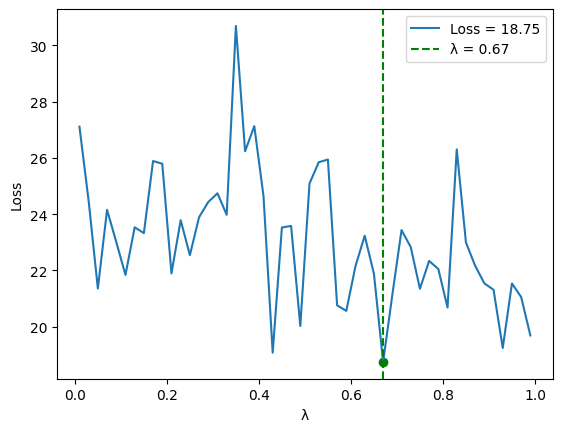

In [78]:
plot_lists(loss_list, lammda_list)

In [91]:
l2_reg_factor = 0.67


class Transfer_FEDA_NN(Model):
    def __init__(self):
        super(Transfer_FEDA_NN, self).__init__()
        self.f1 = Dense(4,kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1),
                        bias_initializer='zeros',
                        kernel_regularizer=KernelRegularizer(initial_weights=Smodel.layers[0].get_weights()[0] , l2_factor=l2_reg_factor))
        self.f2 = Dense(3,kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1),
                        bias_initializer='zeros',
                        kernel_regularizer=KernelRegularizer(initial_weights=Smodel.layers[1].get_weights()[0] , l2_factor=l2_reg_factor))
        self.f3 = Dense(1,kernel_initializer=tf.keras.initializers.RandomNormal(mean=0, stddev=1),
                        bias_initializer='zeros',
                        kernel_regularizer=KernelRegularizer(initial_weights=Smodel.layers[2].get_weights()[0] , l2_factor=l2_reg_factor))
    def call(self, x):
        x = self.f1(x)
        x = self.f2(x)
        y = self.f3(x)
        return y

# Create the model
Tmodel = Transfer_FEDA_NN()

Tmodel.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse'],
             )

checkpoint_save_path = "./checkpoint/target_weights.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True)

# Train the model
Transfer_history = Tmodel.fit(T_x_train, T_y_train, batch_size=3, epochs=900, validation_data=(T_x_val, T_y_val),
                     validation_freq=1,callbacks=[cp_callback])

# Print model summary
Tmodel.summary()


Epoch 1/900
1/1 [==============================] - 0s 276ms/step - loss: 1827.9513 - mse: 1715.5371 - val_loss: 1350.8794 - val_mse: 1238.5027
Epoch 2/900
1/1 [==============================] - 0s 17ms/step - loss: 1827.4131 - mse: 1715.0364 - val_loss: 1350.4254 - val_mse: 1238.0858
Epoch 3/900
1/1 [==============================] - 0s 17ms/step - loss: 1826.8730 - mse: 1714.5334 - val_loss: 1349.9694 - val_mse: 1237.6670
Epoch 4/900
1/1 [==============================] - 0s 17ms/step - loss: 1826.3307 - mse: 1714.0283 - val_loss: 1349.5116 - val_mse: 1237.2462
Epoch 5/900
1/1 [==============================] - 0s 17ms/step - loss: 1825.7866 - mse: 1713.5212 - val_loss: 1349.0520 - val_mse: 1236.8236
Epoch 6/900
1/1 [==============================] - 0s 17ms/step - loss: 1825.2396 - mse: 1713.0112 - val_loss: 1348.5908 - val_mse: 1236.3992
Epoch 7/900
1/1 [==============================] - 0s 17ms/step - loss: 1824.6909 - mse: 1712.4993 - val_loss: 1348.1277 - val_mse: 1235.9724
Epoch

1/1 [==============================] - 0s 16ms/step - loss: 1792.7125 - mse: 1681.7037 - val_loss: 1321.3029 - val_mse: 1210.2985
Epoch 59/900
1/1 [==============================] - 0s 16ms/step - loss: 1791.9866 - mse: 1680.9822 - val_loss: 1320.6984 - val_mse: 1209.6976
Epoch 60/900
1/1 [==============================] - 0s 17ms/step - loss: 1791.2562 - mse: 1680.2555 - val_loss: 1320.0906 - val_mse: 1209.0925
Epoch 61/900
1/1 [==============================] - 0s 16ms/step - loss: 1790.5215 - mse: 1679.5234 - val_loss: 1319.4785 - val_mse: 1208.4827
Epoch 62/900
1/1 [==============================] - 0s 16ms/step - loss: 1789.7820 - mse: 1678.7861 - val_loss: 1318.8632 - val_mse: 1207.8688
Epoch 63/900
1/1 [==============================] - 0s 17ms/step - loss: 1789.0377 - mse: 1678.0433 - val_loss: 1318.2441 - val_mse: 1207.2502
Epoch 64/900
1/1 [==============================] - 0s 15ms/step - loss: 1788.2891 - mse: 1677.2952 - val_loss: 1317.6213 - val_mse: 1206.6273
Epoch 65/900

1/1 [==============================] - 0s 16ms/step - loss: 1742.8573 - mse: 1630.9348 - val_loss: 1280.0374 - val_mse: 1168.0781
Epoch 116/900
1/1 [==============================] - 0s 16ms/step - loss: 1741.8036 - mse: 1629.8444 - val_loss: 1279.1692 - val_mse: 1167.1725
Epoch 117/900
1/1 [==============================] - 0s 16ms/step - loss: 1740.7430 - mse: 1628.7463 - val_loss: 1278.2950 - val_mse: 1166.2601
Epoch 118/900
1/1 [==============================] - 0s 16ms/step - loss: 1739.6753 - mse: 1627.6404 - val_loss: 1277.4153 - val_mse: 1165.3416
Epoch 119/900
1/1 [==============================] - 0s 17ms/step - loss: 1738.5999 - mse: 1626.5261 - val_loss: 1276.5295 - val_mse: 1164.4161
Epoch 120/900
1/1 [==============================] - 0s 16ms/step - loss: 1737.5176 - mse: 1625.4042 - val_loss: 1275.6383 - val_mse: 1163.4844
Epoch 121/900
1/1 [==============================] - 0s 16ms/step - loss: 1736.4281 - mse: 1624.2742 - val_loss: 1274.7408 - val_mse: 1162.5459
Epoch 

Epoch 172/900
1/1 [==============================] - 0s 16ms/step - loss: 1670.0078 - mse: 1554.9229 - val_loss: 1220.1925 - val_mse: 1105.0349
Epoch 173/900
1/1 [==============================] - 0s 16ms/step - loss: 1668.4728 - mse: 1553.3152 - val_loss: 1218.9347 - val_mse: 1103.7041
Epoch 174/900
1/1 [==============================] - 0s 16ms/step - loss: 1666.9281 - mse: 1551.6975 - val_loss: 1217.6691 - val_mse: 1102.3649
Epoch 175/900
1/1 [==============================] - 0s 16ms/step - loss: 1665.3741 - mse: 1550.0698 - val_loss: 1216.3958 - val_mse: 1101.0175
Epoch 176/900
1/1 [==============================] - 0s 16ms/step - loss: 1663.8102 - mse: 1548.4319 - val_loss: 1215.1146 - val_mse: 1099.6617
Epoch 177/900
1/1 [==============================] - 0s 16ms/step - loss: 1662.2366 - mse: 1546.7837 - val_loss: 1213.8254 - val_mse: 1098.2975
Epoch 178/900
1/1 [==============================] - 0s 16ms/step - loss: 1660.6532 - mse: 1545.1252 - val_loss: 1212.5286 - val_mse: 10

Epoch 229/900
1/1 [==============================] - 0s 16ms/step - loss: 1566.3396 - mse: 1446.3757 - val_loss: 1135.4731 - val_mse: 1015.4116
Epoch 230/900
1/1 [==============================] - 0s 16ms/step - loss: 1564.2144 - mse: 1444.1528 - val_loss: 1133.7412 - val_mse: 1013.5817
Epoch 231/900
1/1 [==============================] - 0s 16ms/step - loss: 1562.0781 - mse: 1441.9186 - val_loss: 1132.0009 - val_mse: 1011.7427
Epoch 232/900
1/1 [==============================] - 0s 15ms/step - loss: 1559.9313 - mse: 1439.6731 - val_loss: 1130.2518 - val_mse: 1009.8947
Epoch 233/900
1/1 [==============================] - 0s 16ms/step - loss: 1557.7734 - mse: 1437.4163 - val_loss: 1128.4940 - val_mse: 1008.0378
Epoch 234/900
1/1 [==============================] - 0s 16ms/step - loss: 1555.6046 - mse: 1435.1483 - val_loss: 1126.7277 - val_mse: 1006.1717
Epoch 235/900
1/1 [==============================] - 0s 15ms/step - loss: 1553.4248 - mse: 1432.8689 - val_loss: 1124.9525 - val_mse: 10

1/1 [==============================] - 0s 16ms/step - loss: 1427.8582 - mse: 1301.8175 - val_loss: 1023.0897 - val_mse: 896.9346
Epoch 287/900
1/1 [==============================] - 0s 16ms/step - loss: 1425.1190 - mse: 1298.9639 - val_loss: 1020.8767 - val_mse: 894.6072
Epoch 288/900
1/1 [==============================] - 0s 16ms/step - loss: 1422.3696 - mse: 1296.0999 - val_loss: 1018.6559 - val_mse: 892.2715
Epoch 289/900
1/1 [==============================] - 0s 16ms/step - loss: 1419.6094 - mse: 1293.2250 - val_loss: 1016.4272 - val_mse: 889.9279
Epoch 290/900
1/1 [==============================] - 0s 15ms/step - loss: 1416.8390 - mse: 1290.3398 - val_loss: 1014.1906 - val_mse: 887.5762
Epoch 291/900
1/1 [==============================] - 0s 16ms/step - loss: 1414.0590 - mse: 1287.4446 - val_loss: 1011.9464 - val_mse: 885.2166
Epoch 292/900
1/1 [==============================] - 0s 15ms/step - loss: 1411.2682 - mse: 1284.5386 - val_loss: 1009.6941 - val_mse: 882.8488
Epoch 293/900

Epoch 344/900
1/1 [==============================] - 0s 16ms/step - loss: 1253.1024 - mse: 1120.1261 - val_loss: 882.8444 - val_mse: 749.7440
Epoch 345/900
1/1 [==============================] - 0s 16ms/step - loss: 1249.8326 - mse: 1116.7323 - val_loss: 880.2402 - val_mse: 747.0156
Epoch 346/900
1/1 [==============================] - 0s 16ms/step - loss: 1246.5557 - mse: 1113.3309 - val_loss: 877.6309 - val_mse: 744.2818
Epoch 347/900
1/1 [==============================] - 0s 16ms/step - loss: 1243.2710 - mse: 1109.9219 - val_loss: 875.0164 - val_mse: 741.5427
Epoch 348/900
1/1 [==============================] - 0s 16ms/step - loss: 1239.9790 - mse: 1106.5051 - val_loss: 872.3967 - val_mse: 738.7982
Epoch 349/900
1/1 [==============================] - 0s 16ms/step - loss: 1236.6794 - mse: 1103.0809 - val_loss: 869.7720 - val_mse: 736.0488
Epoch 350/900
1/1 [==============================] - 0s 16ms/step - loss: 1233.3728 - mse: 1099.6494 - val_loss: 867.1425 - val_mse: 733.2943
Epoch 

Epoch 402/900
1/1 [==============================] - 0s 17ms/step - loss: 1053.2363 - mse: 912.8831 - val_loss: 725.2885 - val_mse: 584.8056
Epoch 403/900
1/1 [==============================] - 0s 16ms/step - loss: 1049.6542 - mse: 909.1715 - val_loss: 722.4984 - val_mse: 581.8860
Epoch 404/900
1/1 [==============================] - 0s 16ms/step - loss: 1046.0693 - mse: 905.4569 - val_loss: 719.7078 - val_mse: 578.9657
Epoch 405/900
1/1 [==============================] - 0s 16ms/step - loss: 1042.4821 - mse: 901.7399 - val_loss: 716.9162 - val_mse: 576.0445
Epoch 406/900
1/1 [==============================] - 0s 16ms/step - loss: 1038.8916 - mse: 898.0199 - val_loss: 714.1241 - val_mse: 573.1226
Epoch 407/900
1/1 [==============================] - 0s 16ms/step - loss: 1035.2988 - mse: 894.2973 - val_loss: 711.3313 - val_mse: 570.2000
Epoch 408/900
1/1 [==============================] - 0s 16ms/step - loss: 1031.7037 - mse: 890.5724 - val_loss: 708.5380 - val_mse: 567.2768
Epoch 409/900

1/1 [==============================] - 0s 16ms/step - loss: 843.8945 - mse: 695.9841 - val_loss: 564.8107 - val_mse: 416.7702
Epoch 461/900
1/1 [==============================] - 0s 16ms/step - loss: 840.3159 - mse: 692.2755 - val_loss: 562.1200 - val_mse: 413.9493
Epoch 462/900
1/1 [==============================] - 0s 16ms/step - loss: 836.7407 - mse: 688.5701 - val_loss: 559.4335 - val_mse: 411.1328
Epoch 463/900
1/1 [==============================] - 0s 16ms/step - loss: 833.1686 - mse: 684.8678 - val_loss: 556.7516 - val_mse: 408.3209
Epoch 464/900
1/1 [==============================] - 0s 16ms/step - loss: 829.6000 - mse: 681.1692 - val_loss: 554.0744 - val_mse: 405.5135
Epoch 465/900
1/1 [==============================] - 0s 16ms/step - loss: 826.0349 - mse: 677.4740 - val_loss: 551.4018 - val_mse: 402.7110
Epoch 466/900
1/1 [==============================] - 0s 15ms/step - loss: 822.4732 - mse: 673.7824 - val_loss: 548.7340 - val_mse: 399.9133
Epoch 467/900
1/1 [===============

1/1 [==============================] - 0s 17ms/step - loss: 644.8266 - mse: 489.4813 - val_loss: 418.7963 - val_mse: 263.3260
Epoch 519/900
1/1 [==============================] - 0s 17ms/step - loss: 641.6037 - mse: 486.1335 - val_loss: 416.5062 - val_mse: 260.9109
Epoch 520/900
1/1 [==============================] - 0s 16ms/step - loss: 638.3900 - mse: 482.7947 - val_loss: 414.2253 - val_mse: 258.5054
Epoch 521/900
1/1 [==============================] - 0s 16ms/step - loss: 635.1853 - mse: 479.4653 - val_loss: 411.9538 - val_mse: 256.1093
Epoch 522/900
1/1 [==============================] - 0s 16ms/step - loss: 631.9898 - mse: 476.1453 - val_loss: 409.6917 - val_mse: 253.7226
Epoch 523/900
1/1 [==============================] - 0s 16ms/step - loss: 628.8037 - mse: 472.8347 - val_loss: 407.4389 - val_mse: 251.3456
Epoch 524/900
1/1 [==============================] - 0s 16ms/step - loss: 625.6269 - mse: 469.5335 - val_loss: 405.1959 - val_mse: 248.9784
Epoch 525/900
1/1 [===============

1/1 [==============================] - 0s 16ms/step - loss: 475.2837 - mse: 312.9907 - val_loss: 303.1086 - val_mse: 140.7024
Epoch 577/900
1/1 [==============================] - 0s 17ms/step - loss: 472.7099 - mse: 310.3037 - val_loss: 301.4471 - val_mse: 138.9281
Epoch 578/900
1/1 [==============================] - 0s 16ms/step - loss: 470.1490 - mse: 307.6299 - val_loss: 299.7976 - val_mse: 137.1659
Epoch 579/900
1/1 [==============================] - 0s 16ms/step - loss: 467.6010 - mse: 304.9694 - val_loss: 298.1600 - val_mse: 135.4161
Epoch 580/900
1/1 [==============================] - 0s 16ms/step - loss: 465.0662 - mse: 302.3222 - val_loss: 296.5345 - val_mse: 133.6785
Epoch 581/900
1/1 [==============================] - 0s 16ms/step - loss: 462.5445 - mse: 299.6884 - val_loss: 294.9210 - val_mse: 131.9532
Epoch 582/900
1/1 [==============================] - 0s 15ms/step - loss: 460.0358 - mse: 297.0680 - val_loss: 293.3195 - val_mse: 130.2403
Epoch 583/900
1/1 [===============

Epoch 635/900
1/1 [==============================] - 0s 16ms/step - loss: 346.4522 - mse: 178.0138 - val_loss: 225.7668 - val_mse: 57.2347
Epoch 636/900
1/1 [==============================] - 0s 16ms/step - loss: 344.6788 - mse: 176.1467 - val_loss: 224.8134 - val_mse: 56.1881
Epoch 637/900
1/1 [==============================] - 0s 16ms/step - loss: 342.9189 - mse: 174.2936 - val_loss: 223.8714 - val_mse: 55.1532
Epoch 638/900
1/1 [==============================] - 0s 16ms/step - loss: 341.1727 - mse: 172.4545 - val_loss: 222.9409 - val_mse: 54.1302
Epoch 639/900
1/1 [==============================] - 0s 16ms/step - loss: 339.4399 - mse: 170.6292 - val_loss: 222.0217 - val_mse: 53.1189
Epoch 640/900
1/1 [==============================] - 0s 16ms/step - loss: 337.7207 - mse: 168.8179 - val_loss: 221.1138 - val_mse: 52.1193
Epoch 641/900
1/1 [==============================] - 0s 16ms/step - loss: 336.0149 - mse: 167.0204 - val_loss: 220.2172 - val_mse: 51.1314
Epoch 642/900
1/1 [========

Epoch 694/900
1/1 [==============================] - 0s 16ms/step - loss: 263.9392 - mse: 90.6924 - val_loss: 187.4828 - val_mse: 14.1678
Epoch 695/900
1/1 [==============================] - 0s 16ms/step - loss: 262.9015 - mse: 89.5865 - val_loss: 187.1142 - val_mse: 13.7317
Epoch 696/900
1/1 [==============================] - 0s 16ms/step - loss: 261.8747 - mse: 88.4921 - val_loss: 186.7537 - val_mse: 13.3040
Epoch 697/900
1/1 [==============================] - 0s 16ms/step - loss: 260.8586 - mse: 87.4089 - val_loss: 186.4011 - val_mse: 12.8847
Epoch 698/900
1/1 [==============================] - 0s 15ms/step - loss: 259.8535 - mse: 86.3370 - val_loss: 186.0563 - val_mse: 12.4736
Epoch 699/900
1/1 [==============================] - 0s 16ms/step - loss: 258.8589 - mse: 85.2762 - val_loss: 185.7194 - val_mse: 12.0709
Epoch 700/900
1/1 [==============================] - 0s 15ms/step - loss: 257.8750 - mse: 84.2266 - val_loss: 185.3901 - val_mse: 11.6764
Epoch 701/900
1/1 [===============

Epoch 754/900
1/1 [==============================] - 0s 16ms/step - loss: 218.5878 - mse: 42.0990 - val_loss: 176.9952 - val_mse: 0.4670
Epoch 755/900
1/1 [==============================] - 0s 16ms/step - loss: 218.0800 - mse: 41.5518 - val_loss: 176.9763 - val_mse: 0.4091
Epoch 756/900
1/1 [==============================] - 0s 16ms/step - loss: 217.5789 - mse: 41.0117 - val_loss: 176.9610 - val_mse: 0.3553
Epoch 757/900
1/1 [==============================] - 0s 15ms/step - loss: 217.0845 - mse: 40.4788 - val_loss: 176.9493 - val_mse: 0.3056
Epoch 758/900
1/1 [==============================] - 0s 16ms/step - loss: 216.5964 - mse: 39.9527 - val_loss: 176.9411 - val_mse: 0.2599
Epoch 759/900
1/1 [==============================] - 0s 15ms/step - loss: 216.1149 - mse: 39.4337 - val_loss: 176.9364 - val_mse: 0.2181
Epoch 760/900
1/1 [==============================] - 0s 16ms/step - loss: 215.6398 - mse: 38.9215 - val_loss: 176.9351 - val_mse: 0.1802
Epoch 761/900
1/1 [======================

Epoch 814/900
1/1 [==============================] - 0s 11ms/step - loss: 197.7081 - mse: 19.6555 - val_loss: 180.3383 - val_mse: 2.2726
Epoch 815/900
1/1 [==============================] - 0s 12ms/step - loss: 197.4893 - mse: 19.4236 - val_loss: 180.4401 - val_mse: 2.3618
Epoch 816/900
1/1 [==============================] - 0s 11ms/step - loss: 197.2736 - mse: 19.1953 - val_loss: 180.5425 - val_mse: 2.4521
Epoch 817/900
1/1 [==============================] - 0s 10ms/step - loss: 197.0610 - mse: 18.9705 - val_loss: 180.6456 - val_mse: 2.5433
Epoch 818/900
1/1 [==============================] - 0s 11ms/step - loss: 196.8514 - mse: 18.7491 - val_loss: 180.7493 - val_mse: 2.6355
Epoch 819/900
1/1 [==============================] - 0s 10ms/step - loss: 196.6449 - mse: 18.5311 - val_loss: 180.8534 - val_mse: 2.7286
Epoch 820/900
1/1 [==============================] - 0s 11ms/step - loss: 196.4413 - mse: 18.3165 - val_loss: 180.9581 - val_mse: 2.8226
Epoch 821/900
1/1 [======================

Epoch 874/900
1/1 [==============================] - 0s 11ms/step - loss: 188.8042 - mse: 10.6093 - val_loss: 186.6305 - val_mse: 8.4430
Epoch 875/900
1/1 [==============================] - 0s 11ms/step - loss: 188.7086 - mse: 10.5211 - val_loss: 186.7261 - val_mse: 8.5463
Epoch 876/900
1/1 [==============================] - 0s 11ms/step - loss: 188.6141 - mse: 10.4343 - val_loss: 186.8210 - val_mse: 8.6492
Epoch 877/900
1/1 [==============================] - 0s 10ms/step - loss: 188.5208 - mse: 10.3490 - val_loss: 186.9153 - val_mse: 8.7518
Epoch 878/900
1/1 [==============================] - 0s 11ms/step - loss: 188.4286 - mse: 10.2651 - val_loss: 187.0090 - val_mse: 8.8540
Epoch 879/900
1/1 [==============================] - 0s 11ms/step - loss: 188.3375 - mse: 10.1826 - val_loss: 187.1020 - val_mse: 8.9559
Epoch 880/900
1/1 [==============================] - 0s 10ms/step - loss: 188.2475 - mse: 10.1014 - val_loss: 187.1944 - val_mse: 9.0575
Epoch 881/900
1/1 [======================

In [92]:
checkpoint_save_path = "./checkpoint/target_weights.ckpt"

if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------loading the param. of transfer domain-----------------')
    Smodel.load_weights(filepath=checkpoint_save_path)
    # Print the weights of each layer
    for layer in Smodel.layers:
        if len(layer.get_weights()) > 0:
            print(f"Layer: {layer.name}")
            weights = layer.get_weights() 
            # Get the weights (assuming weights are the first element) 
            # weights = layer.get_weights()[0] 
            print(weights)
            print("--------------------------------------------------")

-------------loading the param. of transfer domain-----------------
Layer: dense
[array([[-1.6672758 , -1.7617929 ,  2.0942717 , -1.5999438 ],
       [ 0.13407484,  0.23334144, -0.23813415,  0.302725  ],
       [-0.40746793, -0.42005643,  1.8287799 , -2.6781695 ]],
      dtype=float32), array([-0.8912752 , -1.0473789 ,  0.9439325 , -0.90742475], dtype=float32)]
--------------------------------------------------
Layer: dense_1
[array([[-1.7908901 ,  0.43168098, -2.5493875 ],
       [-0.16115567,  3.3553994 , -0.21317554],
       [ 0.3371468 , -1.4456387 ,  2.4911494 ],
       [-1.948522  ,  1.508573  , -0.7084298 ]], dtype=float32), array([ 0.7442333, -0.7588181,  0.7634203], dtype=float32)]
--------------------------------------------------
Layer: dense_2
[array([[ 1.5436542],
       [-1.3648826],
       [ 1.3683828]], dtype=float32), array([0.5708029], dtype=float32)]
--------------------------------------------------


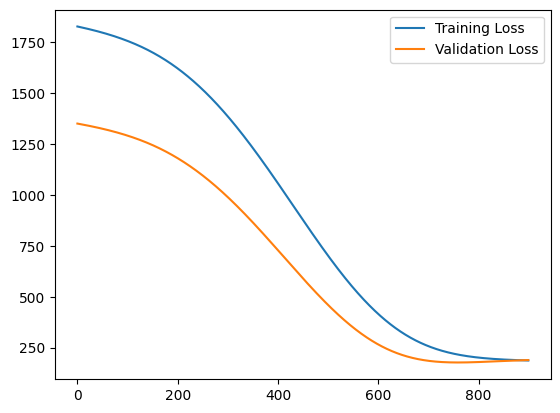

In [93]:
from matplotlib import pyplot as plt

mse_base = Transfer_history.history['mse']
val_mse_base = Transfer_history.history['val_mse']
loss_base = Transfer_history.history['loss']
val_loss_base =  Transfer_history.history['val_loss']

#plt.subplot(1,2,1)
plt.plot(loss_base,label='Training Loss')
plt.plot(val_loss_base,label='Validation Loss')
plt.legend()
plt.savefig('bestlammda_loss.png',bbox_inches = 'tight',dpi=600)
plt.savefig('bestlammda_loss.svg',bbox_inches = 'tight',dpi=600)

In [94]:
# test
from sklearn.metrics import mean_squared_error

x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
y_pred = Tmodel.predict(x_test)
print(y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"Root Mean Squared Error: {np.sqrt(mse)}")

1/1 [==============================] - 0s 22ms/step
[[39.888386]
 [39.38445 ]]
Root Mean Squared Error: 2.964506435858304
